## M5 Forecast: Keras with Categorical Embeddings V2

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
from tqdm.notebook import tqdm

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Load data

In [3]:
path = "./input/csv"

In [4]:
calendar = pd.read_csv(os.path.join(path, "calendar.csv.gz"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv.gz"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv.gz"))

In [5]:
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv.gz"))

## Describe and prepare data

We will now go through all data sets and prepare them for modelling.

### Calendar data

For each date (covering both training and test data), we have access to useful calendar information.

In [6]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [7]:
from sklearn.preprocessing import OrdinalEncoder

In [8]:
def prep_calendar(df):
    df = df.drop(["date", "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])
    df = reduce_mem_usage(df)
    return df

In [9]:
calendar = prep_calendar(calendar)

Mem. usage decreased to  0.03 Mb (84.7% reduction)


#### Notes for modeling

**Features** deemed to be useful:

- "wday", "year", "month" -> integer coding & embedding
- "event_name_1", "event_type_1" -> integer coding & embedding
- "snap_XX" -> numeric (they are dummies)

**Reshape required**: No

**Merge key(s)**: "d", "wm_yr_wk"

### Selling prices

Contains selling prices for each store_id, item_id_wm_yr_wk combination.


Derive some time related features:


In [11]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df = reduce_mem_usage(df)
    return df

In [12]:
selling_prices = prep_selling_prices(selling_prices)

Mem. usage decreased to 169.63 Mb (53.6% reduction)


In [14]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"))
    return df

In [15]:
sales = reshape_sales(sales, 1000)

In [16]:
sales

id        item_id    dept_id   cat_id store_id  \
0         HOBBIES_1_001_CA_1  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1         HOBBIES_1_002_CA_1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2         HOBBIES_1_003_CA_1  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3         HOBBIES_1_004_CA_1  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4         HOBBIES_1_005_CA_1  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
...                      ...            ...        ...      ...      ...   
29544805    FOODS_3_823_WI_3    FOODS_3_823    FOODS_3    FOODS     WI_3   
29544806    FOODS_3_824_WI_3    FOODS_3_824    FOODS_3    FOODS     WI_3   
29544807    FOODS_3_825_WI_3    FOODS_3_825    FOODS_3    FOODS     WI_3   
29544808    FOODS_3_826_WI_3    FOODS_3_826    FOODS_3    FOODS     WI_3   
29544809    FOODS_3_827_WI_3    FOODS_3_827    FOODS_3    FOODS     WI_3   

         state_id     d  demand  
0              CA  1001     2.0  
1              CA  1001     0.0  
2              CA  1001     0.0  
3              CA  1001     0.0  
4              CA  1001     1.0  
...           ...   ...     ...  
29544805       WI  1969     NaN  
29544806       WI  1969     NaN  
29544807       WI  1969     NaN  
29544808       WI  1969     NaN  
29544809       WI  1969     NaN  

[29544810 rows x 8 columns]

In [17]:
def prep_sales(df):
    
    df['lag_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(7))
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    
    df['rolling_mean_7_7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(7).rolling(7).mean())
    df['rolling_mean_7_28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(7).rolling(28).mean())

    df['rolling_mean_28_7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_28_28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(28).mean())
    
    df['rolling_std_28_7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_28_28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(28).std())
    

    # Remove rows with NAs except for submission rows. rolling_mean_7_28 
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_7_28)) | (df.d <= 200) ]
    df = reduce_mem_usage(df)

    return df

In [18]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect()
sales.head()

id        item_id    dept_id   cat_id store_id state_id  \
0  HOBBIES_1_001_CA_1  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA   
1  HOBBIES_1_002_CA_1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1       CA   
2  HOBBIES_1_003_CA_1  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1       CA   
3  HOBBIES_1_004_CA_1  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1       CA   
4  HOBBIES_1_005_CA_1  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1       CA   

      d  demand  wm_yr_wk  wday  month  year  event_name_1  event_type_1  \
0  1001     2.0     11339     6      9     2            30             4   
1  1001     0.0     11339     6      9     2            30             4   
2  1001     0.0     11339     6      9     2            30             4   
3  1001     0.0     11339     6      9     2            30             4   
4  1001     1.0     11339     6      9     2            30             4   

   event_name_2  event_type_2  snap_CA  snap_TX  snap_WI  
0             4             2        0        0        0  
1             4             2        0        0        0  
2             4             2        0        0        0  
3             4             2        0        0        0  
4             4             2        0        0        0

In [19]:
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
sales.head()

id        item_id    dept_id   cat_id store_id state_id  \
0  HOBBIES_1_001_CA_1  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA   
1  HOBBIES_1_002_CA_1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1       CA   
2  HOBBIES_1_003_CA_1  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1       CA   
3  HOBBIES_1_004_CA_1  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1       CA   
4  HOBBIES_1_005_CA_1  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1       CA   

      d  demand  wday  month  ...  event_type_1  event_name_2  event_type_2  \
0  1001     2.0     6      9  ...             4             4             2   
1  1001     0.0     6      9  ...             4             4             2   
2  1001     0.0     6      9  ...             4             4             2   
3  1001     0.0     6      9  ...             4             4             2   
4  1001     1.0     6      9  ...             4             4             2   

   snap_CA  snap_TX  snap_WI  sell_price  sell_price_rel_diff  \
0        0        0        0    8.257812                  0.0   
1        0        0        0    3.970703                  0.0   
2        0        0        0         NaN                  NaN   
3        0        0        0    4.640625                  0.0   
4        0        0        0    3.080078                  0.0   

   sell_price_roll_sd7  sell_price_cumrel  
0                  0.0           0.000000  
1                  0.0           0.000000  
2                  NaN                NaN  
3                  0.0           0.230713  
4                  0.0           0.375000  

[5 rows x 22 columns]

In [20]:
sales = prep_sales(sales)

Mem. usage decreased to 2555.62 Mb (36.5% reduction)


In [22]:
sales

id        item_id    dept_id   cat_id store_id  \
1036660   HOBBIES_1_001_CA_1  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1036661   HOBBIES_1_002_CA_1  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
1036662   HOBBIES_1_003_CA_1  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
1036663   HOBBIES_1_004_CA_1  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
1036664   HOBBIES_1_005_CA_1  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
...                      ...            ...        ...      ...      ...   
29544805    FOODS_3_823_WI_3    FOODS_3_823    FOODS_3    FOODS     WI_3   
29544806    FOODS_3_824_WI_3    FOODS_3_824    FOODS_3    FOODS     WI_3   
29544807    FOODS_3_825_WI_3    FOODS_3_825    FOODS_3    FOODS     WI_3   
29544808    FOODS_3_826_WI_3    FOODS_3_826    FOODS_3    FOODS     WI_3   
29544809    FOODS_3_827_WI_3    FOODS_3_827    FOODS_3    FOODS     WI_3   

         state_id     d  demand  wday  month  ...  sell_price_roll_sd7  \
1036660        CA  1035     1.0     5     10  ...                  0.0   
1036661        CA  1035     0.0     5     10  ...                  0.0   
1036662        CA  1035     0.0     5     10  ...                  NaN   
1036663        CA  1035     5.0     5     10  ...                  0.0   
1036664        CA  1035     0.0     5     10  ...                  0.0   
...           ...   ...     ...   ...    ...  ...                  ...   
29544805       WI  1969     NaN     1      5  ...                  0.0   
29544806       WI  1969     NaN     1      5  ...                  0.0   
29544807       WI  1969     NaN     1      5  ...                  0.0   
29544808       WI  1969     NaN     1      5  ...                  0.0   
29544809       WI  1969     NaN     1      5  ...                  0.0   

          sell_price_cumrel  lag_t7  lag_t28  rolling_mean_7_7  \
1036660            0.000000     0.0      0.0          0.142822   
1036661            0.000000     0.0      0.0          0.285645   
1036662                 NaN     0.0      0.0          0.000000   
1036663            0.230713     1.0      2.0          1.571289   
1036664            0.375000     2.0      2.0          1.000000   
...                     ...     ...      ...               ...   
29544805           0.333252     NaN      NaN               NaN   
29544806           0.285645     NaN      NaN               NaN   
29544807           0.000000     NaN      NaN               NaN   
29544808           0.000000     NaN      NaN               NaN   
29544809           0.000000     NaN      NaN               NaN   

          rolling_mean_7_28  rolling_mean_28_7  rolling_mean_28_28  \
1036660            0.714355           0.856934                 NaN   
1036661            0.142822           0.142822                 NaN   
1036662            0.000000           0.000000                 NaN   
1036663            2.072266           3.142578                 NaN   
1036664            0.678711           0.714355                 NaN   
...                     ...                ...                 ...   
29544805                NaN                NaN                 NaN   
29544806                NaN                NaN                 NaN   
29544807                NaN                NaN                 NaN   
29544808                NaN                NaN                 NaN   
29544809                NaN                NaN                 NaN   

          rolling_std_28_7  rolling_std_28_28  
1036660           0.899902                NaN  
1036661           0.377930                NaN  
1036662           0.000000                NaN  
1036663           2.853516                NaN  
1036664           0.755859                NaN  
...                    ...                ...  
29544805               NaN                NaN  
29544806               NaN                NaN  
29544807               NaN                NaN  
29544808               NaN                NaN  
29544809               NaN                NaN  

[28508150 row

In [21]:
del selling_prices

## Prepare data for Keras interface

### Ordinal encoding of remaining categoricals

In [23]:
cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
cat_cols = cat_id_cols + ["wday", "month", "year", "event_name_1", 
                          "event_type_1", "event_name_2", "event_type_2"]

In [24]:
# In loop to minimize memory use
for i, v in tqdm(enumerate(cat_id_cols)):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]])

sales = reduce_mem_usage(sales)
sales.head()
gc.collect()


Mem. usage decreased to 1631.25 Mb (18.9% reduction)


5

#### Impute numeric columns

In [25]:
num_cols = ["sell_price", "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel",
            "lag_t7", 
            "lag_t28", 
            "rolling_mean_7_7", 
            "rolling_mean_7_28", 
            "rolling_mean_28_7", 
            "rolling_mean_7_28", 
            "rolling_std_28_7", 
            "rolling_std_28_28"]
bool_cols = ["snap_CA", "snap_TX", "snap_WI"]
dense_cols = num_cols + bool_cols

In [26]:
# Need to do column by column due to memory constraints
for i, v in tqdm(enumerate(num_cols)):
    sales[v] = sales[v].fillna(sales[v].median())
    
sales.head()

id  item_id  dept_id  cat_id  store_id  state_id  \
1036660  HOBBIES_1_001_CA_1     1437        3       1         0         0   
1036661  HOBBIES_1_002_CA_1     1438        3       1         0         0   
1036662  HOBBIES_1_003_CA_1     1439        3       1         0         0   
1036663  HOBBIES_1_004_CA_1     1440        3       1         0         0   
1036664  HOBBIES_1_005_CA_1     1441        3       1         0         0   

            d  demand  wday  month  ...  sell_price_roll_sd7  \
1036660  1035     1.0     5     10  ...                  0.0   
1036661  1035     0.0     5     10  ...                  0.0   
1036662  1035     0.0     5     10  ...                  0.0   
1036663  1035     5.0     5     10  ...                  0.0   
1036664  1035     0.0     5     10  ...                  0.0   

         sell_price_cumrel  lag_t7  lag_t28  rolling_mean_7_7  \
1036660           0.000000     0.0      0.0          0.142822   
1036661           0.000000     0.0      0.0          0.285645   
1036662           0.000000     0.0      0.0          0.000000   
1036663           0.230713     1.0      2.0          1.571289   
1036664           0.375000     2.0      2.0          1.000000   

         rolling_mean_7_28  rolling_mean_28_7  rolling_mean_28_28  \
1036660           0.714355           0.856934                 NaN   
1036661           0.142822           0.142822                 NaN   
1036662           0.000000           0.000000                 NaN   
1036663           2.072266           3.142578                 NaN   
1036664           0.678711           0.714355                 NaN   

         rolling_std_28_7  rolling_std_28_28  
1036660          0.899902           0.744629  
1036661          0.377930           0.744629  
1036662          0.000000           0.744629  
1036663          2.853516           0.744629  
1036664          0.755859           0.744629  

[5 rows x 30 columns]

#### Separate submission data and reconstruct id columns

In [27]:
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
test.head()
gc.collect()

88

In [28]:
test_long = sales[sales.d >= 1914 - 100]
test_long.head()
gc.collect()

20

#### Make training data

In [29]:
# Input dict for training with a dense array and separate inputs for each embedding input
def make_X(df):
    X = {"dense1": df[dense_cols].to_numpy()}
    for i, v in enumerate(cat_cols):
        X[v] = df[[v]].to_numpy()
    return X

In [30]:
# Submission data
X_test = make_X(test)

In [31]:
# One month of validation data
flag = (sales.d < 1914) & (sales.d >= 1914 - 28)
valid = (make_X(sales[flag]),
         sales["demand"][flag])

In [32]:
# Rest is used for training
flag = sales.d < 1914 #- 7
X_train = make_X(sales[flag])
y_train = sales["demand"][flag]

In [33]:
del sales, flag
gc.collect()

20

In [34]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten
from tensorflow.keras.models import Model

### Architecture with embeddings

In [35]:
def create_model(lr=0.002):
    tf.keras.backend.clear_session()
    gc.collect()

    # Dense input
    dense_input = Input(shape=(len(dense_cols), ), name='dense1')

    # Embedding input
    wday_input = Input(shape=(1,), name='wday')
    month_input = Input(shape=(1,), name='month')
    year_input = Input(shape=(1,), name='year')
    event_name_1_input = Input(shape=(1,), name='event_name_1')
    event_type_1_input = Input(shape=(1,), name='event_type_1')
    event_name_2_input = Input(shape=(1,), name='event_name_2')
    event_type_2_input = Input(shape=(1,), name='event_type_2')
    item_id_input = Input(shape=(1,), name='item_id')
    dept_id_input = Input(shape=(1,), name='dept_id')
    store_id_input = Input(shape=(1,), name='store_id')
    cat_id_input = Input(shape=(1,), name='cat_id')
    state_id_input = Input(shape=(1,), name='state_id')

    wday_emb = Flatten()(Embedding(7, 1)(wday_input))
    month_emb = Flatten()(Embedding(12, 1)(month_input))
    year_emb = Flatten()(Embedding(6, 1)(year_input))
    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(5, 1)(event_type_2_input))

    item_id_emb = Flatten()(Embedding(3049, 3)(item_id_input))
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(10, 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(3, 1)(state_id_input))

    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, wday_emb, month_emb, year_emb, 
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb, store_id_emb,
                     cat_id_emb, state_id_emb])
    
    x = Dense(256, activation="tanh")(x)
    x = Dense(128, activation="tanh")(x)
    x = Dense(64, activation="tanh")(x)
    x = Dense(16, activation="tanh")(x)
    x = Dense(4, activation="tanh")(x)
    
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, "wday": wday_input, "month": month_input, "year": year_input, 
              "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
              "event_name_2": event_name_2_input, "event_type_2": event_type_2_input,
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Connect input and output
    model = Model(inputs, outputs)

    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=["mse"],
                  optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model


In [38]:
model = create_model(0.0002)
model.summary()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wday (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
year (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
event_name_1 (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________

### Calculate derivatives and fit model

In [42]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=2 ** 14,
                    epochs=100,
                    shuffle=True,
                    validation_data=valid)

Train on 26800710 samples, validate on 853720 samples
Epoch 1/100


 2359296/26800710 [=>............................] - ETA: 49:48 - loss: 14.5268 - mean_squared_error: 14.526 - ETA: 26:09 - loss: 16.4514 - mean_squared_error: 16.451 - ETA: 18:11 - loss: 14.9618 - mean_squared_error: 14.961 - ETA: 14:10 - loss: 14.5856 - mean_squared_error: 14.585 - ETA: 11:46 - loss: 14.1370 - mean_squared_error: 14.137 - ETA: 10:10 - loss: 15.7298 - mean_squared_error: 15.729 - ETA: 9:01 - loss: 15.5423 - mean_squared_error: 15.542 - ETA: 8:10 - loss: 15.3015 - mean_squared_error: 15.30 - ETA: 7:29 - loss: 15.5636 - mean_squared_error: 15.56 - ETA: 6:57 - loss: 15.2763 - mean_squared_error: 15.27 - ETA: 6:31 - loss: 15.0923 - mean_squared_error: 15.09 - ETA: 6:09 - loss: 14.9134 - mean_squared_error: 14.91 - ETA: 5:51 - loss: 14.8524 - mean_squared_error: 14.85 - ETA: 5:36 - loss: 14.5894 - mean_squared_error: 14.58 - ETA: 5:23 - loss: 14.5058 - mean_squared_error: 14.50 - ETA: 5:10 - loss: 14.3673 - mean_squared_error: 14.36 - ETA: 4:59 - loss: 14.1607 - mean_squar

 7143424/26800710 [======>.......................] - ETA: 1:55 - loss: 12.2685 - mean_squared_error: 12.26 - ETA: 1:55 - loss: 12.2713 - mean_squared_error: 12.27 - ETA: 1:55 - loss: 12.2631 - mean_squared_error: 12.26 - ETA: 1:55 - loss: 12.2553 - mean_squared_error: 12.25 - ETA: 1:55 - loss: 12.2497 - mean_squared_error: 12.24 - ETA: 1:55 - loss: 12.2505 - mean_squared_error: 12.25 - ETA: 1:55 - loss: 12.2471 - mean_squared_error: 12.24 - ETA: 1:55 - loss: 12.2433 - mean_squared_error: 12.24 - ETA: 1:55 - loss: 12.2385 - mean_squared_error: 12.23 - ETA: 1:55 - loss: 12.2438 - mean_squared_error: 12.24 - ETA: 1:54 - loss: 12.2459 - mean_squared_error: 12.24 - ETA: 1:54 - loss: 12.2387 - mean_squared_error: 12.23 - ETA: 1:54 - loss: 12.2282 - mean_squared_error: 12.22 - ETA: 1:54 - loss: 12.2295 - mean_squared_error: 12.22 - ETA: 1:54 - loss: 12.2283 - mean_squared_error: 12.22 - ETA: 1:54 - loss: 12.2252 - mean_squared_error: 12.22 - ETA: 1:54 - loss: 12.2155 - mean_squared_error: 12.

 9535488/26800710 [=========>....................] - ETA: 1:41 - loss: 12.0804 - mean_squared_error: 12.08 - ETA: 1:41 - loss: 12.0824 - mean_squared_error: 12.08 - ETA: 1:41 - loss: 12.0831 - mean_squared_error: 12.08 - ETA: 1:41 - loss: 12.0796 - mean_squared_error: 12.07 - ETA: 1:41 - loss: 12.0745 - mean_squared_error: 12.07 - ETA: 1:41 - loss: 12.0720 - mean_squared_error: 12.07 - ETA: 1:41 - loss: 12.0791 - mean_squared_error: 12.07 - ETA: 1:40 - loss: 12.0729 - mean_squared_error: 12.07 - ETA: 1:40 - loss: 12.0665 - mean_squared_error: 12.06 - ETA: 1:40 - loss: 12.0648 - mean_squared_error: 12.06 - ETA: 1:40 - loss: 12.0608 - mean_squared_error: 12.06 - ETA: 1:40 - loss: 12.0610 - mean_squared_error: 12.06 - ETA: 1:40 - loss: 12.0585 - mean_squared_error: 12.05 - ETA: 1:40 - loss: 12.0580 - mean_squared_error: 12.05 - ETA: 1:40 - loss: 12.0556 - mean_squared_error: 12.05 - ETA: 1:40 - loss: 12.0522 - mean_squared_error: 12.05 - ETA: 1:40 - loss: 12.0527 - mean_squared_error: 12.

11927552/26800710 [============>.................] - ETA: 1:28 - loss: 11.9660 - mean_squared_error: 11.96 - ETA: 1:28 - loss: 11.9671 - mean_squared_error: 11.96 - ETA: 1:28 - loss: 11.9666 - mean_squared_error: 11.96 - ETA: 1:28 - loss: 11.9702 - mean_squared_error: 11.97 - ETA: 1:28 - loss: 11.9696 - mean_squared_error: 11.96 - ETA: 1:27 - loss: 11.9694 - mean_squared_error: 11.96 - ETA: 1:27 - loss: 11.9679 - mean_squared_error: 11.96 - ETA: 1:27 - loss: 11.9670 - mean_squared_error: 11.96 - ETA: 1:27 - loss: 11.9699 - mean_squared_error: 11.96 - ETA: 1:27 - loss: 11.9678 - mean_squared_error: 11.96 - ETA: 1:27 - loss: 11.9638 - mean_squared_error: 11.96 - ETA: 1:27 - loss: 11.9609 - mean_squared_error: 11.96 - ETA: 1:27 - loss: 11.9595 - mean_squared_error: 11.95 - ETA: 1:27 - loss: 11.9574 - mean_squared_error: 11.95 - ETA: 1:27 - loss: 11.9547 - mean_squared_error: 11.95 - ETA: 1:27 - loss: 11.9531 - mean_squared_error: 11.95 - ETA: 1:26 - loss: 11.9524 - mean_squared_error: 11.

14319616/26800710 [===============>..............] - ETA: 1:15 - loss: 11.8119 - mean_squared_error: 11.81 - ETA: 1:15 - loss: 11.8122 - mean_squared_error: 11.81 - ETA: 1:15 - loss: 11.8081 - mean_squared_error: 11.80 - ETA: 1:15 - loss: 11.8053 - mean_squared_error: 11.80 - ETA: 1:15 - loss: 11.8073 - mean_squared_error: 11.80 - ETA: 1:14 - loss: 11.8093 - mean_squared_error: 11.80 - ETA: 1:14 - loss: 11.8069 - mean_squared_error: 11.80 - ETA: 1:14 - loss: 11.8074 - mean_squared_error: 11.80 - ETA: 1:14 - loss: 11.8061 - mean_squared_error: 11.80 - ETA: 1:14 - loss: 11.8006 - mean_squared_error: 11.80 - ETA: 1:14 - loss: 11.7981 - mean_squared_error: 11.79 - ETA: 1:14 - loss: 11.7966 - mean_squared_error: 11.79 - ETA: 1:14 - loss: 11.7983 - mean_squared_error: 11.79 - ETA: 1:14 - loss: 11.8024 - mean_squared_error: 11.80 - ETA: 1:14 - loss: 11.8005 - mean_squared_error: 11.80 - ETA: 1:14 - loss: 11.8031 - mean_squared_error: 11.80 - ETA: 1:14 - loss: 11.8062 - mean_squared_error: 11.

16711680/26800710 [=================>............] - ETA: 1:02 - loss: 11.7326 - mean_squared_error: 11.73 - ETA: 1:02 - loss: 11.7293 - mean_squared_error: 11.72 - ETA: 1:02 - loss: 11.7260 - mean_squared_error: 11.72 - ETA: 1:02 - loss: 11.7239 - mean_squared_error: 11.72 - ETA: 1:02 - loss: 11.7232 - mean_squared_error: 11.72 - ETA: 1:02 - loss: 11.7230 - mean_squared_error: 11.72 - ETA: 1:02 - loss: 11.7225 - mean_squared_error: 11.72 - ETA: 1:02 - loss: 11.7231 - mean_squared_error: 11.72 - ETA: 1:02 - loss: 11.7204 - mean_squared_error: 11.72 - ETA: 1:02 - loss: 11.7203 - mean_squared_error: 11.72 - ETA: 1:02 - loss: 11.7218 - mean_squared_error: 11.72 - ETA: 1:01 - loss: 11.7233 - mean_squared_error: 11.72 - ETA: 1:01 - loss: 11.7231 - mean_squared_error: 11.72 - ETA: 1:01 - loss: 11.7347 - mean_squared_error: 11.73 - ETA: 1:01 - loss: 11.7329 - mean_squared_error: 11.73 - ETA: 1:01 - loss: 11.7299 - mean_squared_error: 11.72 - ETA: 1:01 - loss: 11.7283 - mean_squared_error: 11.

19103744/26800710 [====================>.........] - ETA: 50s - loss: 11.6497 - mean_squared_error: 11.649 - ETA: 50s - loss: 11.6482 - mean_squared_error: 11.648 - ETA: 50s - loss: 11.6465 - mean_squared_error: 11.646 - ETA: 50s - loss: 11.6465 - mean_squared_error: 11.646 - ETA: 50s - loss: 11.6477 - mean_squared_error: 11.647 - ETA: 50s - loss: 11.6475 - mean_squared_error: 11.647 - ETA: 50s - loss: 11.6458 - mean_squared_error: 11.645 - ETA: 50s - loss: 11.6507 - mean_squared_error: 11.650 - ETA: 50s - loss: 11.6523 - mean_squared_error: 11.652 - ETA: 49s - loss: 11.6511 - mean_squared_error: 11.651 - ETA: 49s - loss: 11.6488 - mean_squared_error: 11.648 - ETA: 49s - loss: 11.6504 - mean_squared_error: 11.650 - ETA: 49s - loss: 11.6473 - mean_squared_error: 11.647 - ETA: 49s - loss: 11.6459 - mean_squared_error: 11.645 - ETA: 49s - loss: 11.6456 - mean_squared_error: 11.645 - ETA: 49s - loss: 11.6507 - mean_squared_error: 11.650 - ETA: 49s - loss: 11.6496 - mean_squared_error: 11.6

21495808/26800710 [=======================>......] - ETA: 38s - loss: 11.5900 - mean_squared_error: 11.590 - ETA: 38s - loss: 11.5886 - mean_squared_error: 11.588 - ETA: 38s - loss: 11.5881 - mean_squared_error: 11.588 - ETA: 38s - loss: 11.5864 - mean_squared_error: 11.586 - ETA: 38s - loss: 11.5842 - mean_squared_error: 11.584 - ETA: 38s - loss: 11.5822 - mean_squared_error: 11.582 - ETA: 38s - loss: 11.5790 - mean_squared_error: 11.579 - ETA: 37s - loss: 11.5779 - mean_squared_error: 11.577 - ETA: 37s - loss: 11.5781 - mean_squared_error: 11.578 - ETA: 37s - loss: 11.5780 - mean_squared_error: 11.578 - ETA: 37s - loss: 11.5771 - mean_squared_error: 11.577 - ETA: 37s - loss: 11.5762 - mean_squared_error: 11.576 - ETA: 37s - loss: 11.5764 - mean_squared_error: 11.576 - ETA: 37s - loss: 11.5759 - mean_squared_error: 11.575 - ETA: 37s - loss: 11.5775 - mean_squared_error: 11.577 - ETA: 37s - loss: 11.5749 - mean_squared_error: 11.575 - ETA: 37s - loss: 11.5745 - mean_squared_error: 11.5

23887872/26800710 [=========================>....] - ETA: 26s - loss: 11.5443 - mean_squared_error: 11.544 - ETA: 26s - loss: 11.5424 - mean_squared_error: 11.542 - ETA: 26s - loss: 11.5398 - mean_squared_error: 11.539 - ETA: 26s - loss: 11.5404 - mean_squared_error: 11.540 - ETA: 26s - loss: 11.5426 - mean_squared_error: 11.542 - ETA: 26s - loss: 11.5423 - mean_squared_error: 11.542 - ETA: 25s - loss: 11.5421 - mean_squared_error: 11.542 - ETA: 25s - loss: 11.5397 - mean_squared_error: 11.539 - ETA: 25s - loss: 11.5388 - mean_squared_error: 11.538 - ETA: 25s - loss: 11.5377 - mean_squared_error: 11.537 - ETA: 25s - loss: 11.5364 - mean_squared_error: 11.536 - ETA: 25s - loss: 11.5360 - mean_squared_error: 11.536 - ETA: 25s - loss: 11.5397 - mean_squared_error: 11.539 - ETA: 25s - loss: 11.5380 - mean_squared_error: 11.538 - ETA: 25s - loss: 11.5382 - mean_squared_error: 11.538 - ETA: 25s - loss: 11.5381 - mean_squared_error: 11.538 - ETA: 25s - loss: 11.5375 - mean_squared_error: 11.5

26329088/26800710 [============================>.] - ETA: 14s - loss: 11.5006 - mean_squared_error: 11.500 - ETA: 14s - loss: 11.4997 - mean_squared_error: 11.499 - ETA: 14s - loss: 11.5001 - mean_squared_error: 11.500 - ETA: 14s - loss: 11.4983 - mean_squared_error: 11.498 - ETA: 14s - loss: 11.4976 - mean_squared_error: 11.497 - ETA: 14s - loss: 11.4980 - mean_squared_error: 11.498 - ETA: 13s - loss: 11.4997 - mean_squared_error: 11.499 - ETA: 13s - loss: 11.4990 - mean_squared_error: 11.499 - ETA: 13s - loss: 11.4982 - mean_squared_error: 11.498 - ETA: 13s - loss: 11.4975 - mean_squared_error: 11.497 - ETA: 13s - loss: 11.4969 - mean_squared_error: 11.496 - ETA: 13s - loss: 11.4976 - mean_squared_error: 11.497 - ETA: 13s - loss: 11.4953 - mean_squared_error: 11.495 - ETA: 13s - loss: 11.4945 - mean_squared_error: 11.494 - ETA: 13s - loss: 11.4923 - mean_squared_error: 11.492 - ETA: 13s - loss: 11.4912 - mean_squared_error: 11.491 - ETA: 13s - loss: 11.4913 - mean_squared_error: 11.4

26800710/26800710 [==============================] - ETA: 2s - loss: 11.4420 - mean_squared_error: 11.44 - ETA: 2s - loss: 11.4413 - mean_squared_error: 11.44 - ETA: 2s - loss: 11.4411 - mean_squared_error: 11.44 - ETA: 2s - loss: 11.4396 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4384 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4387 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4389 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4384 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4377 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4382 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4401 - mean_squared_error: 11.44 - ETA: 1s - loss: 11.4396 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4393 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4398 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4381 - mean_squared_error: 11.43 - ETA: 1s - loss: 11.4372 - mean_squared_error: 11.43 - ETA: 0s - loss: 11.4361 - mean_squared_error: 11.43 - ETA: 0s - loss: 11.4346 - mea

 2392064/26800710 [=>............................] - ETA: 35:29 - loss: 10.6091 - mean_squared_error: 10.609 - ETA: 18:50 - loss: 11.1319 - mean_squared_error: 11.131 - ETA: 13:15 - loss: 11.3965 - mean_squared_error: 11.396 - ETA: 10:28 - loss: 11.2031 - mean_squared_error: 11.203 - ETA: 8:48 - loss: 11.8862 - mean_squared_error: 11.886 - ETA: 7:41 - loss: 11.3954 - mean_squared_error: 11.39 - ETA: 6:53 - loss: 11.5952 - mean_squared_error: 11.59 - ETA: 6:17 - loss: 11.3489 - mean_squared_error: 11.34 - ETA: 5:49 - loss: 11.3958 - mean_squared_error: 11.39 - ETA: 5:27 - loss: 11.0044 - mean_squared_error: 11.00 - ETA: 5:08 - loss: 10.8844 - mean_squared_error: 10.88 - ETA: 4:53 - loss: 11.0291 - mean_squared_error: 11.02 - ETA: 4:40 - loss: 10.8485 - mean_squared_error: 10.84 - ETA: 4:28 - loss: 10.7390 - mean_squared_error: 10.73 - ETA: 4:19 - loss: 10.7633 - mean_squared_error: 10.76 - ETA: 4:10 - loss: 10.7470 - mean_squared_error: 10.74 - ETA: 4:03 - loss: 10.7934 - mean_squared_e

 7176192/26800710 [=======>......................] - ETA: 1:53 - loss: 10.6974 - mean_squared_error: 10.69 - ETA: 1:53 - loss: 10.6919 - mean_squared_error: 10.69 - ETA: 1:52 - loss: 10.6918 - mean_squared_error: 10.69 - ETA: 1:52 - loss: 10.6864 - mean_squared_error: 10.68 - ETA: 1:52 - loss: 10.6926 - mean_squared_error: 10.69 - ETA: 1:52 - loss: 10.6919 - mean_squared_error: 10.69 - ETA: 1:52 - loss: 10.6849 - mean_squared_error: 10.68 - ETA: 1:52 - loss: 10.6980 - mean_squared_error: 10.69 - ETA: 1:52 - loss: 10.6945 - mean_squared_error: 10.69 - ETA: 1:52 - loss: 10.7010 - mean_squared_error: 10.70 - ETA: 1:51 - loss: 10.6902 - mean_squared_error: 10.69 - ETA: 1:51 - loss: 10.6868 - mean_squared_error: 10.68 - ETA: 1:51 - loss: 10.6823 - mean_squared_error: 10.68 - ETA: 1:51 - loss: 10.6793 - mean_squared_error: 10.67 - ETA: 1:51 - loss: 10.6838 - mean_squared_error: 10.68 - ETA: 1:51 - loss: 10.6842 - mean_squared_error: 10.68 - ETA: 1:51 - loss: 10.6909 - mean_squared_error: 10.

 9568256/26800710 [=========>....................] - ETA: 1:39 - loss: 10.6567 - mean_squared_error: 10.65 - ETA: 1:39 - loss: 10.6503 - mean_squared_error: 10.65 - ETA: 1:39 - loss: 10.6464 - mean_squared_error: 10.64 - ETA: 1:39 - loss: 10.6429 - mean_squared_error: 10.64 - ETA: 1:39 - loss: 10.6418 - mean_squared_error: 10.64 - ETA: 1:39 - loss: 10.6359 - mean_squared_error: 10.63 - ETA: 1:39 - loss: 10.6294 - mean_squared_error: 10.62 - ETA: 1:39 - loss: 10.6263 - mean_squared_error: 10.62 - ETA: 1:38 - loss: 10.6268 - mean_squared_error: 10.62 - ETA: 1:38 - loss: 10.6232 - mean_squared_error: 10.62 - ETA: 1:38 - loss: 10.6244 - mean_squared_error: 10.62 - ETA: 1:38 - loss: 10.6229 - mean_squared_error: 10.62 - ETA: 1:38 - loss: 10.6584 - mean_squared_error: 10.65 - ETA: 1:38 - loss: 10.6553 - mean_squared_error: 10.65 - ETA: 1:38 - loss: 10.6519 - mean_squared_error: 10.65 - ETA: 1:38 - loss: 10.6551 - mean_squared_error: 10.65 - ETA: 1:38 - loss: 10.6528 - mean_squared_error: 10.

11960320/26800710 [============>.................] - ETA: 1:27 - loss: 10.5725 - mean_squared_error: 10.57 - ETA: 1:27 - loss: 10.5694 - mean_squared_error: 10.56 - ETA: 1:27 - loss: 10.5811 - mean_squared_error: 10.58 - ETA: 1:27 - loss: 10.5787 - mean_squared_error: 10.57 - ETA: 1:27 - loss: 10.5780 - mean_squared_error: 10.57 - ETA: 1:26 - loss: 10.5747 - mean_squared_error: 10.57 - ETA: 1:26 - loss: 10.5748 - mean_squared_error: 10.57 - ETA: 1:26 - loss: 10.5772 - mean_squared_error: 10.57 - ETA: 1:26 - loss: 10.5741 - mean_squared_error: 10.57 - ETA: 1:26 - loss: 10.5759 - mean_squared_error: 10.57 - ETA: 1:26 - loss: 10.5733 - mean_squared_error: 10.57 - ETA: 1:26 - loss: 10.5680 - mean_squared_error: 10.56 - ETA: 1:26 - loss: 10.5746 - mean_squared_error: 10.57 - ETA: 1:26 - loss: 10.5706 - mean_squared_error: 10.57 - ETA: 1:26 - loss: 10.5695 - mean_squared_error: 10.56 - ETA: 1:26 - loss: 10.5681 - mean_squared_error: 10.56 - ETA: 1:26 - loss: 10.5649 - mean_squared_error: 10.

14352384/26800710 [===============>..............] - ETA: 1:14 - loss: 10.5118 - mean_squared_error: 10.51 - ETA: 1:14 - loss: 10.5125 - mean_squared_error: 10.51 - ETA: 1:14 - loss: 10.5148 - mean_squared_error: 10.51 - ETA: 1:14 - loss: 10.5171 - mean_squared_error: 10.51 - ETA: 1:14 - loss: 10.5133 - mean_squared_error: 10.51 - ETA: 1:14 - loss: 10.5128 - mean_squared_error: 10.51 - ETA: 1:14 - loss: 10.5092 - mean_squared_error: 10.50 - ETA: 1:14 - loss: 10.5124 - mean_squared_error: 10.51 - ETA: 1:14 - loss: 10.5123 - mean_squared_error: 10.51 - ETA: 1:14 - loss: 10.5132 - mean_squared_error: 10.51 - ETA: 1:14 - loss: 10.5121 - mean_squared_error: 10.51 - ETA: 1:13 - loss: 10.5128 - mean_squared_error: 10.51 - ETA: 1:13 - loss: 10.5111 - mean_squared_error: 10.51 - ETA: 1:13 - loss: 10.5107 - mean_squared_error: 10.51 - ETA: 1:13 - loss: 10.5090 - mean_squared_error: 10.50 - ETA: 1:13 - loss: 10.5099 - mean_squared_error: 10.50 - ETA: 1:13 - loss: 10.5102 - mean_squared_error: 10.

16744448/26800710 [=================>............] - ETA: 1:03 - loss: 10.4898 - mean_squared_error: 10.48 - ETA: 1:02 - loss: 10.4895 - mean_squared_error: 10.48 - ETA: 1:02 - loss: 10.4883 - mean_squared_error: 10.48 - ETA: 1:02 - loss: 10.4882 - mean_squared_error: 10.48 - ETA: 1:02 - loss: 10.4859 - mean_squared_error: 10.48 - ETA: 1:02 - loss: 10.4845 - mean_squared_error: 10.48 - ETA: 1:02 - loss: 10.4818 - mean_squared_error: 10.48 - ETA: 1:02 - loss: 10.4810 - mean_squared_error: 10.48 - ETA: 1:02 - loss: 10.4813 - mean_squared_error: 10.48 - ETA: 1:02 - loss: 10.4786 - mean_squared_error: 10.47 - ETA: 1:02 - loss: 10.4772 - mean_squared_error: 10.47 - ETA: 1:02 - loss: 10.4768 - mean_squared_error: 10.47 - ETA: 1:02 - loss: 10.4793 - mean_squared_error: 10.47 - ETA: 1:01 - loss: 10.4794 - mean_squared_error: 10.47 - ETA: 1:01 - loss: 10.4791 - mean_squared_error: 10.47 - ETA: 1:01 - loss: 10.4766 - mean_squared_error: 10.47 - ETA: 1:01 - loss: 10.4807 - mean_squared_error: 10.

19136512/26800710 [====================>.........] - ETA: 51s - loss: 10.4619 - mean_squared_error: 10.461 - ETA: 50s - loss: 10.4603 - mean_squared_error: 10.460 - ETA: 50s - loss: 10.4597 - mean_squared_error: 10.459 - ETA: 50s - loss: 10.4582 - mean_squared_error: 10.458 - ETA: 50s - loss: 10.4609 - mean_squared_error: 10.460 - ETA: 50s - loss: 10.4597 - mean_squared_error: 10.459 - ETA: 50s - loss: 10.4598 - mean_squared_error: 10.459 - ETA: 50s - loss: 10.4589 - mean_squared_error: 10.458 - ETA: 50s - loss: 10.4592 - mean_squared_error: 10.459 - ETA: 50s - loss: 10.4614 - mean_squared_error: 10.461 - ETA: 50s - loss: 10.4614 - mean_squared_error: 10.461 - ETA: 50s - loss: 10.4601 - mean_squared_error: 10.460 - ETA: 50s - loss: 10.4589 - mean_squared_error: 10.458 - ETA: 49s - loss: 10.4595 - mean_squared_error: 10.459 - ETA: 49s - loss: 10.4568 - mean_squared_error: 10.456 - ETA: 49s - loss: 10.4546 - mean_squared_error: 10.454 - ETA: 49s - loss: 10.4523 - mean_squared_error: 10.4

21528576/26800710 [=======================>......] - ETA: 38s - loss: 10.4226 - mean_squared_error: 10.422 - ETA: 38s - loss: 10.4246 - mean_squared_error: 10.424 - ETA: 38s - loss: 10.4274 - mean_squared_error: 10.427 - ETA: 38s - loss: 10.4254 - mean_squared_error: 10.425 - ETA: 38s - loss: 10.4261 - mean_squared_error: 10.426 - ETA: 38s - loss: 10.4261 - mean_squared_error: 10.426 - ETA: 38s - loss: 10.4242 - mean_squared_error: 10.424 - ETA: 38s - loss: 10.4256 - mean_squared_error: 10.425 - ETA: 37s - loss: 10.4266 - mean_squared_error: 10.426 - ETA: 37s - loss: 10.4274 - mean_squared_error: 10.427 - ETA: 37s - loss: 10.4271 - mean_squared_error: 10.427 - ETA: 37s - loss: 10.4299 - mean_squared_error: 10.429 - ETA: 37s - loss: 10.4277 - mean_squared_error: 10.427 - ETA: 37s - loss: 10.4255 - mean_squared_error: 10.425 - ETA: 37s - loss: 10.4255 - mean_squared_error: 10.425 - ETA: 37s - loss: 10.4241 - mean_squared_error: 10.424 - ETA: 37s - loss: 10.4232 - mean_squared_error: 10.4

23920640/26800710 [=========================>....] - ETA: 26s - loss: 10.4164 - mean_squared_error: 10.416 - ETA: 26s - loss: 10.4170 - mean_squared_error: 10.417 - ETA: 26s - loss: 10.4152 - mean_squared_error: 10.415 - ETA: 26s - loss: 10.4149 - mean_squared_error: 10.414 - ETA: 26s - loss: 10.4160 - mean_squared_error: 10.416 - ETA: 26s - loss: 10.4162 - mean_squared_error: 10.416 - ETA: 25s - loss: 10.4174 - mean_squared_error: 10.417 - ETA: 25s - loss: 10.4177 - mean_squared_error: 10.417 - ETA: 25s - loss: 10.4189 - mean_squared_error: 10.418 - ETA: 25s - loss: 10.4172 - mean_squared_error: 10.417 - ETA: 25s - loss: 10.4191 - mean_squared_error: 10.419 - ETA: 25s - loss: 10.4195 - mean_squared_error: 10.419 - ETA: 25s - loss: 10.4203 - mean_squared_error: 10.420 - ETA: 25s - loss: 10.4210 - mean_squared_error: 10.421 - ETA: 25s - loss: 10.4199 - mean_squared_error: 10.419 - ETA: 25s - loss: 10.4180 - mean_squared_error: 10.418 - ETA: 25s - loss: 10.4172 - mean_squared_error: 10.4

26361856/26800710 [============================>.] - ETA: 14s - loss: 10.3908 - mean_squared_error: 10.390 - ETA: 14s - loss: 10.3899 - mean_squared_error: 10.389 - ETA: 14s - loss: 10.3881 - mean_squared_error: 10.388 - ETA: 14s - loss: 10.3872 - mean_squared_error: 10.387 - ETA: 14s - loss: 10.3865 - mean_squared_error: 10.386 - ETA: 14s - loss: 10.3866 - mean_squared_error: 10.386 - ETA: 13s - loss: 10.3860 - mean_squared_error: 10.386 - ETA: 13s - loss: 10.3869 - mean_squared_error: 10.386 - ETA: 13s - loss: 10.3866 - mean_squared_error: 10.386 - ETA: 13s - loss: 10.3875 - mean_squared_error: 10.387 - ETA: 13s - loss: 10.3877 - mean_squared_error: 10.387 - ETA: 13s - loss: 10.3858 - mean_squared_error: 10.385 - ETA: 13s - loss: 10.3845 - mean_squared_error: 10.384 - ETA: 13s - loss: 10.3836 - mean_squared_error: 10.383 - ETA: 13s - loss: 10.3832 - mean_squared_error: 10.383 - ETA: 13s - loss: 10.3819 - mean_squared_error: 10.381 - ETA: 13s - loss: 10.3809 - mean_squared_error: 10.3

26800710/26800710 [==============================] - ETA: 2s - loss: 10.3363 - mean_squared_error: 10.33 - ETA: 2s - loss: 10.3342 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3350 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3340 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3336 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3336 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3333 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3324 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3321 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3313 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3327 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3316 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3352 - mean_squared_error: 10.33 - ETA: 1s - loss: 10.3416 - mean_squared_error: 10.34 - ETA: 0s - loss: 10.3421 - mean_squared_error: 10.34 - ETA: 0s - loss: 10.3409 - mean_squared_error: 10.34 - ETA: 0s - loss: 10.3393 - mean_squared_error: 10.33 - ETA: 0s - loss: 10.3385 - mea

 2392064/26800710 [=>............................] - ETA: 35:55 - loss: 12.4701 - mean_squared_error: 12.470 - ETA: 19:03 - loss: 10.6704 - mean_squared_error: 10.670 - ETA: 13:27 - loss: 10.3262 - mean_squared_error: 10.326 - ETA: 10:45 - loss: 9.4110 - mean_squared_error: 9.4110  - ETA: 9:02 - loss: 9.4897 - mean_squared_error: 9.489 - ETA: 7:54 - loss: 9.8103 - mean_squared_error: 9.81 - ETA: 7:04 - loss: 9.6992 - mean_squared_error: 9.69 - ETA: 6:26 - loss: 9.9108 - mean_squared_error: 9.91 - ETA: 5:58 - loss: 10.0634 - mean_squared_error: 10.06 - ETA: 5:35 - loss: 9.9531 - mean_squared_error: 9.9531 - ETA: 5:17 - loss: 9.9962 - mean_squared_error: 9.99 - ETA: 5:01 - loss: 9.8880 - mean_squared_error: 9.88 - ETA: 4:48 - loss: 10.3974 - mean_squared_error: 10.39 - ETA: 4:36 - loss: 10.5449 - mean_squared_error: 10.54 - ETA: 4:26 - loss: 10.3654 - mean_squared_error: 10.36 - ETA: 4:17 - loss: 10.3993 - mean_squared_error: 10.39 - ETA: 4:10 - loss: 10.2697 - mean_squared_error: 10.26 

 7290880/26800710 [=======>......................] - ETA: 1:52 - loss: 9.9300 - mean_squared_error: 9.93 - ETA: 1:52 - loss: 9.9328 - mean_squared_error: 9.93 - ETA: 1:51 - loss: 9.9272 - mean_squared_error: 9.92 - ETA: 1:51 - loss: 9.9199 - mean_squared_error: 9.91 - ETA: 1:51 - loss: 9.9178 - mean_squared_error: 9.91 - ETA: 1:51 - loss: 9.9088 - mean_squared_error: 9.90 - ETA: 1:51 - loss: 9.9070 - mean_squared_error: 9.90 - ETA: 1:51 - loss: 9.9044 - mean_squared_error: 9.90 - ETA: 1:51 - loss: 9.9054 - mean_squared_error: 9.90 - ETA: 1:51 - loss: 9.9042 - mean_squared_error: 9.90 - ETA: 1:51 - loss: 9.9032 - mean_squared_error: 9.90 - ETA: 1:51 - loss: 9.8939 - mean_squared_error: 9.89 - ETA: 1:51 - loss: 9.8884 - mean_squared_error: 9.88 - ETA: 1:51 - loss: 9.8881 - mean_squared_error: 9.88 - ETA: 1:50 - loss: 9.8936 - mean_squared_error: 9.89 - ETA: 1:50 - loss: 9.8932 - mean_squared_error: 9.89 - ETA: 1:50 - loss: 9.8879 - mean_squared_error: 9.88 - ETA: 1:50 - loss: 9.8896 - me

 9764864/26800710 [=========>....................] - ETA: 1:38 - loss: 9.8251 - mean_squared_error: 9.82 - ETA: 1:38 - loss: 9.8268 - mean_squared_error: 9.82 - ETA: 1:38 - loss: 9.8270 - mean_squared_error: 9.82 - ETA: 1:38 - loss: 9.8273 - mean_squared_error: 9.82 - ETA: 1:38 - loss: 9.8238 - mean_squared_error: 9.82 - ETA: 1:37 - loss: 9.8212 - mean_squared_error: 9.82 - ETA: 1:37 - loss: 9.8203 - mean_squared_error: 9.82 - ETA: 1:37 - loss: 9.8180 - mean_squared_error: 9.81 - ETA: 1:37 - loss: 9.8170 - mean_squared_error: 9.81 - ETA: 1:37 - loss: 9.8131 - mean_squared_error: 9.81 - ETA: 1:37 - loss: 9.8109 - mean_squared_error: 9.81 - ETA: 1:37 - loss: 9.8063 - mean_squared_error: 9.80 - ETA: 1:37 - loss: 9.8111 - mean_squared_error: 9.81 - ETA: 1:37 - loss: 9.8128 - mean_squared_error: 9.81 - ETA: 1:37 - loss: 9.8117 - mean_squared_error: 9.81 - ETA: 1:37 - loss: 9.8074 - mean_squared_error: 9.80 - ETA: 1:36 - loss: 9.8029 - mean_squared_error: 9.80 - ETA: 1:36 - loss: 9.7992 - me

12238848/26800710 [============>.................] - ETA: 1:25 - loss: 9.7553 - mean_squared_error: 9.75 - ETA: 1:25 - loss: 9.7593 - mean_squared_error: 9.75 - ETA: 1:25 - loss: 9.7597 - mean_squared_error: 9.75 - ETA: 1:25 - loss: 9.7627 - mean_squared_error: 9.76 - ETA: 1:25 - loss: 9.7703 - mean_squared_error: 9.77 - ETA: 1:25 - loss: 9.7724 - mean_squared_error: 9.77 - ETA: 1:25 - loss: 9.7727 - mean_squared_error: 9.77 - ETA: 1:24 - loss: 9.7748 - mean_squared_error: 9.77 - ETA: 1:24 - loss: 9.7759 - mean_squared_error: 9.77 - ETA: 1:24 - loss: 9.7751 - mean_squared_error: 9.77 - ETA: 1:24 - loss: 9.7705 - mean_squared_error: 9.77 - ETA: 1:24 - loss: 9.7705 - mean_squared_error: 9.77 - ETA: 1:24 - loss: 9.7674 - mean_squared_error: 9.76 - ETA: 1:24 - loss: 9.7684 - mean_squared_error: 9.76 - ETA: 1:24 - loss: 9.7678 - mean_squared_error: 9.76 - ETA: 1:24 - loss: 9.7760 - mean_squared_error: 9.77 - ETA: 1:24 - loss: 9.7742 - mean_squared_error: 9.77 - ETA: 1:24 - loss: 9.7743 - me

14712832/26800710 [===============>..............] - ETA: 1:12 - loss: 9.7762 - mean_squared_error: 9.77 - ETA: 1:12 - loss: 9.7764 - mean_squared_error: 9.77 - ETA: 1:12 - loss: 9.7739 - mean_squared_error: 9.77 - ETA: 1:12 - loss: 9.7732 - mean_squared_error: 9.77 - ETA: 1:12 - loss: 9.7715 - mean_squared_error: 9.77 - ETA: 1:11 - loss: 9.7686 - mean_squared_error: 9.76 - ETA: 1:11 - loss: 9.7686 - mean_squared_error: 9.76 - ETA: 1:11 - loss: 9.7768 - mean_squared_error: 9.77 - ETA: 1:11 - loss: 9.7752 - mean_squared_error: 9.77 - ETA: 1:11 - loss: 9.7756 - mean_squared_error: 9.77 - ETA: 1:11 - loss: 9.7765 - mean_squared_error: 9.77 - ETA: 1:11 - loss: 9.7735 - mean_squared_error: 9.77 - ETA: 1:11 - loss: 9.7717 - mean_squared_error: 9.77 - ETA: 1:11 - loss: 9.7697 - mean_squared_error: 9.76 - ETA: 1:11 - loss: 9.7686 - mean_squared_error: 9.76 - ETA: 1:11 - loss: 9.7682 - mean_squared_error: 9.76 - ETA: 1:11 - loss: 9.7674 - mean_squared_error: 9.76 - ETA: 1:10 - loss: 9.7688 - me

17186816/26800710 [==================>...........] - ETA: 59s - loss: 9.7405 - mean_squared_error: 9.740 - ETA: 59s - loss: 9.7379 - mean_squared_error: 9.737 - ETA: 59s - loss: 9.7365 - mean_squared_error: 9.736 - ETA: 59s - loss: 9.7346 - mean_squared_error: 9.734 - ETA: 59s - loss: 9.7347 - mean_squared_error: 9.734 - ETA: 59s - loss: 9.7345 - mean_squared_error: 9.734 - ETA: 59s - loss: 9.7336 - mean_squared_error: 9.733 - ETA: 59s - loss: 9.7328 - mean_squared_error: 9.732 - ETA: 59s - loss: 9.7311 - mean_squared_error: 9.731 - ETA: 59s - loss: 9.7300 - mean_squared_error: 9.730 - ETA: 58s - loss: 9.7287 - mean_squared_error: 9.728 - ETA: 58s - loss: 9.7284 - mean_squared_error: 9.728 - ETA: 58s - loss: 9.7305 - mean_squared_error: 9.730 - ETA: 58s - loss: 9.7306 - mean_squared_error: 9.730 - ETA: 58s - loss: 9.7338 - mean_squared_error: 9.733 - ETA: 58s - loss: 9.7325 - mean_squared_error: 9.732 - ETA: 58s - loss: 9.7333 - mean_squared_error: 9.733 - ETA: 58s - loss: 9.7327 - mea

19660800/26800710 [=====================>........] - ETA: 47s - loss: 9.7216 - mean_squared_error: 9.721 - ETA: 47s - loss: 9.7195 - mean_squared_error: 9.719 - ETA: 47s - loss: 9.7172 - mean_squared_error: 9.717 - ETA: 46s - loss: 9.7161 - mean_squared_error: 9.716 - ETA: 46s - loss: 9.7131 - mean_squared_error: 9.713 - ETA: 46s - loss: 9.7120 - mean_squared_error: 9.712 - ETA: 46s - loss: 9.7120 - mean_squared_error: 9.712 - ETA: 46s - loss: 9.7115 - mean_squared_error: 9.711 - ETA: 46s - loss: 9.7102 - mean_squared_error: 9.710 - ETA: 46s - loss: 9.7095 - mean_squared_error: 9.709 - ETA: 46s - loss: 9.7128 - mean_squared_error: 9.712 - ETA: 46s - loss: 9.7120 - mean_squared_error: 9.712 - ETA: 46s - loss: 9.7112 - mean_squared_error: 9.711 - ETA: 46s - loss: 9.7099 - mean_squared_error: 9.709 - ETA: 46s - loss: 9.7085 - mean_squared_error: 9.708 - ETA: 46s - loss: 9.7079 - mean_squared_error: 9.707 - ETA: 45s - loss: 9.7088 - mean_squared_error: 9.708 - ETA: 45s - loss: 9.7078 - mea

22134784/26800710 [=======================>......] - ETA: 35s - loss: 9.6619 - mean_squared_error: 9.661 - ETA: 35s - loss: 9.6612 - mean_squared_error: 9.661 - ETA: 35s - loss: 9.6602 - mean_squared_error: 9.660 - ETA: 34s - loss: 9.6590 - mean_squared_error: 9.659 - ETA: 34s - loss: 9.6591 - mean_squared_error: 9.659 - ETA: 34s - loss: 9.6576 - mean_squared_error: 9.657 - ETA: 34s - loss: 9.6563 - mean_squared_error: 9.656 - ETA: 34s - loss: 9.6557 - mean_squared_error: 9.655 - ETA: 34s - loss: 9.6552 - mean_squared_error: 9.655 - ETA: 34s - loss: 9.6558 - mean_squared_error: 9.655 - ETA: 34s - loss: 9.6557 - mean_squared_error: 9.655 - ETA: 34s - loss: 9.6569 - mean_squared_error: 9.656 - ETA: 34s - loss: 9.6568 - mean_squared_error: 9.656 - ETA: 34s - loss: 9.6568 - mean_squared_error: 9.656 - ETA: 34s - loss: 9.6567 - mean_squared_error: 9.656 - ETA: 33s - loss: 9.6597 - mean_squared_error: 9.659 - ETA: 33s - loss: 9.6585 - mean_squared_error: 9.658 - ETA: 33s - loss: 9.6557 - mea

24608768/26800710 [==========================>...] - ETA: 22s - loss: 9.6445 - mean_squared_error: 9.644 - ETA: 22s - loss: 9.6429 - mean_squared_error: 9.642 - ETA: 22s - loss: 9.6413 - mean_squared_error: 9.641 - ETA: 22s - loss: 9.6397 - mean_squared_error: 9.639 - ETA: 22s - loss: 9.6391 - mean_squared_error: 9.639 - ETA: 22s - loss: 9.6381 - mean_squared_error: 9.638 - ETA: 22s - loss: 9.6362 - mean_squared_error: 9.636 - ETA: 22s - loss: 9.6358 - mean_squared_error: 9.635 - ETA: 22s - loss: 9.6363 - mean_squared_error: 9.636 - ETA: 22s - loss: 9.6346 - mean_squared_error: 9.634 - ETA: 22s - loss: 9.6340 - mean_squared_error: 9.634 - ETA: 22s - loss: 9.6386 - mean_squared_error: 9.638 - ETA: 21s - loss: 9.6370 - mean_squared_error: 9.637 - ETA: 21s - loss: 9.6380 - mean_squared_error: 9.638 - ETA: 21s - loss: 9.6412 - mean_squared_error: 9.641 - ETA: 21s - loss: 9.6405 - mean_squared_error: 9.640 - ETA: 21s - loss: 9.6420 - mean_squared_error: 9.642 - ETA: 21s - loss: 9.6424 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 9.6149 - mean_squared_error: 9.614 - ETA: 10s - loss: 9.6149 - mean_squared_error: 9.614 - ETA: 10s - loss: 9.6160 - mean_squared_error: 9.616 - ETA: 10s - loss: 9.6146 - mean_squared_error: 9.614 - ETA: 10s - loss: 9.6154 - mean_squared_error: 9.615 - ETA: 10s - loss: 9.6155 - mean_squared_error: 9.615 - ETA: 10s - loss: 9.6163 - mean_squared_error: 9.616 - ETA: 10s - loss: 9.6159 - mean_squared_error: 9.615 - ETA: 10s - loss: 9.6166 - mean_squared_error: 9.616 - ETA: 9s - loss: 9.6147 - mean_squared_error: 9.614 - ETA: 9s - loss: 9.6131 - mean_squared_error: 9.61 - ETA: 9s - loss: 9.6118 - mean_squared_error: 9.61 - ETA: 9s - loss: 9.6134 - mean_squared_error: 9.61 - ETA: 9s - loss: 9.6122 - mean_squared_error: 9.61 - ETA: 9s - loss: 9.6115 - mean_squared_error: 9.61 - ETA: 9s - loss: 9.6106 - mean_squared_error: 9.61 - ETA: 9s - loss: 9.6102 - mean_squared_error: 9.61 - ETA: 9s - loss: 9.6110 - mean_squared_error:

 2473984/26800710 [=>............................] - ETA: 34:04 - loss: 8.8388 - mean_squared_error: 8.838 - ETA: 18:06 - loss: 9.3384 - mean_squared_error: 9.338 - ETA: 12:46 - loss: 8.5619 - mean_squared_error: 8.561 - ETA: 10:07 - loss: 8.8019 - mean_squared_error: 8.801 - ETA: 8:33 - loss: 8.7595 - mean_squared_error: 8.759 - ETA: 7:29 - loss: 8.6476 - mean_squared_error: 8.64 - ETA: 6:44 - loss: 8.7731 - mean_squared_error: 8.77 - ETA: 6:08 - loss: 9.2026 - mean_squared_error: 9.20 - ETA: 5:41 - loss: 9.1162 - mean_squared_error: 9.11 - ETA: 5:19 - loss: 9.0322 - mean_squared_error: 9.03 - ETA: 5:02 - loss: 9.0094 - mean_squared_error: 9.00 - ETA: 4:47 - loss: 9.0308 - mean_squared_error: 9.03 - ETA: 4:34 - loss: 9.1254 - mean_squared_error: 9.12 - ETA: 4:23 - loss: 9.0592 - mean_squared_error: 9.05 - ETA: 4:13 - loss: 9.3076 - mean_squared_error: 9.30 - ETA: 4:06 - loss: 9.3134 - mean_squared_error: 9.31 - ETA: 3:59 - loss: 9.3445 - mean_squared_error: 9.34 - ETA: 3:53 - loss: 9.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 9.3083 - mean_squared_error: 9.30 - ETA: 1:52 - loss: 9.3012 - mean_squared_error: 9.30 - ETA: 1:52 - loss: 9.2952 - mean_squared_error: 9.29 - ETA: 1:52 - loss: 9.2948 - mean_squared_error: 9.29 - ETA: 1:52 - loss: 9.2877 - mean_squared_error: 9.28 - ETA: 1:51 - loss: 9.2791 - mean_squared_error: 9.27 - ETA: 1:51 - loss: 9.2874 - mean_squared_error: 9.28 - ETA: 1:51 - loss: 9.2787 - mean_squared_error: 9.27 - ETA: 1:51 - loss: 9.2739 - mean_squared_error: 9.27 - ETA: 1:51 - loss: 9.2782 - mean_squared_error: 9.27 - ETA: 1:51 - loss: 9.2755 - mean_squared_error: 9.27 - ETA: 1:51 - loss: 9.2743 - mean_squared_error: 9.27 - ETA: 1:51 - loss: 9.2676 - mean_squared_error: 9.26 - ETA: 1:51 - loss: 9.2706 - mean_squared_error: 9.27 - ETA: 1:51 - loss: 9.2629 - mean_squared_error: 9.26 - ETA: 1:51 - loss: 9.2598 - mean_squared_error: 9.25 - ETA: 1:50 - loss: 9.2604 - mean_squared_error: 9.26 - ETA: 1:50 - loss: 9.2600 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 9.2039 - mean_squared_error: 9.20 - ETA: 1:38 - loss: 9.1982 - mean_squared_error: 9.19 - ETA: 1:38 - loss: 9.1935 - mean_squared_error: 9.19 - ETA: 1:38 - loss: 9.1916 - mean_squared_error: 9.19 - ETA: 1:38 - loss: 9.1911 - mean_squared_error: 9.19 - ETA: 1:38 - loss: 9.1896 - mean_squared_error: 9.18 - ETA: 1:37 - loss: 9.1910 - mean_squared_error: 9.19 - ETA: 1:37 - loss: 9.1910 - mean_squared_error: 9.19 - ETA: 1:37 - loss: 9.1921 - mean_squared_error: 9.19 - ETA: 1:37 - loss: 9.1970 - mean_squared_error: 9.19 - ETA: 1:37 - loss: 9.2003 - mean_squared_error: 9.20 - ETA: 1:37 - loss: 9.1984 - mean_squared_error: 9.19 - ETA: 1:37 - loss: 9.1997 - mean_squared_error: 9.19 - ETA: 1:37 - loss: 9.1983 - mean_squared_error: 9.19 - ETA: 1:37 - loss: 9.1951 - mean_squared_error: 9.19 - ETA: 1:37 - loss: 9.1945 - mean_squared_error: 9.19 - ETA: 1:37 - loss: 9.1933 - mean_squared_error: 9.19 - ETA: 1:36 - loss: 9.1991 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 9.1596 - mean_squared_error: 9.15 - ETA: 1:25 - loss: 9.1562 - mean_squared_error: 9.15 - ETA: 1:24 - loss: 9.1536 - mean_squared_error: 9.15 - ETA: 1:24 - loss: 9.1548 - mean_squared_error: 9.15 - ETA: 1:24 - loss: 9.1558 - mean_squared_error: 9.15 - ETA: 1:24 - loss: 9.1513 - mean_squared_error: 9.15 - ETA: 1:24 - loss: 9.1517 - mean_squared_error: 9.15 - ETA: 1:24 - loss: 9.1499 - mean_squared_error: 9.14 - ETA: 1:24 - loss: 9.1469 - mean_squared_error: 9.14 - ETA: 1:24 - loss: 9.1579 - mean_squared_error: 9.15 - ETA: 1:24 - loss: 9.1538 - mean_squared_error: 9.15 - ETA: 1:24 - loss: 9.1546 - mean_squared_error: 9.15 - ETA: 1:24 - loss: 9.1541 - mean_squared_error: 9.15 - ETA: 1:24 - loss: 9.1534 - mean_squared_error: 9.15 - ETA: 1:23 - loss: 9.1526 - mean_squared_error: 9.15 - ETA: 1:23 - loss: 9.1513 - mean_squared_error: 9.15 - ETA: 1:23 - loss: 9.1537 - mean_squared_error: 9.15 - ETA: 1:23 - loss: 9.1526 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 9.1165 - mean_squared_error: 9.11 - ETA: 1:12 - loss: 9.1139 - mean_squared_error: 9.11 - ETA: 1:12 - loss: 9.1108 - mean_squared_error: 9.11 - ETA: 1:12 - loss: 9.1127 - mean_squared_error: 9.11 - ETA: 1:12 - loss: 9.1142 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1124 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1106 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1117 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1110 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1135 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1134 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1098 - mean_squared_error: 9.10 - ETA: 1:11 - loss: 9.1114 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1127 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1112 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1112 - mean_squared_error: 9.11 - ETA: 1:11 - loss: 9.1369 - mean_squared_error: 9.13 - ETA: 1:10 - loss: 9.1369 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 9.1112 - mean_squared_error: 9.111 - ETA: 59s - loss: 9.1088 - mean_squared_error: 9.108 - ETA: 59s - loss: 9.1077 - mean_squared_error: 9.107 - ETA: 59s - loss: 9.1071 - mean_squared_error: 9.107 - ETA: 59s - loss: 9.1081 - mean_squared_error: 9.108 - ETA: 59s - loss: 9.1082 - mean_squared_error: 9.108 - ETA: 59s - loss: 9.1079 - mean_squared_error: 9.107 - ETA: 59s - loss: 9.1069 - mean_squared_error: 9.106 - ETA: 59s - loss: 9.1045 - mean_squared_error: 9.104 - ETA: 58s - loss: 9.1035 - mean_squared_error: 9.103 - ETA: 58s - loss: 9.1044 - mean_squared_error: 9.104 - ETA: 58s - loss: 9.1032 - mean_squared_error: 9.103 - ETA: 58s - loss: 9.1051 - mean_squared_error: 9.105 - ETA: 58s - loss: 9.1038 - mean_squared_error: 9.103 - ETA: 58s - loss: 9.1028 - mean_squared_error: 9.102 - ETA: 58s - loss: 9.1041 - mean_squared_error: 9.104 - ETA: 58s - loss: 9.1052 - mean_squared_error: 9.105 - ETA: 58s - loss: 9.1034 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 9.0888 - mean_squared_error: 9.088 - ETA: 47s - loss: 9.0922 - mean_squared_error: 9.092 - ETA: 46s - loss: 9.0930 - mean_squared_error: 9.093 - ETA: 46s - loss: 9.0977 - mean_squared_error: 9.097 - ETA: 46s - loss: 9.1002 - mean_squared_error: 9.100 - ETA: 46s - loss: 9.1030 - mean_squared_error: 9.103 - ETA: 46s - loss: 9.1018 - mean_squared_error: 9.101 - ETA: 46s - loss: 9.1027 - mean_squared_error: 9.102 - ETA: 46s - loss: 9.1026 - mean_squared_error: 9.102 - ETA: 46s - loss: 9.1017 - mean_squared_error: 9.101 - ETA: 46s - loss: 9.1040 - mean_squared_error: 9.104 - ETA: 46s - loss: 9.1035 - mean_squared_error: 9.103 - ETA: 46s - loss: 9.1024 - mean_squared_error: 9.102 - ETA: 46s - loss: 9.1055 - mean_squared_error: 9.105 - ETA: 45s - loss: 9.1047 - mean_squared_error: 9.104 - ETA: 45s - loss: 9.1046 - mean_squared_error: 9.104 - ETA: 45s - loss: 9.1037 - mean_squared_error: 9.103 - ETA: 45s - loss: 9.1026 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 9.0800 - mean_squared_error: 9.080 - ETA: 34s - loss: 9.0796 - mean_squared_error: 9.079 - ETA: 34s - loss: 9.0787 - mean_squared_error: 9.078 - ETA: 34s - loss: 9.0812 - mean_squared_error: 9.081 - ETA: 34s - loss: 9.0824 - mean_squared_error: 9.082 - ETA: 34s - loss: 9.0871 - mean_squared_error: 9.087 - ETA: 34s - loss: 9.0864 - mean_squared_error: 9.086 - ETA: 34s - loss: 9.0866 - mean_squared_error: 9.086 - ETA: 33s - loss: 9.0854 - mean_squared_error: 9.085 - ETA: 33s - loss: 9.0845 - mean_squared_error: 9.084 - ETA: 33s - loss: 9.0847 - mean_squared_error: 9.084 - ETA: 33s - loss: 9.0829 - mean_squared_error: 9.082 - ETA: 33s - loss: 9.0812 - mean_squared_error: 9.081 - ETA: 33s - loss: 9.0842 - mean_squared_error: 9.084 - ETA: 33s - loss: 9.0827 - mean_squared_error: 9.082 - ETA: 33s - loss: 9.0834 - mean_squared_error: 9.083 - ETA: 33s - loss: 9.0823 - mean_squared_error: 9.082 - ETA: 33s - loss: 9.0827 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 9.0577 - mean_squared_error: 9.057 - ETA: 22s - loss: 9.0568 - mean_squared_error: 9.056 - ETA: 22s - loss: 9.0577 - mean_squared_error: 9.057 - ETA: 22s - loss: 9.0566 - mean_squared_error: 9.056 - ETA: 22s - loss: 9.0565 - mean_squared_error: 9.056 - ETA: 21s - loss: 9.0557 - mean_squared_error: 9.055 - ETA: 21s - loss: 9.0556 - mean_squared_error: 9.055 - ETA: 21s - loss: 9.0556 - mean_squared_error: 9.055 - ETA: 21s - loss: 9.0546 - mean_squared_error: 9.054 - ETA: 21s - loss: 9.0536 - mean_squared_error: 9.053 - ETA: 21s - loss: 9.0556 - mean_squared_error: 9.055 - ETA: 21s - loss: 9.0536 - mean_squared_error: 9.053 - ETA: 21s - loss: 9.0533 - mean_squared_error: 9.053 - ETA: 21s - loss: 9.0534 - mean_squared_error: 9.053 - ETA: 21s - loss: 9.0524 - mean_squared_error: 9.052 - ETA: 21s - loss: 9.0511 - mean_squared_error: 9.051 - ETA: 21s - loss: 9.0500 - mean_squared_error: 9.050 - ETA: 20s - loss: 9.0497 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 9.0161 - mean_squared_error: 9.016 - ETA: 9s - loss: 9.0182 - mean_squared_error: 9.018 - ETA: 9s - loss: 9.0165 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0184 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0181 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0189 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0178 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0168 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0153 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0154 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0140 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0120 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0115 - mean_squared_error: 9.01 - ETA: 9s - loss: 9.0133 - mean_squared_error: 9.01 - ETA: 8s - loss: 9.0142 - mean_squared_error: 9.01 - ETA: 8s - loss: 9.0145 - mean_squared_error: 9.01 - ETA: 8s - loss: 9.0141 - mean_squared_error: 9.01 - ETA: 8s - loss: 9.0142 - mean_squared_error: 9.01 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 35:32 - loss: 7.3498 - mean_squared_error: 7.349 - ETA: 18:50 - loss: 8.5165 - mean_squared_error: 8.516 - ETA: 13:17 - loss: 7.7840 - mean_squared_error: 7.784 - ETA: 10:29 - loss: 8.0859 - mean_squared_error: 8.085 - ETA: 8:49 - loss: 8.1339 - mean_squared_error: 8.133 - ETA: 7:42 - loss: 8.4910 - mean_squared_error: 8.49 - ETA: 6:55 - loss: 8.1430 - mean_squared_error: 8.14 - ETA: 6:19 - loss: 8.0556 - mean_squared_error: 8.05 - ETA: 5:51 - loss: 8.0282 - mean_squared_error: 8.02 - ETA: 5:29 - loss: 8.0993 - mean_squared_error: 8.09 - ETA: 5:11 - loss: 8.2177 - mean_squared_error: 8.21 - ETA: 4:56 - loss: 8.1116 - mean_squared_error: 8.11 - ETA: 4:43 - loss: 8.1332 - mean_squared_error: 8.13 - ETA: 4:32 - loss: 8.0863 - mean_squared_error: 8.08 - ETA: 4:22 - loss: 8.5551 - mean_squared_error: 8.55 - ETA: 4:14 - loss: 8.5313 - mean_squared_error: 8.53 - ETA: 4:06 - loss: 8.5634 - mean_squared_error: 8.56 - ETA: 4:00 - loss: 8.

 7421952/26800710 [=======>......................] - ETA: 1:54 - loss: 8.6272 - mean_squared_error: 8.62 - ETA: 1:54 - loss: 8.6345 - mean_squared_error: 8.63 - ETA: 1:54 - loss: 8.6292 - mean_squared_error: 8.62 - ETA: 1:54 - loss: 8.6294 - mean_squared_error: 8.62 - ETA: 1:54 - loss: 8.6246 - mean_squared_error: 8.62 - ETA: 1:54 - loss: 8.6184 - mean_squared_error: 8.61 - ETA: 1:54 - loss: 8.6195 - mean_squared_error: 8.61 - ETA: 1:53 - loss: 8.6132 - mean_squared_error: 8.61 - ETA: 1:53 - loss: 8.6141 - mean_squared_error: 8.61 - ETA: 1:53 - loss: 8.6169 - mean_squared_error: 8.61 - ETA: 1:53 - loss: 8.6153 - mean_squared_error: 8.61 - ETA: 1:53 - loss: 8.6150 - mean_squared_error: 8.61 - ETA: 1:53 - loss: 8.6132 - mean_squared_error: 8.61 - ETA: 1:53 - loss: 8.6136 - mean_squared_error: 8.61 - ETA: 1:53 - loss: 8.6201 - mean_squared_error: 8.62 - ETA: 1:53 - loss: 8.6214 - mean_squared_error: 8.62 - ETA: 1:52 - loss: 8.6225 - mean_squared_error: 8.62 - ETA: 1:52 - loss: 8.6184 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 8.6279 - mean_squared_error: 8.62 - ETA: 1:39 - loss: 8.6244 - mean_squared_error: 8.62 - ETA: 1:39 - loss: 8.6272 - mean_squared_error: 8.62 - ETA: 1:39 - loss: 8.6272 - mean_squared_error: 8.62 - ETA: 1:39 - loss: 8.6241 - mean_squared_error: 8.62 - ETA: 1:39 - loss: 8.6444 - mean_squared_error: 8.64 - ETA: 1:39 - loss: 8.6457 - mean_squared_error: 8.64 - ETA: 1:39 - loss: 8.6538 - mean_squared_error: 8.65 - ETA: 1:39 - loss: 8.6555 - mean_squared_error: 8.65 - ETA: 1:38 - loss: 8.6587 - mean_squared_error: 8.65 - ETA: 1:38 - loss: 8.6538 - mean_squared_error: 8.65 - ETA: 1:38 - loss: 8.6543 - mean_squared_error: 8.65 - ETA: 1:38 - loss: 8.6539 - mean_squared_error: 8.65 - ETA: 1:38 - loss: 8.6602 - mean_squared_error: 8.66 - ETA: 1:38 - loss: 8.6566 - mean_squared_error: 8.65 - ETA: 1:38 - loss: 8.6622 - mean_squared_error: 8.66 - ETA: 1:38 - loss: 8.6603 - mean_squared_error: 8.66 - ETA: 1:38 - loss: 8.6555 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 8.6967 - mean_squared_error: 8.69 - ETA: 1:25 - loss: 8.6964 - mean_squared_error: 8.69 - ETA: 1:25 - loss: 8.6947 - mean_squared_error: 8.69 - ETA: 1:25 - loss: 8.6923 - mean_squared_error: 8.69 - ETA: 1:25 - loss: 8.6933 - mean_squared_error: 8.69 - ETA: 1:25 - loss: 8.6898 - mean_squared_error: 8.68 - ETA: 1:25 - loss: 8.6893 - mean_squared_error: 8.68 - ETA: 1:25 - loss: 8.6947 - mean_squared_error: 8.69 - ETA: 1:25 - loss: 8.6902 - mean_squared_error: 8.69 - ETA: 1:24 - loss: 8.6908 - mean_squared_error: 8.69 - ETA: 1:24 - loss: 8.6899 - mean_squared_error: 8.68 - ETA: 1:24 - loss: 8.6895 - mean_squared_error: 8.68 - ETA: 1:24 - loss: 8.6896 - mean_squared_error: 8.68 - ETA: 1:24 - loss: 8.6921 - mean_squared_error: 8.69 - ETA: 1:24 - loss: 8.7010 - mean_squared_error: 8.70 - ETA: 1:24 - loss: 8.6996 - mean_squared_error: 8.69 - ETA: 1:24 - loss: 8.6967 - mean_squared_error: 8.69 - ETA: 1:24 - loss: 8.7010 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 8.6917 - mean_squared_error: 8.69 - ETA: 1:12 - loss: 8.6911 - mean_squared_error: 8.69 - ETA: 1:12 - loss: 8.6901 - mean_squared_error: 8.69 - ETA: 1:12 - loss: 8.6893 - mean_squared_error: 8.68 - ETA: 1:12 - loss: 8.6897 - mean_squared_error: 8.68 - ETA: 1:12 - loss: 8.6874 - mean_squared_error: 8.68 - ETA: 1:12 - loss: 8.6851 - mean_squared_error: 8.68 - ETA: 1:12 - loss: 8.6838 - mean_squared_error: 8.68 - ETA: 1:12 - loss: 8.6875 - mean_squared_error: 8.68 - ETA: 1:11 - loss: 8.6923 - mean_squared_error: 8.69 - ETA: 1:11 - loss: 8.6911 - mean_squared_error: 8.69 - ETA: 1:11 - loss: 8.6909 - mean_squared_error: 8.69 - ETA: 1:11 - loss: 8.6890 - mean_squared_error: 8.68 - ETA: 1:11 - loss: 8.6864 - mean_squared_error: 8.68 - ETA: 1:11 - loss: 8.6860 - mean_squared_error: 8.68 - ETA: 1:11 - loss: 8.6840 - mean_squared_error: 8.68 - ETA: 1:11 - loss: 8.6870 - mean_squared_error: 8.68 - ETA: 1:11 - loss: 8.6872 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 8.6591 - mean_squared_error: 8.659 - ETA: 59s - loss: 8.6576 - mean_squared_error: 8.657 - ETA: 59s - loss: 8.6583 - mean_squared_error: 8.658 - ETA: 59s - loss: 8.6561 - mean_squared_error: 8.656 - ETA: 59s - loss: 8.6545 - mean_squared_error: 8.654 - ETA: 59s - loss: 8.6517 - mean_squared_error: 8.651 - ETA: 59s - loss: 8.6505 - mean_squared_error: 8.650 - ETA: 59s - loss: 8.6499 - mean_squared_error: 8.649 - ETA: 59s - loss: 8.6579 - mean_squared_error: 8.657 - ETA: 58s - loss: 8.6610 - mean_squared_error: 8.661 - ETA: 58s - loss: 8.6615 - mean_squared_error: 8.661 - ETA: 58s - loss: 8.6606 - mean_squared_error: 8.660 - ETA: 58s - loss: 8.6596 - mean_squared_error: 8.659 - ETA: 58s - loss: 8.6564 - mean_squared_error: 8.656 - ETA: 58s - loss: 8.6555 - mean_squared_error: 8.655 - ETA: 58s - loss: 8.6530 - mean_squared_error: 8.653 - ETA: 58s - loss: 8.6502 - mean_squared_error: 8.650 - ETA: 58s - loss: 8.6497 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 8.6737 - mean_squared_error: 8.673 - ETA: 47s - loss: 8.6733 - mean_squared_error: 8.673 - ETA: 47s - loss: 8.6750 - mean_squared_error: 8.675 - ETA: 47s - loss: 8.6754 - mean_squared_error: 8.675 - ETA: 46s - loss: 8.6750 - mean_squared_error: 8.675 - ETA: 46s - loss: 8.6753 - mean_squared_error: 8.675 - ETA: 46s - loss: 8.6767 - mean_squared_error: 8.676 - ETA: 46s - loss: 8.6768 - mean_squared_error: 8.676 - ETA: 46s - loss: 8.6761 - mean_squared_error: 8.676 - ETA: 46s - loss: 8.6751 - mean_squared_error: 8.675 - ETA: 46s - loss: 8.6739 - mean_squared_error: 8.673 - ETA: 46s - loss: 8.6733 - mean_squared_error: 8.673 - ETA: 46s - loss: 8.6748 - mean_squared_error: 8.674 - ETA: 46s - loss: 8.6715 - mean_squared_error: 8.671 - ETA: 46s - loss: 8.6699 - mean_squared_error: 8.669 - ETA: 46s - loss: 8.6683 - mean_squared_error: 8.668 - ETA: 45s - loss: 8.6676 - mean_squared_error: 8.667 - ETA: 45s - loss: 8.6668 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 8.6092 - mean_squared_error: 8.609 - ETA: 34s - loss: 8.6109 - mean_squared_error: 8.610 - ETA: 34s - loss: 8.6105 - mean_squared_error: 8.610 - ETA: 34s - loss: 8.6099 - mean_squared_error: 8.609 - ETA: 34s - loss: 8.6138 - mean_squared_error: 8.613 - ETA: 34s - loss: 8.6120 - mean_squared_error: 8.612 - ETA: 34s - loss: 8.6102 - mean_squared_error: 8.610 - ETA: 34s - loss: 8.6090 - mean_squared_error: 8.609 - ETA: 34s - loss: 8.6071 - mean_squared_error: 8.607 - ETA: 34s - loss: 8.6072 - mean_squared_error: 8.607 - ETA: 34s - loss: 8.6069 - mean_squared_error: 8.606 - ETA: 33s - loss: 8.6067 - mean_squared_error: 8.606 - ETA: 33s - loss: 8.6048 - mean_squared_error: 8.604 - ETA: 33s - loss: 8.6050 - mean_squared_error: 8.605 - ETA: 33s - loss: 8.6063 - mean_squared_error: 8.606 - ETA: 33s - loss: 8.6051 - mean_squared_error: 8.605 - ETA: 33s - loss: 8.6042 - mean_squared_error: 8.604 - ETA: 33s - loss: 8.6052 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 8.5693 - mean_squared_error: 8.569 - ETA: 22s - loss: 8.5691 - mean_squared_error: 8.569 - ETA: 22s - loss: 8.5700 - mean_squared_error: 8.570 - ETA: 22s - loss: 8.5684 - mean_squared_error: 8.568 - ETA: 22s - loss: 8.5677 - mean_squared_error: 8.567 - ETA: 22s - loss: 8.5678 - mean_squared_error: 8.567 - ETA: 21s - loss: 8.5675 - mean_squared_error: 8.567 - ETA: 21s - loss: 8.5682 - mean_squared_error: 8.568 - ETA: 21s - loss: 8.5672 - mean_squared_error: 8.567 - ETA: 21s - loss: 8.5710 - mean_squared_error: 8.571 - ETA: 21s - loss: 8.5700 - mean_squared_error: 8.570 - ETA: 21s - loss: 8.5687 - mean_squared_error: 8.568 - ETA: 21s - loss: 8.5698 - mean_squared_error: 8.569 - ETA: 21s - loss: 8.5716 - mean_squared_error: 8.571 - ETA: 21s - loss: 8.5718 - mean_squared_error: 8.571 - ETA: 21s - loss: 8.5696 - mean_squared_error: 8.569 - ETA: 21s - loss: 8.5753 - mean_squared_error: 8.575 - ETA: 21s - loss: 8.5733 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 8.5744 - mean_squared_error: 8.574 - ETA: 10s - loss: 8.5738 - mean_squared_error: 8.573 - ETA: 9s - loss: 8.5727 - mean_squared_error: 8.572 - ETA: 9s - loss: 8.5722 - mean_squared_error: 8.57 - ETA: 9s - loss: 8.5709 - mean_squared_error: 8.57 - ETA: 9s - loss: 8.5705 - mean_squared_error: 8.57 - ETA: 9s - loss: 8.5699 - mean_squared_error: 8.56 - ETA: 9s - loss: 8.5710 - mean_squared_error: 8.57 - ETA: 9s - loss: 8.5702 - mean_squared_error: 8.57 - ETA: 9s - loss: 8.5697 - mean_squared_error: 8.56 - ETA: 9s - loss: 8.5700 - mean_squared_error: 8.57 - ETA: 9s - loss: 8.5695 - mean_squared_error: 8.56 - ETA: 9s - loss: 8.5701 - mean_squared_error: 8.57 - ETA: 9s - loss: 8.5702 - mean_squared_error: 8.57 - ETA: 8s - loss: 8.5696 - mean_squared_error: 8.56 - ETA: 8s - loss: 8.5692 - mean_squared_error: 8.56 - ETA: 8s - loss: 8.5686 - mean_squared_error: 8.56 - ETA: 8s - loss: 8.5675 - mean_squared_error: 8.56 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 34:51 - loss: 7.2240 - mean_squared_error: 7.224 - ETA: 18:32 - loss: 7.5243 - mean_squared_error: 7.524 - ETA: 13:04 - loss: 8.6904 - mean_squared_error: 8.690 - ETA: 10:20 - loss: 8.3541 - mean_squared_error: 8.354 - ETA: 8:41 - loss: 8.2685 - mean_squared_error: 8.268 - ETA: 7:37 - loss: 8.5861 - mean_squared_error: 8.58 - ETA: 6:51 - loss: 8.7306 - mean_squared_error: 8.73 - ETA: 6:15 - loss: 8.6859 - mean_squared_error: 8.68 - ETA: 5:47 - loss: 8.5979 - mean_squared_error: 8.59 - ETA: 5:26 - loss: 8.4539 - mean_squared_error: 8.45 - ETA: 5:07 - loss: 8.5962 - mean_squared_error: 8.59 - ETA: 4:53 - loss: 8.7367 - mean_squared_error: 8.73 - ETA: 4:40 - loss: 8.6216 - mean_squared_error: 8.62 - ETA: 4:29 - loss: 8.6528 - mean_squared_error: 8.65 - ETA: 4:19 - loss: 8.4957 - mean_squared_error: 8.49 - ETA: 4:11 - loss: 8.5065 - mean_squared_error: 8.50 - ETA: 4:04 - loss: 8.5291 - mean_squared_error: 8.52 - ETA: 3:57 - loss: 8.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 8.2975 - mean_squared_error: 8.29 - ETA: 1:51 - loss: 8.2941 - mean_squared_error: 8.29 - ETA: 1:51 - loss: 8.2940 - mean_squared_error: 8.29 - ETA: 1:51 - loss: 8.2896 - mean_squared_error: 8.28 - ETA: 1:51 - loss: 8.2895 - mean_squared_error: 8.28 - ETA: 1:51 - loss: 8.2849 - mean_squared_error: 8.28 - ETA: 1:50 - loss: 8.2818 - mean_squared_error: 8.28 - ETA: 1:50 - loss: 8.2979 - mean_squared_error: 8.29 - ETA: 1:50 - loss: 8.2945 - mean_squared_error: 8.29 - ETA: 1:50 - loss: 8.2921 - mean_squared_error: 8.29 - ETA: 1:50 - loss: 8.3027 - mean_squared_error: 8.30 - ETA: 1:50 - loss: 8.2952 - mean_squared_error: 8.29 - ETA: 1:50 - loss: 8.2961 - mean_squared_error: 8.29 - ETA: 1:50 - loss: 8.2888 - mean_squared_error: 8.28 - ETA: 1:50 - loss: 8.2885 - mean_squared_error: 8.28 - ETA: 1:49 - loss: 8.2860 - mean_squared_error: 8.28 - ETA: 1:49 - loss: 8.2919 - mean_squared_error: 8.29 - ETA: 1:49 - loss: 8.2967 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 8.3048 - mean_squared_error: 8.30 - ETA: 1:37 - loss: 8.3056 - mean_squared_error: 8.30 - ETA: 1:36 - loss: 8.3052 - mean_squared_error: 8.30 - ETA: 1:36 - loss: 8.3022 - mean_squared_error: 8.30 - ETA: 1:36 - loss: 8.3120 - mean_squared_error: 8.31 - ETA: 1:36 - loss: 8.3104 - mean_squared_error: 8.31 - ETA: 1:36 - loss: 8.3113 - mean_squared_error: 8.31 - ETA: 1:36 - loss: 8.3116 - mean_squared_error: 8.31 - ETA: 1:36 - loss: 8.3126 - mean_squared_error: 8.31 - ETA: 1:36 - loss: 8.3121 - mean_squared_error: 8.31 - ETA: 1:36 - loss: 8.3234 - mean_squared_error: 8.32 - ETA: 1:36 - loss: 8.3201 - mean_squared_error: 8.32 - ETA: 1:36 - loss: 8.3199 - mean_squared_error: 8.31 - ETA: 1:36 - loss: 8.3178 - mean_squared_error: 8.31 - ETA: 1:35 - loss: 8.3143 - mean_squared_error: 8.31 - ETA: 1:35 - loss: 8.3103 - mean_squared_error: 8.31 - ETA: 1:35 - loss: 8.3076 - mean_squared_error: 8.30 - ETA: 1:35 - loss: 8.3039 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 8.2042 - mean_squared_error: 8.20 - ETA: 1:24 - loss: 8.2046 - mean_squared_error: 8.20 - ETA: 1:24 - loss: 8.2043 - mean_squared_error: 8.20 - ETA: 1:24 - loss: 8.2058 - mean_squared_error: 8.20 - ETA: 1:24 - loss: 8.2065 - mean_squared_error: 8.20 - ETA: 1:24 - loss: 8.2063 - mean_squared_error: 8.20 - ETA: 1:24 - loss: 8.2117 - mean_squared_error: 8.21 - ETA: 1:24 - loss: 8.2089 - mean_squared_error: 8.20 - ETA: 1:24 - loss: 8.2090 - mean_squared_error: 8.20 - ETA: 1:23 - loss: 8.2075 - mean_squared_error: 8.20 - ETA: 1:23 - loss: 8.2123 - mean_squared_error: 8.21 - ETA: 1:23 - loss: 8.2121 - mean_squared_error: 8.21 - ETA: 1:23 - loss: 8.2101 - mean_squared_error: 8.21 - ETA: 1:23 - loss: 8.2099 - mean_squared_error: 8.20 - ETA: 1:23 - loss: 8.2084 - mean_squared_error: 8.20 - ETA: 1:23 - loss: 8.2094 - mean_squared_error: 8.20 - ETA: 1:23 - loss: 8.2067 - mean_squared_error: 8.20 - ETA: 1:23 - loss: 8.2031 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 8.1451 - mean_squared_error: 8.14 - ETA: 1:11 - loss: 8.1472 - mean_squared_error: 8.14 - ETA: 1:11 - loss: 8.1505 - mean_squared_error: 8.15 - ETA: 1:11 - loss: 8.1523 - mean_squared_error: 8.15 - ETA: 1:11 - loss: 8.1530 - mean_squared_error: 8.15 - ETA: 1:11 - loss: 8.1519 - mean_squared_error: 8.15 - ETA: 1:11 - loss: 8.1495 - mean_squared_error: 8.14 - ETA: 1:11 - loss: 8.1510 - mean_squared_error: 8.15 - ETA: 1:11 - loss: 8.1483 - mean_squared_error: 8.14 - ETA: 1:11 - loss: 8.1470 - mean_squared_error: 8.14 - ETA: 1:11 - loss: 8.1465 - mean_squared_error: 8.14 - ETA: 1:10 - loss: 8.1443 - mean_squared_error: 8.14 - ETA: 1:10 - loss: 8.1441 - mean_squared_error: 8.14 - ETA: 1:10 - loss: 8.1465 - mean_squared_error: 8.14 - ETA: 1:10 - loss: 8.1457 - mean_squared_error: 8.14 - ETA: 1:10 - loss: 8.1466 - mean_squared_error: 8.14 - ETA: 1:10 - loss: 8.1478 - mean_squared_error: 8.14 - ETA: 1:10 - loss: 8.1474 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 8.1038 - mean_squared_error: 8.103 - ETA: 59s - loss: 8.1026 - mean_squared_error: 8.102 - ETA: 59s - loss: 8.1058 - mean_squared_error: 8.105 - ETA: 59s - loss: 8.1045 - mean_squared_error: 8.104 - ETA: 59s - loss: 8.1066 - mean_squared_error: 8.106 - ETA: 59s - loss: 8.1112 - mean_squared_error: 8.111 - ETA: 58s - loss: 8.1096 - mean_squared_error: 8.109 - ETA: 58s - loss: 8.1103 - mean_squared_error: 8.110 - ETA: 58s - loss: 8.1112 - mean_squared_error: 8.111 - ETA: 58s - loss: 8.1105 - mean_squared_error: 8.110 - ETA: 58s - loss: 8.1084 - mean_squared_error: 8.108 - ETA: 58s - loss: 8.1081 - mean_squared_error: 8.108 - ETA: 58s - loss: 8.1087 - mean_squared_error: 8.108 - ETA: 58s - loss: 8.1095 - mean_squared_error: 8.109 - ETA: 58s - loss: 8.1103 - mean_squared_error: 8.110 - ETA: 58s - loss: 8.1097 - mean_squared_error: 8.109 - ETA: 58s - loss: 8.1082 - mean_squared_error: 8.108 - ETA: 58s - loss: 8.1111 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 8.1448 - mean_squared_error: 8.144 - ETA: 46s - loss: 8.1530 - mean_squared_error: 8.153 - ETA: 46s - loss: 8.1515 - mean_squared_error: 8.151 - ETA: 46s - loss: 8.1522 - mean_squared_error: 8.152 - ETA: 46s - loss: 8.1534 - mean_squared_error: 8.153 - ETA: 46s - loss: 8.1517 - mean_squared_error: 8.151 - ETA: 46s - loss: 8.1510 - mean_squared_error: 8.151 - ETA: 46s - loss: 8.1539 - mean_squared_error: 8.153 - ETA: 46s - loss: 8.1527 - mean_squared_error: 8.152 - ETA: 46s - loss: 8.1520 - mean_squared_error: 8.152 - ETA: 46s - loss: 8.1531 - mean_squared_error: 8.153 - ETA: 46s - loss: 8.1606 - mean_squared_error: 8.160 - ETA: 46s - loss: 8.1624 - mean_squared_error: 8.162 - ETA: 45s - loss: 8.1635 - mean_squared_error: 8.163 - ETA: 45s - loss: 8.1628 - mean_squared_error: 8.162 - ETA: 45s - loss: 8.1636 - mean_squared_error: 8.163 - ETA: 45s - loss: 8.1631 - mean_squared_error: 8.163 - ETA: 45s - loss: 8.1611 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 8.1539 - mean_squared_error: 8.153 - ETA: 34s - loss: 8.1561 - mean_squared_error: 8.156 - ETA: 34s - loss: 8.1562 - mean_squared_error: 8.156 - ETA: 34s - loss: 8.1574 - mean_squared_error: 8.157 - ETA: 34s - loss: 8.1585 - mean_squared_error: 8.158 - ETA: 34s - loss: 8.1569 - mean_squared_error: 8.156 - ETA: 34s - loss: 8.1553 - mean_squared_error: 8.155 - ETA: 34s - loss: 8.1542 - mean_squared_error: 8.154 - ETA: 33s - loss: 8.1533 - mean_squared_error: 8.153 - ETA: 33s - loss: 8.1525 - mean_squared_error: 8.152 - ETA: 33s - loss: 8.1525 - mean_squared_error: 8.152 - ETA: 33s - loss: 8.1529 - mean_squared_error: 8.152 - ETA: 33s - loss: 8.1539 - mean_squared_error: 8.153 - ETA: 33s - loss: 8.1526 - mean_squared_error: 8.152 - ETA: 33s - loss: 8.1515 - mean_squared_error: 8.151 - ETA: 33s - loss: 8.1510 - mean_squared_error: 8.151 - ETA: 33s - loss: 8.1496 - mean_squared_error: 8.149 - ETA: 33s - loss: 8.1493 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 8.1540 - mean_squared_error: 8.154 - ETA: 22s - loss: 8.1545 - mean_squared_error: 8.154 - ETA: 22s - loss: 8.1546 - mean_squared_error: 8.154 - ETA: 22s - loss: 8.1536 - mean_squared_error: 8.153 - ETA: 21s - loss: 8.1534 - mean_squared_error: 8.153 - ETA: 21s - loss: 8.1525 - mean_squared_error: 8.152 - ETA: 21s - loss: 8.1503 - mean_squared_error: 8.150 - ETA: 21s - loss: 8.1501 - mean_squared_error: 8.150 - ETA: 21s - loss: 8.1494 - mean_squared_error: 8.149 - ETA: 21s - loss: 8.1490 - mean_squared_error: 8.149 - ETA: 21s - loss: 8.1533 - mean_squared_error: 8.153 - ETA: 21s - loss: 8.1543 - mean_squared_error: 8.154 - ETA: 21s - loss: 8.1538 - mean_squared_error: 8.153 - ETA: 21s - loss: 8.1533 - mean_squared_error: 8.153 - ETA: 21s - loss: 8.1546 - mean_squared_error: 8.154 - ETA: 21s - loss: 8.1536 - mean_squared_error: 8.153 - ETA: 20s - loss: 8.1527 - mean_squared_error: 8.152 - ETA: 20s - loss: 8.1533 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 8.1325 - mean_squared_error: 8.132 - ETA: 10s - loss: 8.1319 - mean_squared_error: 8.131 - ETA: 9s - loss: 8.1326 - mean_squared_error: 8.132 - ETA: 9s - loss: 8.1311 - mean_squared_error: 8.13 - ETA: 9s - loss: 8.1311 - mean_squared_error: 8.13 - ETA: 9s - loss: 8.1313 - mean_squared_error: 8.13 - ETA: 9s - loss: 8.1302 - mean_squared_error: 8.13 - ETA: 9s - loss: 8.1338 - mean_squared_error: 8.13 - ETA: 9s - loss: 8.1324 - mean_squared_error: 8.13 - ETA: 9s - loss: 8.1323 - mean_squared_error: 8.13 - ETA: 9s - loss: 8.1306 - mean_squared_error: 8.13 - ETA: 9s - loss: 8.1306 - mean_squared_error: 8.13 - ETA: 9s - loss: 8.1303 - mean_squared_error: 8.13 - ETA: 9s - loss: 8.1289 - mean_squared_error: 8.12 - ETA: 8s - loss: 8.1293 - mean_squared_error: 8.12 - ETA: 8s - loss: 8.1283 - mean_squared_error: 8.12 - ETA: 8s - loss: 8.1272 - mean_squared_error: 8.12 - ETA: 8s - loss: 8.1260 - mean_squared_error: 8.12 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 35:19 - loss: 5.5309 - mean_squared_error: 5.530 - ETA: 18:48 - loss: 6.6236 - mean_squared_error: 6.623 - ETA: 13:16 - loss: 6.3648 - mean_squared_error: 6.364 - ETA: 10:30 - loss: 6.5916 - mean_squared_error: 6.591 - ETA: 8:50 - loss: 6.6983 - mean_squared_error: 6.698 - ETA: 7:44 - loss: 6.7786 - mean_squared_error: 6.77 - ETA: 6:57 - loss: 6.7961 - mean_squared_error: 6.79 - ETA: 6:21 - loss: 7.1899 - mean_squared_error: 7.18 - ETA: 5:54 - loss: 7.1523 - mean_squared_error: 7.15 - ETA: 5:31 - loss: 7.2971 - mean_squared_error: 7.29 - ETA: 5:13 - loss: 7.5061 - mean_squared_error: 7.50 - ETA: 4:57 - loss: 7.5884 - mean_squared_error: 7.58 - ETA: 4:44 - loss: 7.6365 - mean_squared_error: 7.63 - ETA: 4:33 - loss: 7.9200 - mean_squared_error: 7.92 - ETA: 4:24 - loss: 7.9890 - mean_squared_error: 7.98 - ETA: 4:15 - loss: 8.1117 - mean_squared_error: 8.11 - ETA: 4:08 - loss: 7.9914 - mean_squared_error: 7.99 - ETA: 4:02 - loss: 8.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 7.8509 - mean_squared_error: 7.85 - ETA: 1:52 - loss: 7.8476 - mean_squared_error: 7.84 - ETA: 1:52 - loss: 7.8528 - mean_squared_error: 7.85 - ETA: 1:51 - loss: 7.8498 - mean_squared_error: 7.84 - ETA: 1:51 - loss: 7.8497 - mean_squared_error: 7.84 - ETA: 1:51 - loss: 7.8516 - mean_squared_error: 7.85 - ETA: 1:51 - loss: 7.8553 - mean_squared_error: 7.85 - ETA: 1:51 - loss: 7.8521 - mean_squared_error: 7.85 - ETA: 1:51 - loss: 7.8639 - mean_squared_error: 7.86 - ETA: 1:51 - loss: 7.8648 - mean_squared_error: 7.86 - ETA: 1:51 - loss: 7.8668 - mean_squared_error: 7.86 - ETA: 1:51 - loss: 7.8671 - mean_squared_error: 7.86 - ETA: 1:50 - loss: 7.8707 - mean_squared_error: 7.87 - ETA: 1:50 - loss: 7.8690 - mean_squared_error: 7.86 - ETA: 1:50 - loss: 7.8658 - mean_squared_error: 7.86 - ETA: 1:50 - loss: 7.8663 - mean_squared_error: 7.86 - ETA: 1:50 - loss: 7.8625 - mean_squared_error: 7.86 - ETA: 1:50 - loss: 7.8574 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 7.8399 - mean_squared_error: 7.83 - ETA: 1:37 - loss: 7.8406 - mean_squared_error: 7.84 - ETA: 1:37 - loss: 7.8429 - mean_squared_error: 7.84 - ETA: 1:37 - loss: 7.8385 - mean_squared_error: 7.83 - ETA: 1:37 - loss: 7.8421 - mean_squared_error: 7.84 - ETA: 1:37 - loss: 7.8398 - mean_squared_error: 7.83 - ETA: 1:37 - loss: 7.8377 - mean_squared_error: 7.83 - ETA: 1:37 - loss: 7.8365 - mean_squared_error: 7.83 - ETA: 1:37 - loss: 7.8353 - mean_squared_error: 7.83 - ETA: 1:36 - loss: 7.8349 - mean_squared_error: 7.83 - ETA: 1:36 - loss: 7.8362 - mean_squared_error: 7.83 - ETA: 1:36 - loss: 7.8345 - mean_squared_error: 7.83 - ETA: 1:36 - loss: 7.8383 - mean_squared_error: 7.83 - ETA: 1:36 - loss: 7.8337 - mean_squared_error: 7.83 - ETA: 1:36 - loss: 7.8322 - mean_squared_error: 7.83 - ETA: 1:36 - loss: 7.8363 - mean_squared_error: 7.83 - ETA: 1:36 - loss: 7.8399 - mean_squared_error: 7.83 - ETA: 1:36 - loss: 7.8375 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 7.8504 - mean_squared_error: 7.85 - ETA: 1:24 - loss: 7.8550 - mean_squared_error: 7.85 - ETA: 1:24 - loss: 7.8505 - mean_squared_error: 7.85 - ETA: 1:24 - loss: 7.8523 - mean_squared_error: 7.85 - ETA: 1:24 - loss: 7.8567 - mean_squared_error: 7.85 - ETA: 1:23 - loss: 7.8551 - mean_squared_error: 7.85 - ETA: 1:23 - loss: 7.8551 - mean_squared_error: 7.85 - ETA: 1:23 - loss: 7.8501 - mean_squared_error: 7.85 - ETA: 1:23 - loss: 7.8501 - mean_squared_error: 7.85 - ETA: 1:23 - loss: 7.8511 - mean_squared_error: 7.85 - ETA: 1:23 - loss: 7.8469 - mean_squared_error: 7.84 - ETA: 1:23 - loss: 7.8449 - mean_squared_error: 7.84 - ETA: 1:23 - loss: 7.8405 - mean_squared_error: 7.84 - ETA: 1:23 - loss: 7.8394 - mean_squared_error: 7.83 - ETA: 1:23 - loss: 7.8426 - mean_squared_error: 7.84 - ETA: 1:23 - loss: 7.8384 - mean_squared_error: 7.83 - ETA: 1:23 - loss: 7.8380 - mean_squared_error: 7.83 - ETA: 1:22 - loss: 7.8422 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 7.8381 - mean_squared_error: 7.83 - ETA: 1:11 - loss: 7.8372 - mean_squared_error: 7.83 - ETA: 1:11 - loss: 7.8355 - mean_squared_error: 7.83 - ETA: 1:11 - loss: 7.8397 - mean_squared_error: 7.83 - ETA: 1:11 - loss: 7.8416 - mean_squared_error: 7.84 - ETA: 1:11 - loss: 7.8395 - mean_squared_error: 7.83 - ETA: 1:11 - loss: 7.8413 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8423 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8415 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8438 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8467 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8447 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8431 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8437 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8475 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8478 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8481 - mean_squared_error: 7.84 - ETA: 1:10 - loss: 7.8484 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 7.8507 - mean_squared_error: 7.850 - ETA: 59s - loss: 7.8489 - mean_squared_error: 7.848 - ETA: 59s - loss: 7.8477 - mean_squared_error: 7.847 - ETA: 58s - loss: 7.8478 - mean_squared_error: 7.847 - ETA: 58s - loss: 7.8455 - mean_squared_error: 7.845 - ETA: 58s - loss: 7.8447 - mean_squared_error: 7.844 - ETA: 58s - loss: 7.8425 - mean_squared_error: 7.842 - ETA: 58s - loss: 7.8434 - mean_squared_error: 7.843 - ETA: 58s - loss: 7.8430 - mean_squared_error: 7.843 - ETA: 58s - loss: 7.8426 - mean_squared_error: 7.842 - ETA: 58s - loss: 7.8480 - mean_squared_error: 7.848 - ETA: 58s - loss: 7.8474 - mean_squared_error: 7.847 - ETA: 58s - loss: 7.8472 - mean_squared_error: 7.847 - ETA: 58s - loss: 7.8456 - mean_squared_error: 7.845 - ETA: 58s - loss: 7.8454 - mean_squared_error: 7.845 - ETA: 57s - loss: 7.8469 - mean_squared_error: 7.846 - ETA: 57s - loss: 7.8457 - mean_squared_error: 7.845 - ETA: 57s - loss: 7.8469 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 7.8513 - mean_squared_error: 7.851 - ETA: 46s - loss: 7.8507 - mean_squared_error: 7.850 - ETA: 46s - loss: 7.8491 - mean_squared_error: 7.849 - ETA: 46s - loss: 7.8500 - mean_squared_error: 7.850 - ETA: 46s - loss: 7.8492 - mean_squared_error: 7.849 - ETA: 46s - loss: 7.8471 - mean_squared_error: 7.847 - ETA: 46s - loss: 7.8483 - mean_squared_error: 7.848 - ETA: 46s - loss: 7.8493 - mean_squared_error: 7.849 - ETA: 46s - loss: 7.8497 - mean_squared_error: 7.849 - ETA: 46s - loss: 7.8508 - mean_squared_error: 7.850 - ETA: 46s - loss: 7.8490 - mean_squared_error: 7.849 - ETA: 46s - loss: 7.8510 - mean_squared_error: 7.851 - ETA: 45s - loss: 7.8494 - mean_squared_error: 7.849 - ETA: 45s - loss: 7.8478 - mean_squared_error: 7.847 - ETA: 45s - loss: 7.8475 - mean_squared_error: 7.847 - ETA: 45s - loss: 7.8472 - mean_squared_error: 7.847 - ETA: 45s - loss: 7.8459 - mean_squared_error: 7.845 - ETA: 45s - loss: 7.8465 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 7.8487 - mean_squared_error: 7.848 - ETA: 34s - loss: 7.8473 - mean_squared_error: 7.847 - ETA: 34s - loss: 7.8457 - mean_squared_error: 7.845 - ETA: 34s - loss: 7.8490 - mean_squared_error: 7.849 - ETA: 34s - loss: 7.8495 - mean_squared_error: 7.849 - ETA: 34s - loss: 7.8489 - mean_squared_error: 7.848 - ETA: 34s - loss: 7.8492 - mean_squared_error: 7.849 - ETA: 34s - loss: 7.8479 - mean_squared_error: 7.847 - ETA: 33s - loss: 7.8471 - mean_squared_error: 7.847 - ETA: 33s - loss: 7.8468 - mean_squared_error: 7.846 - ETA: 33s - loss: 7.8470 - mean_squared_error: 7.847 - ETA: 33s - loss: 7.8483 - mean_squared_error: 7.848 - ETA: 33s - loss: 7.8485 - mean_squared_error: 7.848 - ETA: 33s - loss: 7.8477 - mean_squared_error: 7.847 - ETA: 33s - loss: 7.8464 - mean_squared_error: 7.846 - ETA: 33s - loss: 7.8453 - mean_squared_error: 7.845 - ETA: 33s - loss: 7.8466 - mean_squared_error: 7.846 - ETA: 33s - loss: 7.8459 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 7.8165 - mean_squared_error: 7.816 - ETA: 22s - loss: 7.8155 - mean_squared_error: 7.815 - ETA: 22s - loss: 7.8159 - mean_squared_error: 7.815 - ETA: 22s - loss: 7.8144 - mean_squared_error: 7.814 - ETA: 22s - loss: 7.8133 - mean_squared_error: 7.813 - ETA: 21s - loss: 7.8137 - mean_squared_error: 7.813 - ETA: 21s - loss: 7.8123 - mean_squared_error: 7.812 - ETA: 21s - loss: 7.8119 - mean_squared_error: 7.811 - ETA: 21s - loss: 7.8149 - mean_squared_error: 7.814 - ETA: 21s - loss: 7.8155 - mean_squared_error: 7.815 - ETA: 21s - loss: 7.8150 - mean_squared_error: 7.815 - ETA: 21s - loss: 7.8149 - mean_squared_error: 7.814 - ETA: 21s - loss: 7.8136 - mean_squared_error: 7.813 - ETA: 21s - loss: 7.8150 - mean_squared_error: 7.815 - ETA: 21s - loss: 7.8143 - mean_squared_error: 7.814 - ETA: 21s - loss: 7.8143 - mean_squared_error: 7.814 - ETA: 21s - loss: 7.8134 - mean_squared_error: 7.813 - ETA: 21s - loss: 7.8124 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 7.7989 - mean_squared_error: 7.798 - ETA: 10s - loss: 7.7978 - mean_squared_error: 7.797 - ETA: 9s - loss: 7.7964 - mean_squared_error: 7.796 - ETA: 9s - loss: 7.7963 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7964 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7963 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7952 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7962 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7951 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7947 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7929 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7923 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7927 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7933 - mean_squared_error: 7.79 - ETA: 9s - loss: 7.7928 - mean_squared_error: 7.79 - ETA: 8s - loss: 7.7924 - mean_squared_error: 7.79 - ETA: 8s - loss: 7.7917 - mean_squared_error: 7.79 - ETA: 8s - loss: 7.7912 - mean_squared_error: 7.79 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 33:26 - loss: 7.3113 - mean_squared_error: 7.311 - ETA: 17:48 - loss: 6.7593 - mean_squared_error: 6.759 - ETA: 12:35 - loss: 7.1268 - mean_squared_error: 7.126 - ETA: 9:57 - loss: 7.5461 - mean_squared_error: 7.546 - ETA: 8:23 - loss: 7.2819 - mean_squared_error: 7.28 - ETA: 7:19 - loss: 7.8078 - mean_squared_error: 7.80 - ETA: 6:34 - loss: 7.5024 - mean_squared_error: 7.50 - ETA: 6:00 - loss: 7.4061 - mean_squared_error: 7.40 - ETA: 5:34 - loss: 7.5022 - mean_squared_error: 7.50 - ETA: 5:12 - loss: 7.8266 - mean_squared_error: 7.82 - ETA: 4:55 - loss: 8.2013 - mean_squared_error: 8.20 - ETA: 4:41 - loss: 8.0756 - mean_squared_error: 8.07 - ETA: 4:29 - loss: 8.1065 - mean_squared_error: 8.10 - ETA: 4:18 - loss: 8.1267 - mean_squared_error: 8.12 - ETA: 4:09 - loss: 8.0386 - mean_squared_error: 8.03 - ETA: 4:01 - loss: 8.0822 - mean_squared_error: 8.08 - ETA: 3:54 - loss: 7.9966 - mean_squared_error: 7.99 - ETA: 3:48 - loss: 8.18

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 7.4226 - mean_squared_error: 7.42 - ETA: 1:49 - loss: 7.4255 - mean_squared_error: 7.42 - ETA: 1:49 - loss: 7.4243 - mean_squared_error: 7.42 - ETA: 1:49 - loss: 7.4244 - mean_squared_error: 7.42 - ETA: 1:49 - loss: 7.4324 - mean_squared_error: 7.43 - ETA: 1:48 - loss: 7.4294 - mean_squared_error: 7.42 - ETA: 1:48 - loss: 7.4274 - mean_squared_error: 7.42 - ETA: 1:48 - loss: 7.4373 - mean_squared_error: 7.43 - ETA: 1:48 - loss: 7.4347 - mean_squared_error: 7.43 - ETA: 1:48 - loss: 7.4307 - mean_squared_error: 7.43 - ETA: 1:48 - loss: 7.4428 - mean_squared_error: 7.44 - ETA: 1:48 - loss: 7.4424 - mean_squared_error: 7.44 - ETA: 1:48 - loss: 7.4457 - mean_squared_error: 7.44 - ETA: 1:48 - loss: 7.4445 - mean_squared_error: 7.44 - ETA: 1:48 - loss: 7.4413 - mean_squared_error: 7.44 - ETA: 1:47 - loss: 7.4489 - mean_squared_error: 7.44 - ETA: 1:47 - loss: 7.4495 - mean_squared_error: 7.44 - ETA: 1:47 - loss: 7.4461 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 7.4638 - mean_squared_error: 7.46 - ETA: 1:35 - loss: 7.4645 - mean_squared_error: 7.46 - ETA: 1:35 - loss: 7.4611 - mean_squared_error: 7.46 - ETA: 1:35 - loss: 7.4611 - mean_squared_error: 7.46 - ETA: 1:35 - loss: 7.4598 - mean_squared_error: 7.45 - ETA: 1:35 - loss: 7.4625 - mean_squared_error: 7.46 - ETA: 1:35 - loss: 7.4686 - mean_squared_error: 7.46 - ETA: 1:35 - loss: 7.4764 - mean_squared_error: 7.47 - ETA: 1:35 - loss: 7.4763 - mean_squared_error: 7.47 - ETA: 1:34 - loss: 7.4806 - mean_squared_error: 7.48 - ETA: 1:34 - loss: 7.4824 - mean_squared_error: 7.48 - ETA: 1:34 - loss: 7.4811 - mean_squared_error: 7.48 - ETA: 1:34 - loss: 7.4771 - mean_squared_error: 7.47 - ETA: 1:34 - loss: 7.4755 - mean_squared_error: 7.47 - ETA: 1:34 - loss: 7.4750 - mean_squared_error: 7.47 - ETA: 1:34 - loss: 7.4780 - mean_squared_error: 7.47 - ETA: 1:34 - loss: 7.4760 - mean_squared_error: 7.47 - ETA: 1:34 - loss: 7.4752 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 7.5095 - mean_squared_error: 7.50 - ETA: 1:22 - loss: 7.5103 - mean_squared_error: 7.51 - ETA: 1:22 - loss: 7.5161 - mean_squared_error: 7.51 - ETA: 1:22 - loss: 7.5154 - mean_squared_error: 7.51 - ETA: 1:22 - loss: 7.5169 - mean_squared_error: 7.51 - ETA: 1:22 - loss: 7.5145 - mean_squared_error: 7.51 - ETA: 1:22 - loss: 7.5131 - mean_squared_error: 7.51 - ETA: 1:22 - loss: 7.5120 - mean_squared_error: 7.51 - ETA: 1:22 - loss: 7.5143 - mean_squared_error: 7.51 - ETA: 1:22 - loss: 7.5156 - mean_squared_error: 7.51 - ETA: 1:22 - loss: 7.5196 - mean_squared_error: 7.51 - ETA: 1:21 - loss: 7.5179 - mean_squared_error: 7.51 - ETA: 1:21 - loss: 7.5205 - mean_squared_error: 7.52 - ETA: 1:21 - loss: 7.5199 - mean_squared_error: 7.51 - ETA: 1:21 - loss: 7.5190 - mean_squared_error: 7.51 - ETA: 1:21 - loss: 7.5200 - mean_squared_error: 7.52 - ETA: 1:21 - loss: 7.5227 - mean_squared_error: 7.52 - ETA: 1:21 - loss: 7.5206 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 7.5258 - mean_squared_error: 7.52 - ETA: 1:10 - loss: 7.5252 - mean_squared_error: 7.52 - ETA: 1:10 - loss: 7.5237 - mean_squared_error: 7.52 - ETA: 1:10 - loss: 7.5230 - mean_squared_error: 7.52 - ETA: 1:10 - loss: 7.5231 - mean_squared_error: 7.52 - ETA: 1:10 - loss: 7.5217 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5238 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5234 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5255 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5224 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5204 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5221 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5216 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5254 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5250 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5235 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5242 - mean_squared_error: 7.52 - ETA: 1:09 - loss: 7.5267 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 7.4967 - mean_squared_error: 7.496 - ETA: 58s - loss: 7.5005 - mean_squared_error: 7.500 - ETA: 57s - loss: 7.5016 - mean_squared_error: 7.501 - ETA: 57s - loss: 7.5037 - mean_squared_error: 7.503 - ETA: 57s - loss: 7.5005 - mean_squared_error: 7.500 - ETA: 57s - loss: 7.5007 - mean_squared_error: 7.500 - ETA: 57s - loss: 7.5015 - mean_squared_error: 7.501 - ETA: 57s - loss: 7.5006 - mean_squared_error: 7.500 - ETA: 57s - loss: 7.4993 - mean_squared_error: 7.499 - ETA: 57s - loss: 7.5007 - mean_squared_error: 7.500 - ETA: 57s - loss: 7.5002 - mean_squared_error: 7.500 - ETA: 57s - loss: 7.4986 - mean_squared_error: 7.498 - ETA: 57s - loss: 7.4996 - mean_squared_error: 7.499 - ETA: 57s - loss: 7.4988 - mean_squared_error: 7.498 - ETA: 56s - loss: 7.4981 - mean_squared_error: 7.498 - ETA: 56s - loss: 7.4992 - mean_squared_error: 7.499 - ETA: 56s - loss: 7.4982 - mean_squared_error: 7.498 - ETA: 56s - loss: 7.4971 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 7.5048 - mean_squared_error: 7.504 - ETA: 45s - loss: 7.5039 - mean_squared_error: 7.503 - ETA: 45s - loss: 7.5034 - mean_squared_error: 7.503 - ETA: 45s - loss: 7.5031 - mean_squared_error: 7.503 - ETA: 45s - loss: 7.5037 - mean_squared_error: 7.503 - ETA: 45s - loss: 7.5053 - mean_squared_error: 7.505 - ETA: 45s - loss: 7.5040 - mean_squared_error: 7.504 - ETA: 45s - loss: 7.5024 - mean_squared_error: 7.502 - ETA: 45s - loss: 7.5020 - mean_squared_error: 7.502 - ETA: 45s - loss: 7.5024 - mean_squared_error: 7.502 - ETA: 45s - loss: 7.5037 - mean_squared_error: 7.503 - ETA: 45s - loss: 7.5076 - mean_squared_error: 7.507 - ETA: 45s - loss: 7.5095 - mean_squared_error: 7.509 - ETA: 44s - loss: 7.5085 - mean_squared_error: 7.508 - ETA: 44s - loss: 7.5066 - mean_squared_error: 7.506 - ETA: 44s - loss: 7.5054 - mean_squared_error: 7.505 - ETA: 44s - loss: 7.5064 - mean_squared_error: 7.506 - ETA: 44s - loss: 7.5056 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 7.5060 - mean_squared_error: 7.506 - ETA: 33s - loss: 7.5053 - mean_squared_error: 7.505 - ETA: 33s - loss: 7.5042 - mean_squared_error: 7.504 - ETA: 33s - loss: 7.5046 - mean_squared_error: 7.504 - ETA: 33s - loss: 7.5024 - mean_squared_error: 7.502 - ETA: 33s - loss: 7.5047 - mean_squared_error: 7.504 - ETA: 33s - loss: 7.5047 - mean_squared_error: 7.504 - ETA: 33s - loss: 7.5046 - mean_squared_error: 7.504 - ETA: 33s - loss: 7.5037 - mean_squared_error: 7.503 - ETA: 33s - loss: 7.5060 - mean_squared_error: 7.506 - ETA: 33s - loss: 7.5055 - mean_squared_error: 7.505 - ETA: 33s - loss: 7.5046 - mean_squared_error: 7.504 - ETA: 33s - loss: 7.5028 - mean_squared_error: 7.502 - ETA: 33s - loss: 7.5032 - mean_squared_error: 7.503 - ETA: 32s - loss: 7.5014 - mean_squared_error: 7.501 - ETA: 32s - loss: 7.5021 - mean_squared_error: 7.502 - ETA: 32s - loss: 7.5024 - mean_squared_error: 7.502 - ETA: 32s - loss: 7.5018 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 7.5222 - mean_squared_error: 7.522 - ETA: 22s - loss: 7.5223 - mean_squared_error: 7.522 - ETA: 21s - loss: 7.5242 - mean_squared_error: 7.524 - ETA: 21s - loss: 7.5249 - mean_squared_error: 7.524 - ETA: 21s - loss: 7.5247 - mean_squared_error: 7.524 - ETA: 21s - loss: 7.5252 - mean_squared_error: 7.525 - ETA: 21s - loss: 7.5247 - mean_squared_error: 7.524 - ETA: 21s - loss: 7.5240 - mean_squared_error: 7.524 - ETA: 21s - loss: 7.5236 - mean_squared_error: 7.523 - ETA: 21s - loss: 7.5222 - mean_squared_error: 7.522 - ETA: 21s - loss: 7.5207 - mean_squared_error: 7.520 - ETA: 21s - loss: 7.5192 - mean_squared_error: 7.519 - ETA: 21s - loss: 7.5181 - mean_squared_error: 7.518 - ETA: 21s - loss: 7.5215 - mean_squared_error: 7.521 - ETA: 20s - loss: 7.5204 - mean_squared_error: 7.520 - ETA: 20s - loss: 7.5213 - mean_squared_error: 7.521 - ETA: 20s - loss: 7.5209 - mean_squared_error: 7.520 - ETA: 20s - loss: 7.5200 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 7.5117 - mean_squared_error: 7.511 - ETA: 9s - loss: 7.5114 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5116 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5109 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5101 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5101 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5123 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5117 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5126 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5119 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5114 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5115 - mean_squared_error: 7.51 - ETA: 9s - loss: 7.5110 - mean_squared_error: 7.51 - ETA: 8s - loss: 7.5112 - mean_squared_error: 7.51 - ETA: 8s - loss: 7.5116 - mean_squared_error: 7.51 - ETA: 8s - loss: 7.5110 - mean_squared_error: 7.51 - ETA: 8s - loss: 7.5113 - mean_squared_error: 7.51 - ETA: 8s - loss: 7.5103 - mean_squared_error: 7.51 - ETA: 8s - 

 2473984/26800710 [=>............................] - ETA: 35:52 - loss: 6.8638 - mean_squared_error: 6.863 - ETA: 18:59 - loss: 7.4043 - mean_squared_error: 7.404 - ETA: 13:22 - loss: 7.3590 - mean_squared_error: 7.359 - ETA: 10:31 - loss: 7.0821 - mean_squared_error: 7.082 - ETA: 8:50 - loss: 7.5024 - mean_squared_error: 7.502 - ETA: 7:43 - loss: 7.5782 - mean_squared_error: 7.57 - ETA: 6:54 - loss: 7.9036 - mean_squared_error: 7.90 - ETA: 6:18 - loss: 7.7853 - mean_squared_error: 7.78 - ETA: 5:50 - loss: 8.1323 - mean_squared_error: 8.13 - ETA: 5:27 - loss: 8.0801 - mean_squared_error: 8.08 - ETA: 5:09 - loss: 8.0008 - mean_squared_error: 8.00 - ETA: 4:53 - loss: 8.0505 - mean_squared_error: 8.05 - ETA: 4:40 - loss: 8.0230 - mean_squared_error: 8.02 - ETA: 4:29 - loss: 7.9886 - mean_squared_error: 7.98 - ETA: 4:19 - loss: 7.9530 - mean_squared_error: 7.95 - ETA: 4:11 - loss: 7.8733 - mean_squared_error: 7.87 - ETA: 4:04 - loss: 7.8093 - mean_squared_error: 7.80 - ETA: 3:58 - loss: 7.

 7421952/26800710 [=======>......................] - ETA: 1:50 - loss: 7.2464 - mean_squared_error: 7.24 - ETA: 1:50 - loss: 7.2557 - mean_squared_error: 7.25 - ETA: 1:50 - loss: 7.2539 - mean_squared_error: 7.25 - ETA: 1:50 - loss: 7.2508 - mean_squared_error: 7.25 - ETA: 1:50 - loss: 7.2593 - mean_squared_error: 7.25 - ETA: 1:50 - loss: 7.2537 - mean_squared_error: 7.25 - ETA: 1:50 - loss: 7.2610 - mean_squared_error: 7.26 - ETA: 1:50 - loss: 7.2648 - mean_squared_error: 7.26 - ETA: 1:50 - loss: 7.2605 - mean_squared_error: 7.26 - ETA: 1:50 - loss: 7.2544 - mean_squared_error: 7.25 - ETA: 1:49 - loss: 7.2515 - mean_squared_error: 7.25 - ETA: 1:49 - loss: 7.2494 - mean_squared_error: 7.24 - ETA: 1:49 - loss: 7.2474 - mean_squared_error: 7.24 - ETA: 1:49 - loss: 7.2469 - mean_squared_error: 7.24 - ETA: 1:49 - loss: 7.2418 - mean_squared_error: 7.24 - ETA: 1:49 - loss: 7.2510 - mean_squared_error: 7.25 - ETA: 1:49 - loss: 7.2502 - mean_squared_error: 7.25 - ETA: 1:49 - loss: 7.2475 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 7.2707 - mean_squared_error: 7.27 - ETA: 1:37 - loss: 7.2684 - mean_squared_error: 7.26 - ETA: 1:37 - loss: 7.2667 - mean_squared_error: 7.26 - ETA: 1:36 - loss: 7.2638 - mean_squared_error: 7.26 - ETA: 1:36 - loss: 7.2589 - mean_squared_error: 7.25 - ETA: 1:36 - loss: 7.2572 - mean_squared_error: 7.25 - ETA: 1:36 - loss: 7.2592 - mean_squared_error: 7.25 - ETA: 1:36 - loss: 7.2651 - mean_squared_error: 7.26 - ETA: 1:36 - loss: 7.2651 - mean_squared_error: 7.26 - ETA: 1:36 - loss: 7.2688 - mean_squared_error: 7.26 - ETA: 1:36 - loss: 7.2721 - mean_squared_error: 7.27 - ETA: 1:36 - loss: 7.2740 - mean_squared_error: 7.27 - ETA: 1:36 - loss: 7.2753 - mean_squared_error: 7.27 - ETA: 1:36 - loss: 7.2737 - mean_squared_error: 7.27 - ETA: 1:35 - loss: 7.2747 - mean_squared_error: 7.27 - ETA: 1:35 - loss: 7.2744 - mean_squared_error: 7.27 - ETA: 1:35 - loss: 7.2738 - mean_squared_error: 7.27 - ETA: 1:35 - loss: 7.2749 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 7.2639 - mean_squared_error: 7.26 - ETA: 1:23 - loss: 7.2622 - mean_squared_error: 7.26 - ETA: 1:23 - loss: 7.2611 - mean_squared_error: 7.26 - ETA: 1:23 - loss: 7.2613 - mean_squared_error: 7.26 - ETA: 1:23 - loss: 7.2602 - mean_squared_error: 7.26 - ETA: 1:23 - loss: 7.2655 - mean_squared_error: 7.26 - ETA: 1:22 - loss: 7.2631 - mean_squared_error: 7.26 - ETA: 1:22 - loss: 7.2638 - mean_squared_error: 7.26 - ETA: 1:22 - loss: 7.2616 - mean_squared_error: 7.26 - ETA: 1:22 - loss: 7.2607 - mean_squared_error: 7.26 - ETA: 1:22 - loss: 7.2697 - mean_squared_error: 7.26 - ETA: 1:22 - loss: 7.2693 - mean_squared_error: 7.26 - ETA: 1:22 - loss: 7.2671 - mean_squared_error: 7.26 - ETA: 1:22 - loss: 7.2666 - mean_squared_error: 7.26 - ETA: 1:22 - loss: 7.2667 - mean_squared_error: 7.26 - ETA: 1:22 - loss: 7.2740 - mean_squared_error: 7.27 - ETA: 1:22 - loss: 7.2730 - mean_squared_error: 7.27 - ETA: 1:22 - loss: 7.2839 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 7.3022 - mean_squared_error: 7.30 - ETA: 1:11 - loss: 7.3054 - mean_squared_error: 7.30 - ETA: 1:10 - loss: 7.3066 - mean_squared_error: 7.30 - ETA: 1:10 - loss: 7.3143 - mean_squared_error: 7.31 - ETA: 1:10 - loss: 7.3140 - mean_squared_error: 7.31 - ETA: 1:10 - loss: 7.3128 - mean_squared_error: 7.31 - ETA: 1:10 - loss: 7.3150 - mean_squared_error: 7.31 - ETA: 1:10 - loss: 7.3134 - mean_squared_error: 7.31 - ETA: 1:10 - loss: 7.3142 - mean_squared_error: 7.31 - ETA: 1:10 - loss: 7.3144 - mean_squared_error: 7.31 - ETA: 1:10 - loss: 7.3126 - mean_squared_error: 7.31 - ETA: 1:10 - loss: 7.3141 - mean_squared_error: 7.31 - ETA: 1:10 - loss: 7.3179 - mean_squared_error: 7.31 - ETA: 1:10 - loss: 7.3174 - mean_squared_error: 7.31 - ETA: 1:09 - loss: 7.3168 - mean_squared_error: 7.31 - ETA: 1:09 - loss: 7.3161 - mean_squared_error: 7.31 - ETA: 1:09 - loss: 7.3161 - mean_squared_error: 7.31 - ETA: 1:09 - loss: 7.3163 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 7.3063 - mean_squared_error: 7.306 - ETA: 58s - loss: 7.3041 - mean_squared_error: 7.304 - ETA: 58s - loss: 7.3037 - mean_squared_error: 7.303 - ETA: 58s - loss: 7.3037 - mean_squared_error: 7.303 - ETA: 58s - loss: 7.3036 - mean_squared_error: 7.303 - ETA: 58s - loss: 7.3031 - mean_squared_error: 7.303 - ETA: 58s - loss: 7.3023 - mean_squared_error: 7.302 - ETA: 58s - loss: 7.3027 - mean_squared_error: 7.302 - ETA: 58s - loss: 7.3011 - mean_squared_error: 7.301 - ETA: 58s - loss: 7.3000 - mean_squared_error: 7.300 - ETA: 58s - loss: 7.2998 - mean_squared_error: 7.299 - ETA: 58s - loss: 7.2989 - mean_squared_error: 7.298 - ETA: 57s - loss: 7.2970 - mean_squared_error: 7.297 - ETA: 57s - loss: 7.2964 - mean_squared_error: 7.296 - ETA: 57s - loss: 7.2939 - mean_squared_error: 7.293 - ETA: 57s - loss: 7.2926 - mean_squared_error: 7.292 - ETA: 57s - loss: 7.2904 - mean_squared_error: 7.290 - ETA: 57s - loss: 7.2906 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 7.2909 - mean_squared_error: 7.290 - ETA: 46s - loss: 7.2894 - mean_squared_error: 7.289 - ETA: 46s - loss: 7.2882 - mean_squared_error: 7.288 - ETA: 46s - loss: 7.2879 - mean_squared_error: 7.287 - ETA: 46s - loss: 7.2870 - mean_squared_error: 7.287 - ETA: 46s - loss: 7.2872 - mean_squared_error: 7.287 - ETA: 46s - loss: 7.2861 - mean_squared_error: 7.286 - ETA: 46s - loss: 7.2850 - mean_squared_error: 7.285 - ETA: 46s - loss: 7.2841 - mean_squared_error: 7.284 - ETA: 45s - loss: 7.2831 - mean_squared_error: 7.283 - ETA: 45s - loss: 7.2821 - mean_squared_error: 7.282 - ETA: 45s - loss: 7.2812 - mean_squared_error: 7.281 - ETA: 45s - loss: 7.2819 - mean_squared_error: 7.281 - ETA: 45s - loss: 7.2802 - mean_squared_error: 7.280 - ETA: 45s - loss: 7.2812 - mean_squared_error: 7.281 - ETA: 45s - loss: 7.2811 - mean_squared_error: 7.281 - ETA: 45s - loss: 7.2793 - mean_squared_error: 7.279 - ETA: 45s - loss: 7.2767 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 7.2835 - mean_squared_error: 7.283 - ETA: 34s - loss: 7.2850 - mean_squared_error: 7.284 - ETA: 34s - loss: 7.2877 - mean_squared_error: 7.287 - ETA: 34s - loss: 7.2880 - mean_squared_error: 7.288 - ETA: 34s - loss: 7.2863 - mean_squared_error: 7.286 - ETA: 33s - loss: 7.2865 - mean_squared_error: 7.286 - ETA: 33s - loss: 7.2858 - mean_squared_error: 7.285 - ETA: 33s - loss: 7.2863 - mean_squared_error: 7.286 - ETA: 33s - loss: 7.2843 - mean_squared_error: 7.284 - ETA: 33s - loss: 7.2829 - mean_squared_error: 7.282 - ETA: 33s - loss: 7.2817 - mean_squared_error: 7.281 - ETA: 33s - loss: 7.2828 - mean_squared_error: 7.282 - ETA: 33s - loss: 7.2825 - mean_squared_error: 7.282 - ETA: 33s - loss: 7.2824 - mean_squared_error: 7.282 - ETA: 33s - loss: 7.2821 - mean_squared_error: 7.282 - ETA: 33s - loss: 7.2824 - mean_squared_error: 7.282 - ETA: 33s - loss: 7.2817 - mean_squared_error: 7.281 - ETA: 32s - loss: 7.2821 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 7.2842 - mean_squared_error: 7.284 - ETA: 22s - loss: 7.2849 - mean_squared_error: 7.284 - ETA: 22s - loss: 7.2842 - mean_squared_error: 7.284 - ETA: 21s - loss: 7.2838 - mean_squared_error: 7.283 - ETA: 21s - loss: 7.2847 - mean_squared_error: 7.284 - ETA: 21s - loss: 7.2832 - mean_squared_error: 7.283 - ETA: 21s - loss: 7.2818 - mean_squared_error: 7.281 - ETA: 21s - loss: 7.2808 - mean_squared_error: 7.280 - ETA: 21s - loss: 7.2819 - mean_squared_error: 7.281 - ETA: 21s - loss: 7.2817 - mean_squared_error: 7.281 - ETA: 21s - loss: 7.2819 - mean_squared_error: 7.281 - ETA: 21s - loss: 7.2816 - mean_squared_error: 7.281 - ETA: 21s - loss: 7.2797 - mean_squared_error: 7.279 - ETA: 21s - loss: 7.2796 - mean_squared_error: 7.279 - ETA: 21s - loss: 7.2785 - mean_squared_error: 7.278 - ETA: 20s - loss: 7.2785 - mean_squared_error: 7.278 - ETA: 20s - loss: 7.2785 - mean_squared_error: 7.278 - ETA: 20s - loss: 7.2792 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 7.2530 - mean_squared_error: 7.253 - ETA: 9s - loss: 7.2524 - mean_squared_error: 7.252 - ETA: 9s - loss: 7.2513 - mean_squared_error: 7.25 - ETA: 9s - loss: 7.2493 - mean_squared_error: 7.24 - ETA: 9s - loss: 7.2494 - mean_squared_error: 7.24 - ETA: 9s - loss: 7.2508 - mean_squared_error: 7.25 - ETA: 9s - loss: 7.2536 - mean_squared_error: 7.25 - ETA: 9s - loss: 7.2534 - mean_squared_error: 7.25 - ETA: 9s - loss: 7.2515 - mean_squared_error: 7.25 - ETA: 9s - loss: 7.2502 - mean_squared_error: 7.25 - ETA: 9s - loss: 7.2577 - mean_squared_error: 7.25 - ETA: 9s - loss: 7.2583 - mean_squared_error: 7.25 - ETA: 9s - loss: 7.2614 - mean_squared_error: 7.26 - ETA: 8s - loss: 7.2610 - mean_squared_error: 7.26 - ETA: 8s - loss: 7.2596 - mean_squared_error: 7.25 - ETA: 8s - loss: 7.2591 - mean_squared_error: 7.25 - ETA: 8s - loss: 7.2597 - mean_squared_error: 7.25 - ETA: 8s - loss: 7.2620 - mean_squared_error: 7.26 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 35:06 - loss: 6.0813 - mean_squared_error: 6.081 - ETA: 18:39 - loss: 7.1721 - mean_squared_error: 7.172 - ETA: 13:08 - loss: 7.1379 - mean_squared_error: 7.137 - ETA: 10:23 - loss: 6.8855 - mean_squared_error: 6.885 - ETA: 8:44 - loss: 6.5587 - mean_squared_error: 6.558 - ETA: 7:39 - loss: 6.4614 - mean_squared_error: 6.46 - ETA: 6:52 - loss: 6.4881 - mean_squared_error: 6.48 - ETA: 6:16 - loss: 6.8571 - mean_squared_error: 6.85 - ETA: 5:49 - loss: 7.3031 - mean_squared_error: 7.30 - ETA: 5:27 - loss: 7.3538 - mean_squared_error: 7.35 - ETA: 5:10 - loss: 7.1898 - mean_squared_error: 7.18 - ETA: 4:55 - loss: 7.0145 - mean_squared_error: 7.01 - ETA: 4:42 - loss: 6.9671 - mean_squared_error: 6.96 - ETA: 4:31 - loss: 6.8641 - mean_squared_error: 6.86 - ETA: 4:21 - loss: 6.7753 - mean_squared_error: 6.77 - ETA: 4:13 - loss: 6.7301 - mean_squared_error: 6.73 - ETA: 4:06 - loss: 6.9601 - mean_squared_error: 6.96 - ETA: 4:00 - loss: 7.

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 7.1504 - mean_squared_error: 7.15 - ETA: 1:48 - loss: 7.1611 - mean_squared_error: 7.16 - ETA: 1:48 - loss: 7.1579 - mean_squared_error: 7.15 - ETA: 1:48 - loss: 7.1539 - mean_squared_error: 7.15 - ETA: 1:48 - loss: 7.1550 - mean_squared_error: 7.15 - ETA: 1:48 - loss: 7.1515 - mean_squared_error: 7.15 - ETA: 1:48 - loss: 7.1493 - mean_squared_error: 7.14 - ETA: 1:48 - loss: 7.1523 - mean_squared_error: 7.15 - ETA: 1:48 - loss: 7.1525 - mean_squared_error: 7.15 - ETA: 1:48 - loss: 7.1584 - mean_squared_error: 7.15 - ETA: 1:47 - loss: 7.1559 - mean_squared_error: 7.15 - ETA: 1:47 - loss: 7.1565 - mean_squared_error: 7.15 - ETA: 1:47 - loss: 7.1520 - mean_squared_error: 7.15 - ETA: 1:47 - loss: 7.1519 - mean_squared_error: 7.15 - ETA: 1:47 - loss: 7.1488 - mean_squared_error: 7.14 - ETA: 1:47 - loss: 7.1475 - mean_squared_error: 7.14 - ETA: 1:47 - loss: 7.1546 - mean_squared_error: 7.15 - ETA: 1:47 - loss: 7.1490 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 7.1118 - mean_squared_error: 7.11 - ETA: 1:35 - loss: 7.1132 - mean_squared_error: 7.11 - ETA: 1:35 - loss: 7.1171 - mean_squared_error: 7.11 - ETA: 1:35 - loss: 7.1140 - mean_squared_error: 7.11 - ETA: 1:35 - loss: 7.1136 - mean_squared_error: 7.11 - ETA: 1:35 - loss: 7.1126 - mean_squared_error: 7.11 - ETA: 1:34 - loss: 7.1097 - mean_squared_error: 7.10 - ETA: 1:34 - loss: 7.1054 - mean_squared_error: 7.10 - ETA: 1:34 - loss: 7.1030 - mean_squared_error: 7.10 - ETA: 1:34 - loss: 7.1045 - mean_squared_error: 7.10 - ETA: 1:34 - loss: 7.1037 - mean_squared_error: 7.10 - ETA: 1:34 - loss: 7.1042 - mean_squared_error: 7.10 - ETA: 1:34 - loss: 7.1040 - mean_squared_error: 7.10 - ETA: 1:34 - loss: 7.1025 - mean_squared_error: 7.10 - ETA: 1:34 - loss: 7.1023 - mean_squared_error: 7.10 - ETA: 1:34 - loss: 7.1006 - mean_squared_error: 7.10 - ETA: 1:34 - loss: 7.0974 - mean_squared_error: 7.09 - ETA: 1:34 - loss: 7.0960 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 7.1093 - mean_squared_error: 7.10 - ETA: 1:22 - loss: 7.1078 - mean_squared_error: 7.10 - ETA: 1:22 - loss: 7.1069 - mean_squared_error: 7.10 - ETA: 1:22 - loss: 7.1062 - mean_squared_error: 7.10 - ETA: 1:22 - loss: 7.1049 - mean_squared_error: 7.10 - ETA: 1:22 - loss: 7.1031 - mean_squared_error: 7.10 - ETA: 1:22 - loss: 7.1058 - mean_squared_error: 7.10 - ETA: 1:22 - loss: 7.1061 - mean_squared_error: 7.10 - ETA: 1:22 - loss: 7.1035 - mean_squared_error: 7.10 - ETA: 1:21 - loss: 7.1016 - mean_squared_error: 7.10 - ETA: 1:21 - loss: 7.1008 - mean_squared_error: 7.10 - ETA: 1:21 - loss: 7.1051 - mean_squared_error: 7.10 - ETA: 1:21 - loss: 7.1039 - mean_squared_error: 7.10 - ETA: 1:21 - loss: 7.1029 - mean_squared_error: 7.10 - ETA: 1:21 - loss: 7.1011 - mean_squared_error: 7.10 - ETA: 1:21 - loss: 7.1037 - mean_squared_error: 7.10 - ETA: 1:21 - loss: 7.1057 - mean_squared_error: 7.10 - ETA: 1:21 - loss: 7.1073 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 7.0679 - mean_squared_error: 7.06 - ETA: 1:10 - loss: 7.0699 - mean_squared_error: 7.06 - ETA: 1:10 - loss: 7.0737 - mean_squared_error: 7.07 - ETA: 1:09 - loss: 7.0733 - mean_squared_error: 7.07 - ETA: 1:09 - loss: 7.0738 - mean_squared_error: 7.07 - ETA: 1:09 - loss: 7.0727 - mean_squared_error: 7.07 - ETA: 1:09 - loss: 7.0706 - mean_squared_error: 7.07 - ETA: 1:09 - loss: 7.0709 - mean_squared_error: 7.07 - ETA: 1:09 - loss: 7.0708 - mean_squared_error: 7.07 - ETA: 1:09 - loss: 7.0738 - mean_squared_error: 7.07 - ETA: 1:09 - loss: 7.0712 - mean_squared_error: 7.07 - ETA: 1:09 - loss: 7.0699 - mean_squared_error: 7.06 - ETA: 1:09 - loss: 7.0688 - mean_squared_error: 7.06 - ETA: 1:09 - loss: 7.0683 - mean_squared_error: 7.06 - ETA: 1:08 - loss: 7.0661 - mean_squared_error: 7.06 - ETA: 1:08 - loss: 7.0663 - mean_squared_error: 7.06 - ETA: 1:08 - loss: 7.0666 - mean_squared_error: 7.06 - ETA: 1:08 - loss: 7.0658 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 7.0694 - mean_squared_error: 7.069 - ETA: 57s - loss: 7.0680 - mean_squared_error: 7.068 - ETA: 57s - loss: 7.0669 - mean_squared_error: 7.066 - ETA: 57s - loss: 7.0664 - mean_squared_error: 7.066 - ETA: 57s - loss: 7.0686 - mean_squared_error: 7.068 - ETA: 57s - loss: 7.0689 - mean_squared_error: 7.068 - ETA: 57s - loss: 7.0701 - mean_squared_error: 7.070 - ETA: 57s - loss: 7.0691 - mean_squared_error: 7.069 - ETA: 57s - loss: 7.0678 - mean_squared_error: 7.067 - ETA: 57s - loss: 7.0672 - mean_squared_error: 7.067 - ETA: 57s - loss: 7.0663 - mean_squared_error: 7.066 - ETA: 57s - loss: 7.0678 - mean_squared_error: 7.067 - ETA: 57s - loss: 7.0669 - mean_squared_error: 7.066 - ETA: 56s - loss: 7.0656 - mean_squared_error: 7.065 - ETA: 56s - loss: 7.0658 - mean_squared_error: 7.065 - ETA: 56s - loss: 7.0665 - mean_squared_error: 7.066 - ETA: 56s - loss: 7.0654 - mean_squared_error: 7.065 - ETA: 56s - loss: 7.0634 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 7.0693 - mean_squared_error: 7.069 - ETA: 45s - loss: 7.0696 - mean_squared_error: 7.069 - ETA: 45s - loss: 7.0727 - mean_squared_error: 7.072 - ETA: 45s - loss: 7.0726 - mean_squared_error: 7.072 - ETA: 45s - loss: 7.0716 - mean_squared_error: 7.071 - ETA: 45s - loss: 7.0704 - mean_squared_error: 7.070 - ETA: 45s - loss: 7.0704 - mean_squared_error: 7.070 - ETA: 45s - loss: 7.0699 - mean_squared_error: 7.069 - ETA: 45s - loss: 7.0694 - mean_squared_error: 7.069 - ETA: 45s - loss: 7.0684 - mean_squared_error: 7.068 - ETA: 44s - loss: 7.0697 - mean_squared_error: 7.069 - ETA: 44s - loss: 7.0701 - mean_squared_error: 7.070 - ETA: 44s - loss: 7.0710 - mean_squared_error: 7.071 - ETA: 44s - loss: 7.0709 - mean_squared_error: 7.070 - ETA: 44s - loss: 7.0704 - mean_squared_error: 7.070 - ETA: 44s - loss: 7.0700 - mean_squared_error: 7.070 - ETA: 44s - loss: 7.0681 - mean_squared_error: 7.068 - ETA: 44s - loss: 7.0698 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 7.0448 - mean_squared_error: 7.044 - ETA: 33s - loss: 7.0434 - mean_squared_error: 7.043 - ETA: 33s - loss: 7.0436 - mean_squared_error: 7.043 - ETA: 33s - loss: 7.0453 - mean_squared_error: 7.045 - ETA: 33s - loss: 7.0458 - mean_squared_error: 7.045 - ETA: 33s - loss: 7.0457 - mean_squared_error: 7.045 - ETA: 33s - loss: 7.0448 - mean_squared_error: 7.044 - ETA: 33s - loss: 7.0445 - mean_squared_error: 7.044 - ETA: 33s - loss: 7.0426 - mean_squared_error: 7.042 - ETA: 32s - loss: 7.0406 - mean_squared_error: 7.040 - ETA: 32s - loss: 7.0406 - mean_squared_error: 7.040 - ETA: 32s - loss: 7.0391 - mean_squared_error: 7.039 - ETA: 32s - loss: 7.0399 - mean_squared_error: 7.039 - ETA: 32s - loss: 7.0406 - mean_squared_error: 7.040 - ETA: 32s - loss: 7.0393 - mean_squared_error: 7.039 - ETA: 32s - loss: 7.0382 - mean_squared_error: 7.038 - ETA: 32s - loss: 7.0364 - mean_squared_error: 7.036 - ETA: 32s - loss: 7.0365 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 7.0345 - mean_squared_error: 7.034 - ETA: 21s - loss: 7.0350 - mean_squared_error: 7.035 - ETA: 21s - loss: 7.0347 - mean_squared_error: 7.034 - ETA: 21s - loss: 7.0345 - mean_squared_error: 7.034 - ETA: 21s - loss: 7.0355 - mean_squared_error: 7.035 - ETA: 21s - loss: 7.0381 - mean_squared_error: 7.038 - ETA: 21s - loss: 7.0386 - mean_squared_error: 7.038 - ETA: 21s - loss: 7.0398 - mean_squared_error: 7.039 - ETA: 21s - loss: 7.0407 - mean_squared_error: 7.040 - ETA: 20s - loss: 7.0415 - mean_squared_error: 7.041 - ETA: 20s - loss: 7.0404 - mean_squared_error: 7.040 - ETA: 20s - loss: 7.0400 - mean_squared_error: 7.040 - ETA: 20s - loss: 7.0404 - mean_squared_error: 7.040 - ETA: 20s - loss: 7.0408 - mean_squared_error: 7.040 - ETA: 20s - loss: 7.0401 - mean_squared_error: 7.040 - ETA: 20s - loss: 7.0395 - mean_squared_error: 7.039 - ETA: 20s - loss: 7.0393 - mean_squared_error: 7.039 - ETA: 20s - loss: 7.0385 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 7.0346 - mean_squared_error: 7.03 - ETA: 9s - loss: 7.0336 - mean_squared_error: 7.03 - ETA: 9s - loss: 7.0323 - mean_squared_error: 7.03 - ETA: 9s - loss: 7.0321 - mean_squared_error: 7.03 - ETA: 9s - loss: 7.0334 - mean_squared_error: 7.03 - ETA: 9s - loss: 7.0338 - mean_squared_error: 7.03 - ETA: 9s - loss: 7.0328 - mean_squared_error: 7.03 - ETA: 9s - loss: 7.0317 - mean_squared_error: 7.03 - ETA: 9s - loss: 7.0313 - mean_squared_error: 7.03 - ETA: 9s - loss: 7.0303 - mean_squared_error: 7.03 - ETA: 9s - loss: 7.0309 - mean_squared_error: 7.03 - ETA: 8s - loss: 7.0314 - mean_squared_error: 7.03 - ETA: 8s - loss: 7.0329 - mean_squared_error: 7.03 - ETA: 8s - loss: 7.0332 - mean_squared_error: 7.03 - ETA: 8s - loss: 7.0319 - mean_squared_error: 7.03 - ETA: 8s - loss: 7.0316 - mean_squared_error: 7.03 - ETA: 8s - loss: 7.0352 - mean_squared_error: 7.03 - ETA: 8s - loss: 7.0353 - mean_squared_error: 7.03 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 34:38 - loss: 6.2540 - mean_squared_error: 6.254 - ETA: 18:23 - loss: 6.3987 - mean_squared_error: 6.398 - ETA: 13:01 - loss: 6.3869 - mean_squared_error: 6.386 - ETA: 10:19 - loss: 6.9557 - mean_squared_error: 6.955 - ETA: 8:40 - loss: 6.7318 - mean_squared_error: 6.731 - ETA: 7:35 - loss: 6.5854 - mean_squared_error: 6.58 - ETA: 6:47 - loss: 6.4657 - mean_squared_error: 6.46 - ETA: 6:12 - loss: 6.3355 - mean_squared_error: 6.33 - ETA: 5:44 - loss: 6.3277 - mean_squared_error: 6.32 - ETA: 5:21 - loss: 6.2254 - mean_squared_error: 6.22 - ETA: 5:04 - loss: 6.3113 - mean_squared_error: 6.31 - ETA: 4:50 - loss: 6.4076 - mean_squared_error: 6.40 - ETA: 4:39 - loss: 6.3034 - mean_squared_error: 6.30 - ETA: 4:28 - loss: 6.3295 - mean_squared_error: 6.32 - ETA: 4:18 - loss: 6.4949 - mean_squared_error: 6.49 - ETA: 4:09 - loss: 6.5854 - mean_squared_error: 6.58 - ETA: 4:02 - loss: 6.4729 - mean_squared_error: 6.47 - ETA: 3:56 - loss: 6.

 7421952/26800710 [=======>......................] - ETA: 2:04 - loss: 6.7853 - mean_squared_error: 6.78 - ETA: 2:04 - loss: 6.7828 - mean_squared_error: 6.78 - ETA: 2:04 - loss: 6.7807 - mean_squared_error: 6.78 - ETA: 2:04 - loss: 6.7859 - mean_squared_error: 6.78 - ETA: 2:04 - loss: 6.7862 - mean_squared_error: 6.78 - ETA: 2:04 - loss: 6.7831 - mean_squared_error: 6.78 - ETA: 2:04 - loss: 6.7904 - mean_squared_error: 6.79 - ETA: 2:03 - loss: 6.7859 - mean_squared_error: 6.78 - ETA: 2:03 - loss: 6.7865 - mean_squared_error: 6.78 - ETA: 2:03 - loss: 6.7878 - mean_squared_error: 6.78 - ETA: 2:03 - loss: 6.7916 - mean_squared_error: 6.79 - ETA: 2:03 - loss: 6.7870 - mean_squared_error: 6.78 - ETA: 2:03 - loss: 6.7834 - mean_squared_error: 6.78 - ETA: 2:03 - loss: 6.7769 - mean_squared_error: 6.77 - ETA: 2:03 - loss: 6.7728 - mean_squared_error: 6.77 - ETA: 2:02 - loss: 6.7687 - mean_squared_error: 6.76 - ETA: 2:02 - loss: 6.7710 - mean_squared_error: 6.77 - ETA: 2:02 - loss: 6.7674 - me

 9895936/26800710 [==========>...................] - ETA: 1:50 - loss: 6.7983 - mean_squared_error: 6.79 - ETA: 1:50 - loss: 6.7948 - mean_squared_error: 6.79 - ETA: 1:50 - loss: 6.7915 - mean_squared_error: 6.79 - ETA: 1:50 - loss: 6.7872 - mean_squared_error: 6.78 - ETA: 1:50 - loss: 6.7839 - mean_squared_error: 6.78 - ETA: 1:50 - loss: 6.7882 - mean_squared_error: 6.78 - ETA: 1:50 - loss: 6.7897 - mean_squared_error: 6.78 - ETA: 1:49 - loss: 6.7899 - mean_squared_error: 6.78 - ETA: 1:49 - loss: 6.7866 - mean_squared_error: 6.78 - ETA: 1:49 - loss: 6.7846 - mean_squared_error: 6.78 - ETA: 1:49 - loss: 6.7847 - mean_squared_error: 6.78 - ETA: 1:49 - loss: 6.7862 - mean_squared_error: 6.78 - ETA: 1:49 - loss: 6.7913 - mean_squared_error: 6.79 - ETA: 1:49 - loss: 6.7975 - mean_squared_error: 6.79 - ETA: 1:49 - loss: 6.7988 - mean_squared_error: 6.79 - ETA: 1:49 - loss: 6.7961 - mean_squared_error: 6.79 - ETA: 1:49 - loss: 6.7988 - mean_squared_error: 6.79 - ETA: 1:48 - loss: 6.7969 - me

12369920/26800710 [============>.................] - ETA: 1:34 - loss: 6.7566 - mean_squared_error: 6.75 - ETA: 1:34 - loss: 6.7582 - mean_squared_error: 6.75 - ETA: 1:33 - loss: 6.7559 - mean_squared_error: 6.75 - ETA: 1:33 - loss: 6.7553 - mean_squared_error: 6.75 - ETA: 1:33 - loss: 6.7555 - mean_squared_error: 6.75 - ETA: 1:33 - loss: 6.7525 - mean_squared_error: 6.75 - ETA: 1:33 - loss: 6.7518 - mean_squared_error: 6.75 - ETA: 1:33 - loss: 6.7488 - mean_squared_error: 6.74 - ETA: 1:33 - loss: 6.7542 - mean_squared_error: 6.75 - ETA: 1:33 - loss: 6.7514 - mean_squared_error: 6.75 - ETA: 1:33 - loss: 6.7511 - mean_squared_error: 6.75 - ETA: 1:32 - loss: 6.7488 - mean_squared_error: 6.74 - ETA: 1:32 - loss: 6.7480 - mean_squared_error: 6.74 - ETA: 1:32 - loss: 6.7467 - mean_squared_error: 6.74 - ETA: 1:32 - loss: 6.7446 - mean_squared_error: 6.74 - ETA: 1:32 - loss: 6.7449 - mean_squared_error: 6.74 - ETA: 1:32 - loss: 6.7432 - mean_squared_error: 6.74 - ETA: 1:32 - loss: 6.7446 - me

14843904/26800710 [===============>..............] - ETA: 1:18 - loss: 6.7803 - mean_squared_error: 6.78 - ETA: 1:18 - loss: 6.7817 - mean_squared_error: 6.78 - ETA: 1:18 - loss: 6.7803 - mean_squared_error: 6.78 - ETA: 1:18 - loss: 6.7801 - mean_squared_error: 6.78 - ETA: 1:18 - loss: 6.7793 - mean_squared_error: 6.77 - ETA: 1:18 - loss: 6.7780 - mean_squared_error: 6.77 - ETA: 1:18 - loss: 6.7855 - mean_squared_error: 6.78 - ETA: 1:17 - loss: 6.7874 - mean_squared_error: 6.78 - ETA: 1:17 - loss: 6.7866 - mean_squared_error: 6.78 - ETA: 1:17 - loss: 6.7856 - mean_squared_error: 6.78 - ETA: 1:17 - loss: 6.7855 - mean_squared_error: 6.78 - ETA: 1:17 - loss: 6.7896 - mean_squared_error: 6.78 - ETA: 1:17 - loss: 6.7900 - mean_squared_error: 6.79 - ETA: 1:17 - loss: 6.7901 - mean_squared_error: 6.79 - ETA: 1:17 - loss: 6.7911 - mean_squared_error: 6.79 - ETA: 1:17 - loss: 6.7902 - mean_squared_error: 6.79 - ETA: 1:17 - loss: 6.7889 - mean_squared_error: 6.78 - ETA: 1:16 - loss: 6.7888 - me

17317888/26800710 [==================>...........] - ETA: 1:04 - loss: 6.8174 - mean_squared_error: 6.81 - ETA: 1:04 - loss: 6.8185 - mean_squared_error: 6.81 - ETA: 1:04 - loss: 6.8183 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8178 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8187 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8192 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8179 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8162 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8161 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8177 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8161 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8149 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8136 - mean_squared_error: 6.81 - ETA: 1:03 - loss: 6.8136 - mean_squared_error: 6.81 - ETA: 1:02 - loss: 6.8134 - mean_squared_error: 6.81 - ETA: 1:02 - loss: 6.8125 - mean_squared_error: 6.81 - ETA: 1:02 - loss: 6.8124 - mean_squared_error: 6.81 - ETA: 1:02 - loss: 6.8131 - me

19791872/26800710 [=====================>........] - ETA: 50s - loss: 6.7818 - mean_squared_error: 6.781 - ETA: 50s - loss: 6.7809 - mean_squared_error: 6.780 - ETA: 50s - loss: 6.7809 - mean_squared_error: 6.780 - ETA: 50s - loss: 6.7799 - mean_squared_error: 6.779 - ETA: 50s - loss: 6.7791 - mean_squared_error: 6.779 - ETA: 50s - loss: 6.7827 - mean_squared_error: 6.782 - ETA: 50s - loss: 6.7831 - mean_squared_error: 6.783 - ETA: 49s - loss: 6.7810 - mean_squared_error: 6.781 - ETA: 49s - loss: 6.7793 - mean_squared_error: 6.779 - ETA: 49s - loss: 6.7792 - mean_squared_error: 6.779 - ETA: 49s - loss: 6.7790 - mean_squared_error: 6.779 - ETA: 49s - loss: 6.7780 - mean_squared_error: 6.778 - ETA: 49s - loss: 6.7769 - mean_squared_error: 6.776 - ETA: 49s - loss: 6.7767 - mean_squared_error: 6.776 - ETA: 49s - loss: 6.7748 - mean_squared_error: 6.774 - ETA: 49s - loss: 6.7744 - mean_squared_error: 6.774 - ETA: 49s - loss: 6.7729 - mean_squared_error: 6.772 - ETA: 49s - loss: 6.7730 - mea

22265856/26800710 [=======================>......] - ETA: 37s - loss: 6.7891 - mean_squared_error: 6.789 - ETA: 37s - loss: 6.7875 - mean_squared_error: 6.787 - ETA: 37s - loss: 6.7920 - mean_squared_error: 6.792 - ETA: 36s - loss: 6.7906 - mean_squared_error: 6.790 - ETA: 36s - loss: 6.7924 - mean_squared_error: 6.792 - ETA: 36s - loss: 6.7905 - mean_squared_error: 6.790 - ETA: 36s - loss: 6.7913 - mean_squared_error: 6.791 - ETA: 36s - loss: 6.7918 - mean_squared_error: 6.791 - ETA: 36s - loss: 6.7907 - mean_squared_error: 6.790 - ETA: 36s - loss: 6.7902 - mean_squared_error: 6.790 - ETA: 36s - loss: 6.7937 - mean_squared_error: 6.793 - ETA: 36s - loss: 6.7942 - mean_squared_error: 6.794 - ETA: 36s - loss: 6.7932 - mean_squared_error: 6.793 - ETA: 36s - loss: 6.7935 - mean_squared_error: 6.793 - ETA: 36s - loss: 6.7921 - mean_squared_error: 6.792 - ETA: 35s - loss: 6.7912 - mean_squared_error: 6.791 - ETA: 35s - loss: 6.7921 - mean_squared_error: 6.792 - ETA: 35s - loss: 6.7900 - mea

24739840/26800710 [==========================>...] - ETA: 23s - loss: 6.8087 - mean_squared_error: 6.808 - ETA: 23s - loss: 6.8087 - mean_squared_error: 6.808 - ETA: 23s - loss: 6.8093 - mean_squared_error: 6.809 - ETA: 23s - loss: 6.8091 - mean_squared_error: 6.809 - ETA: 23s - loss: 6.8089 - mean_squared_error: 6.808 - ETA: 23s - loss: 6.8082 - mean_squared_error: 6.808 - ETA: 23s - loss: 6.8082 - mean_squared_error: 6.808 - ETA: 23s - loss: 6.8073 - mean_squared_error: 6.807 - ETA: 23s - loss: 6.8062 - mean_squared_error: 6.806 - ETA: 23s - loss: 6.8066 - mean_squared_error: 6.806 - ETA: 23s - loss: 6.8067 - mean_squared_error: 6.806 - ETA: 22s - loss: 6.8059 - mean_squared_error: 6.805 - ETA: 22s - loss: 6.8053 - mean_squared_error: 6.805 - ETA: 22s - loss: 6.8048 - mean_squared_error: 6.804 - ETA: 22s - loss: 6.8044 - mean_squared_error: 6.804 - ETA: 22s - loss: 6.8059 - mean_squared_error: 6.805 - ETA: 22s - loss: 6.8069 - mean_squared_error: 6.806 - ETA: 22s - loss: 6.8094 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 6.8205 - mean_squared_error: 6.820 - ETA: 10s - loss: 6.8217 - mean_squared_error: 6.821 - ETA: 10s - loss: 6.8221 - mean_squared_error: 6.822 - ETA: 10s - loss: 6.8237 - mean_squared_error: 6.823 - ETA: 10s - loss: 6.8264 - mean_squared_error: 6.826 - ETA: 10s - loss: 6.8268 - mean_squared_error: 6.826 - ETA: 10s - loss: 6.8274 - mean_squared_error: 6.827 - ETA: 10s - loss: 6.8266 - mean_squared_error: 6.826 - ETA: 10s - loss: 6.8270 - mean_squared_error: 6.827 - ETA: 9s - loss: 6.8264 - mean_squared_error: 6.826 - ETA: 9s - loss: 6.8253 - mean_squared_error: 6.82 - ETA: 9s - loss: 6.8245 - mean_squared_error: 6.82 - ETA: 9s - loss: 6.8258 - mean_squared_error: 6.82 - ETA: 9s - loss: 6.8250 - mean_squared_error: 6.82 - ETA: 9s - loss: 6.8242 - mean_squared_error: 6.82 - ETA: 9s - loss: 6.8249 - mean_squared_error: 6.82 - ETA: 9s - loss: 6.8259 - mean_squared_error: 6.82 - ETA: 9s - loss: 6.8273 - mean_squared_error:

 2473984/26800710 [=>............................] - ETA: 33:40 - loss: 7.0559 - mean_squared_error: 7.055 - ETA: 17:52 - loss: 8.8761 - mean_squared_error: 8.876 - ETA: 12:36 - loss: 7.9033 - mean_squared_error: 7.903 - ETA: 9:58 - loss: 7.8710 - mean_squared_error: 7.871 - ETA: 8:23 - loss: 7.4260 - mean_squared_error: 7.42 - ETA: 7:19 - loss: 7.0974 - mean_squared_error: 7.09 - ETA: 6:34 - loss: 6.9605 - mean_squared_error: 6.96 - ETA: 6:00 - loss: 6.7550 - mean_squared_error: 6.75 - ETA: 5:34 - loss: 6.6741 - mean_squared_error: 6.67 - ETA: 5:13 - loss: 6.7384 - mean_squared_error: 6.73 - ETA: 4:56 - loss: 6.6732 - mean_squared_error: 6.67 - ETA: 4:41 - loss: 6.8017 - mean_squared_error: 6.80 - ETA: 4:29 - loss: 6.6500 - mean_squared_error: 6.65 - ETA: 4:19 - loss: 6.7563 - mean_squared_error: 6.75 - ETA: 4:10 - loss: 6.6038 - mean_squared_error: 6.60 - ETA: 4:02 - loss: 6.7445 - mean_squared_error: 6.74 - ETA: 3:54 - loss: 6.7349 - mean_squared_error: 6.73 - ETA: 3:48 - loss: 6.69

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 6.6382 - mean_squared_error: 6.63 - ETA: 1:48 - loss: 6.6424 - mean_squared_error: 6.64 - ETA: 1:48 - loss: 6.6339 - mean_squared_error: 6.63 - ETA: 1:48 - loss: 6.6366 - mean_squared_error: 6.63 - ETA: 1:48 - loss: 6.6470 - mean_squared_error: 6.64 - ETA: 1:48 - loss: 6.6446 - mean_squared_error: 6.64 - ETA: 1:48 - loss: 6.6393 - mean_squared_error: 6.63 - ETA: 1:48 - loss: 6.6450 - mean_squared_error: 6.64 - ETA: 1:48 - loss: 6.6453 - mean_squared_error: 6.64 - ETA: 1:48 - loss: 6.6416 - mean_squared_error: 6.64 - ETA: 1:48 - loss: 6.6427 - mean_squared_error: 6.64 - ETA: 1:47 - loss: 6.6398 - mean_squared_error: 6.63 - ETA: 1:47 - loss: 6.6422 - mean_squared_error: 6.64 - ETA: 1:47 - loss: 6.6472 - mean_squared_error: 6.64 - ETA: 1:47 - loss: 6.6448 - mean_squared_error: 6.64 - ETA: 1:47 - loss: 6.6414 - mean_squared_error: 6.64 - ETA: 1:47 - loss: 6.6398 - mean_squared_error: 6.63 - ETA: 1:47 - loss: 6.6390 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 6.6386 - mean_squared_error: 6.63 - ETA: 1:34 - loss: 6.6376 - mean_squared_error: 6.63 - ETA: 1:34 - loss: 6.6382 - mean_squared_error: 6.63 - ETA: 1:34 - loss: 6.6390 - mean_squared_error: 6.63 - ETA: 1:34 - loss: 6.6391 - mean_squared_error: 6.63 - ETA: 1:34 - loss: 6.6381 - mean_squared_error: 6.63 - ETA: 1:34 - loss: 6.6390 - mean_squared_error: 6.63 - ETA: 1:34 - loss: 6.6474 - mean_squared_error: 6.64 - ETA: 1:34 - loss: 6.6464 - mean_squared_error: 6.64 - ETA: 1:34 - loss: 6.6523 - mean_squared_error: 6.65 - ETA: 1:34 - loss: 6.6508 - mean_squared_error: 6.65 - ETA: 1:33 - loss: 6.6538 - mean_squared_error: 6.65 - ETA: 1:33 - loss: 6.6547 - mean_squared_error: 6.65 - ETA: 1:33 - loss: 6.6571 - mean_squared_error: 6.65 - ETA: 1:33 - loss: 6.6583 - mean_squared_error: 6.65 - ETA: 1:33 - loss: 6.6654 - mean_squared_error: 6.66 - ETA: 1:33 - loss: 6.6674 - mean_squared_error: 6.66 - ETA: 1:33 - loss: 6.6668 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 6.6945 - mean_squared_error: 6.69 - ETA: 1:22 - loss: 6.6988 - mean_squared_error: 6.69 - ETA: 1:22 - loss: 6.6991 - mean_squared_error: 6.69 - ETA: 1:22 - loss: 6.6983 - mean_squared_error: 6.69 - ETA: 1:22 - loss: 6.7022 - mean_squared_error: 6.70 - ETA: 1:22 - loss: 6.7017 - mean_squared_error: 6.70 - ETA: 1:22 - loss: 6.7002 - mean_squared_error: 6.70 - ETA: 1:21 - loss: 6.6976 - mean_squared_error: 6.69 - ETA: 1:21 - loss: 6.7010 - mean_squared_error: 6.70 - ETA: 1:21 - loss: 6.6987 - mean_squared_error: 6.69 - ETA: 1:21 - loss: 6.7065 - mean_squared_error: 6.70 - ETA: 1:21 - loss: 6.7060 - mean_squared_error: 6.70 - ETA: 1:21 - loss: 6.7059 - mean_squared_error: 6.70 - ETA: 1:21 - loss: 6.7072 - mean_squared_error: 6.70 - ETA: 1:21 - loss: 6.7078 - mean_squared_error: 6.70 - ETA: 1:21 - loss: 6.7082 - mean_squared_error: 6.70 - ETA: 1:21 - loss: 6.7085 - mean_squared_error: 6.70 - ETA: 1:21 - loss: 6.7074 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 6.7345 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7346 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7343 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7344 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7355 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7350 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7354 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7348 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7322 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7323 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7307 - mean_squared_error: 6.73 - ETA: 1:09 - loss: 6.7296 - mean_squared_error: 6.72 - ETA: 1:08 - loss: 6.7308 - mean_squared_error: 6.73 - ETA: 1:08 - loss: 6.7287 - mean_squared_error: 6.72 - ETA: 1:08 - loss: 6.7264 - mean_squared_error: 6.72 - ETA: 1:08 - loss: 6.7270 - mean_squared_error: 6.72 - ETA: 1:08 - loss: 6.7258 - mean_squared_error: 6.72 - ETA: 1:08 - loss: 6.7284 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 6.7005 - mean_squared_error: 6.700 - ETA: 57s - loss: 6.7005 - mean_squared_error: 6.700 - ETA: 57s - loss: 6.6992 - mean_squared_error: 6.699 - ETA: 57s - loss: 6.7004 - mean_squared_error: 6.700 - ETA: 57s - loss: 6.6994 - mean_squared_error: 6.699 - ETA: 57s - loss: 6.6977 - mean_squared_error: 6.697 - ETA: 57s - loss: 6.6980 - mean_squared_error: 6.698 - ETA: 57s - loss: 6.6969 - mean_squared_error: 6.696 - ETA: 57s - loss: 6.6952 - mean_squared_error: 6.695 - ETA: 56s - loss: 6.6946 - mean_squared_error: 6.694 - ETA: 56s - loss: 6.6952 - mean_squared_error: 6.695 - ETA: 56s - loss: 6.6959 - mean_squared_error: 6.695 - ETA: 56s - loss: 6.6940 - mean_squared_error: 6.694 - ETA: 56s - loss: 6.6926 - mean_squared_error: 6.692 - ETA: 56s - loss: 6.6939 - mean_squared_error: 6.693 - ETA: 56s - loss: 6.6932 - mean_squared_error: 6.693 - ETA: 56s - loss: 6.6915 - mean_squared_error: 6.691 - ETA: 56s - loss: 6.6910 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 6.6849 - mean_squared_error: 6.684 - ETA: 45s - loss: 6.6830 - mean_squared_error: 6.683 - ETA: 45s - loss: 6.6827 - mean_squared_error: 6.682 - ETA: 45s - loss: 6.6813 - mean_squared_error: 6.681 - ETA: 45s - loss: 6.6795 - mean_squared_error: 6.679 - ETA: 45s - loss: 6.6793 - mean_squared_error: 6.679 - ETA: 45s - loss: 6.6803 - mean_squared_error: 6.680 - ETA: 45s - loss: 6.6803 - mean_squared_error: 6.680 - ETA: 44s - loss: 6.6810 - mean_squared_error: 6.681 - ETA: 44s - loss: 6.6813 - mean_squared_error: 6.681 - ETA: 44s - loss: 6.6829 - mean_squared_error: 6.682 - ETA: 44s - loss: 6.6833 - mean_squared_error: 6.683 - ETA: 44s - loss: 6.6848 - mean_squared_error: 6.684 - ETA: 44s - loss: 6.6835 - mean_squared_error: 6.683 - ETA: 44s - loss: 6.6821 - mean_squared_error: 6.682 - ETA: 44s - loss: 6.6818 - mean_squared_error: 6.681 - ETA: 44s - loss: 6.6827 - mean_squared_error: 6.682 - ETA: 44s - loss: 6.6822 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 6.6680 - mean_squared_error: 6.668 - ETA: 33s - loss: 6.6694 - mean_squared_error: 6.669 - ETA: 33s - loss: 6.6676 - mean_squared_error: 6.667 - ETA: 33s - loss: 6.6675 - mean_squared_error: 6.667 - ETA: 33s - loss: 6.6696 - mean_squared_error: 6.669 - ETA: 33s - loss: 6.6690 - mean_squared_error: 6.669 - ETA: 33s - loss: 6.6717 - mean_squared_error: 6.671 - ETA: 33s - loss: 6.6719 - mean_squared_error: 6.671 - ETA: 32s - loss: 6.6722 - mean_squared_error: 6.672 - ETA: 32s - loss: 6.6721 - mean_squared_error: 6.672 - ETA: 32s - loss: 6.6716 - mean_squared_error: 6.671 - ETA: 32s - loss: 6.6712 - mean_squared_error: 6.671 - ETA: 32s - loss: 6.6711 - mean_squared_error: 6.671 - ETA: 32s - loss: 6.6700 - mean_squared_error: 6.670 - ETA: 32s - loss: 6.6715 - mean_squared_error: 6.671 - ETA: 32s - loss: 6.6706 - mean_squared_error: 6.670 - ETA: 32s - loss: 6.6697 - mean_squared_error: 6.669 - ETA: 32s - loss: 6.6685 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 6.6540 - mean_squared_error: 6.654 - ETA: 21s - loss: 6.6547 - mean_squared_error: 6.654 - ETA: 21s - loss: 6.6547 - mean_squared_error: 6.654 - ETA: 21s - loss: 6.6546 - mean_squared_error: 6.654 - ETA: 21s - loss: 6.6541 - mean_squared_error: 6.654 - ETA: 21s - loss: 6.6529 - mean_squared_error: 6.652 - ETA: 21s - loss: 6.6536 - mean_squared_error: 6.653 - ETA: 21s - loss: 6.6532 - mean_squared_error: 6.653 - ETA: 21s - loss: 6.6533 - mean_squared_error: 6.653 - ETA: 20s - loss: 6.6541 - mean_squared_error: 6.654 - ETA: 20s - loss: 6.6614 - mean_squared_error: 6.661 - ETA: 20s - loss: 6.6621 - mean_squared_error: 6.662 - ETA: 20s - loss: 6.6619 - mean_squared_error: 6.661 - ETA: 20s - loss: 6.6631 - mean_squared_error: 6.663 - ETA: 20s - loss: 6.6633 - mean_squared_error: 6.663 - ETA: 20s - loss: 6.6635 - mean_squared_error: 6.663 - ETA: 20s - loss: 6.6631 - mean_squared_error: 6.663 - ETA: 20s - loss: 6.6624 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 6.6478 - mean_squared_error: 6.64 - ETA: 9s - loss: 6.6474 - mean_squared_error: 6.64 - ETA: 9s - loss: 6.6480 - mean_squared_error: 6.64 - ETA: 9s - loss: 6.6474 - mean_squared_error: 6.64 - ETA: 9s - loss: 6.6471 - mean_squared_error: 6.64 - ETA: 9s - loss: 6.6458 - mean_squared_error: 6.64 - ETA: 9s - loss: 6.6461 - mean_squared_error: 6.64 - ETA: 9s - loss: 6.6464 - mean_squared_error: 6.64 - ETA: 9s - loss: 6.6474 - mean_squared_error: 6.64 - ETA: 9s - loss: 6.6470 - mean_squared_error: 6.64 - ETA: 9s - loss: 6.6457 - mean_squared_error: 6.64 - ETA: 8s - loss: 6.6457 - mean_squared_error: 6.64 - ETA: 8s - loss: 6.6473 - mean_squared_error: 6.64 - ETA: 8s - loss: 6.6474 - mean_squared_error: 6.64 - ETA: 8s - loss: 6.6467 - mean_squared_error: 6.64 - ETA: 8s - loss: 6.6514 - mean_squared_error: 6.65 - ETA: 8s - loss: 6.6537 - mean_squared_error: 6.65 - ETA: 8s - loss: 6.6550 - mean_squared_error: 6.65 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 35:14 - loss: 6.8852 - mean_squared_error: 6.885 - ETA: 18:40 - loss: 5.6028 - mean_squared_error: 5.602 - ETA: 13:08 - loss: 5.5104 - mean_squared_error: 5.510 - ETA: 10:22 - loss: 6.0263 - mean_squared_error: 6.026 - ETA: 8:43 - loss: 5.6818 - mean_squared_error: 5.681 - ETA: 7:37 - loss: 5.6104 - mean_squared_error: 5.61 - ETA: 6:50 - loss: 6.2486 - mean_squared_error: 6.24 - ETA: 6:15 - loss: 6.2419 - mean_squared_error: 6.24 - ETA: 5:47 - loss: 6.1387 - mean_squared_error: 6.13 - ETA: 5:24 - loss: 6.1169 - mean_squared_error: 6.11 - ETA: 5:07 - loss: 6.0736 - mean_squared_error: 6.07 - ETA: 4:51 - loss: 6.3791 - mean_squared_error: 6.37 - ETA: 4:39 - loss: 6.3676 - mean_squared_error: 6.36 - ETA: 4:28 - loss: 6.3427 - mean_squared_error: 6.34 - ETA: 4:19 - loss: 6.6848 - mean_squared_error: 6.68 - ETA: 4:10 - loss: 6.7549 - mean_squared_error: 6.75 - ETA: 4:03 - loss: 6.6740 - mean_squared_error: 6.67 - ETA: 3:56 - loss: 6.

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 6.5739 - mean_squared_error: 6.57 - ETA: 1:48 - loss: 6.5782 - mean_squared_error: 6.57 - ETA: 1:48 - loss: 6.5792 - mean_squared_error: 6.57 - ETA: 1:48 - loss: 6.5790 - mean_squared_error: 6.57 - ETA: 1:48 - loss: 6.5794 - mean_squared_error: 6.57 - ETA: 1:48 - loss: 6.5736 - mean_squared_error: 6.57 - ETA: 1:48 - loss: 6.5719 - mean_squared_error: 6.57 - ETA: 1:48 - loss: 6.5655 - mean_squared_error: 6.56 - ETA: 1:48 - loss: 6.5664 - mean_squared_error: 6.56 - ETA: 1:48 - loss: 6.5706 - mean_squared_error: 6.57 - ETA: 1:47 - loss: 6.5697 - mean_squared_error: 6.56 - ETA: 1:47 - loss: 6.5686 - mean_squared_error: 6.56 - ETA: 1:47 - loss: 6.5798 - mean_squared_error: 6.57 - ETA: 1:47 - loss: 6.5851 - mean_squared_error: 6.58 - ETA: 1:47 - loss: 6.5804 - mean_squared_error: 6.58 - ETA: 1:47 - loss: 6.5795 - mean_squared_error: 6.57 - ETA: 1:47 - loss: 6.5764 - mean_squared_error: 6.57 - ETA: 1:47 - loss: 6.5800 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 6.5336 - mean_squared_error: 6.53 - ETA: 1:35 - loss: 6.5310 - mean_squared_error: 6.53 - ETA: 1:35 - loss: 6.5317 - mean_squared_error: 6.53 - ETA: 1:35 - loss: 6.5291 - mean_squared_error: 6.52 - ETA: 1:35 - loss: 6.5525 - mean_squared_error: 6.55 - ETA: 1:35 - loss: 6.5505 - mean_squared_error: 6.55 - ETA: 1:35 - loss: 6.5494 - mean_squared_error: 6.54 - ETA: 1:34 - loss: 6.5533 - mean_squared_error: 6.55 - ETA: 1:34 - loss: 6.5573 - mean_squared_error: 6.55 - ETA: 1:34 - loss: 6.5560 - mean_squared_error: 6.55 - ETA: 1:34 - loss: 6.5562 - mean_squared_error: 6.55 - ETA: 1:34 - loss: 6.5575 - mean_squared_error: 6.55 - ETA: 1:34 - loss: 6.5588 - mean_squared_error: 6.55 - ETA: 1:34 - loss: 6.5611 - mean_squared_error: 6.56 - ETA: 1:34 - loss: 6.5573 - mean_squared_error: 6.55 - ETA: 1:34 - loss: 6.5576 - mean_squared_error: 6.55 - ETA: 1:34 - loss: 6.5574 - mean_squared_error: 6.55 - ETA: 1:34 - loss: 6.5566 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 6.5976 - mean_squared_error: 6.59 - ETA: 1:22 - loss: 6.6032 - mean_squared_error: 6.60 - ETA: 1:22 - loss: 6.6020 - mean_squared_error: 6.60 - ETA: 1:22 - loss: 6.6028 - mean_squared_error: 6.60 - ETA: 1:22 - loss: 6.6006 - mean_squared_error: 6.60 - ETA: 1:22 - loss: 6.5996 - mean_squared_error: 6.59 - ETA: 1:22 - loss: 6.5978 - mean_squared_error: 6.59 - ETA: 1:21 - loss: 6.5977 - mean_squared_error: 6.59 - ETA: 1:21 - loss: 6.5961 - mean_squared_error: 6.59 - ETA: 1:21 - loss: 6.5948 - mean_squared_error: 6.59 - ETA: 1:21 - loss: 6.5928 - mean_squared_error: 6.59 - ETA: 1:21 - loss: 6.5921 - mean_squared_error: 6.59 - ETA: 1:21 - loss: 6.5899 - mean_squared_error: 6.58 - ETA: 1:21 - loss: 6.5892 - mean_squared_error: 6.58 - ETA: 1:21 - loss: 6.5888 - mean_squared_error: 6.58 - ETA: 1:21 - loss: 6.5870 - mean_squared_error: 6.58 - ETA: 1:21 - loss: 6.5864 - mean_squared_error: 6.58 - ETA: 1:21 - loss: 6.5883 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 6.5546 - mean_squared_error: 6.55 - ETA: 1:09 - loss: 6.5523 - mean_squared_error: 6.55 - ETA: 1:09 - loss: 6.5528 - mean_squared_error: 6.55 - ETA: 1:09 - loss: 6.5533 - mean_squared_error: 6.55 - ETA: 1:09 - loss: 6.5554 - mean_squared_error: 6.55 - ETA: 1:09 - loss: 6.5561 - mean_squared_error: 6.55 - ETA: 1:09 - loss: 6.5548 - mean_squared_error: 6.55 - ETA: 1:09 - loss: 6.5560 - mean_squared_error: 6.55 - ETA: 1:09 - loss: 6.5624 - mean_squared_error: 6.56 - ETA: 1:09 - loss: 6.5618 - mean_squared_error: 6.56 - ETA: 1:09 - loss: 6.5605 - mean_squared_error: 6.56 - ETA: 1:09 - loss: 6.5600 - mean_squared_error: 6.56 - ETA: 1:09 - loss: 6.5600 - mean_squared_error: 6.56 - ETA: 1:08 - loss: 6.5586 - mean_squared_error: 6.55 - ETA: 1:08 - loss: 6.5573 - mean_squared_error: 6.55 - ETA: 1:08 - loss: 6.5557 - mean_squared_error: 6.55 - ETA: 1:08 - loss: 6.5541 - mean_squared_error: 6.55 - ETA: 1:08 - loss: 6.5525 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 6.5480 - mean_squared_error: 6.548 - ETA: 57s - loss: 6.5485 - mean_squared_error: 6.548 - ETA: 57s - loss: 6.5475 - mean_squared_error: 6.547 - ETA: 57s - loss: 6.5492 - mean_squared_error: 6.549 - ETA: 57s - loss: 6.5495 - mean_squared_error: 6.549 - ETA: 57s - loss: 6.5493 - mean_squared_error: 6.549 - ETA: 57s - loss: 6.5510 - mean_squared_error: 6.551 - ETA: 57s - loss: 6.5503 - mean_squared_error: 6.550 - ETA: 57s - loss: 6.5562 - mean_squared_error: 6.556 - ETA: 56s - loss: 6.5550 - mean_squared_error: 6.555 - ETA: 56s - loss: 6.5553 - mean_squared_error: 6.555 - ETA: 56s - loss: 6.5542 - mean_squared_error: 6.554 - ETA: 56s - loss: 6.5545 - mean_squared_error: 6.554 - ETA: 56s - loss: 6.5535 - mean_squared_error: 6.553 - ETA: 56s - loss: 6.5538 - mean_squared_error: 6.553 - ETA: 56s - loss: 6.5579 - mean_squared_error: 6.557 - ETA: 56s - loss: 6.5586 - mean_squared_error: 6.558 - ETA: 56s - loss: 6.5573 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 6.5451 - mean_squared_error: 6.545 - ETA: 45s - loss: 6.5486 - mean_squared_error: 6.548 - ETA: 45s - loss: 6.5528 - mean_squared_error: 6.552 - ETA: 45s - loss: 6.5514 - mean_squared_error: 6.551 - ETA: 45s - loss: 6.5526 - mean_squared_error: 6.552 - ETA: 45s - loss: 6.5524 - mean_squared_error: 6.552 - ETA: 45s - loss: 6.5508 - mean_squared_error: 6.550 - ETA: 45s - loss: 6.5496 - mean_squared_error: 6.549 - ETA: 44s - loss: 6.5518 - mean_squared_error: 6.551 - ETA: 44s - loss: 6.5507 - mean_squared_error: 6.550 - ETA: 44s - loss: 6.5508 - mean_squared_error: 6.550 - ETA: 44s - loss: 6.5511 - mean_squared_error: 6.551 - ETA: 44s - loss: 6.5510 - mean_squared_error: 6.551 - ETA: 44s - loss: 6.5496 - mean_squared_error: 6.549 - ETA: 44s - loss: 6.5484 - mean_squared_error: 6.548 - ETA: 44s - loss: 6.5485 - mean_squared_error: 6.548 - ETA: 44s - loss: 6.5495 - mean_squared_error: 6.549 - ETA: 44s - loss: 6.5499 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 6.5331 - mean_squared_error: 6.533 - ETA: 33s - loss: 6.5319 - mean_squared_error: 6.531 - ETA: 33s - loss: 6.5346 - mean_squared_error: 6.534 - ETA: 33s - loss: 6.5344 - mean_squared_error: 6.534 - ETA: 33s - loss: 6.5363 - mean_squared_error: 6.536 - ETA: 33s - loss: 6.5360 - mean_squared_error: 6.536 - ETA: 33s - loss: 6.5347 - mean_squared_error: 6.534 - ETA: 33s - loss: 6.5352 - mean_squared_error: 6.535 - ETA: 32s - loss: 6.5336 - mean_squared_error: 6.533 - ETA: 32s - loss: 6.5319 - mean_squared_error: 6.531 - ETA: 32s - loss: 6.5308 - mean_squared_error: 6.530 - ETA: 32s - loss: 6.5304 - mean_squared_error: 6.530 - ETA: 32s - loss: 6.5292 - mean_squared_error: 6.529 - ETA: 32s - loss: 6.5297 - mean_squared_error: 6.529 - ETA: 32s - loss: 6.5296 - mean_squared_error: 6.529 - ETA: 32s - loss: 6.5285 - mean_squared_error: 6.528 - ETA: 32s - loss: 6.5294 - mean_squared_error: 6.529 - ETA: 32s - loss: 6.5285 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 6.5223 - mean_squared_error: 6.522 - ETA: 21s - loss: 6.5221 - mean_squared_error: 6.522 - ETA: 21s - loss: 6.5214 - mean_squared_error: 6.521 - ETA: 21s - loss: 6.5211 - mean_squared_error: 6.521 - ETA: 21s - loss: 6.5200 - mean_squared_error: 6.520 - ETA: 21s - loss: 6.5207 - mean_squared_error: 6.520 - ETA: 21s - loss: 6.5220 - mean_squared_error: 6.522 - ETA: 21s - loss: 6.5208 - mean_squared_error: 6.520 - ETA: 21s - loss: 6.5216 - mean_squared_error: 6.521 - ETA: 20s - loss: 6.5224 - mean_squared_error: 6.522 - ETA: 20s - loss: 6.5225 - mean_squared_error: 6.522 - ETA: 20s - loss: 6.5229 - mean_squared_error: 6.522 - ETA: 20s - loss: 6.5216 - mean_squared_error: 6.521 - ETA: 20s - loss: 6.5204 - mean_squared_error: 6.520 - ETA: 20s - loss: 6.5202 - mean_squared_error: 6.520 - ETA: 20s - loss: 6.5187 - mean_squared_error: 6.518 - ETA: 20s - loss: 6.5189 - mean_squared_error: 6.518 - ETA: 20s - loss: 6.5190 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 6.5076 - mean_squared_error: 6.50 - ETA: 9s - loss: 6.5063 - mean_squared_error: 6.50 - ETA: 9s - loss: 6.5076 - mean_squared_error: 6.50 - ETA: 9s - loss: 6.5074 - mean_squared_error: 6.50 - ETA: 9s - loss: 6.5082 - mean_squared_error: 6.50 - ETA: 9s - loss: 6.5083 - mean_squared_error: 6.50 - ETA: 9s - loss: 6.5078 - mean_squared_error: 6.50 - ETA: 9s - loss: 6.5102 - mean_squared_error: 6.51 - ETA: 9s - loss: 6.5132 - mean_squared_error: 6.51 - ETA: 9s - loss: 6.5128 - mean_squared_error: 6.51 - ETA: 9s - loss: 6.5120 - mean_squared_error: 6.51 - ETA: 8s - loss: 6.5115 - mean_squared_error: 6.51 - ETA: 8s - loss: 6.5108 - mean_squared_error: 6.51 - ETA: 8s - loss: 6.5103 - mean_squared_error: 6.51 - ETA: 8s - loss: 6.5102 - mean_squared_error: 6.51 - ETA: 8s - loss: 6.5090 - mean_squared_error: 6.50 - ETA: 8s - loss: 6.5077 - mean_squared_error: 6.50 - ETA: 8s - loss: 6.5073 - mean_squared_error: 6.50 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 35:06 - loss: 6.2789 - mean_squared_error: 6.278 - ETA: 18:39 - loss: 6.3734 - mean_squared_error: 6.373 - ETA: 13:10 - loss: 6.3441 - mean_squared_error: 6.344 - ETA: 10:24 - loss: 6.4998 - mean_squared_error: 6.499 - ETA: 8:47 - loss: 6.4229 - mean_squared_error: 6.422 - ETA: 7:40 - loss: 6.0188 - mean_squared_error: 6.01 - ETA: 6:52 - loss: 5.8909 - mean_squared_error: 5.89 - ETA: 6:17 - loss: 5.8487 - mean_squared_error: 5.84 - ETA: 5:50 - loss: 6.6378 - mean_squared_error: 6.63 - ETA: 5:28 - loss: 6.5997 - mean_squared_error: 6.59 - ETA: 5:10 - loss: 6.7067 - mean_squared_error: 6.70 - ETA: 4:55 - loss: 6.7522 - mean_squared_error: 6.75 - ETA: 4:42 - loss: 6.6903 - mean_squared_error: 6.69 - ETA: 4:30 - loss: 6.5862 - mean_squared_error: 6.58 - ETA: 4:21 - loss: 6.5302 - mean_squared_error: 6.53 - ETA: 4:13 - loss: 6.5398 - mean_squared_error: 6.53 - ETA: 4:05 - loss: 6.5013 - mean_squared_error: 6.50 - ETA: 3:59 - loss: 6.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 6.4626 - mean_squared_error: 6.46 - ETA: 1:51 - loss: 6.4569 - mean_squared_error: 6.45 - ETA: 1:51 - loss: 6.4513 - mean_squared_error: 6.45 - ETA: 1:51 - loss: 6.4535 - mean_squared_error: 6.45 - ETA: 1:51 - loss: 6.4529 - mean_squared_error: 6.45 - ETA: 1:51 - loss: 6.4543 - mean_squared_error: 6.45 - ETA: 1:51 - loss: 6.4486 - mean_squared_error: 6.44 - ETA: 1:51 - loss: 6.4573 - mean_squared_error: 6.45 - ETA: 1:51 - loss: 6.4547 - mean_squared_error: 6.45 - ETA: 1:51 - loss: 6.4512 - mean_squared_error: 6.45 - ETA: 1:51 - loss: 6.4528 - mean_squared_error: 6.45 - ETA: 1:50 - loss: 6.4500 - mean_squared_error: 6.45 - ETA: 1:50 - loss: 6.4459 - mean_squared_error: 6.44 - ETA: 1:50 - loss: 6.4494 - mean_squared_error: 6.44 - ETA: 1:50 - loss: 6.4453 - mean_squared_error: 6.44 - ETA: 1:50 - loss: 6.4450 - mean_squared_error: 6.44 - ETA: 1:50 - loss: 6.4460 - mean_squared_error: 6.44 - ETA: 1:50 - loss: 6.4441 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 6.4113 - mean_squared_error: 6.41 - ETA: 1:37 - loss: 6.4149 - mean_squared_error: 6.41 - ETA: 1:37 - loss: 6.4162 - mean_squared_error: 6.41 - ETA: 1:37 - loss: 6.4140 - mean_squared_error: 6.41 - ETA: 1:37 - loss: 6.4143 - mean_squared_error: 6.41 - ETA: 1:37 - loss: 6.4111 - mean_squared_error: 6.41 - ETA: 1:37 - loss: 6.4115 - mean_squared_error: 6.41 - ETA: 1:36 - loss: 6.4107 - mean_squared_error: 6.41 - ETA: 1:36 - loss: 6.4109 - mean_squared_error: 6.41 - ETA: 1:36 - loss: 6.4125 - mean_squared_error: 6.41 - ETA: 1:36 - loss: 6.4141 - mean_squared_error: 6.41 - ETA: 1:36 - loss: 6.4175 - mean_squared_error: 6.41 - ETA: 1:36 - loss: 6.4142 - mean_squared_error: 6.41 - ETA: 1:36 - loss: 6.4233 - mean_squared_error: 6.42 - ETA: 1:36 - loss: 6.4254 - mean_squared_error: 6.42 - ETA: 1:36 - loss: 6.4252 - mean_squared_error: 6.42 - ETA: 1:36 - loss: 6.4226 - mean_squared_error: 6.42 - ETA: 1:35 - loss: 6.4210 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 6.3705 - mean_squared_error: 6.37 - ETA: 1:23 - loss: 6.3706 - mean_squared_error: 6.37 - ETA: 1:23 - loss: 6.3726 - mean_squared_error: 6.37 - ETA: 1:23 - loss: 6.3700 - mean_squared_error: 6.37 - ETA: 1:23 - loss: 6.3707 - mean_squared_error: 6.37 - ETA: 1:23 - loss: 6.3688 - mean_squared_error: 6.36 - ETA: 1:23 - loss: 6.3660 - mean_squared_error: 6.36 - ETA: 1:23 - loss: 6.3650 - mean_squared_error: 6.36 - ETA: 1:23 - loss: 6.3627 - mean_squared_error: 6.36 - ETA: 1:23 - loss: 6.3622 - mean_squared_error: 6.36 - ETA: 1:23 - loss: 6.3620 - mean_squared_error: 6.36 - ETA: 1:23 - loss: 6.3618 - mean_squared_error: 6.36 - ETA: 1:23 - loss: 6.3583 - mean_squared_error: 6.35 - ETA: 1:22 - loss: 6.3604 - mean_squared_error: 6.36 - ETA: 1:22 - loss: 6.3594 - mean_squared_error: 6.35 - ETA: 1:22 - loss: 6.3634 - mean_squared_error: 6.36 - ETA: 1:22 - loss: 6.3630 - mean_squared_error: 6.36 - ETA: 1:22 - loss: 6.3624 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 6.3689 - mean_squared_error: 6.36 - ETA: 1:11 - loss: 6.3670 - mean_squared_error: 6.36 - ETA: 1:11 - loss: 6.3663 - mean_squared_error: 6.36 - ETA: 1:11 - loss: 6.3663 - mean_squared_error: 6.36 - ETA: 1:11 - loss: 6.3653 - mean_squared_error: 6.36 - ETA: 1:11 - loss: 6.3650 - mean_squared_error: 6.36 - ETA: 1:11 - loss: 6.3666 - mean_squared_error: 6.36 - ETA: 1:11 - loss: 6.3647 - mean_squared_error: 6.36 - ETA: 1:10 - loss: 6.3747 - mean_squared_error: 6.37 - ETA: 1:10 - loss: 6.3731 - mean_squared_error: 6.37 - ETA: 1:10 - loss: 6.3715 - mean_squared_error: 6.37 - ETA: 1:10 - loss: 6.3707 - mean_squared_error: 6.37 - ETA: 1:10 - loss: 6.3714 - mean_squared_error: 6.37 - ETA: 1:10 - loss: 6.3693 - mean_squared_error: 6.36 - ETA: 1:10 - loss: 6.3679 - mean_squared_error: 6.36 - ETA: 1:10 - loss: 6.3683 - mean_squared_error: 6.36 - ETA: 1:10 - loss: 6.3687 - mean_squared_error: 6.36 - ETA: 1:10 - loss: 6.3670 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 6.3438 - mean_squared_error: 6.343 - ETA: 59s - loss: 6.3433 - mean_squared_error: 6.343 - ETA: 59s - loss: 6.3426 - mean_squared_error: 6.342 - ETA: 58s - loss: 6.3421 - mean_squared_error: 6.342 - ETA: 58s - loss: 6.3421 - mean_squared_error: 6.342 - ETA: 58s - loss: 6.3414 - mean_squared_error: 6.341 - ETA: 58s - loss: 6.3512 - mean_squared_error: 6.351 - ETA: 58s - loss: 6.3492 - mean_squared_error: 6.349 - ETA: 58s - loss: 6.3483 - mean_squared_error: 6.348 - ETA: 58s - loss: 6.3487 - mean_squared_error: 6.348 - ETA: 58s - loss: 6.3476 - mean_squared_error: 6.347 - ETA: 58s - loss: 6.3483 - mean_squared_error: 6.348 - ETA: 58s - loss: 6.3472 - mean_squared_error: 6.347 - ETA: 58s - loss: 6.3462 - mean_squared_error: 6.346 - ETA: 58s - loss: 6.3455 - mean_squared_error: 6.345 - ETA: 58s - loss: 6.3481 - mean_squared_error: 6.348 - ETA: 57s - loss: 6.3507 - mean_squared_error: 6.350 - ETA: 57s - loss: 6.3486 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 6.3480 - mean_squared_error: 6.348 - ETA: 46s - loss: 6.3497 - mean_squared_error: 6.349 - ETA: 46s - loss: 6.3486 - mean_squared_error: 6.348 - ETA: 46s - loss: 6.3478 - mean_squared_error: 6.347 - ETA: 46s - loss: 6.3477 - mean_squared_error: 6.347 - ETA: 46s - loss: 6.3475 - mean_squared_error: 6.347 - ETA: 46s - loss: 6.3489 - mean_squared_error: 6.348 - ETA: 46s - loss: 6.3492 - mean_squared_error: 6.349 - ETA: 46s - loss: 6.3494 - mean_squared_error: 6.349 - ETA: 46s - loss: 6.3482 - mean_squared_error: 6.348 - ETA: 46s - loss: 6.3478 - mean_squared_error: 6.347 - ETA: 46s - loss: 6.3469 - mean_squared_error: 6.346 - ETA: 45s - loss: 6.3462 - mean_squared_error: 6.346 - ETA: 45s - loss: 6.3452 - mean_squared_error: 6.345 - ETA: 45s - loss: 6.3436 - mean_squared_error: 6.343 - ETA: 45s - loss: 6.3429 - mean_squared_error: 6.342 - ETA: 45s - loss: 6.3416 - mean_squared_error: 6.341 - ETA: 45s - loss: 6.3420 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 6.3567 - mean_squared_error: 6.356 - ETA: 34s - loss: 6.3563 - mean_squared_error: 6.356 - ETA: 34s - loss: 6.3548 - mean_squared_error: 6.354 - ETA: 34s - loss: 6.3545 - mean_squared_error: 6.354 - ETA: 34s - loss: 6.3551 - mean_squared_error: 6.355 - ETA: 34s - loss: 6.3544 - mean_squared_error: 6.354 - ETA: 34s - loss: 6.3566 - mean_squared_error: 6.356 - ETA: 33s - loss: 6.3564 - mean_squared_error: 6.356 - ETA: 33s - loss: 6.3572 - mean_squared_error: 6.357 - ETA: 33s - loss: 6.3557 - mean_squared_error: 6.355 - ETA: 33s - loss: 6.3554 - mean_squared_error: 6.355 - ETA: 33s - loss: 6.3541 - mean_squared_error: 6.354 - ETA: 33s - loss: 6.3541 - mean_squared_error: 6.354 - ETA: 33s - loss: 6.3544 - mean_squared_error: 6.354 - ETA: 33s - loss: 6.3541 - mean_squared_error: 6.354 - ETA: 33s - loss: 6.3535 - mean_squared_error: 6.353 - ETA: 33s - loss: 6.3541 - mean_squared_error: 6.354 - ETA: 33s - loss: 6.3540 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 6.3684 - mean_squared_error: 6.368 - ETA: 22s - loss: 6.3700 - mean_squared_error: 6.370 - ETA: 22s - loss: 6.3690 - mean_squared_error: 6.369 - ETA: 22s - loss: 6.3708 - mean_squared_error: 6.370 - ETA: 21s - loss: 6.3727 - mean_squared_error: 6.372 - ETA: 21s - loss: 6.3724 - mean_squared_error: 6.372 - ETA: 21s - loss: 6.3710 - mean_squared_error: 6.371 - ETA: 21s - loss: 6.3703 - mean_squared_error: 6.370 - ETA: 21s - loss: 6.3711 - mean_squared_error: 6.371 - ETA: 21s - loss: 6.3702 - mean_squared_error: 6.370 - ETA: 21s - loss: 6.3696 - mean_squared_error: 6.369 - ETA: 21s - loss: 6.3693 - mean_squared_error: 6.369 - ETA: 21s - loss: 6.3693 - mean_squared_error: 6.369 - ETA: 21s - loss: 6.3694 - mean_squared_error: 6.369 - ETA: 21s - loss: 6.3683 - mean_squared_error: 6.368 - ETA: 21s - loss: 6.3676 - mean_squared_error: 6.367 - ETA: 20s - loss: 6.3674 - mean_squared_error: 6.367 - ETA: 20s - loss: 6.3683 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 6.3625 - mean_squared_error: 6.362 - ETA: 9s - loss: 6.3673 - mean_squared_error: 6.367 - ETA: 9s - loss: 6.3669 - mean_squared_error: 6.36 - ETA: 9s - loss: 6.3679 - mean_squared_error: 6.36 - ETA: 9s - loss: 6.3673 - mean_squared_error: 6.36 - ETA: 9s - loss: 6.3669 - mean_squared_error: 6.36 - ETA: 9s - loss: 6.3666 - mean_squared_error: 6.36 - ETA: 9s - loss: 6.3667 - mean_squared_error: 6.36 - ETA: 9s - loss: 6.3669 - mean_squared_error: 6.36 - ETA: 9s - loss: 6.3677 - mean_squared_error: 6.36 - ETA: 9s - loss: 6.3669 - mean_squared_error: 6.36 - ETA: 9s - loss: 6.3662 - mean_squared_error: 6.36 - ETA: 9s - loss: 6.3655 - mean_squared_error: 6.36 - ETA: 8s - loss: 6.3642 - mean_squared_error: 6.36 - ETA: 8s - loss: 6.3642 - mean_squared_error: 6.36 - ETA: 8s - loss: 6.3635 - mean_squared_error: 6.36 - ETA: 8s - loss: 6.3629 - mean_squared_error: 6.36 - ETA: 8s - loss: 6.3620 - mean_squared_error: 6.36 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 35:16 - loss: 5.4120 - mean_squared_error: 5.412 - ETA: 18:45 - loss: 5.6779 - mean_squared_error: 5.677 - ETA: 13:13 - loss: 5.5646 - mean_squared_error: 5.564 - ETA: 10:26 - loss: 5.4024 - mean_squared_error: 5.402 - ETA: 8:47 - loss: 5.8209 - mean_squared_error: 5.820 - ETA: 7:41 - loss: 5.6351 - mean_squared_error: 5.63 - ETA: 6:54 - loss: 5.6115 - mean_squared_error: 5.61 - ETA: 6:18 - loss: 5.4486 - mean_squared_error: 5.44 - ETA: 5:51 - loss: 5.3795 - mean_squared_error: 5.37 - ETA: 5:28 - loss: 5.3525 - mean_squared_error: 5.35 - ETA: 5:10 - loss: 5.2974 - mean_squared_error: 5.29 - ETA: 4:55 - loss: 5.3403 - mean_squared_error: 5.34 - ETA: 4:42 - loss: 5.4849 - mean_squared_error: 5.48 - ETA: 4:31 - loss: 5.5117 - mean_squared_error: 5.51 - ETA: 4:22 - loss: 5.5817 - mean_squared_error: 5.58 - ETA: 4:14 - loss: 5.5712 - mean_squared_error: 5.57 - ETA: 4:06 - loss: 5.5186 - mean_squared_error: 5.51 - ETA: 3:59 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:54 - loss: 6.2970 - mean_squared_error: 6.29 - ETA: 1:54 - loss: 6.2999 - mean_squared_error: 6.29 - ETA: 1:53 - loss: 6.2987 - mean_squared_error: 6.29 - ETA: 1:53 - loss: 6.3039 - mean_squared_error: 6.30 - ETA: 1:53 - loss: 6.3023 - mean_squared_error: 6.30 - ETA: 1:53 - loss: 6.3063 - mean_squared_error: 6.30 - ETA: 1:53 - loss: 6.3067 - mean_squared_error: 6.30 - ETA: 1:53 - loss: 6.3040 - mean_squared_error: 6.30 - ETA: 1:53 - loss: 6.3002 - mean_squared_error: 6.30 - ETA: 1:53 - loss: 6.3022 - mean_squared_error: 6.30 - ETA: 1:53 - loss: 6.2995 - mean_squared_error: 6.29 - ETA: 1:53 - loss: 6.3046 - mean_squared_error: 6.30 - ETA: 1:52 - loss: 6.3065 - mean_squared_error: 6.30 - ETA: 1:52 - loss: 6.3072 - mean_squared_error: 6.30 - ETA: 1:52 - loss: 6.3020 - mean_squared_error: 6.30 - ETA: 1:52 - loss: 6.3097 - mean_squared_error: 6.30 - ETA: 1:52 - loss: 6.3077 - mean_squared_error: 6.30 - ETA: 1:52 - loss: 6.3081 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 6.3242 - mean_squared_error: 6.32 - ETA: 1:39 - loss: 6.3287 - mean_squared_error: 6.32 - ETA: 1:39 - loss: 6.3256 - mean_squared_error: 6.32 - ETA: 1:39 - loss: 6.3229 - mean_squared_error: 6.32 - ETA: 1:38 - loss: 6.3216 - mean_squared_error: 6.32 - ETA: 1:38 - loss: 6.3180 - mean_squared_error: 6.31 - ETA: 1:38 - loss: 6.3169 - mean_squared_error: 6.31 - ETA: 1:38 - loss: 6.3157 - mean_squared_error: 6.31 - ETA: 1:38 - loss: 6.3210 - mean_squared_error: 6.32 - ETA: 1:38 - loss: 6.3193 - mean_squared_error: 6.31 - ETA: 1:38 - loss: 6.3179 - mean_squared_error: 6.31 - ETA: 1:38 - loss: 6.3183 - mean_squared_error: 6.31 - ETA: 1:38 - loss: 6.3267 - mean_squared_error: 6.32 - ETA: 1:38 - loss: 6.3253 - mean_squared_error: 6.32 - ETA: 1:38 - loss: 6.3246 - mean_squared_error: 6.32 - ETA: 1:37 - loss: 6.3260 - mean_squared_error: 6.32 - ETA: 1:37 - loss: 6.3257 - mean_squared_error: 6.32 - ETA: 1:37 - loss: 6.3222 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 6.3039 - mean_squared_error: 6.30 - ETA: 1:25 - loss: 6.3037 - mean_squared_error: 6.30 - ETA: 1:25 - loss: 6.3032 - mean_squared_error: 6.30 - ETA: 1:25 - loss: 6.3027 - mean_squared_error: 6.30 - ETA: 1:25 - loss: 6.3025 - mean_squared_error: 6.30 - ETA: 1:25 - loss: 6.3009 - mean_squared_error: 6.30 - ETA: 1:25 - loss: 6.3001 - mean_squared_error: 6.30 - ETA: 1:25 - loss: 6.3006 - mean_squared_error: 6.30 - ETA: 1:25 - loss: 6.3045 - mean_squared_error: 6.30 - ETA: 1:25 - loss: 6.3076 - mean_squared_error: 6.30 - ETA: 1:24 - loss: 6.3112 - mean_squared_error: 6.31 - ETA: 1:24 - loss: 6.3090 - mean_squared_error: 6.30 - ETA: 1:24 - loss: 6.3097 - mean_squared_error: 6.30 - ETA: 1:24 - loss: 6.3073 - mean_squared_error: 6.30 - ETA: 1:24 - loss: 6.3061 - mean_squared_error: 6.30 - ETA: 1:24 - loss: 6.3059 - mean_squared_error: 6.30 - ETA: 1:24 - loss: 6.3033 - mean_squared_error: 6.30 - ETA: 1:24 - loss: 6.3063 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 6.2467 - mean_squared_error: 6.24 - ETA: 1:12 - loss: 6.2444 - mean_squared_error: 6.24 - ETA: 1:12 - loss: 6.2449 - mean_squared_error: 6.24 - ETA: 1:12 - loss: 6.2469 - mean_squared_error: 6.24 - ETA: 1:12 - loss: 6.2484 - mean_squared_error: 6.24 - ETA: 1:12 - loss: 6.2470 - mean_squared_error: 6.24 - ETA: 1:12 - loss: 6.2453 - mean_squared_error: 6.24 - ETA: 1:12 - loss: 6.2524 - mean_squared_error: 6.25 - ETA: 1:12 - loss: 6.2497 - mean_squared_error: 6.24 - ETA: 1:12 - loss: 6.2510 - mean_squared_error: 6.25 - ETA: 1:11 - loss: 6.2498 - mean_squared_error: 6.24 - ETA: 1:11 - loss: 6.2491 - mean_squared_error: 6.24 - ETA: 1:11 - loss: 6.2476 - mean_squared_error: 6.24 - ETA: 1:11 - loss: 6.2478 - mean_squared_error: 6.24 - ETA: 1:11 - loss: 6.2519 - mean_squared_error: 6.25 - ETA: 1:11 - loss: 6.2513 - mean_squared_error: 6.25 - ETA: 1:11 - loss: 6.2501 - mean_squared_error: 6.25 - ETA: 1:11 - loss: 6.2509 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 6.2652 - mean_squared_error: 6.265 - ETA: 59s - loss: 6.2637 - mean_squared_error: 6.263 - ETA: 59s - loss: 6.2624 - mean_squared_error: 6.262 - ETA: 59s - loss: 6.2609 - mean_squared_error: 6.260 - ETA: 59s - loss: 6.2629 - mean_squared_error: 6.262 - ETA: 59s - loss: 6.2616 - mean_squared_error: 6.261 - ETA: 59s - loss: 6.2611 - mean_squared_error: 6.261 - ETA: 59s - loss: 6.2633 - mean_squared_error: 6.263 - ETA: 59s - loss: 6.2627 - mean_squared_error: 6.262 - ETA: 58s - loss: 6.2609 - mean_squared_error: 6.260 - ETA: 58s - loss: 6.2609 - mean_squared_error: 6.260 - ETA: 58s - loss: 6.2591 - mean_squared_error: 6.259 - ETA: 58s - loss: 6.2595 - mean_squared_error: 6.259 - ETA: 58s - loss: 6.2611 - mean_squared_error: 6.261 - ETA: 58s - loss: 6.2604 - mean_squared_error: 6.260 - ETA: 58s - loss: 6.2600 - mean_squared_error: 6.260 - ETA: 58s - loss: 6.2601 - mean_squared_error: 6.260 - ETA: 58s - loss: 6.2599 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 6.2477 - mean_squared_error: 6.247 - ETA: 46s - loss: 6.2468 - mean_squared_error: 6.246 - ETA: 46s - loss: 6.2468 - mean_squared_error: 6.246 - ETA: 46s - loss: 6.2461 - mean_squared_error: 6.246 - ETA: 46s - loss: 6.2447 - mean_squared_error: 6.244 - ETA: 46s - loss: 6.2432 - mean_squared_error: 6.243 - ETA: 46s - loss: 6.2429 - mean_squared_error: 6.242 - ETA: 46s - loss: 6.2419 - mean_squared_error: 6.241 - ETA: 46s - loss: 6.2404 - mean_squared_error: 6.240 - ETA: 46s - loss: 6.2403 - mean_squared_error: 6.240 - ETA: 46s - loss: 6.2453 - mean_squared_error: 6.245 - ETA: 46s - loss: 6.2446 - mean_squared_error: 6.244 - ETA: 46s - loss: 6.2427 - mean_squared_error: 6.242 - ETA: 45s - loss: 6.2435 - mean_squared_error: 6.243 - ETA: 45s - loss: 6.2453 - mean_squared_error: 6.245 - ETA: 45s - loss: 6.2449 - mean_squared_error: 6.244 - ETA: 45s - loss: 6.2428 - mean_squared_error: 6.242 - ETA: 45s - loss: 6.2415 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 6.2354 - mean_squared_error: 6.235 - ETA: 34s - loss: 6.2347 - mean_squared_error: 6.234 - ETA: 34s - loss: 6.2349 - mean_squared_error: 6.234 - ETA: 34s - loss: 6.2343 - mean_squared_error: 6.234 - ETA: 34s - loss: 6.2348 - mean_squared_error: 6.234 - ETA: 34s - loss: 6.2350 - mean_squared_error: 6.235 - ETA: 34s - loss: 6.2344 - mean_squared_error: 6.234 - ETA: 34s - loss: 6.2347 - mean_squared_error: 6.234 - ETA: 33s - loss: 6.2348 - mean_squared_error: 6.234 - ETA: 33s - loss: 6.2339 - mean_squared_error: 6.233 - ETA: 33s - loss: 6.2349 - mean_squared_error: 6.234 - ETA: 33s - loss: 6.2347 - mean_squared_error: 6.234 - ETA: 33s - loss: 6.2339 - mean_squared_error: 6.233 - ETA: 33s - loss: 6.2324 - mean_squared_error: 6.232 - ETA: 33s - loss: 6.2308 - mean_squared_error: 6.230 - ETA: 33s - loss: 6.2304 - mean_squared_error: 6.230 - ETA: 33s - loss: 6.2299 - mean_squared_error: 6.229 - ETA: 33s - loss: 6.2289 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 6.2467 - mean_squared_error: 6.246 - ETA: 22s - loss: 6.2461 - mean_squared_error: 6.246 - ETA: 22s - loss: 6.2456 - mean_squared_error: 6.245 - ETA: 22s - loss: 6.2460 - mean_squared_error: 6.246 - ETA: 21s - loss: 6.2463 - mean_squared_error: 6.246 - ETA: 21s - loss: 6.2456 - mean_squared_error: 6.245 - ETA: 21s - loss: 6.2456 - mean_squared_error: 6.245 - ETA: 21s - loss: 6.2510 - mean_squared_error: 6.251 - ETA: 21s - loss: 6.2503 - mean_squared_error: 6.250 - ETA: 21s - loss: 6.2510 - mean_squared_error: 6.251 - ETA: 21s - loss: 6.2508 - mean_squared_error: 6.250 - ETA: 21s - loss: 6.2503 - mean_squared_error: 6.250 - ETA: 21s - loss: 6.2499 - mean_squared_error: 6.249 - ETA: 21s - loss: 6.2492 - mean_squared_error: 6.249 - ETA: 21s - loss: 6.2492 - mean_squared_error: 6.249 - ETA: 21s - loss: 6.2481 - mean_squared_error: 6.248 - ETA: 20s - loss: 6.2478 - mean_squared_error: 6.247 - ETA: 20s - loss: 6.2479 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 6.2306 - mean_squared_error: 6.230 - ETA: 9s - loss: 6.2309 - mean_squared_error: 6.230 - ETA: 9s - loss: 6.2317 - mean_squared_error: 6.23 - ETA: 9s - loss: 6.2343 - mean_squared_error: 6.23 - ETA: 9s - loss: 6.2334 - mean_squared_error: 6.23 - ETA: 9s - loss: 6.2326 - mean_squared_error: 6.23 - ETA: 9s - loss: 6.2317 - mean_squared_error: 6.23 - ETA: 9s - loss: 6.2307 - mean_squared_error: 6.23 - ETA: 9s - loss: 6.2320 - mean_squared_error: 6.23 - ETA: 9s - loss: 6.2316 - mean_squared_error: 6.23 - ETA: 9s - loss: 6.2326 - mean_squared_error: 6.23 - ETA: 9s - loss: 6.2320 - mean_squared_error: 6.23 - ETA: 9s - loss: 6.2313 - mean_squared_error: 6.23 - ETA: 8s - loss: 6.2307 - mean_squared_error: 6.23 - ETA: 8s - loss: 6.2298 - mean_squared_error: 6.22 - ETA: 8s - loss: 6.2303 - mean_squared_error: 6.23 - ETA: 8s - loss: 6.2345 - mean_squared_error: 6.23 - ETA: 8s - loss: 6.2339 - mean_squared_error: 6.23 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:35 - loss: 7.3500 - mean_squared_error: 7.350 - ETA: 17:53 - loss: 6.5393 - mean_squared_error: 6.539 - ETA: 12:36 - loss: 6.2253 - mean_squared_error: 6.225 - ETA: 9:59 - loss: 5.9503 - mean_squared_error: 5.950 - ETA: 8:24 - loss: 6.3419 - mean_squared_error: 6.34 - ETA: 7:21 - loss: 6.4559 - mean_squared_error: 6.45 - ETA: 6:35 - loss: 6.5217 - mean_squared_error: 6.52 - ETA: 6:02 - loss: 6.5319 - mean_squared_error: 6.53 - ETA: 5:36 - loss: 6.3798 - mean_squared_error: 6.37 - ETA: 5:15 - loss: 6.7760 - mean_squared_error: 6.77 - ETA: 4:58 - loss: 6.6363 - mean_squared_error: 6.63 - ETA: 4:44 - loss: 6.6044 - mean_squared_error: 6.60 - ETA: 4:31 - loss: 6.4760 - mean_squared_error: 6.47 - ETA: 4:21 - loss: 6.3726 - mean_squared_error: 6.37 - ETA: 4:11 - loss: 6.4873 - mean_squared_error: 6.48 - ETA: 4:03 - loss: 6.3500 - mean_squared_error: 6.35 - ETA: 3:56 - loss: 6.3385 - mean_squared_error: 6.33 - ETA: 3:50 - loss: 6.26

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 6.1880 - mean_squared_error: 6.18 - ETA: 1:48 - loss: 6.1891 - mean_squared_error: 6.18 - ETA: 1:48 - loss: 6.1852 - mean_squared_error: 6.18 - ETA: 1:48 - loss: 6.1794 - mean_squared_error: 6.17 - ETA: 1:48 - loss: 6.1774 - mean_squared_error: 6.17 - ETA: 1:48 - loss: 6.1802 - mean_squared_error: 6.18 - ETA: 1:48 - loss: 6.1813 - mean_squared_error: 6.18 - ETA: 1:47 - loss: 6.1826 - mean_squared_error: 6.18 - ETA: 1:47 - loss: 6.1809 - mean_squared_error: 6.18 - ETA: 1:47 - loss: 6.1798 - mean_squared_error: 6.17 - ETA: 1:47 - loss: 6.1799 - mean_squared_error: 6.17 - ETA: 1:47 - loss: 6.1861 - mean_squared_error: 6.18 - ETA: 1:47 - loss: 6.1893 - mean_squared_error: 6.18 - ETA: 1:47 - loss: 6.1879 - mean_squared_error: 6.18 - ETA: 1:47 - loss: 6.1859 - mean_squared_error: 6.18 - ETA: 1:47 - loss: 6.1870 - mean_squared_error: 6.18 - ETA: 1:47 - loss: 6.1884 - mean_squared_error: 6.18 - ETA: 1:46 - loss: 6.1848 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 6.1647 - mean_squared_error: 6.16 - ETA: 1:34 - loss: 6.1635 - mean_squared_error: 6.16 - ETA: 1:34 - loss: 6.1697 - mean_squared_error: 6.16 - ETA: 1:34 - loss: 6.2068 - mean_squared_error: 6.20 - ETA: 1:34 - loss: 6.2079 - mean_squared_error: 6.20 - ETA: 1:34 - loss: 6.2066 - mean_squared_error: 6.20 - ETA: 1:34 - loss: 6.2062 - mean_squared_error: 6.20 - ETA: 1:34 - loss: 6.2035 - mean_squared_error: 6.20 - ETA: 1:34 - loss: 6.2027 - mean_squared_error: 6.20 - ETA: 1:34 - loss: 6.2002 - mean_squared_error: 6.20 - ETA: 1:34 - loss: 6.1966 - mean_squared_error: 6.19 - ETA: 1:34 - loss: 6.1977 - mean_squared_error: 6.19 - ETA: 1:34 - loss: 6.1954 - mean_squared_error: 6.19 - ETA: 1:33 - loss: 6.1943 - mean_squared_error: 6.19 - ETA: 1:33 - loss: 6.1900 - mean_squared_error: 6.19 - ETA: 1:33 - loss: 6.2086 - mean_squared_error: 6.20 - ETA: 1:33 - loss: 6.2061 - mean_squared_error: 6.20 - ETA: 1:33 - loss: 6.2069 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 6.1731 - mean_squared_error: 6.17 - ETA: 1:22 - loss: 6.1734 - mean_squared_error: 6.17 - ETA: 1:22 - loss: 6.1770 - mean_squared_error: 6.17 - ETA: 1:22 - loss: 6.1766 - mean_squared_error: 6.17 - ETA: 1:22 - loss: 6.1810 - mean_squared_error: 6.18 - ETA: 1:22 - loss: 6.1792 - mean_squared_error: 6.17 - ETA: 1:22 - loss: 6.1788 - mean_squared_error: 6.17 - ETA: 1:22 - loss: 6.1783 - mean_squared_error: 6.17 - ETA: 1:22 - loss: 6.1818 - mean_squared_error: 6.18 - ETA: 1:22 - loss: 6.1836 - mean_squared_error: 6.18 - ETA: 1:21 - loss: 6.1853 - mean_squared_error: 6.18 - ETA: 1:21 - loss: 6.1846 - mean_squared_error: 6.18 - ETA: 1:21 - loss: 6.1826 - mean_squared_error: 6.18 - ETA: 1:21 - loss: 6.1813 - mean_squared_error: 6.18 - ETA: 1:21 - loss: 6.1802 - mean_squared_error: 6.18 - ETA: 1:21 - loss: 6.1773 - mean_squared_error: 6.17 - ETA: 1:21 - loss: 6.1767 - mean_squared_error: 6.17 - ETA: 1:21 - loss: 6.1766 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 6.1885 - mean_squared_error: 6.18 - ETA: 1:10 - loss: 6.1888 - mean_squared_error: 6.18 - ETA: 1:10 - loss: 6.1908 - mean_squared_error: 6.19 - ETA: 1:09 - loss: 6.1888 - mean_squared_error: 6.18 - ETA: 1:09 - loss: 6.1870 - mean_squared_error: 6.18 - ETA: 1:09 - loss: 6.1850 - mean_squared_error: 6.18 - ETA: 1:09 - loss: 6.1822 - mean_squared_error: 6.18 - ETA: 1:09 - loss: 6.1811 - mean_squared_error: 6.18 - ETA: 1:09 - loss: 6.1792 - mean_squared_error: 6.17 - ETA: 1:09 - loss: 6.1774 - mean_squared_error: 6.17 - ETA: 1:09 - loss: 6.1760 - mean_squared_error: 6.17 - ETA: 1:09 - loss: 6.1762 - mean_squared_error: 6.17 - ETA: 1:09 - loss: 6.1743 - mean_squared_error: 6.17 - ETA: 1:09 - loss: 6.1750 - mean_squared_error: 6.17 - ETA: 1:09 - loss: 6.1725 - mean_squared_error: 6.17 - ETA: 1:08 - loss: 6.1752 - mean_squared_error: 6.17 - ETA: 1:08 - loss: 6.1766 - mean_squared_error: 6.17 - ETA: 1:08 - loss: 6.1766 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 6.1347 - mean_squared_error: 6.134 - ETA: 57s - loss: 6.1345 - mean_squared_error: 6.134 - ETA: 57s - loss: 6.1344 - mean_squared_error: 6.134 - ETA: 57s - loss: 6.1335 - mean_squared_error: 6.133 - ETA: 57s - loss: 6.1329 - mean_squared_error: 6.132 - ETA: 57s - loss: 6.1383 - mean_squared_error: 6.138 - ETA: 57s - loss: 6.1403 - mean_squared_error: 6.140 - ETA: 57s - loss: 6.1403 - mean_squared_error: 6.140 - ETA: 57s - loss: 6.1411 - mean_squared_error: 6.141 - ETA: 57s - loss: 6.1397 - mean_squared_error: 6.139 - ETA: 57s - loss: 6.1400 - mean_squared_error: 6.140 - ETA: 56s - loss: 6.1422 - mean_squared_error: 6.142 - ETA: 56s - loss: 6.1418 - mean_squared_error: 6.141 - ETA: 56s - loss: 6.1408 - mean_squared_error: 6.140 - ETA: 56s - loss: 6.1388 - mean_squared_error: 6.138 - ETA: 56s - loss: 6.1370 - mean_squared_error: 6.137 - ETA: 56s - loss: 6.1347 - mean_squared_error: 6.134 - ETA: 56s - loss: 6.1337 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 6.1024 - mean_squared_error: 6.102 - ETA: 45s - loss: 6.1028 - mean_squared_error: 6.102 - ETA: 45s - loss: 6.1036 - mean_squared_error: 6.103 - ETA: 45s - loss: 6.1075 - mean_squared_error: 6.107 - ETA: 45s - loss: 6.1088 - mean_squared_error: 6.108 - ETA: 45s - loss: 6.1082 - mean_squared_error: 6.108 - ETA: 45s - loss: 6.1067 - mean_squared_error: 6.106 - ETA: 45s - loss: 6.1062 - mean_squared_error: 6.106 - ETA: 45s - loss: 6.1058 - mean_squared_error: 6.105 - ETA: 45s - loss: 6.1052 - mean_squared_error: 6.105 - ETA: 44s - loss: 6.1044 - mean_squared_error: 6.104 - ETA: 44s - loss: 6.1061 - mean_squared_error: 6.106 - ETA: 44s - loss: 6.1057 - mean_squared_error: 6.105 - ETA: 44s - loss: 6.1059 - mean_squared_error: 6.105 - ETA: 44s - loss: 6.1071 - mean_squared_error: 6.107 - ETA: 44s - loss: 6.1063 - mean_squared_error: 6.106 - ETA: 44s - loss: 6.1062 - mean_squared_error: 6.106 - ETA: 44s - loss: 6.1053 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 6.1179 - mean_squared_error: 6.117 - ETA: 33s - loss: 6.1188 - mean_squared_error: 6.118 - ETA: 33s - loss: 6.1177 - mean_squared_error: 6.117 - ETA: 33s - loss: 6.1166 - mean_squared_error: 6.116 - ETA: 33s - loss: 6.1166 - mean_squared_error: 6.116 - ETA: 33s - loss: 6.1159 - mean_squared_error: 6.115 - ETA: 33s - loss: 6.1162 - mean_squared_error: 6.116 - ETA: 33s - loss: 6.1157 - mean_squared_error: 6.115 - ETA: 33s - loss: 6.1160 - mean_squared_error: 6.116 - ETA: 32s - loss: 6.1190 - mean_squared_error: 6.119 - ETA: 32s - loss: 6.1183 - mean_squared_error: 6.118 - ETA: 32s - loss: 6.1178 - mean_squared_error: 6.117 - ETA: 32s - loss: 6.1170 - mean_squared_error: 6.117 - ETA: 32s - loss: 6.1175 - mean_squared_error: 6.117 - ETA: 32s - loss: 6.1176 - mean_squared_error: 6.117 - ETA: 32s - loss: 6.1183 - mean_squared_error: 6.118 - ETA: 32s - loss: 6.1187 - mean_squared_error: 6.118 - ETA: 32s - loss: 6.1194 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 6.1490 - mean_squared_error: 6.149 - ETA: 21s - loss: 6.1493 - mean_squared_error: 6.149 - ETA: 21s - loss: 6.1492 - mean_squared_error: 6.149 - ETA: 21s - loss: 6.1489 - mean_squared_error: 6.148 - ETA: 21s - loss: 6.1476 - mean_squared_error: 6.147 - ETA: 21s - loss: 6.1465 - mean_squared_error: 6.146 - ETA: 21s - loss: 6.1460 - mean_squared_error: 6.145 - ETA: 21s - loss: 6.1453 - mean_squared_error: 6.145 - ETA: 21s - loss: 6.1445 - mean_squared_error: 6.144 - ETA: 21s - loss: 6.1443 - mean_squared_error: 6.144 - ETA: 20s - loss: 6.1433 - mean_squared_error: 6.143 - ETA: 20s - loss: 6.1426 - mean_squared_error: 6.142 - ETA: 20s - loss: 6.1423 - mean_squared_error: 6.142 - ETA: 20s - loss: 6.1421 - mean_squared_error: 6.142 - ETA: 20s - loss: 6.1408 - mean_squared_error: 6.140 - ETA: 20s - loss: 6.1412 - mean_squared_error: 6.141 - ETA: 20s - loss: 6.1411 - mean_squared_error: 6.141 - ETA: 20s - loss: 6.1408 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 6.1226 - mean_squared_error: 6.12 - ETA: 9s - loss: 6.1218 - mean_squared_error: 6.12 - ETA: 9s - loss: 6.1211 - mean_squared_error: 6.12 - ETA: 9s - loss: 6.1204 - mean_squared_error: 6.12 - ETA: 9s - loss: 6.1208 - mean_squared_error: 6.12 - ETA: 9s - loss: 6.1204 - mean_squared_error: 6.12 - ETA: 9s - loss: 6.1195 - mean_squared_error: 6.11 - ETA: 9s - loss: 6.1190 - mean_squared_error: 6.11 - ETA: 9s - loss: 6.1194 - mean_squared_error: 6.11 - ETA: 9s - loss: 6.1199 - mean_squared_error: 6.11 - ETA: 9s - loss: 6.1210 - mean_squared_error: 6.12 - ETA: 8s - loss: 6.1206 - mean_squared_error: 6.12 - ETA: 8s - loss: 6.1234 - mean_squared_error: 6.12 - ETA: 8s - loss: 6.1300 - mean_squared_error: 6.13 - ETA: 8s - loss: 6.1293 - mean_squared_error: 6.12 - ETA: 8s - loss: 6.1307 - mean_squared_error: 6.13 - ETA: 8s - loss: 6.1298 - mean_squared_error: 6.12 - ETA: 8s - loss: 6.1310 - mean_squared_error: 6.13 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 33:26 - loss: 5.7952 - mean_squared_error: 5.795 - ETA: 17:50 - loss: 6.3974 - mean_squared_error: 6.397 - ETA: 12:34 - loss: 6.0112 - mean_squared_error: 6.011 - ETA: 9:58 - loss: 6.7671 - mean_squared_error: 6.767 - ETA: 8:23 - loss: 6.7919 - mean_squared_error: 6.79 - ETA: 7:20 - loss: 6.4914 - mean_squared_error: 6.49 - ETA: 6:35 - loss: 6.3753 - mean_squared_error: 6.37 - ETA: 6:01 - loss: 6.2786 - mean_squared_error: 6.27 - ETA: 5:35 - loss: 6.1507 - mean_squared_error: 6.15 - ETA: 5:14 - loss: 6.0068 - mean_squared_error: 6.00 - ETA: 4:57 - loss: 5.9718 - mean_squared_error: 5.97 - ETA: 4:42 - loss: 6.0702 - mean_squared_error: 6.07 - ETA: 4:30 - loss: 6.1188 - mean_squared_error: 6.11 - ETA: 4:19 - loss: 6.0587 - mean_squared_error: 6.05 - ETA: 4:10 - loss: 6.1130 - mean_squared_error: 6.11 - ETA: 4:03 - loss: 6.1049 - mean_squared_error: 6.10 - ETA: 3:56 - loss: 5.9783 - mean_squared_error: 5.97 - ETA: 3:49 - loss: 5.96

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 6.1655 - mean_squared_error: 6.16 - ETA: 1:48 - loss: 6.1664 - mean_squared_error: 6.16 - ETA: 1:48 - loss: 6.1655 - mean_squared_error: 6.16 - ETA: 1:48 - loss: 6.1590 - mean_squared_error: 6.15 - ETA: 1:47 - loss: 6.1618 - mean_squared_error: 6.16 - ETA: 1:47 - loss: 6.1627 - mean_squared_error: 6.16 - ETA: 1:47 - loss: 6.1623 - mean_squared_error: 6.16 - ETA: 1:47 - loss: 6.1600 - mean_squared_error: 6.16 - ETA: 1:47 - loss: 6.1552 - mean_squared_error: 6.15 - ETA: 1:47 - loss: 6.1597 - mean_squared_error: 6.15 - ETA: 1:47 - loss: 6.1609 - mean_squared_error: 6.16 - ETA: 1:47 - loss: 6.1549 - mean_squared_error: 6.15 - ETA: 1:47 - loss: 6.1533 - mean_squared_error: 6.15 - ETA: 1:47 - loss: 6.1486 - mean_squared_error: 6.14 - ETA: 1:46 - loss: 6.1491 - mean_squared_error: 6.14 - ETA: 1:46 - loss: 6.1441 - mean_squared_error: 6.14 - ETA: 1:46 - loss: 6.1426 - mean_squared_error: 6.14 - ETA: 1:46 - loss: 6.1417 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 6.1244 - mean_squared_error: 6.12 - ETA: 1:34 - loss: 6.1245 - mean_squared_error: 6.12 - ETA: 1:34 - loss: 6.1216 - mean_squared_error: 6.12 - ETA: 1:34 - loss: 6.1212 - mean_squared_error: 6.12 - ETA: 1:34 - loss: 6.1203 - mean_squared_error: 6.12 - ETA: 1:34 - loss: 6.1197 - mean_squared_error: 6.11 - ETA: 1:34 - loss: 6.1184 - mean_squared_error: 6.11 - ETA: 1:34 - loss: 6.1221 - mean_squared_error: 6.12 - ETA: 1:34 - loss: 6.1195 - mean_squared_error: 6.11 - ETA: 1:33 - loss: 6.1253 - mean_squared_error: 6.12 - ETA: 1:33 - loss: 6.1326 - mean_squared_error: 6.13 - ETA: 1:33 - loss: 6.1309 - mean_squared_error: 6.13 - ETA: 1:33 - loss: 6.1336 - mean_squared_error: 6.13 - ETA: 1:33 - loss: 6.1327 - mean_squared_error: 6.13 - ETA: 1:33 - loss: 6.1364 - mean_squared_error: 6.13 - ETA: 1:33 - loss: 6.1388 - mean_squared_error: 6.13 - ETA: 1:33 - loss: 6.1365 - mean_squared_error: 6.13 - ETA: 1:33 - loss: 6.1336 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 6.1070 - mean_squared_error: 6.10 - ETA: 1:22 - loss: 6.1047 - mean_squared_error: 6.10 - ETA: 1:22 - loss: 6.1039 - mean_squared_error: 6.10 - ETA: 1:22 - loss: 6.1053 - mean_squared_error: 6.10 - ETA: 1:22 - loss: 6.1053 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1029 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1026 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1066 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1050 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1029 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1044 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1026 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1047 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1033 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1046 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1068 - mean_squared_error: 6.10 - ETA: 1:21 - loss: 6.1091 - mean_squared_error: 6.10 - ETA: 1:20 - loss: 6.1073 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 6.1214 - mean_squared_error: 6.12 - ETA: 1:10 - loss: 6.1211 - mean_squared_error: 6.12 - ETA: 1:10 - loss: 6.1209 - mean_squared_error: 6.12 - ETA: 1:10 - loss: 6.1216 - mean_squared_error: 6.12 - ETA: 1:10 - loss: 6.1201 - mean_squared_error: 6.12 - ETA: 1:10 - loss: 6.1180 - mean_squared_error: 6.11 - ETA: 1:10 - loss: 6.1180 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1186 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1168 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1150 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1149 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1151 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1161 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1174 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1158 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1140 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1123 - mean_squared_error: 6.11 - ETA: 1:09 - loss: 6.1121 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 6.0942 - mean_squared_error: 6.094 - ETA: 58s - loss: 6.0927 - mean_squared_error: 6.092 - ETA: 58s - loss: 6.0922 - mean_squared_error: 6.092 - ETA: 58s - loss: 6.0907 - mean_squared_error: 6.090 - ETA: 58s - loss: 6.0900 - mean_squared_error: 6.090 - ETA: 58s - loss: 6.0899 - mean_squared_error: 6.089 - ETA: 58s - loss: 6.0898 - mean_squared_error: 6.089 - ETA: 58s - loss: 6.0885 - mean_squared_error: 6.088 - ETA: 57s - loss: 6.0894 - mean_squared_error: 6.089 - ETA: 57s - loss: 6.0888 - mean_squared_error: 6.088 - ETA: 57s - loss: 6.0876 - mean_squared_error: 6.087 - ETA: 57s - loss: 6.0856 - mean_squared_error: 6.085 - ETA: 57s - loss: 6.0863 - mean_squared_error: 6.086 - ETA: 57s - loss: 6.0869 - mean_squared_error: 6.086 - ETA: 57s - loss: 6.0856 - mean_squared_error: 6.085 - ETA: 57s - loss: 6.0848 - mean_squared_error: 6.084 - ETA: 57s - loss: 6.0837 - mean_squared_error: 6.083 - ETA: 57s - loss: 6.0826 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 6.0860 - mean_squared_error: 6.086 - ETA: 46s - loss: 6.0853 - mean_squared_error: 6.085 - ETA: 46s - loss: 6.0868 - mean_squared_error: 6.086 - ETA: 46s - loss: 6.0866 - mean_squared_error: 6.086 - ETA: 46s - loss: 6.0868 - mean_squared_error: 6.086 - ETA: 46s - loss: 6.0873 - mean_squared_error: 6.087 - ETA: 46s - loss: 6.0862 - mean_squared_error: 6.086 - ETA: 46s - loss: 6.0863 - mean_squared_error: 6.086 - ETA: 46s - loss: 6.0857 - mean_squared_error: 6.085 - ETA: 45s - loss: 6.0861 - mean_squared_error: 6.086 - ETA: 45s - loss: 6.0842 - mean_squared_error: 6.084 - ETA: 45s - loss: 6.0831 - mean_squared_error: 6.083 - ETA: 45s - loss: 6.0823 - mean_squared_error: 6.082 - ETA: 45s - loss: 6.0826 - mean_squared_error: 6.082 - ETA: 45s - loss: 6.0827 - mean_squared_error: 6.082 - ETA: 45s - loss: 6.0818 - mean_squared_error: 6.081 - ETA: 45s - loss: 6.0810 - mean_squared_error: 6.081 - ETA: 45s - loss: 6.0800 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 6.0686 - mean_squared_error: 6.068 - ETA: 34s - loss: 6.0671 - mean_squared_error: 6.067 - ETA: 34s - loss: 6.0658 - mean_squared_error: 6.065 - ETA: 34s - loss: 6.0663 - mean_squared_error: 6.066 - ETA: 34s - loss: 6.0667 - mean_squared_error: 6.066 - ETA: 34s - loss: 6.0663 - mean_squared_error: 6.066 - ETA: 34s - loss: 6.0650 - mean_squared_error: 6.065 - ETA: 33s - loss: 6.0634 - mean_squared_error: 6.063 - ETA: 33s - loss: 6.0625 - mean_squared_error: 6.062 - ETA: 33s - loss: 6.0623 - mean_squared_error: 6.062 - ETA: 33s - loss: 6.0630 - mean_squared_error: 6.063 - ETA: 33s - loss: 6.0641 - mean_squared_error: 6.064 - ETA: 33s - loss: 6.0635 - mean_squared_error: 6.063 - ETA: 33s - loss: 6.0629 - mean_squared_error: 6.062 - ETA: 33s - loss: 6.0632 - mean_squared_error: 6.063 - ETA: 33s - loss: 6.0628 - mean_squared_error: 6.062 - ETA: 33s - loss: 6.0620 - mean_squared_error: 6.062 - ETA: 33s - loss: 6.0616 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 6.0598 - mean_squared_error: 6.059 - ETA: 22s - loss: 6.0589 - mean_squared_error: 6.058 - ETA: 22s - loss: 6.0581 - mean_squared_error: 6.058 - ETA: 22s - loss: 6.0593 - mean_squared_error: 6.059 - ETA: 22s - loss: 6.0591 - mean_squared_error: 6.059 - ETA: 21s - loss: 6.0595 - mean_squared_error: 6.059 - ETA: 21s - loss: 6.0618 - mean_squared_error: 6.061 - ETA: 21s - loss: 6.0618 - mean_squared_error: 6.061 - ETA: 21s - loss: 6.0622 - mean_squared_error: 6.062 - ETA: 21s - loss: 6.0615 - mean_squared_error: 6.061 - ETA: 21s - loss: 6.0613 - mean_squared_error: 6.061 - ETA: 21s - loss: 6.0605 - mean_squared_error: 6.060 - ETA: 21s - loss: 6.0603 - mean_squared_error: 6.060 - ETA: 21s - loss: 6.0609 - mean_squared_error: 6.060 - ETA: 21s - loss: 6.0602 - mean_squared_error: 6.060 - ETA: 21s - loss: 6.0603 - mean_squared_error: 6.060 - ETA: 21s - loss: 6.0605 - mean_squared_error: 6.060 - ETA: 20s - loss: 6.0610 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 6.0466 - mean_squared_error: 6.046 - ETA: 10s - loss: 6.0468 - mean_squared_error: 6.046 - ETA: 9s - loss: 6.0486 - mean_squared_error: 6.048 - ETA: 9s - loss: 6.0477 - mean_squared_error: 6.04 - ETA: 9s - loss: 6.0476 - mean_squared_error: 6.04 - ETA: 9s - loss: 6.0464 - mean_squared_error: 6.04 - ETA: 9s - loss: 6.0507 - mean_squared_error: 6.05 - ETA: 9s - loss: 6.0510 - mean_squared_error: 6.05 - ETA: 9s - loss: 6.0504 - mean_squared_error: 6.05 - ETA: 9s - loss: 6.0499 - mean_squared_error: 6.04 - ETA: 9s - loss: 6.0492 - mean_squared_error: 6.04 - ETA: 9s - loss: 6.0488 - mean_squared_error: 6.04 - ETA: 9s - loss: 6.0480 - mean_squared_error: 6.04 - ETA: 9s - loss: 6.0479 - mean_squared_error: 6.04 - ETA: 8s - loss: 6.0471 - mean_squared_error: 6.04 - ETA: 8s - loss: 6.0467 - mean_squared_error: 6.04 - ETA: 8s - loss: 6.0461 - mean_squared_error: 6.04 - ETA: 8s - loss: 6.0453 - mean_squared_error: 6.04 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 33:30 - loss: 6.0083 - mean_squared_error: 6.008 - ETA: 17:49 - loss: 5.2994 - mean_squared_error: 5.299 - ETA: 12:33 - loss: 5.0728 - mean_squared_error: 5.072 - ETA: 9:56 - loss: 5.1365 - mean_squared_error: 5.136 - ETA: 8:22 - loss: 5.1696 - mean_squared_error: 5.16 - ETA: 7:19 - loss: 5.3526 - mean_squared_error: 5.35 - ETA: 6:34 - loss: 5.3178 - mean_squared_error: 5.31 - ETA: 5:59 - loss: 5.1549 - mean_squared_error: 5.15 - ETA: 5:33 - loss: 5.1105 - mean_squared_error: 5.11 - ETA: 5:13 - loss: 5.1163 - mean_squared_error: 5.11 - ETA: 4:55 - loss: 5.0594 - mean_squared_error: 5.05 - ETA: 4:41 - loss: 5.2218 - mean_squared_error: 5.22 - ETA: 4:29 - loss: 5.1510 - mean_squared_error: 5.15 - ETA: 4:18 - loss: 5.2066 - mean_squared_error: 5.20 - ETA: 4:09 - loss: 5.4725 - mean_squared_error: 5.47 - ETA: 4:01 - loss: 5.5272 - mean_squared_error: 5.52 - ETA: 3:54 - loss: 5.5119 - mean_squared_error: 5.51 - ETA: 3:48 - loss: 5.51

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 5.9037 - mean_squared_error: 5.90 - ETA: 1:50 - loss: 5.8991 - mean_squared_error: 5.89 - ETA: 1:50 - loss: 5.8986 - mean_squared_error: 5.89 - ETA: 1:50 - loss: 5.8954 - mean_squared_error: 5.89 - ETA: 1:50 - loss: 5.8932 - mean_squared_error: 5.89 - ETA: 1:50 - loss: 5.8985 - mean_squared_error: 5.89 - ETA: 1:50 - loss: 5.8992 - mean_squared_error: 5.89 - ETA: 1:50 - loss: 5.9034 - mean_squared_error: 5.90 - ETA: 1:50 - loss: 5.9023 - mean_squared_error: 5.90 - ETA: 1:50 - loss: 5.9049 - mean_squared_error: 5.90 - ETA: 1:49 - loss: 5.9071 - mean_squared_error: 5.90 - ETA: 1:49 - loss: 5.9062 - mean_squared_error: 5.90 - ETA: 1:49 - loss: 5.9069 - mean_squared_error: 5.90 - ETA: 1:49 - loss: 5.9077 - mean_squared_error: 5.90 - ETA: 1:49 - loss: 5.9084 - mean_squared_error: 5.90 - ETA: 1:49 - loss: 5.9064 - mean_squared_error: 5.90 - ETA: 1:49 - loss: 5.9230 - mean_squared_error: 5.92 - ETA: 1:49 - loss: 5.9194 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 5.9995 - mean_squared_error: 5.99 - ETA: 1:35 - loss: 6.0009 - mean_squared_error: 6.00 - ETA: 1:35 - loss: 5.9976 - mean_squared_error: 5.99 - ETA: 1:35 - loss: 5.9992 - mean_squared_error: 5.99 - ETA: 1:35 - loss: 6.0040 - mean_squared_error: 6.00 - ETA: 1:35 - loss: 6.0030 - mean_squared_error: 6.00 - ETA: 1:35 - loss: 6.0026 - mean_squared_error: 6.00 - ETA: 1:35 - loss: 6.0034 - mean_squared_error: 6.00 - ETA: 1:35 - loss: 6.0032 - mean_squared_error: 6.00 - ETA: 1:35 - loss: 6.0000 - mean_squared_error: 6.00 - ETA: 1:34 - loss: 5.9963 - mean_squared_error: 5.99 - ETA: 1:34 - loss: 5.9976 - mean_squared_error: 5.99 - ETA: 1:34 - loss: 5.9962 - mean_squared_error: 5.99 - ETA: 1:34 - loss: 5.9966 - mean_squared_error: 5.99 - ETA: 1:34 - loss: 6.0038 - mean_squared_error: 6.00 - ETA: 1:34 - loss: 6.0037 - mean_squared_error: 6.00 - ETA: 1:34 - loss: 6.0012 - mean_squared_error: 6.00 - ETA: 1:34 - loss: 6.0031 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 6.0090 - mean_squared_error: 6.00 - ETA: 1:23 - loss: 6.0110 - mean_squared_error: 6.01 - ETA: 1:23 - loss: 6.0095 - mean_squared_error: 6.00 - ETA: 1:22 - loss: 6.0121 - mean_squared_error: 6.01 - ETA: 1:22 - loss: 6.0086 - mean_squared_error: 6.00 - ETA: 1:22 - loss: 6.0106 - mean_squared_error: 6.01 - ETA: 1:22 - loss: 6.0108 - mean_squared_error: 6.01 - ETA: 1:22 - loss: 6.0078 - mean_squared_error: 6.00 - ETA: 1:22 - loss: 6.0074 - mean_squared_error: 6.00 - ETA: 1:22 - loss: 6.0051 - mean_squared_error: 6.00 - ETA: 1:22 - loss: 6.0016 - mean_squared_error: 6.00 - ETA: 1:22 - loss: 6.0014 - mean_squared_error: 6.00 - ETA: 1:22 - loss: 6.0028 - mean_squared_error: 6.00 - ETA: 1:22 - loss: 6.0009 - mean_squared_error: 6.00 - ETA: 1:22 - loss: 6.0000 - mean_squared_error: 6.00 - ETA: 1:22 - loss: 6.0010 - mean_squared_error: 6.00 - ETA: 1:21 - loss: 6.0014 - mean_squared_error: 6.00 - ETA: 1:21 - loss: 6.0000 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 5.9856 - mean_squared_error: 5.98 - ETA: 1:10 - loss: 5.9885 - mean_squared_error: 5.98 - ETA: 1:10 - loss: 5.9874 - mean_squared_error: 5.98 - ETA: 1:10 - loss: 5.9858 - mean_squared_error: 5.98 - ETA: 1:10 - loss: 5.9856 - mean_squared_error: 5.98 - ETA: 1:10 - loss: 5.9843 - mean_squared_error: 5.98 - ETA: 1:10 - loss: 5.9829 - mean_squared_error: 5.98 - ETA: 1:10 - loss: 5.9832 - mean_squared_error: 5.98 - ETA: 1:10 - loss: 5.9818 - mean_squared_error: 5.98 - ETA: 1:10 - loss: 5.9824 - mean_squared_error: 5.98 - ETA: 1:10 - loss: 5.9838 - mean_squared_error: 5.98 - ETA: 1:09 - loss: 5.9822 - mean_squared_error: 5.98 - ETA: 1:09 - loss: 5.9821 - mean_squared_error: 5.98 - ETA: 1:09 - loss: 5.9866 - mean_squared_error: 5.98 - ETA: 1:09 - loss: 5.9856 - mean_squared_error: 5.98 - ETA: 1:09 - loss: 5.9860 - mean_squared_error: 5.98 - ETA: 1:09 - loss: 5.9846 - mean_squared_error: 5.98 - ETA: 1:09 - loss: 5.9862 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 5.9821 - mean_squared_error: 5.982 - ETA: 58s - loss: 5.9807 - mean_squared_error: 5.980 - ETA: 58s - loss: 5.9791 - mean_squared_error: 5.979 - ETA: 58s - loss: 5.9775 - mean_squared_error: 5.977 - ETA: 58s - loss: 5.9775 - mean_squared_error: 5.977 - ETA: 58s - loss: 5.9784 - mean_squared_error: 5.978 - ETA: 57s - loss: 5.9770 - mean_squared_error: 5.977 - ETA: 57s - loss: 5.9769 - mean_squared_error: 5.976 - ETA: 57s - loss: 5.9755 - mean_squared_error: 5.975 - ETA: 57s - loss: 5.9754 - mean_squared_error: 5.975 - ETA: 57s - loss: 5.9734 - mean_squared_error: 5.973 - ETA: 57s - loss: 5.9723 - mean_squared_error: 5.972 - ETA: 57s - loss: 5.9774 - mean_squared_error: 5.977 - ETA: 57s - loss: 5.9791 - mean_squared_error: 5.979 - ETA: 57s - loss: 5.9775 - mean_squared_error: 5.977 - ETA: 57s - loss: 5.9771 - mean_squared_error: 5.977 - ETA: 57s - loss: 5.9792 - mean_squared_error: 5.979 - ETA: 57s - loss: 5.9788 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.9565 - mean_squared_error: 5.956 - ETA: 46s - loss: 5.9562 - mean_squared_error: 5.956 - ETA: 45s - loss: 5.9554 - mean_squared_error: 5.955 - ETA: 45s - loss: 5.9592 - mean_squared_error: 5.959 - ETA: 45s - loss: 5.9582 - mean_squared_error: 5.958 - ETA: 45s - loss: 5.9574 - mean_squared_error: 5.957 - ETA: 45s - loss: 5.9593 - mean_squared_error: 5.959 - ETA: 45s - loss: 5.9584 - mean_squared_error: 5.958 - ETA: 45s - loss: 5.9586 - mean_squared_error: 5.958 - ETA: 45s - loss: 5.9582 - mean_squared_error: 5.958 - ETA: 45s - loss: 5.9579 - mean_squared_error: 5.957 - ETA: 45s - loss: 5.9572 - mean_squared_error: 5.957 - ETA: 45s - loss: 5.9588 - mean_squared_error: 5.958 - ETA: 45s - loss: 5.9599 - mean_squared_error: 5.959 - ETA: 44s - loss: 5.9587 - mean_squared_error: 5.958 - ETA: 44s - loss: 5.9576 - mean_squared_error: 5.957 - ETA: 44s - loss: 5.9565 - mean_squared_error: 5.956 - ETA: 44s - loss: 5.9565 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.9365 - mean_squared_error: 5.936 - ETA: 33s - loss: 5.9364 - mean_squared_error: 5.936 - ETA: 33s - loss: 5.9358 - mean_squared_error: 5.935 - ETA: 33s - loss: 5.9355 - mean_squared_error: 5.935 - ETA: 33s - loss: 5.9348 - mean_squared_error: 5.934 - ETA: 33s - loss: 5.9347 - mean_squared_error: 5.934 - ETA: 33s - loss: 5.9337 - mean_squared_error: 5.933 - ETA: 33s - loss: 5.9345 - mean_squared_error: 5.934 - ETA: 33s - loss: 5.9336 - mean_squared_error: 5.933 - ETA: 33s - loss: 5.9333 - mean_squared_error: 5.933 - ETA: 33s - loss: 5.9324 - mean_squared_error: 5.932 - ETA: 33s - loss: 5.9324 - mean_squared_error: 5.932 - ETA: 33s - loss: 5.9323 - mean_squared_error: 5.932 - ETA: 33s - loss: 5.9318 - mean_squared_error: 5.931 - ETA: 32s - loss: 5.9330 - mean_squared_error: 5.933 - ETA: 32s - loss: 5.9325 - mean_squared_error: 5.932 - ETA: 32s - loss: 5.9324 - mean_squared_error: 5.932 - ETA: 32s - loss: 5.9328 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 5.9288 - mean_squared_error: 5.928 - ETA: 21s - loss: 5.9279 - mean_squared_error: 5.927 - ETA: 21s - loss: 5.9282 - mean_squared_error: 5.928 - ETA: 21s - loss: 5.9274 - mean_squared_error: 5.927 - ETA: 21s - loss: 5.9266 - mean_squared_error: 5.926 - ETA: 21s - loss: 5.9273 - mean_squared_error: 5.927 - ETA: 21s - loss: 5.9278 - mean_squared_error: 5.927 - ETA: 21s - loss: 5.9294 - mean_squared_error: 5.929 - ETA: 21s - loss: 5.9333 - mean_squared_error: 5.933 - ETA: 21s - loss: 5.9326 - mean_squared_error: 5.932 - ETA: 21s - loss: 5.9325 - mean_squared_error: 5.932 - ETA: 21s - loss: 5.9333 - mean_squared_error: 5.933 - ETA: 20s - loss: 5.9325 - mean_squared_error: 5.932 - ETA: 20s - loss: 5.9326 - mean_squared_error: 5.932 - ETA: 20s - loss: 5.9343 - mean_squared_error: 5.934 - ETA: 20s - loss: 5.9339 - mean_squared_error: 5.933 - ETA: 20s - loss: 5.9348 - mean_squared_error: 5.934 - ETA: 20s - loss: 5.9345 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.9276 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9282 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9277 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9278 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9274 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9267 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9253 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9247 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9251 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9251 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9257 - mean_squared_error: 5.92 - ETA: 9s - loss: 5.9266 - mean_squared_error: 5.92 - ETA: 8s - loss: 5.9268 - mean_squared_error: 5.92 - ETA: 8s - loss: 5.9275 - mean_squared_error: 5.92 - ETA: 8s - loss: 5.9265 - mean_squared_error: 5.92 - ETA: 8s - loss: 5.9250 - mean_squared_error: 5.92 - ETA: 8s - loss: 5.9264 - mean_squared_error: 5.92 - ETA: 8s - loss: 5.9265 - mean_squared_error: 5.92 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 33:31 - loss: 7.7867 - mean_squared_error: 7.786 - ETA: 17:49 - loss: 6.7795 - mean_squared_error: 6.779 - ETA: 12:34 - loss: 6.5287 - mean_squared_error: 6.528 - ETA: 9:56 - loss: 6.2546 - mean_squared_error: 6.254 - ETA: 8:22 - loss: 6.1821 - mean_squared_error: 6.18 - ETA: 7:19 - loss: 5.7558 - mean_squared_error: 5.75 - ETA: 6:33 - loss: 5.7095 - mean_squared_error: 5.70 - ETA: 6:00 - loss: 5.7860 - mean_squared_error: 5.78 - ETA: 5:34 - loss: 5.8065 - mean_squared_error: 5.80 - ETA: 5:13 - loss: 5.8598 - mean_squared_error: 5.85 - ETA: 4:56 - loss: 5.8239 - mean_squared_error: 5.82 - ETA: 4:41 - loss: 5.7974 - mean_squared_error: 5.79 - ETA: 4:29 - loss: 5.7620 - mean_squared_error: 5.76 - ETA: 4:19 - loss: 5.7401 - mean_squared_error: 5.74 - ETA: 4:09 - loss: 5.9131 - mean_squared_error: 5.91 - ETA: 4:01 - loss: 5.9804 - mean_squared_error: 5.98 - ETA: 3:55 - loss: 5.8785 - mean_squared_error: 5.87 - ETA: 3:48 - loss: 5.79

 7421952/26800710 [=======>......................] - ETA: 1:47 - loss: 5.8696 - mean_squared_error: 5.86 - ETA: 1:47 - loss: 5.8677 - mean_squared_error: 5.86 - ETA: 1:47 - loss: 5.8614 - mean_squared_error: 5.86 - ETA: 1:47 - loss: 5.8761 - mean_squared_error: 5.87 - ETA: 1:47 - loss: 5.8755 - mean_squared_error: 5.87 - ETA: 1:47 - loss: 5.8696 - mean_squared_error: 5.86 - ETA: 1:47 - loss: 5.8692 - mean_squared_error: 5.86 - ETA: 1:46 - loss: 5.8678 - mean_squared_error: 5.86 - ETA: 1:46 - loss: 5.8643 - mean_squared_error: 5.86 - ETA: 1:46 - loss: 5.8690 - mean_squared_error: 5.86 - ETA: 1:46 - loss: 5.8728 - mean_squared_error: 5.87 - ETA: 1:46 - loss: 5.8666 - mean_squared_error: 5.86 - ETA: 1:46 - loss: 5.8650 - mean_squared_error: 5.86 - ETA: 1:46 - loss: 5.8608 - mean_squared_error: 5.86 - ETA: 1:46 - loss: 5.8573 - mean_squared_error: 5.85 - ETA: 1:46 - loss: 5.8558 - mean_squared_error: 5.85 - ETA: 1:46 - loss: 5.8580 - mean_squared_error: 5.85 - ETA: 1:46 - loss: 5.8541 - me

 9895936/26800710 [==========>...................] - ETA: 1:33 - loss: 5.9358 - mean_squared_error: 5.93 - ETA: 1:33 - loss: 5.9345 - mean_squared_error: 5.93 - ETA: 1:33 - loss: 5.9322 - mean_squared_error: 5.93 - ETA: 1:33 - loss: 5.9290 - mean_squared_error: 5.92 - ETA: 1:33 - loss: 5.9380 - mean_squared_error: 5.93 - ETA: 1:33 - loss: 5.9389 - mean_squared_error: 5.93 - ETA: 1:33 - loss: 5.9387 - mean_squared_error: 5.93 - ETA: 1:33 - loss: 5.9370 - mean_squared_error: 5.93 - ETA: 1:33 - loss: 5.9351 - mean_squared_error: 5.93 - ETA: 1:33 - loss: 5.9332 - mean_squared_error: 5.93 - ETA: 1:33 - loss: 5.9308 - mean_squared_error: 5.93 - ETA: 1:32 - loss: 5.9281 - mean_squared_error: 5.92 - ETA: 1:32 - loss: 5.9274 - mean_squared_error: 5.92 - ETA: 1:32 - loss: 5.9247 - mean_squared_error: 5.92 - ETA: 1:32 - loss: 5.9221 - mean_squared_error: 5.92 - ETA: 1:32 - loss: 5.9233 - mean_squared_error: 5.92 - ETA: 1:32 - loss: 5.9283 - mean_squared_error: 5.92 - ETA: 1:32 - loss: 5.9272 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 5.9449 - mean_squared_error: 5.94 - ETA: 1:21 - loss: 5.9447 - mean_squared_error: 5.94 - ETA: 1:21 - loss: 5.9434 - mean_squared_error: 5.94 - ETA: 1:21 - loss: 5.9429 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9436 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9407 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9424 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9453 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9462 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9444 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9428 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9409 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9505 - mean_squared_error: 5.95 - ETA: 1:20 - loss: 5.9482 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9479 - mean_squared_error: 5.94 - ETA: 1:20 - loss: 5.9490 - mean_squared_error: 5.94 - ETA: 1:19 - loss: 5.9467 - mean_squared_error: 5.94 - ETA: 1:19 - loss: 5.9458 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 5.9399 - mean_squared_error: 5.93 - ETA: 1:08 - loss: 5.9401 - mean_squared_error: 5.94 - ETA: 1:08 - loss: 5.9403 - mean_squared_error: 5.94 - ETA: 1:08 - loss: 5.9399 - mean_squared_error: 5.93 - ETA: 1:08 - loss: 5.9414 - mean_squared_error: 5.94 - ETA: 1:08 - loss: 5.9398 - mean_squared_error: 5.93 - ETA: 1:08 - loss: 5.9408 - mean_squared_error: 5.94 - ETA: 1:08 - loss: 5.9394 - mean_squared_error: 5.93 - ETA: 1:08 - loss: 5.9422 - mean_squared_error: 5.94 - ETA: 1:08 - loss: 5.9412 - mean_squared_error: 5.94 - ETA: 1:08 - loss: 5.9395 - mean_squared_error: 5.93 - ETA: 1:08 - loss: 5.9406 - mean_squared_error: 5.94 - ETA: 1:08 - loss: 5.9405 - mean_squared_error: 5.94 - ETA: 1:07 - loss: 5.9427 - mean_squared_error: 5.94 - ETA: 1:07 - loss: 5.9429 - mean_squared_error: 5.94 - ETA: 1:07 - loss: 5.9443 - mean_squared_error: 5.94 - ETA: 1:07 - loss: 5.9439 - mean_squared_error: 5.94 - ETA: 1:07 - loss: 5.9457 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 5.9137 - mean_squared_error: 5.913 - ETA: 56s - loss: 5.9131 - mean_squared_error: 5.913 - ETA: 56s - loss: 5.9138 - mean_squared_error: 5.913 - ETA: 56s - loss: 5.9126 - mean_squared_error: 5.912 - ETA: 56s - loss: 5.9111 - mean_squared_error: 5.911 - ETA: 56s - loss: 5.9129 - mean_squared_error: 5.912 - ETA: 56s - loss: 5.9123 - mean_squared_error: 5.912 - ETA: 56s - loss: 5.9111 - mean_squared_error: 5.911 - ETA: 56s - loss: 5.9108 - mean_squared_error: 5.910 - ETA: 56s - loss: 5.9113 - mean_squared_error: 5.911 - ETA: 56s - loss: 5.9165 - mean_squared_error: 5.916 - ETA: 56s - loss: 5.9155 - mean_squared_error: 5.915 - ETA: 55s - loss: 5.9144 - mean_squared_error: 5.914 - ETA: 55s - loss: 5.9149 - mean_squared_error: 5.914 - ETA: 55s - loss: 5.9149 - mean_squared_error: 5.914 - ETA: 55s - loss: 5.9155 - mean_squared_error: 5.915 - ETA: 55s - loss: 5.9155 - mean_squared_error: 5.915 - ETA: 55s - loss: 5.9153 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 5.8955 - mean_squared_error: 5.895 - ETA: 45s - loss: 5.8971 - mean_squared_error: 5.897 - ETA: 45s - loss: 5.8974 - mean_squared_error: 5.897 - ETA: 44s - loss: 5.8969 - mean_squared_error: 5.896 - ETA: 44s - loss: 5.8980 - mean_squared_error: 5.898 - ETA: 44s - loss: 5.8964 - mean_squared_error: 5.896 - ETA: 44s - loss: 5.8951 - mean_squared_error: 5.895 - ETA: 44s - loss: 5.8945 - mean_squared_error: 5.894 - ETA: 44s - loss: 5.8948 - mean_squared_error: 5.894 - ETA: 44s - loss: 5.8931 - mean_squared_error: 5.893 - ETA: 44s - loss: 5.8933 - mean_squared_error: 5.893 - ETA: 44s - loss: 5.8915 - mean_squared_error: 5.891 - ETA: 44s - loss: 5.8919 - mean_squared_error: 5.891 - ETA: 44s - loss: 5.8909 - mean_squared_error: 5.890 - ETA: 44s - loss: 5.8915 - mean_squared_error: 5.891 - ETA: 43s - loss: 5.8923 - mean_squared_error: 5.892 - ETA: 43s - loss: 5.8925 - mean_squared_error: 5.892 - ETA: 43s - loss: 5.8917 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 5.8601 - mean_squared_error: 5.860 - ETA: 33s - loss: 5.8603 - mean_squared_error: 5.860 - ETA: 33s - loss: 5.8603 - mean_squared_error: 5.860 - ETA: 33s - loss: 5.8604 - mean_squared_error: 5.860 - ETA: 32s - loss: 5.8600 - mean_squared_error: 5.860 - ETA: 32s - loss: 5.8593 - mean_squared_error: 5.859 - ETA: 32s - loss: 5.8590 - mean_squared_error: 5.859 - ETA: 32s - loss: 5.8606 - mean_squared_error: 5.860 - ETA: 32s - loss: 5.8601 - mean_squared_error: 5.860 - ETA: 32s - loss: 5.8595 - mean_squared_error: 5.859 - ETA: 32s - loss: 5.8598 - mean_squared_error: 5.859 - ETA: 32s - loss: 5.8604 - mean_squared_error: 5.860 - ETA: 32s - loss: 5.8599 - mean_squared_error: 5.859 - ETA: 32s - loss: 5.8620 - mean_squared_error: 5.862 - ETA: 32s - loss: 5.8618 - mean_squared_error: 5.861 - ETA: 32s - loss: 5.8608 - mean_squared_error: 5.860 - ETA: 32s - loss: 5.8596 - mean_squared_error: 5.859 - ETA: 31s - loss: 5.8603 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 5.8658 - mean_squared_error: 5.865 - ETA: 21s - loss: 5.8645 - mean_squared_error: 5.864 - ETA: 21s - loss: 5.8643 - mean_squared_error: 5.864 - ETA: 21s - loss: 5.8631 - mean_squared_error: 5.863 - ETA: 21s - loss: 5.8622 - mean_squared_error: 5.862 - ETA: 21s - loss: 5.8620 - mean_squared_error: 5.862 - ETA: 21s - loss: 5.8620 - mean_squared_error: 5.862 - ETA: 20s - loss: 5.8651 - mean_squared_error: 5.865 - ETA: 20s - loss: 5.8647 - mean_squared_error: 5.864 - ETA: 20s - loss: 5.8648 - mean_squared_error: 5.864 - ETA: 20s - loss: 5.8643 - mean_squared_error: 5.864 - ETA: 20s - loss: 5.8635 - mean_squared_error: 5.863 - ETA: 20s - loss: 5.8646 - mean_squared_error: 5.864 - ETA: 20s - loss: 5.8638 - mean_squared_error: 5.863 - ETA: 20s - loss: 5.8627 - mean_squared_error: 5.862 - ETA: 20s - loss: 5.8653 - mean_squared_error: 5.865 - ETA: 20s - loss: 5.8658 - mean_squared_error: 5.865 - ETA: 20s - loss: 5.8653 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.8701 - mean_squared_error: 5.87 - ETA: 9s - loss: 5.8696 - mean_squared_error: 5.86 - ETA: 9s - loss: 5.8703 - mean_squared_error: 5.87 - ETA: 9s - loss: 5.8695 - mean_squared_error: 5.86 - ETA: 9s - loss: 5.8688 - mean_squared_error: 5.86 - ETA: 9s - loss: 5.8684 - mean_squared_error: 5.86 - ETA: 9s - loss: 5.8678 - mean_squared_error: 5.86 - ETA: 9s - loss: 5.8670 - mean_squared_error: 5.86 - ETA: 9s - loss: 5.8663 - mean_squared_error: 5.86 - ETA: 9s - loss: 5.8665 - mean_squared_error: 5.86 - ETA: 8s - loss: 5.8660 - mean_squared_error: 5.86 - ETA: 8s - loss: 5.8661 - mean_squared_error: 5.86 - ETA: 8s - loss: 5.8663 - mean_squared_error: 5.86 - ETA: 8s - loss: 5.8657 - mean_squared_error: 5.86 - ETA: 8s - loss: 5.8648 - mean_squared_error: 5.86 - ETA: 8s - loss: 5.8644 - mean_squared_error: 5.86 - ETA: 8s - loss: 5.8661 - mean_squared_error: 5.86 - ETA: 8s - loss: 5.8654 - mean_squared_error: 5.86 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 33:33 - loss: 5.3846 - mean_squared_error: 5.384 - ETA: 17:49 - loss: 6.9550 - mean_squared_error: 6.955 - ETA: 12:35 - loss: 6.0187 - mean_squared_error: 6.018 - ETA: 9:56 - loss: 5.8463 - mean_squared_error: 5.846 - ETA: 8:21 - loss: 5.6894 - mean_squared_error: 5.68 - ETA: 7:19 - loss: 5.7453 - mean_squared_error: 5.74 - ETA: 6:33 - loss: 5.5691 - mean_squared_error: 5.56 - ETA: 6:00 - loss: 5.4928 - mean_squared_error: 5.49 - ETA: 5:34 - loss: 5.7948 - mean_squared_error: 5.79 - ETA: 5:12 - loss: 5.9963 - mean_squared_error: 5.99 - ETA: 4:55 - loss: 6.0065 - mean_squared_error: 6.00 - ETA: 4:40 - loss: 5.9251 - mean_squared_error: 5.92 - ETA: 4:28 - loss: 6.0689 - mean_squared_error: 6.06 - ETA: 4:18 - loss: 6.1619 - mean_squared_error: 6.16 - ETA: 4:08 - loss: 6.0548 - mean_squared_error: 6.05 - ETA: 4:01 - loss: 5.9518 - mean_squared_error: 5.95 - ETA: 3:53 - loss: 5.8602 - mean_squared_error: 5.86 - ETA: 3:47 - loss: 5.87

 7421952/26800710 [=======>......................] - ETA: 1:47 - loss: 5.7476 - mean_squared_error: 5.74 - ETA: 1:47 - loss: 5.7599 - mean_squared_error: 5.75 - ETA: 1:47 - loss: 5.7544 - mean_squared_error: 5.75 - ETA: 1:47 - loss: 5.7513 - mean_squared_error: 5.75 - ETA: 1:46 - loss: 5.7511 - mean_squared_error: 5.75 - ETA: 1:46 - loss: 5.7462 - mean_squared_error: 5.74 - ETA: 1:46 - loss: 5.7721 - mean_squared_error: 5.77 - ETA: 1:46 - loss: 5.7706 - mean_squared_error: 5.77 - ETA: 1:46 - loss: 5.7686 - mean_squared_error: 5.76 - ETA: 1:46 - loss: 5.7644 - mean_squared_error: 5.76 - ETA: 1:46 - loss: 5.7633 - mean_squared_error: 5.76 - ETA: 1:46 - loss: 5.7600 - mean_squared_error: 5.76 - ETA: 1:46 - loss: 5.7596 - mean_squared_error: 5.75 - ETA: 1:46 - loss: 5.7684 - mean_squared_error: 5.76 - ETA: 1:45 - loss: 5.7652 - mean_squared_error: 5.76 - ETA: 1:45 - loss: 5.7662 - mean_squared_error: 5.76 - ETA: 1:45 - loss: 5.7629 - mean_squared_error: 5.76 - ETA: 1:45 - loss: 5.7676 - me

 9895936/26800710 [==========>...................] - ETA: 1:33 - loss: 5.7464 - mean_squared_error: 5.74 - ETA: 1:33 - loss: 5.7442 - mean_squared_error: 5.74 - ETA: 1:33 - loss: 5.7385 - mean_squared_error: 5.73 - ETA: 1:33 - loss: 5.7377 - mean_squared_error: 5.73 - ETA: 1:33 - loss: 5.7410 - mean_squared_error: 5.74 - ETA: 1:33 - loss: 5.7400 - mean_squared_error: 5.74 - ETA: 1:33 - loss: 5.7385 - mean_squared_error: 5.73 - ETA: 1:33 - loss: 5.7379 - mean_squared_error: 5.73 - ETA: 1:33 - loss: 5.7358 - mean_squared_error: 5.73 - ETA: 1:32 - loss: 5.7350 - mean_squared_error: 5.73 - ETA: 1:32 - loss: 5.7355 - mean_squared_error: 5.73 - ETA: 1:32 - loss: 5.7349 - mean_squared_error: 5.73 - ETA: 1:32 - loss: 5.7344 - mean_squared_error: 5.73 - ETA: 1:32 - loss: 5.7352 - mean_squared_error: 5.73 - ETA: 1:32 - loss: 5.7343 - mean_squared_error: 5.73 - ETA: 1:32 - loss: 5.7360 - mean_squared_error: 5.73 - ETA: 1:32 - loss: 5.7369 - mean_squared_error: 5.73 - ETA: 1:32 - loss: 5.7361 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 5.7349 - mean_squared_error: 5.73 - ETA: 1:21 - loss: 5.7335 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7313 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7312 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7312 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7303 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7283 - mean_squared_error: 5.72 - ETA: 1:20 - loss: 5.7263 - mean_squared_error: 5.72 - ETA: 1:20 - loss: 5.7277 - mean_squared_error: 5.72 - ETA: 1:20 - loss: 5.7304 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7346 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7465 - mean_squared_error: 5.74 - ETA: 1:20 - loss: 5.7470 - mean_squared_error: 5.74 - ETA: 1:20 - loss: 5.7461 - mean_squared_error: 5.74 - ETA: 1:20 - loss: 5.7438 - mean_squared_error: 5.74 - ETA: 1:20 - loss: 5.7442 - mean_squared_error: 5.74 - ETA: 1:19 - loss: 5.7428 - mean_squared_error: 5.74 - ETA: 1:19 - loss: 5.7416 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 5.7525 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7521 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7516 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7507 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7505 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7502 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7504 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7504 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7506 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7530 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7504 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7516 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7514 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7496 - mean_squared_error: 5.74 - ETA: 1:07 - loss: 5.7508 - mean_squared_error: 5.75 - ETA: 1:07 - loss: 5.7513 - mean_squared_error: 5.75 - ETA: 1:07 - loss: 5.7534 - mean_squared_error: 5.75 - ETA: 1:07 - loss: 5.7544 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 5.7427 - mean_squared_error: 5.742 - ETA: 57s - loss: 5.7430 - mean_squared_error: 5.743 - ETA: 57s - loss: 5.7422 - mean_squared_error: 5.742 - ETA: 57s - loss: 5.7425 - mean_squared_error: 5.742 - ETA: 56s - loss: 5.7441 - mean_squared_error: 5.744 - ETA: 56s - loss: 5.7427 - mean_squared_error: 5.742 - ETA: 56s - loss: 5.7454 - mean_squared_error: 5.745 - ETA: 56s - loss: 5.7471 - mean_squared_error: 5.747 - ETA: 56s - loss: 5.7456 - mean_squared_error: 5.745 - ETA: 56s - loss: 5.7506 - mean_squared_error: 5.750 - ETA: 56s - loss: 5.7483 - mean_squared_error: 5.748 - ETA: 56s - loss: 5.7469 - mean_squared_error: 5.746 - ETA: 56s - loss: 5.7468 - mean_squared_error: 5.746 - ETA: 56s - loss: 5.7471 - mean_squared_error: 5.747 - ETA: 56s - loss: 5.7467 - mean_squared_error: 5.746 - ETA: 56s - loss: 5.7457 - mean_squared_error: 5.745 - ETA: 55s - loss: 5.7451 - mean_squared_error: 5.745 - ETA: 55s - loss: 5.7459 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 5.7757 - mean_squared_error: 5.775 - ETA: 45s - loss: 5.7760 - mean_squared_error: 5.776 - ETA: 45s - loss: 5.7758 - mean_squared_error: 5.775 - ETA: 45s - loss: 5.7757 - mean_squared_error: 5.775 - ETA: 45s - loss: 5.7778 - mean_squared_error: 5.777 - ETA: 44s - loss: 5.7784 - mean_squared_error: 5.778 - ETA: 44s - loss: 5.7782 - mean_squared_error: 5.778 - ETA: 44s - loss: 5.7783 - mean_squared_error: 5.778 - ETA: 44s - loss: 5.7779 - mean_squared_error: 5.777 - ETA: 44s - loss: 5.7778 - mean_squared_error: 5.777 - ETA: 44s - loss: 5.7763 - mean_squared_error: 5.776 - ETA: 44s - loss: 5.7765 - mean_squared_error: 5.776 - ETA: 44s - loss: 5.7757 - mean_squared_error: 5.775 - ETA: 44s - loss: 5.7747 - mean_squared_error: 5.774 - ETA: 44s - loss: 5.7740 - mean_squared_error: 5.774 - ETA: 44s - loss: 5.7746 - mean_squared_error: 5.774 - ETA: 44s - loss: 5.7732 - mean_squared_error: 5.773 - ETA: 44s - loss: 5.7742 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 5.7514 - mean_squared_error: 5.751 - ETA: 33s - loss: 5.7506 - mean_squared_error: 5.750 - ETA: 33s - loss: 5.7498 - mean_squared_error: 5.749 - ETA: 33s - loss: 5.7508 - mean_squared_error: 5.750 - ETA: 33s - loss: 5.7518 - mean_squared_error: 5.751 - ETA: 33s - loss: 5.7517 - mean_squared_error: 5.751 - ETA: 32s - loss: 5.7514 - mean_squared_error: 5.751 - ETA: 32s - loss: 5.7519 - mean_squared_error: 5.751 - ETA: 32s - loss: 5.7522 - mean_squared_error: 5.752 - ETA: 32s - loss: 5.7522 - mean_squared_error: 5.752 - ETA: 32s - loss: 5.7542 - mean_squared_error: 5.754 - ETA: 32s - loss: 5.7551 - mean_squared_error: 5.755 - ETA: 32s - loss: 5.7535 - mean_squared_error: 5.753 - ETA: 32s - loss: 5.7539 - mean_squared_error: 5.753 - ETA: 32s - loss: 5.7561 - mean_squared_error: 5.756 - ETA: 32s - loss: 5.7557 - mean_squared_error: 5.755 - ETA: 32s - loss: 5.7565 - mean_squared_error: 5.756 - ETA: 32s - loss: 5.7559 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 5.7720 - mean_squared_error: 5.772 - ETA: 21s - loss: 5.7710 - mean_squared_error: 5.771 - ETA: 21s - loss: 5.7732 - mean_squared_error: 5.773 - ETA: 21s - loss: 5.7743 - mean_squared_error: 5.774 - ETA: 21s - loss: 5.7737 - mean_squared_error: 5.773 - ETA: 21s - loss: 5.7746 - mean_squared_error: 5.774 - ETA: 21s - loss: 5.7782 - mean_squared_error: 5.778 - ETA: 20s - loss: 5.7790 - mean_squared_error: 5.779 - ETA: 20s - loss: 5.7788 - mean_squared_error: 5.778 - ETA: 20s - loss: 5.7788 - mean_squared_error: 5.778 - ETA: 20s - loss: 5.7788 - mean_squared_error: 5.778 - ETA: 20s - loss: 5.7779 - mean_squared_error: 5.777 - ETA: 20s - loss: 5.7798 - mean_squared_error: 5.779 - ETA: 20s - loss: 5.7792 - mean_squared_error: 5.779 - ETA: 20s - loss: 5.7786 - mean_squared_error: 5.778 - ETA: 20s - loss: 5.7791 - mean_squared_error: 5.779 - ETA: 20s - loss: 5.7788 - mean_squared_error: 5.778 - ETA: 20s - loss: 5.7786 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.7801 - mean_squared_error: 5.78 - ETA: 9s - loss: 5.7802 - mean_squared_error: 5.78 - ETA: 9s - loss: 5.7800 - mean_squared_error: 5.78 - ETA: 9s - loss: 5.7804 - mean_squared_error: 5.78 - ETA: 9s - loss: 5.7806 - mean_squared_error: 5.78 - ETA: 9s - loss: 5.7813 - mean_squared_error: 5.78 - ETA: 9s - loss: 5.7829 - mean_squared_error: 5.78 - ETA: 9s - loss: 5.7821 - mean_squared_error: 5.78 - ETA: 9s - loss: 5.7823 - mean_squared_error: 5.78 - ETA: 9s - loss: 5.7817 - mean_squared_error: 5.78 - ETA: 8s - loss: 5.7836 - mean_squared_error: 5.78 - ETA: 8s - loss: 5.7853 - mean_squared_error: 5.78 - ETA: 8s - loss: 5.7840 - mean_squared_error: 5.78 - ETA: 8s - loss: 5.7840 - mean_squared_error: 5.78 - ETA: 8s - loss: 5.7850 - mean_squared_error: 5.78 - ETA: 8s - loss: 5.7874 - mean_squared_error: 5.78 - ETA: 8s - loss: 5.7874 - mean_squared_error: 5.78 - ETA: 8s - loss: 5.7872 - mean_squared_error: 5.78 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 33:41 - loss: 4.4482 - mean_squared_error: 4.448 - ETA: 17:53 - loss: 4.7340 - mean_squared_error: 4.734 - ETA: 12:37 - loss: 4.6179 - mean_squared_error: 4.617 - ETA: 9:58 - loss: 4.5307 - mean_squared_error: 4.530 - ETA: 8:23 - loss: 4.5735 - mean_squared_error: 4.57 - ETA: 7:19 - loss: 4.9354 - mean_squared_error: 4.93 - ETA: 6:34 - loss: 5.1574 - mean_squared_error: 5.15 - ETA: 6:00 - loss: 5.0124 - mean_squared_error: 5.01 - ETA: 5:33 - loss: 5.0114 - mean_squared_error: 5.01 - ETA: 5:13 - loss: 5.2593 - mean_squared_error: 5.25 - ETA: 4:55 - loss: 5.3132 - mean_squared_error: 5.31 - ETA: 4:41 - loss: 5.2382 - mean_squared_error: 5.23 - ETA: 4:28 - loss: 5.1626 - mean_squared_error: 5.16 - ETA: 4:18 - loss: 5.1498 - mean_squared_error: 5.14 - ETA: 4:09 - loss: 5.2132 - mean_squared_error: 5.21 - ETA: 4:01 - loss: 5.1891 - mean_squared_error: 5.18 - ETA: 3:54 - loss: 5.4622 - mean_squared_error: 5.46 - ETA: 3:48 - loss: 5.52

 7421952/26800710 [=======>......................] - ETA: 1:47 - loss: 5.9255 - mean_squared_error: 5.92 - ETA: 1:47 - loss: 5.9277 - mean_squared_error: 5.92 - ETA: 1:47 - loss: 5.9289 - mean_squared_error: 5.92 - ETA: 1:47 - loss: 5.9416 - mean_squared_error: 5.94 - ETA: 1:47 - loss: 5.9414 - mean_squared_error: 5.94 - ETA: 1:47 - loss: 5.9367 - mean_squared_error: 5.93 - ETA: 1:47 - loss: 5.9382 - mean_squared_error: 5.93 - ETA: 1:46 - loss: 5.9334 - mean_squared_error: 5.93 - ETA: 1:46 - loss: 5.9290 - mean_squared_error: 5.92 - ETA: 1:46 - loss: 5.9259 - mean_squared_error: 5.92 - ETA: 1:46 - loss: 5.9225 - mean_squared_error: 5.92 - ETA: 1:46 - loss: 5.9187 - mean_squared_error: 5.91 - ETA: 1:46 - loss: 5.9189 - mean_squared_error: 5.91 - ETA: 1:46 - loss: 5.9286 - mean_squared_error: 5.92 - ETA: 1:46 - loss: 5.9324 - mean_squared_error: 5.93 - ETA: 1:46 - loss: 5.9354 - mean_squared_error: 5.93 - ETA: 1:46 - loss: 5.9391 - mean_squared_error: 5.93 - ETA: 1:45 - loss: 5.9349 - me

 9895936/26800710 [==========>...................] - ETA: 1:33 - loss: 5.8542 - mean_squared_error: 5.85 - ETA: 1:33 - loss: 5.8561 - mean_squared_error: 5.85 - ETA: 1:33 - loss: 5.8544 - mean_squared_error: 5.85 - ETA: 1:33 - loss: 5.8534 - mean_squared_error: 5.85 - ETA: 1:33 - loss: 5.8527 - mean_squared_error: 5.85 - ETA: 1:33 - loss: 5.8507 - mean_squared_error: 5.85 - ETA: 1:33 - loss: 5.8494 - mean_squared_error: 5.84 - ETA: 1:33 - loss: 5.8535 - mean_squared_error: 5.85 - ETA: 1:33 - loss: 5.8517 - mean_squared_error: 5.85 - ETA: 1:33 - loss: 5.8483 - mean_squared_error: 5.84 - ETA: 1:32 - loss: 5.8465 - mean_squared_error: 5.84 - ETA: 1:32 - loss: 5.8488 - mean_squared_error: 5.84 - ETA: 1:32 - loss: 5.8496 - mean_squared_error: 5.84 - ETA: 1:32 - loss: 5.8467 - mean_squared_error: 5.84 - ETA: 1:32 - loss: 5.8517 - mean_squared_error: 5.85 - ETA: 1:32 - loss: 5.8495 - mean_squared_error: 5.84 - ETA: 1:32 - loss: 5.8451 - mean_squared_error: 5.84 - ETA: 1:32 - loss: 5.8455 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 5.8319 - mean_squared_error: 5.83 - ETA: 1:21 - loss: 5.8305 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8325 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8330 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8337 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8329 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8337 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8329 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8315 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8324 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8337 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8338 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8329 - mean_squared_error: 5.83 - ETA: 1:20 - loss: 5.8354 - mean_squared_error: 5.83 - ETA: 1:19 - loss: 5.8332 - mean_squared_error: 5.83 - ETA: 1:19 - loss: 5.8341 - mean_squared_error: 5.83 - ETA: 1:19 - loss: 5.8375 - mean_squared_error: 5.83 - ETA: 1:19 - loss: 5.8361 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 5.8404 - mean_squared_error: 5.84 - ETA: 1:09 - loss: 5.8388 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8365 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8352 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8341 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8326 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8316 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8328 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8308 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8321 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8315 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8350 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8358 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8345 - mean_squared_error: 5.83 - ETA: 1:08 - loss: 5.8329 - mean_squared_error: 5.83 - ETA: 1:07 - loss: 5.8316 - mean_squared_error: 5.83 - ETA: 1:07 - loss: 5.8301 - mean_squared_error: 5.83 - ETA: 1:07 - loss: 5.8288 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 5.8000 - mean_squared_error: 5.800 - ETA: 57s - loss: 5.7983 - mean_squared_error: 5.798 - ETA: 56s - loss: 5.8007 - mean_squared_error: 5.800 - ETA: 56s - loss: 5.7985 - mean_squared_error: 5.798 - ETA: 56s - loss: 5.7972 - mean_squared_error: 5.797 - ETA: 56s - loss: 5.7970 - mean_squared_error: 5.797 - ETA: 56s - loss: 5.7962 - mean_squared_error: 5.796 - ETA: 56s - loss: 5.7949 - mean_squared_error: 5.794 - ETA: 56s - loss: 5.7945 - mean_squared_error: 5.794 - ETA: 56s - loss: 5.7947 - mean_squared_error: 5.794 - ETA: 56s - loss: 5.7959 - mean_squared_error: 5.795 - ETA: 56s - loss: 5.7950 - mean_squared_error: 5.795 - ETA: 56s - loss: 5.7939 - mean_squared_error: 5.793 - ETA: 56s - loss: 5.7939 - mean_squared_error: 5.793 - ETA: 56s - loss: 5.7930 - mean_squared_error: 5.793 - ETA: 55s - loss: 5.7913 - mean_squared_error: 5.791 - ETA: 55s - loss: 5.7914 - mean_squared_error: 5.791 - ETA: 55s - loss: 5.7909 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 5.7702 - mean_squared_error: 5.770 - ETA: 45s - loss: 5.7687 - mean_squared_error: 5.768 - ETA: 44s - loss: 5.7676 - mean_squared_error: 5.767 - ETA: 44s - loss: 5.7674 - mean_squared_error: 5.767 - ETA: 44s - loss: 5.7670 - mean_squared_error: 5.767 - ETA: 44s - loss: 5.7687 - mean_squared_error: 5.768 - ETA: 44s - loss: 5.7688 - mean_squared_error: 5.768 - ETA: 44s - loss: 5.7688 - mean_squared_error: 5.768 - ETA: 44s - loss: 5.7678 - mean_squared_error: 5.767 - ETA: 44s - loss: 5.7665 - mean_squared_error: 5.766 - ETA: 44s - loss: 5.7656 - mean_squared_error: 5.765 - ETA: 44s - loss: 5.7646 - mean_squared_error: 5.764 - ETA: 44s - loss: 5.7640 - mean_squared_error: 5.764 - ETA: 44s - loss: 5.7648 - mean_squared_error: 5.764 - ETA: 44s - loss: 5.7646 - mean_squared_error: 5.764 - ETA: 43s - loss: 5.7646 - mean_squared_error: 5.764 - ETA: 43s - loss: 5.7644 - mean_squared_error: 5.764 - ETA: 43s - loss: 5.7648 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 5.7578 - mean_squared_error: 5.757 - ETA: 33s - loss: 5.7580 - mean_squared_error: 5.758 - ETA: 33s - loss: 5.7569 - mean_squared_error: 5.756 - ETA: 33s - loss: 5.7568 - mean_squared_error: 5.756 - ETA: 32s - loss: 5.7561 - mean_squared_error: 5.756 - ETA: 32s - loss: 5.7564 - mean_squared_error: 5.756 - ETA: 32s - loss: 5.7562 - mean_squared_error: 5.756 - ETA: 32s - loss: 5.7558 - mean_squared_error: 5.755 - ETA: 32s - loss: 5.7541 - mean_squared_error: 5.754 - ETA: 32s - loss: 5.7528 - mean_squared_error: 5.752 - ETA: 32s - loss: 5.7558 - mean_squared_error: 5.755 - ETA: 32s - loss: 5.7557 - mean_squared_error: 5.755 - ETA: 32s - loss: 5.7552 - mean_squared_error: 5.755 - ETA: 32s - loss: 5.7550 - mean_squared_error: 5.755 - ETA: 32s - loss: 5.7550 - mean_squared_error: 5.755 - ETA: 32s - loss: 5.7541 - mean_squared_error: 5.754 - ETA: 32s - loss: 5.7538 - mean_squared_error: 5.753 - ETA: 31s - loss: 5.7531 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 5.7474 - mean_squared_error: 5.747 - ETA: 21s - loss: 5.7466 - mean_squared_error: 5.746 - ETA: 21s - loss: 5.7488 - mean_squared_error: 5.748 - ETA: 21s - loss: 5.7480 - mean_squared_error: 5.748 - ETA: 21s - loss: 5.7469 - mean_squared_error: 5.746 - ETA: 21s - loss: 5.7461 - mean_squared_error: 5.746 - ETA: 20s - loss: 5.7466 - mean_squared_error: 5.746 - ETA: 20s - loss: 5.7459 - mean_squared_error: 5.745 - ETA: 20s - loss: 5.7455 - mean_squared_error: 5.745 - ETA: 20s - loss: 5.7456 - mean_squared_error: 5.745 - ETA: 20s - loss: 5.7455 - mean_squared_error: 5.745 - ETA: 20s - loss: 5.7456 - mean_squared_error: 5.745 - ETA: 20s - loss: 5.7457 - mean_squared_error: 5.745 - ETA: 20s - loss: 5.7458 - mean_squared_error: 5.745 - ETA: 20s - loss: 5.7454 - mean_squared_error: 5.745 - ETA: 20s - loss: 5.7447 - mean_squared_error: 5.744 - ETA: 20s - loss: 5.7437 - mean_squared_error: 5.743 - ETA: 20s - loss: 5.7428 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.7385 - mean_squared_error: 5.73 - ETA: 9s - loss: 5.7375 - mean_squared_error: 5.73 - ETA: 9s - loss: 5.7378 - mean_squared_error: 5.73 - ETA: 9s - loss: 5.7373 - mean_squared_error: 5.73 - ETA: 9s - loss: 5.7362 - mean_squared_error: 5.73 - ETA: 9s - loss: 5.7356 - mean_squared_error: 5.73 - ETA: 9s - loss: 5.7350 - mean_squared_error: 5.73 - ETA: 9s - loss: 5.7338 - mean_squared_error: 5.73 - ETA: 9s - loss: 5.7330 - mean_squared_error: 5.73 - ETA: 8s - loss: 5.7324 - mean_squared_error: 5.73 - ETA: 8s - loss: 5.7326 - mean_squared_error: 5.73 - ETA: 8s - loss: 5.7365 - mean_squared_error: 5.73 - ETA: 8s - loss: 5.7367 - mean_squared_error: 5.73 - ETA: 8s - loss: 5.7368 - mean_squared_error: 5.73 - ETA: 8s - loss: 5.7360 - mean_squared_error: 5.73 - ETA: 8s - loss: 5.7353 - mean_squared_error: 5.73 - ETA: 8s - loss: 5.7353 - mean_squared_error: 5.73 - ETA: 8s - loss: 5.7344 - mean_squared_error: 5.73 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 33:37 - loss: 5.3141 - mean_squared_error: 5.314 - ETA: 17:52 - loss: 5.2522 - mean_squared_error: 5.252 - ETA: 12:37 - loss: 5.3888 - mean_squared_error: 5.388 - ETA: 9:58 - loss: 5.8607 - mean_squared_error: 5.860 - ETA: 8:22 - loss: 5.6264 - mean_squared_error: 5.62 - ETA: 7:20 - loss: 5.6440 - mean_squared_error: 5.64 - ETA: 6:35 - loss: 5.7747 - mean_squared_error: 5.77 - ETA: 6:00 - loss: 6.7789 - mean_squared_error: 6.77 - ETA: 5:34 - loss: 6.9699 - mean_squared_error: 6.96 - ETA: 5:13 - loss: 6.6878 - mean_squared_error: 6.68 - ETA: 4:55 - loss: 6.6274 - mean_squared_error: 6.62 - ETA: 4:41 - loss: 6.5943 - mean_squared_error: 6.59 - ETA: 4:29 - loss: 6.4379 - mean_squared_error: 6.43 - ETA: 4:18 - loss: 6.2693 - mean_squared_error: 6.26 - ETA: 4:09 - loss: 6.1565 - mean_squared_error: 6.15 - ETA: 4:01 - loss: 6.1387 - mean_squared_error: 6.13 - ETA: 3:54 - loss: 6.1315 - mean_squared_error: 6.13 - ETA: 3:47 - loss: 6.09

 7421952/26800710 [=======>......................] - ETA: 1:47 - loss: 5.7338 - mean_squared_error: 5.73 - ETA: 1:47 - loss: 5.7305 - mean_squared_error: 5.73 - ETA: 1:47 - loss: 5.7387 - mean_squared_error: 5.73 - ETA: 1:47 - loss: 5.7372 - mean_squared_error: 5.73 - ETA: 1:46 - loss: 5.7330 - mean_squared_error: 5.73 - ETA: 1:46 - loss: 5.7288 - mean_squared_error: 5.72 - ETA: 1:46 - loss: 5.7218 - mean_squared_error: 5.72 - ETA: 1:46 - loss: 5.7238 - mean_squared_error: 5.72 - ETA: 1:46 - loss: 5.7260 - mean_squared_error: 5.72 - ETA: 1:46 - loss: 5.7229 - mean_squared_error: 5.72 - ETA: 1:46 - loss: 5.7173 - mean_squared_error: 5.71 - ETA: 1:46 - loss: 5.7175 - mean_squared_error: 5.71 - ETA: 1:46 - loss: 5.7199 - mean_squared_error: 5.71 - ETA: 1:46 - loss: 5.7215 - mean_squared_error: 5.72 - ETA: 1:45 - loss: 5.7378 - mean_squared_error: 5.73 - ETA: 1:45 - loss: 5.7330 - mean_squared_error: 5.73 - ETA: 1:45 - loss: 5.7256 - mean_squared_error: 5.72 - ETA: 1:45 - loss: 5.7196 - me

 9895936/26800710 [==========>...................] - ETA: 1:33 - loss: 5.7202 - mean_squared_error: 5.72 - ETA: 1:33 - loss: 5.7230 - mean_squared_error: 5.72 - ETA: 1:33 - loss: 5.7209 - mean_squared_error: 5.72 - ETA: 1:33 - loss: 5.7228 - mean_squared_error: 5.72 - ETA: 1:33 - loss: 5.7210 - mean_squared_error: 5.72 - ETA: 1:33 - loss: 5.7194 - mean_squared_error: 5.71 - ETA: 1:33 - loss: 5.7184 - mean_squared_error: 5.71 - ETA: 1:33 - loss: 5.7190 - mean_squared_error: 5.71 - ETA: 1:33 - loss: 5.7202 - mean_squared_error: 5.72 - ETA: 1:32 - loss: 5.7213 - mean_squared_error: 5.72 - ETA: 1:32 - loss: 5.7246 - mean_squared_error: 5.72 - ETA: 1:32 - loss: 5.7219 - mean_squared_error: 5.72 - ETA: 1:32 - loss: 5.7212 - mean_squared_error: 5.72 - ETA: 1:32 - loss: 5.7200 - mean_squared_error: 5.72 - ETA: 1:32 - loss: 5.7188 - mean_squared_error: 5.71 - ETA: 1:32 - loss: 5.7168 - mean_squared_error: 5.71 - ETA: 1:32 - loss: 5.7128 - mean_squared_error: 5.71 - ETA: 1:32 - loss: 5.7100 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 5.7383 - mean_squared_error: 5.73 - ETA: 1:21 - loss: 5.7422 - mean_squared_error: 5.74 - ETA: 1:21 - loss: 5.7411 - mean_squared_error: 5.74 - ETA: 1:20 - loss: 5.7403 - mean_squared_error: 5.74 - ETA: 1:20 - loss: 5.7411 - mean_squared_error: 5.74 - ETA: 1:20 - loss: 5.7410 - mean_squared_error: 5.74 - ETA: 1:20 - loss: 5.7398 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7387 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7391 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7374 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7377 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7378 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7379 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7360 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7347 - mean_squared_error: 5.73 - ETA: 1:20 - loss: 5.7335 - mean_squared_error: 5.73 - ETA: 1:19 - loss: 5.7322 - mean_squared_error: 5.73 - ETA: 1:19 - loss: 5.7322 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 5.7490 - mean_squared_error: 5.74 - ETA: 1:09 - loss: 5.7512 - mean_squared_error: 5.75 - ETA: 1:09 - loss: 5.7494 - mean_squared_error: 5.74 - ETA: 1:09 - loss: 5.7481 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7462 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7446 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7477 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7481 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7468 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7455 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7464 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7458 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7484 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7502 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7500 - mean_squared_error: 5.75 - ETA: 1:08 - loss: 5.7474 - mean_squared_error: 5.74 - ETA: 1:08 - loss: 5.7475 - mean_squared_error: 5.74 - ETA: 1:07 - loss: 5.7462 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 5.7084 - mean_squared_error: 5.708 - ETA: 57s - loss: 5.7075 - mean_squared_error: 5.707 - ETA: 57s - loss: 5.7082 - mean_squared_error: 5.708 - ETA: 56s - loss: 5.7074 - mean_squared_error: 5.707 - ETA: 56s - loss: 5.7086 - mean_squared_error: 5.708 - ETA: 56s - loss: 5.7144 - mean_squared_error: 5.714 - ETA: 56s - loss: 5.7135 - mean_squared_error: 5.713 - ETA: 56s - loss: 5.7139 - mean_squared_error: 5.713 - ETA: 56s - loss: 5.7125 - mean_squared_error: 5.712 - ETA: 56s - loss: 5.7115 - mean_squared_error: 5.711 - ETA: 56s - loss: 5.7111 - mean_squared_error: 5.711 - ETA: 56s - loss: 5.7107 - mean_squared_error: 5.710 - ETA: 56s - loss: 5.7156 - mean_squared_error: 5.715 - ETA: 56s - loss: 5.7153 - mean_squared_error: 5.715 - ETA: 56s - loss: 5.7157 - mean_squared_error: 5.715 - ETA: 56s - loss: 5.7166 - mean_squared_error: 5.716 - ETA: 55s - loss: 5.7170 - mean_squared_error: 5.717 - ETA: 55s - loss: 5.7160 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 5.6933 - mean_squared_error: 5.693 - ETA: 45s - loss: 5.6931 - mean_squared_error: 5.693 - ETA: 45s - loss: 5.6973 - mean_squared_error: 5.697 - ETA: 45s - loss: 5.6974 - mean_squared_error: 5.697 - ETA: 44s - loss: 5.6967 - mean_squared_error: 5.696 - ETA: 44s - loss: 5.6980 - mean_squared_error: 5.698 - ETA: 44s - loss: 5.6969 - mean_squared_error: 5.696 - ETA: 44s - loss: 5.6963 - mean_squared_error: 5.696 - ETA: 44s - loss: 5.6960 - mean_squared_error: 5.696 - ETA: 44s - loss: 5.6966 - mean_squared_error: 5.696 - ETA: 44s - loss: 5.6951 - mean_squared_error: 5.695 - ETA: 44s - loss: 5.6944 - mean_squared_error: 5.694 - ETA: 44s - loss: 5.6953 - mean_squared_error: 5.695 - ETA: 44s - loss: 5.6949 - mean_squared_error: 5.694 - ETA: 44s - loss: 5.6948 - mean_squared_error: 5.694 - ETA: 44s - loss: 5.6940 - mean_squared_error: 5.694 - ETA: 44s - loss: 5.6946 - mean_squared_error: 5.694 - ETA: 43s - loss: 5.6942 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 5.6800 - mean_squared_error: 5.680 - ETA: 33s - loss: 5.6789 - mean_squared_error: 5.678 - ETA: 33s - loss: 5.6780 - mean_squared_error: 5.678 - ETA: 33s - loss: 5.6787 - mean_squared_error: 5.678 - ETA: 33s - loss: 5.6779 - mean_squared_error: 5.677 - ETA: 33s - loss: 5.6771 - mean_squared_error: 5.677 - ETA: 33s - loss: 5.6776 - mean_squared_error: 5.677 - ETA: 32s - loss: 5.6765 - mean_squared_error: 5.676 - ETA: 32s - loss: 5.6755 - mean_squared_error: 5.675 - ETA: 32s - loss: 5.6761 - mean_squared_error: 5.676 - ETA: 32s - loss: 5.6747 - mean_squared_error: 5.674 - ETA: 32s - loss: 5.6752 - mean_squared_error: 5.675 - ETA: 32s - loss: 5.6763 - mean_squared_error: 5.676 - ETA: 32s - loss: 5.6767 - mean_squared_error: 5.676 - ETA: 32s - loss: 5.6766 - mean_squared_error: 5.676 - ETA: 32s - loss: 5.6761 - mean_squared_error: 5.676 - ETA: 32s - loss: 5.6760 - mean_squared_error: 5.675 - ETA: 32s - loss: 5.6753 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 5.6870 - mean_squared_error: 5.687 - ETA: 21s - loss: 5.6870 - mean_squared_error: 5.687 - ETA: 21s - loss: 5.6875 - mean_squared_error: 5.687 - ETA: 21s - loss: 5.6872 - mean_squared_error: 5.687 - ETA: 21s - loss: 5.6862 - mean_squared_error: 5.686 - ETA: 21s - loss: 5.6853 - mean_squared_error: 5.685 - ETA: 21s - loss: 5.6852 - mean_squared_error: 5.685 - ETA: 21s - loss: 5.6851 - mean_squared_error: 5.685 - ETA: 21s - loss: 5.6852 - mean_squared_error: 5.685 - ETA: 21s - loss: 5.6845 - mean_squared_error: 5.684 - ETA: 20s - loss: 5.6844 - mean_squared_error: 5.684 - ETA: 20s - loss: 5.6834 - mean_squared_error: 5.683 - ETA: 20s - loss: 5.6834 - mean_squared_error: 5.683 - ETA: 20s - loss: 5.6827 - mean_squared_error: 5.682 - ETA: 20s - loss: 5.6820 - mean_squared_error: 5.682 - ETA: 20s - loss: 5.6826 - mean_squared_error: 5.682 - ETA: 20s - loss: 5.6812 - mean_squared_error: 5.681 - ETA: 20s - loss: 5.6803 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.6590 - mean_squared_error: 5.65 - ETA: 9s - loss: 5.6585 - mean_squared_error: 5.65 - ETA: 9s - loss: 5.6590 - mean_squared_error: 5.65 - ETA: 9s - loss: 5.6585 - mean_squared_error: 5.65 - ETA: 9s - loss: 5.6583 - mean_squared_error: 5.65 - ETA: 9s - loss: 5.6574 - mean_squared_error: 5.65 - ETA: 9s - loss: 5.6577 - mean_squared_error: 5.65 - ETA: 9s - loss: 5.6573 - mean_squared_error: 5.65 - ETA: 9s - loss: 5.6568 - mean_squared_error: 5.65 - ETA: 9s - loss: 5.6574 - mean_squared_error: 5.65 - ETA: 9s - loss: 5.6576 - mean_squared_error: 5.65 - ETA: 8s - loss: 5.6573 - mean_squared_error: 5.65 - ETA: 8s - loss: 5.6579 - mean_squared_error: 5.65 - ETA: 8s - loss: 5.6571 - mean_squared_error: 5.65 - ETA: 8s - loss: 5.6601 - mean_squared_error: 5.66 - ETA: 8s - loss: 5.6599 - mean_squared_error: 5.65 - ETA: 8s - loss: 5.6590 - mean_squared_error: 5.65 - ETA: 8s - loss: 5.6599 - mean_squared_error: 5.65 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 35:04 - loss: 6.1275 - mean_squared_error: 6.127 - ETA: 18:36 - loss: 6.4002 - mean_squared_error: 6.400 - ETA: 13:07 - loss: 6.1579 - mean_squared_error: 6.157 - ETA: 10:21 - loss: 6.0706 - mean_squared_error: 6.070 - ETA: 8:43 - loss: 6.4871 - mean_squared_error: 6.487 - ETA: 7:37 - loss: 6.3300 - mean_squared_error: 6.33 - ETA: 6:50 - loss: 6.1400 - mean_squared_error: 6.14 - ETA: 6:15 - loss: 6.0241 - mean_squared_error: 6.02 - ETA: 5:47 - loss: 6.0217 - mean_squared_error: 6.02 - ETA: 5:25 - loss: 5.9841 - mean_squared_error: 5.98 - ETA: 5:08 - loss: 5.9131 - mean_squared_error: 5.91 - ETA: 4:53 - loss: 5.7987 - mean_squared_error: 5.79 - ETA: 4:40 - loss: 5.6823 - mean_squared_error: 5.68 - ETA: 4:29 - loss: 5.6016 - mean_squared_error: 5.60 - ETA: 4:19 - loss: 5.5887 - mean_squared_error: 5.58 - ETA: 4:11 - loss: 5.5663 - mean_squared_error: 5.56 - ETA: 4:04 - loss: 5.5344 - mean_squared_error: 5.53 - ETA: 3:58 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 5.5338 - mean_squared_error: 5.53 - ETA: 1:51 - loss: 5.5432 - mean_squared_error: 5.54 - ETA: 1:51 - loss: 5.5383 - mean_squared_error: 5.53 - ETA: 1:51 - loss: 5.5369 - mean_squared_error: 5.53 - ETA: 1:50 - loss: 5.5368 - mean_squared_error: 5.53 - ETA: 1:50 - loss: 5.5319 - mean_squared_error: 5.53 - ETA: 1:50 - loss: 5.5282 - mean_squared_error: 5.52 - ETA: 1:50 - loss: 5.5254 - mean_squared_error: 5.52 - ETA: 1:50 - loss: 5.5239 - mean_squared_error: 5.52 - ETA: 1:50 - loss: 5.5291 - mean_squared_error: 5.52 - ETA: 1:50 - loss: 5.5282 - mean_squared_error: 5.52 - ETA: 1:50 - loss: 5.5295 - mean_squared_error: 5.52 - ETA: 1:50 - loss: 5.5294 - mean_squared_error: 5.52 - ETA: 1:49 - loss: 5.5275 - mean_squared_error: 5.52 - ETA: 1:49 - loss: 5.5292 - mean_squared_error: 5.52 - ETA: 1:49 - loss: 5.5316 - mean_squared_error: 5.53 - ETA: 1:49 - loss: 5.5363 - mean_squared_error: 5.53 - ETA: 1:49 - loss: 5.5342 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 5.5528 - mean_squared_error: 5.55 - ETA: 1:37 - loss: 5.5523 - mean_squared_error: 5.55 - ETA: 1:37 - loss: 5.5589 - mean_squared_error: 5.55 - ETA: 1:37 - loss: 5.5562 - mean_squared_error: 5.55 - ETA: 1:37 - loss: 5.5574 - mean_squared_error: 5.55 - ETA: 1:37 - loss: 5.5558 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5558 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5528 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5505 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5500 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5520 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5510 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5537 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5532 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5533 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5529 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5505 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5495 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 5.5534 - mean_squared_error: 5.55 - ETA: 1:24 - loss: 5.5523 - mean_squared_error: 5.55 - ETA: 1:24 - loss: 5.5533 - mean_squared_error: 5.55 - ETA: 1:24 - loss: 5.5513 - mean_squared_error: 5.55 - ETA: 1:24 - loss: 5.5502 - mean_squared_error: 5.55 - ETA: 1:24 - loss: 5.5504 - mean_squared_error: 5.55 - ETA: 1:24 - loss: 5.5484 - mean_squared_error: 5.54 - ETA: 1:24 - loss: 5.5533 - mean_squared_error: 5.55 - ETA: 1:24 - loss: 5.5524 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5533 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5542 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5533 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5530 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5534 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5551 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5544 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5547 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5589 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 5.5878 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5873 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5871 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5879 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5871 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5859 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5859 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5877 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5886 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5893 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5894 - mean_squared_error: 5.58 - ETA: 1:11 - loss: 5.5922 - mean_squared_error: 5.59 - ETA: 1:11 - loss: 5.5911 - mean_squared_error: 5.59 - ETA: 1:10 - loss: 5.5903 - mean_squared_error: 5.59 - ETA: 1:10 - loss: 5.5927 - mean_squared_error: 5.59 - ETA: 1:10 - loss: 5.5912 - mean_squared_error: 5.59 - ETA: 1:10 - loss: 5.5932 - mean_squared_error: 5.59 - ETA: 1:10 - loss: 5.5925 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 5.6011 - mean_squared_error: 5.601 - ETA: 59s - loss: 5.6007 - mean_squared_error: 5.600 - ETA: 59s - loss: 5.6006 - mean_squared_error: 5.600 - ETA: 58s - loss: 5.6005 - mean_squared_error: 5.600 - ETA: 58s - loss: 5.6006 - mean_squared_error: 5.600 - ETA: 58s - loss: 5.6003 - mean_squared_error: 5.600 - ETA: 58s - loss: 5.5995 - mean_squared_error: 5.599 - ETA: 58s - loss: 5.5986 - mean_squared_error: 5.598 - ETA: 58s - loss: 5.5975 - mean_squared_error: 5.597 - ETA: 58s - loss: 5.5996 - mean_squared_error: 5.599 - ETA: 58s - loss: 5.6000 - mean_squared_error: 5.600 - ETA: 58s - loss: 5.6005 - mean_squared_error: 5.600 - ETA: 58s - loss: 5.6000 - mean_squared_error: 5.600 - ETA: 58s - loss: 5.5989 - mean_squared_error: 5.598 - ETA: 58s - loss: 5.5997 - mean_squared_error: 5.599 - ETA: 57s - loss: 5.5983 - mean_squared_error: 5.598 - ETA: 57s - loss: 5.5978 - mean_squared_error: 5.597 - ETA: 57s - loss: 5.5974 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.6302 - mean_squared_error: 5.630 - ETA: 46s - loss: 5.6300 - mean_squared_error: 5.630 - ETA: 46s - loss: 5.6304 - mean_squared_error: 5.630 - ETA: 46s - loss: 5.6289 - mean_squared_error: 5.628 - ETA: 46s - loss: 5.6287 - mean_squared_error: 5.628 - ETA: 46s - loss: 5.6287 - mean_squared_error: 5.628 - ETA: 46s - loss: 5.6278 - mean_squared_error: 5.627 - ETA: 46s - loss: 5.6281 - mean_squared_error: 5.628 - ETA: 46s - loss: 5.6272 - mean_squared_error: 5.627 - ETA: 45s - loss: 5.6300 - mean_squared_error: 5.630 - ETA: 45s - loss: 5.6287 - mean_squared_error: 5.628 - ETA: 45s - loss: 5.6276 - mean_squared_error: 5.627 - ETA: 45s - loss: 5.6277 - mean_squared_error: 5.627 - ETA: 45s - loss: 5.6278 - mean_squared_error: 5.627 - ETA: 45s - loss: 5.6268 - mean_squared_error: 5.626 - ETA: 45s - loss: 5.6253 - mean_squared_error: 5.625 - ETA: 45s - loss: 5.6258 - mean_squared_error: 5.625 - ETA: 45s - loss: 5.6257 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.6152 - mean_squared_error: 5.615 - ETA: 34s - loss: 5.6146 - mean_squared_error: 5.614 - ETA: 34s - loss: 5.6138 - mean_squared_error: 5.613 - ETA: 34s - loss: 5.6134 - mean_squared_error: 5.613 - ETA: 34s - loss: 5.6128 - mean_squared_error: 5.612 - ETA: 34s - loss: 5.6133 - mean_squared_error: 5.613 - ETA: 33s - loss: 5.6129 - mean_squared_error: 5.612 - ETA: 33s - loss: 5.6149 - mean_squared_error: 5.614 - ETA: 33s - loss: 5.6147 - mean_squared_error: 5.614 - ETA: 33s - loss: 5.6148 - mean_squared_error: 5.614 - ETA: 33s - loss: 5.6157 - mean_squared_error: 5.615 - ETA: 33s - loss: 5.6182 - mean_squared_error: 5.618 - ETA: 33s - loss: 5.6181 - mean_squared_error: 5.618 - ETA: 33s - loss: 5.6172 - mean_squared_error: 5.617 - ETA: 33s - loss: 5.6167 - mean_squared_error: 5.616 - ETA: 33s - loss: 5.6186 - mean_squared_error: 5.618 - ETA: 33s - loss: 5.6173 - mean_squared_error: 5.617 - ETA: 33s - loss: 5.6169 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.6119 - mean_squared_error: 5.611 - ETA: 22s - loss: 5.6115 - mean_squared_error: 5.611 - ETA: 22s - loss: 5.6110 - mean_squared_error: 5.611 - ETA: 21s - loss: 5.6131 - mean_squared_error: 5.613 - ETA: 21s - loss: 5.6140 - mean_squared_error: 5.614 - ETA: 21s - loss: 5.6141 - mean_squared_error: 5.614 - ETA: 21s - loss: 5.6134 - mean_squared_error: 5.613 - ETA: 21s - loss: 5.6132 - mean_squared_error: 5.613 - ETA: 21s - loss: 5.6125 - mean_squared_error: 5.612 - ETA: 21s - loss: 5.6121 - mean_squared_error: 5.612 - ETA: 21s - loss: 5.6147 - mean_squared_error: 5.614 - ETA: 21s - loss: 5.6145 - mean_squared_error: 5.614 - ETA: 21s - loss: 5.6130 - mean_squared_error: 5.613 - ETA: 21s - loss: 5.6135 - mean_squared_error: 5.613 - ETA: 21s - loss: 5.6129 - mean_squared_error: 5.612 - ETA: 21s - loss: 5.6130 - mean_squared_error: 5.613 - ETA: 20s - loss: 5.6135 - mean_squared_error: 5.613 - ETA: 20s - loss: 5.6151 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.6076 - mean_squared_error: 5.607 - ETA: 9s - loss: 5.6074 - mean_squared_error: 5.607 - ETA: 9s - loss: 5.6069 - mean_squared_error: 5.60 - ETA: 9s - loss: 5.6060 - mean_squared_error: 5.60 - ETA: 9s - loss: 5.6084 - mean_squared_error: 5.60 - ETA: 9s - loss: 5.6089 - mean_squared_error: 5.60 - ETA: 9s - loss: 5.6078 - mean_squared_error: 5.60 - ETA: 9s - loss: 5.6080 - mean_squared_error: 5.60 - ETA: 9s - loss: 5.6071 - mean_squared_error: 5.60 - ETA: 9s - loss: 5.6067 - mean_squared_error: 5.60 - ETA: 9s - loss: 5.6071 - mean_squared_error: 5.60 - ETA: 9s - loss: 5.6067 - mean_squared_error: 5.60 - ETA: 9s - loss: 5.6064 - mean_squared_error: 5.60 - ETA: 8s - loss: 5.6064 - mean_squared_error: 5.60 - ETA: 8s - loss: 5.6061 - mean_squared_error: 5.60 - ETA: 8s - loss: 5.6058 - mean_squared_error: 5.60 - ETA: 8s - loss: 5.6053 - mean_squared_error: 5.60 - ETA: 8s - loss: 5.6057 - mean_squared_error: 5.60 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:24 - loss: 4.6843 - mean_squared_error: 4.684 - ETA: 17:47 - loss: 6.0043 - mean_squared_error: 6.004 - ETA: 12:33 - loss: 5.7027 - mean_squared_error: 5.702 - ETA: 9:55 - loss: 5.5371 - mean_squared_error: 5.537 - ETA: 8:21 - loss: 5.2146 - mean_squared_error: 5.21 - ETA: 7:18 - loss: 5.4145 - mean_squared_error: 5.41 - ETA: 6:33 - loss: 5.3046 - mean_squared_error: 5.30 - ETA: 5:59 - loss: 5.4164 - mean_squared_error: 5.41 - ETA: 5:33 - loss: 5.4667 - mean_squared_error: 5.46 - ETA: 5:12 - loss: 6.1940 - mean_squared_error: 6.19 - ETA: 4:55 - loss: 6.2119 - mean_squared_error: 6.21 - ETA: 4:40 - loss: 6.0789 - mean_squared_error: 6.07 - ETA: 4:28 - loss: 6.0202 - mean_squared_error: 6.02 - ETA: 4:18 - loss: 5.9422 - mean_squared_error: 5.94 - ETA: 4:10 - loss: 5.8922 - mean_squared_error: 5.89 - ETA: 4:02 - loss: 5.8449 - mean_squared_error: 5.84 - ETA: 3:55 - loss: 5.7655 - mean_squared_error: 5.76 - ETA: 3:49 - loss: 5.80

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 5.4496 - mean_squared_error: 5.44 - ETA: 1:51 - loss: 5.4479 - mean_squared_error: 5.44 - ETA: 1:51 - loss: 5.4462 - mean_squared_error: 5.44 - ETA: 1:51 - loss: 5.4465 - mean_squared_error: 5.44 - ETA: 1:51 - loss: 5.4475 - mean_squared_error: 5.44 - ETA: 1:51 - loss: 5.4498 - mean_squared_error: 5.44 - ETA: 1:51 - loss: 5.4661 - mean_squared_error: 5.46 - ETA: 1:51 - loss: 5.4649 - mean_squared_error: 5.46 - ETA: 1:51 - loss: 5.4648 - mean_squared_error: 5.46 - ETA: 1:51 - loss: 5.4668 - mean_squared_error: 5.46 - ETA: 1:51 - loss: 5.4666 - mean_squared_error: 5.46 - ETA: 1:51 - loss: 5.4649 - mean_squared_error: 5.46 - ETA: 1:50 - loss: 5.4610 - mean_squared_error: 5.46 - ETA: 1:50 - loss: 5.4601 - mean_squared_error: 5.46 - ETA: 1:50 - loss: 5.4597 - mean_squared_error: 5.45 - ETA: 1:50 - loss: 5.4585 - mean_squared_error: 5.45 - ETA: 1:50 - loss: 5.4598 - mean_squared_error: 5.45 - ETA: 1:50 - loss: 5.4658 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 5.5055 - mean_squared_error: 5.50 - ETA: 1:38 - loss: 5.5073 - mean_squared_error: 5.50 - ETA: 1:38 - loss: 5.5069 - mean_squared_error: 5.50 - ETA: 1:38 - loss: 5.5084 - mean_squared_error: 5.50 - ETA: 1:38 - loss: 5.5072 - mean_squared_error: 5.50 - ETA: 1:38 - loss: 5.5062 - mean_squared_error: 5.50 - ETA: 1:38 - loss: 5.5066 - mean_squared_error: 5.50 - ETA: 1:38 - loss: 5.5051 - mean_squared_error: 5.50 - ETA: 1:38 - loss: 5.5048 - mean_squared_error: 5.50 - ETA: 1:38 - loss: 5.5064 - mean_squared_error: 5.50 - ETA: 1:37 - loss: 5.5058 - mean_squared_error: 5.50 - ETA: 1:37 - loss: 5.5093 - mean_squared_error: 5.50 - ETA: 1:37 - loss: 5.5076 - mean_squared_error: 5.50 - ETA: 1:37 - loss: 5.5066 - mean_squared_error: 5.50 - ETA: 1:37 - loss: 5.5069 - mean_squared_error: 5.50 - ETA: 1:37 - loss: 5.5071 - mean_squared_error: 5.50 - ETA: 1:37 - loss: 5.5073 - mean_squared_error: 5.50 - ETA: 1:37 - loss: 5.5098 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 5.5340 - mean_squared_error: 5.53 - ETA: 1:24 - loss: 5.5333 - mean_squared_error: 5.53 - ETA: 1:24 - loss: 5.5340 - mean_squared_error: 5.53 - ETA: 1:24 - loss: 5.5349 - mean_squared_error: 5.53 - ETA: 1:24 - loss: 5.5334 - mean_squared_error: 5.53 - ETA: 1:24 - loss: 5.5436 - mean_squared_error: 5.54 - ETA: 1:24 - loss: 5.5440 - mean_squared_error: 5.54 - ETA: 1:24 - loss: 5.5477 - mean_squared_error: 5.54 - ETA: 1:24 - loss: 5.5482 - mean_squared_error: 5.54 - ETA: 1:24 - loss: 5.5461 - mean_squared_error: 5.54 - ETA: 1:24 - loss: 5.5459 - mean_squared_error: 5.54 - ETA: 1:23 - loss: 5.5456 - mean_squared_error: 5.54 - ETA: 1:23 - loss: 5.5439 - mean_squared_error: 5.54 - ETA: 1:23 - loss: 5.5488 - mean_squared_error: 5.54 - ETA: 1:23 - loss: 5.5528 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5506 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5510 - mean_squared_error: 5.55 - ETA: 1:23 - loss: 5.5504 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 5.5619 - mean_squared_error: 5.56 - ETA: 1:11 - loss: 5.5618 - mean_squared_error: 5.56 - ETA: 1:11 - loss: 5.5597 - mean_squared_error: 5.55 - ETA: 1:11 - loss: 5.5576 - mean_squared_error: 5.55 - ETA: 1:11 - loss: 5.5581 - mean_squared_error: 5.55 - ETA: 1:11 - loss: 5.5568 - mean_squared_error: 5.55 - ETA: 1:11 - loss: 5.5561 - mean_squared_error: 5.55 - ETA: 1:11 - loss: 5.5549 - mean_squared_error: 5.55 - ETA: 1:11 - loss: 5.5541 - mean_squared_error: 5.55 - ETA: 1:11 - loss: 5.5567 - mean_squared_error: 5.55 - ETA: 1:10 - loss: 5.5553 - mean_squared_error: 5.55 - ETA: 1:10 - loss: 5.5548 - mean_squared_error: 5.55 - ETA: 1:10 - loss: 5.5565 - mean_squared_error: 5.55 - ETA: 1:10 - loss: 5.5561 - mean_squared_error: 5.55 - ETA: 1:10 - loss: 5.5552 - mean_squared_error: 5.55 - ETA: 1:10 - loss: 5.5567 - mean_squared_error: 5.55 - ETA: 1:10 - loss: 5.5569 - mean_squared_error: 5.55 - ETA: 1:10 - loss: 5.5571 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 5.5479 - mean_squared_error: 5.547 - ETA: 59s - loss: 5.5469 - mean_squared_error: 5.546 - ETA: 58s - loss: 5.5477 - mean_squared_error: 5.547 - ETA: 58s - loss: 5.5476 - mean_squared_error: 5.547 - ETA: 58s - loss: 5.5472 - mean_squared_error: 5.547 - ETA: 58s - loss: 5.5460 - mean_squared_error: 5.546 - ETA: 58s - loss: 5.5463 - mean_squared_error: 5.546 - ETA: 58s - loss: 5.5456 - mean_squared_error: 5.545 - ETA: 58s - loss: 5.5457 - mean_squared_error: 5.545 - ETA: 58s - loss: 5.5447 - mean_squared_error: 5.544 - ETA: 58s - loss: 5.5456 - mean_squared_error: 5.545 - ETA: 58s - loss: 5.5483 - mean_squared_error: 5.548 - ETA: 58s - loss: 5.5469 - mean_squared_error: 5.546 - ETA: 58s - loss: 5.5463 - mean_squared_error: 5.546 - ETA: 58s - loss: 5.5454 - mean_squared_error: 5.545 - ETA: 57s - loss: 5.5443 - mean_squared_error: 5.544 - ETA: 57s - loss: 5.5434 - mean_squared_error: 5.543 - ETA: 57s - loss: 5.5427 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.5602 - mean_squared_error: 5.560 - ETA: 46s - loss: 5.5587 - mean_squared_error: 5.558 - ETA: 46s - loss: 5.5597 - mean_squared_error: 5.559 - ETA: 46s - loss: 5.5596 - mean_squared_error: 5.559 - ETA: 46s - loss: 5.5607 - mean_squared_error: 5.560 - ETA: 46s - loss: 5.5612 - mean_squared_error: 5.561 - ETA: 46s - loss: 5.5600 - mean_squared_error: 5.560 - ETA: 46s - loss: 5.5619 - mean_squared_error: 5.561 - ETA: 46s - loss: 5.5635 - mean_squared_error: 5.563 - ETA: 46s - loss: 5.5635 - mean_squared_error: 5.563 - ETA: 46s - loss: 5.5666 - mean_squared_error: 5.566 - ETA: 46s - loss: 5.5658 - mean_squared_error: 5.565 - ETA: 45s - loss: 5.5651 - mean_squared_error: 5.565 - ETA: 45s - loss: 5.5644 - mean_squared_error: 5.564 - ETA: 45s - loss: 5.5641 - mean_squared_error: 5.564 - ETA: 45s - loss: 5.5627 - mean_squared_error: 5.562 - ETA: 45s - loss: 5.5625 - mean_squared_error: 5.562 - ETA: 45s - loss: 5.5626 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.5536 - mean_squared_error: 5.553 - ETA: 34s - loss: 5.5526 - mean_squared_error: 5.552 - ETA: 34s - loss: 5.5513 - mean_squared_error: 5.551 - ETA: 34s - loss: 5.5498 - mean_squared_error: 5.549 - ETA: 34s - loss: 5.5490 - mean_squared_error: 5.549 - ETA: 34s - loss: 5.5490 - mean_squared_error: 5.549 - ETA: 34s - loss: 5.5486 - mean_squared_error: 5.548 - ETA: 34s - loss: 5.5496 - mean_squared_error: 5.549 - ETA: 34s - loss: 5.5491 - mean_squared_error: 5.549 - ETA: 34s - loss: 5.5493 - mean_squared_error: 5.549 - ETA: 34s - loss: 5.5492 - mean_squared_error: 5.549 - ETA: 33s - loss: 5.5488 - mean_squared_error: 5.548 - ETA: 33s - loss: 5.5507 - mean_squared_error: 5.550 - ETA: 33s - loss: 5.5502 - mean_squared_error: 5.550 - ETA: 33s - loss: 5.5494 - mean_squared_error: 5.549 - ETA: 33s - loss: 5.5488 - mean_squared_error: 5.548 - ETA: 33s - loss: 5.5476 - mean_squared_error: 5.547 - ETA: 33s - loss: 5.5474 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.5892 - mean_squared_error: 5.589 - ETA: 22s - loss: 5.5891 - mean_squared_error: 5.589 - ETA: 22s - loss: 5.5894 - mean_squared_error: 5.589 - ETA: 22s - loss: 5.5889 - mean_squared_error: 5.588 - ETA: 22s - loss: 5.5892 - mean_squared_error: 5.589 - ETA: 22s - loss: 5.5895 - mean_squared_error: 5.589 - ETA: 21s - loss: 5.5889 - mean_squared_error: 5.588 - ETA: 21s - loss: 5.5892 - mean_squared_error: 5.589 - ETA: 21s - loss: 5.5896 - mean_squared_error: 5.589 - ETA: 21s - loss: 5.5895 - mean_squared_error: 5.589 - ETA: 21s - loss: 5.5889 - mean_squared_error: 5.588 - ETA: 21s - loss: 5.5892 - mean_squared_error: 5.589 - ETA: 21s - loss: 5.5886 - mean_squared_error: 5.588 - ETA: 21s - loss: 5.5883 - mean_squared_error: 5.588 - ETA: 21s - loss: 5.5887 - mean_squared_error: 5.588 - ETA: 21s - loss: 5.5878 - mean_squared_error: 5.587 - ETA: 21s - loss: 5.5886 - mean_squared_error: 5.588 - ETA: 21s - loss: 5.5879 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.5666 - mean_squared_error: 5.566 - ETA: 10s - loss: 5.5673 - mean_squared_error: 5.567 - ETA: 10s - loss: 5.5668 - mean_squared_error: 5.566 - ETA: 9s - loss: 5.5665 - mean_squared_error: 5.566 - ETA: 9s - loss: 5.5654 - mean_squared_error: 5.56 - ETA: 9s - loss: 5.5646 - mean_squared_error: 5.56 - ETA: 9s - loss: 5.5651 - mean_squared_error: 5.56 - ETA: 9s - loss: 5.5640 - mean_squared_error: 5.56 - ETA: 9s - loss: 5.5639 - mean_squared_error: 5.56 - ETA: 9s - loss: 5.5634 - mean_squared_error: 5.56 - ETA: 9s - loss: 5.5631 - mean_squared_error: 5.56 - ETA: 9s - loss: 5.5629 - mean_squared_error: 5.56 - ETA: 9s - loss: 5.5624 - mean_squared_error: 5.56 - ETA: 9s - loss: 5.5621 - mean_squared_error: 5.56 - ETA: 9s - loss: 5.5615 - mean_squared_error: 5.56 - ETA: 8s - loss: 5.5623 - mean_squared_error: 5.56 - ETA: 8s - loss: 5.5620 - mean_squared_error: 5.56 - ETA: 8s - loss: 5.5637 - mean_squared_error: 5.56 - ETA:

 2473984/26800710 [=>............................] - ETA: 35:57 - loss: 4.1464 - mean_squared_error: 4.146 - ETA: 19:07 - loss: 4.4417 - mean_squared_error: 4.441 - ETA: 13:28 - loss: 5.4298 - mean_squared_error: 5.429 - ETA: 10:39 - loss: 6.0822 - mean_squared_error: 6.082 - ETA: 8:57 - loss: 5.7491 - mean_squared_error: 5.749 - ETA: 7:51 - loss: 5.8035 - mean_squared_error: 5.80 - ETA: 7:04 - loss: 5.6470 - mean_squared_error: 5.64 - ETA: 6:30 - loss: 5.6538 - mean_squared_error: 5.65 - ETA: 6:00 - loss: 5.6478 - mean_squared_error: 5.64 - ETA: 5:36 - loss: 5.7393 - mean_squared_error: 5.73 - ETA: 5:17 - loss: 5.6900 - mean_squared_error: 5.69 - ETA: 5:01 - loss: 5.7025 - mean_squared_error: 5.70 - ETA: 4:48 - loss: 5.6773 - mean_squared_error: 5.67 - ETA: 4:36 - loss: 5.8373 - mean_squared_error: 5.83 - ETA: 4:26 - loss: 6.0913 - mean_squared_error: 6.09 - ETA: 4:18 - loss: 6.0892 - mean_squared_error: 6.08 - ETA: 4:10 - loss: 6.0128 - mean_squared_error: 6.01 - ETA: 4:03 - loss: 6.

 7421952/26800710 [=======>......................] - ETA: 1:53 - loss: 5.6062 - mean_squared_error: 5.60 - ETA: 1:53 - loss: 5.6063 - mean_squared_error: 5.60 - ETA: 1:53 - loss: 5.6042 - mean_squared_error: 5.60 - ETA: 1:53 - loss: 5.6004 - mean_squared_error: 5.60 - ETA: 1:53 - loss: 5.5934 - mean_squared_error: 5.59 - ETA: 1:53 - loss: 5.6019 - mean_squared_error: 5.60 - ETA: 1:53 - loss: 5.6010 - mean_squared_error: 5.60 - ETA: 1:53 - loss: 5.5979 - mean_squared_error: 5.59 - ETA: 1:52 - loss: 5.5957 - mean_squared_error: 5.59 - ETA: 1:52 - loss: 5.5907 - mean_squared_error: 5.59 - ETA: 1:52 - loss: 5.5926 - mean_squared_error: 5.59 - ETA: 1:52 - loss: 5.5897 - mean_squared_error: 5.58 - ETA: 1:52 - loss: 5.5928 - mean_squared_error: 5.59 - ETA: 1:52 - loss: 5.5891 - mean_squared_error: 5.58 - ETA: 1:52 - loss: 5.5980 - mean_squared_error: 5.59 - ETA: 1:52 - loss: 5.6002 - mean_squared_error: 5.60 - ETA: 1:51 - loss: 5.5997 - mean_squared_error: 5.59 - ETA: 1:51 - loss: 5.5969 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 5.5651 - mean_squared_error: 5.56 - ETA: 1:37 - loss: 5.5631 - mean_squared_error: 5.56 - ETA: 1:37 - loss: 5.5646 - mean_squared_error: 5.56 - ETA: 1:37 - loss: 5.5629 - mean_squared_error: 5.56 - ETA: 1:37 - loss: 5.5612 - mean_squared_error: 5.56 - ETA: 1:37 - loss: 5.5588 - mean_squared_error: 5.55 - ETA: 1:37 - loss: 5.5608 - mean_squared_error: 5.56 - ETA: 1:37 - loss: 5.5591 - mean_squared_error: 5.55 - ETA: 1:37 - loss: 5.5584 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5580 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5594 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5580 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5551 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5538 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5528 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5518 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5539 - mean_squared_error: 5.55 - ETA: 1:36 - loss: 5.5501 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 5.5287 - mean_squared_error: 5.52 - ETA: 1:23 - loss: 5.5294 - mean_squared_error: 5.52 - ETA: 1:23 - loss: 5.5292 - mean_squared_error: 5.52 - ETA: 1:23 - loss: 5.5268 - mean_squared_error: 5.52 - ETA: 1:23 - loss: 5.5369 - mean_squared_error: 5.53 - ETA: 1:23 - loss: 5.5356 - mean_squared_error: 5.53 - ETA: 1:23 - loss: 5.5344 - mean_squared_error: 5.53 - ETA: 1:23 - loss: 5.5350 - mean_squared_error: 5.53 - ETA: 1:23 - loss: 5.5454 - mean_squared_error: 5.54 - ETA: 1:23 - loss: 5.5450 - mean_squared_error: 5.54 - ETA: 1:23 - loss: 5.5462 - mean_squared_error: 5.54 - ETA: 1:23 - loss: 5.5443 - mean_squared_error: 5.54 - ETA: 1:23 - loss: 5.5428 - mean_squared_error: 5.54 - ETA: 1:22 - loss: 5.5418 - mean_squared_error: 5.54 - ETA: 1:22 - loss: 5.5406 - mean_squared_error: 5.54 - ETA: 1:22 - loss: 5.5419 - mean_squared_error: 5.54 - ETA: 1:22 - loss: 5.5415 - mean_squared_error: 5.54 - ETA: 1:22 - loss: 5.5399 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 5.5098 - mean_squared_error: 5.50 - ETA: 1:10 - loss: 5.5082 - mean_squared_error: 5.50 - ETA: 1:10 - loss: 5.5062 - mean_squared_error: 5.50 - ETA: 1:10 - loss: 5.5064 - mean_squared_error: 5.50 - ETA: 1:10 - loss: 5.5086 - mean_squared_error: 5.50 - ETA: 1:10 - loss: 5.5093 - mean_squared_error: 5.50 - ETA: 1:10 - loss: 5.5113 - mean_squared_error: 5.51 - ETA: 1:10 - loss: 5.5098 - mean_squared_error: 5.50 - ETA: 1:10 - loss: 5.5087 - mean_squared_error: 5.50 - ETA: 1:10 - loss: 5.5068 - mean_squared_error: 5.50 - ETA: 1:10 - loss: 5.5068 - mean_squared_error: 5.50 - ETA: 1:10 - loss: 5.5056 - mean_squared_error: 5.50 - ETA: 1:09 - loss: 5.5049 - mean_squared_error: 5.50 - ETA: 1:09 - loss: 5.5041 - mean_squared_error: 5.50 - ETA: 1:09 - loss: 5.5024 - mean_squared_error: 5.50 - ETA: 1:09 - loss: 5.5025 - mean_squared_error: 5.50 - ETA: 1:09 - loss: 5.5028 - mean_squared_error: 5.50 - ETA: 1:09 - loss: 5.5050 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 5.5025 - mean_squared_error: 5.502 - ETA: 58s - loss: 5.5005 - mean_squared_error: 5.500 - ETA: 58s - loss: 5.5018 - mean_squared_error: 5.501 - ETA: 58s - loss: 5.5018 - mean_squared_error: 5.501 - ETA: 58s - loss: 5.5003 - mean_squared_error: 5.500 - ETA: 58s - loss: 5.4988 - mean_squared_error: 5.498 - ETA: 58s - loss: 5.4973 - mean_squared_error: 5.497 - ETA: 58s - loss: 5.4969 - mean_squared_error: 5.496 - ETA: 58s - loss: 5.4955 - mean_squared_error: 5.495 - ETA: 58s - loss: 5.4945 - mean_squared_error: 5.494 - ETA: 58s - loss: 5.4938 - mean_squared_error: 5.493 - ETA: 57s - loss: 5.4923 - mean_squared_error: 5.492 - ETA: 57s - loss: 5.4912 - mean_squared_error: 5.491 - ETA: 57s - loss: 5.4895 - mean_squared_error: 5.489 - ETA: 57s - loss: 5.4913 - mean_squared_error: 5.491 - ETA: 57s - loss: 5.4907 - mean_squared_error: 5.490 - ETA: 57s - loss: 5.4885 - mean_squared_error: 5.488 - ETA: 57s - loss: 5.4884 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.4827 - mean_squared_error: 5.482 - ETA: 46s - loss: 5.4819 - mean_squared_error: 5.481 - ETA: 46s - loss: 5.4825 - mean_squared_error: 5.482 - ETA: 46s - loss: 5.4823 - mean_squared_error: 5.482 - ETA: 46s - loss: 5.4822 - mean_squared_error: 5.482 - ETA: 45s - loss: 5.4826 - mean_squared_error: 5.482 - ETA: 45s - loss: 5.4817 - mean_squared_error: 5.481 - ETA: 45s - loss: 5.4814 - mean_squared_error: 5.481 - ETA: 45s - loss: 5.4807 - mean_squared_error: 5.480 - ETA: 45s - loss: 5.4799 - mean_squared_error: 5.479 - ETA: 45s - loss: 5.4794 - mean_squared_error: 5.479 - ETA: 45s - loss: 5.4796 - mean_squared_error: 5.479 - ETA: 45s - loss: 5.4785 - mean_squared_error: 5.478 - ETA: 45s - loss: 5.4778 - mean_squared_error: 5.477 - ETA: 45s - loss: 5.4811 - mean_squared_error: 5.481 - ETA: 45s - loss: 5.4801 - mean_squared_error: 5.480 - ETA: 45s - loss: 5.4797 - mean_squared_error: 5.479 - ETA: 44s - loss: 5.4799 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.4982 - mean_squared_error: 5.498 - ETA: 34s - loss: 5.4979 - mean_squared_error: 5.497 - ETA: 33s - loss: 5.4990 - mean_squared_error: 5.499 - ETA: 33s - loss: 5.4980 - mean_squared_error: 5.498 - ETA: 33s - loss: 5.4981 - mean_squared_error: 5.498 - ETA: 33s - loss: 5.4975 - mean_squared_error: 5.497 - ETA: 33s - loss: 5.4976 - mean_squared_error: 5.497 - ETA: 33s - loss: 5.4966 - mean_squared_error: 5.496 - ETA: 33s - loss: 5.4990 - mean_squared_error: 5.499 - ETA: 33s - loss: 5.4998 - mean_squared_error: 5.499 - ETA: 33s - loss: 5.4985 - mean_squared_error: 5.498 - ETA: 33s - loss: 5.4984 - mean_squared_error: 5.498 - ETA: 33s - loss: 5.4986 - mean_squared_error: 5.498 - ETA: 33s - loss: 5.4996 - mean_squared_error: 5.499 - ETA: 32s - loss: 5.4999 - mean_squared_error: 5.499 - ETA: 32s - loss: 5.5090 - mean_squared_error: 5.509 - ETA: 32s - loss: 5.5109 - mean_squared_error: 5.510 - ETA: 32s - loss: 5.5106 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.5104 - mean_squared_error: 5.510 - ETA: 22s - loss: 5.5131 - mean_squared_error: 5.513 - ETA: 21s - loss: 5.5127 - mean_squared_error: 5.512 - ETA: 21s - loss: 5.5117 - mean_squared_error: 5.511 - ETA: 21s - loss: 5.5111 - mean_squared_error: 5.511 - ETA: 21s - loss: 5.5101 - mean_squared_error: 5.510 - ETA: 21s - loss: 5.5095 - mean_squared_error: 5.509 - ETA: 21s - loss: 5.5089 - mean_squared_error: 5.508 - ETA: 21s - loss: 5.5078 - mean_squared_error: 5.507 - ETA: 21s - loss: 5.5086 - mean_squared_error: 5.508 - ETA: 21s - loss: 5.5075 - mean_squared_error: 5.507 - ETA: 21s - loss: 5.5075 - mean_squared_error: 5.507 - ETA: 21s - loss: 5.5071 - mean_squared_error: 5.507 - ETA: 21s - loss: 5.5064 - mean_squared_error: 5.506 - ETA: 20s - loss: 5.5065 - mean_squared_error: 5.506 - ETA: 20s - loss: 5.5063 - mean_squared_error: 5.506 - ETA: 20s - loss: 5.5054 - mean_squared_error: 5.505 - ETA: 20s - loss: 5.5057 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.5007 - mean_squared_error: 5.500 - ETA: 9s - loss: 5.5005 - mean_squared_error: 5.50 - ETA: 9s - loss: 5.5006 - mean_squared_error: 5.50 - ETA: 9s - loss: 5.5002 - mean_squared_error: 5.50 - ETA: 9s - loss: 5.5002 - mean_squared_error: 5.50 - ETA: 9s - loss: 5.4991 - mean_squared_error: 5.49 - ETA: 9s - loss: 5.4982 - mean_squared_error: 5.49 - ETA: 9s - loss: 5.4973 - mean_squared_error: 5.49 - ETA: 9s - loss: 5.4968 - mean_squared_error: 5.49 - ETA: 9s - loss: 5.4968 - mean_squared_error: 5.49 - ETA: 9s - loss: 5.4960 - mean_squared_error: 5.49 - ETA: 9s - loss: 5.4963 - mean_squared_error: 5.49 - ETA: 9s - loss: 5.4970 - mean_squared_error: 5.49 - ETA: 8s - loss: 5.4969 - mean_squared_error: 5.49 - ETA: 8s - loss: 5.4963 - mean_squared_error: 5.49 - ETA: 8s - loss: 5.4962 - mean_squared_error: 5.49 - ETA: 8s - loss: 5.4972 - mean_squared_error: 5.49 - ETA: 8s - loss: 5.4967 - mean_squared_error: 5.49 - ETA: 8s - 

 2473984/26800710 [=>............................] - ETA: 35:42 - loss: 5.2845 - mean_squared_error: 5.284 - ETA: 18:56 - loss: 4.7731 - mean_squared_error: 4.773 - ETA: 13:20 - loss: 4.4073 - mean_squared_error: 4.407 - ETA: 10:32 - loss: 4.3650 - mean_squared_error: 4.365 - ETA: 8:51 - loss: 4.3907 - mean_squared_error: 4.390 - ETA: 7:45 - loss: 4.5724 - mean_squared_error: 4.57 - ETA: 6:57 - loss: 4.6021 - mean_squared_error: 4.60 - ETA: 6:21 - loss: 4.6892 - mean_squared_error: 4.68 - ETA: 5:53 - loss: 4.7229 - mean_squared_error: 4.72 - ETA: 5:30 - loss: 4.7712 - mean_squared_error: 4.77 - ETA: 5:12 - loss: 4.8478 - mean_squared_error: 4.84 - ETA: 4:56 - loss: 4.9481 - mean_squared_error: 4.94 - ETA: 4:43 - loss: 4.8880 - mean_squared_error: 4.88 - ETA: 4:32 - loss: 4.9517 - mean_squared_error: 4.95 - ETA: 4:22 - loss: 5.0197 - mean_squared_error: 5.01 - ETA: 4:13 - loss: 4.9821 - mean_squared_error: 4.98 - ETA: 4:06 - loss: 4.9315 - mean_squared_error: 4.93 - ETA: 3:59 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:53 - loss: 5.4714 - mean_squared_error: 5.47 - ETA: 1:53 - loss: 5.4687 - mean_squared_error: 5.46 - ETA: 1:53 - loss: 5.4662 - mean_squared_error: 5.46 - ETA: 1:53 - loss: 5.4655 - mean_squared_error: 5.46 - ETA: 1:53 - loss: 5.4645 - mean_squared_error: 5.46 - ETA: 1:53 - loss: 5.4615 - mean_squared_error: 5.46 - ETA: 1:53 - loss: 5.4592 - mean_squared_error: 5.45 - ETA: 1:53 - loss: 5.4547 - mean_squared_error: 5.45 - ETA: 1:52 - loss: 5.4542 - mean_squared_error: 5.45 - ETA: 1:52 - loss: 5.4538 - mean_squared_error: 5.45 - ETA: 1:52 - loss: 5.4521 - mean_squared_error: 5.45 - ETA: 1:52 - loss: 5.4511 - mean_squared_error: 5.45 - ETA: 1:52 - loss: 5.4515 - mean_squared_error: 5.45 - ETA: 1:52 - loss: 5.4506 - mean_squared_error: 5.45 - ETA: 1:52 - loss: 5.4516 - mean_squared_error: 5.45 - ETA: 1:52 - loss: 5.4483 - mean_squared_error: 5.44 - ETA: 1:52 - loss: 5.4549 - mean_squared_error: 5.45 - ETA: 1:52 - loss: 5.4537 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 5.4116 - mean_squared_error: 5.41 - ETA: 1:39 - loss: 5.4098 - mean_squared_error: 5.40 - ETA: 1:39 - loss: 5.4072 - mean_squared_error: 5.40 - ETA: 1:39 - loss: 5.4044 - mean_squared_error: 5.40 - ETA: 1:39 - loss: 5.4032 - mean_squared_error: 5.40 - ETA: 1:38 - loss: 5.4050 - mean_squared_error: 5.40 - ETA: 1:38 - loss: 5.4025 - mean_squared_error: 5.40 - ETA: 1:38 - loss: 5.4009 - mean_squared_error: 5.40 - ETA: 1:38 - loss: 5.4011 - mean_squared_error: 5.40 - ETA: 1:38 - loss: 5.3989 - mean_squared_error: 5.39 - ETA: 1:38 - loss: 5.3981 - mean_squared_error: 5.39 - ETA: 1:38 - loss: 5.3965 - mean_squared_error: 5.39 - ETA: 1:38 - loss: 5.4003 - mean_squared_error: 5.40 - ETA: 1:38 - loss: 5.4008 - mean_squared_error: 5.40 - ETA: 1:37 - loss: 5.4014 - mean_squared_error: 5.40 - ETA: 1:37 - loss: 5.4007 - mean_squared_error: 5.40 - ETA: 1:37 - loss: 5.4052 - mean_squared_error: 5.40 - ETA: 1:37 - loss: 5.4039 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 5.4408 - mean_squared_error: 5.44 - ETA: 1:25 - loss: 5.4389 - mean_squared_error: 5.43 - ETA: 1:25 - loss: 5.4368 - mean_squared_error: 5.43 - ETA: 1:25 - loss: 5.4363 - mean_squared_error: 5.43 - ETA: 1:25 - loss: 5.4347 - mean_squared_error: 5.43 - ETA: 1:25 - loss: 5.4349 - mean_squared_error: 5.43 - ETA: 1:25 - loss: 5.4347 - mean_squared_error: 5.43 - ETA: 1:25 - loss: 5.4361 - mean_squared_error: 5.43 - ETA: 1:24 - loss: 5.4376 - mean_squared_error: 5.43 - ETA: 1:24 - loss: 5.4387 - mean_squared_error: 5.43 - ETA: 1:24 - loss: 5.4388 - mean_squared_error: 5.43 - ETA: 1:24 - loss: 5.4401 - mean_squared_error: 5.44 - ETA: 1:24 - loss: 5.4413 - mean_squared_error: 5.44 - ETA: 1:24 - loss: 5.4443 - mean_squared_error: 5.44 - ETA: 1:24 - loss: 5.4431 - mean_squared_error: 5.44 - ETA: 1:24 - loss: 5.4415 - mean_squared_error: 5.44 - ETA: 1:24 - loss: 5.4394 - mean_squared_error: 5.43 - ETA: 1:24 - loss: 5.4375 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 5.4301 - mean_squared_error: 5.43 - ETA: 1:11 - loss: 5.4305 - mean_squared_error: 5.43 - ETA: 1:11 - loss: 5.4358 - mean_squared_error: 5.43 - ETA: 1:11 - loss: 5.4387 - mean_squared_error: 5.43 - ETA: 1:11 - loss: 5.4388 - mean_squared_error: 5.43 - ETA: 1:11 - loss: 5.4390 - mean_squared_error: 5.43 - ETA: 1:11 - loss: 5.4400 - mean_squared_error: 5.44 - ETA: 1:11 - loss: 5.4376 - mean_squared_error: 5.43 - ETA: 1:11 - loss: 5.4389 - mean_squared_error: 5.43 - ETA: 1:11 - loss: 5.4381 - mean_squared_error: 5.43 - ETA: 1:11 - loss: 5.4369 - mean_squared_error: 5.43 - ETA: 1:10 - loss: 5.4374 - mean_squared_error: 5.43 - ETA: 1:10 - loss: 5.4375 - mean_squared_error: 5.43 - ETA: 1:10 - loss: 5.4367 - mean_squared_error: 5.43 - ETA: 1:10 - loss: 5.4359 - mean_squared_error: 5.43 - ETA: 1:10 - loss: 5.4345 - mean_squared_error: 5.43 - ETA: 1:10 - loss: 5.4390 - mean_squared_error: 5.43 - ETA: 1:10 - loss: 5.4436 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 5.4509 - mean_squared_error: 5.450 - ETA: 59s - loss: 5.4516 - mean_squared_error: 5.451 - ETA: 59s - loss: 5.4496 - mean_squared_error: 5.449 - ETA: 59s - loss: 5.4491 - mean_squared_error: 5.449 - ETA: 59s - loss: 5.4489 - mean_squared_error: 5.448 - ETA: 58s - loss: 5.4489 - mean_squared_error: 5.448 - ETA: 58s - loss: 5.4479 - mean_squared_error: 5.447 - ETA: 58s - loss: 5.4489 - mean_squared_error: 5.448 - ETA: 58s - loss: 5.4484 - mean_squared_error: 5.448 - ETA: 58s - loss: 5.4478 - mean_squared_error: 5.447 - ETA: 58s - loss: 5.4467 - mean_squared_error: 5.446 - ETA: 58s - loss: 5.4463 - mean_squared_error: 5.446 - ETA: 58s - loss: 5.4469 - mean_squared_error: 5.446 - ETA: 58s - loss: 5.4456 - mean_squared_error: 5.445 - ETA: 58s - loss: 5.4445 - mean_squared_error: 5.444 - ETA: 58s - loss: 5.4478 - mean_squared_error: 5.447 - ETA: 58s - loss: 5.4488 - mean_squared_error: 5.448 - ETA: 58s - loss: 5.4479 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.4696 - mean_squared_error: 5.469 - ETA: 46s - loss: 5.4698 - mean_squared_error: 5.469 - ETA: 46s - loss: 5.4693 - mean_squared_error: 5.469 - ETA: 46s - loss: 5.4686 - mean_squared_error: 5.468 - ETA: 46s - loss: 5.4683 - mean_squared_error: 5.468 - ETA: 46s - loss: 5.4684 - mean_squared_error: 5.468 - ETA: 46s - loss: 5.4688 - mean_squared_error: 5.468 - ETA: 46s - loss: 5.4677 - mean_squared_error: 5.467 - ETA: 46s - loss: 5.4680 - mean_squared_error: 5.468 - ETA: 46s - loss: 5.4672 - mean_squared_error: 5.467 - ETA: 45s - loss: 5.4662 - mean_squared_error: 5.466 - ETA: 45s - loss: 5.4655 - mean_squared_error: 5.465 - ETA: 45s - loss: 5.4686 - mean_squared_error: 5.468 - ETA: 45s - loss: 5.4710 - mean_squared_error: 5.471 - ETA: 45s - loss: 5.4705 - mean_squared_error: 5.470 - ETA: 45s - loss: 5.4717 - mean_squared_error: 5.471 - ETA: 45s - loss: 5.4718 - mean_squared_error: 5.471 - ETA: 45s - loss: 5.4705 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.4601 - mean_squared_error: 5.460 - ETA: 34s - loss: 5.4600 - mean_squared_error: 5.460 - ETA: 34s - loss: 5.4598 - mean_squared_error: 5.459 - ETA: 34s - loss: 5.4586 - mean_squared_error: 5.458 - ETA: 34s - loss: 5.4585 - mean_squared_error: 5.458 - ETA: 34s - loss: 5.4579 - mean_squared_error: 5.457 - ETA: 34s - loss: 5.4585 - mean_squared_error: 5.458 - ETA: 34s - loss: 5.4589 - mean_squared_error: 5.458 - ETA: 33s - loss: 5.4584 - mean_squared_error: 5.458 - ETA: 33s - loss: 5.4580 - mean_squared_error: 5.458 - ETA: 33s - loss: 5.4569 - mean_squared_error: 5.456 - ETA: 33s - loss: 5.4564 - mean_squared_error: 5.456 - ETA: 33s - loss: 5.4570 - mean_squared_error: 5.457 - ETA: 33s - loss: 5.4568 - mean_squared_error: 5.456 - ETA: 33s - loss: 5.4568 - mean_squared_error: 5.456 - ETA: 33s - loss: 5.4557 - mean_squared_error: 5.455 - ETA: 33s - loss: 5.4547 - mean_squared_error: 5.454 - ETA: 33s - loss: 5.4571 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.4624 - mean_squared_error: 5.462 - ETA: 22s - loss: 5.4628 - mean_squared_error: 5.462 - ETA: 22s - loss: 5.4629 - mean_squared_error: 5.462 - ETA: 21s - loss: 5.4625 - mean_squared_error: 5.462 - ETA: 21s - loss: 5.4629 - mean_squared_error: 5.462 - ETA: 21s - loss: 5.4646 - mean_squared_error: 5.464 - ETA: 21s - loss: 5.4635 - mean_squared_error: 5.463 - ETA: 21s - loss: 5.4629 - mean_squared_error: 5.462 - ETA: 21s - loss: 5.4623 - mean_squared_error: 5.462 - ETA: 21s - loss: 5.4616 - mean_squared_error: 5.461 - ETA: 21s - loss: 5.4610 - mean_squared_error: 5.460 - ETA: 21s - loss: 5.4692 - mean_squared_error: 5.469 - ETA: 21s - loss: 5.4707 - mean_squared_error: 5.470 - ETA: 21s - loss: 5.4705 - mean_squared_error: 5.470 - ETA: 21s - loss: 5.4705 - mean_squared_error: 5.470 - ETA: 21s - loss: 5.4695 - mean_squared_error: 5.469 - ETA: 20s - loss: 5.4693 - mean_squared_error: 5.469 - ETA: 20s - loss: 5.4699 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.4733 - mean_squared_error: 5.473 - ETA: 10s - loss: 5.4723 - mean_squared_error: 5.472 - ETA: 9s - loss: 5.4718 - mean_squared_error: 5.471 - ETA: 9s - loss: 5.4712 - mean_squared_error: 5.47 - ETA: 9s - loss: 5.4705 - mean_squared_error: 5.47 - ETA: 9s - loss: 5.4745 - mean_squared_error: 5.47 - ETA: 9s - loss: 5.4766 - mean_squared_error: 5.47 - ETA: 9s - loss: 5.4763 - mean_squared_error: 5.47 - ETA: 9s - loss: 5.4759 - mean_squared_error: 5.47 - ETA: 9s - loss: 5.4754 - mean_squared_error: 5.47 - ETA: 9s - loss: 5.4755 - mean_squared_error: 5.47 - ETA: 9s - loss: 5.4757 - mean_squared_error: 5.47 - ETA: 9s - loss: 5.4764 - mean_squared_error: 5.47 - ETA: 9s - loss: 5.4765 - mean_squared_error: 5.47 - ETA: 8s - loss: 5.4762 - mean_squared_error: 5.47 - ETA: 8s - loss: 5.4762 - mean_squared_error: 5.47 - ETA: 8s - loss: 5.4771 - mean_squared_error: 5.47 - ETA: 8s - loss: 5.4774 - mean_squared_error: 5.47 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 36:42 - loss: 5.3917 - mean_squared_error: 5.391 - ETA: 19:25 - loss: 4.5426 - mean_squared_error: 4.542 - ETA: 13:38 - loss: 4.5658 - mean_squared_error: 4.565 - ETA: 10:44 - loss: 4.8474 - mean_squared_error: 4.847 - ETA: 9:00 - loss: 4.8402 - mean_squared_error: 4.840 - ETA: 7:51 - loss: 4.8033 - mean_squared_error: 4.80 - ETA: 7:03 - loss: 5.1660 - mean_squared_error: 5.16 - ETA: 6:25 - loss: 5.2117 - mean_squared_error: 5.21 - ETA: 5:56 - loss: 5.4802 - mean_squared_error: 5.48 - ETA: 5:33 - loss: 5.4639 - mean_squared_error: 5.46 - ETA: 5:14 - loss: 5.4562 - mean_squared_error: 5.45 - ETA: 4:58 - loss: 5.4270 - mean_squared_error: 5.42 - ETA: 4:46 - loss: 5.3399 - mean_squared_error: 5.33 - ETA: 4:34 - loss: 5.2902 - mean_squared_error: 5.29 - ETA: 4:24 - loss: 5.5529 - mean_squared_error: 5.55 - ETA: 4:17 - loss: 5.5253 - mean_squared_error: 5.52 - ETA: 4:10 - loss: 5.4683 - mean_squared_error: 5.46 - ETA: 4:03 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 5.5685 - mean_squared_error: 5.56 - ETA: 1:49 - loss: 5.5738 - mean_squared_error: 5.57 - ETA: 1:49 - loss: 5.5819 - mean_squared_error: 5.58 - ETA: 1:49 - loss: 5.5831 - mean_squared_error: 5.58 - ETA: 1:49 - loss: 5.5852 - mean_squared_error: 5.58 - ETA: 1:49 - loss: 5.5892 - mean_squared_error: 5.58 - ETA: 1:49 - loss: 5.5880 - mean_squared_error: 5.58 - ETA: 1:48 - loss: 5.5857 - mean_squared_error: 5.58 - ETA: 1:48 - loss: 5.5935 - mean_squared_error: 5.59 - ETA: 1:48 - loss: 5.5921 - mean_squared_error: 5.59 - ETA: 1:48 - loss: 5.5898 - mean_squared_error: 5.58 - ETA: 1:48 - loss: 5.5872 - mean_squared_error: 5.58 - ETA: 1:48 - loss: 5.5844 - mean_squared_error: 5.58 - ETA: 1:48 - loss: 5.6039 - mean_squared_error: 5.60 - ETA: 1:48 - loss: 5.6027 - mean_squared_error: 5.60 - ETA: 1:48 - loss: 5.6031 - mean_squared_error: 5.60 - ETA: 1:47 - loss: 5.6070 - mean_squared_error: 5.60 - ETA: 1:47 - loss: 5.6006 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 5.5354 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5396 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5381 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5373 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5356 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5344 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5361 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5365 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5331 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5352 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5361 - mean_squared_error: 5.53 - ETA: 1:34 - loss: 5.5426 - mean_squared_error: 5.54 - ETA: 1:34 - loss: 5.5437 - mean_squared_error: 5.54 - ETA: 1:33 - loss: 5.5398 - mean_squared_error: 5.53 - ETA: 1:33 - loss: 5.5406 - mean_squared_error: 5.54 - ETA: 1:33 - loss: 5.5418 - mean_squared_error: 5.54 - ETA: 1:33 - loss: 5.5416 - mean_squared_error: 5.54 - ETA: 1:33 - loss: 5.5383 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 5.4691 - mean_squared_error: 5.46 - ETA: 1:21 - loss: 5.4670 - mean_squared_error: 5.46 - ETA: 1:21 - loss: 5.4660 - mean_squared_error: 5.46 - ETA: 1:21 - loss: 5.4696 - mean_squared_error: 5.46 - ETA: 1:21 - loss: 5.4704 - mean_squared_error: 5.47 - ETA: 1:21 - loss: 5.4691 - mean_squared_error: 5.46 - ETA: 1:21 - loss: 5.4686 - mean_squared_error: 5.46 - ETA: 1:20 - loss: 5.4684 - mean_squared_error: 5.46 - ETA: 1:20 - loss: 5.4669 - mean_squared_error: 5.46 - ETA: 1:20 - loss: 5.4678 - mean_squared_error: 5.46 - ETA: 1:20 - loss: 5.4665 - mean_squared_error: 5.46 - ETA: 1:20 - loss: 5.4697 - mean_squared_error: 5.46 - ETA: 1:20 - loss: 5.4824 - mean_squared_error: 5.48 - ETA: 1:20 - loss: 5.4844 - mean_squared_error: 5.48 - ETA: 1:20 - loss: 5.4829 - mean_squared_error: 5.48 - ETA: 1:20 - loss: 5.4826 - mean_squared_error: 5.48 - ETA: 1:20 - loss: 5.4828 - mean_squared_error: 5.48 - ETA: 1:20 - loss: 5.4834 - me

14843904/26800710 [===============>..............] - ETA: 1:08 - loss: 5.4693 - mean_squared_error: 5.46 - ETA: 1:08 - loss: 5.4714 - mean_squared_error: 5.47 - ETA: 1:08 - loss: 5.4694 - mean_squared_error: 5.46 - ETA: 1:08 - loss: 5.4696 - mean_squared_error: 5.46 - ETA: 1:08 - loss: 5.4703 - mean_squared_error: 5.47 - ETA: 1:08 - loss: 5.4708 - mean_squared_error: 5.47 - ETA: 1:08 - loss: 5.4693 - mean_squared_error: 5.46 - ETA: 1:08 - loss: 5.4692 - mean_squared_error: 5.46 - ETA: 1:08 - loss: 5.4669 - mean_squared_error: 5.46 - ETA: 1:08 - loss: 5.4686 - mean_squared_error: 5.46 - ETA: 1:07 - loss: 5.4693 - mean_squared_error: 5.46 - ETA: 1:07 - loss: 5.4696 - mean_squared_error: 5.46 - ETA: 1:07 - loss: 5.4681 - mean_squared_error: 5.46 - ETA: 1:07 - loss: 5.4665 - mean_squared_error: 5.46 - ETA: 1:07 - loss: 5.4662 - mean_squared_error: 5.46 - ETA: 1:07 - loss: 5.4666 - mean_squared_error: 5.46 - ETA: 1:07 - loss: 5.4665 - mean_squared_error: 5.46 - ETA: 1:07 - loss: 5.4659 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 5.4580 - mean_squared_error: 5.458 - ETA: 56s - loss: 5.4579 - mean_squared_error: 5.457 - ETA: 56s - loss: 5.4596 - mean_squared_error: 5.459 - ETA: 56s - loss: 5.4584 - mean_squared_error: 5.458 - ETA: 56s - loss: 5.4562 - mean_squared_error: 5.456 - ETA: 56s - loss: 5.4543 - mean_squared_error: 5.454 - ETA: 56s - loss: 5.4540 - mean_squared_error: 5.454 - ETA: 56s - loss: 5.4526 - mean_squared_error: 5.452 - ETA: 55s - loss: 5.4530 - mean_squared_error: 5.453 - ETA: 55s - loss: 5.4519 - mean_squared_error: 5.451 - ETA: 55s - loss: 5.4524 - mean_squared_error: 5.452 - ETA: 55s - loss: 5.4513 - mean_squared_error: 5.451 - ETA: 55s - loss: 5.4521 - mean_squared_error: 5.452 - ETA: 55s - loss: 5.4530 - mean_squared_error: 5.453 - ETA: 55s - loss: 5.4553 - mean_squared_error: 5.455 - ETA: 55s - loss: 5.4542 - mean_squared_error: 5.454 - ETA: 55s - loss: 5.4535 - mean_squared_error: 5.453 - ETA: 55s - loss: 5.4528 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 5.4402 - mean_squared_error: 5.440 - ETA: 44s - loss: 5.4410 - mean_squared_error: 5.441 - ETA: 44s - loss: 5.4432 - mean_squared_error: 5.443 - ETA: 44s - loss: 5.4437 - mean_squared_error: 5.443 - ETA: 44s - loss: 5.4435 - mean_squared_error: 5.443 - ETA: 44s - loss: 5.4433 - mean_squared_error: 5.443 - ETA: 44s - loss: 5.4432 - mean_squared_error: 5.443 - ETA: 44s - loss: 5.4443 - mean_squared_error: 5.444 - ETA: 44s - loss: 5.4431 - mean_squared_error: 5.443 - ETA: 44s - loss: 5.4441 - mean_squared_error: 5.444 - ETA: 44s - loss: 5.4432 - mean_squared_error: 5.443 - ETA: 44s - loss: 5.4423 - mean_squared_error: 5.442 - ETA: 44s - loss: 5.4424 - mean_squared_error: 5.442 - ETA: 43s - loss: 5.4437 - mean_squared_error: 5.443 - ETA: 43s - loss: 5.4433 - mean_squared_error: 5.443 - ETA: 43s - loss: 5.4423 - mean_squared_error: 5.442 - ETA: 43s - loss: 5.4414 - mean_squared_error: 5.441 - ETA: 43s - loss: 5.4416 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 5.4471 - mean_squared_error: 5.447 - ETA: 33s - loss: 5.4484 - mean_squared_error: 5.448 - ETA: 33s - loss: 5.4478 - mean_squared_error: 5.447 - ETA: 33s - loss: 5.4467 - mean_squared_error: 5.446 - ETA: 33s - loss: 5.4468 - mean_squared_error: 5.446 - ETA: 33s - loss: 5.4460 - mean_squared_error: 5.446 - ETA: 33s - loss: 5.4454 - mean_squared_error: 5.445 - ETA: 33s - loss: 5.4458 - mean_squared_error: 5.445 - ETA: 32s - loss: 5.4460 - mean_squared_error: 5.446 - ETA: 32s - loss: 5.4449 - mean_squared_error: 5.444 - ETA: 32s - loss: 5.4441 - mean_squared_error: 5.444 - ETA: 32s - loss: 5.4439 - mean_squared_error: 5.443 - ETA: 32s - loss: 5.4450 - mean_squared_error: 5.445 - ETA: 32s - loss: 5.4460 - mean_squared_error: 5.446 - ETA: 32s - loss: 5.4456 - mean_squared_error: 5.445 - ETA: 32s - loss: 5.4448 - mean_squared_error: 5.444 - ETA: 32s - loss: 5.4454 - mean_squared_error: 5.445 - ETA: 32s - loss: 5.4450 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 5.4340 - mean_squared_error: 5.434 - ETA: 21s - loss: 5.4340 - mean_squared_error: 5.433 - ETA: 21s - loss: 5.4342 - mean_squared_error: 5.434 - ETA: 21s - loss: 5.4333 - mean_squared_error: 5.433 - ETA: 21s - loss: 5.4331 - mean_squared_error: 5.433 - ETA: 21s - loss: 5.4319 - mean_squared_error: 5.431 - ETA: 21s - loss: 5.4315 - mean_squared_error: 5.431 - ETA: 21s - loss: 5.4312 - mean_squared_error: 5.431 - ETA: 21s - loss: 5.4318 - mean_squared_error: 5.431 - ETA: 20s - loss: 5.4309 - mean_squared_error: 5.430 - ETA: 20s - loss: 5.4298 - mean_squared_error: 5.429 - ETA: 20s - loss: 5.4294 - mean_squared_error: 5.429 - ETA: 20s - loss: 5.4287 - mean_squared_error: 5.428 - ETA: 20s - loss: 5.4281 - mean_squared_error: 5.428 - ETA: 20s - loss: 5.4281 - mean_squared_error: 5.428 - ETA: 20s - loss: 5.4283 - mean_squared_error: 5.428 - ETA: 20s - loss: 5.4281 - mean_squared_error: 5.428 - ETA: 20s - loss: 5.4268 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.4196 - mean_squared_error: 5.41 - ETA: 9s - loss: 5.4191 - mean_squared_error: 5.41 - ETA: 9s - loss: 5.4180 - mean_squared_error: 5.41 - ETA: 9s - loss: 5.4174 - mean_squared_error: 5.41 - ETA: 9s - loss: 5.4166 - mean_squared_error: 5.41 - ETA: 9s - loss: 5.4196 - mean_squared_error: 5.41 - ETA: 9s - loss: 5.4236 - mean_squared_error: 5.42 - ETA: 9s - loss: 5.4230 - mean_squared_error: 5.42 - ETA: 9s - loss: 5.4237 - mean_squared_error: 5.42 - ETA: 9s - loss: 5.4233 - mean_squared_error: 5.42 - ETA: 9s - loss: 5.4231 - mean_squared_error: 5.42 - ETA: 8s - loss: 5.4225 - mean_squared_error: 5.42 - ETA: 8s - loss: 5.4228 - mean_squared_error: 5.42 - ETA: 8s - loss: 5.4223 - mean_squared_error: 5.42 - ETA: 8s - loss: 5.4248 - mean_squared_error: 5.42 - ETA: 8s - loss: 5.4238 - mean_squared_error: 5.42 - ETA: 8s - loss: 5.4243 - mean_squared_error: 5.42 - ETA: 8s - loss: 5.4237 - mean_squared_error: 5.42 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 36:18 - loss: 5.7828 - mean_squared_error: 5.782 - ETA: 19:18 - loss: 5.1888 - mean_squared_error: 5.188 - ETA: 13:36 - loss: 5.8820 - mean_squared_error: 5.882 - ETA: 10:46 - loss: 5.5770 - mean_squared_error: 5.577 - ETA: 9:05 - loss: 5.4515 - mean_squared_error: 5.451 - ETA: 7:57 - loss: 5.4152 - mean_squared_error: 5.41 - ETA: 7:07 - loss: 5.4704 - mean_squared_error: 5.47 - ETA: 6:30 - loss: 5.4559 - mean_squared_error: 5.45 - ETA: 6:01 - loss: 5.5233 - mean_squared_error: 5.52 - ETA: 5:38 - loss: 5.3704 - mean_squared_error: 5.37 - ETA: 5:19 - loss: 5.2214 - mean_squared_error: 5.22 - ETA: 5:03 - loss: 5.5712 - mean_squared_error: 5.57 - ETA: 4:49 - loss: 5.5949 - mean_squared_error: 5.59 - ETA: 4:37 - loss: 5.6093 - mean_squared_error: 5.60 - ETA: 4:27 - loss: 5.5546 - mean_squared_error: 5.55 - ETA: 4:18 - loss: 5.4502 - mean_squared_error: 5.45 - ETA: 4:10 - loss: 5.4258 - mean_squared_error: 5.42 - ETA: 4:03 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:53 - loss: 5.4363 - mean_squared_error: 5.43 - ETA: 1:52 - loss: 5.4369 - mean_squared_error: 5.43 - ETA: 1:52 - loss: 5.4325 - mean_squared_error: 5.43 - ETA: 1:52 - loss: 5.4403 - mean_squared_error: 5.44 - ETA: 1:52 - loss: 5.4378 - mean_squared_error: 5.43 - ETA: 1:52 - loss: 5.4364 - mean_squared_error: 5.43 - ETA: 1:52 - loss: 5.4325 - mean_squared_error: 5.43 - ETA: 1:52 - loss: 5.4316 - mean_squared_error: 5.43 - ETA: 1:52 - loss: 5.4302 - mean_squared_error: 5.43 - ETA: 1:52 - loss: 5.4274 - mean_squared_error: 5.42 - ETA: 1:52 - loss: 5.4227 - mean_squared_error: 5.42 - ETA: 1:52 - loss: 5.4269 - mean_squared_error: 5.42 - ETA: 1:51 - loss: 5.4241 - mean_squared_error: 5.42 - ETA: 1:51 - loss: 5.4236 - mean_squared_error: 5.42 - ETA: 1:51 - loss: 5.4217 - mean_squared_error: 5.42 - ETA: 1:51 - loss: 5.4173 - mean_squared_error: 5.41 - ETA: 1:51 - loss: 5.4182 - mean_squared_error: 5.41 - ETA: 1:51 - loss: 5.4200 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 5.3917 - mean_squared_error: 5.39 - ETA: 1:37 - loss: 5.3896 - mean_squared_error: 5.38 - ETA: 1:37 - loss: 5.3888 - mean_squared_error: 5.38 - ETA: 1:37 - loss: 5.3860 - mean_squared_error: 5.38 - ETA: 1:37 - loss: 5.3865 - mean_squared_error: 5.38 - ETA: 1:37 - loss: 5.3853 - mean_squared_error: 5.38 - ETA: 1:37 - loss: 5.3833 - mean_squared_error: 5.38 - ETA: 1:37 - loss: 5.3846 - mean_squared_error: 5.38 - ETA: 1:37 - loss: 5.3844 - mean_squared_error: 5.38 - ETA: 1:36 - loss: 5.3843 - mean_squared_error: 5.38 - ETA: 1:36 - loss: 5.3886 - mean_squared_error: 5.38 - ETA: 1:36 - loss: 5.3901 - mean_squared_error: 5.39 - ETA: 1:36 - loss: 5.3894 - mean_squared_error: 5.38 - ETA: 1:36 - loss: 5.3901 - mean_squared_error: 5.39 - ETA: 1:36 - loss: 5.3943 - mean_squared_error: 5.39 - ETA: 1:36 - loss: 5.3932 - mean_squared_error: 5.39 - ETA: 1:36 - loss: 5.3912 - mean_squared_error: 5.39 - ETA: 1:36 - loss: 5.3937 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 5.4073 - mean_squared_error: 5.40 - ETA: 1:24 - loss: 5.4070 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4078 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4075 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4065 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4052 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4043 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4034 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4022 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4006 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4022 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4034 - mean_squared_error: 5.40 - ETA: 1:23 - loss: 5.4020 - mean_squared_error: 5.40 - ETA: 1:22 - loss: 5.4016 - mean_squared_error: 5.40 - ETA: 1:22 - loss: 5.4100 - mean_squared_error: 5.41 - ETA: 1:22 - loss: 5.4104 - mean_squared_error: 5.41 - ETA: 1:22 - loss: 5.4095 - mean_squared_error: 5.40 - ETA: 1:22 - loss: 5.4121 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 5.4240 - mean_squared_error: 5.42 - ETA: 1:11 - loss: 5.4297 - mean_squared_error: 5.42 - ETA: 1:11 - loss: 5.4286 - mean_squared_error: 5.42 - ETA: 1:11 - loss: 5.4283 - mean_squared_error: 5.42 - ETA: 1:11 - loss: 5.4275 - mean_squared_error: 5.42 - ETA: 1:11 - loss: 5.4298 - mean_squared_error: 5.42 - ETA: 1:11 - loss: 5.4304 - mean_squared_error: 5.43 - ETA: 1:10 - loss: 5.4292 - mean_squared_error: 5.42 - ETA: 1:10 - loss: 5.4284 - mean_squared_error: 5.42 - ETA: 1:10 - loss: 5.4287 - mean_squared_error: 5.42 - ETA: 1:10 - loss: 5.4270 - mean_squared_error: 5.42 - ETA: 1:10 - loss: 5.4258 - mean_squared_error: 5.42 - ETA: 1:10 - loss: 5.4249 - mean_squared_error: 5.42 - ETA: 1:10 - loss: 5.4251 - mean_squared_error: 5.42 - ETA: 1:10 - loss: 5.4249 - mean_squared_error: 5.42 - ETA: 1:10 - loss: 5.4254 - mean_squared_error: 5.42 - ETA: 1:10 - loss: 5.4266 - mean_squared_error: 5.42 - ETA: 1:10 - loss: 5.4251 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 5.3976 - mean_squared_error: 5.397 - ETA: 58s - loss: 5.3982 - mean_squared_error: 5.398 - ETA: 58s - loss: 5.3971 - mean_squared_error: 5.397 - ETA: 58s - loss: 5.3968 - mean_squared_error: 5.396 - ETA: 58s - loss: 5.3956 - mean_squared_error: 5.395 - ETA: 58s - loss: 5.3958 - mean_squared_error: 5.395 - ETA: 58s - loss: 5.3959 - mean_squared_error: 5.395 - ETA: 58s - loss: 5.3947 - mean_squared_error: 5.394 - ETA: 58s - loss: 5.3936 - mean_squared_error: 5.393 - ETA: 58s - loss: 5.3942 - mean_squared_error: 5.394 - ETA: 57s - loss: 5.3951 - mean_squared_error: 5.395 - ETA: 57s - loss: 5.3964 - mean_squared_error: 5.396 - ETA: 57s - loss: 5.3960 - mean_squared_error: 5.396 - ETA: 57s - loss: 5.3962 - mean_squared_error: 5.396 - ETA: 57s - loss: 5.3956 - mean_squared_error: 5.395 - ETA: 57s - loss: 5.3968 - mean_squared_error: 5.396 - ETA: 57s - loss: 5.3967 - mean_squared_error: 5.396 - ETA: 57s - loss: 5.3950 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.3834 - mean_squared_error: 5.383 - ETA: 46s - loss: 5.3827 - mean_squared_error: 5.382 - ETA: 46s - loss: 5.3826 - mean_squared_error: 5.382 - ETA: 46s - loss: 5.3824 - mean_squared_error: 5.382 - ETA: 46s - loss: 5.3839 - mean_squared_error: 5.383 - ETA: 46s - loss: 5.3835 - mean_squared_error: 5.383 - ETA: 45s - loss: 5.3821 - mean_squared_error: 5.382 - ETA: 45s - loss: 5.3813 - mean_squared_error: 5.381 - ETA: 45s - loss: 5.3812 - mean_squared_error: 5.381 - ETA: 45s - loss: 5.3811 - mean_squared_error: 5.381 - ETA: 45s - loss: 5.3817 - mean_squared_error: 5.381 - ETA: 45s - loss: 5.3829 - mean_squared_error: 5.382 - ETA: 45s - loss: 5.3822 - mean_squared_error: 5.382 - ETA: 45s - loss: 5.3839 - mean_squared_error: 5.383 - ETA: 45s - loss: 5.3846 - mean_squared_error: 5.384 - ETA: 45s - loss: 5.3941 - mean_squared_error: 5.394 - ETA: 45s - loss: 5.3932 - mean_squared_error: 5.393 - ETA: 45s - loss: 5.3920 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.3941 - mean_squared_error: 5.394 - ETA: 34s - loss: 5.3931 - mean_squared_error: 5.393 - ETA: 34s - loss: 5.3920 - mean_squared_error: 5.392 - ETA: 34s - loss: 5.3932 - mean_squared_error: 5.393 - ETA: 33s - loss: 5.3924 - mean_squared_error: 5.392 - ETA: 33s - loss: 5.3924 - mean_squared_error: 5.392 - ETA: 33s - loss: 5.3933 - mean_squared_error: 5.393 - ETA: 33s - loss: 5.3938 - mean_squared_error: 5.393 - ETA: 33s - loss: 5.3947 - mean_squared_error: 5.394 - ETA: 33s - loss: 5.3933 - mean_squared_error: 5.393 - ETA: 33s - loss: 5.3957 - mean_squared_error: 5.395 - ETA: 33s - loss: 5.3952 - mean_squared_error: 5.395 - ETA: 33s - loss: 5.3950 - mean_squared_error: 5.395 - ETA: 33s - loss: 5.3966 - mean_squared_error: 5.396 - ETA: 33s - loss: 5.3981 - mean_squared_error: 5.398 - ETA: 33s - loss: 5.3971 - mean_squared_error: 5.397 - ETA: 32s - loss: 5.3973 - mean_squared_error: 5.397 - ETA: 32s - loss: 5.3968 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.3942 - mean_squared_error: 5.394 - ETA: 21s - loss: 5.3936 - mean_squared_error: 5.393 - ETA: 21s - loss: 5.3925 - mean_squared_error: 5.392 - ETA: 21s - loss: 5.3926 - mean_squared_error: 5.392 - ETA: 21s - loss: 5.3921 - mean_squared_error: 5.392 - ETA: 21s - loss: 5.3911 - mean_squared_error: 5.391 - ETA: 21s - loss: 5.3916 - mean_squared_error: 5.391 - ETA: 21s - loss: 5.3924 - mean_squared_error: 5.392 - ETA: 21s - loss: 5.3914 - mean_squared_error: 5.391 - ETA: 21s - loss: 5.3932 - mean_squared_error: 5.393 - ETA: 21s - loss: 5.3926 - mean_squared_error: 5.392 - ETA: 21s - loss: 5.3927 - mean_squared_error: 5.392 - ETA: 21s - loss: 5.3919 - mean_squared_error: 5.391 - ETA: 21s - loss: 5.3920 - mean_squared_error: 5.392 - ETA: 20s - loss: 5.3923 - mean_squared_error: 5.392 - ETA: 20s - loss: 5.3930 - mean_squared_error: 5.393 - ETA: 20s - loss: 5.3938 - mean_squared_error: 5.393 - ETA: 20s - loss: 5.3925 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.3872 - mean_squared_error: 5.387 - ETA: 9s - loss: 5.3873 - mean_squared_error: 5.38 - ETA: 9s - loss: 5.3891 - mean_squared_error: 5.38 - ETA: 9s - loss: 5.3885 - mean_squared_error: 5.38 - ETA: 9s - loss: 5.3879 - mean_squared_error: 5.38 - ETA: 9s - loss: 5.3875 - mean_squared_error: 5.38 - ETA: 9s - loss: 5.3892 - mean_squared_error: 5.38 - ETA: 9s - loss: 5.3882 - mean_squared_error: 5.38 - ETA: 9s - loss: 5.3877 - mean_squared_error: 5.38 - ETA: 9s - loss: 5.3904 - mean_squared_error: 5.39 - ETA: 9s - loss: 5.3906 - mean_squared_error: 5.39 - ETA: 9s - loss: 5.3893 - mean_squared_error: 5.38 - ETA: 8s - loss: 5.3882 - mean_squared_error: 5.38 - ETA: 8s - loss: 5.3873 - mean_squared_error: 5.38 - ETA: 8s - loss: 5.3875 - mean_squared_error: 5.38 - ETA: 8s - loss: 5.3863 - mean_squared_error: 5.38 - ETA: 8s - loss: 5.3869 - mean_squared_error: 5.38 - ETA: 8s - loss: 5.3874 - mean_squared_error: 5.38 - ETA: 8s - 

 2473984/26800710 [=>............................] - ETA: 34:59 - loss: 4.6426 - mean_squared_error: 4.642 - ETA: 18:32 - loss: 5.2896 - mean_squared_error: 5.289 - ETA: 13:05 - loss: 5.0950 - mean_squared_error: 5.095 - ETA: 10:21 - loss: 5.2520 - mean_squared_error: 5.252 - ETA: 8:46 - loss: 5.2209 - mean_squared_error: 5.220 - ETA: 7:40 - loss: 5.1265 - mean_squared_error: 5.12 - ETA: 6:53 - loss: 5.0558 - mean_squared_error: 5.05 - ETA: 6:17 - loss: 5.0708 - mean_squared_error: 5.07 - ETA: 5:49 - loss: 5.1190 - mean_squared_error: 5.11 - ETA: 5:27 - loss: 5.2231 - mean_squared_error: 5.22 - ETA: 5:09 - loss: 5.1618 - mean_squared_error: 5.16 - ETA: 4:54 - loss: 5.0918 - mean_squared_error: 5.09 - ETA: 4:41 - loss: 5.1048 - mean_squared_error: 5.10 - ETA: 4:30 - loss: 5.1064 - mean_squared_error: 5.10 - ETA: 4:20 - loss: 5.0336 - mean_squared_error: 5.03 - ETA: 4:12 - loss: 5.0201 - mean_squared_error: 5.02 - ETA: 4:04 - loss: 4.9509 - mean_squared_error: 4.95 - ETA: 3:58 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 5.4858 - mean_squared_error: 5.48 - ETA: 1:49 - loss: 5.4862 - mean_squared_error: 5.48 - ETA: 1:49 - loss: 5.4850 - mean_squared_error: 5.48 - ETA: 1:49 - loss: 5.4833 - mean_squared_error: 5.48 - ETA: 1:48 - loss: 5.4855 - mean_squared_error: 5.48 - ETA: 1:48 - loss: 5.4894 - mean_squared_error: 5.48 - ETA: 1:48 - loss: 5.4908 - mean_squared_error: 5.49 - ETA: 1:48 - loss: 5.4962 - mean_squared_error: 5.49 - ETA: 1:48 - loss: 5.4994 - mean_squared_error: 5.49 - ETA: 1:48 - loss: 5.4958 - mean_squared_error: 5.49 - ETA: 1:48 - loss: 5.4927 - mean_squared_error: 5.49 - ETA: 1:48 - loss: 5.4923 - mean_squared_error: 5.49 - ETA: 1:48 - loss: 5.4891 - mean_squared_error: 5.48 - ETA: 1:48 - loss: 5.4865 - mean_squared_error: 5.48 - ETA: 1:48 - loss: 5.4857 - mean_squared_error: 5.48 - ETA: 1:48 - loss: 5.4817 - mean_squared_error: 5.48 - ETA: 1:47 - loss: 5.4776 - mean_squared_error: 5.47 - ETA: 1:47 - loss: 5.4794 - me

 9895936/26800710 [==========>...................] - ETA: 1:36 - loss: 5.4159 - mean_squared_error: 5.41 - ETA: 1:36 - loss: 5.4178 - mean_squared_error: 5.41 - ETA: 1:35 - loss: 5.4155 - mean_squared_error: 5.41 - ETA: 1:35 - loss: 5.4149 - mean_squared_error: 5.41 - ETA: 1:35 - loss: 5.4123 - mean_squared_error: 5.41 - ETA: 1:35 - loss: 5.4115 - mean_squared_error: 5.41 - ETA: 1:35 - loss: 5.4082 - mean_squared_error: 5.40 - ETA: 1:35 - loss: 5.4056 - mean_squared_error: 5.40 - ETA: 1:35 - loss: 5.4036 - mean_squared_error: 5.40 - ETA: 1:35 - loss: 5.4010 - mean_squared_error: 5.40 - ETA: 1:35 - loss: 5.3997 - mean_squared_error: 5.39 - ETA: 1:35 - loss: 5.4029 - mean_squared_error: 5.40 - ETA: 1:35 - loss: 5.4015 - mean_squared_error: 5.40 - ETA: 1:34 - loss: 5.4057 - mean_squared_error: 5.40 - ETA: 1:34 - loss: 5.4068 - mean_squared_error: 5.40 - ETA: 1:34 - loss: 5.4061 - mean_squared_error: 5.40 - ETA: 1:34 - loss: 5.4032 - mean_squared_error: 5.40 - ETA: 1:34 - loss: 5.4025 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 5.3520 - mean_squared_error: 5.35 - ETA: 1:22 - loss: 5.3518 - mean_squared_error: 5.35 - ETA: 1:22 - loss: 5.3510 - mean_squared_error: 5.35 - ETA: 1:22 - loss: 5.3510 - mean_squared_error: 5.35 - ETA: 1:22 - loss: 5.3497 - mean_squared_error: 5.34 - ETA: 1:22 - loss: 5.3496 - mean_squared_error: 5.34 - ETA: 1:22 - loss: 5.3487 - mean_squared_error: 5.34 - ETA: 1:22 - loss: 5.3468 - mean_squared_error: 5.34 - ETA: 1:22 - loss: 5.3508 - mean_squared_error: 5.35 - ETA: 1:22 - loss: 5.3511 - mean_squared_error: 5.35 - ETA: 1:22 - loss: 5.3509 - mean_squared_error: 5.35 - ETA: 1:22 - loss: 5.3509 - mean_squared_error: 5.35 - ETA: 1:22 - loss: 5.3485 - mean_squared_error: 5.34 - ETA: 1:21 - loss: 5.3479 - mean_squared_error: 5.34 - ETA: 1:21 - loss: 5.3469 - mean_squared_error: 5.34 - ETA: 1:21 - loss: 5.3500 - mean_squared_error: 5.35 - ETA: 1:21 - loss: 5.3486 - mean_squared_error: 5.34 - ETA: 1:21 - loss: 5.3487 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 5.3565 - mean_squared_error: 5.35 - ETA: 1:10 - loss: 5.3717 - mean_squared_error: 5.37 - ETA: 1:10 - loss: 5.3709 - mean_squared_error: 5.37 - ETA: 1:10 - loss: 5.3691 - mean_squared_error: 5.36 - ETA: 1:10 - loss: 5.3674 - mean_squared_error: 5.36 - ETA: 1:10 - loss: 5.3661 - mean_squared_error: 5.36 - ETA: 1:10 - loss: 5.3645 - mean_squared_error: 5.36 - ETA: 1:10 - loss: 5.3644 - mean_squared_error: 5.36 - ETA: 1:10 - loss: 5.3638 - mean_squared_error: 5.36 - ETA: 1:10 - loss: 5.3630 - mean_squared_error: 5.36 - ETA: 1:10 - loss: 5.3657 - mean_squared_error: 5.36 - ETA: 1:10 - loss: 5.3661 - mean_squared_error: 5.36 - ETA: 1:10 - loss: 5.3665 - mean_squared_error: 5.36 - ETA: 1:09 - loss: 5.3668 - mean_squared_error: 5.36 - ETA: 1:09 - loss: 5.3649 - mean_squared_error: 5.36 - ETA: 1:09 - loss: 5.3660 - mean_squared_error: 5.36 - ETA: 1:09 - loss: 5.3653 - mean_squared_error: 5.36 - ETA: 1:09 - loss: 5.3648 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 5.3624 - mean_squared_error: 5.362 - ETA: 58s - loss: 5.3625 - mean_squared_error: 5.362 - ETA: 58s - loss: 5.3614 - mean_squared_error: 5.361 - ETA: 58s - loss: 5.3609 - mean_squared_error: 5.360 - ETA: 58s - loss: 5.3606 - mean_squared_error: 5.360 - ETA: 58s - loss: 5.3599 - mean_squared_error: 5.359 - ETA: 57s - loss: 5.3591 - mean_squared_error: 5.359 - ETA: 57s - loss: 5.3594 - mean_squared_error: 5.359 - ETA: 57s - loss: 5.3646 - mean_squared_error: 5.364 - ETA: 57s - loss: 5.3636 - mean_squared_error: 5.363 - ETA: 57s - loss: 5.3627 - mean_squared_error: 5.362 - ETA: 57s - loss: 5.3629 - mean_squared_error: 5.362 - ETA: 57s - loss: 5.3607 - mean_squared_error: 5.360 - ETA: 57s - loss: 5.3609 - mean_squared_error: 5.360 - ETA: 57s - loss: 5.3608 - mean_squared_error: 5.360 - ETA: 57s - loss: 5.3620 - mean_squared_error: 5.362 - ETA: 57s - loss: 5.3625 - mean_squared_error: 5.362 - ETA: 57s - loss: 5.3622 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.3551 - mean_squared_error: 5.355 - ETA: 46s - loss: 5.3552 - mean_squared_error: 5.355 - ETA: 46s - loss: 5.3581 - mean_squared_error: 5.358 - ETA: 46s - loss: 5.3597 - mean_squared_error: 5.359 - ETA: 46s - loss: 5.3589 - mean_squared_error: 5.358 - ETA: 45s - loss: 5.3575 - mean_squared_error: 5.357 - ETA: 45s - loss: 5.3566 - mean_squared_error: 5.356 - ETA: 45s - loss: 5.3569 - mean_squared_error: 5.356 - ETA: 45s - loss: 5.3575 - mean_squared_error: 5.357 - ETA: 45s - loss: 5.3570 - mean_squared_error: 5.357 - ETA: 45s - loss: 5.3562 - mean_squared_error: 5.356 - ETA: 45s - loss: 5.3561 - mean_squared_error: 5.356 - ETA: 45s - loss: 5.3573 - mean_squared_error: 5.357 - ETA: 45s - loss: 5.3623 - mean_squared_error: 5.362 - ETA: 45s - loss: 5.3620 - mean_squared_error: 5.362 - ETA: 45s - loss: 5.3610 - mean_squared_error: 5.361 - ETA: 45s - loss: 5.3605 - mean_squared_error: 5.360 - ETA: 44s - loss: 5.3614 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.3475 - mean_squared_error: 5.347 - ETA: 34s - loss: 5.3486 - mean_squared_error: 5.348 - ETA: 34s - loss: 5.3475 - mean_squared_error: 5.347 - ETA: 33s - loss: 5.3470 - mean_squared_error: 5.347 - ETA: 33s - loss: 5.3467 - mean_squared_error: 5.346 - ETA: 33s - loss: 5.3466 - mean_squared_error: 5.346 - ETA: 33s - loss: 5.3468 - mean_squared_error: 5.346 - ETA: 33s - loss: 5.3461 - mean_squared_error: 5.346 - ETA: 33s - loss: 5.3459 - mean_squared_error: 5.345 - ETA: 33s - loss: 5.3452 - mean_squared_error: 5.345 - ETA: 33s - loss: 5.3444 - mean_squared_error: 5.344 - ETA: 33s - loss: 5.3442 - mean_squared_error: 5.344 - ETA: 33s - loss: 5.3448 - mean_squared_error: 5.344 - ETA: 33s - loss: 5.3439 - mean_squared_error: 5.343 - ETA: 33s - loss: 5.3444 - mean_squared_error: 5.344 - ETA: 33s - loss: 5.3463 - mean_squared_error: 5.346 - ETA: 32s - loss: 5.3452 - mean_squared_error: 5.345 - ETA: 32s - loss: 5.3444 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.3668 - mean_squared_error: 5.366 - ETA: 22s - loss: 5.3661 - mean_squared_error: 5.366 - ETA: 21s - loss: 5.3656 - mean_squared_error: 5.365 - ETA: 21s - loss: 5.3652 - mean_squared_error: 5.365 - ETA: 21s - loss: 5.3647 - mean_squared_error: 5.364 - ETA: 21s - loss: 5.3640 - mean_squared_error: 5.364 - ETA: 21s - loss: 5.3629 - mean_squared_error: 5.362 - ETA: 21s - loss: 5.3649 - mean_squared_error: 5.364 - ETA: 21s - loss: 5.3646 - mean_squared_error: 5.364 - ETA: 21s - loss: 5.3651 - mean_squared_error: 5.365 - ETA: 21s - loss: 5.3653 - mean_squared_error: 5.365 - ETA: 21s - loss: 5.3652 - mean_squared_error: 5.365 - ETA: 21s - loss: 5.3645 - mean_squared_error: 5.364 - ETA: 21s - loss: 5.3642 - mean_squared_error: 5.364 - ETA: 20s - loss: 5.3637 - mean_squared_error: 5.363 - ETA: 20s - loss: 5.3633 - mean_squared_error: 5.363 - ETA: 20s - loss: 5.3625 - mean_squared_error: 5.362 - ETA: 20s - loss: 5.3632 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.3577 - mean_squared_error: 5.357 - ETA: 9s - loss: 5.3628 - mean_squared_error: 5.36 - ETA: 9s - loss: 5.3630 - mean_squared_error: 5.36 - ETA: 9s - loss: 5.3629 - mean_squared_error: 5.36 - ETA: 9s - loss: 5.3619 - mean_squared_error: 5.36 - ETA: 9s - loss: 5.3613 - mean_squared_error: 5.36 - ETA: 9s - loss: 5.3602 - mean_squared_error: 5.36 - ETA: 9s - loss: 5.3600 - mean_squared_error: 5.36 - ETA: 9s - loss: 5.3593 - mean_squared_error: 5.35 - ETA: 9s - loss: 5.3586 - mean_squared_error: 5.35 - ETA: 9s - loss: 5.3584 - mean_squared_error: 5.35 - ETA: 9s - loss: 5.3583 - mean_squared_error: 5.35 - ETA: 8s - loss: 5.3590 - mean_squared_error: 5.35 - ETA: 8s - loss: 5.3603 - mean_squared_error: 5.36 - ETA: 8s - loss: 5.3599 - mean_squared_error: 5.35 - ETA: 8s - loss: 5.3591 - mean_squared_error: 5.35 - ETA: 8s - loss: 5.3600 - mean_squared_error: 5.36 - ETA: 8s - loss: 5.3596 - mean_squared_error: 5.35 - ETA: 8s - 

 2473984/26800710 [=>............................] - ETA: 33:45 - loss: 5.9774 - mean_squared_error: 5.977 - ETA: 17:54 - loss: 5.0677 - mean_squared_error: 5.067 - ETA: 12:37 - loss: 5.4996 - mean_squared_error: 5.499 - ETA: 9:59 - loss: 5.5055 - mean_squared_error: 5.505 - ETA: 8:24 - loss: 5.6016 - mean_squared_error: 5.60 - ETA: 7:20 - loss: 5.4030 - mean_squared_error: 5.40 - ETA: 6:35 - loss: 5.2513 - mean_squared_error: 5.25 - ETA: 6:00 - loss: 5.1272 - mean_squared_error: 5.12 - ETA: 5:34 - loss: 5.1182 - mean_squared_error: 5.11 - ETA: 5:12 - loss: 5.0765 - mean_squared_error: 5.07 - ETA: 4:55 - loss: 5.0912 - mean_squared_error: 5.09 - ETA: 4:40 - loss: 5.2354 - mean_squared_error: 5.23 - ETA: 4:28 - loss: 5.4995 - mean_squared_error: 5.49 - ETA: 4:18 - loss: 5.5170 - mean_squared_error: 5.51 - ETA: 4:08 - loss: 5.4224 - mean_squared_error: 5.42 - ETA: 4:01 - loss: 5.3959 - mean_squared_error: 5.39 - ETA: 3:54 - loss: 5.4193 - mean_squared_error: 5.41 - ETA: 3:47 - loss: 5.40

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 5.2824 - mean_squared_error: 5.28 - ETA: 1:49 - loss: 5.2795 - mean_squared_error: 5.27 - ETA: 1:49 - loss: 5.2785 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2778 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2782 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2740 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2797 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2758 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2776 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2776 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2756 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2765 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2796 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2784 - mean_squared_error: 5.27 - ETA: 1:47 - loss: 5.2765 - mean_squared_error: 5.27 - ETA: 1:47 - loss: 5.2938 - mean_squared_error: 5.29 - ETA: 1:47 - loss: 5.2925 - mean_squared_error: 5.29 - ETA: 1:47 - loss: 5.2877 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 5.2577 - mean_squared_error: 5.25 - ETA: 1:35 - loss: 5.2585 - mean_squared_error: 5.25 - ETA: 1:35 - loss: 5.2614 - mean_squared_error: 5.26 - ETA: 1:35 - loss: 5.2604 - mean_squared_error: 5.26 - ETA: 1:35 - loss: 5.2582 - mean_squared_error: 5.25 - ETA: 1:35 - loss: 5.2582 - mean_squared_error: 5.25 - ETA: 1:35 - loss: 5.2606 - mean_squared_error: 5.26 - ETA: 1:35 - loss: 5.2623 - mean_squared_error: 5.26 - ETA: 1:35 - loss: 5.2627 - mean_squared_error: 5.26 - ETA: 1:35 - loss: 5.2625 - mean_squared_error: 5.26 - ETA: 1:34 - loss: 5.2609 - mean_squared_error: 5.26 - ETA: 1:34 - loss: 5.2587 - mean_squared_error: 5.25 - ETA: 1:34 - loss: 5.2602 - mean_squared_error: 5.26 - ETA: 1:34 - loss: 5.2593 - mean_squared_error: 5.25 - ETA: 1:34 - loss: 5.2585 - mean_squared_error: 5.25 - ETA: 1:34 - loss: 5.2598 - mean_squared_error: 5.25 - ETA: 1:34 - loss: 5.2581 - mean_squared_error: 5.25 - ETA: 1:34 - loss: 5.2630 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 5.2497 - mean_squared_error: 5.24 - ETA: 1:22 - loss: 5.2481 - mean_squared_error: 5.24 - ETA: 1:22 - loss: 5.2473 - mean_squared_error: 5.24 - ETA: 1:22 - loss: 5.2445 - mean_squared_error: 5.24 - ETA: 1:22 - loss: 5.2451 - mean_squared_error: 5.24 - ETA: 1:21 - loss: 5.2441 - mean_squared_error: 5.24 - ETA: 1:21 - loss: 5.2457 - mean_squared_error: 5.24 - ETA: 1:21 - loss: 5.2434 - mean_squared_error: 5.24 - ETA: 1:21 - loss: 5.2426 - mean_squared_error: 5.24 - ETA: 1:21 - loss: 5.2411 - mean_squared_error: 5.24 - ETA: 1:21 - loss: 5.2407 - mean_squared_error: 5.24 - ETA: 1:21 - loss: 5.2433 - mean_squared_error: 5.24 - ETA: 1:21 - loss: 5.2432 - mean_squared_error: 5.24 - ETA: 1:21 - loss: 5.2531 - mean_squared_error: 5.25 - ETA: 1:21 - loss: 5.2565 - mean_squared_error: 5.25 - ETA: 1:21 - loss: 5.2589 - mean_squared_error: 5.25 - ETA: 1:21 - loss: 5.2584 - mean_squared_error: 5.25 - ETA: 1:20 - loss: 5.2569 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 5.3063 - mean_squared_error: 5.30 - ETA: 1:10 - loss: 5.3048 - mean_squared_error: 5.30 - ETA: 1:10 - loss: 5.3063 - mean_squared_error: 5.30 - ETA: 1:10 - loss: 5.3053 - mean_squared_error: 5.30 - ETA: 1:10 - loss: 5.3084 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.3089 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.3085 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.3074 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.3059 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.3049 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.3036 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.3034 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.3030 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.3020 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.3017 - mean_squared_error: 5.30 - ETA: 1:09 - loss: 5.2998 - mean_squared_error: 5.29 - ETA: 1:09 - loss: 5.2997 - mean_squared_error: 5.29 - ETA: 1:08 - loss: 5.3015 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 5.3077 - mean_squared_error: 5.307 - ETA: 58s - loss: 5.3066 - mean_squared_error: 5.306 - ETA: 58s - loss: 5.3055 - mean_squared_error: 5.305 - ETA: 58s - loss: 5.3043 - mean_squared_error: 5.304 - ETA: 58s - loss: 5.3042 - mean_squared_error: 5.304 - ETA: 58s - loss: 5.3037 - mean_squared_error: 5.303 - ETA: 57s - loss: 5.3028 - mean_squared_error: 5.302 - ETA: 57s - loss: 5.3032 - mean_squared_error: 5.303 - ETA: 57s - loss: 5.3033 - mean_squared_error: 5.303 - ETA: 57s - loss: 5.3031 - mean_squared_error: 5.303 - ETA: 57s - loss: 5.3039 - mean_squared_error: 5.303 - ETA: 57s - loss: 5.3044 - mean_squared_error: 5.304 - ETA: 57s - loss: 5.3030 - mean_squared_error: 5.303 - ETA: 57s - loss: 5.3029 - mean_squared_error: 5.302 - ETA: 57s - loss: 5.3013 - mean_squared_error: 5.301 - ETA: 57s - loss: 5.3058 - mean_squared_error: 5.305 - ETA: 57s - loss: 5.3104 - mean_squared_error: 5.310 - ETA: 57s - loss: 5.3101 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.3376 - mean_squared_error: 5.337 - ETA: 46s - loss: 5.3382 - mean_squared_error: 5.338 - ETA: 46s - loss: 5.3370 - mean_squared_error: 5.337 - ETA: 45s - loss: 5.3380 - mean_squared_error: 5.338 - ETA: 45s - loss: 5.3372 - mean_squared_error: 5.337 - ETA: 45s - loss: 5.3363 - mean_squared_error: 5.336 - ETA: 45s - loss: 5.3365 - mean_squared_error: 5.336 - ETA: 45s - loss: 5.3365 - mean_squared_error: 5.336 - ETA: 45s - loss: 5.3354 - mean_squared_error: 5.335 - ETA: 45s - loss: 5.3350 - mean_squared_error: 5.335 - ETA: 45s - loss: 5.3375 - mean_squared_error: 5.337 - ETA: 45s - loss: 5.3371 - mean_squared_error: 5.337 - ETA: 45s - loss: 5.3357 - mean_squared_error: 5.335 - ETA: 45s - loss: 5.3356 - mean_squared_error: 5.335 - ETA: 45s - loss: 5.3350 - mean_squared_error: 5.335 - ETA: 44s - loss: 5.3338 - mean_squared_error: 5.333 - ETA: 44s - loss: 5.3339 - mean_squared_error: 5.333 - ETA: 44s - loss: 5.3336 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 5.3054 - mean_squared_error: 5.305 - ETA: 33s - loss: 5.3044 - mean_squared_error: 5.304 - ETA: 33s - loss: 5.3047 - mean_squared_error: 5.304 - ETA: 33s - loss: 5.3040 - mean_squared_error: 5.304 - ETA: 33s - loss: 5.3043 - mean_squared_error: 5.304 - ETA: 33s - loss: 5.3046 - mean_squared_error: 5.304 - ETA: 33s - loss: 5.3042 - mean_squared_error: 5.304 - ETA: 33s - loss: 5.3037 - mean_squared_error: 5.303 - ETA: 33s - loss: 5.3031 - mean_squared_error: 5.303 - ETA: 33s - loss: 5.3026 - mean_squared_error: 5.302 - ETA: 33s - loss: 5.3022 - mean_squared_error: 5.302 - ETA: 33s - loss: 5.3021 - mean_squared_error: 5.302 - ETA: 33s - loss: 5.3015 - mean_squared_error: 5.301 - ETA: 32s - loss: 5.3024 - mean_squared_error: 5.302 - ETA: 32s - loss: 5.3015 - mean_squared_error: 5.301 - ETA: 32s - loss: 5.3022 - mean_squared_error: 5.302 - ETA: 32s - loss: 5.3019 - mean_squared_error: 5.301 - ETA: 32s - loss: 5.3008 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 5.2973 - mean_squared_error: 5.297 - ETA: 21s - loss: 5.2967 - mean_squared_error: 5.296 - ETA: 21s - loss: 5.2960 - mean_squared_error: 5.296 - ETA: 21s - loss: 5.3015 - mean_squared_error: 5.301 - ETA: 21s - loss: 5.3015 - mean_squared_error: 5.301 - ETA: 21s - loss: 5.3017 - mean_squared_error: 5.301 - ETA: 21s - loss: 5.3004 - mean_squared_error: 5.300 - ETA: 21s - loss: 5.3003 - mean_squared_error: 5.300 - ETA: 21s - loss: 5.3007 - mean_squared_error: 5.300 - ETA: 21s - loss: 5.3009 - mean_squared_error: 5.300 - ETA: 21s - loss: 5.3011 - mean_squared_error: 5.301 - ETA: 21s - loss: 5.3008 - mean_squared_error: 5.300 - ETA: 21s - loss: 5.3015 - mean_squared_error: 5.301 - ETA: 20s - loss: 5.3015 - mean_squared_error: 5.301 - ETA: 20s - loss: 5.3016 - mean_squared_error: 5.301 - ETA: 20s - loss: 5.3023 - mean_squared_error: 5.302 - ETA: 20s - loss: 5.3016 - mean_squared_error: 5.301 - ETA: 20s - loss: 5.3024 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.3196 - mean_squared_error: 5.319 - ETA: 9s - loss: 5.3207 - mean_squared_error: 5.32 - ETA: 9s - loss: 5.3199 - mean_squared_error: 5.31 - ETA: 9s - loss: 5.3205 - mean_squared_error: 5.32 - ETA: 9s - loss: 5.3202 - mean_squared_error: 5.32 - ETA: 9s - loss: 5.3197 - mean_squared_error: 5.31 - ETA: 9s - loss: 5.3199 - mean_squared_error: 5.31 - ETA: 9s - loss: 5.3203 - mean_squared_error: 5.32 - ETA: 9s - loss: 5.3201 - mean_squared_error: 5.32 - ETA: 9s - loss: 5.3198 - mean_squared_error: 5.31 - ETA: 9s - loss: 5.3210 - mean_squared_error: 5.32 - ETA: 9s - loss: 5.3204 - mean_squared_error: 5.32 - ETA: 8s - loss: 5.3193 - mean_squared_error: 5.31 - ETA: 8s - loss: 5.3195 - mean_squared_error: 5.31 - ETA: 8s - loss: 5.3188 - mean_squared_error: 5.31 - ETA: 8s - loss: 5.3190 - mean_squared_error: 5.31 - ETA: 8s - loss: 5.3183 - mean_squared_error: 5.31 - ETA: 8s - loss: 5.3177 - mean_squared_error: 5.31 - ETA: 8s - 

 2473984/26800710 [=>............................] - ETA: 34:58 - loss: 5.2478 - mean_squared_error: 5.247 - ETA: 18:33 - loss: 5.0614 - mean_squared_error: 5.061 - ETA: 13:05 - loss: 5.2345 - mean_squared_error: 5.234 - ETA: 10:20 - loss: 5.0390 - mean_squared_error: 5.039 - ETA: 8:42 - loss: 5.0862 - mean_squared_error: 5.086 - ETA: 7:36 - loss: 5.2421 - mean_squared_error: 5.24 - ETA: 6:49 - loss: 5.2030 - mean_squared_error: 5.20 - ETA: 6:13 - loss: 5.2919 - mean_squared_error: 5.29 - ETA: 5:47 - loss: 5.2048 - mean_squared_error: 5.20 - ETA: 5:25 - loss: 5.2175 - mean_squared_error: 5.21 - ETA: 5:07 - loss: 5.1767 - mean_squared_error: 5.17 - ETA: 4:52 - loss: 5.1826 - mean_squared_error: 5.18 - ETA: 4:40 - loss: 5.2565 - mean_squared_error: 5.25 - ETA: 4:29 - loss: 5.1644 - mean_squared_error: 5.16 - ETA: 4:20 - loss: 5.1014 - mean_squared_error: 5.10 - ETA: 4:11 - loss: 5.1597 - mean_squared_error: 5.15 - ETA: 4:04 - loss: 5.0819 - mean_squared_error: 5.08 - ETA: 3:58 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 5.2866 - mean_squared_error: 5.28 - ETA: 1:49 - loss: 5.2839 - mean_squared_error: 5.28 - ETA: 1:49 - loss: 5.2823 - mean_squared_error: 5.28 - ETA: 1:48 - loss: 5.2798 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2848 - mean_squared_error: 5.28 - ETA: 1:48 - loss: 5.2817 - mean_squared_error: 5.28 - ETA: 1:48 - loss: 5.2773 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2779 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2766 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2749 - mean_squared_error: 5.27 - ETA: 1:48 - loss: 5.2698 - mean_squared_error: 5.26 - ETA: 1:48 - loss: 5.2686 - mean_squared_error: 5.26 - ETA: 1:48 - loss: 5.2729 - mean_squared_error: 5.27 - ETA: 1:47 - loss: 5.2687 - mean_squared_error: 5.26 - ETA: 1:47 - loss: 5.2655 - mean_squared_error: 5.26 - ETA: 1:47 - loss: 5.2632 - mean_squared_error: 5.26 - ETA: 1:47 - loss: 5.2598 - mean_squared_error: 5.25 - ETA: 1:47 - loss: 5.2583 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 5.2259 - mean_squared_error: 5.22 - ETA: 1:35 - loss: 5.2237 - mean_squared_error: 5.22 - ETA: 1:35 - loss: 5.2250 - mean_squared_error: 5.22 - ETA: 1:35 - loss: 5.2234 - mean_squared_error: 5.22 - ETA: 1:35 - loss: 5.2205 - mean_squared_error: 5.22 - ETA: 1:35 - loss: 5.2267 - mean_squared_error: 5.22 - ETA: 1:35 - loss: 5.2248 - mean_squared_error: 5.22 - ETA: 1:35 - loss: 5.2234 - mean_squared_error: 5.22 - ETA: 1:35 - loss: 5.2302 - mean_squared_error: 5.23 - ETA: 1:35 - loss: 5.2281 - mean_squared_error: 5.22 - ETA: 1:35 - loss: 5.2258 - mean_squared_error: 5.22 - ETA: 1:34 - loss: 5.2256 - mean_squared_error: 5.22 - ETA: 1:34 - loss: 5.2250 - mean_squared_error: 5.22 - ETA: 1:34 - loss: 5.2240 - mean_squared_error: 5.22 - ETA: 1:34 - loss: 5.2238 - mean_squared_error: 5.22 - ETA: 1:34 - loss: 5.2221 - mean_squared_error: 5.22 - ETA: 1:34 - loss: 5.2237 - mean_squared_error: 5.22 - ETA: 1:34 - loss: 5.2270 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 5.2473 - mean_squared_error: 5.24 - ETA: 1:23 - loss: 5.2492 - mean_squared_error: 5.24 - ETA: 1:23 - loss: 5.2510 - mean_squared_error: 5.25 - ETA: 1:23 - loss: 5.2517 - mean_squared_error: 5.25 - ETA: 1:23 - loss: 5.2535 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2532 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2538 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2545 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2590 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2601 - mean_squared_error: 5.26 - ETA: 1:22 - loss: 5.2587 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2566 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2569 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2591 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2591 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2581 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2564 - mean_squared_error: 5.25 - ETA: 1:21 - loss: 5.2567 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 5.2847 - mean_squared_error: 5.28 - ETA: 1:11 - loss: 5.2845 - mean_squared_error: 5.28 - ETA: 1:11 - loss: 5.2828 - mean_squared_error: 5.28 - ETA: 1:11 - loss: 5.2814 - mean_squared_error: 5.28 - ETA: 1:11 - loss: 5.2812 - mean_squared_error: 5.28 - ETA: 1:10 - loss: 5.2799 - mean_squared_error: 5.27 - ETA: 1:10 - loss: 5.2782 - mean_squared_error: 5.27 - ETA: 1:10 - loss: 5.2802 - mean_squared_error: 5.28 - ETA: 1:10 - loss: 5.2815 - mean_squared_error: 5.28 - ETA: 1:10 - loss: 5.2809 - mean_squared_error: 5.28 - ETA: 1:10 - loss: 5.2873 - mean_squared_error: 5.28 - ETA: 1:10 - loss: 5.2882 - mean_squared_error: 5.28 - ETA: 1:10 - loss: 5.2870 - mean_squared_error: 5.28 - ETA: 1:10 - loss: 5.2849 - mean_squared_error: 5.28 - ETA: 1:10 - loss: 5.2835 - mean_squared_error: 5.28 - ETA: 1:10 - loss: 5.2819 - mean_squared_error: 5.28 - ETA: 1:10 - loss: 5.2815 - mean_squared_error: 5.28 - ETA: 1:09 - loss: 5.2805 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 5.2903 - mean_squared_error: 5.290 - ETA: 58s - loss: 5.2889 - mean_squared_error: 5.288 - ETA: 58s - loss: 5.2884 - mean_squared_error: 5.288 - ETA: 58s - loss: 5.2878 - mean_squared_error: 5.287 - ETA: 58s - loss: 5.2870 - mean_squared_error: 5.287 - ETA: 58s - loss: 5.2863 - mean_squared_error: 5.286 - ETA: 58s - loss: 5.2857 - mean_squared_error: 5.285 - ETA: 58s - loss: 5.2860 - mean_squared_error: 5.286 - ETA: 58s - loss: 5.2853 - mean_squared_error: 5.285 - ETA: 58s - loss: 5.2841 - mean_squared_error: 5.284 - ETA: 58s - loss: 5.2843 - mean_squared_error: 5.284 - ETA: 58s - loss: 5.2840 - mean_squared_error: 5.284 - ETA: 58s - loss: 5.2836 - mean_squared_error: 5.283 - ETA: 57s - loss: 5.2842 - mean_squared_error: 5.284 - ETA: 57s - loss: 5.2841 - mean_squared_error: 5.284 - ETA: 57s - loss: 5.2854 - mean_squared_error: 5.285 - ETA: 57s - loss: 5.2849 - mean_squared_error: 5.284 - ETA: 57s - loss: 5.2844 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.2876 - mean_squared_error: 5.287 - ETA: 46s - loss: 5.2873 - mean_squared_error: 5.287 - ETA: 46s - loss: 5.2861 - mean_squared_error: 5.286 - ETA: 46s - loss: 5.2854 - mean_squared_error: 5.285 - ETA: 46s - loss: 5.2848 - mean_squared_error: 5.284 - ETA: 46s - loss: 5.2846 - mean_squared_error: 5.284 - ETA: 46s - loss: 5.2837 - mean_squared_error: 5.283 - ETA: 46s - loss: 5.2838 - mean_squared_error: 5.283 - ETA: 45s - loss: 5.2833 - mean_squared_error: 5.283 - ETA: 45s - loss: 5.2836 - mean_squared_error: 5.283 - ETA: 45s - loss: 5.2826 - mean_squared_error: 5.282 - ETA: 45s - loss: 5.2839 - mean_squared_error: 5.283 - ETA: 45s - loss: 5.2827 - mean_squared_error: 5.282 - ETA: 45s - loss: 5.2826 - mean_squared_error: 5.282 - ETA: 45s - loss: 5.2841 - mean_squared_error: 5.284 - ETA: 45s - loss: 5.2835 - mean_squared_error: 5.283 - ETA: 45s - loss: 5.2832 - mean_squared_error: 5.283 - ETA: 45s - loss: 5.2859 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.2799 - mean_squared_error: 5.279 - ETA: 34s - loss: 5.2802 - mean_squared_error: 5.280 - ETA: 34s - loss: 5.2794 - mean_squared_error: 5.279 - ETA: 33s - loss: 5.2798 - mean_squared_error: 5.279 - ETA: 33s - loss: 5.2788 - mean_squared_error: 5.278 - ETA: 33s - loss: 5.2788 - mean_squared_error: 5.278 - ETA: 33s - loss: 5.2780 - mean_squared_error: 5.278 - ETA: 33s - loss: 5.2772 - mean_squared_error: 5.277 - ETA: 33s - loss: 5.2768 - mean_squared_error: 5.276 - ETA: 33s - loss: 5.2774 - mean_squared_error: 5.277 - ETA: 33s - loss: 5.2762 - mean_squared_error: 5.276 - ETA: 33s - loss: 5.2770 - mean_squared_error: 5.277 - ETA: 33s - loss: 5.2769 - mean_squared_error: 5.276 - ETA: 33s - loss: 5.2780 - mean_squared_error: 5.278 - ETA: 33s - loss: 5.2771 - mean_squared_error: 5.277 - ETA: 32s - loss: 5.2796 - mean_squared_error: 5.279 - ETA: 32s - loss: 5.2787 - mean_squared_error: 5.278 - ETA: 32s - loss: 5.2785 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.2693 - mean_squared_error: 5.269 - ETA: 21s - loss: 5.2691 - mean_squared_error: 5.269 - ETA: 21s - loss: 5.2695 - mean_squared_error: 5.269 - ETA: 21s - loss: 5.2691 - mean_squared_error: 5.269 - ETA: 21s - loss: 5.2708 - mean_squared_error: 5.270 - ETA: 21s - loss: 5.2708 - mean_squared_error: 5.270 - ETA: 21s - loss: 5.2704 - mean_squared_error: 5.270 - ETA: 21s - loss: 5.2700 - mean_squared_error: 5.270 - ETA: 21s - loss: 5.2705 - mean_squared_error: 5.270 - ETA: 21s - loss: 5.2698 - mean_squared_error: 5.269 - ETA: 21s - loss: 5.2696 - mean_squared_error: 5.269 - ETA: 21s - loss: 5.2688 - mean_squared_error: 5.268 - ETA: 21s - loss: 5.2684 - mean_squared_error: 5.268 - ETA: 21s - loss: 5.2681 - mean_squared_error: 5.268 - ETA: 20s - loss: 5.2682 - mean_squared_error: 5.268 - ETA: 20s - loss: 5.2678 - mean_squared_error: 5.267 - ETA: 20s - loss: 5.2666 - mean_squared_error: 5.266 - ETA: 20s - loss: 5.2683 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.2617 - mean_squared_error: 5.261 - ETA: 9s - loss: 5.2618 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2620 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2619 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2636 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2634 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2642 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2638 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2632 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2630 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2641 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2655 - mean_squared_error: 5.26 - ETA: 8s - loss: 5.2658 - mean_squared_error: 5.26 - ETA: 8s - loss: 5.2665 - mean_squared_error: 5.26 - ETA: 8s - loss: 5.2673 - mean_squared_error: 5.26 - ETA: 8s - loss: 5.2681 - mean_squared_error: 5.26 - ETA: 8s - loss: 5.2675 - mean_squared_error: 5.26 - ETA: 8s - loss: 5.2667 - mean_squared_error: 5.26 - ETA: 8s - 

 2473984/26800710 [=>............................] - ETA: 33:31 - loss: 4.0031 - mean_squared_error: 4.003 - ETA: 17:50 - loss: 4.3596 - mean_squared_error: 4.359 - ETA: 12:33 - loss: 4.3853 - mean_squared_error: 4.385 - ETA: 9:55 - loss: 4.5192 - mean_squared_error: 4.519 - ETA: 8:21 - loss: 5.4934 - mean_squared_error: 5.49 - ETA: 7:18 - loss: 5.3087 - mean_squared_error: 5.30 - ETA: 6:33 - loss: 5.5019 - mean_squared_error: 5.50 - ETA: 6:00 - loss: 5.4613 - mean_squared_error: 5.46 - ETA: 5:33 - loss: 5.4313 - mean_squared_error: 5.43 - ETA: 5:12 - loss: 5.3952 - mean_squared_error: 5.39 - ETA: 4:55 - loss: 5.2930 - mean_squared_error: 5.29 - ETA: 4:41 - loss: 5.2582 - mean_squared_error: 5.25 - ETA: 4:28 - loss: 5.3515 - mean_squared_error: 5.35 - ETA: 4:18 - loss: 5.2518 - mean_squared_error: 5.25 - ETA: 4:09 - loss: 5.5576 - mean_squared_error: 5.55 - ETA: 4:01 - loss: 5.5186 - mean_squared_error: 5.51 - ETA: 3:54 - loss: 5.4516 - mean_squared_error: 5.45 - ETA: 3:47 - loss: 5.40

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 5.1665 - mean_squared_error: 5.16 - ETA: 1:49 - loss: 5.1645 - mean_squared_error: 5.16 - ETA: 1:49 - loss: 5.1678 - mean_squared_error: 5.16 - ETA: 1:48 - loss: 5.1651 - mean_squared_error: 5.16 - ETA: 1:48 - loss: 5.1689 - mean_squared_error: 5.16 - ETA: 1:48 - loss: 5.1652 - mean_squared_error: 5.16 - ETA: 1:48 - loss: 5.1673 - mean_squared_error: 5.16 - ETA: 1:48 - loss: 5.1676 - mean_squared_error: 5.16 - ETA: 1:48 - loss: 5.1815 - mean_squared_error: 5.18 - ETA: 1:48 - loss: 5.1782 - mean_squared_error: 5.17 - ETA: 1:48 - loss: 5.1777 - mean_squared_error: 5.17 - ETA: 1:48 - loss: 5.1839 - mean_squared_error: 5.18 - ETA: 1:47 - loss: 5.1830 - mean_squared_error: 5.18 - ETA: 1:47 - loss: 5.1847 - mean_squared_error: 5.18 - ETA: 1:47 - loss: 5.1833 - mean_squared_error: 5.18 - ETA: 1:47 - loss: 5.1821 - mean_squared_error: 5.18 - ETA: 1:47 - loss: 5.1845 - mean_squared_error: 5.18 - ETA: 1:47 - loss: 5.1842 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 5.1856 - mean_squared_error: 5.18 - ETA: 1:34 - loss: 5.1853 - mean_squared_error: 5.18 - ETA: 1:34 - loss: 5.1826 - mean_squared_error: 5.18 - ETA: 1:34 - loss: 5.1846 - mean_squared_error: 5.18 - ETA: 1:34 - loss: 5.1853 - mean_squared_error: 5.18 - ETA: 1:34 - loss: 5.1849 - mean_squared_error: 5.18 - ETA: 1:34 - loss: 5.1865 - mean_squared_error: 5.18 - ETA: 1:34 - loss: 5.1869 - mean_squared_error: 5.18 - ETA: 1:34 - loss: 5.1903 - mean_squared_error: 5.19 - ETA: 1:34 - loss: 5.1966 - mean_squared_error: 5.19 - ETA: 1:34 - loss: 5.1962 - mean_squared_error: 5.19 - ETA: 1:33 - loss: 5.1958 - mean_squared_error: 5.19 - ETA: 1:33 - loss: 5.1951 - mean_squared_error: 5.19 - ETA: 1:33 - loss: 5.1946 - mean_squared_error: 5.19 - ETA: 1:33 - loss: 5.1951 - mean_squared_error: 5.19 - ETA: 1:33 - loss: 5.1918 - mean_squared_error: 5.19 - ETA: 1:33 - loss: 5.1954 - mean_squared_error: 5.19 - ETA: 1:33 - loss: 5.1950 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 5.2452 - mean_squared_error: 5.24 - ETA: 1:23 - loss: 5.2441 - mean_squared_error: 5.24 - ETA: 1:22 - loss: 5.2444 - mean_squared_error: 5.24 - ETA: 1:22 - loss: 5.2553 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2539 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2579 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2569 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2567 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2569 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2549 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2527 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2503 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2506 - mean_squared_error: 5.25 - ETA: 1:22 - loss: 5.2485 - mean_squared_error: 5.24 - ETA: 1:21 - loss: 5.2591 - mean_squared_error: 5.25 - ETA: 1:21 - loss: 5.2580 - mean_squared_error: 5.25 - ETA: 1:21 - loss: 5.2568 - mean_squared_error: 5.25 - ETA: 1:21 - loss: 5.2554 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 5.2953 - mean_squared_error: 5.29 - ETA: 1:10 - loss: 5.2946 - mean_squared_error: 5.29 - ETA: 1:10 - loss: 5.2965 - mean_squared_error: 5.29 - ETA: 1:10 - loss: 5.2951 - mean_squared_error: 5.29 - ETA: 1:10 - loss: 5.2942 - mean_squared_error: 5.29 - ETA: 1:10 - loss: 5.2929 - mean_squared_error: 5.29 - ETA: 1:10 - loss: 5.2940 - mean_squared_error: 5.29 - ETA: 1:10 - loss: 5.2930 - mean_squared_error: 5.29 - ETA: 1:10 - loss: 5.2936 - mean_squared_error: 5.29 - ETA: 1:10 - loss: 5.2925 - mean_squared_error: 5.29 - ETA: 1:10 - loss: 5.2909 - mean_squared_error: 5.29 - ETA: 1:09 - loss: 5.2902 - mean_squared_error: 5.29 - ETA: 1:09 - loss: 5.2897 - mean_squared_error: 5.28 - ETA: 1:09 - loss: 5.2914 - mean_squared_error: 5.29 - ETA: 1:09 - loss: 5.2926 - mean_squared_error: 5.29 - ETA: 1:09 - loss: 5.2915 - mean_squared_error: 5.29 - ETA: 1:09 - loss: 5.2923 - mean_squared_error: 5.29 - ETA: 1:09 - loss: 5.2907 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 5.2695 - mean_squared_error: 5.269 - ETA: 58s - loss: 5.2676 - mean_squared_error: 5.267 - ETA: 58s - loss: 5.2667 - mean_squared_error: 5.266 - ETA: 58s - loss: 5.2666 - mean_squared_error: 5.266 - ETA: 58s - loss: 5.2681 - mean_squared_error: 5.268 - ETA: 58s - loss: 5.2697 - mean_squared_error: 5.269 - ETA: 58s - loss: 5.2683 - mean_squared_error: 5.268 - ETA: 58s - loss: 5.2697 - mean_squared_error: 5.269 - ETA: 57s - loss: 5.2717 - mean_squared_error: 5.271 - ETA: 57s - loss: 5.2726 - mean_squared_error: 5.272 - ETA: 57s - loss: 5.2723 - mean_squared_error: 5.272 - ETA: 57s - loss: 5.2713 - mean_squared_error: 5.271 - ETA: 57s - loss: 5.2712 - mean_squared_error: 5.271 - ETA: 57s - loss: 5.2721 - mean_squared_error: 5.272 - ETA: 57s - loss: 5.2718 - mean_squared_error: 5.271 - ETA: 57s - loss: 5.2707 - mean_squared_error: 5.270 - ETA: 57s - loss: 5.2704 - mean_squared_error: 5.270 - ETA: 57s - loss: 5.2705 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.2852 - mean_squared_error: 5.285 - ETA: 46s - loss: 5.2839 - mean_squared_error: 5.283 - ETA: 46s - loss: 5.2835 - mean_squared_error: 5.283 - ETA: 46s - loss: 5.2839 - mean_squared_error: 5.283 - ETA: 46s - loss: 5.2849 - mean_squared_error: 5.284 - ETA: 45s - loss: 5.2849 - mean_squared_error: 5.284 - ETA: 45s - loss: 5.2841 - mean_squared_error: 5.284 - ETA: 45s - loss: 5.2834 - mean_squared_error: 5.283 - ETA: 45s - loss: 5.2827 - mean_squared_error: 5.282 - ETA: 45s - loss: 5.2822 - mean_squared_error: 5.282 - ETA: 45s - loss: 5.2816 - mean_squared_error: 5.281 - ETA: 45s - loss: 5.2834 - mean_squared_error: 5.283 - ETA: 45s - loss: 5.2844 - mean_squared_error: 5.284 - ETA: 45s - loss: 5.2848 - mean_squared_error: 5.284 - ETA: 45s - loss: 5.2844 - mean_squared_error: 5.284 - ETA: 45s - loss: 5.2838 - mean_squared_error: 5.283 - ETA: 45s - loss: 5.2840 - mean_squared_error: 5.284 - ETA: 45s - loss: 5.2854 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.2715 - mean_squared_error: 5.271 - ETA: 34s - loss: 5.2708 - mean_squared_error: 5.270 - ETA: 34s - loss: 5.2703 - mean_squared_error: 5.270 - ETA: 34s - loss: 5.2690 - mean_squared_error: 5.269 - ETA: 33s - loss: 5.2687 - mean_squared_error: 5.268 - ETA: 33s - loss: 5.2696 - mean_squared_error: 5.269 - ETA: 33s - loss: 5.2687 - mean_squared_error: 5.268 - ETA: 33s - loss: 5.2685 - mean_squared_error: 5.268 - ETA: 33s - loss: 5.2689 - mean_squared_error: 5.268 - ETA: 33s - loss: 5.2705 - mean_squared_error: 5.270 - ETA: 33s - loss: 5.2702 - mean_squared_error: 5.270 - ETA: 33s - loss: 5.2694 - mean_squared_error: 5.269 - ETA: 33s - loss: 5.2685 - mean_squared_error: 5.268 - ETA: 33s - loss: 5.2678 - mean_squared_error: 5.267 - ETA: 33s - loss: 5.2672 - mean_squared_error: 5.267 - ETA: 33s - loss: 5.2666 - mean_squared_error: 5.266 - ETA: 32s - loss: 5.2663 - mean_squared_error: 5.266 - ETA: 32s - loss: 5.2669 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.2464 - mean_squared_error: 5.246 - ETA: 22s - loss: 5.2464 - mean_squared_error: 5.246 - ETA: 21s - loss: 5.2471 - mean_squared_error: 5.247 - ETA: 21s - loss: 5.2474 - mean_squared_error: 5.247 - ETA: 21s - loss: 5.2466 - mean_squared_error: 5.246 - ETA: 21s - loss: 5.2471 - mean_squared_error: 5.247 - ETA: 21s - loss: 5.2465 - mean_squared_error: 5.246 - ETA: 21s - loss: 5.2477 - mean_squared_error: 5.247 - ETA: 21s - loss: 5.2482 - mean_squared_error: 5.248 - ETA: 21s - loss: 5.2478 - mean_squared_error: 5.247 - ETA: 21s - loss: 5.2473 - mean_squared_error: 5.247 - ETA: 21s - loss: 5.2468 - mean_squared_error: 5.246 - ETA: 21s - loss: 5.2466 - mean_squared_error: 5.246 - ETA: 21s - loss: 5.2461 - mean_squared_error: 5.246 - ETA: 21s - loss: 5.2452 - mean_squared_error: 5.245 - ETA: 20s - loss: 5.2451 - mean_squared_error: 5.245 - ETA: 20s - loss: 5.2445 - mean_squared_error: 5.244 - ETA: 20s - loss: 5.2449 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.2611 - mean_squared_error: 5.261 - ETA: 9s - loss: 5.2610 - mean_squared_error: 5.261 - ETA: 9s - loss: 5.2604 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2602 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2597 - mean_squared_error: 5.25 - ETA: 9s - loss: 5.2602 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2605 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2601 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2597 - mean_squared_error: 5.25 - ETA: 9s - loss: 5.2600 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2600 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2600 - mean_squared_error: 5.26 - ETA: 9s - loss: 5.2595 - mean_squared_error: 5.25 - ETA: 8s - loss: 5.2591 - mean_squared_error: 5.25 - ETA: 8s - loss: 5.2582 - mean_squared_error: 5.25 - ETA: 8s - loss: 5.2585 - mean_squared_error: 5.25 - ETA: 8s - loss: 5.2575 - mean_squared_error: 5.25 - ETA: 8s - loss: 5.2577 - mean_squared_error: 5.25 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 35:13 - loss: 4.6170 - mean_squared_error: 4.617 - ETA: 18:41 - loss: 4.3652 - mean_squared_error: 4.365 - ETA: 13:11 - loss: 4.5134 - mean_squared_error: 4.513 - ETA: 10:25 - loss: 4.5315 - mean_squared_error: 4.531 - ETA: 8:46 - loss: 4.7267 - mean_squared_error: 4.726 - ETA: 7:40 - loss: 4.7500 - mean_squared_error: 4.75 - ETA: 6:52 - loss: 4.5742 - mean_squared_error: 4.57 - ETA: 6:17 - loss: 4.6683 - mean_squared_error: 4.66 - ETA: 5:52 - loss: 4.7419 - mean_squared_error: 4.74 - ETA: 5:29 - loss: 4.8968 - mean_squared_error: 4.89 - ETA: 5:11 - loss: 4.9095 - mean_squared_error: 4.90 - ETA: 4:56 - loss: 4.8157 - mean_squared_error: 4.81 - ETA: 4:43 - loss: 4.7853 - mean_squared_error: 4.78 - ETA: 4:32 - loss: 4.7628 - mean_squared_error: 4.76 - ETA: 4:23 - loss: 4.7361 - mean_squared_error: 4.73 - ETA: 4:14 - loss: 4.6977 - mean_squared_error: 4.69 - ETA: 4:07 - loss: 4.7181 - mean_squared_error: 4.71 - ETA: 4:00 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 5.1878 - mean_squared_error: 5.18 - ETA: 1:52 - loss: 5.1878 - mean_squared_error: 5.18 - ETA: 1:52 - loss: 5.1829 - mean_squared_error: 5.18 - ETA: 1:52 - loss: 5.1858 - mean_squared_error: 5.18 - ETA: 1:51 - loss: 5.1833 - mean_squared_error: 5.18 - ETA: 1:51 - loss: 5.1835 - mean_squared_error: 5.18 - ETA: 1:51 - loss: 5.1831 - mean_squared_error: 5.18 - ETA: 1:51 - loss: 5.1809 - mean_squared_error: 5.18 - ETA: 1:51 - loss: 5.1797 - mean_squared_error: 5.17 - ETA: 1:51 - loss: 5.1772 - mean_squared_error: 5.17 - ETA: 1:51 - loss: 5.1744 - mean_squared_error: 5.17 - ETA: 1:51 - loss: 5.1712 - mean_squared_error: 5.17 - ETA: 1:51 - loss: 5.1678 - mean_squared_error: 5.16 - ETA: 1:51 - loss: 5.1698 - mean_squared_error: 5.16 - ETA: 1:50 - loss: 5.1700 - mean_squared_error: 5.16 - ETA: 1:50 - loss: 5.1700 - mean_squared_error: 5.17 - ETA: 1:50 - loss: 5.1726 - mean_squared_error: 5.17 - ETA: 1:50 - loss: 5.1705 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 5.1916 - mean_squared_error: 5.19 - ETA: 1:38 - loss: 5.1955 - mean_squared_error: 5.19 - ETA: 1:38 - loss: 5.1936 - mean_squared_error: 5.19 - ETA: 1:38 - loss: 5.1938 - mean_squared_error: 5.19 - ETA: 1:38 - loss: 5.1929 - mean_squared_error: 5.19 - ETA: 1:38 - loss: 5.1897 - mean_squared_error: 5.18 - ETA: 1:37 - loss: 5.1910 - mean_squared_error: 5.19 - ETA: 1:37 - loss: 5.1891 - mean_squared_error: 5.18 - ETA: 1:37 - loss: 5.1909 - mean_squared_error: 5.19 - ETA: 1:37 - loss: 5.1900 - mean_squared_error: 5.19 - ETA: 1:37 - loss: 5.1884 - mean_squared_error: 5.18 - ETA: 1:37 - loss: 5.1930 - mean_squared_error: 5.19 - ETA: 1:37 - loss: 5.2077 - mean_squared_error: 5.20 - ETA: 1:37 - loss: 5.2072 - mean_squared_error: 5.20 - ETA: 1:37 - loss: 5.2072 - mean_squared_error: 5.20 - ETA: 1:37 - loss: 5.2069 - mean_squared_error: 5.20 - ETA: 1:37 - loss: 5.2068 - mean_squared_error: 5.20 - ETA: 1:36 - loss: 5.2054 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 5.2148 - mean_squared_error: 5.21 - ETA: 1:25 - loss: 5.2193 - mean_squared_error: 5.21 - ETA: 1:24 - loss: 5.2201 - mean_squared_error: 5.22 - ETA: 1:24 - loss: 5.2178 - mean_squared_error: 5.21 - ETA: 1:24 - loss: 5.2172 - mean_squared_error: 5.21 - ETA: 1:24 - loss: 5.2175 - mean_squared_error: 5.21 - ETA: 1:24 - loss: 5.2219 - mean_squared_error: 5.22 - ETA: 1:24 - loss: 5.2209 - mean_squared_error: 5.22 - ETA: 1:24 - loss: 5.2187 - mean_squared_error: 5.21 - ETA: 1:24 - loss: 5.2232 - mean_squared_error: 5.22 - ETA: 1:24 - loss: 5.2215 - mean_squared_error: 5.22 - ETA: 1:24 - loss: 5.2198 - mean_squared_error: 5.21 - ETA: 1:24 - loss: 5.2188 - mean_squared_error: 5.21 - ETA: 1:24 - loss: 5.2208 - mean_squared_error: 5.22 - ETA: 1:23 - loss: 5.2196 - mean_squared_error: 5.21 - ETA: 1:23 - loss: 5.2182 - mean_squared_error: 5.21 - ETA: 1:23 - loss: 5.2183 - mean_squared_error: 5.21 - ETA: 1:23 - loss: 5.2172 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 5.2239 - mean_squared_error: 5.22 - ETA: 1:12 - loss: 5.2241 - mean_squared_error: 5.22 - ETA: 1:12 - loss: 5.2240 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2238 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2251 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2251 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2250 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2236 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2226 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2227 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2226 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2227 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2222 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2228 - mean_squared_error: 5.22 - ETA: 1:11 - loss: 5.2218 - mean_squared_error: 5.22 - ETA: 1:10 - loss: 5.2215 - mean_squared_error: 5.22 - ETA: 1:10 - loss: 5.2230 - mean_squared_error: 5.22 - ETA: 1:10 - loss: 5.2233 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 5.2149 - mean_squared_error: 5.214 - ETA: 59s - loss: 5.2144 - mean_squared_error: 5.214 - ETA: 59s - loss: 5.2134 - mean_squared_error: 5.213 - ETA: 59s - loss: 5.2146 - mean_squared_error: 5.214 - ETA: 59s - loss: 5.2138 - mean_squared_error: 5.213 - ETA: 59s - loss: 5.2134 - mean_squared_error: 5.213 - ETA: 59s - loss: 5.2121 - mean_squared_error: 5.212 - ETA: 59s - loss: 5.2122 - mean_squared_error: 5.212 - ETA: 58s - loss: 5.2155 - mean_squared_error: 5.215 - ETA: 58s - loss: 5.2196 - mean_squared_error: 5.219 - ETA: 58s - loss: 5.2187 - mean_squared_error: 5.218 - ETA: 58s - loss: 5.2184 - mean_squared_error: 5.218 - ETA: 58s - loss: 5.2167 - mean_squared_error: 5.216 - ETA: 58s - loss: 5.2187 - mean_squared_error: 5.218 - ETA: 58s - loss: 5.2203 - mean_squared_error: 5.220 - ETA: 58s - loss: 5.2190 - mean_squared_error: 5.219 - ETA: 58s - loss: 5.2191 - mean_squared_error: 5.219 - ETA: 58s - loss: 5.2182 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 5.2151 - mean_squared_error: 5.215 - ETA: 47s - loss: 5.2156 - mean_squared_error: 5.215 - ETA: 46s - loss: 5.2147 - mean_squared_error: 5.214 - ETA: 46s - loss: 5.2143 - mean_squared_error: 5.214 - ETA: 46s - loss: 5.2136 - mean_squared_error: 5.213 - ETA: 46s - loss: 5.2133 - mean_squared_error: 5.213 - ETA: 46s - loss: 5.2132 - mean_squared_error: 5.213 - ETA: 46s - loss: 5.2136 - mean_squared_error: 5.213 - ETA: 46s - loss: 5.2133 - mean_squared_error: 5.213 - ETA: 46s - loss: 5.2119 - mean_squared_error: 5.211 - ETA: 46s - loss: 5.2109 - mean_squared_error: 5.210 - ETA: 46s - loss: 5.2103 - mean_squared_error: 5.210 - ETA: 46s - loss: 5.2096 - mean_squared_error: 5.209 - ETA: 46s - loss: 5.2092 - mean_squared_error: 5.209 - ETA: 45s - loss: 5.2081 - mean_squared_error: 5.208 - ETA: 45s - loss: 5.2071 - mean_squared_error: 5.207 - ETA: 45s - loss: 5.2057 - mean_squared_error: 5.205 - ETA: 45s - loss: 5.2063 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.2097 - mean_squared_error: 5.209 - ETA: 34s - loss: 5.2094 - mean_squared_error: 5.209 - ETA: 34s - loss: 5.2093 - mean_squared_error: 5.209 - ETA: 34s - loss: 5.2087 - mean_squared_error: 5.208 - ETA: 34s - loss: 5.2093 - mean_squared_error: 5.209 - ETA: 34s - loss: 5.2085 - mean_squared_error: 5.208 - ETA: 34s - loss: 5.2086 - mean_squared_error: 5.208 - ETA: 34s - loss: 5.2083 - mean_squared_error: 5.208 - ETA: 34s - loss: 5.2086 - mean_squared_error: 5.208 - ETA: 33s - loss: 5.2084 - mean_squared_error: 5.208 - ETA: 33s - loss: 5.2083 - mean_squared_error: 5.208 - ETA: 33s - loss: 5.2076 - mean_squared_error: 5.207 - ETA: 33s - loss: 5.2066 - mean_squared_error: 5.206 - ETA: 33s - loss: 5.2062 - mean_squared_error: 5.206 - ETA: 33s - loss: 5.2060 - mean_squared_error: 5.206 - ETA: 33s - loss: 5.2065 - mean_squared_error: 5.206 - ETA: 33s - loss: 5.2054 - mean_squared_error: 5.205 - ETA: 33s - loss: 5.2048 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.2188 - mean_squared_error: 5.218 - ETA: 22s - loss: 5.2187 - mean_squared_error: 5.218 - ETA: 22s - loss: 5.2185 - mean_squared_error: 5.218 - ETA: 22s - loss: 5.2182 - mean_squared_error: 5.218 - ETA: 22s - loss: 5.2193 - mean_squared_error: 5.219 - ETA: 21s - loss: 5.2192 - mean_squared_error: 5.219 - ETA: 21s - loss: 5.2186 - mean_squared_error: 5.218 - ETA: 21s - loss: 5.2195 - mean_squared_error: 5.219 - ETA: 21s - loss: 5.2189 - mean_squared_error: 5.218 - ETA: 21s - loss: 5.2210 - mean_squared_error: 5.221 - ETA: 21s - loss: 5.2215 - mean_squared_error: 5.221 - ETA: 21s - loss: 5.2215 - mean_squared_error: 5.221 - ETA: 21s - loss: 5.2206 - mean_squared_error: 5.220 - ETA: 21s - loss: 5.2204 - mean_squared_error: 5.220 - ETA: 21s - loss: 5.2209 - mean_squared_error: 5.220 - ETA: 21s - loss: 5.2210 - mean_squared_error: 5.221 - ETA: 21s - loss: 5.2212 - mean_squared_error: 5.221 - ETA: 20s - loss: 5.2208 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.2137 - mean_squared_error: 5.213 - ETA: 10s - loss: 5.2131 - mean_squared_error: 5.213 - ETA: 9s - loss: 5.2126 - mean_squared_error: 5.212 - ETA: 9s - loss: 5.2134 - mean_squared_error: 5.21 - ETA: 9s - loss: 5.2132 - mean_squared_error: 5.21 - ETA: 9s - loss: 5.2127 - mean_squared_error: 5.21 - ETA: 9s - loss: 5.2122 - mean_squared_error: 5.21 - ETA: 9s - loss: 5.2122 - mean_squared_error: 5.21 - ETA: 9s - loss: 5.2127 - mean_squared_error: 5.21 - ETA: 9s - loss: 5.2131 - mean_squared_error: 5.21 - ETA: 9s - loss: 5.2128 - mean_squared_error: 5.21 - ETA: 9s - loss: 5.2130 - mean_squared_error: 5.21 - ETA: 9s - loss: 5.2145 - mean_squared_error: 5.21 - ETA: 9s - loss: 5.2176 - mean_squared_error: 5.21 - ETA: 8s - loss: 5.2171 - mean_squared_error: 5.21 - ETA: 8s - loss: 5.2170 - mean_squared_error: 5.21 - ETA: 8s - loss: 5.2189 - mean_squared_error: 5.21 - ETA: 8s - loss: 5.2181 - mean_squared_error: 5.21 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 33:40 - loss: 5.0967 - mean_squared_error: 5.096 - ETA: 17:52 - loss: 4.6067 - mean_squared_error: 4.606 - ETA: 12:37 - loss: 4.9684 - mean_squared_error: 4.968 - ETA: 9:58 - loss: 5.1991 - mean_squared_error: 5.199 - ETA: 8:23 - loss: 5.2034 - mean_squared_error: 5.20 - ETA: 7:21 - loss: 5.1811 - mean_squared_error: 5.18 - ETA: 6:35 - loss: 5.1421 - mean_squared_error: 5.14 - ETA: 6:02 - loss: 5.0366 - mean_squared_error: 5.03 - ETA: 5:34 - loss: 4.9561 - mean_squared_error: 4.95 - ETA: 5:13 - loss: 4.9008 - mean_squared_error: 4.90 - ETA: 4:56 - loss: 4.7819 - mean_squared_error: 4.78 - ETA: 4:42 - loss: 4.7397 - mean_squared_error: 4.73 - ETA: 4:30 - loss: 4.7150 - mean_squared_error: 4.71 - ETA: 4:19 - loss: 4.6581 - mean_squared_error: 4.65 - ETA: 4:10 - loss: 4.6528 - mean_squared_error: 4.65 - ETA: 4:02 - loss: 4.7157 - mean_squared_error: 4.71 - ETA: 3:55 - loss: 4.7057 - mean_squared_error: 4.70 - ETA: 3:49 - loss: 4.68

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 5.1328 - mean_squared_error: 5.13 - ETA: 1:51 - loss: 5.1288 - mean_squared_error: 5.12 - ETA: 1:51 - loss: 5.1295 - mean_squared_error: 5.12 - ETA: 1:51 - loss: 5.1310 - mean_squared_error: 5.13 - ETA: 1:51 - loss: 5.1390 - mean_squared_error: 5.13 - ETA: 1:51 - loss: 5.1374 - mean_squared_error: 5.13 - ETA: 1:51 - loss: 5.1366 - mean_squared_error: 5.13 - ETA: 1:50 - loss: 5.1354 - mean_squared_error: 5.13 - ETA: 1:50 - loss: 5.1317 - mean_squared_error: 5.13 - ETA: 1:50 - loss: 5.1334 - mean_squared_error: 5.13 - ETA: 1:50 - loss: 5.1335 - mean_squared_error: 5.13 - ETA: 1:50 - loss: 5.1319 - mean_squared_error: 5.13 - ETA: 1:50 - loss: 5.1333 - mean_squared_error: 5.13 - ETA: 1:50 - loss: 5.1373 - mean_squared_error: 5.13 - ETA: 1:50 - loss: 5.1404 - mean_squared_error: 5.14 - ETA: 1:50 - loss: 5.1398 - mean_squared_error: 5.13 - ETA: 1:49 - loss: 5.1396 - mean_squared_error: 5.13 - ETA: 1:49 - loss: 5.1390 - me

 9895936/26800710 [==========>...................] - ETA: 1:36 - loss: 5.1713 - mean_squared_error: 5.17 - ETA: 1:36 - loss: 5.1737 - mean_squared_error: 5.17 - ETA: 1:36 - loss: 5.1709 - mean_squared_error: 5.17 - ETA: 1:36 - loss: 5.1694 - mean_squared_error: 5.16 - ETA: 1:36 - loss: 5.1700 - mean_squared_error: 5.17 - ETA: 1:36 - loss: 5.1698 - mean_squared_error: 5.16 - ETA: 1:36 - loss: 5.1701 - mean_squared_error: 5.17 - ETA: 1:36 - loss: 5.1680 - mean_squared_error: 5.16 - ETA: 1:35 - loss: 5.1703 - mean_squared_error: 5.17 - ETA: 1:35 - loss: 5.1775 - mean_squared_error: 5.17 - ETA: 1:35 - loss: 5.1774 - mean_squared_error: 5.17 - ETA: 1:35 - loss: 5.1817 - mean_squared_error: 5.18 - ETA: 1:35 - loss: 5.1799 - mean_squared_error: 5.17 - ETA: 1:35 - loss: 5.1788 - mean_squared_error: 5.17 - ETA: 1:35 - loss: 5.1781 - mean_squared_error: 5.17 - ETA: 1:35 - loss: 5.1785 - mean_squared_error: 5.17 - ETA: 1:35 - loss: 5.1767 - mean_squared_error: 5.17 - ETA: 1:35 - loss: 5.1739 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 5.1797 - mean_squared_error: 5.17 - ETA: 1:24 - loss: 5.1802 - mean_squared_error: 5.18 - ETA: 1:23 - loss: 5.1778 - mean_squared_error: 5.17 - ETA: 1:23 - loss: 5.1793 - mean_squared_error: 5.17 - ETA: 1:23 - loss: 5.1794 - mean_squared_error: 5.17 - ETA: 1:23 - loss: 5.1855 - mean_squared_error: 5.18 - ETA: 1:23 - loss: 5.1866 - mean_squared_error: 5.18 - ETA: 1:23 - loss: 5.1856 - mean_squared_error: 5.18 - ETA: 1:23 - loss: 5.1841 - mean_squared_error: 5.18 - ETA: 1:23 - loss: 5.1837 - mean_squared_error: 5.18 - ETA: 1:23 - loss: 5.1835 - mean_squared_error: 5.18 - ETA: 1:23 - loss: 5.1813 - mean_squared_error: 5.18 - ETA: 1:23 - loss: 5.1825 - mean_squared_error: 5.18 - ETA: 1:23 - loss: 5.1806 - mean_squared_error: 5.18 - ETA: 1:22 - loss: 5.1822 - mean_squared_error: 5.18 - ETA: 1:22 - loss: 5.1841 - mean_squared_error: 5.18 - ETA: 1:22 - loss: 5.1830 - mean_squared_error: 5.18 - ETA: 1:22 - loss: 5.1810 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 5.1742 - mean_squared_error: 5.17 - ETA: 1:11 - loss: 5.1741 - mean_squared_error: 5.17 - ETA: 1:11 - loss: 5.1733 - mean_squared_error: 5.17 - ETA: 1:11 - loss: 5.1725 - mean_squared_error: 5.17 - ETA: 1:11 - loss: 5.1711 - mean_squared_error: 5.17 - ETA: 1:11 - loss: 5.1706 - mean_squared_error: 5.17 - ETA: 1:11 - loss: 5.1723 - mean_squared_error: 5.17 - ETA: 1:11 - loss: 5.1710 - mean_squared_error: 5.17 - ETA: 1:11 - loss: 5.1699 - mean_squared_error: 5.16 - ETA: 1:11 - loss: 5.1717 - mean_squared_error: 5.17 - ETA: 1:10 - loss: 5.1703 - mean_squared_error: 5.17 - ETA: 1:10 - loss: 5.1835 - mean_squared_error: 5.18 - ETA: 1:10 - loss: 5.1835 - mean_squared_error: 5.18 - ETA: 1:10 - loss: 5.1836 - mean_squared_error: 5.18 - ETA: 1:10 - loss: 5.1825 - mean_squared_error: 5.18 - ETA: 1:10 - loss: 5.1838 - mean_squared_error: 5.18 - ETA: 1:10 - loss: 5.1829 - mean_squared_error: 5.18 - ETA: 1:10 - loss: 5.1822 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 5.1786 - mean_squared_error: 5.178 - ETA: 59s - loss: 5.1784 - mean_squared_error: 5.178 - ETA: 58s - loss: 5.1786 - mean_squared_error: 5.178 - ETA: 58s - loss: 5.1839 - mean_squared_error: 5.183 - ETA: 58s - loss: 5.1823 - mean_squared_error: 5.182 - ETA: 58s - loss: 5.1815 - mean_squared_error: 5.181 - ETA: 58s - loss: 5.1802 - mean_squared_error: 5.180 - ETA: 58s - loss: 5.1793 - mean_squared_error: 5.179 - ETA: 58s - loss: 5.1794 - mean_squared_error: 5.179 - ETA: 58s - loss: 5.1801 - mean_squared_error: 5.180 - ETA: 58s - loss: 5.1791 - mean_squared_error: 5.179 - ETA: 58s - loss: 5.1798 - mean_squared_error: 5.179 - ETA: 58s - loss: 5.1806 - mean_squared_error: 5.180 - ETA: 58s - loss: 5.1802 - mean_squared_error: 5.180 - ETA: 57s - loss: 5.1798 - mean_squared_error: 5.179 - ETA: 57s - loss: 5.1784 - mean_squared_error: 5.178 - ETA: 57s - loss: 5.1789 - mean_squared_error: 5.178 - ETA: 57s - loss: 5.1775 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.2087 - mean_squared_error: 5.208 - ETA: 46s - loss: 5.2085 - mean_squared_error: 5.208 - ETA: 46s - loss: 5.2071 - mean_squared_error: 5.207 - ETA: 46s - loss: 5.2073 - mean_squared_error: 5.207 - ETA: 46s - loss: 5.2058 - mean_squared_error: 5.205 - ETA: 46s - loss: 5.2060 - mean_squared_error: 5.206 - ETA: 46s - loss: 5.2052 - mean_squared_error: 5.205 - ETA: 46s - loss: 5.2047 - mean_squared_error: 5.204 - ETA: 46s - loss: 5.2046 - mean_squared_error: 5.204 - ETA: 46s - loss: 5.2044 - mean_squared_error: 5.204 - ETA: 45s - loss: 5.2037 - mean_squared_error: 5.203 - ETA: 45s - loss: 5.2047 - mean_squared_error: 5.204 - ETA: 45s - loss: 5.2050 - mean_squared_error: 5.205 - ETA: 45s - loss: 5.2051 - mean_squared_error: 5.205 - ETA: 45s - loss: 5.2049 - mean_squared_error: 5.204 - ETA: 45s - loss: 5.2065 - mean_squared_error: 5.206 - ETA: 45s - loss: 5.2058 - mean_squared_error: 5.205 - ETA: 45s - loss: 5.2059 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.2006 - mean_squared_error: 5.200 - ETA: 34s - loss: 5.1996 - mean_squared_error: 5.199 - ETA: 34s - loss: 5.1992 - mean_squared_error: 5.199 - ETA: 34s - loss: 5.2003 - mean_squared_error: 5.200 - ETA: 34s - loss: 5.1992 - mean_squared_error: 5.199 - ETA: 34s - loss: 5.1988 - mean_squared_error: 5.198 - ETA: 33s - loss: 5.1976 - mean_squared_error: 5.197 - ETA: 33s - loss: 5.1997 - mean_squared_error: 5.199 - ETA: 33s - loss: 5.1994 - mean_squared_error: 5.199 - ETA: 33s - loss: 5.1990 - mean_squared_error: 5.199 - ETA: 33s - loss: 5.1984 - mean_squared_error: 5.198 - ETA: 33s - loss: 5.1976 - mean_squared_error: 5.197 - ETA: 33s - loss: 5.1976 - mean_squared_error: 5.197 - ETA: 33s - loss: 5.1979 - mean_squared_error: 5.197 - ETA: 33s - loss: 5.1993 - mean_squared_error: 5.199 - ETA: 33s - loss: 5.1991 - mean_squared_error: 5.199 - ETA: 33s - loss: 5.1987 - mean_squared_error: 5.198 - ETA: 33s - loss: 5.1981 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.1980 - mean_squared_error: 5.198 - ETA: 22s - loss: 5.1977 - mean_squared_error: 5.197 - ETA: 22s - loss: 5.1966 - mean_squared_error: 5.196 - ETA: 21s - loss: 5.1980 - mean_squared_error: 5.198 - ETA: 21s - loss: 5.1982 - mean_squared_error: 5.198 - ETA: 21s - loss: 5.1973 - mean_squared_error: 5.197 - ETA: 21s - loss: 5.1976 - mean_squared_error: 5.197 - ETA: 21s - loss: 5.1977 - mean_squared_error: 5.197 - ETA: 21s - loss: 5.1973 - mean_squared_error: 5.197 - ETA: 21s - loss: 5.1977 - mean_squared_error: 5.197 - ETA: 21s - loss: 5.1978 - mean_squared_error: 5.197 - ETA: 21s - loss: 5.1973 - mean_squared_error: 5.197 - ETA: 21s - loss: 5.1971 - mean_squared_error: 5.197 - ETA: 21s - loss: 5.1966 - mean_squared_error: 5.196 - ETA: 21s - loss: 5.1960 - mean_squared_error: 5.196 - ETA: 20s - loss: 5.1959 - mean_squared_error: 5.195 - ETA: 20s - loss: 5.1961 - mean_squared_error: 5.196 - ETA: 20s - loss: 5.1955 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.2000 - mean_squared_error: 5.200 - ETA: 9s - loss: 5.1999 - mean_squared_error: 5.199 - ETA: 9s - loss: 5.1999 - mean_squared_error: 5.19 - ETA: 9s - loss: 5.2023 - mean_squared_error: 5.20 - ETA: 9s - loss: 5.2015 - mean_squared_error: 5.20 - ETA: 9s - loss: 5.2012 - mean_squared_error: 5.20 - ETA: 9s - loss: 5.2002 - mean_squared_error: 5.20 - ETA: 9s - loss: 5.1997 - mean_squared_error: 5.19 - ETA: 9s - loss: 5.1991 - mean_squared_error: 5.19 - ETA: 9s - loss: 5.1989 - mean_squared_error: 5.19 - ETA: 9s - loss: 5.1990 - mean_squared_error: 5.19 - ETA: 9s - loss: 5.1986 - mean_squared_error: 5.19 - ETA: 9s - loss: 5.1992 - mean_squared_error: 5.19 - ETA: 8s - loss: 5.1986 - mean_squared_error: 5.19 - ETA: 8s - loss: 5.1978 - mean_squared_error: 5.19 - ETA: 8s - loss: 5.1973 - mean_squared_error: 5.19 - ETA: 8s - loss: 5.1989 - mean_squared_error: 5.19 - ETA: 8s - loss: 5.1988 - mean_squared_error: 5.19 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 35:55 - loss: 4.9804 - mean_squared_error: 4.980 - ETA: 18:58 - loss: 5.4371 - mean_squared_error: 5.437 - ETA: 13:20 - loss: 5.1303 - mean_squared_error: 5.130 - ETA: 10:31 - loss: 5.7551 - mean_squared_error: 5.755 - ETA: 8:51 - loss: 5.4741 - mean_squared_error: 5.474 - ETA: 7:45 - loss: 5.5838 - mean_squared_error: 5.58 - ETA: 6:57 - loss: 5.3843 - mean_squared_error: 5.38 - ETA: 6:21 - loss: 5.3266 - mean_squared_error: 5.32 - ETA: 5:56 - loss: 5.3727 - mean_squared_error: 5.37 - ETA: 5:34 - loss: 5.3260 - mean_squared_error: 5.32 - ETA: 5:16 - loss: 5.3301 - mean_squared_error: 5.33 - ETA: 5:01 - loss: 5.3185 - mean_squared_error: 5.31 - ETA: 4:48 - loss: 5.2616 - mean_squared_error: 5.26 - ETA: 4:37 - loss: 5.2129 - mean_squared_error: 5.21 - ETA: 4:28 - loss: 5.1651 - mean_squared_error: 5.16 - ETA: 4:20 - loss: 5.1439 - mean_squared_error: 5.14 - ETA: 4:12 - loss: 5.1284 - mean_squared_error: 5.12 - ETA: 4:06 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 5.2855 - mean_squared_error: 5.28 - ETA: 1:52 - loss: 5.2834 - mean_squared_error: 5.28 - ETA: 1:52 - loss: 5.2792 - mean_squared_error: 5.27 - ETA: 1:52 - loss: 5.2726 - mean_squared_error: 5.27 - ETA: 1:51 - loss: 5.2724 - mean_squared_error: 5.27 - ETA: 1:51 - loss: 5.2742 - mean_squared_error: 5.27 - ETA: 1:51 - loss: 5.2690 - mean_squared_error: 5.26 - ETA: 1:51 - loss: 5.2682 - mean_squared_error: 5.26 - ETA: 1:51 - loss: 5.2638 - mean_squared_error: 5.26 - ETA: 1:51 - loss: 5.2607 - mean_squared_error: 5.26 - ETA: 1:51 - loss: 5.2621 - mean_squared_error: 5.26 - ETA: 1:51 - loss: 5.2589 - mean_squared_error: 5.25 - ETA: 1:51 - loss: 5.2588 - mean_squared_error: 5.25 - ETA: 1:50 - loss: 5.2646 - mean_squared_error: 5.26 - ETA: 1:50 - loss: 5.2626 - mean_squared_error: 5.26 - ETA: 1:50 - loss: 5.2594 - mean_squared_error: 5.25 - ETA: 1:50 - loss: 5.2592 - mean_squared_error: 5.25 - ETA: 1:50 - loss: 5.2632 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 5.1803 - mean_squared_error: 5.18 - ETA: 1:38 - loss: 5.1784 - mean_squared_error: 5.17 - ETA: 1:38 - loss: 5.1776 - mean_squared_error: 5.17 - ETA: 1:38 - loss: 5.1751 - mean_squared_error: 5.17 - ETA: 1:38 - loss: 5.1759 - mean_squared_error: 5.17 - ETA: 1:38 - loss: 5.1737 - mean_squared_error: 5.17 - ETA: 1:38 - loss: 5.1754 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1738 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1756 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1799 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1781 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1774 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1766 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1767 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1740 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1722 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1774 - mean_squared_error: 5.17 - ETA: 1:37 - loss: 5.1773 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 5.1794 - mean_squared_error: 5.17 - ETA: 1:24 - loss: 5.1782 - mean_squared_error: 5.17 - ETA: 1:24 - loss: 5.1755 - mean_squared_error: 5.17 - ETA: 1:24 - loss: 5.1749 - mean_squared_error: 5.17 - ETA: 1:24 - loss: 5.1736 - mean_squared_error: 5.17 - ETA: 1:24 - loss: 5.1717 - mean_squared_error: 5.17 - ETA: 1:24 - loss: 5.1709 - mean_squared_error: 5.17 - ETA: 1:24 - loss: 5.1696 - mean_squared_error: 5.16 - ETA: 1:23 - loss: 5.1690 - mean_squared_error: 5.16 - ETA: 1:23 - loss: 5.1692 - mean_squared_error: 5.16 - ETA: 1:23 - loss: 5.1686 - mean_squared_error: 5.16 - ETA: 1:23 - loss: 5.1681 - mean_squared_error: 5.16 - ETA: 1:23 - loss: 5.1680 - mean_squared_error: 5.16 - ETA: 1:23 - loss: 5.1681 - mean_squared_error: 5.16 - ETA: 1:23 - loss: 5.1668 - mean_squared_error: 5.16 - ETA: 1:23 - loss: 5.1662 - mean_squared_error: 5.16 - ETA: 1:23 - loss: 5.1662 - mean_squared_error: 5.16 - ETA: 1:23 - loss: 5.1673 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 5.1593 - mean_squared_error: 5.15 - ETA: 1:11 - loss: 5.1586 - mean_squared_error: 5.15 - ETA: 1:11 - loss: 5.1569 - mean_squared_error: 5.15 - ETA: 1:11 - loss: 5.1567 - mean_squared_error: 5.15 - ETA: 1:11 - loss: 5.1550 - mean_squared_error: 5.15 - ETA: 1:11 - loss: 5.1554 - mean_squared_error: 5.15 - ETA: 1:11 - loss: 5.1546 - mean_squared_error: 5.15 - ETA: 1:11 - loss: 5.1596 - mean_squared_error: 5.15 - ETA: 1:11 - loss: 5.1621 - mean_squared_error: 5.16 - ETA: 1:11 - loss: 5.1619 - mean_squared_error: 5.16 - ETA: 1:10 - loss: 5.1622 - mean_squared_error: 5.16 - ETA: 1:10 - loss: 5.1607 - mean_squared_error: 5.16 - ETA: 1:10 - loss: 5.1594 - mean_squared_error: 5.15 - ETA: 1:10 - loss: 5.1591 - mean_squared_error: 5.15 - ETA: 1:10 - loss: 5.1583 - mean_squared_error: 5.15 - ETA: 1:10 - loss: 5.1570 - mean_squared_error: 5.15 - ETA: 1:10 - loss: 5.1562 - mean_squared_error: 5.15 - ETA: 1:10 - loss: 5.1552 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 5.1411 - mean_squared_error: 5.141 - ETA: 59s - loss: 5.1423 - mean_squared_error: 5.142 - ETA: 59s - loss: 5.1425 - mean_squared_error: 5.142 - ETA: 59s - loss: 5.1418 - mean_squared_error: 5.141 - ETA: 59s - loss: 5.1415 - mean_squared_error: 5.141 - ETA: 58s - loss: 5.1414 - mean_squared_error: 5.141 - ETA: 58s - loss: 5.1409 - mean_squared_error: 5.140 - ETA: 58s - loss: 5.1426 - mean_squared_error: 5.142 - ETA: 58s - loss: 5.1414 - mean_squared_error: 5.141 - ETA: 58s - loss: 5.1407 - mean_squared_error: 5.140 - ETA: 58s - loss: 5.1394 - mean_squared_error: 5.139 - ETA: 58s - loss: 5.1382 - mean_squared_error: 5.138 - ETA: 58s - loss: 5.1388 - mean_squared_error: 5.138 - ETA: 58s - loss: 5.1409 - mean_squared_error: 5.140 - ETA: 58s - loss: 5.1409 - mean_squared_error: 5.140 - ETA: 58s - loss: 5.1437 - mean_squared_error: 5.143 - ETA: 58s - loss: 5.1474 - mean_squared_error: 5.147 - ETA: 57s - loss: 5.1501 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.1617 - mean_squared_error: 5.161 - ETA: 46s - loss: 5.1625 - mean_squared_error: 5.162 - ETA: 46s - loss: 5.1632 - mean_squared_error: 5.163 - ETA: 46s - loss: 5.1624 - mean_squared_error: 5.162 - ETA: 46s - loss: 5.1621 - mean_squared_error: 5.162 - ETA: 46s - loss: 5.1624 - mean_squared_error: 5.162 - ETA: 46s - loss: 5.1789 - mean_squared_error: 5.178 - ETA: 46s - loss: 5.1786 - mean_squared_error: 5.178 - ETA: 46s - loss: 5.1775 - mean_squared_error: 5.177 - ETA: 46s - loss: 5.1768 - mean_squared_error: 5.176 - ETA: 45s - loss: 5.1759 - mean_squared_error: 5.175 - ETA: 45s - loss: 5.1777 - mean_squared_error: 5.177 - ETA: 45s - loss: 5.1780 - mean_squared_error: 5.178 - ETA: 45s - loss: 5.1776 - mean_squared_error: 5.177 - ETA: 45s - loss: 5.1778 - mean_squared_error: 5.177 - ETA: 45s - loss: 5.1772 - mean_squared_error: 5.177 - ETA: 45s - loss: 5.1768 - mean_squared_error: 5.176 - ETA: 45s - loss: 5.1762 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.1632 - mean_squared_error: 5.163 - ETA: 34s - loss: 5.1630 - mean_squared_error: 5.163 - ETA: 34s - loss: 5.1623 - mean_squared_error: 5.162 - ETA: 34s - loss: 5.1615 - mean_squared_error: 5.161 - ETA: 34s - loss: 5.1609 - mean_squared_error: 5.160 - ETA: 34s - loss: 5.1609 - mean_squared_error: 5.160 - ETA: 33s - loss: 5.1613 - mean_squared_error: 5.161 - ETA: 33s - loss: 5.1621 - mean_squared_error: 5.162 - ETA: 33s - loss: 5.1607 - mean_squared_error: 5.160 - ETA: 33s - loss: 5.1606 - mean_squared_error: 5.160 - ETA: 33s - loss: 5.1600 - mean_squared_error: 5.160 - ETA: 33s - loss: 5.1592 - mean_squared_error: 5.159 - ETA: 33s - loss: 5.1582 - mean_squared_error: 5.158 - ETA: 33s - loss: 5.1580 - mean_squared_error: 5.158 - ETA: 33s - loss: 5.1578 - mean_squared_error: 5.157 - ETA: 33s - loss: 5.1566 - mean_squared_error: 5.156 - ETA: 33s - loss: 5.1557 - mean_squared_error: 5.155 - ETA: 33s - loss: 5.1571 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.1728 - mean_squared_error: 5.172 - ETA: 22s - loss: 5.1720 - mean_squared_error: 5.172 - ETA: 22s - loss: 5.1713 - mean_squared_error: 5.171 - ETA: 22s - loss: 5.1725 - mean_squared_error: 5.172 - ETA: 21s - loss: 5.1743 - mean_squared_error: 5.174 - ETA: 21s - loss: 5.1736 - mean_squared_error: 5.173 - ETA: 21s - loss: 5.1738 - mean_squared_error: 5.173 - ETA: 21s - loss: 5.1744 - mean_squared_error: 5.174 - ETA: 21s - loss: 5.1739 - mean_squared_error: 5.173 - ETA: 21s - loss: 5.1733 - mean_squared_error: 5.173 - ETA: 21s - loss: 5.1726 - mean_squared_error: 5.172 - ETA: 21s - loss: 5.1726 - mean_squared_error: 5.172 - ETA: 21s - loss: 5.1719 - mean_squared_error: 5.171 - ETA: 21s - loss: 5.1717 - mean_squared_error: 5.171 - ETA: 21s - loss: 5.1706 - mean_squared_error: 5.170 - ETA: 21s - loss: 5.1710 - mean_squared_error: 5.171 - ETA: 20s - loss: 5.1713 - mean_squared_error: 5.171 - ETA: 20s - loss: 5.1707 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.1827 - mean_squared_error: 5.182 - ETA: 9s - loss: 5.1841 - mean_squared_error: 5.184 - ETA: 9s - loss: 5.1831 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1827 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1850 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1846 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1853 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1849 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1843 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1838 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1827 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1830 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1822 - mean_squared_error: 5.18 - ETA: 9s - loss: 5.1825 - mean_squared_error: 5.18 - ETA: 8s - loss: 5.1828 - mean_squared_error: 5.18 - ETA: 8s - loss: 5.1834 - mean_squared_error: 5.18 - ETA: 8s - loss: 5.1844 - mean_squared_error: 5.18 - ETA: 8s - loss: 5.1841 - mean_squared_error: 5.18 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 35:17 - loss: 4.8802 - mean_squared_error: 4.880 - ETA: 18:47 - loss: 5.1025 - mean_squared_error: 5.102 - ETA: 13:15 - loss: 4.8995 - mean_squared_error: 4.899 - ETA: 10:29 - loss: 4.8363 - mean_squared_error: 4.836 - ETA: 8:49 - loss: 4.8062 - mean_squared_error: 4.806 - ETA: 7:43 - loss: 4.9500 - mean_squared_error: 4.95 - ETA: 6:55 - loss: 4.8323 - mean_squared_error: 4.83 - ETA: 6:22 - loss: 4.8620 - mean_squared_error: 4.86 - ETA: 5:54 - loss: 4.8221 - mean_squared_error: 4.82 - ETA: 5:32 - loss: 4.9873 - mean_squared_error: 4.98 - ETA: 5:13 - loss: 4.8585 - mean_squared_error: 4.85 - ETA: 4:57 - loss: 4.8046 - mean_squared_error: 4.80 - ETA: 4:45 - loss: 4.7945 - mean_squared_error: 4.79 - ETA: 4:34 - loss: 4.7496 - mean_squared_error: 4.74 - ETA: 4:24 - loss: 4.6820 - mean_squared_error: 4.68 - ETA: 4:15 - loss: 4.7690 - mean_squared_error: 4.76 - ETA: 4:08 - loss: 4.9147 - mean_squared_error: 4.91 - ETA: 4:01 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:56 - loss: 5.1351 - mean_squared_error: 5.13 - ETA: 1:56 - loss: 5.1361 - mean_squared_error: 5.13 - ETA: 1:56 - loss: 5.1366 - mean_squared_error: 5.13 - ETA: 1:56 - loss: 5.1354 - mean_squared_error: 5.13 - ETA: 1:56 - loss: 5.1486 - mean_squared_error: 5.14 - ETA: 1:56 - loss: 5.1468 - mean_squared_error: 5.14 - ETA: 1:55 - loss: 5.1462 - mean_squared_error: 5.14 - ETA: 1:55 - loss: 5.1501 - mean_squared_error: 5.15 - ETA: 1:55 - loss: 5.1476 - mean_squared_error: 5.14 - ETA: 1:55 - loss: 5.1460 - mean_squared_error: 5.14 - ETA: 1:55 - loss: 5.1455 - mean_squared_error: 5.14 - ETA: 1:55 - loss: 5.1445 - mean_squared_error: 5.14 - ETA: 1:55 - loss: 5.1465 - mean_squared_error: 5.14 - ETA: 1:55 - loss: 5.1437 - mean_squared_error: 5.14 - ETA: 1:55 - loss: 5.1403 - mean_squared_error: 5.14 - ETA: 1:55 - loss: 5.1397 - mean_squared_error: 5.13 - ETA: 1:55 - loss: 5.1359 - mean_squared_error: 5.13 - ETA: 1:54 - loss: 5.1361 - me

 9895936/26800710 [==========>...................] - ETA: 1:40 - loss: 5.1347 - mean_squared_error: 5.13 - ETA: 1:40 - loss: 5.1318 - mean_squared_error: 5.13 - ETA: 1:39 - loss: 5.1345 - mean_squared_error: 5.13 - ETA: 1:39 - loss: 5.1362 - mean_squared_error: 5.13 - ETA: 1:39 - loss: 5.1335 - mean_squared_error: 5.13 - ETA: 1:39 - loss: 5.1341 - mean_squared_error: 5.13 - ETA: 1:39 - loss: 5.1334 - mean_squared_error: 5.13 - ETA: 1:39 - loss: 5.1329 - mean_squared_error: 5.13 - ETA: 1:39 - loss: 5.1306 - mean_squared_error: 5.13 - ETA: 1:39 - loss: 5.1301 - mean_squared_error: 5.13 - ETA: 1:39 - loss: 5.1298 - mean_squared_error: 5.12 - ETA: 1:39 - loss: 5.1278 - mean_squared_error: 5.12 - ETA: 1:38 - loss: 5.1257 - mean_squared_error: 5.12 - ETA: 1:38 - loss: 5.1230 - mean_squared_error: 5.12 - ETA: 1:38 - loss: 5.1218 - mean_squared_error: 5.12 - ETA: 1:38 - loss: 5.1221 - mean_squared_error: 5.12 - ETA: 1:38 - loss: 5.1207 - mean_squared_error: 5.12 - ETA: 1:38 - loss: 5.1183 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 5.1284 - mean_squared_error: 5.12 - ETA: 1:25 - loss: 5.1292 - mean_squared_error: 5.12 - ETA: 1:25 - loss: 5.1288 - mean_squared_error: 5.12 - ETA: 1:25 - loss: 5.1312 - mean_squared_error: 5.13 - ETA: 1:25 - loss: 5.1291 - mean_squared_error: 5.12 - ETA: 1:25 - loss: 5.1297 - mean_squared_error: 5.12 - ETA: 1:25 - loss: 5.1308 - mean_squared_error: 5.13 - ETA: 1:25 - loss: 5.1301 - mean_squared_error: 5.13 - ETA: 1:25 - loss: 5.1296 - mean_squared_error: 5.12 - ETA: 1:25 - loss: 5.1325 - mean_squared_error: 5.13 - ETA: 1:25 - loss: 5.1322 - mean_squared_error: 5.13 - ETA: 1:24 - loss: 5.1307 - mean_squared_error: 5.13 - ETA: 1:24 - loss: 5.1366 - mean_squared_error: 5.13 - ETA: 1:24 - loss: 5.1350 - mean_squared_error: 5.13 - ETA: 1:24 - loss: 5.1474 - mean_squared_error: 5.14 - ETA: 1:24 - loss: 5.1464 - mean_squared_error: 5.14 - ETA: 1:24 - loss: 5.1470 - mean_squared_error: 5.14 - ETA: 1:24 - loss: 5.1476 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 5.1219 - mean_squared_error: 5.12 - ETA: 1:12 - loss: 5.1215 - mean_squared_error: 5.12 - ETA: 1:12 - loss: 5.1208 - mean_squared_error: 5.12 - ETA: 1:12 - loss: 5.1210 - mean_squared_error: 5.12 - ETA: 1:12 - loss: 5.1220 - mean_squared_error: 5.12 - ETA: 1:12 - loss: 5.1228 - mean_squared_error: 5.12 - ETA: 1:12 - loss: 5.1225 - mean_squared_error: 5.12 - ETA: 1:12 - loss: 5.1225 - mean_squared_error: 5.12 - ETA: 1:12 - loss: 5.1204 - mean_squared_error: 5.12 - ETA: 1:12 - loss: 5.1191 - mean_squared_error: 5.11 - ETA: 1:12 - loss: 5.1172 - mean_squared_error: 5.11 - ETA: 1:11 - loss: 5.1188 - mean_squared_error: 5.11 - ETA: 1:11 - loss: 5.1173 - mean_squared_error: 5.11 - ETA: 1:11 - loss: 5.1168 - mean_squared_error: 5.11 - ETA: 1:11 - loss: 5.1163 - mean_squared_error: 5.11 - ETA: 1:11 - loss: 5.1161 - mean_squared_error: 5.11 - ETA: 1:11 - loss: 5.1155 - mean_squared_error: 5.11 - ETA: 1:11 - loss: 5.1142 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 5.1440 - mean_squared_error: 5.14 - ETA: 1:00 - loss: 5.1448 - mean_squared_error: 5.14 - ETA: 59s - loss: 5.1445 - mean_squared_error: 5.1445 - ETA: 59s - loss: 5.1456 - mean_squared_error: 5.145 - ETA: 59s - loss: 5.1466 - mean_squared_error: 5.146 - ETA: 59s - loss: 5.1464 - mean_squared_error: 5.146 - ETA: 59s - loss: 5.1479 - mean_squared_error: 5.147 - ETA: 59s - loss: 5.1477 - mean_squared_error: 5.147 - ETA: 59s - loss: 5.1478 - mean_squared_error: 5.147 - ETA: 59s - loss: 5.1475 - mean_squared_error: 5.147 - ETA: 59s - loss: 5.1460 - mean_squared_error: 5.146 - ETA: 59s - loss: 5.1472 - mean_squared_error: 5.147 - ETA: 59s - loss: 5.1471 - mean_squared_error: 5.147 - ETA: 59s - loss: 5.1461 - mean_squared_error: 5.146 - ETA: 58s - loss: 5.1504 - mean_squared_error: 5.150 - ETA: 58s - loss: 5.1486 - mean_squared_error: 5.148 - ETA: 58s - loss: 5.1475 - mean_squared_error: 5.147 - ETA: 58s - loss: 5.1481 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 5.1568 - mean_squared_error: 5.156 - ETA: 47s - loss: 5.1561 - mean_squared_error: 5.156 - ETA: 47s - loss: 5.1576 - mean_squared_error: 5.157 - ETA: 47s - loss: 5.1583 - mean_squared_error: 5.158 - ETA: 47s - loss: 5.1580 - mean_squared_error: 5.158 - ETA: 47s - loss: 5.1592 - mean_squared_error: 5.159 - ETA: 47s - loss: 5.1592 - mean_squared_error: 5.159 - ETA: 47s - loss: 5.1595 - mean_squared_error: 5.159 - ETA: 46s - loss: 5.1582 - mean_squared_error: 5.158 - ETA: 46s - loss: 5.1571 - mean_squared_error: 5.157 - ETA: 46s - loss: 5.1562 - mean_squared_error: 5.156 - ETA: 46s - loss: 5.1562 - mean_squared_error: 5.156 - ETA: 46s - loss: 5.1555 - mean_squared_error: 5.155 - ETA: 46s - loss: 5.1546 - mean_squared_error: 5.154 - ETA: 46s - loss: 5.1556 - mean_squared_error: 5.155 - ETA: 46s - loss: 5.1547 - mean_squared_error: 5.154 - ETA: 46s - loss: 5.1537 - mean_squared_error: 5.153 - ETA: 46s - loss: 5.1540 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 5.1493 - mean_squared_error: 5.149 - ETA: 35s - loss: 5.1493 - mean_squared_error: 5.149 - ETA: 35s - loss: 5.1493 - mean_squared_error: 5.149 - ETA: 34s - loss: 5.1487 - mean_squared_error: 5.148 - ETA: 34s - loss: 5.1484 - mean_squared_error: 5.148 - ETA: 34s - loss: 5.1482 - mean_squared_error: 5.148 - ETA: 34s - loss: 5.1476 - mean_squared_error: 5.147 - ETA: 34s - loss: 5.1470 - mean_squared_error: 5.147 - ETA: 34s - loss: 5.1471 - mean_squared_error: 5.147 - ETA: 34s - loss: 5.1463 - mean_squared_error: 5.146 - ETA: 34s - loss: 5.1457 - mean_squared_error: 5.145 - ETA: 34s - loss: 5.1465 - mean_squared_error: 5.146 - ETA: 34s - loss: 5.1462 - mean_squared_error: 5.146 - ETA: 34s - loss: 5.1460 - mean_squared_error: 5.146 - ETA: 34s - loss: 5.1472 - mean_squared_error: 5.147 - ETA: 33s - loss: 5.1474 - mean_squared_error: 5.147 - ETA: 33s - loss: 5.1478 - mean_squared_error: 5.147 - ETA: 33s - loss: 5.1471 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.1465 - mean_squared_error: 5.146 - ETA: 22s - loss: 5.1459 - mean_squared_error: 5.145 - ETA: 22s - loss: 5.1455 - mean_squared_error: 5.145 - ETA: 22s - loss: 5.1445 - mean_squared_error: 5.144 - ETA: 22s - loss: 5.1442 - mean_squared_error: 5.144 - ETA: 22s - loss: 5.1433 - mean_squared_error: 5.143 - ETA: 22s - loss: 5.1427 - mean_squared_error: 5.142 - ETA: 22s - loss: 5.1419 - mean_squared_error: 5.141 - ETA: 22s - loss: 5.1416 - mean_squared_error: 5.141 - ETA: 21s - loss: 5.1416 - mean_squared_error: 5.141 - ETA: 21s - loss: 5.1406 - mean_squared_error: 5.140 - ETA: 21s - loss: 5.1398 - mean_squared_error: 5.139 - ETA: 21s - loss: 5.1390 - mean_squared_error: 5.139 - ETA: 21s - loss: 5.1392 - mean_squared_error: 5.139 - ETA: 21s - loss: 5.1395 - mean_squared_error: 5.139 - ETA: 21s - loss: 5.1399 - mean_squared_error: 5.139 - ETA: 21s - loss: 5.1394 - mean_squared_error: 5.139 - ETA: 21s - loss: 5.1388 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.1475 - mean_squared_error: 5.147 - ETA: 10s - loss: 5.1478 - mean_squared_error: 5.147 - ETA: 10s - loss: 5.1477 - mean_squared_error: 5.147 - ETA: 10s - loss: 5.1495 - mean_squared_error: 5.149 - ETA: 9s - loss: 5.1492 - mean_squared_error: 5.149 - ETA: 9s - loss: 5.1490 - mean_squared_error: 5.14 - ETA: 9s - loss: 5.1497 - mean_squared_error: 5.14 - ETA: 9s - loss: 5.1499 - mean_squared_error: 5.14 - ETA: 9s - loss: 5.1500 - mean_squared_error: 5.15 - ETA: 9s - loss: 5.1504 - mean_squared_error: 5.15 - ETA: 9s - loss: 5.1504 - mean_squared_error: 5.15 - ETA: 9s - loss: 5.1505 - mean_squared_error: 5.15 - ETA: 9s - loss: 5.1501 - mean_squared_error: 5.15 - ETA: 9s - loss: 5.1509 - mean_squared_error: 5.15 - ETA: 9s - loss: 5.1508 - mean_squared_error: 5.15 - ETA: 9s - loss: 5.1502 - mean_squared_error: 5.15 - ETA: 8s - loss: 5.1501 - mean_squared_error: 5.15 - ETA: 8s - loss: 5.1504 - mean_squared_error: 5.15 - ET

 2473984/26800710 [=>............................] - ETA: 33:53 - loss: 4.5774 - mean_squared_error: 4.577 - ETA: 17:59 - loss: 4.7884 - mean_squared_error: 4.788 - ETA: 12:42 - loss: 4.6281 - mean_squared_error: 4.628 - ETA: 10:03 - loss: 4.7465 - mean_squared_error: 4.746 - ETA: 8:27 - loss: 4.8114 - mean_squared_error: 4.811 - ETA: 7:25 - loss: 4.7521 - mean_squared_error: 4.75 - ETA: 6:39 - loss: 4.6931 - mean_squared_error: 4.69 - ETA: 6:07 - loss: 4.6716 - mean_squared_error: 4.67 - ETA: 5:40 - loss: 4.5904 - mean_squared_error: 4.59 - ETA: 5:18 - loss: 4.6077 - mean_squared_error: 4.60 - ETA: 5:01 - loss: 4.5821 - mean_squared_error: 4.58 - ETA: 4:46 - loss: 4.5350 - mean_squared_error: 4.53 - ETA: 4:33 - loss: 4.6810 - mean_squared_error: 4.68 - ETA: 4:22 - loss: 4.6364 - mean_squared_error: 4.63 - ETA: 4:13 - loss: 4.6643 - mean_squared_error: 4.66 - ETA: 4:05 - loss: 4.6689 - mean_squared_error: 4.66 - ETA: 3:58 - loss: 4.6651 - mean_squared_error: 4.66 - ETA: 3:52 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:54 - loss: 5.1138 - mean_squared_error: 5.11 - ETA: 1:54 - loss: 5.1113 - mean_squared_error: 5.11 - ETA: 1:54 - loss: 5.1084 - mean_squared_error: 5.10 - ETA: 1:54 - loss: 5.1075 - mean_squared_error: 5.10 - ETA: 1:54 - loss: 5.1051 - mean_squared_error: 5.10 - ETA: 1:53 - loss: 5.1019 - mean_squared_error: 5.10 - ETA: 1:53 - loss: 5.1032 - mean_squared_error: 5.10 - ETA: 1:53 - loss: 5.0992 - mean_squared_error: 5.09 - ETA: 1:53 - loss: 5.0993 - mean_squared_error: 5.09 - ETA: 1:53 - loss: 5.0961 - mean_squared_error: 5.09 - ETA: 1:53 - loss: 5.0939 - mean_squared_error: 5.09 - ETA: 1:53 - loss: 5.0966 - mean_squared_error: 5.09 - ETA: 1:53 - loss: 5.0970 - mean_squared_error: 5.09 - ETA: 1:53 - loss: 5.0940 - mean_squared_error: 5.09 - ETA: 1:53 - loss: 5.0930 - mean_squared_error: 5.09 - ETA: 1:52 - loss: 5.0898 - mean_squared_error: 5.08 - ETA: 1:52 - loss: 5.1034 - mean_squared_error: 5.10 - ETA: 1:52 - loss: 5.1106 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 5.0637 - mean_squared_error: 5.06 - ETA: 1:39 - loss: 5.0694 - mean_squared_error: 5.06 - ETA: 1:39 - loss: 5.0746 - mean_squared_error: 5.07 - ETA: 1:39 - loss: 5.0743 - mean_squared_error: 5.07 - ETA: 1:39 - loss: 5.0726 - mean_squared_error: 5.07 - ETA: 1:39 - loss: 5.0722 - mean_squared_error: 5.07 - ETA: 1:39 - loss: 5.0701 - mean_squared_error: 5.07 - ETA: 1:39 - loss: 5.0735 - mean_squared_error: 5.07 - ETA: 1:39 - loss: 5.0714 - mean_squared_error: 5.07 - ETA: 1:39 - loss: 5.0732 - mean_squared_error: 5.07 - ETA: 1:38 - loss: 5.0790 - mean_squared_error: 5.07 - ETA: 1:38 - loss: 5.0808 - mean_squared_error: 5.08 - ETA: 1:38 - loss: 5.0783 - mean_squared_error: 5.07 - ETA: 1:38 - loss: 5.0759 - mean_squared_error: 5.07 - ETA: 1:38 - loss: 5.0752 - mean_squared_error: 5.07 - ETA: 1:38 - loss: 5.0768 - mean_squared_error: 5.07 - ETA: 1:38 - loss: 5.0744 - mean_squared_error: 5.07 - ETA: 1:38 - loss: 5.0719 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 5.0680 - mean_squared_error: 5.06 - ETA: 1:25 - loss: 5.0679 - mean_squared_error: 5.06 - ETA: 1:25 - loss: 5.0685 - mean_squared_error: 5.06 - ETA: 1:24 - loss: 5.0691 - mean_squared_error: 5.06 - ETA: 1:24 - loss: 5.0705 - mean_squared_error: 5.07 - ETA: 1:24 - loss: 5.0835 - mean_squared_error: 5.08 - ETA: 1:24 - loss: 5.0840 - mean_squared_error: 5.08 - ETA: 1:24 - loss: 5.0841 - mean_squared_error: 5.08 - ETA: 1:24 - loss: 5.0826 - mean_squared_error: 5.08 - ETA: 1:24 - loss: 5.0839 - mean_squared_error: 5.08 - ETA: 1:24 - loss: 5.0847 - mean_squared_error: 5.08 - ETA: 1:24 - loss: 5.0852 - mean_squared_error: 5.08 - ETA: 1:24 - loss: 5.0835 - mean_squared_error: 5.08 - ETA: 1:24 - loss: 5.0840 - mean_squared_error: 5.08 - ETA: 1:23 - loss: 5.0839 - mean_squared_error: 5.08 - ETA: 1:23 - loss: 5.0830 - mean_squared_error: 5.08 - ETA: 1:23 - loss: 5.0821 - mean_squared_error: 5.08 - ETA: 1:23 - loss: 5.0814 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 5.0769 - mean_squared_error: 5.07 - ETA: 1:12 - loss: 5.0763 - mean_squared_error: 5.07 - ETA: 1:12 - loss: 5.0775 - mean_squared_error: 5.07 - ETA: 1:12 - loss: 5.0799 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0787 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0779 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0788 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0783 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0775 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0784 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0775 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0769 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0759 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0773 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0772 - mean_squared_error: 5.07 - ETA: 1:11 - loss: 5.0780 - mean_squared_error: 5.07 - ETA: 1:10 - loss: 5.0791 - mean_squared_error: 5.07 - ETA: 1:10 - loss: 5.0788 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 5.0789 - mean_squared_error: 5.078 - ETA: 59s - loss: 5.0800 - mean_squared_error: 5.080 - ETA: 59s - loss: 5.0792 - mean_squared_error: 5.079 - ETA: 59s - loss: 5.0807 - mean_squared_error: 5.080 - ETA: 59s - loss: 5.0811 - mean_squared_error: 5.081 - ETA: 59s - loss: 5.0803 - mean_squared_error: 5.080 - ETA: 59s - loss: 5.0811 - mean_squared_error: 5.081 - ETA: 58s - loss: 5.0808 - mean_squared_error: 5.080 - ETA: 58s - loss: 5.0808 - mean_squared_error: 5.080 - ETA: 58s - loss: 5.0797 - mean_squared_error: 5.079 - ETA: 58s - loss: 5.0793 - mean_squared_error: 5.079 - ETA: 58s - loss: 5.0784 - mean_squared_error: 5.078 - ETA: 58s - loss: 5.0801 - mean_squared_error: 5.080 - ETA: 58s - loss: 5.0792 - mean_squared_error: 5.079 - ETA: 58s - loss: 5.0789 - mean_squared_error: 5.078 - ETA: 58s - loss: 5.0793 - mean_squared_error: 5.079 - ETA: 58s - loss: 5.0789 - mean_squared_error: 5.078 - ETA: 58s - loss: 5.0796 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.1254 - mean_squared_error: 5.125 - ETA: 46s - loss: 5.1262 - mean_squared_error: 5.126 - ETA: 46s - loss: 5.1265 - mean_squared_error: 5.126 - ETA: 46s - loss: 5.1274 - mean_squared_error: 5.127 - ETA: 46s - loss: 5.1273 - mean_squared_error: 5.127 - ETA: 46s - loss: 5.1277 - mean_squared_error: 5.127 - ETA: 46s - loss: 5.1276 - mean_squared_error: 5.127 - ETA: 46s - loss: 5.1266 - mean_squared_error: 5.126 - ETA: 46s - loss: 5.1264 - mean_squared_error: 5.126 - ETA: 46s - loss: 5.1287 - mean_squared_error: 5.128 - ETA: 45s - loss: 5.1294 - mean_squared_error: 5.129 - ETA: 45s - loss: 5.1288 - mean_squared_error: 5.128 - ETA: 45s - loss: 5.1277 - mean_squared_error: 5.127 - ETA: 45s - loss: 5.1276 - mean_squared_error: 5.127 - ETA: 45s - loss: 5.1281 - mean_squared_error: 5.128 - ETA: 45s - loss: 5.1272 - mean_squared_error: 5.127 - ETA: 45s - loss: 5.1267 - mean_squared_error: 5.126 - ETA: 45s - loss: 5.1265 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.1248 - mean_squared_error: 5.124 - ETA: 34s - loss: 5.1255 - mean_squared_error: 5.125 - ETA: 34s - loss: 5.1249 - mean_squared_error: 5.124 - ETA: 34s - loss: 5.1249 - mean_squared_error: 5.124 - ETA: 34s - loss: 5.1259 - mean_squared_error: 5.125 - ETA: 34s - loss: 5.1261 - mean_squared_error: 5.126 - ETA: 34s - loss: 5.1257 - mean_squared_error: 5.125 - ETA: 34s - loss: 5.1246 - mean_squared_error: 5.124 - ETA: 33s - loss: 5.1239 - mean_squared_error: 5.123 - ETA: 33s - loss: 5.1234 - mean_squared_error: 5.123 - ETA: 33s - loss: 5.1238 - mean_squared_error: 5.123 - ETA: 33s - loss: 5.1250 - mean_squared_error: 5.125 - ETA: 33s - loss: 5.1243 - mean_squared_error: 5.124 - ETA: 33s - loss: 5.1248 - mean_squared_error: 5.124 - ETA: 33s - loss: 5.1245 - mean_squared_error: 5.124 - ETA: 33s - loss: 5.1259 - mean_squared_error: 5.125 - ETA: 33s - loss: 5.1258 - mean_squared_error: 5.125 - ETA: 33s - loss: 5.1255 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.1461 - mean_squared_error: 5.146 - ETA: 22s - loss: 5.1462 - mean_squared_error: 5.146 - ETA: 22s - loss: 5.1459 - mean_squared_error: 5.145 - ETA: 21s - loss: 5.1449 - mean_squared_error: 5.144 - ETA: 21s - loss: 5.1454 - mean_squared_error: 5.145 - ETA: 21s - loss: 5.1479 - mean_squared_error: 5.147 - ETA: 21s - loss: 5.1482 - mean_squared_error: 5.148 - ETA: 21s - loss: 5.1480 - mean_squared_error: 5.148 - ETA: 21s - loss: 5.1470 - mean_squared_error: 5.147 - ETA: 21s - loss: 5.1459 - mean_squared_error: 5.145 - ETA: 21s - loss: 5.1457 - mean_squared_error: 5.145 - ETA: 21s - loss: 5.1451 - mean_squared_error: 5.145 - ETA: 21s - loss: 5.1453 - mean_squared_error: 5.145 - ETA: 21s - loss: 5.1452 - mean_squared_error: 5.145 - ETA: 21s - loss: 5.1458 - mean_squared_error: 5.145 - ETA: 21s - loss: 5.1456 - mean_squared_error: 5.145 - ETA: 20s - loss: 5.1454 - mean_squared_error: 5.145 - ETA: 20s - loss: 5.1443 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.1182 - mean_squared_error: 5.118 - ETA: 9s - loss: 5.1189 - mean_squared_error: 5.118 - ETA: 9s - loss: 5.1182 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1191 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1189 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1184 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1178 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1183 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1190 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1181 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1185 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1181 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1203 - mean_squared_error: 5.12 - ETA: 9s - loss: 5.1220 - mean_squared_error: 5.12 - ETA: 8s - loss: 5.1222 - mean_squared_error: 5.12 - ETA: 8s - loss: 5.1219 - mean_squared_error: 5.12 - ETA: 8s - loss: 5.1215 - mean_squared_error: 5.12 - ETA: 8s - loss: 5.1245 - mean_squared_error: 5.12 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:18 - loss: 5.8318 - mean_squared_error: 5.831 - ETA: 17:42 - loss: 5.3343 - mean_squared_error: 5.334 - ETA: 12:29 - loss: 5.1744 - mean_squared_error: 5.174 - ETA: 9:53 - loss: 4.9117 - mean_squared_error: 4.911 - ETA: 8:19 - loss: 4.9067 - mean_squared_error: 4.90 - ETA: 7:17 - loss: 4.8556 - mean_squared_error: 4.85 - ETA: 6:32 - loss: 4.7106 - mean_squared_error: 4.71 - ETA: 5:58 - loss: 4.6522 - mean_squared_error: 4.65 - ETA: 5:32 - loss: 4.6569 - mean_squared_error: 4.65 - ETA: 5:11 - loss: 4.5793 - mean_squared_error: 4.57 - ETA: 4:54 - loss: 4.5007 - mean_squared_error: 4.50 - ETA: 4:39 - loss: 4.5522 - mean_squared_error: 4.55 - ETA: 4:28 - loss: 4.7406 - mean_squared_error: 4.74 - ETA: 4:17 - loss: 4.6932 - mean_squared_error: 4.69 - ETA: 4:08 - loss: 4.6640 - mean_squared_error: 4.66 - ETA: 4:00 - loss: 4.6384 - mean_squared_error: 4.63 - ETA: 3:54 - loss: 4.6396 - mean_squared_error: 4.63 - ETA: 3:48 - loss: 4.64

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 5.1309 - mean_squared_error: 5.13 - ETA: 1:49 - loss: 5.1283 - mean_squared_error: 5.12 - ETA: 1:49 - loss: 5.1263 - mean_squared_error: 5.12 - ETA: 1:49 - loss: 5.1294 - mean_squared_error: 5.12 - ETA: 1:48 - loss: 5.1281 - mean_squared_error: 5.12 - ETA: 1:48 - loss: 5.1311 - mean_squared_error: 5.13 - ETA: 1:48 - loss: 5.1290 - mean_squared_error: 5.12 - ETA: 1:48 - loss: 5.1269 - mean_squared_error: 5.12 - ETA: 1:48 - loss: 5.1252 - mean_squared_error: 5.12 - ETA: 1:48 - loss: 5.1240 - mean_squared_error: 5.12 - ETA: 1:48 - loss: 5.1214 - mean_squared_error: 5.12 - ETA: 1:48 - loss: 5.1199 - mean_squared_error: 5.11 - ETA: 1:48 - loss: 5.1196 - mean_squared_error: 5.11 - ETA: 1:48 - loss: 5.1194 - mean_squared_error: 5.11 - ETA: 1:47 - loss: 5.1179 - mean_squared_error: 5.11 - ETA: 1:47 - loss: 5.1155 - mean_squared_error: 5.11 - ETA: 1:47 - loss: 5.1108 - mean_squared_error: 5.11 - ETA: 1:47 - loss: 5.1086 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 5.1136 - mean_squared_error: 5.11 - ETA: 1:35 - loss: 5.1121 - mean_squared_error: 5.11 - ETA: 1:35 - loss: 5.1112 - mean_squared_error: 5.11 - ETA: 1:34 - loss: 5.1116 - mean_squared_error: 5.11 - ETA: 1:34 - loss: 5.1170 - mean_squared_error: 5.11 - ETA: 1:34 - loss: 5.1160 - mean_squared_error: 5.11 - ETA: 1:34 - loss: 5.1131 - mean_squared_error: 5.11 - ETA: 1:34 - loss: 5.1126 - mean_squared_error: 5.11 - ETA: 1:34 - loss: 5.1216 - mean_squared_error: 5.12 - ETA: 1:34 - loss: 5.1213 - mean_squared_error: 5.12 - ETA: 1:34 - loss: 5.1184 - mean_squared_error: 5.11 - ETA: 1:34 - loss: 5.1181 - mean_squared_error: 5.11 - ETA: 1:34 - loss: 5.1186 - mean_squared_error: 5.11 - ETA: 1:34 - loss: 5.1172 - mean_squared_error: 5.11 - ETA: 1:34 - loss: 5.1180 - mean_squared_error: 5.11 - ETA: 1:33 - loss: 5.1209 - mean_squared_error: 5.12 - ETA: 1:33 - loss: 5.1190 - mean_squared_error: 5.11 - ETA: 1:33 - loss: 5.1168 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 5.1376 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1358 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1347 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1329 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1312 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1299 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1283 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1276 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1259 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1249 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1269 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1263 - mean_squared_error: 5.12 - ETA: 1:21 - loss: 5.1267 - mean_squared_error: 5.12 - ETA: 1:21 - loss: 5.1255 - mean_squared_error: 5.12 - ETA: 1:21 - loss: 5.1246 - mean_squared_error: 5.12 - ETA: 1:21 - loss: 5.1250 - mean_squared_error: 5.12 - ETA: 1:21 - loss: 5.1231 - mean_squared_error: 5.12 - ETA: 1:21 - loss: 5.1240 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 5.0983 - mean_squared_error: 5.09 - ETA: 1:10 - loss: 5.0977 - mean_squared_error: 5.09 - ETA: 1:10 - loss: 5.0982 - mean_squared_error: 5.09 - ETA: 1:10 - loss: 5.0980 - mean_squared_error: 5.09 - ETA: 1:10 - loss: 5.0987 - mean_squared_error: 5.09 - ETA: 1:10 - loss: 5.0975 - mean_squared_error: 5.09 - ETA: 1:10 - loss: 5.0974 - mean_squared_error: 5.09 - ETA: 1:10 - loss: 5.0958 - mean_squared_error: 5.09 - ETA: 1:10 - loss: 5.0951 - mean_squared_error: 5.09 - ETA: 1:10 - loss: 5.0938 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0934 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0916 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0915 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0913 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0923 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0925 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0908 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0909 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 5.0864 - mean_squared_error: 5.086 - ETA: 58s - loss: 5.0867 - mean_squared_error: 5.086 - ETA: 58s - loss: 5.0873 - mean_squared_error: 5.087 - ETA: 58s - loss: 5.0928 - mean_squared_error: 5.092 - ETA: 58s - loss: 5.0922 - mean_squared_error: 5.092 - ETA: 58s - loss: 5.0915 - mean_squared_error: 5.091 - ETA: 58s - loss: 5.0937 - mean_squared_error: 5.093 - ETA: 58s - loss: 5.0928 - mean_squared_error: 5.092 - ETA: 57s - loss: 5.0923 - mean_squared_error: 5.092 - ETA: 57s - loss: 5.0917 - mean_squared_error: 5.091 - ETA: 57s - loss: 5.0921 - mean_squared_error: 5.092 - ETA: 57s - loss: 5.0905 - mean_squared_error: 5.090 - ETA: 57s - loss: 5.0907 - mean_squared_error: 5.090 - ETA: 57s - loss: 5.0914 - mean_squared_error: 5.091 - ETA: 57s - loss: 5.0940 - mean_squared_error: 5.094 - ETA: 57s - loss: 5.0928 - mean_squared_error: 5.092 - ETA: 57s - loss: 5.0960 - mean_squared_error: 5.096 - ETA: 57s - loss: 5.0968 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.0963 - mean_squared_error: 5.096 - ETA: 46s - loss: 5.0965 - mean_squared_error: 5.096 - ETA: 46s - loss: 5.0958 - mean_squared_error: 5.095 - ETA: 46s - loss: 5.0959 - mean_squared_error: 5.095 - ETA: 46s - loss: 5.0973 - mean_squared_error: 5.097 - ETA: 46s - loss: 5.0971 - mean_squared_error: 5.097 - ETA: 46s - loss: 5.0969 - mean_squared_error: 5.096 - ETA: 46s - loss: 5.0966 - mean_squared_error: 5.096 - ETA: 45s - loss: 5.0955 - mean_squared_error: 5.095 - ETA: 45s - loss: 5.0960 - mean_squared_error: 5.096 - ETA: 45s - loss: 5.0954 - mean_squared_error: 5.095 - ETA: 45s - loss: 5.0947 - mean_squared_error: 5.094 - ETA: 45s - loss: 5.0948 - mean_squared_error: 5.094 - ETA: 45s - loss: 5.0964 - mean_squared_error: 5.096 - ETA: 45s - loss: 5.0954 - mean_squared_error: 5.095 - ETA: 45s - loss: 5.0952 - mean_squared_error: 5.095 - ETA: 45s - loss: 5.0941 - mean_squared_error: 5.094 - ETA: 45s - loss: 5.0940 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.0842 - mean_squared_error: 5.084 - ETA: 34s - loss: 5.0844 - mean_squared_error: 5.084 - ETA: 34s - loss: 5.0835 - mean_squared_error: 5.083 - ETA: 34s - loss: 5.0844 - mean_squared_error: 5.084 - ETA: 33s - loss: 5.0838 - mean_squared_error: 5.083 - ETA: 33s - loss: 5.0834 - mean_squared_error: 5.083 - ETA: 33s - loss: 5.0836 - mean_squared_error: 5.083 - ETA: 33s - loss: 5.0835 - mean_squared_error: 5.083 - ETA: 33s - loss: 5.0823 - mean_squared_error: 5.082 - ETA: 33s - loss: 5.0813 - mean_squared_error: 5.081 - ETA: 33s - loss: 5.0817 - mean_squared_error: 5.081 - ETA: 33s - loss: 5.0821 - mean_squared_error: 5.082 - ETA: 33s - loss: 5.0825 - mean_squared_error: 5.082 - ETA: 33s - loss: 5.0819 - mean_squared_error: 5.081 - ETA: 33s - loss: 5.0822 - mean_squared_error: 5.082 - ETA: 33s - loss: 5.0821 - mean_squared_error: 5.082 - ETA: 32s - loss: 5.0818 - mean_squared_error: 5.081 - ETA: 32s - loss: 5.0816 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.1134 - mean_squared_error: 5.113 - ETA: 22s - loss: 5.1128 - mean_squared_error: 5.112 - ETA: 21s - loss: 5.1125 - mean_squared_error: 5.112 - ETA: 21s - loss: 5.1115 - mean_squared_error: 5.111 - ETA: 21s - loss: 5.1120 - mean_squared_error: 5.112 - ETA: 21s - loss: 5.1115 - mean_squared_error: 5.111 - ETA: 21s - loss: 5.1118 - mean_squared_error: 5.111 - ETA: 21s - loss: 5.1129 - mean_squared_error: 5.112 - ETA: 21s - loss: 5.1131 - mean_squared_error: 5.113 - ETA: 21s - loss: 5.1146 - mean_squared_error: 5.114 - ETA: 21s - loss: 5.1139 - mean_squared_error: 5.113 - ETA: 21s - loss: 5.1137 - mean_squared_error: 5.113 - ETA: 21s - loss: 5.1131 - mean_squared_error: 5.113 - ETA: 21s - loss: 5.1133 - mean_squared_error: 5.113 - ETA: 20s - loss: 5.1134 - mean_squared_error: 5.113 - ETA: 20s - loss: 5.1142 - mean_squared_error: 5.114 - ETA: 20s - loss: 5.1142 - mean_squared_error: 5.114 - ETA: 20s - loss: 5.1146 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.1208 - mean_squared_error: 5.120 - ETA: 9s - loss: 5.1205 - mean_squared_error: 5.120 - ETA: 9s - loss: 5.1198 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1199 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1191 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1186 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1180 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1172 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1179 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1175 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1173 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1171 - mean_squared_error: 5.11 - ETA: 9s - loss: 5.1167 - mean_squared_error: 5.11 - ETA: 8s - loss: 5.1162 - mean_squared_error: 5.11 - ETA: 8s - loss: 5.1159 - mean_squared_error: 5.11 - ETA: 8s - loss: 5.1158 - mean_squared_error: 5.11 - ETA: 8s - loss: 5.1151 - mean_squared_error: 5.11 - ETA: 8s - loss: 5.1144 - mean_squared_error: 5.11 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:29 - loss: 4.8156 - mean_squared_error: 4.815 - ETA: 17:50 - loss: 4.9142 - mean_squared_error: 4.914 - ETA: 12:35 - loss: 4.6012 - mean_squared_error: 4.601 - ETA: 9:58 - loss: 4.6388 - mean_squared_error: 4.638 - ETA: 8:23 - loss: 4.7251 - mean_squared_error: 4.72 - ETA: 7:20 - loss: 4.6029 - mean_squared_error: 4.60 - ETA: 6:35 - loss: 4.7024 - mean_squared_error: 4.70 - ETA: 6:02 - loss: 4.8815 - mean_squared_error: 4.88 - ETA: 5:36 - loss: 4.8624 - mean_squared_error: 4.86 - ETA: 5:15 - loss: 4.8689 - mean_squared_error: 4.86 - ETA: 4:57 - loss: 4.8683 - mean_squared_error: 4.86 - ETA: 4:43 - loss: 5.4074 - mean_squared_error: 5.40 - ETA: 4:30 - loss: 5.3174 - mean_squared_error: 5.31 - ETA: 4:20 - loss: 5.2875 - mean_squared_error: 5.28 - ETA: 4:11 - loss: 5.2039 - mean_squared_error: 5.20 - ETA: 4:02 - loss: 5.2275 - mean_squared_error: 5.22 - ETA: 3:55 - loss: 5.2204 - mean_squared_error: 5.22 - ETA: 3:49 - loss: 5.16

 7421952/26800710 [=======>......................] - ETA: 1:50 - loss: 5.0761 - mean_squared_error: 5.07 - ETA: 1:50 - loss: 5.0735 - mean_squared_error: 5.07 - ETA: 1:50 - loss: 5.0784 - mean_squared_error: 5.07 - ETA: 1:50 - loss: 5.0743 - mean_squared_error: 5.07 - ETA: 1:50 - loss: 5.0690 - mean_squared_error: 5.06 - ETA: 1:50 - loss: 5.0804 - mean_squared_error: 5.08 - ETA: 1:50 - loss: 5.0789 - mean_squared_error: 5.07 - ETA: 1:50 - loss: 5.0772 - mean_squared_error: 5.07 - ETA: 1:49 - loss: 5.0783 - mean_squared_error: 5.07 - ETA: 1:49 - loss: 5.1141 - mean_squared_error: 5.11 - ETA: 1:49 - loss: 5.1154 - mean_squared_error: 5.11 - ETA: 1:49 - loss: 5.1122 - mean_squared_error: 5.11 - ETA: 1:49 - loss: 5.1096 - mean_squared_error: 5.10 - ETA: 1:49 - loss: 5.1113 - mean_squared_error: 5.11 - ETA: 1:49 - loss: 5.1083 - mean_squared_error: 5.10 - ETA: 1:49 - loss: 5.1050 - mean_squared_error: 5.10 - ETA: 1:49 - loss: 5.1027 - mean_squared_error: 5.10 - ETA: 1:49 - loss: 5.0982 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 5.1131 - mean_squared_error: 5.11 - ETA: 1:37 - loss: 5.1111 - mean_squared_error: 5.11 - ETA: 1:36 - loss: 5.1285 - mean_squared_error: 5.12 - ETA: 1:36 - loss: 5.1261 - mean_squared_error: 5.12 - ETA: 1:36 - loss: 5.1241 - mean_squared_error: 5.12 - ETA: 1:36 - loss: 5.1251 - mean_squared_error: 5.12 - ETA: 1:36 - loss: 5.1265 - mean_squared_error: 5.12 - ETA: 1:36 - loss: 5.1245 - mean_squared_error: 5.12 - ETA: 1:36 - loss: 5.1216 - mean_squared_error: 5.12 - ETA: 1:36 - loss: 5.1306 - mean_squared_error: 5.13 - ETA: 1:36 - loss: 5.1290 - mean_squared_error: 5.12 - ETA: 1:36 - loss: 5.1274 - mean_squared_error: 5.12 - ETA: 1:36 - loss: 5.1249 - mean_squared_error: 5.12 - ETA: 1:35 - loss: 5.1256 - mean_squared_error: 5.12 - ETA: 1:35 - loss: 5.1253 - mean_squared_error: 5.12 - ETA: 1:35 - loss: 5.1220 - mean_squared_error: 5.12 - ETA: 1:35 - loss: 5.1365 - mean_squared_error: 5.13 - ETA: 1:35 - loss: 5.1357 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 5.1383 - mean_squared_error: 5.13 - ETA: 1:23 - loss: 5.1366 - mean_squared_error: 5.13 - ETA: 1:23 - loss: 5.1348 - mean_squared_error: 5.13 - ETA: 1:23 - loss: 5.1358 - mean_squared_error: 5.13 - ETA: 1:23 - loss: 5.1363 - mean_squared_error: 5.13 - ETA: 1:23 - loss: 5.1364 - mean_squared_error: 5.13 - ETA: 1:23 - loss: 5.1389 - mean_squared_error: 5.13 - ETA: 1:23 - loss: 5.1365 - mean_squared_error: 5.13 - ETA: 1:23 - loss: 5.1348 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1345 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1338 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1334 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1319 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1315 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1302 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1298 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1303 - mean_squared_error: 5.13 - ETA: 1:22 - loss: 5.1286 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 5.1115 - mean_squared_error: 5.11 - ETA: 1:10 - loss: 5.1102 - mean_squared_error: 5.11 - ETA: 1:10 - loss: 5.1097 - mean_squared_error: 5.10 - ETA: 1:10 - loss: 5.1083 - mean_squared_error: 5.10 - ETA: 1:10 - loss: 5.1072 - mean_squared_error: 5.10 - ETA: 1:10 - loss: 5.1083 - mean_squared_error: 5.10 - ETA: 1:10 - loss: 5.1067 - mean_squared_error: 5.10 - ETA: 1:10 - loss: 5.1058 - mean_squared_error: 5.10 - ETA: 1:10 - loss: 5.1057 - mean_squared_error: 5.10 - ETA: 1:10 - loss: 5.1079 - mean_squared_error: 5.10 - ETA: 1:10 - loss: 5.1091 - mean_squared_error: 5.10 - ETA: 1:10 - loss: 5.1090 - mean_squared_error: 5.10 - ETA: 1:10 - loss: 5.1072 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.1072 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.1087 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.1090 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.1090 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.1112 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 5.1064 - mean_squared_error: 5.106 - ETA: 58s - loss: 5.1060 - mean_squared_error: 5.106 - ETA: 58s - loss: 5.1051 - mean_squared_error: 5.105 - ETA: 58s - loss: 5.1035 - mean_squared_error: 5.103 - ETA: 58s - loss: 5.1018 - mean_squared_error: 5.101 - ETA: 58s - loss: 5.1017 - mean_squared_error: 5.101 - ETA: 58s - loss: 5.1010 - mean_squared_error: 5.101 - ETA: 58s - loss: 5.1002 - mean_squared_error: 5.100 - ETA: 58s - loss: 5.0996 - mean_squared_error: 5.099 - ETA: 58s - loss: 5.0994 - mean_squared_error: 5.099 - ETA: 57s - loss: 5.0980 - mean_squared_error: 5.098 - ETA: 57s - loss: 5.0970 - mean_squared_error: 5.097 - ETA: 57s - loss: 5.0971 - mean_squared_error: 5.097 - ETA: 57s - loss: 5.0968 - mean_squared_error: 5.096 - ETA: 57s - loss: 5.0960 - mean_squared_error: 5.096 - ETA: 57s - loss: 5.0962 - mean_squared_error: 5.096 - ETA: 57s - loss: 5.0954 - mean_squared_error: 5.095 - ETA: 57s - loss: 5.0949 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.0870 - mean_squared_error: 5.087 - ETA: 46s - loss: 5.0872 - mean_squared_error: 5.087 - ETA: 46s - loss: 5.0902 - mean_squared_error: 5.090 - ETA: 46s - loss: 5.0892 - mean_squared_error: 5.089 - ETA: 46s - loss: 5.0885 - mean_squared_error: 5.088 - ETA: 46s - loss: 5.0878 - mean_squared_error: 5.087 - ETA: 45s - loss: 5.0869 - mean_squared_error: 5.086 - ETA: 45s - loss: 5.0864 - mean_squared_error: 5.086 - ETA: 45s - loss: 5.0905 - mean_squared_error: 5.090 - ETA: 45s - loss: 5.0899 - mean_squared_error: 5.089 - ETA: 45s - loss: 5.0899 - mean_squared_error: 5.089 - ETA: 45s - loss: 5.0896 - mean_squared_error: 5.089 - ETA: 45s - loss: 5.0887 - mean_squared_error: 5.088 - ETA: 45s - loss: 5.0895 - mean_squared_error: 5.089 - ETA: 45s - loss: 5.0911 - mean_squared_error: 5.091 - ETA: 45s - loss: 5.0902 - mean_squared_error: 5.090 - ETA: 45s - loss: 5.0896 - mean_squared_error: 5.089 - ETA: 45s - loss: 5.0888 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.0786 - mean_squared_error: 5.078 - ETA: 34s - loss: 5.0781 - mean_squared_error: 5.078 - ETA: 34s - loss: 5.0781 - mean_squared_error: 5.078 - ETA: 34s - loss: 5.0781 - mean_squared_error: 5.078 - ETA: 33s - loss: 5.0802 - mean_squared_error: 5.080 - ETA: 33s - loss: 5.0799 - mean_squared_error: 5.079 - ETA: 33s - loss: 5.0793 - mean_squared_error: 5.079 - ETA: 33s - loss: 5.0780 - mean_squared_error: 5.078 - ETA: 33s - loss: 5.0778 - mean_squared_error: 5.077 - ETA: 33s - loss: 5.0773 - mean_squared_error: 5.077 - ETA: 33s - loss: 5.0772 - mean_squared_error: 5.077 - ETA: 33s - loss: 5.0763 - mean_squared_error: 5.076 - ETA: 33s - loss: 5.0760 - mean_squared_error: 5.076 - ETA: 33s - loss: 5.0767 - mean_squared_error: 5.076 - ETA: 33s - loss: 5.0760 - mean_squared_error: 5.076 - ETA: 33s - loss: 5.0751 - mean_squared_error: 5.075 - ETA: 33s - loss: 5.0744 - mean_squared_error: 5.074 - ETA: 32s - loss: 5.0744 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.0624 - mean_squared_error: 5.062 - ETA: 22s - loss: 5.0616 - mean_squared_error: 5.061 - ETA: 21s - loss: 5.0635 - mean_squared_error: 5.063 - ETA: 21s - loss: 5.0627 - mean_squared_error: 5.062 - ETA: 21s - loss: 5.0630 - mean_squared_error: 5.063 - ETA: 21s - loss: 5.0628 - mean_squared_error: 5.062 - ETA: 21s - loss: 5.0661 - mean_squared_error: 5.066 - ETA: 21s - loss: 5.0667 - mean_squared_error: 5.066 - ETA: 21s - loss: 5.0663 - mean_squared_error: 5.066 - ETA: 21s - loss: 5.0658 - mean_squared_error: 5.065 - ETA: 21s - loss: 5.0650 - mean_squared_error: 5.065 - ETA: 21s - loss: 5.0645 - mean_squared_error: 5.064 - ETA: 21s - loss: 5.0646 - mean_squared_error: 5.064 - ETA: 21s - loss: 5.0642 - mean_squared_error: 5.064 - ETA: 21s - loss: 5.0635 - mean_squared_error: 5.063 - ETA: 20s - loss: 5.0629 - mean_squared_error: 5.062 - ETA: 20s - loss: 5.0664 - mean_squared_error: 5.066 - ETA: 20s - loss: 5.0657 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.0953 - mean_squared_error: 5.095 - ETA: 9s - loss: 5.0944 - mean_squared_error: 5.094 - ETA: 9s - loss: 5.0939 - mean_squared_error: 5.09 - ETA: 9s - loss: 5.0933 - mean_squared_error: 5.09 - ETA: 9s - loss: 5.0937 - mean_squared_error: 5.09 - ETA: 9s - loss: 5.0932 - mean_squared_error: 5.09 - ETA: 9s - loss: 5.0931 - mean_squared_error: 5.09 - ETA: 9s - loss: 5.0921 - mean_squared_error: 5.09 - ETA: 9s - loss: 5.0918 - mean_squared_error: 5.09 - ETA: 9s - loss: 5.0918 - mean_squared_error: 5.09 - ETA: 9s - loss: 5.0924 - mean_squared_error: 5.09 - ETA: 9s - loss: 5.0918 - mean_squared_error: 5.09 - ETA: 9s - loss: 5.0914 - mean_squared_error: 5.09 - ETA: 8s - loss: 5.0920 - mean_squared_error: 5.09 - ETA: 8s - loss: 5.0910 - mean_squared_error: 5.09 - ETA: 8s - loss: 5.0912 - mean_squared_error: 5.09 - ETA: 8s - loss: 5.0915 - mean_squared_error: 5.09 - ETA: 8s - loss: 5.0912 - mean_squared_error: 5.09 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:31 - loss: 4.6300 - mean_squared_error: 4.630 - ETA: 17:48 - loss: 5.0938 - mean_squared_error: 5.093 - ETA: 12:33 - loss: 5.1568 - mean_squared_error: 5.156 - ETA: 9:56 - loss: 4.8381 - mean_squared_error: 4.838 - ETA: 8:22 - loss: 5.7060 - mean_squared_error: 5.70 - ETA: 7:21 - loss: 5.4347 - mean_squared_error: 5.43 - ETA: 6:36 - loss: 5.4233 - mean_squared_error: 5.42 - ETA: 6:02 - loss: 5.2942 - mean_squared_error: 5.29 - ETA: 5:36 - loss: 5.2336 - mean_squared_error: 5.23 - ETA: 5:18 - loss: 5.1735 - mean_squared_error: 5.17 - ETA: 5:00 - loss: 5.1340 - mean_squared_error: 5.13 - ETA: 4:45 - loss: 5.0498 - mean_squared_error: 5.04 - ETA: 4:33 - loss: 4.9736 - mean_squared_error: 4.97 - ETA: 4:22 - loss: 4.9211 - mean_squared_error: 4.92 - ETA: 4:13 - loss: 4.9216 - mean_squared_error: 4.92 - ETA: 4:04 - loss: 5.0520 - mean_squared_error: 5.05 - ETA: 3:57 - loss: 5.2121 - mean_squared_error: 5.21 - ETA: 3:51 - loss: 5.19

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 4.9673 - mean_squared_error: 4.96 - ETA: 1:48 - loss: 4.9663 - mean_squared_error: 4.96 - ETA: 1:48 - loss: 4.9711 - mean_squared_error: 4.97 - ETA: 1:47 - loss: 4.9698 - mean_squared_error: 4.96 - ETA: 1:47 - loss: 4.9718 - mean_squared_error: 4.97 - ETA: 1:47 - loss: 4.9741 - mean_squared_error: 4.97 - ETA: 1:47 - loss: 4.9767 - mean_squared_error: 4.97 - ETA: 1:47 - loss: 4.9764 - mean_squared_error: 4.97 - ETA: 1:47 - loss: 4.9741 - mean_squared_error: 4.97 - ETA: 1:47 - loss: 4.9709 - mean_squared_error: 4.97 - ETA: 1:47 - loss: 4.9720 - mean_squared_error: 4.97 - ETA: 1:47 - loss: 4.9810 - mean_squared_error: 4.98 - ETA: 1:47 - loss: 4.9857 - mean_squared_error: 4.98 - ETA: 1:46 - loss: 4.9848 - mean_squared_error: 4.98 - ETA: 1:46 - loss: 4.9823 - mean_squared_error: 4.98 - ETA: 1:46 - loss: 4.9792 - mean_squared_error: 4.97 - ETA: 1:46 - loss: 4.9792 - mean_squared_error: 4.97 - ETA: 1:46 - loss: 4.9793 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 4.9706 - mean_squared_error: 4.97 - ETA: 1:34 - loss: 4.9689 - mean_squared_error: 4.96 - ETA: 1:34 - loss: 4.9662 - mean_squared_error: 4.96 - ETA: 1:34 - loss: 4.9643 - mean_squared_error: 4.96 - ETA: 1:34 - loss: 4.9615 - mean_squared_error: 4.96 - ETA: 1:33 - loss: 4.9608 - mean_squared_error: 4.96 - ETA: 1:33 - loss: 4.9620 - mean_squared_error: 4.96 - ETA: 1:33 - loss: 4.9633 - mean_squared_error: 4.96 - ETA: 1:33 - loss: 4.9627 - mean_squared_error: 4.96 - ETA: 1:33 - loss: 4.9636 - mean_squared_error: 4.96 - ETA: 1:33 - loss: 4.9643 - mean_squared_error: 4.96 - ETA: 1:33 - loss: 4.9644 - mean_squared_error: 4.96 - ETA: 1:33 - loss: 4.9616 - mean_squared_error: 4.96 - ETA: 1:33 - loss: 4.9587 - mean_squared_error: 4.95 - ETA: 1:33 - loss: 4.9578 - mean_squared_error: 4.95 - ETA: 1:33 - loss: 4.9598 - mean_squared_error: 4.95 - ETA: 1:32 - loss: 4.9595 - mean_squared_error: 4.95 - ETA: 1:32 - loss: 4.9613 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 4.9624 - mean_squared_error: 4.96 - ETA: 1:21 - loss: 4.9629 - mean_squared_error: 4.96 - ETA: 1:21 - loss: 4.9653 - mean_squared_error: 4.96 - ETA: 1:21 - loss: 4.9644 - mean_squared_error: 4.96 - ETA: 1:21 - loss: 4.9635 - mean_squared_error: 4.96 - ETA: 1:21 - loss: 4.9620 - mean_squared_error: 4.96 - ETA: 1:21 - loss: 4.9632 - mean_squared_error: 4.96 - ETA: 1:21 - loss: 4.9633 - mean_squared_error: 4.96 - ETA: 1:21 - loss: 4.9633 - mean_squared_error: 4.96 - ETA: 1:20 - loss: 4.9624 - mean_squared_error: 4.96 - ETA: 1:20 - loss: 4.9626 - mean_squared_error: 4.96 - ETA: 1:20 - loss: 4.9609 - mean_squared_error: 4.96 - ETA: 1:20 - loss: 4.9614 - mean_squared_error: 4.96 - ETA: 1:20 - loss: 4.9605 - mean_squared_error: 4.96 - ETA: 1:20 - loss: 4.9601 - mean_squared_error: 4.96 - ETA: 1:20 - loss: 4.9653 - mean_squared_error: 4.96 - ETA: 1:20 - loss: 4.9654 - mean_squared_error: 4.96 - ETA: 1:20 - loss: 4.9671 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 4.9907 - mean_squared_error: 4.99 - ETA: 1:09 - loss: 4.9912 - mean_squared_error: 4.99 - ETA: 1:09 - loss: 4.9917 - mean_squared_error: 4.99 - ETA: 1:09 - loss: 4.9921 - mean_squared_error: 4.99 - ETA: 1:09 - loss: 4.9909 - mean_squared_error: 4.99 - ETA: 1:09 - loss: 4.9904 - mean_squared_error: 4.99 - ETA: 1:09 - loss: 4.9907 - mean_squared_error: 4.99 - ETA: 1:09 - loss: 4.9906 - mean_squared_error: 4.99 - ETA: 1:09 - loss: 4.9904 - mean_squared_error: 4.99 - ETA: 1:08 - loss: 4.9909 - mean_squared_error: 4.99 - ETA: 1:08 - loss: 4.9902 - mean_squared_error: 4.99 - ETA: 1:08 - loss: 4.9887 - mean_squared_error: 4.98 - ETA: 1:08 - loss: 4.9899 - mean_squared_error: 4.98 - ETA: 1:08 - loss: 4.9890 - mean_squared_error: 4.98 - ETA: 1:08 - loss: 4.9884 - mean_squared_error: 4.98 - ETA: 1:08 - loss: 4.9883 - mean_squared_error: 4.98 - ETA: 1:08 - loss: 4.9869 - mean_squared_error: 4.98 - ETA: 1:08 - loss: 4.9874 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 4.9918 - mean_squared_error: 4.991 - ETA: 57s - loss: 4.9928 - mean_squared_error: 4.992 - ETA: 57s - loss: 4.9921 - mean_squared_error: 4.992 - ETA: 57s - loss: 4.9945 - mean_squared_error: 4.994 - ETA: 57s - loss: 4.9941 - mean_squared_error: 4.994 - ETA: 57s - loss: 4.9935 - mean_squared_error: 4.993 - ETA: 56s - loss: 4.9933 - mean_squared_error: 4.993 - ETA: 56s - loss: 4.9923 - mean_squared_error: 4.992 - ETA: 56s - loss: 4.9928 - mean_squared_error: 4.992 - ETA: 56s - loss: 4.9927 - mean_squared_error: 4.992 - ETA: 56s - loss: 4.9925 - mean_squared_error: 4.992 - ETA: 56s - loss: 4.9914 - mean_squared_error: 4.991 - ETA: 56s - loss: 4.9907 - mean_squared_error: 4.990 - ETA: 56s - loss: 4.9923 - mean_squared_error: 4.992 - ETA: 56s - loss: 4.9981 - mean_squared_error: 4.998 - ETA: 56s - loss: 4.9975 - mean_squared_error: 4.997 - ETA: 56s - loss: 4.9982 - mean_squared_error: 4.998 - ETA: 56s - loss: 4.9971 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 5.0320 - mean_squared_error: 5.032 - ETA: 45s - loss: 5.0314 - mean_squared_error: 5.031 - ETA: 45s - loss: 5.0315 - mean_squared_error: 5.031 - ETA: 45s - loss: 5.0323 - mean_squared_error: 5.032 - ETA: 45s - loss: 5.0311 - mean_squared_error: 5.031 - ETA: 45s - loss: 5.0312 - mean_squared_error: 5.031 - ETA: 44s - loss: 5.0314 - mean_squared_error: 5.031 - ETA: 44s - loss: 5.0306 - mean_squared_error: 5.030 - ETA: 44s - loss: 5.0303 - mean_squared_error: 5.030 - ETA: 44s - loss: 5.0296 - mean_squared_error: 5.029 - ETA: 44s - loss: 5.0282 - mean_squared_error: 5.028 - ETA: 44s - loss: 5.0287 - mean_squared_error: 5.028 - ETA: 44s - loss: 5.0285 - mean_squared_error: 5.028 - ETA: 44s - loss: 5.0284 - mean_squared_error: 5.028 - ETA: 44s - loss: 5.0278 - mean_squared_error: 5.027 - ETA: 44s - loss: 5.0275 - mean_squared_error: 5.027 - ETA: 44s - loss: 5.0275 - mean_squared_error: 5.027 - ETA: 44s - loss: 5.0266 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 5.0553 - mean_squared_error: 5.055 - ETA: 33s - loss: 5.0550 - mean_squared_error: 5.055 - ETA: 33s - loss: 5.0546 - mean_squared_error: 5.054 - ETA: 33s - loss: 5.0542 - mean_squared_error: 5.054 - ETA: 33s - loss: 5.0539 - mean_squared_error: 5.053 - ETA: 33s - loss: 5.0534 - mean_squared_error: 5.053 - ETA: 33s - loss: 5.0523 - mean_squared_error: 5.052 - ETA: 32s - loss: 5.0528 - mean_squared_error: 5.052 - ETA: 32s - loss: 5.0517 - mean_squared_error: 5.051 - ETA: 32s - loss: 5.0513 - mean_squared_error: 5.051 - ETA: 32s - loss: 5.0510 - mean_squared_error: 5.051 - ETA: 32s - loss: 5.0499 - mean_squared_error: 5.049 - ETA: 32s - loss: 5.0489 - mean_squared_error: 5.048 - ETA: 32s - loss: 5.0485 - mean_squared_error: 5.048 - ETA: 32s - loss: 5.0480 - mean_squared_error: 5.048 - ETA: 32s - loss: 5.0468 - mean_squared_error: 5.046 - ETA: 32s - loss: 5.0474 - mean_squared_error: 5.047 - ETA: 32s - loss: 5.0467 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 5.0418 - mean_squared_error: 5.041 - ETA: 21s - loss: 5.0413 - mean_squared_error: 5.041 - ETA: 21s - loss: 5.0424 - mean_squared_error: 5.042 - ETA: 21s - loss: 5.0444 - mean_squared_error: 5.044 - ETA: 21s - loss: 5.0445 - mean_squared_error: 5.044 - ETA: 21s - loss: 5.0442 - mean_squared_error: 5.044 - ETA: 21s - loss: 5.0443 - mean_squared_error: 5.044 - ETA: 21s - loss: 5.0465 - mean_squared_error: 5.046 - ETA: 20s - loss: 5.0461 - mean_squared_error: 5.046 - ETA: 20s - loss: 5.0458 - mean_squared_error: 5.045 - ETA: 20s - loss: 5.0453 - mean_squared_error: 5.045 - ETA: 20s - loss: 5.0457 - mean_squared_error: 5.045 - ETA: 20s - loss: 5.0478 - mean_squared_error: 5.047 - ETA: 20s - loss: 5.0511 - mean_squared_error: 5.051 - ETA: 20s - loss: 5.0515 - mean_squared_error: 5.051 - ETA: 20s - loss: 5.0515 - mean_squared_error: 5.051 - ETA: 20s - loss: 5.0522 - mean_squared_error: 5.052 - ETA: 20s - loss: 5.0514 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.0699 - mean_squared_error: 5.06 - ETA: 9s - loss: 5.0693 - mean_squared_error: 5.06 - ETA: 9s - loss: 5.0696 - mean_squared_error: 5.06 - ETA: 9s - loss: 5.0694 - mean_squared_error: 5.06 - ETA: 9s - loss: 5.0686 - mean_squared_error: 5.06 - ETA: 9s - loss: 5.0694 - mean_squared_error: 5.06 - ETA: 9s - loss: 5.0707 - mean_squared_error: 5.07 - ETA: 9s - loss: 5.0704 - mean_squared_error: 5.07 - ETA: 9s - loss: 5.0696 - mean_squared_error: 5.06 - ETA: 9s - loss: 5.0694 - mean_squared_error: 5.06 - ETA: 8s - loss: 5.0692 - mean_squared_error: 5.06 - ETA: 8s - loss: 5.0692 - mean_squared_error: 5.06 - ETA: 8s - loss: 5.0695 - mean_squared_error: 5.06 - ETA: 8s - loss: 5.0688 - mean_squared_error: 5.06 - ETA: 8s - loss: 5.0685 - mean_squared_error: 5.06 - ETA: 8s - loss: 5.0676 - mean_squared_error: 5.06 - ETA: 8s - loss: 5.0674 - mean_squared_error: 5.06 - ETA: 8s - loss: 5.0714 - mean_squared_error: 5.07 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 34:19 - loss: 5.3531 - mean_squared_error: 5.353 - ETA: 18:14 - loss: 6.3977 - mean_squared_error: 6.397 - ETA: 12:53 - loss: 5.7287 - mean_squared_error: 5.728 - ETA: 10:11 - loss: 5.3228 - mean_squared_error: 5.322 - ETA: 8:35 - loss: 5.4060 - mean_squared_error: 5.406 - ETA: 7:30 - loss: 5.1481 - mean_squared_error: 5.14 - ETA: 6:43 - loss: 5.2345 - mean_squared_error: 5.23 - ETA: 6:08 - loss: 5.2336 - mean_squared_error: 5.23 - ETA: 5:41 - loss: 5.2849 - mean_squared_error: 5.28 - ETA: 5:19 - loss: 5.3527 - mean_squared_error: 5.35 - ETA: 5:01 - loss: 5.3061 - mean_squared_error: 5.30 - ETA: 4:46 - loss: 5.2500 - mean_squared_error: 5.25 - ETA: 4:34 - loss: 5.2012 - mean_squared_error: 5.20 - ETA: 4:23 - loss: 5.1507 - mean_squared_error: 5.15 - ETA: 4:14 - loss: 5.1664 - mean_squared_error: 5.16 - ETA: 4:06 - loss: 5.2155 - mean_squared_error: 5.21 - ETA: 3:58 - loss: 5.1952 - mean_squared_error: 5.19 - ETA: 3:52 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 5.0791 - mean_squared_error: 5.07 - ETA: 1:48 - loss: 5.0759 - mean_squared_error: 5.07 - ETA: 1:48 - loss: 5.0718 - mean_squared_error: 5.07 - ETA: 1:48 - loss: 5.0678 - mean_squared_error: 5.06 - ETA: 1:48 - loss: 5.0643 - mean_squared_error: 5.06 - ETA: 1:48 - loss: 5.0657 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0659 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0635 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0653 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0672 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0673 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0675 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0687 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0710 - mean_squared_error: 5.07 - ETA: 1:47 - loss: 5.0779 - mean_squared_error: 5.07 - ETA: 1:47 - loss: 5.0754 - mean_squared_error: 5.07 - ETA: 1:46 - loss: 5.0711 - mean_squared_error: 5.07 - ETA: 1:46 - loss: 5.0890 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 5.1255 - mean_squared_error: 5.12 - ETA: 1:34 - loss: 5.1262 - mean_squared_error: 5.12 - ETA: 1:34 - loss: 5.1251 - mean_squared_error: 5.12 - ETA: 1:34 - loss: 5.1249 - mean_squared_error: 5.12 - ETA: 1:34 - loss: 5.1248 - mean_squared_error: 5.12 - ETA: 1:34 - loss: 5.1241 - mean_squared_error: 5.12 - ETA: 1:34 - loss: 5.1229 - mean_squared_error: 5.12 - ETA: 1:34 - loss: 5.1222 - mean_squared_error: 5.12 - ETA: 1:34 - loss: 5.1274 - mean_squared_error: 5.12 - ETA: 1:33 - loss: 5.1252 - mean_squared_error: 5.12 - ETA: 1:33 - loss: 5.1250 - mean_squared_error: 5.12 - ETA: 1:33 - loss: 5.1277 - mean_squared_error: 5.12 - ETA: 1:33 - loss: 5.1266 - mean_squared_error: 5.12 - ETA: 1:33 - loss: 5.1325 - mean_squared_error: 5.13 - ETA: 1:33 - loss: 5.1319 - mean_squared_error: 5.13 - ETA: 1:33 - loss: 5.1296 - mean_squared_error: 5.12 - ETA: 1:33 - loss: 5.1289 - mean_squared_error: 5.12 - ETA: 1:33 - loss: 5.1299 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 5.1233 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1232 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1227 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1225 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1210 - mean_squared_error: 5.12 - ETA: 1:22 - loss: 5.1207 - mean_squared_error: 5.12 - ETA: 1:21 - loss: 5.1190 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1185 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1189 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1192 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1190 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1190 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1176 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1163 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1164 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1157 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1157 - mean_squared_error: 5.11 - ETA: 1:21 - loss: 5.1152 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 5.1020 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.1018 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.1014 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.1003 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.1006 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.1002 - mean_squared_error: 5.10 - ETA: 1:09 - loss: 5.0989 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0972 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0957 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0955 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0954 - mean_squared_error: 5.09 - ETA: 1:09 - loss: 5.0940 - mean_squared_error: 5.09 - ETA: 1:08 - loss: 5.0951 - mean_squared_error: 5.09 - ETA: 1:08 - loss: 5.0946 - mean_squared_error: 5.09 - ETA: 1:08 - loss: 5.0974 - mean_squared_error: 5.09 - ETA: 1:08 - loss: 5.0987 - mean_squared_error: 5.09 - ETA: 1:08 - loss: 5.0978 - mean_squared_error: 5.09 - ETA: 1:08 - loss: 5.0975 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 5.0750 - mean_squared_error: 5.074 - ETA: 57s - loss: 5.0760 - mean_squared_error: 5.076 - ETA: 57s - loss: 5.0751 - mean_squared_error: 5.075 - ETA: 57s - loss: 5.0745 - mean_squared_error: 5.074 - ETA: 57s - loss: 5.0736 - mean_squared_error: 5.073 - ETA: 57s - loss: 5.0736 - mean_squared_error: 5.073 - ETA: 57s - loss: 5.0742 - mean_squared_error: 5.074 - ETA: 57s - loss: 5.0739 - mean_squared_error: 5.073 - ETA: 56s - loss: 5.0753 - mean_squared_error: 5.075 - ETA: 56s - loss: 5.0750 - mean_squared_error: 5.075 - ETA: 56s - loss: 5.0748 - mean_squared_error: 5.074 - ETA: 56s - loss: 5.0745 - mean_squared_error: 5.074 - ETA: 56s - loss: 5.0753 - mean_squared_error: 5.075 - ETA: 56s - loss: 5.0747 - mean_squared_error: 5.074 - ETA: 56s - loss: 5.0777 - mean_squared_error: 5.077 - ETA: 56s - loss: 5.0774 - mean_squared_error: 5.077 - ETA: 56s - loss: 5.0775 - mean_squared_error: 5.077 - ETA: 56s - loss: 5.0766 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 5.0747 - mean_squared_error: 5.074 - ETA: 45s - loss: 5.0739 - mean_squared_error: 5.073 - ETA: 45s - loss: 5.0751 - mean_squared_error: 5.075 - ETA: 45s - loss: 5.0738 - mean_squared_error: 5.073 - ETA: 45s - loss: 5.0728 - mean_squared_error: 5.072 - ETA: 45s - loss: 5.0726 - mean_squared_error: 5.072 - ETA: 45s - loss: 5.0717 - mean_squared_error: 5.071 - ETA: 44s - loss: 5.0706 - mean_squared_error: 5.070 - ETA: 44s - loss: 5.0701 - mean_squared_error: 5.070 - ETA: 44s - loss: 5.0693 - mean_squared_error: 5.069 - ETA: 44s - loss: 5.0695 - mean_squared_error: 5.069 - ETA: 44s - loss: 5.0694 - mean_squared_error: 5.069 - ETA: 44s - loss: 5.0680 - mean_squared_error: 5.068 - ETA: 44s - loss: 5.0674 - mean_squared_error: 5.067 - ETA: 44s - loss: 5.0665 - mean_squared_error: 5.066 - ETA: 44s - loss: 5.0674 - mean_squared_error: 5.067 - ETA: 44s - loss: 5.0666 - mean_squared_error: 5.066 - ETA: 44s - loss: 5.0666 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 5.0469 - mean_squared_error: 5.046 - ETA: 33s - loss: 5.0463 - mean_squared_error: 5.046 - ETA: 33s - loss: 5.0451 - mean_squared_error: 5.045 - ETA: 33s - loss: 5.0446 - mean_squared_error: 5.044 - ETA: 33s - loss: 5.0453 - mean_squared_error: 5.045 - ETA: 33s - loss: 5.0452 - mean_squared_error: 5.045 - ETA: 33s - loss: 5.0454 - mean_squared_error: 5.045 - ETA: 32s - loss: 5.0445 - mean_squared_error: 5.044 - ETA: 32s - loss: 5.0450 - mean_squared_error: 5.045 - ETA: 32s - loss: 5.0449 - mean_squared_error: 5.044 - ETA: 32s - loss: 5.0442 - mean_squared_error: 5.044 - ETA: 32s - loss: 5.0449 - mean_squared_error: 5.044 - ETA: 32s - loss: 5.0446 - mean_squared_error: 5.044 - ETA: 32s - loss: 5.0453 - mean_squared_error: 5.045 - ETA: 32s - loss: 5.0452 - mean_squared_error: 5.045 - ETA: 32s - loss: 5.0447 - mean_squared_error: 5.044 - ETA: 32s - loss: 5.0460 - mean_squared_error: 5.046 - ETA: 32s - loss: 5.0468 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 5.0546 - mean_squared_error: 5.054 - ETA: 21s - loss: 5.0540 - mean_squared_error: 5.054 - ETA: 21s - loss: 5.0535 - mean_squared_error: 5.053 - ETA: 21s - loss: 5.0532 - mean_squared_error: 5.053 - ETA: 21s - loss: 5.0525 - mean_squared_error: 5.052 - ETA: 21s - loss: 5.0520 - mean_squared_error: 5.052 - ETA: 21s - loss: 5.0524 - mean_squared_error: 5.052 - ETA: 21s - loss: 5.0515 - mean_squared_error: 5.051 - ETA: 21s - loss: 5.0516 - mean_squared_error: 5.051 - ETA: 20s - loss: 5.0536 - mean_squared_error: 5.053 - ETA: 20s - loss: 5.0534 - mean_squared_error: 5.053 - ETA: 20s - loss: 5.0525 - mean_squared_error: 5.052 - ETA: 20s - loss: 5.0526 - mean_squared_error: 5.052 - ETA: 20s - loss: 5.0549 - mean_squared_error: 5.054 - ETA: 20s - loss: 5.0547 - mean_squared_error: 5.054 - ETA: 20s - loss: 5.0546 - mean_squared_error: 5.054 - ETA: 20s - loss: 5.0545 - mean_squared_error: 5.054 - ETA: 20s - loss: 5.0536 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.0558 - mean_squared_error: 5.05 - ETA: 9s - loss: 5.0551 - mean_squared_error: 5.05 - ETA: 9s - loss: 5.0549 - mean_squared_error: 5.05 - ETA: 9s - loss: 5.0543 - mean_squared_error: 5.05 - ETA: 9s - loss: 5.0540 - mean_squared_error: 5.05 - ETA: 9s - loss: 5.0551 - mean_squared_error: 5.05 - ETA: 9s - loss: 5.0544 - mean_squared_error: 5.05 - ETA: 9s - loss: 5.0550 - mean_squared_error: 5.05 - ETA: 9s - loss: 5.0556 - mean_squared_error: 5.05 - ETA: 9s - loss: 5.0566 - mean_squared_error: 5.05 - ETA: 8s - loss: 5.0565 - mean_squared_error: 5.05 - ETA: 8s - loss: 5.0572 - mean_squared_error: 5.05 - ETA: 8s - loss: 5.0570 - mean_squared_error: 5.05 - ETA: 8s - loss: 5.0564 - mean_squared_error: 5.05 - ETA: 8s - loss: 5.0561 - mean_squared_error: 5.05 - ETA: 8s - loss: 5.0561 - mean_squared_error: 5.05 - ETA: 8s - loss: 5.0571 - mean_squared_error: 5.05 - ETA: 8s - loss: 5.0566 - mean_squared_error: 5.05 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 33:31 - loss: 5.3620 - mean_squared_error: 5.362 - ETA: 17:50 - loss: 6.2384 - mean_squared_error: 6.238 - ETA: 12:35 - loss: 5.5100 - mean_squared_error: 5.510 - ETA: 9:58 - loss: 5.2581 - mean_squared_error: 5.258 - ETA: 8:23 - loss: 5.0330 - mean_squared_error: 5.03 - ETA: 7:20 - loss: 4.8919 - mean_squared_error: 4.89 - ETA: 6:35 - loss: 5.7680 - mean_squared_error: 5.76 - ETA: 6:02 - loss: 5.7904 - mean_squared_error: 5.79 - ETA: 5:35 - loss: 5.6991 - mean_squared_error: 5.69 - ETA: 5:14 - loss: 5.4971 - mean_squared_error: 5.49 - ETA: 4:57 - loss: 5.3621 - mean_squared_error: 5.36 - ETA: 4:44 - loss: 5.2401 - mean_squared_error: 5.24 - ETA: 4:31 - loss: 5.5545 - mean_squared_error: 5.55 - ETA: 4:21 - loss: 5.4847 - mean_squared_error: 5.48 - ETA: 4:11 - loss: 5.5197 - mean_squared_error: 5.51 - ETA: 4:03 - loss: 5.3979 - mean_squared_error: 5.39 - ETA: 3:56 - loss: 5.3501 - mean_squared_error: 5.35 - ETA: 3:50 - loss: 5.36

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 5.0781 - mean_squared_error: 5.07 - ETA: 1:48 - loss: 5.0766 - mean_squared_error: 5.07 - ETA: 1:48 - loss: 5.0766 - mean_squared_error: 5.07 - ETA: 1:48 - loss: 5.0734 - mean_squared_error: 5.07 - ETA: 1:47 - loss: 5.0746 - mean_squared_error: 5.07 - ETA: 1:47 - loss: 5.0725 - mean_squared_error: 5.07 - ETA: 1:47 - loss: 5.0718 - mean_squared_error: 5.07 - ETA: 1:47 - loss: 5.0693 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0678 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0671 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0636 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0611 - mean_squared_error: 5.06 - ETA: 1:47 - loss: 5.0579 - mean_squared_error: 5.05 - ETA: 1:47 - loss: 5.0608 - mean_squared_error: 5.06 - ETA: 1:46 - loss: 5.0580 - mean_squared_error: 5.05 - ETA: 1:46 - loss: 5.0554 - mean_squared_error: 5.05 - ETA: 1:46 - loss: 5.0545 - mean_squared_error: 5.05 - ETA: 1:46 - loss: 5.0519 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 5.0196 - mean_squared_error: 5.01 - ETA: 1:35 - loss: 5.0184 - mean_squared_error: 5.01 - ETA: 1:35 - loss: 5.0172 - mean_squared_error: 5.01 - ETA: 1:35 - loss: 5.0158 - mean_squared_error: 5.01 - ETA: 1:34 - loss: 5.0163 - mean_squared_error: 5.01 - ETA: 1:34 - loss: 5.0235 - mean_squared_error: 5.02 - ETA: 1:34 - loss: 5.0221 - mean_squared_error: 5.02 - ETA: 1:34 - loss: 5.0209 - mean_squared_error: 5.02 - ETA: 1:34 - loss: 5.0194 - mean_squared_error: 5.01 - ETA: 1:34 - loss: 5.0181 - mean_squared_error: 5.01 - ETA: 1:34 - loss: 5.0164 - mean_squared_error: 5.01 - ETA: 1:34 - loss: 5.0145 - mean_squared_error: 5.01 - ETA: 1:34 - loss: 5.0156 - mean_squared_error: 5.01 - ETA: 1:34 - loss: 5.0167 - mean_squared_error: 5.01 - ETA: 1:34 - loss: 5.0142 - mean_squared_error: 5.01 - ETA: 1:34 - loss: 5.0121 - mean_squared_error: 5.01 - ETA: 1:33 - loss: 5.0115 - mean_squared_error: 5.01 - ETA: 1:33 - loss: 5.0102 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 5.0115 - mean_squared_error: 5.01 - ETA: 1:22 - loss: 5.0137 - mean_squared_error: 5.01 - ETA: 1:22 - loss: 5.0120 - mean_squared_error: 5.01 - ETA: 1:22 - loss: 5.0109 - mean_squared_error: 5.01 - ETA: 1:22 - loss: 5.0111 - mean_squared_error: 5.01 - ETA: 1:21 - loss: 5.0118 - mean_squared_error: 5.01 - ETA: 1:21 - loss: 5.0115 - mean_squared_error: 5.01 - ETA: 1:21 - loss: 5.0093 - mean_squared_error: 5.00 - ETA: 1:21 - loss: 5.0081 - mean_squared_error: 5.00 - ETA: 1:21 - loss: 5.0085 - mean_squared_error: 5.00 - ETA: 1:21 - loss: 5.0080 - mean_squared_error: 5.00 - ETA: 1:21 - loss: 5.0076 - mean_squared_error: 5.00 - ETA: 1:21 - loss: 5.0066 - mean_squared_error: 5.00 - ETA: 1:21 - loss: 5.0064 - mean_squared_error: 5.00 - ETA: 1:21 - loss: 5.0058 - mean_squared_error: 5.00 - ETA: 1:21 - loss: 5.0048 - mean_squared_error: 5.00 - ETA: 1:20 - loss: 5.0056 - mean_squared_error: 5.00 - ETA: 1:20 - loss: 5.0045 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 5.0022 - mean_squared_error: 5.00 - ETA: 1:09 - loss: 5.0016 - mean_squared_error: 5.00 - ETA: 1:09 - loss: 5.0024 - mean_squared_error: 5.00 - ETA: 1:09 - loss: 5.0026 - mean_squared_error: 5.00 - ETA: 1:09 - loss: 5.0018 - mean_squared_error: 5.00 - ETA: 1:09 - loss: 5.0021 - mean_squared_error: 5.00 - ETA: 1:09 - loss: 5.0018 - mean_squared_error: 5.00 - ETA: 1:09 - loss: 5.0017 - mean_squared_error: 5.00 - ETA: 1:09 - loss: 5.0020 - mean_squared_error: 5.00 - ETA: 1:09 - loss: 5.0001 - mean_squared_error: 5.00 - ETA: 1:08 - loss: 4.9997 - mean_squared_error: 4.99 - ETA: 1:08 - loss: 5.0003 - mean_squared_error: 5.00 - ETA: 1:08 - loss: 5.0017 - mean_squared_error: 5.00 - ETA: 1:08 - loss: 5.0022 - mean_squared_error: 5.00 - ETA: 1:08 - loss: 5.0037 - mean_squared_error: 5.00 - ETA: 1:08 - loss: 5.0029 - mean_squared_error: 5.00 - ETA: 1:08 - loss: 5.0026 - mean_squared_error: 5.00 - ETA: 1:08 - loss: 5.0023 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 4.9976 - mean_squared_error: 4.997 - ETA: 57s - loss: 4.9978 - mean_squared_error: 4.997 - ETA: 57s - loss: 4.9966 - mean_squared_error: 4.996 - ETA: 57s - loss: 4.9981 - mean_squared_error: 4.998 - ETA: 57s - loss: 4.9979 - mean_squared_error: 4.997 - ETA: 57s - loss: 4.9971 - mean_squared_error: 4.997 - ETA: 57s - loss: 4.9964 - mean_squared_error: 4.996 - ETA: 57s - loss: 4.9958 - mean_squared_error: 4.995 - ETA: 56s - loss: 4.9953 - mean_squared_error: 4.995 - ETA: 56s - loss: 4.9943 - mean_squared_error: 4.994 - ETA: 56s - loss: 4.9946 - mean_squared_error: 4.994 - ETA: 56s - loss: 4.9973 - mean_squared_error: 4.997 - ETA: 56s - loss: 4.9957 - mean_squared_error: 4.995 - ETA: 56s - loss: 4.9958 - mean_squared_error: 4.995 - ETA: 56s - loss: 4.9991 - mean_squared_error: 4.999 - ETA: 56s - loss: 5.0027 - mean_squared_error: 5.002 - ETA: 56s - loss: 5.0033 - mean_squared_error: 5.003 - ETA: 56s - loss: 5.0043 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 5.0273 - mean_squared_error: 5.027 - ETA: 45s - loss: 5.0263 - mean_squared_error: 5.026 - ETA: 45s - loss: 5.0259 - mean_squared_error: 5.025 - ETA: 45s - loss: 5.0257 - mean_squared_error: 5.025 - ETA: 45s - loss: 5.0261 - mean_squared_error: 5.026 - ETA: 45s - loss: 5.0248 - mean_squared_error: 5.024 - ETA: 45s - loss: 5.0238 - mean_squared_error: 5.023 - ETA: 44s - loss: 5.0227 - mean_squared_error: 5.022 - ETA: 44s - loss: 5.0218 - mean_squared_error: 5.021 - ETA: 44s - loss: 5.0214 - mean_squared_error: 5.021 - ETA: 44s - loss: 5.0210 - mean_squared_error: 5.021 - ETA: 44s - loss: 5.0197 - mean_squared_error: 5.019 - ETA: 44s - loss: 5.0191 - mean_squared_error: 5.019 - ETA: 44s - loss: 5.0183 - mean_squared_error: 5.018 - ETA: 44s - loss: 5.0177 - mean_squared_error: 5.017 - ETA: 44s - loss: 5.0176 - mean_squared_error: 5.017 - ETA: 44s - loss: 5.0193 - mean_squared_error: 5.019 - ETA: 44s - loss: 5.0183 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 5.0224 - mean_squared_error: 5.022 - ETA: 33s - loss: 5.0223 - mean_squared_error: 5.022 - ETA: 33s - loss: 5.0225 - mean_squared_error: 5.022 - ETA: 33s - loss: 5.0229 - mean_squared_error: 5.022 - ETA: 33s - loss: 5.0254 - mean_squared_error: 5.025 - ETA: 33s - loss: 5.0241 - mean_squared_error: 5.024 - ETA: 33s - loss: 5.0231 - mean_squared_error: 5.023 - ETA: 32s - loss: 5.0238 - mean_squared_error: 5.023 - ETA: 32s - loss: 5.0245 - mean_squared_error: 5.024 - ETA: 32s - loss: 5.0242 - mean_squared_error: 5.024 - ETA: 32s - loss: 5.0235 - mean_squared_error: 5.023 - ETA: 32s - loss: 5.0233 - mean_squared_error: 5.023 - ETA: 32s - loss: 5.0224 - mean_squared_error: 5.022 - ETA: 32s - loss: 5.0218 - mean_squared_error: 5.021 - ETA: 32s - loss: 5.0223 - mean_squared_error: 5.022 - ETA: 32s - loss: 5.0217 - mean_squared_error: 5.021 - ETA: 32s - loss: 5.0257 - mean_squared_error: 5.025 - ETA: 32s - loss: 5.0251 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 5.0204 - mean_squared_error: 5.020 - ETA: 21s - loss: 5.0204 - mean_squared_error: 5.020 - ETA: 21s - loss: 5.0207 - mean_squared_error: 5.020 - ETA: 21s - loss: 5.0208 - mean_squared_error: 5.020 - ETA: 21s - loss: 5.0208 - mean_squared_error: 5.020 - ETA: 21s - loss: 5.0204 - mean_squared_error: 5.020 - ETA: 21s - loss: 5.0198 - mean_squared_error: 5.019 - ETA: 21s - loss: 5.0213 - mean_squared_error: 5.021 - ETA: 20s - loss: 5.0206 - mean_squared_error: 5.020 - ETA: 20s - loss: 5.0206 - mean_squared_error: 5.020 - ETA: 20s - loss: 5.0203 - mean_squared_error: 5.020 - ETA: 20s - loss: 5.0196 - mean_squared_error: 5.019 - ETA: 20s - loss: 5.0189 - mean_squared_error: 5.018 - ETA: 20s - loss: 5.0185 - mean_squared_error: 5.018 - ETA: 20s - loss: 5.0180 - mean_squared_error: 5.018 - ETA: 20s - loss: 5.0175 - mean_squared_error: 5.017 - ETA: 20s - loss: 5.0168 - mean_squared_error: 5.016 - ETA: 20s - loss: 5.0205 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 5.0310 - mean_squared_error: 5.03 - ETA: 9s - loss: 5.0302 - mean_squared_error: 5.03 - ETA: 9s - loss: 5.0310 - mean_squared_error: 5.03 - ETA: 9s - loss: 5.0302 - mean_squared_error: 5.03 - ETA: 9s - loss: 5.0297 - mean_squared_error: 5.02 - ETA: 9s - loss: 5.0304 - mean_squared_error: 5.03 - ETA: 9s - loss: 5.0314 - mean_squared_error: 5.03 - ETA: 9s - loss: 5.0323 - mean_squared_error: 5.03 - ETA: 9s - loss: 5.0325 - mean_squared_error: 5.03 - ETA: 9s - loss: 5.0322 - mean_squared_error: 5.03 - ETA: 8s - loss: 5.0314 - mean_squared_error: 5.03 - ETA: 8s - loss: 5.0313 - mean_squared_error: 5.03 - ETA: 8s - loss: 5.0306 - mean_squared_error: 5.03 - ETA: 8s - loss: 5.0310 - mean_squared_error: 5.03 - ETA: 8s - loss: 5.0306 - mean_squared_error: 5.03 - ETA: 8s - loss: 5.0302 - mean_squared_error: 5.03 - ETA: 8s - loss: 5.0298 - mean_squared_error: 5.02 - ETA: 8s - loss: 5.0299 - mean_squared_error: 5.02 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 35:09 - loss: 11.1315 - mean_squared_error: 11.131 - ETA: 18:41 - loss: 7.5065 - mean_squared_error: 7.5065  - ETA: 13:11 - loss: 6.3853 - mean_squared_error: 6.385 - ETA: 10:26 - loss: 6.1007 - mean_squared_error: 6.100 - ETA: 8:46 - loss: 5.8195 - mean_squared_error: 5.819 - ETA: 7:41 - loss: 5.6574 - mean_squared_error: 5.65 - ETA: 6:54 - loss: 5.6562 - mean_squared_error: 5.65 - ETA: 6:19 - loss: 5.4347 - mean_squared_error: 5.43 - ETA: 5:50 - loss: 5.3320 - mean_squared_error: 5.33 - ETA: 5:28 - loss: 5.3230 - mean_squared_error: 5.32 - ETA: 5:10 - loss: 5.1991 - mean_squared_error: 5.19 - ETA: 4:55 - loss: 5.1922 - mean_squared_error: 5.19 - ETA: 4:42 - loss: 5.2104 - mean_squared_error: 5.21 - ETA: 4:31 - loss: 5.1535 - mean_squared_error: 5.15 - ETA: 4:22 - loss: 5.1083 - mean_squared_error: 5.10 - ETA: 4:13 - loss: 5.0741 - mean_squared_error: 5.07 - ETA: 4:06 - loss: 5.1895 - mean_squared_error: 5.18 - ETA: 4:00 - loss

 7421952/26800710 [=======>......................] - ETA: 1:54 - loss: 5.0273 - mean_squared_error: 5.02 - ETA: 1:53 - loss: 5.0266 - mean_squared_error: 5.02 - ETA: 1:53 - loss: 5.0232 - mean_squared_error: 5.02 - ETA: 1:53 - loss: 5.0228 - mean_squared_error: 5.02 - ETA: 1:53 - loss: 5.0221 - mean_squared_error: 5.02 - ETA: 1:53 - loss: 5.0216 - mean_squared_error: 5.02 - ETA: 1:53 - loss: 5.0214 - mean_squared_error: 5.02 - ETA: 1:53 - loss: 5.0207 - mean_squared_error: 5.02 - ETA: 1:53 - loss: 5.0214 - mean_squared_error: 5.02 - ETA: 1:53 - loss: 5.0187 - mean_squared_error: 5.01 - ETA: 1:53 - loss: 5.0158 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0143 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0144 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0099 - mean_squared_error: 5.00 - ETA: 1:52 - loss: 5.0076 - mean_squared_error: 5.00 - ETA: 1:52 - loss: 5.0115 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0140 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0140 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 4.9829 - mean_squared_error: 4.98 - ETA: 1:39 - loss: 4.9819 - mean_squared_error: 4.98 - ETA: 1:39 - loss: 4.9824 - mean_squared_error: 4.98 - ETA: 1:38 - loss: 4.9828 - mean_squared_error: 4.98 - ETA: 1:38 - loss: 4.9812 - mean_squared_error: 4.98 - ETA: 1:38 - loss: 4.9797 - mean_squared_error: 4.97 - ETA: 1:38 - loss: 4.9783 - mean_squared_error: 4.97 - ETA: 1:38 - loss: 4.9757 - mean_squared_error: 4.97 - ETA: 1:38 - loss: 4.9751 - mean_squared_error: 4.97 - ETA: 1:38 - loss: 4.9748 - mean_squared_error: 4.97 - ETA: 1:38 - loss: 4.9762 - mean_squared_error: 4.97 - ETA: 1:38 - loss: 4.9739 - mean_squared_error: 4.97 - ETA: 1:38 - loss: 4.9728 - mean_squared_error: 4.97 - ETA: 1:37 - loss: 4.9706 - mean_squared_error: 4.97 - ETA: 1:37 - loss: 4.9692 - mean_squared_error: 4.96 - ETA: 1:37 - loss: 4.9707 - mean_squared_error: 4.97 - ETA: 1:37 - loss: 4.9700 - mean_squared_error: 4.97 - ETA: 1:37 - loss: 4.9707 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.9978 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9978 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9979 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9980 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9965 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9944 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9929 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9925 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9912 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9903 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9906 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9900 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9895 - mean_squared_error: 4.98 - ETA: 1:24 - loss: 4.9879 - mean_squared_error: 4.98 - ETA: 1:24 - loss: 4.9908 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9931 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9937 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9939 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 5.0024 - mean_squared_error: 5.00 - ETA: 1:12 - loss: 5.0021 - mean_squared_error: 5.00 - ETA: 1:12 - loss: 5.0026 - mean_squared_error: 5.00 - ETA: 1:12 - loss: 5.0035 - mean_squared_error: 5.00 - ETA: 1:12 - loss: 5.0024 - mean_squared_error: 5.00 - ETA: 1:12 - loss: 5.0021 - mean_squared_error: 5.00 - ETA: 1:12 - loss: 5.0014 - mean_squared_error: 5.00 - ETA: 1:12 - loss: 5.0014 - mean_squared_error: 5.00 - ETA: 1:12 - loss: 5.0000 - mean_squared_error: 5.00 - ETA: 1:12 - loss: 5.0025 - mean_squared_error: 5.00 - ETA: 1:12 - loss: 5.0021 - mean_squared_error: 5.00 - ETA: 1:11 - loss: 5.0018 - mean_squared_error: 5.00 - ETA: 1:11 - loss: 5.0000 - mean_squared_error: 5.00 - ETA: 1:11 - loss: 5.0011 - mean_squared_error: 5.00 - ETA: 1:11 - loss: 5.0011 - mean_squared_error: 5.00 - ETA: 1:11 - loss: 5.0001 - mean_squared_error: 5.00 - ETA: 1:11 - loss: 4.9989 - mean_squared_error: 4.99 - ETA: 1:11 - loss: 4.9978 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 5.0235 - mean_squared_error: 5.0235 - ETA: 59s - loss: 5.0257 - mean_squared_error: 5.025 - ETA: 59s - loss: 5.0245 - mean_squared_error: 5.024 - ETA: 59s - loss: 5.0235 - mean_squared_error: 5.023 - ETA: 59s - loss: 5.0226 - mean_squared_error: 5.022 - ETA: 59s - loss: 5.0222 - mean_squared_error: 5.022 - ETA: 59s - loss: 5.0226 - mean_squared_error: 5.022 - ETA: 59s - loss: 5.0230 - mean_squared_error: 5.023 - ETA: 59s - loss: 5.0227 - mean_squared_error: 5.022 - ETA: 59s - loss: 5.0242 - mean_squared_error: 5.024 - ETA: 59s - loss: 5.0251 - mean_squared_error: 5.025 - ETA: 58s - loss: 5.0238 - mean_squared_error: 5.023 - ETA: 58s - loss: 5.0251 - mean_squared_error: 5.025 - ETA: 58s - loss: 5.0244 - mean_squared_error: 5.024 - ETA: 58s - loss: 5.0235 - mean_squared_error: 5.023 - ETA: 58s - loss: 5.0228 - mean_squared_error: 5.022 - ETA: 58s - loss: 5.0250 - mean_squared_error: 5.025 - ETA: 58s - loss: 5.0238 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 5.0051 - mean_squared_error: 5.005 - ETA: 47s - loss: 5.0051 - mean_squared_error: 5.005 - ETA: 47s - loss: 5.0045 - mean_squared_error: 5.004 - ETA: 47s - loss: 5.0040 - mean_squared_error: 5.004 - ETA: 46s - loss: 5.0062 - mean_squared_error: 5.006 - ETA: 46s - loss: 5.0093 - mean_squared_error: 5.009 - ETA: 46s - loss: 5.0100 - mean_squared_error: 5.010 - ETA: 46s - loss: 5.0101 - mean_squared_error: 5.010 - ETA: 46s - loss: 5.0099 - mean_squared_error: 5.009 - ETA: 46s - loss: 5.0092 - mean_squared_error: 5.009 - ETA: 46s - loss: 5.0090 - mean_squared_error: 5.009 - ETA: 46s - loss: 5.0082 - mean_squared_error: 5.008 - ETA: 46s - loss: 5.0087 - mean_squared_error: 5.008 - ETA: 46s - loss: 5.0076 - mean_squared_error: 5.007 - ETA: 46s - loss: 5.0075 - mean_squared_error: 5.007 - ETA: 46s - loss: 5.0082 - mean_squared_error: 5.008 - ETA: 45s - loss: 5.0073 - mean_squared_error: 5.007 - ETA: 45s - loss: 5.0081 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.0241 - mean_squared_error: 5.024 - ETA: 34s - loss: 5.0241 - mean_squared_error: 5.024 - ETA: 34s - loss: 5.0259 - mean_squared_error: 5.025 - ETA: 34s - loss: 5.0270 - mean_squared_error: 5.027 - ETA: 34s - loss: 5.0277 - mean_squared_error: 5.027 - ETA: 34s - loss: 5.0288 - mean_squared_error: 5.028 - ETA: 34s - loss: 5.0281 - mean_squared_error: 5.028 - ETA: 34s - loss: 5.0272 - mean_squared_error: 5.027 - ETA: 34s - loss: 5.0265 - mean_squared_error: 5.026 - ETA: 33s - loss: 5.0273 - mean_squared_error: 5.027 - ETA: 33s - loss: 5.0268 - mean_squared_error: 5.026 - ETA: 33s - loss: 5.0272 - mean_squared_error: 5.027 - ETA: 33s - loss: 5.0285 - mean_squared_error: 5.028 - ETA: 33s - loss: 5.0278 - mean_squared_error: 5.027 - ETA: 33s - loss: 5.0298 - mean_squared_error: 5.029 - ETA: 33s - loss: 5.0300 - mean_squared_error: 5.030 - ETA: 33s - loss: 5.0292 - mean_squared_error: 5.029 - ETA: 33s - loss: 5.0286 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.0388 - mean_squared_error: 5.038 - ETA: 22s - loss: 5.0388 - mean_squared_error: 5.038 - ETA: 22s - loss: 5.0383 - mean_squared_error: 5.038 - ETA: 22s - loss: 5.0376 - mean_squared_error: 5.037 - ETA: 22s - loss: 5.0391 - mean_squared_error: 5.039 - ETA: 21s - loss: 5.0389 - mean_squared_error: 5.038 - ETA: 21s - loss: 5.0386 - mean_squared_error: 5.038 - ETA: 21s - loss: 5.0401 - mean_squared_error: 5.040 - ETA: 21s - loss: 5.0404 - mean_squared_error: 5.040 - ETA: 21s - loss: 5.0396 - mean_squared_error: 5.039 - ETA: 21s - loss: 5.0393 - mean_squared_error: 5.039 - ETA: 21s - loss: 5.0386 - mean_squared_error: 5.038 - ETA: 21s - loss: 5.0385 - mean_squared_error: 5.038 - ETA: 21s - loss: 5.0392 - mean_squared_error: 5.039 - ETA: 21s - loss: 5.0392 - mean_squared_error: 5.039 - ETA: 21s - loss: 5.0392 - mean_squared_error: 5.039 - ETA: 21s - loss: 5.0383 - mean_squared_error: 5.038 - ETA: 20s - loss: 5.0374 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 5.0171 - mean_squared_error: 5.017 - ETA: 10s - loss: 5.0183 - mean_squared_error: 5.018 - ETA: 9s - loss: 5.0181 - mean_squared_error: 5.018 - ETA: 9s - loss: 5.0174 - mean_squared_error: 5.01 - ETA: 9s - loss: 5.0172 - mean_squared_error: 5.01 - ETA: 9s - loss: 5.0173 - mean_squared_error: 5.01 - ETA: 9s - loss: 5.0188 - mean_squared_error: 5.01 - ETA: 9s - loss: 5.0186 - mean_squared_error: 5.01 - ETA: 9s - loss: 5.0179 - mean_squared_error: 5.01 - ETA: 9s - loss: 5.0180 - mean_squared_error: 5.01 - ETA: 9s - loss: 5.0180 - mean_squared_error: 5.01 - ETA: 9s - loss: 5.0188 - mean_squared_error: 5.01 - ETA: 9s - loss: 5.0184 - mean_squared_error: 5.01 - ETA: 9s - loss: 5.0184 - mean_squared_error: 5.01 - ETA: 8s - loss: 5.0182 - mean_squared_error: 5.01 - ETA: 8s - loss: 5.0182 - mean_squared_error: 5.01 - ETA: 8s - loss: 5.0188 - mean_squared_error: 5.01 - ETA: 8s - loss: 5.0186 - mean_squared_error: 5.01 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 35:03 - loss: 4.0911 - mean_squared_error: 4.091 - ETA: 18:36 - loss: 3.9518 - mean_squared_error: 3.951 - ETA: 13:08 - loss: 4.0984 - mean_squared_error: 4.098 - ETA: 10:24 - loss: 4.2392 - mean_squared_error: 4.239 - ETA: 8:45 - loss: 4.2451 - mean_squared_error: 4.245 - ETA: 7:38 - loss: 4.4139 - mean_squared_error: 4.41 - ETA: 6:51 - loss: 4.4868 - mean_squared_error: 4.48 - ETA: 6:16 - loss: 4.4562 - mean_squared_error: 4.45 - ETA: 5:48 - loss: 4.4054 - mean_squared_error: 4.40 - ETA: 5:26 - loss: 4.6383 - mean_squared_error: 4.63 - ETA: 5:09 - loss: 4.8519 - mean_squared_error: 4.85 - ETA: 4:53 - loss: 4.9147 - mean_squared_error: 4.91 - ETA: 4:41 - loss: 5.1298 - mean_squared_error: 5.12 - ETA: 4:30 - loss: 5.0689 - mean_squared_error: 5.06 - ETA: 4:20 - loss: 5.0581 - mean_squared_error: 5.05 - ETA: 4:12 - loss: 4.9803 - mean_squared_error: 4.98 - ETA: 4:05 - loss: 4.9514 - mean_squared_error: 4.95 - ETA: 3:58 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 5.0206 - mean_squared_error: 5.02 - ETA: 1:51 - loss: 5.0178 - mean_squared_error: 5.01 - ETA: 1:51 - loss: 5.0160 - mean_squared_error: 5.01 - ETA: 1:51 - loss: 5.0148 - mean_squared_error: 5.01 - ETA: 1:51 - loss: 5.0120 - mean_squared_error: 5.01 - ETA: 1:51 - loss: 5.0118 - mean_squared_error: 5.01 - ETA: 1:51 - loss: 5.0094 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0088 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0075 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0082 - mean_squared_error: 5.00 - ETA: 1:50 - loss: 5.0097 - mean_squared_error: 5.00 - ETA: 1:50 - loss: 5.0099 - mean_squared_error: 5.00 - ETA: 1:50 - loss: 5.0095 - mean_squared_error: 5.00 - ETA: 1:50 - loss: 5.0087 - mean_squared_error: 5.00 - ETA: 1:50 - loss: 5.0126 - mean_squared_error: 5.01 - ETA: 1:50 - loss: 5.0126 - mean_squared_error: 5.01 - ETA: 1:50 - loss: 5.0113 - mean_squared_error: 5.01 - ETA: 1:50 - loss: 5.0091 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 5.0332 - mean_squared_error: 5.03 - ETA: 1:37 - loss: 5.0350 - mean_squared_error: 5.03 - ETA: 1:37 - loss: 5.0316 - mean_squared_error: 5.03 - ETA: 1:37 - loss: 5.0296 - mean_squared_error: 5.02 - ETA: 1:37 - loss: 5.0299 - mean_squared_error: 5.02 - ETA: 1:37 - loss: 5.0302 - mean_squared_error: 5.03 - ETA: 1:37 - loss: 5.0285 - mean_squared_error: 5.02 - ETA: 1:37 - loss: 5.0311 - mean_squared_error: 5.03 - ETA: 1:37 - loss: 5.0307 - mean_squared_error: 5.03 - ETA: 1:37 - loss: 5.0293 - mean_squared_error: 5.02 - ETA: 1:37 - loss: 5.0297 - mean_squared_error: 5.02 - ETA: 1:37 - loss: 5.0312 - mean_squared_error: 5.03 - ETA: 1:36 - loss: 5.0296 - mean_squared_error: 5.02 - ETA: 1:36 - loss: 5.0298 - mean_squared_error: 5.02 - ETA: 1:36 - loss: 5.0300 - mean_squared_error: 5.03 - ETA: 1:36 - loss: 5.0279 - mean_squared_error: 5.02 - ETA: 1:36 - loss: 5.0275 - mean_squared_error: 5.02 - ETA: 1:36 - loss: 5.0290 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 5.0142 - mean_squared_error: 5.01 - ETA: 1:24 - loss: 5.0129 - mean_squared_error: 5.01 - ETA: 1:24 - loss: 5.0132 - mean_squared_error: 5.01 - ETA: 1:24 - loss: 5.0117 - mean_squared_error: 5.01 - ETA: 1:24 - loss: 5.0102 - mean_squared_error: 5.01 - ETA: 1:24 - loss: 5.0093 - mean_squared_error: 5.00 - ETA: 1:24 - loss: 5.0080 - mean_squared_error: 5.00 - ETA: 1:24 - loss: 5.0083 - mean_squared_error: 5.00 - ETA: 1:24 - loss: 5.0083 - mean_squared_error: 5.00 - ETA: 1:24 - loss: 5.0108 - mean_squared_error: 5.01 - ETA: 1:23 - loss: 5.0110 - mean_squared_error: 5.01 - ETA: 1:23 - loss: 5.0111 - mean_squared_error: 5.01 - ETA: 1:23 - loss: 5.0102 - mean_squared_error: 5.01 - ETA: 1:23 - loss: 5.0090 - mean_squared_error: 5.00 - ETA: 1:23 - loss: 5.0077 - mean_squared_error: 5.00 - ETA: 1:23 - loss: 5.0087 - mean_squared_error: 5.00 - ETA: 1:23 - loss: 5.0063 - mean_squared_error: 5.00 - ETA: 1:23 - loss: 5.0070 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.9922 - mean_squared_error: 4.99 - ETA: 1:11 - loss: 4.9915 - mean_squared_error: 4.99 - ETA: 1:11 - loss: 4.9941 - mean_squared_error: 4.99 - ETA: 1:11 - loss: 4.9937 - mean_squared_error: 4.99 - ETA: 1:11 - loss: 4.9919 - mean_squared_error: 4.99 - ETA: 1:11 - loss: 4.9921 - mean_squared_error: 4.99 - ETA: 1:11 - loss: 4.9912 - mean_squared_error: 4.99 - ETA: 1:10 - loss: 4.9932 - mean_squared_error: 4.99 - ETA: 1:10 - loss: 4.9933 - mean_squared_error: 4.99 - ETA: 1:10 - loss: 4.9973 - mean_squared_error: 4.99 - ETA: 1:10 - loss: 5.0006 - mean_squared_error: 5.00 - ETA: 1:10 - loss: 5.0027 - mean_squared_error: 5.00 - ETA: 1:10 - loss: 5.0031 - mean_squared_error: 5.00 - ETA: 1:10 - loss: 5.0028 - mean_squared_error: 5.00 - ETA: 1:10 - loss: 5.0043 - mean_squared_error: 5.00 - ETA: 1:10 - loss: 5.0055 - mean_squared_error: 5.00 - ETA: 1:10 - loss: 5.0082 - mean_squared_error: 5.00 - ETA: 1:10 - loss: 5.0074 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 5.0336 - mean_squared_error: 5.033 - ETA: 59s - loss: 5.0329 - mean_squared_error: 5.032 - ETA: 58s - loss: 5.0316 - mean_squared_error: 5.031 - ETA: 58s - loss: 5.0305 - mean_squared_error: 5.030 - ETA: 58s - loss: 5.0304 - mean_squared_error: 5.030 - ETA: 58s - loss: 5.0292 - mean_squared_error: 5.029 - ETA: 58s - loss: 5.0282 - mean_squared_error: 5.028 - ETA: 58s - loss: 5.0272 - mean_squared_error: 5.027 - ETA: 58s - loss: 5.0265 - mean_squared_error: 5.026 - ETA: 58s - loss: 5.0254 - mean_squared_error: 5.025 - ETA: 58s - loss: 5.0242 - mean_squared_error: 5.024 - ETA: 58s - loss: 5.0240 - mean_squared_error: 5.024 - ETA: 58s - loss: 5.0237 - mean_squared_error: 5.023 - ETA: 58s - loss: 5.0226 - mean_squared_error: 5.022 - ETA: 57s - loss: 5.0217 - mean_squared_error: 5.021 - ETA: 57s - loss: 5.0213 - mean_squared_error: 5.021 - ETA: 57s - loss: 5.0215 - mean_squared_error: 5.021 - ETA: 57s - loss: 5.0208 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.9793 - mean_squared_error: 4.979 - ETA: 46s - loss: 4.9787 - mean_squared_error: 4.978 - ETA: 46s - loss: 4.9799 - mean_squared_error: 4.979 - ETA: 46s - loss: 4.9796 - mean_squared_error: 4.979 - ETA: 46s - loss: 4.9790 - mean_squared_error: 4.979 - ETA: 46s - loss: 4.9787 - mean_squared_error: 4.978 - ETA: 46s - loss: 4.9777 - mean_squared_error: 4.977 - ETA: 45s - loss: 4.9771 - mean_squared_error: 4.977 - ETA: 45s - loss: 4.9767 - mean_squared_error: 4.976 - ETA: 45s - loss: 4.9761 - mean_squared_error: 4.976 - ETA: 45s - loss: 4.9772 - mean_squared_error: 4.977 - ETA: 45s - loss: 4.9767 - mean_squared_error: 4.976 - ETA: 45s - loss: 4.9755 - mean_squared_error: 4.975 - ETA: 45s - loss: 4.9762 - mean_squared_error: 4.976 - ETA: 45s - loss: 4.9788 - mean_squared_error: 4.978 - ETA: 45s - loss: 4.9786 - mean_squared_error: 4.978 - ETA: 45s - loss: 4.9781 - mean_squared_error: 4.978 - ETA: 45s - loss: 4.9779 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.9870 - mean_squared_error: 4.987 - ETA: 34s - loss: 4.9866 - mean_squared_error: 4.986 - ETA: 34s - loss: 4.9861 - mean_squared_error: 4.986 - ETA: 34s - loss: 4.9862 - mean_squared_error: 4.986 - ETA: 34s - loss: 4.9868 - mean_squared_error: 4.986 - ETA: 33s - loss: 4.9857 - mean_squared_error: 4.985 - ETA: 33s - loss: 4.9855 - mean_squared_error: 4.985 - ETA: 33s - loss: 4.9862 - mean_squared_error: 4.986 - ETA: 33s - loss: 4.9856 - mean_squared_error: 4.985 - ETA: 33s - loss: 4.9848 - mean_squared_error: 4.984 - ETA: 33s - loss: 4.9891 - mean_squared_error: 4.989 - ETA: 33s - loss: 4.9891 - mean_squared_error: 4.989 - ETA: 33s - loss: 4.9899 - mean_squared_error: 4.989 - ETA: 33s - loss: 4.9907 - mean_squared_error: 4.990 - ETA: 33s - loss: 4.9921 - mean_squared_error: 4.992 - ETA: 33s - loss: 4.9929 - mean_squared_error: 4.992 - ETA: 33s - loss: 4.9919 - mean_squared_error: 4.991 - ETA: 32s - loss: 4.9913 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.9904 - mean_squared_error: 4.990 - ETA: 22s - loss: 4.9899 - mean_squared_error: 4.989 - ETA: 22s - loss: 4.9899 - mean_squared_error: 4.989 - ETA: 21s - loss: 4.9897 - mean_squared_error: 4.989 - ETA: 21s - loss: 4.9894 - mean_squared_error: 4.989 - ETA: 21s - loss: 4.9891 - mean_squared_error: 4.989 - ETA: 21s - loss: 4.9888 - mean_squared_error: 4.988 - ETA: 21s - loss: 4.9889 - mean_squared_error: 4.988 - ETA: 21s - loss: 4.9883 - mean_squared_error: 4.988 - ETA: 21s - loss: 4.9874 - mean_squared_error: 4.987 - ETA: 21s - loss: 4.9864 - mean_squared_error: 4.986 - ETA: 21s - loss: 4.9865 - mean_squared_error: 4.986 - ETA: 21s - loss: 4.9859 - mean_squared_error: 4.985 - ETA: 21s - loss: 4.9854 - mean_squared_error: 4.985 - ETA: 21s - loss: 4.9851 - mean_squared_error: 4.985 - ETA: 20s - loss: 4.9858 - mean_squared_error: 4.985 - ETA: 20s - loss: 4.9866 - mean_squared_error: 4.986 - ETA: 20s - loss: 4.9867 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.9845 - mean_squared_error: 4.984 - ETA: 9s - loss: 4.9842 - mean_squared_error: 4.984 - ETA: 9s - loss: 4.9838 - mean_squared_error: 4.98 - ETA: 9s - loss: 4.9846 - mean_squared_error: 4.98 - ETA: 9s - loss: 4.9842 - mean_squared_error: 4.98 - ETA: 9s - loss: 4.9839 - mean_squared_error: 4.98 - ETA: 9s - loss: 4.9839 - mean_squared_error: 4.98 - ETA: 9s - loss: 4.9836 - mean_squared_error: 4.98 - ETA: 9s - loss: 4.9836 - mean_squared_error: 4.98 - ETA: 9s - loss: 4.9827 - mean_squared_error: 4.98 - ETA: 9s - loss: 4.9827 - mean_squared_error: 4.98 - ETA: 9s - loss: 4.9821 - mean_squared_error: 4.98 - ETA: 9s - loss: 4.9827 - mean_squared_error: 4.98 - ETA: 8s - loss: 4.9825 - mean_squared_error: 4.98 - ETA: 8s - loss: 4.9831 - mean_squared_error: 4.98 - ETA: 8s - loss: 4.9828 - mean_squared_error: 4.98 - ETA: 8s - loss: 4.9824 - mean_squared_error: 4.98 - ETA: 8s - loss: 4.9821 - mean_squared_error: 4.98 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:31 - loss: 4.2150 - mean_squared_error: 4.215 - ETA: 17:48 - loss: 4.8667 - mean_squared_error: 4.866 - ETA: 12:32 - loss: 4.5735 - mean_squared_error: 4.573 - ETA: 9:55 - loss: 4.5544 - mean_squared_error: 4.554 - ETA: 8:20 - loss: 4.4866 - mean_squared_error: 4.48 - ETA: 7:18 - loss: 4.5320 - mean_squared_error: 4.53 - ETA: 6:33 - loss: 4.5387 - mean_squared_error: 4.53 - ETA: 5:59 - loss: 4.5864 - mean_squared_error: 4.58 - ETA: 5:33 - loss: 4.5563 - mean_squared_error: 4.55 - ETA: 5:12 - loss: 4.5094 - mean_squared_error: 4.50 - ETA: 4:55 - loss: 4.5757 - mean_squared_error: 4.57 - ETA: 4:41 - loss: 4.7169 - mean_squared_error: 4.71 - ETA: 4:29 - loss: 4.6446 - mean_squared_error: 4.64 - ETA: 4:19 - loss: 4.6182 - mean_squared_error: 4.61 - ETA: 4:10 - loss: 4.6214 - mean_squared_error: 4.62 - ETA: 4:02 - loss: 4.6028 - mean_squared_error: 4.60 - ETA: 3:55 - loss: 4.6268 - mean_squared_error: 4.62 - ETA: 3:49 - loss: 4.63

 7421952/26800710 [=======>......................] - ETA: 1:50 - loss: 5.0880 - mean_squared_error: 5.08 - ETA: 1:50 - loss: 5.0903 - mean_squared_error: 5.09 - ETA: 1:50 - loss: 5.0857 - mean_squared_error: 5.08 - ETA: 1:50 - loss: 5.0875 - mean_squared_error: 5.08 - ETA: 1:50 - loss: 5.0821 - mean_squared_error: 5.08 - ETA: 1:50 - loss: 5.0784 - mean_squared_error: 5.07 - ETA: 1:49 - loss: 5.0759 - mean_squared_error: 5.07 - ETA: 1:49 - loss: 5.0743 - mean_squared_error: 5.07 - ETA: 1:49 - loss: 5.0745 - mean_squared_error: 5.07 - ETA: 1:49 - loss: 5.0727 - mean_squared_error: 5.07 - ETA: 1:49 - loss: 5.0681 - mean_squared_error: 5.06 - ETA: 1:49 - loss: 5.0657 - mean_squared_error: 5.06 - ETA: 1:49 - loss: 5.0649 - mean_squared_error: 5.06 - ETA: 1:49 - loss: 5.0614 - mean_squared_error: 5.06 - ETA: 1:49 - loss: 5.0663 - mean_squared_error: 5.06 - ETA: 1:49 - loss: 5.0735 - mean_squared_error: 5.07 - ETA: 1:49 - loss: 5.0720 - mean_squared_error: 5.07 - ETA: 1:48 - loss: 5.0706 - me

 9895936/26800710 [==========>...................] - ETA: 1:36 - loss: 4.9901 - mean_squared_error: 4.99 - ETA: 1:36 - loss: 4.9903 - mean_squared_error: 4.99 - ETA: 1:36 - loss: 5.0056 - mean_squared_error: 5.00 - ETA: 1:36 - loss: 5.0051 - mean_squared_error: 5.00 - ETA: 1:36 - loss: 5.0070 - mean_squared_error: 5.00 - ETA: 1:36 - loss: 5.0071 - mean_squared_error: 5.00 - ETA: 1:36 - loss: 5.0045 - mean_squared_error: 5.00 - ETA: 1:36 - loss: 5.0084 - mean_squared_error: 5.00 - ETA: 1:36 - loss: 5.0107 - mean_squared_error: 5.01 - ETA: 1:35 - loss: 5.0105 - mean_squared_error: 5.01 - ETA: 1:35 - loss: 5.0154 - mean_squared_error: 5.01 - ETA: 1:35 - loss: 5.0134 - mean_squared_error: 5.01 - ETA: 1:35 - loss: 5.0120 - mean_squared_error: 5.01 - ETA: 1:35 - loss: 5.0097 - mean_squared_error: 5.00 - ETA: 1:35 - loss: 5.0095 - mean_squared_error: 5.00 - ETA: 1:35 - loss: 5.0083 - mean_squared_error: 5.00 - ETA: 1:35 - loss: 5.0096 - mean_squared_error: 5.00 - ETA: 1:35 - loss: 5.0074 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 5.0297 - mean_squared_error: 5.02 - ETA: 1:23 - loss: 5.0300 - mean_squared_error: 5.03 - ETA: 1:23 - loss: 5.0308 - mean_squared_error: 5.03 - ETA: 1:23 - loss: 5.0621 - mean_squared_error: 5.06 - ETA: 1:22 - loss: 5.0610 - mean_squared_error: 5.06 - ETA: 1:22 - loss: 5.0591 - mean_squared_error: 5.05 - ETA: 1:22 - loss: 5.0595 - mean_squared_error: 5.05 - ETA: 1:22 - loss: 5.0613 - mean_squared_error: 5.06 - ETA: 1:22 - loss: 5.0614 - mean_squared_error: 5.06 - ETA: 1:22 - loss: 5.0608 - mean_squared_error: 5.06 - ETA: 1:22 - loss: 5.0612 - mean_squared_error: 5.06 - ETA: 1:22 - loss: 5.0597 - mean_squared_error: 5.05 - ETA: 1:22 - loss: 5.0596 - mean_squared_error: 5.05 - ETA: 1:22 - loss: 5.0579 - mean_squared_error: 5.05 - ETA: 1:22 - loss: 5.0601 - mean_squared_error: 5.06 - ETA: 1:22 - loss: 5.0589 - mean_squared_error: 5.05 - ETA: 1:21 - loss: 5.0581 - mean_squared_error: 5.05 - ETA: 1:21 - loss: 5.0563 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 5.0477 - mean_squared_error: 5.04 - ETA: 1:10 - loss: 5.0472 - mean_squared_error: 5.04 - ETA: 1:10 - loss: 5.0464 - mean_squared_error: 5.04 - ETA: 1:10 - loss: 5.0449 - mean_squared_error: 5.04 - ETA: 1:10 - loss: 5.0451 - mean_squared_error: 5.04 - ETA: 1:10 - loss: 5.0443 - mean_squared_error: 5.04 - ETA: 1:10 - loss: 5.0480 - mean_squared_error: 5.04 - ETA: 1:10 - loss: 5.0479 - mean_squared_error: 5.04 - ETA: 1:10 - loss: 5.0501 - mean_squared_error: 5.05 - ETA: 1:10 - loss: 5.0497 - mean_squared_error: 5.04 - ETA: 1:10 - loss: 5.0490 - mean_squared_error: 5.04 - ETA: 1:10 - loss: 5.0480 - mean_squared_error: 5.04 - ETA: 1:09 - loss: 5.0476 - mean_squared_error: 5.04 - ETA: 1:09 - loss: 5.0460 - mean_squared_error: 5.04 - ETA: 1:09 - loss: 5.0442 - mean_squared_error: 5.04 - ETA: 1:09 - loss: 5.0430 - mean_squared_error: 5.04 - ETA: 1:09 - loss: 5.0431 - mean_squared_error: 5.04 - ETA: 1:09 - loss: 5.0466 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 5.0380 - mean_squared_error: 5.038 - ETA: 58s - loss: 5.0388 - mean_squared_error: 5.038 - ETA: 58s - loss: 5.0387 - mean_squared_error: 5.038 - ETA: 58s - loss: 5.0380 - mean_squared_error: 5.038 - ETA: 58s - loss: 5.0376 - mean_squared_error: 5.037 - ETA: 57s - loss: 5.0374 - mean_squared_error: 5.037 - ETA: 57s - loss: 5.0368 - mean_squared_error: 5.036 - ETA: 57s - loss: 5.0370 - mean_squared_error: 5.037 - ETA: 57s - loss: 5.0382 - mean_squared_error: 5.038 - ETA: 57s - loss: 5.0366 - mean_squared_error: 5.036 - ETA: 57s - loss: 5.0364 - mean_squared_error: 5.036 - ETA: 57s - loss: 5.0349 - mean_squared_error: 5.034 - ETA: 57s - loss: 5.0331 - mean_squared_error: 5.033 - ETA: 57s - loss: 5.0317 - mean_squared_error: 5.031 - ETA: 57s - loss: 5.0304 - mean_squared_error: 5.030 - ETA: 57s - loss: 5.0304 - mean_squared_error: 5.030 - ETA: 57s - loss: 5.0290 - mean_squared_error: 5.029 - ETA: 56s - loss: 5.0284 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 5.0142 - mean_squared_error: 5.014 - ETA: 46s - loss: 5.0142 - mean_squared_error: 5.014 - ETA: 46s - loss: 5.0141 - mean_squared_error: 5.014 - ETA: 46s - loss: 5.0147 - mean_squared_error: 5.014 - ETA: 45s - loss: 5.0152 - mean_squared_error: 5.015 - ETA: 45s - loss: 5.0154 - mean_squared_error: 5.015 - ETA: 45s - loss: 5.0146 - mean_squared_error: 5.014 - ETA: 45s - loss: 5.0152 - mean_squared_error: 5.015 - ETA: 45s - loss: 5.0183 - mean_squared_error: 5.018 - ETA: 45s - loss: 5.0185 - mean_squared_error: 5.018 - ETA: 45s - loss: 5.0183 - mean_squared_error: 5.018 - ETA: 45s - loss: 5.0185 - mean_squared_error: 5.018 - ETA: 45s - loss: 5.0186 - mean_squared_error: 5.018 - ETA: 45s - loss: 5.0176 - mean_squared_error: 5.017 - ETA: 45s - loss: 5.0165 - mean_squared_error: 5.016 - ETA: 45s - loss: 5.0164 - mean_squared_error: 5.016 - ETA: 44s - loss: 5.0163 - mean_squared_error: 5.016 - ETA: 44s - loss: 5.0172 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 5.0067 - mean_squared_error: 5.006 - ETA: 33s - loss: 5.0074 - mean_squared_error: 5.007 - ETA: 33s - loss: 5.0075 - mean_squared_error: 5.007 - ETA: 33s - loss: 5.0069 - mean_squared_error: 5.006 - ETA: 33s - loss: 5.0068 - mean_squared_error: 5.006 - ETA: 33s - loss: 5.0065 - mean_squared_error: 5.006 - ETA: 33s - loss: 5.0062 - mean_squared_error: 5.006 - ETA: 33s - loss: 5.0115 - mean_squared_error: 5.011 - ETA: 33s - loss: 5.0121 - mean_squared_error: 5.012 - ETA: 33s - loss: 5.0117 - mean_squared_error: 5.011 - ETA: 33s - loss: 5.0109 - mean_squared_error: 5.010 - ETA: 33s - loss: 5.0099 - mean_squared_error: 5.009 - ETA: 33s - loss: 5.0096 - mean_squared_error: 5.009 - ETA: 33s - loss: 5.0088 - mean_squared_error: 5.008 - ETA: 32s - loss: 5.0080 - mean_squared_error: 5.008 - ETA: 32s - loss: 5.0074 - mean_squared_error: 5.007 - ETA: 32s - loss: 5.0064 - mean_squared_error: 5.006 - ETA: 32s - loss: 5.0058 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 5.0010 - mean_squared_error: 5.001 - ETA: 21s - loss: 5.0008 - mean_squared_error: 5.000 - ETA: 21s - loss: 5.0006 - mean_squared_error: 5.000 - ETA: 21s - loss: 5.0005 - mean_squared_error: 5.000 - ETA: 21s - loss: 5.0000 - mean_squared_error: 5.000 - ETA: 21s - loss: 4.9994 - mean_squared_error: 4.999 - ETA: 21s - loss: 4.9984 - mean_squared_error: 4.998 - ETA: 21s - loss: 4.9982 - mean_squared_error: 4.998 - ETA: 21s - loss: 5.0003 - mean_squared_error: 5.000 - ETA: 21s - loss: 5.0004 - mean_squared_error: 5.000 - ETA: 21s - loss: 5.0006 - mean_squared_error: 5.000 - ETA: 21s - loss: 5.0002 - mean_squared_error: 5.000 - ETA: 21s - loss: 4.9994 - mean_squared_error: 4.999 - ETA: 21s - loss: 4.9987 - mean_squared_error: 4.998 - ETA: 20s - loss: 4.9989 - mean_squared_error: 4.998 - ETA: 20s - loss: 4.9983 - mean_squared_error: 4.998 - ETA: 20s - loss: 4.9981 - mean_squared_error: 4.998 - ETA: 20s - loss: 4.9986 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.9780 - mean_squared_error: 4.978 - ETA: 9s - loss: 4.9780 - mean_squared_error: 4.978 - ETA: 9s - loss: 4.9771 - mean_squared_error: 4.97 - ETA: 9s - loss: 4.9766 - mean_squared_error: 4.97 - ETA: 9s - loss: 4.9762 - mean_squared_error: 4.97 - ETA: 9s - loss: 4.9762 - mean_squared_error: 4.97 - ETA: 9s - loss: 4.9757 - mean_squared_error: 4.97 - ETA: 9s - loss: 4.9775 - mean_squared_error: 4.97 - ETA: 9s - loss: 4.9774 - mean_squared_error: 4.97 - ETA: 9s - loss: 4.9774 - mean_squared_error: 4.97 - ETA: 9s - loss: 4.9767 - mean_squared_error: 4.97 - ETA: 9s - loss: 4.9763 - mean_squared_error: 4.97 - ETA: 9s - loss: 4.9762 - mean_squared_error: 4.97 - ETA: 8s - loss: 4.9757 - mean_squared_error: 4.97 - ETA: 8s - loss: 4.9754 - mean_squared_error: 4.97 - ETA: 8s - loss: 4.9756 - mean_squared_error: 4.97 - ETA: 8s - loss: 4.9751 - mean_squared_error: 4.97 - ETA: 8s - loss: 4.9772 - mean_squared_error: 4.97 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:22 - loss: 4.4032 - mean_squared_error: 4.403 - ETA: 17:45 - loss: 4.8067 - mean_squared_error: 4.806 - ETA: 12:32 - loss: 4.8081 - mean_squared_error: 4.808 - ETA: 9:54 - loss: 4.6872 - mean_squared_error: 4.687 - ETA: 8:21 - loss: 4.9190 - mean_squared_error: 4.91 - ETA: 7:17 - loss: 4.7859 - mean_squared_error: 4.78 - ETA: 6:32 - loss: 5.0266 - mean_squared_error: 5.02 - ETA: 5:58 - loss: 5.1436 - mean_squared_error: 5.14 - ETA: 5:32 - loss: 4.9726 - mean_squared_error: 4.97 - ETA: 5:11 - loss: 4.9260 - mean_squared_error: 4.92 - ETA: 4:54 - loss: 5.0049 - mean_squared_error: 5.00 - ETA: 4:40 - loss: 4.9784 - mean_squared_error: 4.97 - ETA: 4:28 - loss: 5.3267 - mean_squared_error: 5.32 - ETA: 4:17 - loss: 5.2386 - mean_squared_error: 5.23 - ETA: 4:08 - loss: 5.2148 - mean_squared_error: 5.21 - ETA: 4:01 - loss: 5.1352 - mean_squared_error: 5.13 - ETA: 3:54 - loss: 5.0922 - mean_squared_error: 5.09 - ETA: 3:48 - loss: 5.04

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.8668 - mean_squared_error: 4.86 - ETA: 1:51 - loss: 4.8679 - mean_squared_error: 4.86 - ETA: 1:51 - loss: 4.8642 - mean_squared_error: 4.86 - ETA: 1:51 - loss: 4.8617 - mean_squared_error: 4.86 - ETA: 1:51 - loss: 4.8585 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8574 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8581 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8594 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8597 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8569 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8621 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8645 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8624 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8646 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8640 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8611 - mean_squared_error: 4.86 - ETA: 1:49 - loss: 4.8597 - mean_squared_error: 4.85 - ETA: 1:49 - loss: 4.8608 - me

 9895936/26800710 [==========>...................] - ETA: 1:36 - loss: 4.9383 - mean_squared_error: 4.93 - ETA: 1:36 - loss: 4.9355 - mean_squared_error: 4.93 - ETA: 1:36 - loss: 4.9363 - mean_squared_error: 4.93 - ETA: 1:36 - loss: 4.9368 - mean_squared_error: 4.93 - ETA: 1:36 - loss: 4.9363 - mean_squared_error: 4.93 - ETA: 1:36 - loss: 4.9339 - mean_squared_error: 4.93 - ETA: 1:36 - loss: 4.9339 - mean_squared_error: 4.93 - ETA: 1:36 - loss: 4.9318 - mean_squared_error: 4.93 - ETA: 1:36 - loss: 4.9355 - mean_squared_error: 4.93 - ETA: 1:36 - loss: 4.9398 - mean_squared_error: 4.93 - ETA: 1:36 - loss: 4.9391 - mean_squared_error: 4.93 - ETA: 1:35 - loss: 4.9394 - mean_squared_error: 4.93 - ETA: 1:35 - loss: 4.9420 - mean_squared_error: 4.94 - ETA: 1:35 - loss: 4.9406 - mean_squared_error: 4.94 - ETA: 1:35 - loss: 4.9384 - mean_squared_error: 4.93 - ETA: 1:35 - loss: 4.9386 - mean_squared_error: 4.93 - ETA: 1:35 - loss: 4.9371 - mean_squared_error: 4.93 - ETA: 1:35 - loss: 4.9378 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 4.9184 - mean_squared_error: 4.91 - ETA: 1:23 - loss: 4.9173 - mean_squared_error: 4.91 - ETA: 1:23 - loss: 4.9216 - mean_squared_error: 4.92 - ETA: 1:23 - loss: 4.9283 - mean_squared_error: 4.92 - ETA: 1:23 - loss: 4.9270 - mean_squared_error: 4.92 - ETA: 1:23 - loss: 4.9264 - mean_squared_error: 4.92 - ETA: 1:23 - loss: 4.9282 - mean_squared_error: 4.92 - ETA: 1:23 - loss: 4.9282 - mean_squared_error: 4.92 - ETA: 1:23 - loss: 4.9290 - mean_squared_error: 4.92 - ETA: 1:23 - loss: 4.9279 - mean_squared_error: 4.92 - ETA: 1:23 - loss: 4.9284 - mean_squared_error: 4.92 - ETA: 1:23 - loss: 4.9283 - mean_squared_error: 4.92 - ETA: 1:22 - loss: 4.9269 - mean_squared_error: 4.92 - ETA: 1:22 - loss: 4.9251 - mean_squared_error: 4.92 - ETA: 1:22 - loss: 4.9263 - mean_squared_error: 4.92 - ETA: 1:22 - loss: 4.9261 - mean_squared_error: 4.92 - ETA: 1:22 - loss: 4.9272 - mean_squared_error: 4.92 - ETA: 1:22 - loss: 4.9259 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.9638 - mean_squared_error: 4.96 - ETA: 1:11 - loss: 4.9629 - mean_squared_error: 4.96 - ETA: 1:11 - loss: 4.9668 - mean_squared_error: 4.96 - ETA: 1:11 - loss: 4.9663 - mean_squared_error: 4.96 - ETA: 1:11 - loss: 4.9662 - mean_squared_error: 4.96 - ETA: 1:11 - loss: 4.9652 - mean_squared_error: 4.96 - ETA: 1:11 - loss: 4.9640 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9646 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9673 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9676 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9661 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9667 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9661 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9650 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9648 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9636 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9639 - mean_squared_error: 4.96 - ETA: 1:10 - loss: 4.9639 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.9499 - mean_squared_error: 4.949 - ETA: 59s - loss: 4.9500 - mean_squared_error: 4.950 - ETA: 59s - loss: 4.9495 - mean_squared_error: 4.949 - ETA: 59s - loss: 4.9527 - mean_squared_error: 4.952 - ETA: 58s - loss: 4.9514 - mean_squared_error: 4.951 - ETA: 58s - loss: 4.9518 - mean_squared_error: 4.951 - ETA: 58s - loss: 4.9508 - mean_squared_error: 4.950 - ETA: 58s - loss: 4.9510 - mean_squared_error: 4.951 - ETA: 58s - loss: 4.9505 - mean_squared_error: 4.950 - ETA: 58s - loss: 4.9524 - mean_squared_error: 4.952 - ETA: 58s - loss: 4.9515 - mean_squared_error: 4.951 - ETA: 58s - loss: 4.9512 - mean_squared_error: 4.951 - ETA: 58s - loss: 4.9510 - mean_squared_error: 4.951 - ETA: 58s - loss: 4.9516 - mean_squared_error: 4.951 - ETA: 58s - loss: 4.9536 - mean_squared_error: 4.953 - ETA: 58s - loss: 4.9523 - mean_squared_error: 4.952 - ETA: 57s - loss: 4.9573 - mean_squared_error: 4.957 - ETA: 57s - loss: 4.9568 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.9555 - mean_squared_error: 4.955 - ETA: 46s - loss: 4.9573 - mean_squared_error: 4.957 - ETA: 46s - loss: 4.9572 - mean_squared_error: 4.957 - ETA: 46s - loss: 4.9569 - mean_squared_error: 4.956 - ETA: 46s - loss: 4.9596 - mean_squared_error: 4.959 - ETA: 46s - loss: 4.9594 - mean_squared_error: 4.959 - ETA: 46s - loss: 4.9597 - mean_squared_error: 4.959 - ETA: 46s - loss: 4.9597 - mean_squared_error: 4.959 - ETA: 46s - loss: 4.9593 - mean_squared_error: 4.959 - ETA: 45s - loss: 4.9583 - mean_squared_error: 4.958 - ETA: 45s - loss: 4.9584 - mean_squared_error: 4.958 - ETA: 45s - loss: 4.9572 - mean_squared_error: 4.957 - ETA: 45s - loss: 4.9572 - mean_squared_error: 4.957 - ETA: 45s - loss: 4.9581 - mean_squared_error: 4.958 - ETA: 45s - loss: 4.9582 - mean_squared_error: 4.958 - ETA: 45s - loss: 4.9593 - mean_squared_error: 4.959 - ETA: 45s - loss: 4.9583 - mean_squared_error: 4.958 - ETA: 45s - loss: 4.9574 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.9617 - mean_squared_error: 4.961 - ETA: 34s - loss: 4.9607 - mean_squared_error: 4.960 - ETA: 34s - loss: 4.9601 - mean_squared_error: 4.960 - ETA: 34s - loss: 4.9597 - mean_squared_error: 4.959 - ETA: 34s - loss: 4.9586 - mean_squared_error: 4.958 - ETA: 34s - loss: 4.9579 - mean_squared_error: 4.957 - ETA: 34s - loss: 4.9571 - mean_squared_error: 4.957 - ETA: 33s - loss: 4.9569 - mean_squared_error: 4.956 - ETA: 33s - loss: 4.9566 - mean_squared_error: 4.956 - ETA: 33s - loss: 4.9569 - mean_squared_error: 4.956 - ETA: 33s - loss: 4.9575 - mean_squared_error: 4.957 - ETA: 33s - loss: 4.9568 - mean_squared_error: 4.956 - ETA: 33s - loss: 4.9559 - mean_squared_error: 4.955 - ETA: 33s - loss: 4.9568 - mean_squared_error: 4.956 - ETA: 33s - loss: 4.9573 - mean_squared_error: 4.957 - ETA: 33s - loss: 4.9562 - mean_squared_error: 4.956 - ETA: 33s - loss: 4.9590 - mean_squared_error: 4.959 - ETA: 33s - loss: 4.9602 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.9632 - mean_squared_error: 4.963 - ETA: 22s - loss: 4.9624 - mean_squared_error: 4.962 - ETA: 22s - loss: 4.9667 - mean_squared_error: 4.966 - ETA: 22s - loss: 4.9668 - mean_squared_error: 4.966 - ETA: 21s - loss: 4.9675 - mean_squared_error: 4.967 - ETA: 21s - loss: 4.9689 - mean_squared_error: 4.968 - ETA: 21s - loss: 4.9685 - mean_squared_error: 4.968 - ETA: 21s - loss: 4.9676 - mean_squared_error: 4.967 - ETA: 21s - loss: 4.9667 - mean_squared_error: 4.966 - ETA: 21s - loss: 4.9670 - mean_squared_error: 4.967 - ETA: 21s - loss: 4.9675 - mean_squared_error: 4.967 - ETA: 21s - loss: 4.9685 - mean_squared_error: 4.968 - ETA: 21s - loss: 4.9703 - mean_squared_error: 4.970 - ETA: 21s - loss: 4.9697 - mean_squared_error: 4.969 - ETA: 21s - loss: 4.9703 - mean_squared_error: 4.970 - ETA: 21s - loss: 4.9695 - mean_squared_error: 4.969 - ETA: 20s - loss: 4.9705 - mean_squared_error: 4.970 - ETA: 20s - loss: 4.9696 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.9624 - mean_squared_error: 4.962 - ETA: 9s - loss: 4.9630 - mean_squared_error: 4.963 - ETA: 9s - loss: 4.9642 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9641 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9644 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9635 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9632 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9627 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9623 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9632 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9629 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9621 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9627 - mean_squared_error: 4.96 - ETA: 9s - loss: 4.9634 - mean_squared_error: 4.96 - ETA: 8s - loss: 4.9627 - mean_squared_error: 4.96 - ETA: 8s - loss: 4.9622 - mean_squared_error: 4.96 - ETA: 8s - loss: 4.9634 - mean_squared_error: 4.96 - ETA: 8s - loss: 4.9632 - mean_squared_error: 4.96 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:27 - loss: 5.2371 - mean_squared_error: 5.237 - ETA: 17:46 - loss: 5.3577 - mean_squared_error: 5.357 - ETA: 12:33 - loss: 5.6219 - mean_squared_error: 5.621 - ETA: 9:56 - loss: 5.3590 - mean_squared_error: 5.359 - ETA: 8:23 - loss: 5.2176 - mean_squared_error: 5.21 - ETA: 7:20 - loss: 4.9801 - mean_squared_error: 4.98 - ETA: 6:35 - loss: 5.0358 - mean_squared_error: 5.03 - ETA: 6:00 - loss: 4.9311 - mean_squared_error: 4.93 - ETA: 5:35 - loss: 5.0846 - mean_squared_error: 5.08 - ETA: 5:14 - loss: 5.0686 - mean_squared_error: 5.06 - ETA: 4:57 - loss: 5.0417 - mean_squared_error: 5.04 - ETA: 4:42 - loss: 4.9434 - mean_squared_error: 4.94 - ETA: 4:30 - loss: 4.8871 - mean_squared_error: 4.88 - ETA: 4:20 - loss: 4.9297 - mean_squared_error: 4.92 - ETA: 4:10 - loss: 4.9221 - mean_squared_error: 4.92 - ETA: 4:02 - loss: 4.8735 - mean_squared_error: 4.87 - ETA: 3:55 - loss: 4.9196 - mean_squared_error: 4.91 - ETA: 3:49 - loss: 4.90

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 5.0151 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0166 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0158 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0117 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0152 - mean_squared_error: 5.01 - ETA: 1:51 - loss: 5.0123 - mean_squared_error: 5.01 - ETA: 1:51 - loss: 5.0098 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0043 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0015 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0019 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0017 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 4.9994 - mean_squared_error: 4.99 - ETA: 1:51 - loss: 5.0022 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0041 - mean_squared_error: 5.00 - ETA: 1:50 - loss: 5.0048 - mean_squared_error: 5.00 - ETA: 1:50 - loss: 5.0042 - mean_squared_error: 5.00 - ETA: 1:50 - loss: 5.0030 - mean_squared_error: 5.00 - ETA: 1:50 - loss: 5.0047 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.9241 - mean_squared_error: 4.92 - ETA: 1:37 - loss: 4.9244 - mean_squared_error: 4.92 - ETA: 1:37 - loss: 4.9240 - mean_squared_error: 4.92 - ETA: 1:37 - loss: 4.9222 - mean_squared_error: 4.92 - ETA: 1:37 - loss: 4.9201 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9244 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9231 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9216 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9228 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9234 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9257 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9251 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9224 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9224 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9201 - mean_squared_error: 4.92 - ETA: 1:36 - loss: 4.9186 - mean_squared_error: 4.91 - ETA: 1:35 - loss: 4.9183 - mean_squared_error: 4.91 - ETA: 1:35 - loss: 4.9159 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.9103 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9087 - mean_squared_error: 4.90 - ETA: 1:24 - loss: 4.9069 - mean_squared_error: 4.90 - ETA: 1:24 - loss: 4.9081 - mean_squared_error: 4.90 - ETA: 1:24 - loss: 4.9062 - mean_squared_error: 4.90 - ETA: 1:24 - loss: 4.9051 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9055 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9062 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9076 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9097 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9092 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9076 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9066 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9058 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9068 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9105 - mean_squared_error: 4.91 - ETA: 1:23 - loss: 4.9112 - mean_squared_error: 4.91 - ETA: 1:23 - loss: 4.9113 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.9368 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9373 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9365 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9398 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9417 - mean_squared_error: 4.94 - ETA: 1:11 - loss: 4.9402 - mean_squared_error: 4.94 - ETA: 1:11 - loss: 4.9392 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9377 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9364 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9387 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9370 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9399 - mean_squared_error: 4.93 - ETA: 1:10 - loss: 4.9408 - mean_squared_error: 4.94 - ETA: 1:10 - loss: 4.9402 - mean_squared_error: 4.94 - ETA: 1:10 - loss: 4.9409 - mean_squared_error: 4.94 - ETA: 1:10 - loss: 4.9408 - mean_squared_error: 4.94 - ETA: 1:10 - loss: 4.9411 - mean_squared_error: 4.94 - ETA: 1:10 - loss: 4.9388 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.9312 - mean_squared_error: 4.931 - ETA: 59s - loss: 4.9314 - mean_squared_error: 4.931 - ETA: 59s - loss: 4.9300 - mean_squared_error: 4.930 - ETA: 59s - loss: 4.9293 - mean_squared_error: 4.929 - ETA: 58s - loss: 4.9284 - mean_squared_error: 4.928 - ETA: 58s - loss: 4.9278 - mean_squared_error: 4.927 - ETA: 58s - loss: 4.9285 - mean_squared_error: 4.928 - ETA: 58s - loss: 4.9323 - mean_squared_error: 4.932 - ETA: 58s - loss: 4.9324 - mean_squared_error: 4.932 - ETA: 58s - loss: 4.9323 - mean_squared_error: 4.932 - ETA: 58s - loss: 4.9313 - mean_squared_error: 4.931 - ETA: 58s - loss: 4.9300 - mean_squared_error: 4.930 - ETA: 58s - loss: 4.9304 - mean_squared_error: 4.930 - ETA: 58s - loss: 4.9298 - mean_squared_error: 4.929 - ETA: 58s - loss: 4.9318 - mean_squared_error: 4.931 - ETA: 58s - loss: 4.9306 - mean_squared_error: 4.930 - ETA: 57s - loss: 4.9304 - mean_squared_error: 4.930 - ETA: 57s - loss: 4.9306 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.9083 - mean_squared_error: 4.908 - ETA: 46s - loss: 4.9086 - mean_squared_error: 4.908 - ETA: 46s - loss: 4.9071 - mean_squared_error: 4.907 - ETA: 46s - loss: 4.9067 - mean_squared_error: 4.906 - ETA: 46s - loss: 4.9063 - mean_squared_error: 4.906 - ETA: 46s - loss: 4.9062 - mean_squared_error: 4.906 - ETA: 46s - loss: 4.9065 - mean_squared_error: 4.906 - ETA: 46s - loss: 4.9070 - mean_squared_error: 4.907 - ETA: 46s - loss: 4.9067 - mean_squared_error: 4.906 - ETA: 46s - loss: 4.9075 - mean_squared_error: 4.907 - ETA: 46s - loss: 4.9066 - mean_squared_error: 4.906 - ETA: 45s - loss: 4.9066 - mean_squared_error: 4.906 - ETA: 45s - loss: 4.9064 - mean_squared_error: 4.906 - ETA: 45s - loss: 4.9068 - mean_squared_error: 4.906 - ETA: 45s - loss: 4.9067 - mean_squared_error: 4.906 - ETA: 45s - loss: 4.9066 - mean_squared_error: 4.906 - ETA: 45s - loss: 4.9090 - mean_squared_error: 4.909 - ETA: 45s - loss: 4.9082 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.9253 - mean_squared_error: 4.925 - ETA: 34s - loss: 4.9253 - mean_squared_error: 4.925 - ETA: 34s - loss: 4.9252 - mean_squared_error: 4.925 - ETA: 34s - loss: 4.9246 - mean_squared_error: 4.924 - ETA: 34s - loss: 4.9254 - mean_squared_error: 4.925 - ETA: 34s - loss: 4.9243 - mean_squared_error: 4.924 - ETA: 34s - loss: 4.9243 - mean_squared_error: 4.924 - ETA: 33s - loss: 4.9231 - mean_squared_error: 4.923 - ETA: 33s - loss: 4.9233 - mean_squared_error: 4.923 - ETA: 33s - loss: 4.9236 - mean_squared_error: 4.923 - ETA: 33s - loss: 4.9231 - mean_squared_error: 4.923 - ETA: 33s - loss: 4.9230 - mean_squared_error: 4.923 - ETA: 33s - loss: 4.9257 - mean_squared_error: 4.925 - ETA: 33s - loss: 4.9258 - mean_squared_error: 4.925 - ETA: 33s - loss: 4.9263 - mean_squared_error: 4.926 - ETA: 33s - loss: 4.9256 - mean_squared_error: 4.925 - ETA: 33s - loss: 4.9279 - mean_squared_error: 4.927 - ETA: 33s - loss: 4.9273 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.9453 - mean_squared_error: 4.945 - ETA: 22s - loss: 4.9453 - mean_squared_error: 4.945 - ETA: 22s - loss: 4.9448 - mean_squared_error: 4.944 - ETA: 22s - loss: 4.9441 - mean_squared_error: 4.944 - ETA: 21s - loss: 4.9436 - mean_squared_error: 4.943 - ETA: 21s - loss: 4.9426 - mean_squared_error: 4.942 - ETA: 21s - loss: 4.9423 - mean_squared_error: 4.942 - ETA: 21s - loss: 4.9426 - mean_squared_error: 4.942 - ETA: 21s - loss: 4.9424 - mean_squared_error: 4.942 - ETA: 21s - loss: 4.9420 - mean_squared_error: 4.942 - ETA: 21s - loss: 4.9415 - mean_squared_error: 4.941 - ETA: 21s - loss: 4.9413 - mean_squared_error: 4.941 - ETA: 21s - loss: 4.9411 - mean_squared_error: 4.941 - ETA: 21s - loss: 4.9408 - mean_squared_error: 4.940 - ETA: 21s - loss: 4.9408 - mean_squared_error: 4.940 - ETA: 21s - loss: 4.9409 - mean_squared_error: 4.940 - ETA: 20s - loss: 4.9410 - mean_squared_error: 4.941 - ETA: 20s - loss: 4.9412 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.9535 - mean_squared_error: 4.953 - ETA: 10s - loss: 4.9532 - mean_squared_error: 4.953 - ETA: 9s - loss: 4.9524 - mean_squared_error: 4.952 - ETA: 9s - loss: 4.9545 - mean_squared_error: 4.95 - ETA: 9s - loss: 4.9539 - mean_squared_error: 4.95 - ETA: 9s - loss: 4.9529 - mean_squared_error: 4.95 - ETA: 9s - loss: 4.9530 - mean_squared_error: 4.95 - ETA: 9s - loss: 4.9528 - mean_squared_error: 4.95 - ETA: 9s - loss: 4.9524 - mean_squared_error: 4.95 - ETA: 9s - loss: 4.9530 - mean_squared_error: 4.95 - ETA: 9s - loss: 4.9528 - mean_squared_error: 4.95 - ETA: 9s - loss: 4.9523 - mean_squared_error: 4.95 - ETA: 9s - loss: 4.9519 - mean_squared_error: 4.95 - ETA: 9s - loss: 4.9520 - mean_squared_error: 4.95 - ETA: 8s - loss: 4.9530 - mean_squared_error: 4.95 - ETA: 8s - loss: 4.9530 - mean_squared_error: 4.95 - ETA: 8s - loss: 4.9528 - mean_squared_error: 4.95 - ETA: 8s - loss: 4.9523 - mean_squared_error: 4.95 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 34:19 - loss: 4.8193 - mean_squared_error: 4.819 - ETA: 18:10 - loss: 5.2182 - mean_squared_error: 5.218 - ETA: 12:51 - loss: 5.2389 - mean_squared_error: 5.238 - ETA: 10:09 - loss: 5.0585 - mean_squared_error: 5.058 - ETA: 8:32 - loss: 4.8949 - mean_squared_error: 4.894 - ETA: 7:28 - loss: 4.6763 - mean_squared_error: 4.67 - ETA: 6:42 - loss: 7.7002 - mean_squared_error: 7.70 - ETA: 6:06 - loss: 7.2939 - mean_squared_error: 7.29 - ETA: 5:39 - loss: 6.9841 - mean_squared_error: 6.98 - ETA: 5:18 - loss: 6.8305 - mean_squared_error: 6.83 - ETA: 5:00 - loss: 6.6358 - mean_squared_error: 6.63 - ETA: 4:45 - loss: 6.6172 - mean_squared_error: 6.61 - ETA: 4:33 - loss: 6.5959 - mean_squared_error: 6.59 - ETA: 4:22 - loss: 6.4408 - mean_squared_error: 6.44 - ETA: 4:13 - loss: 6.2705 - mean_squared_error: 6.27 - ETA: 4:04 - loss: 6.1069 - mean_squared_error: 6.10 - ETA: 3:58 - loss: 6.0276 - mean_squared_error: 6.02 - ETA: 3:51 - loss: 6.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 5.0197 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0208 - mean_squared_error: 5.02 - ETA: 1:52 - loss: 5.0221 - mean_squared_error: 5.02 - ETA: 1:52 - loss: 5.0174 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0128 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0130 - mean_squared_error: 5.01 - ETA: 1:52 - loss: 5.0096 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0073 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0036 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0046 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 5.0005 - mean_squared_error: 5.00 - ETA: 1:51 - loss: 4.9972 - mean_squared_error: 4.99 - ETA: 1:51 - loss: 4.9958 - mean_squared_error: 4.99 - ETA: 1:51 - loss: 4.9950 - mean_squared_error: 4.99 - ETA: 1:51 - loss: 4.9949 - mean_squared_error: 4.99 - ETA: 1:51 - loss: 4.9926 - mean_squared_error: 4.99 - ETA: 1:51 - loss: 4.9903 - mean_squared_error: 4.99 - ETA: 1:51 - loss: 4.9875 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.9699 - mean_squared_error: 4.96 - ETA: 1:37 - loss: 4.9701 - mean_squared_error: 4.97 - ETA: 1:37 - loss: 4.9670 - mean_squared_error: 4.96 - ETA: 1:37 - loss: 4.9653 - mean_squared_error: 4.96 - ETA: 1:37 - loss: 4.9644 - mean_squared_error: 4.96 - ETA: 1:36 - loss: 4.9656 - mean_squared_error: 4.96 - ETA: 1:36 - loss: 4.9635 - mean_squared_error: 4.96 - ETA: 1:36 - loss: 4.9640 - mean_squared_error: 4.96 - ETA: 1:36 - loss: 4.9653 - mean_squared_error: 4.96 - ETA: 1:36 - loss: 4.9650 - mean_squared_error: 4.96 - ETA: 1:36 - loss: 4.9842 - mean_squared_error: 4.98 - ETA: 1:36 - loss: 4.9828 - mean_squared_error: 4.98 - ETA: 1:36 - loss: 4.9813 - mean_squared_error: 4.98 - ETA: 1:36 - loss: 4.9801 - mean_squared_error: 4.98 - ETA: 1:36 - loss: 4.9790 - mean_squared_error: 4.97 - ETA: 1:36 - loss: 4.9792 - mean_squared_error: 4.97 - ETA: 1:35 - loss: 4.9790 - mean_squared_error: 4.97 - ETA: 1:35 - loss: 4.9803 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.9589 - mean_squared_error: 4.95 - ETA: 1:24 - loss: 4.9583 - mean_squared_error: 4.95 - ETA: 1:24 - loss: 4.9572 - mean_squared_error: 4.95 - ETA: 1:24 - loss: 4.9560 - mean_squared_error: 4.95 - ETA: 1:24 - loss: 4.9565 - mean_squared_error: 4.95 - ETA: 1:24 - loss: 4.9570 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9567 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9567 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9549 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9539 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9525 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9526 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9539 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9555 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9570 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9551 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9545 - mean_squared_error: 4.95 - ETA: 1:23 - loss: 4.9535 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.9366 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9371 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9358 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9347 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9353 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9349 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9344 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9335 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9331 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9339 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9341 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9339 - mean_squared_error: 4.93 - ETA: 1:11 - loss: 4.9325 - mean_squared_error: 4.93 - ETA: 1:10 - loss: 4.9317 - mean_squared_error: 4.93 - ETA: 1:10 - loss: 4.9316 - mean_squared_error: 4.93 - ETA: 1:10 - loss: 4.9312 - mean_squared_error: 4.93 - ETA: 1:10 - loss: 4.9328 - mean_squared_error: 4.93 - ETA: 1:10 - loss: 4.9367 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.9439 - mean_squared_error: 4.943 - ETA: 59s - loss: 4.9468 - mean_squared_error: 4.946 - ETA: 59s - loss: 4.9466 - mean_squared_error: 4.946 - ETA: 59s - loss: 4.9459 - mean_squared_error: 4.945 - ETA: 59s - loss: 4.9467 - mean_squared_error: 4.946 - ETA: 59s - loss: 4.9456 - mean_squared_error: 4.945 - ETA: 58s - loss: 4.9449 - mean_squared_error: 4.944 - ETA: 58s - loss: 4.9452 - mean_squared_error: 4.945 - ETA: 58s - loss: 4.9445 - mean_squared_error: 4.944 - ETA: 58s - loss: 4.9448 - mean_squared_error: 4.944 - ETA: 58s - loss: 4.9436 - mean_squared_error: 4.943 - ETA: 58s - loss: 4.9447 - mean_squared_error: 4.944 - ETA: 58s - loss: 4.9437 - mean_squared_error: 4.943 - ETA: 58s - loss: 4.9421 - mean_squared_error: 4.942 - ETA: 58s - loss: 4.9422 - mean_squared_error: 4.942 - ETA: 58s - loss: 4.9431 - mean_squared_error: 4.943 - ETA: 58s - loss: 4.9448 - mean_squared_error: 4.944 - ETA: 58s - loss: 4.9442 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.9394 - mean_squared_error: 4.939 - ETA: 46s - loss: 4.9391 - mean_squared_error: 4.939 - ETA: 46s - loss: 4.9382 - mean_squared_error: 4.938 - ETA: 46s - loss: 4.9379 - mean_squared_error: 4.937 - ETA: 46s - loss: 4.9451 - mean_squared_error: 4.945 - ETA: 46s - loss: 4.9437 - mean_squared_error: 4.943 - ETA: 46s - loss: 4.9440 - mean_squared_error: 4.944 - ETA: 46s - loss: 4.9441 - mean_squared_error: 4.944 - ETA: 46s - loss: 4.9438 - mean_squared_error: 4.943 - ETA: 46s - loss: 4.9437 - mean_squared_error: 4.943 - ETA: 46s - loss: 4.9423 - mean_squared_error: 4.942 - ETA: 46s - loss: 4.9445 - mean_squared_error: 4.944 - ETA: 46s - loss: 4.9439 - mean_squared_error: 4.943 - ETA: 45s - loss: 4.9433 - mean_squared_error: 4.943 - ETA: 45s - loss: 4.9433 - mean_squared_error: 4.943 - ETA: 45s - loss: 4.9441 - mean_squared_error: 4.944 - ETA: 45s - loss: 4.9430 - mean_squared_error: 4.943 - ETA: 45s - loss: 4.9428 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.9403 - mean_squared_error: 4.940 - ETA: 34s - loss: 4.9403 - mean_squared_error: 4.940 - ETA: 34s - loss: 4.9429 - mean_squared_error: 4.942 - ETA: 34s - loss: 4.9422 - mean_squared_error: 4.942 - ETA: 34s - loss: 4.9421 - mean_squared_error: 4.942 - ETA: 34s - loss: 4.9423 - mean_squared_error: 4.942 - ETA: 34s - loss: 4.9415 - mean_squared_error: 4.941 - ETA: 34s - loss: 4.9411 - mean_squared_error: 4.941 - ETA: 34s - loss: 4.9404 - mean_squared_error: 4.940 - ETA: 33s - loss: 4.9405 - mean_squared_error: 4.940 - ETA: 33s - loss: 4.9401 - mean_squared_error: 4.940 - ETA: 33s - loss: 4.9398 - mean_squared_error: 4.939 - ETA: 33s - loss: 4.9393 - mean_squared_error: 4.939 - ETA: 33s - loss: 4.9401 - mean_squared_error: 4.940 - ETA: 33s - loss: 4.9395 - mean_squared_error: 4.939 - ETA: 33s - loss: 4.9387 - mean_squared_error: 4.938 - ETA: 33s - loss: 4.9385 - mean_squared_error: 4.938 - ETA: 33s - loss: 4.9392 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.9400 - mean_squared_error: 4.940 - ETA: 22s - loss: 4.9394 - mean_squared_error: 4.939 - ETA: 22s - loss: 4.9391 - mean_squared_error: 4.939 - ETA: 22s - loss: 4.9387 - mean_squared_error: 4.938 - ETA: 21s - loss: 4.9391 - mean_squared_error: 4.939 - ETA: 21s - loss: 4.9403 - mean_squared_error: 4.940 - ETA: 21s - loss: 4.9401 - mean_squared_error: 4.940 - ETA: 21s - loss: 4.9391 - mean_squared_error: 4.939 - ETA: 21s - loss: 4.9392 - mean_squared_error: 4.939 - ETA: 21s - loss: 4.9389 - mean_squared_error: 4.938 - ETA: 21s - loss: 4.9389 - mean_squared_error: 4.938 - ETA: 21s - loss: 4.9381 - mean_squared_error: 4.938 - ETA: 21s - loss: 4.9375 - mean_squared_error: 4.937 - ETA: 21s - loss: 4.9370 - mean_squared_error: 4.937 - ETA: 21s - loss: 4.9372 - mean_squared_error: 4.937 - ETA: 21s - loss: 4.9368 - mean_squared_error: 4.936 - ETA: 21s - loss: 4.9361 - mean_squared_error: 4.936 - ETA: 20s - loss: 4.9363 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.9306 - mean_squared_error: 4.930 - ETA: 10s - loss: 4.9297 - mean_squared_error: 4.929 - ETA: 9s - loss: 4.9290 - mean_squared_error: 4.929 - ETA: 9s - loss: 4.9287 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9288 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9295 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9292 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9301 - mean_squared_error: 4.93 - ETA: 9s - loss: 4.9294 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9300 - mean_squared_error: 4.93 - ETA: 9s - loss: 4.9294 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9296 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9291 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9283 - mean_squared_error: 4.92 - ETA: 8s - loss: 4.9290 - mean_squared_error: 4.92 - ETA: 8s - loss: 4.9284 - mean_squared_error: 4.92 - ETA: 8s - loss: 4.9288 - mean_squared_error: 4.92 - ETA: 8s - loss: 4.9291 - mean_squared_error: 4.92 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 35:44 - loss: 6.0436 - mean_squared_error: 6.043 - ETA: 18:57 - loss: 5.6744 - mean_squared_error: 5.674 - ETA: 13:21 - loss: 5.5871 - mean_squared_error: 5.587 - ETA: 10:33 - loss: 5.4663 - mean_squared_error: 5.466 - ETA: 8:53 - loss: 5.3364 - mean_squared_error: 5.336 - ETA: 7:46 - loss: 5.1345 - mean_squared_error: 5.13 - ETA: 6:57 - loss: 5.0077 - mean_squared_error: 5.00 - ETA: 6:22 - loss: 4.8919 - mean_squared_error: 4.89 - ETA: 5:54 - loss: 4.9010 - mean_squared_error: 4.90 - ETA: 5:31 - loss: 4.8045 - mean_squared_error: 4.80 - ETA: 5:13 - loss: 4.9042 - mean_squared_error: 4.90 - ETA: 4:58 - loss: 4.8767 - mean_squared_error: 4.87 - ETA: 4:44 - loss: 4.8160 - mean_squared_error: 4.81 - ETA: 4:33 - loss: 4.7290 - mean_squared_error: 4.72 - ETA: 4:25 - loss: 4.6657 - mean_squared_error: 4.66 - ETA: 4:18 - loss: 4.6370 - mean_squared_error: 4.63 - ETA: 4:11 - loss: 4.6835 - mean_squared_error: 4.68 - ETA: 4:04 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:55 - loss: 5.0587 - mean_squared_error: 5.05 - ETA: 1:55 - loss: 5.0549 - mean_squared_error: 5.05 - ETA: 1:55 - loss: 5.0541 - mean_squared_error: 5.05 - ETA: 1:55 - loss: 5.0535 - mean_squared_error: 5.05 - ETA: 1:55 - loss: 5.0509 - mean_squared_error: 5.05 - ETA: 1:55 - loss: 5.0516 - mean_squared_error: 5.05 - ETA: 1:54 - loss: 5.0502 - mean_squared_error: 5.05 - ETA: 1:54 - loss: 5.0470 - mean_squared_error: 5.04 - ETA: 1:54 - loss: 5.0464 - mean_squared_error: 5.04 - ETA: 1:54 - loss: 5.0456 - mean_squared_error: 5.04 - ETA: 1:54 - loss: 5.0432 - mean_squared_error: 5.04 - ETA: 1:54 - loss: 5.0444 - mean_squared_error: 5.04 - ETA: 1:54 - loss: 5.0499 - mean_squared_error: 5.04 - ETA: 1:54 - loss: 5.0465 - mean_squared_error: 5.04 - ETA: 1:54 - loss: 5.0478 - mean_squared_error: 5.04 - ETA: 1:53 - loss: 5.0444 - mean_squared_error: 5.04 - ETA: 1:53 - loss: 5.0415 - mean_squared_error: 5.04 - ETA: 1:53 - loss: 5.0398 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 5.0613 - mean_squared_error: 5.06 - ETA: 1:39 - loss: 5.0596 - mean_squared_error: 5.05 - ETA: 1:39 - loss: 5.0615 - mean_squared_error: 5.06 - ETA: 1:39 - loss: 5.0605 - mean_squared_error: 5.06 - ETA: 1:39 - loss: 5.0588 - mean_squared_error: 5.05 - ETA: 1:39 - loss: 5.0583 - mean_squared_error: 5.05 - ETA: 1:39 - loss: 5.0573 - mean_squared_error: 5.05 - ETA: 1:39 - loss: 5.0601 - mean_squared_error: 5.06 - ETA: 1:39 - loss: 5.0582 - mean_squared_error: 5.05 - ETA: 1:39 - loss: 5.0547 - mean_squared_error: 5.05 - ETA: 1:38 - loss: 5.0579 - mean_squared_error: 5.05 - ETA: 1:38 - loss: 5.0656 - mean_squared_error: 5.06 - ETA: 1:38 - loss: 5.0684 - mean_squared_error: 5.06 - ETA: 1:38 - loss: 5.0676 - mean_squared_error: 5.06 - ETA: 1:38 - loss: 5.0651 - mean_squared_error: 5.06 - ETA: 1:38 - loss: 5.0646 - mean_squared_error: 5.06 - ETA: 1:38 - loss: 5.0648 - mean_squared_error: 5.06 - ETA: 1:38 - loss: 5.0627 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 5.0309 - mean_squared_error: 5.03 - ETA: 1:25 - loss: 5.0305 - mean_squared_error: 5.03 - ETA: 1:25 - loss: 5.0306 - mean_squared_error: 5.03 - ETA: 1:25 - loss: 5.0288 - mean_squared_error: 5.02 - ETA: 1:25 - loss: 5.0272 - mean_squared_error: 5.02 - ETA: 1:25 - loss: 5.0275 - mean_squared_error: 5.02 - ETA: 1:25 - loss: 5.0272 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0258 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0252 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0254 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0236 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0219 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0208 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0224 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0225 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0231 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0235 - mean_squared_error: 5.02 - ETA: 1:24 - loss: 5.0240 - me

14843904/26800710 [===============>..............] - ETA: 1:13 - loss: 4.9793 - mean_squared_error: 4.97 - ETA: 1:12 - loss: 4.9782 - mean_squared_error: 4.97 - ETA: 1:12 - loss: 4.9780 - mean_squared_error: 4.97 - ETA: 1:12 - loss: 4.9762 - mean_squared_error: 4.97 - ETA: 1:12 - loss: 4.9758 - mean_squared_error: 4.97 - ETA: 1:12 - loss: 4.9761 - mean_squared_error: 4.97 - ETA: 1:12 - loss: 4.9851 - mean_squared_error: 4.98 - ETA: 1:12 - loss: 4.9855 - mean_squared_error: 4.98 - ETA: 1:12 - loss: 4.9852 - mean_squared_error: 4.98 - ETA: 1:12 - loss: 4.9843 - mean_squared_error: 4.98 - ETA: 1:12 - loss: 4.9834 - mean_squared_error: 4.98 - ETA: 1:12 - loss: 4.9826 - mean_squared_error: 4.98 - ETA: 1:12 - loss: 4.9808 - mean_squared_error: 4.98 - ETA: 1:11 - loss: 4.9829 - mean_squared_error: 4.98 - ETA: 1:11 - loss: 4.9821 - mean_squared_error: 4.98 - ETA: 1:11 - loss: 4.9823 - mean_squared_error: 4.98 - ETA: 1:11 - loss: 4.9809 - mean_squared_error: 4.98 - ETA: 1:11 - loss: 4.9806 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.9648 - mean_squared_error: 4.96 - ETA: 1:00 - loss: 4.9635 - mean_squared_error: 4.96 - ETA: 1:00 - loss: 4.9635 - mean_squared_error: 4.96 - ETA: 1:00 - loss: 4.9695 - mean_squared_error: 4.96 - ETA: 1:00 - loss: 4.9692 - mean_squared_error: 4.96 - ETA: 1:00 - loss: 4.9699 - mean_squared_error: 4.96 - ETA: 59s - loss: 4.9698 - mean_squared_error: 4.9698 - ETA: 59s - loss: 4.9701 - mean_squared_error: 4.970 - ETA: 59s - loss: 4.9706 - mean_squared_error: 4.970 - ETA: 59s - loss: 4.9700 - mean_squared_error: 4.970 - ETA: 59s - loss: 4.9700 - mean_squared_error: 4.970 - ETA: 59s - loss: 4.9693 - mean_squared_error: 4.969 - ETA: 59s - loss: 4.9677 - mean_squared_error: 4.967 - ETA: 59s - loss: 4.9678 - mean_squared_error: 4.967 - ETA: 59s - loss: 4.9684 - mean_squared_error: 4.968 - ETA: 59s - loss: 4.9677 - mean_squared_error: 4.967 - ETA: 59s - loss: 4.9673 - mean_squared_error: 4.967 - ETA: 59s - loss: 4.9661 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.9560 - mean_squared_error: 4.956 - ETA: 47s - loss: 4.9554 - mean_squared_error: 4.955 - ETA: 47s - loss: 4.9567 - mean_squared_error: 4.956 - ETA: 47s - loss: 4.9555 - mean_squared_error: 4.955 - ETA: 47s - loss: 4.9550 - mean_squared_error: 4.955 - ETA: 47s - loss: 4.9544 - mean_squared_error: 4.954 - ETA: 47s - loss: 4.9542 - mean_squared_error: 4.954 - ETA: 47s - loss: 4.9526 - mean_squared_error: 4.952 - ETA: 47s - loss: 4.9525 - mean_squared_error: 4.952 - ETA: 46s - loss: 4.9529 - mean_squared_error: 4.952 - ETA: 46s - loss: 4.9521 - mean_squared_error: 4.952 - ETA: 46s - loss: 4.9512 - mean_squared_error: 4.951 - ETA: 46s - loss: 4.9604 - mean_squared_error: 4.960 - ETA: 46s - loss: 4.9598 - mean_squared_error: 4.959 - ETA: 46s - loss: 4.9630 - mean_squared_error: 4.963 - ETA: 46s - loss: 4.9620 - mean_squared_error: 4.962 - ETA: 46s - loss: 4.9616 - mean_squared_error: 4.961 - ETA: 46s - loss: 4.9616 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.9435 - mean_squared_error: 4.943 - ETA: 35s - loss: 4.9439 - mean_squared_error: 4.943 - ETA: 34s - loss: 4.9429 - mean_squared_error: 4.942 - ETA: 34s - loss: 4.9424 - mean_squared_error: 4.942 - ETA: 34s - loss: 4.9427 - mean_squared_error: 4.942 - ETA: 34s - loss: 4.9447 - mean_squared_error: 4.944 - ETA: 34s - loss: 4.9441 - mean_squared_error: 4.944 - ETA: 34s - loss: 4.9436 - mean_squared_error: 4.943 - ETA: 34s - loss: 4.9428 - mean_squared_error: 4.942 - ETA: 34s - loss: 4.9422 - mean_squared_error: 4.942 - ETA: 34s - loss: 4.9418 - mean_squared_error: 4.941 - ETA: 34s - loss: 4.9413 - mean_squared_error: 4.941 - ETA: 34s - loss: 4.9411 - mean_squared_error: 4.941 - ETA: 34s - loss: 4.9434 - mean_squared_error: 4.943 - ETA: 33s - loss: 4.9430 - mean_squared_error: 4.943 - ETA: 33s - loss: 4.9426 - mean_squared_error: 4.942 - ETA: 33s - loss: 4.9419 - mean_squared_error: 4.941 - ETA: 33s - loss: 4.9417 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.9420 - mean_squared_error: 4.942 - ETA: 22s - loss: 4.9415 - mean_squared_error: 4.941 - ETA: 22s - loss: 4.9419 - mean_squared_error: 4.941 - ETA: 22s - loss: 4.9422 - mean_squared_error: 4.942 - ETA: 22s - loss: 4.9414 - mean_squared_error: 4.941 - ETA: 22s - loss: 4.9420 - mean_squared_error: 4.942 - ETA: 22s - loss: 4.9420 - mean_squared_error: 4.942 - ETA: 22s - loss: 4.9412 - mean_squared_error: 4.941 - ETA: 22s - loss: 4.9406 - mean_squared_error: 4.940 - ETA: 21s - loss: 4.9411 - mean_squared_error: 4.941 - ETA: 21s - loss: 4.9405 - mean_squared_error: 4.940 - ETA: 21s - loss: 4.9402 - mean_squared_error: 4.940 - ETA: 21s - loss: 4.9395 - mean_squared_error: 4.939 - ETA: 21s - loss: 4.9389 - mean_squared_error: 4.938 - ETA: 21s - loss: 4.9387 - mean_squared_error: 4.938 - ETA: 21s - loss: 4.9388 - mean_squared_error: 4.938 - ETA: 21s - loss: 4.9392 - mean_squared_error: 4.939 - ETA: 21s - loss: 4.9397 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.9247 - mean_squared_error: 4.924 - ETA: 10s - loss: 4.9251 - mean_squared_error: 4.925 - ETA: 10s - loss: 4.9242 - mean_squared_error: 4.924 - ETA: 10s - loss: 4.9245 - mean_squared_error: 4.924 - ETA: 9s - loss: 4.9249 - mean_squared_error: 4.924 - ETA: 9s - loss: 4.9237 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9231 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9229 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9235 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9228 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9221 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9214 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9209 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9222 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9220 - mean_squared_error: 4.92 - ETA: 9s - loss: 4.9220 - mean_squared_error: 4.92 - ETA: 8s - loss: 4.9226 - mean_squared_error: 4.92 - ETA: 8s - loss: 4.9247 - mean_squared_error: 4.92 - ET

 2473984/26800710 [=>............................] - ETA: 33:28 - loss: 3.7510 - mean_squared_error: 3.751 - ETA: 17:48 - loss: 5.1800 - mean_squared_error: 5.180 - ETA: 12:35 - loss: 5.0515 - mean_squared_error: 5.051 - ETA: 9:57 - loss: 4.9825 - mean_squared_error: 4.982 - ETA: 8:23 - loss: 5.2468 - mean_squared_error: 5.24 - ETA: 7:21 - loss: 5.0502 - mean_squared_error: 5.05 - ETA: 6:36 - loss: 4.8411 - mean_squared_error: 4.84 - ETA: 6:02 - loss: 4.7364 - mean_squared_error: 4.73 - ETA: 5:34 - loss: 4.8149 - mean_squared_error: 4.81 - ETA: 5:13 - loss: 5.0436 - mean_squared_error: 5.04 - ETA: 4:56 - loss: 4.9729 - mean_squared_error: 4.97 - ETA: 4:42 - loss: 4.9377 - mean_squared_error: 4.93 - ETA: 4:30 - loss: 5.0523 - mean_squared_error: 5.05 - ETA: 4:19 - loss: 4.9634 - mean_squared_error: 4.96 - ETA: 4:10 - loss: 4.9334 - mean_squared_error: 4.93 - ETA: 4:02 - loss: 4.8816 - mean_squared_error: 4.88 - ETA: 3:55 - loss: 4.9859 - mean_squared_error: 4.98 - ETA: 3:49 - loss: 4.99

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.8659 - mean_squared_error: 4.86 - ETA: 1:51 - loss: 4.8667 - mean_squared_error: 4.86 - ETA: 1:51 - loss: 4.8716 - mean_squared_error: 4.87 - ETA: 1:50 - loss: 4.8706 - mean_squared_error: 4.87 - ETA: 1:50 - loss: 4.8719 - mean_squared_error: 4.87 - ETA: 1:50 - loss: 4.8725 - mean_squared_error: 4.87 - ETA: 1:50 - loss: 4.8712 - mean_squared_error: 4.87 - ETA: 1:50 - loss: 4.8679 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8664 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8642 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8680 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8635 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8686 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8665 - mean_squared_error: 4.86 - ETA: 1:49 - loss: 4.8735 - mean_squared_error: 4.87 - ETA: 1:49 - loss: 4.8740 - mean_squared_error: 4.87 - ETA: 1:49 - loss: 4.8721 - mean_squared_error: 4.87 - ETA: 1:49 - loss: 4.8720 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.8251 - mean_squared_error: 4.82 - ETA: 1:37 - loss: 4.8229 - mean_squared_error: 4.82 - ETA: 1:37 - loss: 4.8226 - mean_squared_error: 4.82 - ETA: 1:37 - loss: 4.8224 - mean_squared_error: 4.82 - ETA: 1:37 - loss: 4.8220 - mean_squared_error: 4.82 - ETA: 1:37 - loss: 4.8213 - mean_squared_error: 4.82 - ETA: 1:37 - loss: 4.8202 - mean_squared_error: 4.82 - ETA: 1:37 - loss: 4.8197 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8188 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8185 - mean_squared_error: 4.81 - ETA: 1:36 - loss: 4.8176 - mean_squared_error: 4.81 - ETA: 1:36 - loss: 4.8168 - mean_squared_error: 4.81 - ETA: 1:36 - loss: 4.8146 - mean_squared_error: 4.81 - ETA: 1:36 - loss: 4.8125 - mean_squared_error: 4.81 - ETA: 1:36 - loss: 4.8132 - mean_squared_error: 4.81 - ETA: 1:36 - loss: 4.8137 - mean_squared_error: 4.81 - ETA: 1:36 - loss: 4.8125 - mean_squared_error: 4.81 - ETA: 1:36 - loss: 4.8128 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.8754 - mean_squared_error: 4.87 - ETA: 1:24 - loss: 4.8777 - mean_squared_error: 4.87 - ETA: 1:24 - loss: 4.8772 - mean_squared_error: 4.87 - ETA: 1:24 - loss: 4.8763 - mean_squared_error: 4.87 - ETA: 1:24 - loss: 4.8840 - mean_squared_error: 4.88 - ETA: 1:24 - loss: 4.8841 - mean_squared_error: 4.88 - ETA: 1:24 - loss: 4.8830 - mean_squared_error: 4.88 - ETA: 1:24 - loss: 4.8836 - mean_squared_error: 4.88 - ETA: 1:24 - loss: 4.8832 - mean_squared_error: 4.88 - ETA: 1:24 - loss: 4.8825 - mean_squared_error: 4.88 - ETA: 1:23 - loss: 4.8809 - mean_squared_error: 4.88 - ETA: 1:23 - loss: 4.8798 - mean_squared_error: 4.87 - ETA: 1:23 - loss: 4.8781 - mean_squared_error: 4.87 - ETA: 1:23 - loss: 4.8792 - mean_squared_error: 4.87 - ETA: 1:23 - loss: 4.8800 - mean_squared_error: 4.88 - ETA: 1:23 - loss: 4.8785 - mean_squared_error: 4.87 - ETA: 1:23 - loss: 4.8817 - mean_squared_error: 4.88 - ETA: 1:23 - loss: 4.8813 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.8949 - mean_squared_error: 4.89 - ETA: 1:11 - loss: 4.8933 - mean_squared_error: 4.89 - ETA: 1:11 - loss: 4.8924 - mean_squared_error: 4.89 - ETA: 1:11 - loss: 4.8914 - mean_squared_error: 4.89 - ETA: 1:11 - loss: 4.8902 - mean_squared_error: 4.89 - ETA: 1:11 - loss: 4.8906 - mean_squared_error: 4.89 - ETA: 1:11 - loss: 4.8915 - mean_squared_error: 4.89 - ETA: 1:11 - loss: 4.8907 - mean_squared_error: 4.89 - ETA: 1:11 - loss: 4.8903 - mean_squared_error: 4.89 - ETA: 1:11 - loss: 4.8920 - mean_squared_error: 4.89 - ETA: 1:10 - loss: 4.8907 - mean_squared_error: 4.89 - ETA: 1:10 - loss: 4.8908 - mean_squared_error: 4.89 - ETA: 1:10 - loss: 4.8896 - mean_squared_error: 4.88 - ETA: 1:10 - loss: 4.8902 - mean_squared_error: 4.89 - ETA: 1:10 - loss: 4.8900 - mean_squared_error: 4.89 - ETA: 1:10 - loss: 4.8899 - mean_squared_error: 4.88 - ETA: 1:10 - loss: 4.8893 - mean_squared_error: 4.88 - ETA: 1:10 - loss: 4.8913 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.8984 - mean_squared_error: 4.898 - ETA: 59s - loss: 4.8975 - mean_squared_error: 4.897 - ETA: 59s - loss: 4.8978 - mean_squared_error: 4.897 - ETA: 59s - loss: 4.8985 - mean_squared_error: 4.898 - ETA: 59s - loss: 4.8982 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.8979 - mean_squared_error: 4.897 - ETA: 58s - loss: 4.8984 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.8985 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.9003 - mean_squared_error: 4.900 - ETA: 58s - loss: 4.8991 - mean_squared_error: 4.899 - ETA: 58s - loss: 4.8984 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.8970 - mean_squared_error: 4.897 - ETA: 58s - loss: 4.8974 - mean_squared_error: 4.897 - ETA: 58s - loss: 4.8967 - mean_squared_error: 4.896 - ETA: 58s - loss: 4.8963 - mean_squared_error: 4.896 - ETA: 58s - loss: 4.8995 - mean_squared_error: 4.899 - ETA: 58s - loss: 4.8983 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.8969 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.9144 - mean_squared_error: 4.914 - ETA: 47s - loss: 4.9144 - mean_squared_error: 4.914 - ETA: 46s - loss: 4.9138 - mean_squared_error: 4.913 - ETA: 46s - loss: 4.9138 - mean_squared_error: 4.913 - ETA: 46s - loss: 4.9136 - mean_squared_error: 4.913 - ETA: 46s - loss: 4.9132 - mean_squared_error: 4.913 - ETA: 46s - loss: 4.9128 - mean_squared_error: 4.912 - ETA: 46s - loss: 4.9121 - mean_squared_error: 4.912 - ETA: 46s - loss: 4.9124 - mean_squared_error: 4.912 - ETA: 46s - loss: 4.9114 - mean_squared_error: 4.911 - ETA: 46s - loss: 4.9115 - mean_squared_error: 4.911 - ETA: 46s - loss: 4.9110 - mean_squared_error: 4.911 - ETA: 46s - loss: 4.9115 - mean_squared_error: 4.911 - ETA: 46s - loss: 4.9116 - mean_squared_error: 4.911 - ETA: 45s - loss: 4.9112 - mean_squared_error: 4.911 - ETA: 45s - loss: 4.9115 - mean_squared_error: 4.911 - ETA: 45s - loss: 4.9109 - mean_squared_error: 4.910 - ETA: 45s - loss: 4.9104 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.8924 - mean_squared_error: 4.892 - ETA: 34s - loss: 4.8920 - mean_squared_error: 4.892 - ETA: 34s - loss: 4.8912 - mean_squared_error: 4.891 - ETA: 34s - loss: 4.8910 - mean_squared_error: 4.891 - ETA: 34s - loss: 4.8905 - mean_squared_error: 4.890 - ETA: 34s - loss: 4.8908 - mean_squared_error: 4.890 - ETA: 34s - loss: 4.8908 - mean_squared_error: 4.890 - ETA: 34s - loss: 4.8906 - mean_squared_error: 4.890 - ETA: 33s - loss: 4.8905 - mean_squared_error: 4.890 - ETA: 33s - loss: 4.8906 - mean_squared_error: 4.890 - ETA: 33s - loss: 4.8903 - mean_squared_error: 4.890 - ETA: 33s - loss: 4.8901 - mean_squared_error: 4.890 - ETA: 33s - loss: 4.8903 - mean_squared_error: 4.890 - ETA: 33s - loss: 4.8904 - mean_squared_error: 4.890 - ETA: 33s - loss: 4.8905 - mean_squared_error: 4.890 - ETA: 33s - loss: 4.8903 - mean_squared_error: 4.890 - ETA: 33s - loss: 4.8915 - mean_squared_error: 4.891 - ETA: 33s - loss: 4.8916 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.9079 - mean_squared_error: 4.907 - ETA: 22s - loss: 4.9073 - mean_squared_error: 4.907 - ETA: 22s - loss: 4.9087 - mean_squared_error: 4.908 - ETA: 22s - loss: 4.9101 - mean_squared_error: 4.910 - ETA: 22s - loss: 4.9097 - mean_squared_error: 4.909 - ETA: 21s - loss: 4.9091 - mean_squared_error: 4.909 - ETA: 21s - loss: 4.9086 - mean_squared_error: 4.908 - ETA: 21s - loss: 4.9078 - mean_squared_error: 4.907 - ETA: 21s - loss: 4.9075 - mean_squared_error: 4.907 - ETA: 21s - loss: 4.9076 - mean_squared_error: 4.907 - ETA: 21s - loss: 4.9082 - mean_squared_error: 4.908 - ETA: 21s - loss: 4.9084 - mean_squared_error: 4.908 - ETA: 21s - loss: 4.9089 - mean_squared_error: 4.908 - ETA: 21s - loss: 4.9090 - mean_squared_error: 4.909 - ETA: 21s - loss: 4.9083 - mean_squared_error: 4.908 - ETA: 21s - loss: 4.9078 - mean_squared_error: 4.907 - ETA: 21s - loss: 4.9070 - mean_squared_error: 4.907 - ETA: 20s - loss: 4.9069 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.9033 - mean_squared_error: 4.903 - ETA: 9s - loss: 4.9033 - mean_squared_error: 4.903 - ETA: 9s - loss: 4.9032 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9029 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9030 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9023 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9022 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9034 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9033 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9037 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9034 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9035 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9031 - mean_squared_error: 4.90 - ETA: 9s - loss: 4.9072 - mean_squared_error: 4.90 - ETA: 8s - loss: 4.9065 - mean_squared_error: 4.90 - ETA: 8s - loss: 4.9060 - mean_squared_error: 4.90 - ETA: 8s - loss: 4.9059 - mean_squared_error: 4.90 - ETA: 8s - loss: 4.9056 - mean_squared_error: 4.90 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 34:53 - loss: 5.8091 - mean_squared_error: 5.809 - ETA: 18:32 - loss: 5.1356 - mean_squared_error: 5.135 - ETA: 13:05 - loss: 4.8330 - mean_squared_error: 4.833 - ETA: 10:23 - loss: 4.7282 - mean_squared_error: 4.728 - ETA: 8:44 - loss: 4.4958 - mean_squared_error: 4.495 - ETA: 7:38 - loss: 4.4088 - mean_squared_error: 4.40 - ETA: 6:51 - loss: 4.3865 - mean_squared_error: 4.38 - ETA: 6:15 - loss: 4.3270 - mean_squared_error: 4.32 - ETA: 5:48 - loss: 4.2911 - mean_squared_error: 4.29 - ETA: 5:26 - loss: 4.2746 - mean_squared_error: 4.27 - ETA: 5:08 - loss: 4.4346 - mean_squared_error: 4.43 - ETA: 4:53 - loss: 4.5226 - mean_squared_error: 4.52 - ETA: 4:40 - loss: 4.5190 - mean_squared_error: 4.51 - ETA: 4:30 - loss: 4.4909 - mean_squared_error: 4.49 - ETA: 4:20 - loss: 4.7352 - mean_squared_error: 4.73 - ETA: 4:12 - loss: 4.6979 - mean_squared_error: 4.69 - ETA: 4:05 - loss: 4.7556 - mean_squared_error: 4.75 - ETA: 3:58 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.8636 - mean_squared_error: 4.86 - ETA: 1:51 - loss: 4.8620 - mean_squared_error: 4.86 - ETA: 1:51 - loss: 4.8592 - mean_squared_error: 4.85 - ETA: 1:51 - loss: 4.8600 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8564 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8542 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8533 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8488 - mean_squared_error: 4.84 - ETA: 1:50 - loss: 4.8487 - mean_squared_error: 4.84 - ETA: 1:50 - loss: 4.8497 - mean_squared_error: 4.84 - ETA: 1:50 - loss: 4.8497 - mean_squared_error: 4.84 - ETA: 1:50 - loss: 4.8500 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8475 - mean_squared_error: 4.84 - ETA: 1:50 - loss: 4.8439 - mean_squared_error: 4.84 - ETA: 1:49 - loss: 4.8470 - mean_squared_error: 4.84 - ETA: 1:49 - loss: 4.8503 - mean_squared_error: 4.85 - ETA: 1:49 - loss: 4.8473 - mean_squared_error: 4.84 - ETA: 1:49 - loss: 4.8474 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 4.8974 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8965 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8961 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8938 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8919 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8932 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8922 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8969 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8956 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8959 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8995 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8996 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8991 - mean_squared_error: 4.89 - ETA: 1:36 - loss: 4.9055 - mean_squared_error: 4.90 - ETA: 1:36 - loss: 4.9050 - mean_squared_error: 4.90 - ETA: 1:36 - loss: 4.9041 - mean_squared_error: 4.90 - ETA: 1:36 - loss: 4.9101 - mean_squared_error: 4.91 - ETA: 1:36 - loss: 4.9095 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.9133 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9185 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9166 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9166 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9146 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9134 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9121 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9123 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9123 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9112 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9102 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9095 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9085 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9097 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9091 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9094 - mean_squared_error: 4.90 - ETA: 1:23 - loss: 4.9104 - mean_squared_error: 4.91 - ETA: 1:23 - loss: 4.9091 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.8796 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8808 - mean_squared_error: 4.88 - ETA: 1:11 - loss: 4.8797 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8786 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8783 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8765 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8762 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8750 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8741 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8722 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8745 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8732 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8747 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8797 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8784 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8779 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8767 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8764 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.8555 - mean_squared_error: 4.855 - ETA: 59s - loss: 4.8551 - mean_squared_error: 4.855 - ETA: 59s - loss: 4.8557 - mean_squared_error: 4.855 - ETA: 59s - loss: 4.8554 - mean_squared_error: 4.855 - ETA: 59s - loss: 4.8552 - mean_squared_error: 4.855 - ETA: 58s - loss: 4.8560 - mean_squared_error: 4.856 - ETA: 58s - loss: 4.8565 - mean_squared_error: 4.856 - ETA: 58s - loss: 4.8594 - mean_squared_error: 4.859 - ETA: 58s - loss: 4.8587 - mean_squared_error: 4.858 - ETA: 58s - loss: 4.8594 - mean_squared_error: 4.859 - ETA: 58s - loss: 4.8587 - mean_squared_error: 4.858 - ETA: 58s - loss: 4.8592 - mean_squared_error: 4.859 - ETA: 58s - loss: 4.8588 - mean_squared_error: 4.858 - ETA: 58s - loss: 4.8600 - mean_squared_error: 4.860 - ETA: 58s - loss: 4.8599 - mean_squared_error: 4.859 - ETA: 58s - loss: 4.8600 - mean_squared_error: 4.860 - ETA: 58s - loss: 4.8588 - mean_squared_error: 4.858 - ETA: 57s - loss: 4.8574 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.8626 - mean_squared_error: 4.862 - ETA: 46s - loss: 4.8633 - mean_squared_error: 4.863 - ETA: 46s - loss: 4.8637 - mean_squared_error: 4.863 - ETA: 46s - loss: 4.8634 - mean_squared_error: 4.863 - ETA: 46s - loss: 4.8632 - mean_squared_error: 4.863 - ETA: 46s - loss: 4.8619 - mean_squared_error: 4.861 - ETA: 46s - loss: 4.8611 - mean_squared_error: 4.861 - ETA: 46s - loss: 4.8596 - mean_squared_error: 4.859 - ETA: 46s - loss: 4.8591 - mean_squared_error: 4.859 - ETA: 46s - loss: 4.8587 - mean_squared_error: 4.858 - ETA: 46s - loss: 4.8578 - mean_squared_error: 4.857 - ETA: 46s - loss: 4.8573 - mean_squared_error: 4.857 - ETA: 46s - loss: 4.8568 - mean_squared_error: 4.856 - ETA: 45s - loss: 4.8556 - mean_squared_error: 4.855 - ETA: 45s - loss: 4.8568 - mean_squared_error: 4.856 - ETA: 45s - loss: 4.8558 - mean_squared_error: 4.855 - ETA: 45s - loss: 4.8560 - mean_squared_error: 4.856 - ETA: 45s - loss: 4.8553 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.8525 - mean_squared_error: 4.852 - ETA: 34s - loss: 4.8518 - mean_squared_error: 4.851 - ETA: 34s - loss: 4.8508 - mean_squared_error: 4.850 - ETA: 34s - loss: 4.8506 - mean_squared_error: 4.850 - ETA: 34s - loss: 4.8499 - mean_squared_error: 4.849 - ETA: 34s - loss: 4.8501 - mean_squared_error: 4.850 - ETA: 34s - loss: 4.8494 - mean_squared_error: 4.849 - ETA: 34s - loss: 4.8487 - mean_squared_error: 4.848 - ETA: 33s - loss: 4.8490 - mean_squared_error: 4.849 - ETA: 33s - loss: 4.8486 - mean_squared_error: 4.848 - ETA: 33s - loss: 4.8491 - mean_squared_error: 4.849 - ETA: 33s - loss: 4.8483 - mean_squared_error: 4.848 - ETA: 33s - loss: 4.8479 - mean_squared_error: 4.847 - ETA: 33s - loss: 4.8472 - mean_squared_error: 4.847 - ETA: 33s - loss: 4.8470 - mean_squared_error: 4.847 - ETA: 33s - loss: 4.8464 - mean_squared_error: 4.846 - ETA: 33s - loss: 4.8536 - mean_squared_error: 4.853 - ETA: 33s - loss: 4.8535 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.8664 - mean_squared_error: 4.866 - ETA: 22s - loss: 4.8662 - mean_squared_error: 4.866 - ETA: 22s - loss: 4.8663 - mean_squared_error: 4.866 - ETA: 22s - loss: 4.8656 - mean_squared_error: 4.865 - ETA: 21s - loss: 4.8649 - mean_squared_error: 4.864 - ETA: 21s - loss: 4.8644 - mean_squared_error: 4.864 - ETA: 21s - loss: 4.8646 - mean_squared_error: 4.864 - ETA: 21s - loss: 4.8643 - mean_squared_error: 4.864 - ETA: 21s - loss: 4.8649 - mean_squared_error: 4.864 - ETA: 21s - loss: 4.8643 - mean_squared_error: 4.864 - ETA: 21s - loss: 4.8638 - mean_squared_error: 4.863 - ETA: 21s - loss: 4.8637 - mean_squared_error: 4.863 - ETA: 21s - loss: 4.8636 - mean_squared_error: 4.863 - ETA: 21s - loss: 4.8637 - mean_squared_error: 4.863 - ETA: 21s - loss: 4.8630 - mean_squared_error: 4.863 - ETA: 21s - loss: 4.8626 - mean_squared_error: 4.862 - ETA: 21s - loss: 4.8631 - mean_squared_error: 4.863 - ETA: 20s - loss: 4.8626 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.8737 - mean_squared_error: 4.873 - ETA: 10s - loss: 4.8728 - mean_squared_error: 4.872 - ETA: 9s - loss: 4.8723 - mean_squared_error: 4.872 - ETA: 9s - loss: 4.8725 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8728 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8736 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8737 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8738 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8753 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8750 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8745 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8760 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8763 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8756 - mean_squared_error: 4.87 - ETA: 8s - loss: 4.8753 - mean_squared_error: 4.87 - ETA: 8s - loss: 4.8750 - mean_squared_error: 4.87 - ETA: 8s - loss: 4.8744 - mean_squared_error: 4.87 - ETA: 8s - loss: 4.8759 - mean_squared_error: 4.87 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 34:51 - loss: 4.1311 - mean_squared_error: 4.131 - ETA: 18:32 - loss: 4.3325 - mean_squared_error: 4.332 - ETA: 13:05 - loss: 4.4858 - mean_squared_error: 4.485 - ETA: 10:20 - loss: 4.3096 - mean_squared_error: 4.309 - ETA: 8:42 - loss: 4.6236 - mean_squared_error: 4.623 - ETA: 7:36 - loss: 4.5850 - mean_squared_error: 4.58 - ETA: 6:49 - loss: 4.6737 - mean_squared_error: 4.67 - ETA: 6:15 - loss: 4.6348 - mean_squared_error: 4.63 - ETA: 5:47 - loss: 4.7365 - mean_squared_error: 4.73 - ETA: 5:25 - loss: 4.7051 - mean_squared_error: 4.70 - ETA: 5:07 - loss: 4.6786 - mean_squared_error: 4.67 - ETA: 4:53 - loss: 4.7129 - mean_squared_error: 4.71 - ETA: 4:40 - loss: 4.7281 - mean_squared_error: 4.72 - ETA: 4:29 - loss: 4.8417 - mean_squared_error: 4.84 - ETA: 4:20 - loss: 4.8973 - mean_squared_error: 4.89 - ETA: 4:12 - loss: 4.8916 - mean_squared_error: 4.89 - ETA: 4:04 - loss: 4.8337 - mean_squared_error: 4.83 - ETA: 3:58 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 4.9156 - mean_squared_error: 4.91 - ETA: 1:52 - loss: 4.9139 - mean_squared_error: 4.91 - ETA: 1:52 - loss: 4.9131 - mean_squared_error: 4.91 - ETA: 1:51 - loss: 4.9108 - mean_squared_error: 4.91 - ETA: 1:51 - loss: 4.9118 - mean_squared_error: 4.91 - ETA: 1:51 - loss: 4.9108 - mean_squared_error: 4.91 - ETA: 1:51 - loss: 4.9110 - mean_squared_error: 4.91 - ETA: 1:51 - loss: 4.9085 - mean_squared_error: 4.90 - ETA: 1:51 - loss: 4.9076 - mean_squared_error: 4.90 - ETA: 1:51 - loss: 4.9057 - mean_squared_error: 4.90 - ETA: 1:51 - loss: 4.9048 - mean_squared_error: 4.90 - ETA: 1:51 - loss: 4.9027 - mean_squared_error: 4.90 - ETA: 1:51 - loss: 4.9032 - mean_squared_error: 4.90 - ETA: 1:51 - loss: 4.9016 - mean_squared_error: 4.90 - ETA: 1:50 - loss: 4.9064 - mean_squared_error: 4.90 - ETA: 1:50 - loss: 4.9040 - mean_squared_error: 4.90 - ETA: 1:50 - loss: 4.9023 - mean_squared_error: 4.90 - ETA: 1:50 - loss: 4.8985 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 4.9182 - mean_squared_error: 4.91 - ETA: 1:38 - loss: 4.9170 - mean_squared_error: 4.91 - ETA: 1:38 - loss: 4.9145 - mean_squared_error: 4.91 - ETA: 1:38 - loss: 4.9131 - mean_squared_error: 4.91 - ETA: 1:38 - loss: 4.9120 - mean_squared_error: 4.91 - ETA: 1:38 - loss: 4.9090 - mean_squared_error: 4.90 - ETA: 1:38 - loss: 4.9088 - mean_squared_error: 4.90 - ETA: 1:38 - loss: 4.9097 - mean_squared_error: 4.90 - ETA: 1:38 - loss: 4.9075 - mean_squared_error: 4.90 - ETA: 1:38 - loss: 4.9098 - mean_squared_error: 4.90 - ETA: 1:38 - loss: 4.9115 - mean_squared_error: 4.91 - ETA: 1:37 - loss: 4.9108 - mean_squared_error: 4.91 - ETA: 1:37 - loss: 4.9107 - mean_squared_error: 4.91 - ETA: 1:37 - loss: 4.9091 - mean_squared_error: 4.90 - ETA: 1:37 - loss: 4.9110 - mean_squared_error: 4.91 - ETA: 1:37 - loss: 4.9192 - mean_squared_error: 4.91 - ETA: 1:37 - loss: 4.9170 - mean_squared_error: 4.91 - ETA: 1:37 - loss: 4.9204 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.9306 - mean_squared_error: 4.93 - ETA: 1:25 - loss: 4.9305 - mean_squared_error: 4.93 - ETA: 1:25 - loss: 4.9296 - mean_squared_error: 4.92 - ETA: 1:25 - loss: 4.9282 - mean_squared_error: 4.92 - ETA: 1:25 - loss: 4.9275 - mean_squared_error: 4.92 - ETA: 1:25 - loss: 4.9264 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9246 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9235 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9227 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9220 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9203 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9208 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9201 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9204 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9230 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9222 - mean_squared_error: 4.92 - ETA: 1:24 - loss: 4.9222 - mean_squared_error: 4.92 - ETA: 1:23 - loss: 4.9210 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.9287 - mean_squared_error: 4.92 - ETA: 1:12 - loss: 4.9276 - mean_squared_error: 4.92 - ETA: 1:12 - loss: 4.9268 - mean_squared_error: 4.92 - ETA: 1:12 - loss: 4.9267 - mean_squared_error: 4.92 - ETA: 1:12 - loss: 4.9264 - mean_squared_error: 4.92 - ETA: 1:12 - loss: 4.9250 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9248 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9240 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9234 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9236 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9229 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9242 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9233 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9230 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9213 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9236 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9237 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9233 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.9166 - mean_squared_error: 4.916 - ETA: 59s - loss: 4.9173 - mean_squared_error: 4.917 - ETA: 59s - loss: 4.9163 - mean_squared_error: 4.916 - ETA: 59s - loss: 4.9173 - mean_squared_error: 4.917 - ETA: 59s - loss: 4.9178 - mean_squared_error: 4.917 - ETA: 59s - loss: 4.9180 - mean_squared_error: 4.918 - ETA: 59s - loss: 4.9178 - mean_squared_error: 4.917 - ETA: 59s - loss: 4.9200 - mean_squared_error: 4.920 - ETA: 58s - loss: 4.9208 - mean_squared_error: 4.920 - ETA: 58s - loss: 4.9208 - mean_squared_error: 4.920 - ETA: 58s - loss: 4.9197 - mean_squared_error: 4.919 - ETA: 58s - loss: 4.9318 - mean_squared_error: 4.931 - ETA: 58s - loss: 4.9301 - mean_squared_error: 4.930 - ETA: 58s - loss: 4.9298 - mean_squared_error: 4.929 - ETA: 58s - loss: 4.9290 - mean_squared_error: 4.929 - ETA: 58s - loss: 4.9276 - mean_squared_error: 4.927 - ETA: 58s - loss: 4.9266 - mean_squared_error: 4.926 - ETA: 58s - loss: 4.9260 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.8952 - mean_squared_error: 4.895 - ETA: 47s - loss: 4.8951 - mean_squared_error: 4.895 - ETA: 46s - loss: 4.8944 - mean_squared_error: 4.894 - ETA: 46s - loss: 4.8934 - mean_squared_error: 4.893 - ETA: 46s - loss: 4.8925 - mean_squared_error: 4.892 - ETA: 46s - loss: 4.8925 - mean_squared_error: 4.892 - ETA: 46s - loss: 4.8928 - mean_squared_error: 4.892 - ETA: 46s - loss: 4.8920 - mean_squared_error: 4.892 - ETA: 46s - loss: 4.8920 - mean_squared_error: 4.892 - ETA: 46s - loss: 4.8919 - mean_squared_error: 4.891 - ETA: 46s - loss: 4.8908 - mean_squared_error: 4.890 - ETA: 46s - loss: 4.8925 - mean_squared_error: 4.892 - ETA: 46s - loss: 4.8913 - mean_squared_error: 4.891 - ETA: 46s - loss: 4.8909 - mean_squared_error: 4.890 - ETA: 46s - loss: 4.8910 - mean_squared_error: 4.891 - ETA: 45s - loss: 4.8898 - mean_squared_error: 4.889 - ETA: 45s - loss: 4.8912 - mean_squared_error: 4.891 - ETA: 45s - loss: 4.8904 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.8784 - mean_squared_error: 4.878 - ETA: 34s - loss: 4.8784 - mean_squared_error: 4.878 - ETA: 34s - loss: 4.8782 - mean_squared_error: 4.878 - ETA: 34s - loss: 4.8781 - mean_squared_error: 4.878 - ETA: 34s - loss: 4.8774 - mean_squared_error: 4.877 - ETA: 34s - loss: 4.8768 - mean_squared_error: 4.876 - ETA: 34s - loss: 4.8765 - mean_squared_error: 4.876 - ETA: 34s - loss: 4.8759 - mean_squared_error: 4.875 - ETA: 34s - loss: 4.8759 - mean_squared_error: 4.875 - ETA: 33s - loss: 4.8751 - mean_squared_error: 4.875 - ETA: 33s - loss: 4.8750 - mean_squared_error: 4.875 - ETA: 33s - loss: 4.8748 - mean_squared_error: 4.874 - ETA: 33s - loss: 4.8740 - mean_squared_error: 4.874 - ETA: 33s - loss: 4.8814 - mean_squared_error: 4.881 - ETA: 33s - loss: 4.8812 - mean_squared_error: 4.881 - ETA: 33s - loss: 4.8804 - mean_squared_error: 4.880 - ETA: 33s - loss: 4.8797 - mean_squared_error: 4.879 - ETA: 33s - loss: 4.8798 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.8574 - mean_squared_error: 4.857 - ETA: 22s - loss: 4.8581 - mean_squared_error: 4.858 - ETA: 22s - loss: 4.8582 - mean_squared_error: 4.858 - ETA: 22s - loss: 4.8581 - mean_squared_error: 4.858 - ETA: 22s - loss: 4.8586 - mean_squared_error: 4.858 - ETA: 21s - loss: 4.8583 - mean_squared_error: 4.858 - ETA: 21s - loss: 4.8585 - mean_squared_error: 4.858 - ETA: 21s - loss: 4.8585 - mean_squared_error: 4.858 - ETA: 21s - loss: 4.8582 - mean_squared_error: 4.858 - ETA: 21s - loss: 4.8583 - mean_squared_error: 4.858 - ETA: 21s - loss: 4.8584 - mean_squared_error: 4.858 - ETA: 21s - loss: 4.8588 - mean_squared_error: 4.858 - ETA: 21s - loss: 4.8591 - mean_squared_error: 4.859 - ETA: 21s - loss: 4.8599 - mean_squared_error: 4.859 - ETA: 21s - loss: 4.8605 - mean_squared_error: 4.860 - ETA: 21s - loss: 4.8603 - mean_squared_error: 4.860 - ETA: 21s - loss: 4.8598 - mean_squared_error: 4.859 - ETA: 20s - loss: 4.8593 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.8701 - mean_squared_error: 4.870 - ETA: 10s - loss: 4.8696 - mean_squared_error: 4.869 - ETA: 9s - loss: 4.8700 - mean_squared_error: 4.870 - ETA: 9s - loss: 4.8732 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8732 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8728 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8732 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8753 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8752 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8751 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8747 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8750 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8743 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8748 - mean_squared_error: 4.87 - ETA: 8s - loss: 4.8755 - mean_squared_error: 4.87 - ETA: 8s - loss: 4.8750 - mean_squared_error: 4.87 - ETA: 8s - loss: 4.8748 - mean_squared_error: 4.87 - ETA: 8s - loss: 4.8745 - mean_squared_error: 4.87 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 38:28 - loss: 5.1052 - mean_squared_error: 5.105 - ETA: 20:25 - loss: 5.5656 - mean_squared_error: 5.565 - ETA: 14:23 - loss: 5.8111 - mean_squared_error: 5.811 - ETA: 11:23 - loss: 5.5621 - mean_squared_error: 5.562 - ETA: 9:34 - loss: 5.5068 - mean_squared_error: 5.506 - ETA: 8:20 - loss: 5.3088 - mean_squared_error: 5.30 - ETA: 7:28 - loss: 5.4324 - mean_squared_error: 5.43 - ETA: 6:49 - loss: 5.2889 - mean_squared_error: 5.28 - ETA: 6:19 - loss: 5.2611 - mean_squared_error: 5.26 - ETA: 5:55 - loss: 5.2279 - mean_squared_error: 5.22 - ETA: 5:35 - loss: 5.1895 - mean_squared_error: 5.18 - ETA: 5:18 - loss: 5.2638 - mean_squared_error: 5.26 - ETA: 5:04 - loss: 5.2625 - mean_squared_error: 5.26 - ETA: 4:52 - loss: 5.1544 - mean_squared_error: 5.15 - ETA: 4:41 - loss: 5.1135 - mean_squared_error: 5.11 - ETA: 4:32 - loss: 5.0413 - mean_squared_error: 5.04 - ETA: 4:23 - loss: 4.9993 - mean_squared_error: 4.99 - ETA: 4:15 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:54 - loss: 4.9394 - mean_squared_error: 4.93 - ETA: 1:54 - loss: 4.9364 - mean_squared_error: 4.93 - ETA: 1:54 - loss: 4.9430 - mean_squared_error: 4.94 - ETA: 1:54 - loss: 4.9469 - mean_squared_error: 4.94 - ETA: 1:54 - loss: 4.9454 - mean_squared_error: 4.94 - ETA: 1:53 - loss: 4.9435 - mean_squared_error: 4.94 - ETA: 1:53 - loss: 4.9487 - mean_squared_error: 4.94 - ETA: 1:53 - loss: 4.9500 - mean_squared_error: 4.95 - ETA: 1:53 - loss: 4.9527 - mean_squared_error: 4.95 - ETA: 1:53 - loss: 4.9613 - mean_squared_error: 4.96 - ETA: 1:53 - loss: 4.9607 - mean_squared_error: 4.96 - ETA: 1:53 - loss: 4.9595 - mean_squared_error: 4.95 - ETA: 1:53 - loss: 4.9633 - mean_squared_error: 4.96 - ETA: 1:52 - loss: 4.9654 - mean_squared_error: 4.96 - ETA: 1:52 - loss: 4.9638 - mean_squared_error: 4.96 - ETA: 1:52 - loss: 4.9632 - mean_squared_error: 4.96 - ETA: 1:52 - loss: 4.9620 - mean_squared_error: 4.96 - ETA: 1:52 - loss: 4.9634 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 4.9911 - mean_squared_error: 4.99 - ETA: 1:38 - loss: 4.9912 - mean_squared_error: 4.99 - ETA: 1:38 - loss: 4.9898 - mean_squared_error: 4.98 - ETA: 1:38 - loss: 4.9904 - mean_squared_error: 4.99 - ETA: 1:37 - loss: 4.9912 - mean_squared_error: 4.99 - ETA: 1:37 - loss: 4.9906 - mean_squared_error: 4.99 - ETA: 1:37 - loss: 4.9898 - mean_squared_error: 4.98 - ETA: 1:37 - loss: 4.9879 - mean_squared_error: 4.98 - ETA: 1:37 - loss: 4.9861 - mean_squared_error: 4.98 - ETA: 1:37 - loss: 4.9856 - mean_squared_error: 4.98 - ETA: 1:37 - loss: 4.9862 - mean_squared_error: 4.98 - ETA: 1:37 - loss: 4.9901 - mean_squared_error: 4.99 - ETA: 1:37 - loss: 4.9902 - mean_squared_error: 4.99 - ETA: 1:37 - loss: 4.9913 - mean_squared_error: 4.99 - ETA: 1:37 - loss: 4.9893 - mean_squared_error: 4.98 - ETA: 1:36 - loss: 4.9947 - mean_squared_error: 4.99 - ETA: 1:36 - loss: 5.0031 - mean_squared_error: 5.00 - ETA: 1:36 - loss: 5.0022 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.9933 - mean_squared_error: 4.99 - ETA: 1:25 - loss: 4.9934 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9928 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9947 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9951 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9937 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9918 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9927 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9913 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9900 - mean_squared_error: 4.99 - ETA: 1:24 - loss: 4.9885 - mean_squared_error: 4.98 - ETA: 1:24 - loss: 4.9898 - mean_squared_error: 4.98 - ETA: 1:24 - loss: 4.9884 - mean_squared_error: 4.98 - ETA: 1:23 - loss: 4.9870 - mean_squared_error: 4.98 - ETA: 1:23 - loss: 4.9865 - mean_squared_error: 4.98 - ETA: 1:23 - loss: 4.9843 - mean_squared_error: 4.98 - ETA: 1:23 - loss: 4.9826 - mean_squared_error: 4.98 - ETA: 1:23 - loss: 4.9848 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.9239 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9224 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9220 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9207 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9211 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9211 - mean_squared_error: 4.92 - ETA: 1:11 - loss: 4.9194 - mean_squared_error: 4.91 - ETA: 1:11 - loss: 4.9178 - mean_squared_error: 4.91 - ETA: 1:11 - loss: 4.9185 - mean_squared_error: 4.91 - ETA: 1:11 - loss: 4.9176 - mean_squared_error: 4.91 - ETA: 1:11 - loss: 4.9163 - mean_squared_error: 4.91 - ETA: 1:10 - loss: 4.9203 - mean_squared_error: 4.92 - ETA: 1:10 - loss: 4.9212 - mean_squared_error: 4.92 - ETA: 1:10 - loss: 4.9210 - mean_squared_error: 4.92 - ETA: 1:10 - loss: 4.9208 - mean_squared_error: 4.92 - ETA: 1:10 - loss: 4.9208 - mean_squared_error: 4.92 - ETA: 1:10 - loss: 4.9234 - mean_squared_error: 4.92 - ETA: 1:10 - loss: 4.9236 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.8997 - mean_squared_error: 4.899 - ETA: 59s - loss: 4.8984 - mean_squared_error: 4.898 - ETA: 59s - loss: 4.9001 - mean_squared_error: 4.900 - ETA: 59s - loss: 4.8988 - mean_squared_error: 4.898 - ETA: 59s - loss: 4.8997 - mean_squared_error: 4.899 - ETA: 59s - loss: 4.8985 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.8989 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.8985 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.8986 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.8980 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.8985 - mean_squared_error: 4.898 - ETA: 58s - loss: 4.8999 - mean_squared_error: 4.899 - ETA: 58s - loss: 4.9014 - mean_squared_error: 4.901 - ETA: 58s - loss: 4.9008 - mean_squared_error: 4.900 - ETA: 58s - loss: 4.9007 - mean_squared_error: 4.900 - ETA: 58s - loss: 4.9003 - mean_squared_error: 4.900 - ETA: 58s - loss: 4.8996 - mean_squared_error: 4.899 - ETA: 58s - loss: 4.9003 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.8871 - mean_squared_error: 4.887 - ETA: 47s - loss: 4.8871 - mean_squared_error: 4.887 - ETA: 47s - loss: 4.8865 - mean_squared_error: 4.886 - ETA: 47s - loss: 4.8859 - mean_squared_error: 4.885 - ETA: 47s - loss: 4.8862 - mean_squared_error: 4.886 - ETA: 47s - loss: 4.8857 - mean_squared_error: 4.885 - ETA: 47s - loss: 4.8885 - mean_squared_error: 4.888 - ETA: 47s - loss: 4.8882 - mean_squared_error: 4.888 - ETA: 47s - loss: 4.8874 - mean_squared_error: 4.887 - ETA: 46s - loss: 4.8866 - mean_squared_error: 4.886 - ETA: 46s - loss: 4.8864 - mean_squared_error: 4.886 - ETA: 46s - loss: 4.8873 - mean_squared_error: 4.887 - ETA: 46s - loss: 4.8864 - mean_squared_error: 4.886 - ETA: 46s - loss: 4.8873 - mean_squared_error: 4.887 - ETA: 46s - loss: 4.8867 - mean_squared_error: 4.886 - ETA: 46s - loss: 4.8872 - mean_squared_error: 4.887 - ETA: 46s - loss: 4.8882 - mean_squared_error: 4.888 - ETA: 46s - loss: 4.8910 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.8730 - mean_squared_error: 4.873 - ETA: 35s - loss: 4.8721 - mean_squared_error: 4.872 - ETA: 34s - loss: 4.8722 - mean_squared_error: 4.872 - ETA: 34s - loss: 4.8739 - mean_squared_error: 4.873 - ETA: 34s - loss: 4.8748 - mean_squared_error: 4.874 - ETA: 34s - loss: 4.8743 - mean_squared_error: 4.874 - ETA: 34s - loss: 4.8734 - mean_squared_error: 4.873 - ETA: 34s - loss: 4.8727 - mean_squared_error: 4.872 - ETA: 34s - loss: 4.8725 - mean_squared_error: 4.872 - ETA: 34s - loss: 4.8733 - mean_squared_error: 4.873 - ETA: 34s - loss: 4.8723 - mean_squared_error: 4.872 - ETA: 34s - loss: 4.8721 - mean_squared_error: 4.872 - ETA: 34s - loss: 4.8714 - mean_squared_error: 4.871 - ETA: 34s - loss: 4.8709 - mean_squared_error: 4.870 - ETA: 33s - loss: 4.8725 - mean_squared_error: 4.872 - ETA: 33s - loss: 4.8723 - mean_squared_error: 4.872 - ETA: 33s - loss: 4.8722 - mean_squared_error: 4.872 - ETA: 33s - loss: 4.8713 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.8792 - mean_squared_error: 4.879 - ETA: 22s - loss: 4.8784 - mean_squared_error: 4.878 - ETA: 22s - loss: 4.8780 - mean_squared_error: 4.878 - ETA: 22s - loss: 4.8774 - mean_squared_error: 4.877 - ETA: 22s - loss: 4.8779 - mean_squared_error: 4.877 - ETA: 22s - loss: 4.8785 - mean_squared_error: 4.878 - ETA: 22s - loss: 4.8780 - mean_squared_error: 4.878 - ETA: 22s - loss: 4.8779 - mean_squared_error: 4.877 - ETA: 22s - loss: 4.8776 - mean_squared_error: 4.877 - ETA: 21s - loss: 4.8782 - mean_squared_error: 4.878 - ETA: 21s - loss: 4.8854 - mean_squared_error: 4.885 - ETA: 21s - loss: 4.8852 - mean_squared_error: 4.885 - ETA: 21s - loss: 4.8847 - mean_squared_error: 4.884 - ETA: 21s - loss: 4.8839 - mean_squared_error: 4.883 - ETA: 21s - loss: 4.8838 - mean_squared_error: 4.883 - ETA: 21s - loss: 4.8851 - mean_squared_error: 4.885 - ETA: 21s - loss: 4.8851 - mean_squared_error: 4.885 - ETA: 21s - loss: 4.8845 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.8746 - mean_squared_error: 4.874 - ETA: 10s - loss: 4.8746 - mean_squared_error: 4.874 - ETA: 10s - loss: 4.8741 - mean_squared_error: 4.874 - ETA: 10s - loss: 4.8740 - mean_squared_error: 4.874 - ETA: 9s - loss: 4.8737 - mean_squared_error: 4.873 - ETA: 9s - loss: 4.8742 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8759 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8756 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8752 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8748 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8745 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8736 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8743 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8739 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8733 - mean_squared_error: 4.87 - ETA: 9s - loss: 4.8727 - mean_squared_error: 4.87 - ETA: 8s - loss: 4.8724 - mean_squared_error: 4.87 - ETA: 8s - loss: 4.8724 - mean_squared_error: 4.87 - ET

 2473984/26800710 [=>............................] - ETA: 33:44 - loss: 4.8924 - mean_squared_error: 4.892 - ETA: 17:56 - loss: 6.8316 - mean_squared_error: 6.831 - ETA: 12:39 - loss: 5.9810 - mean_squared_error: 5.981 - ETA: 10:00 - loss: 5.5981 - mean_squared_error: 5.598 - ETA: 8:25 - loss: 5.2891 - mean_squared_error: 5.289 - ETA: 7:22 - loss: 5.0773 - mean_squared_error: 5.07 - ETA: 6:37 - loss: 4.9931 - mean_squared_error: 4.99 - ETA: 6:02 - loss: 5.6957 - mean_squared_error: 5.69 - ETA: 5:36 - loss: 5.5676 - mean_squared_error: 5.56 - ETA: 5:15 - loss: 5.5610 - mean_squared_error: 5.56 - ETA: 4:58 - loss: 5.4280 - mean_squared_error: 5.42 - ETA: 4:44 - loss: 5.3305 - mean_squared_error: 5.33 - ETA: 4:32 - loss: 5.2770 - mean_squared_error: 5.27 - ETA: 4:21 - loss: 5.1421 - mean_squared_error: 5.14 - ETA: 4:12 - loss: 5.0894 - mean_squared_error: 5.08 - ETA: 4:04 - loss: 5.0226 - mean_squared_error: 5.02 - ETA: 3:57 - loss: 4.9907 - mean_squared_error: 4.99 - ETA: 3:51 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.7826 - mean_squared_error: 4.78 - ETA: 1:51 - loss: 4.7816 - mean_squared_error: 4.78 - ETA: 1:51 - loss: 4.7798 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7778 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7774 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7751 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7741 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7716 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7810 - mean_squared_error: 4.78 - ETA: 1:50 - loss: 4.7785 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7769 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7765 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7756 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7782 - mean_squared_error: 4.77 - ETA: 1:49 - loss: 4.7749 - mean_squared_error: 4.77 - ETA: 1:49 - loss: 4.7714 - mean_squared_error: 4.77 - ETA: 1:49 - loss: 4.7752 - mean_squared_error: 4.77 - ETA: 1:49 - loss: 4.7707 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.7605 - mean_squared_error: 4.76 - ETA: 1:37 - loss: 4.7596 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7591 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7579 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7559 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7539 - mean_squared_error: 4.75 - ETA: 1:36 - loss: 4.7537 - mean_squared_error: 4.75 - ETA: 1:36 - loss: 4.7603 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7600 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7672 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7662 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7653 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7648 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7642 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7634 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7646 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7628 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7610 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.7625 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7622 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7610 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7622 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7620 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7612 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7594 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7630 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7620 - mean_squared_error: 4.76 - ETA: 1:23 - loss: 4.7623 - mean_squared_error: 4.76 - ETA: 1:23 - loss: 4.7625 - mean_squared_error: 4.76 - ETA: 1:23 - loss: 4.7608 - mean_squared_error: 4.76 - ETA: 1:23 - loss: 4.7599 - mean_squared_error: 4.75 - ETA: 1:23 - loss: 4.7588 - mean_squared_error: 4.75 - ETA: 1:23 - loss: 4.7590 - mean_squared_error: 4.75 - ETA: 1:23 - loss: 4.7588 - mean_squared_error: 4.75 - ETA: 1:23 - loss: 4.7578 - mean_squared_error: 4.75 - ETA: 1:23 - loss: 4.7594 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.7698 - mean_squared_error: 4.76 - ETA: 1:12 - loss: 4.7697 - mean_squared_error: 4.76 - ETA: 1:11 - loss: 4.7693 - mean_squared_error: 4.76 - ETA: 1:11 - loss: 4.7678 - mean_squared_error: 4.76 - ETA: 1:11 - loss: 4.7671 - mean_squared_error: 4.76 - ETA: 1:11 - loss: 4.7661 - mean_squared_error: 4.76 - ETA: 1:11 - loss: 4.7669 - mean_squared_error: 4.76 - ETA: 1:11 - loss: 4.7668 - mean_squared_error: 4.76 - ETA: 1:11 - loss: 4.7702 - mean_squared_error: 4.77 - ETA: 1:11 - loss: 4.7694 - mean_squared_error: 4.76 - ETA: 1:11 - loss: 4.7746 - mean_squared_error: 4.77 - ETA: 1:11 - loss: 4.7751 - mean_squared_error: 4.77 - ETA: 1:11 - loss: 4.7744 - mean_squared_error: 4.77 - ETA: 1:11 - loss: 4.7740 - mean_squared_error: 4.77 - ETA: 1:10 - loss: 4.7723 - mean_squared_error: 4.77 - ETA: 1:10 - loss: 4.7733 - mean_squared_error: 4.77 - ETA: 1:10 - loss: 4.7736 - mean_squared_error: 4.77 - ETA: 1:10 - loss: 4.7767 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.8023 - mean_squared_error: 4.802 - ETA: 59s - loss: 4.8037 - mean_squared_error: 4.803 - ETA: 59s - loss: 4.8037 - mean_squared_error: 4.803 - ETA: 59s - loss: 4.8036 - mean_squared_error: 4.803 - ETA: 59s - loss: 4.8046 - mean_squared_error: 4.804 - ETA: 59s - loss: 4.8040 - mean_squared_error: 4.804 - ETA: 59s - loss: 4.8045 - mean_squared_error: 4.804 - ETA: 58s - loss: 4.8053 - mean_squared_error: 4.805 - ETA: 58s - loss: 4.8048 - mean_squared_error: 4.804 - ETA: 58s - loss: 4.8046 - mean_squared_error: 4.804 - ETA: 58s - loss: 4.8039 - mean_squared_error: 4.803 - ETA: 58s - loss: 4.8042 - mean_squared_error: 4.804 - ETA: 58s - loss: 4.8043 - mean_squared_error: 4.804 - ETA: 58s - loss: 4.8032 - mean_squared_error: 4.803 - ETA: 58s - loss: 4.8033 - mean_squared_error: 4.803 - ETA: 58s - loss: 4.8033 - mean_squared_error: 4.803 - ETA: 58s - loss: 4.8046 - mean_squared_error: 4.804 - ETA: 58s - loss: 4.8037 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.8262 - mean_squared_error: 4.826 - ETA: 46s - loss: 4.8269 - mean_squared_error: 4.826 - ETA: 46s - loss: 4.8281 - mean_squared_error: 4.828 - ETA: 46s - loss: 4.8275 - mean_squared_error: 4.827 - ETA: 46s - loss: 4.8272 - mean_squared_error: 4.827 - ETA: 46s - loss: 4.8271 - mean_squared_error: 4.827 - ETA: 46s - loss: 4.8273 - mean_squared_error: 4.827 - ETA: 46s - loss: 4.8269 - mean_squared_error: 4.826 - ETA: 46s - loss: 4.8274 - mean_squared_error: 4.827 - ETA: 46s - loss: 4.8280 - mean_squared_error: 4.828 - ETA: 46s - loss: 4.8295 - mean_squared_error: 4.829 - ETA: 46s - loss: 4.8301 - mean_squared_error: 4.830 - ETA: 45s - loss: 4.8293 - mean_squared_error: 4.829 - ETA: 45s - loss: 4.8291 - mean_squared_error: 4.829 - ETA: 45s - loss: 4.8288 - mean_squared_error: 4.828 - ETA: 45s - loss: 4.8280 - mean_squared_error: 4.828 - ETA: 45s - loss: 4.8273 - mean_squared_error: 4.827 - ETA: 45s - loss: 4.8266 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.8357 - mean_squared_error: 4.835 - ETA: 34s - loss: 4.8371 - mean_squared_error: 4.837 - ETA: 34s - loss: 4.8378 - mean_squared_error: 4.837 - ETA: 34s - loss: 4.8369 - mean_squared_error: 4.836 - ETA: 34s - loss: 4.8367 - mean_squared_error: 4.836 - ETA: 34s - loss: 4.8362 - mean_squared_error: 4.836 - ETA: 34s - loss: 4.8360 - mean_squared_error: 4.836 - ETA: 34s - loss: 4.8356 - mean_squared_error: 4.835 - ETA: 34s - loss: 4.8353 - mean_squared_error: 4.835 - ETA: 33s - loss: 4.8348 - mean_squared_error: 4.834 - ETA: 33s - loss: 4.8339 - mean_squared_error: 4.833 - ETA: 33s - loss: 4.8334 - mean_squared_error: 4.833 - ETA: 33s - loss: 4.8340 - mean_squared_error: 4.834 - ETA: 33s - loss: 4.8338 - mean_squared_error: 4.833 - ETA: 33s - loss: 4.8342 - mean_squared_error: 4.834 - ETA: 33s - loss: 4.8342 - mean_squared_error: 4.834 - ETA: 33s - loss: 4.8340 - mean_squared_error: 4.834 - ETA: 33s - loss: 4.8338 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.8341 - mean_squared_error: 4.834 - ETA: 22s - loss: 4.8344 - mean_squared_error: 4.834 - ETA: 22s - loss: 4.8340 - mean_squared_error: 4.834 - ETA: 22s - loss: 4.8337 - mean_squared_error: 4.833 - ETA: 22s - loss: 4.8330 - mean_squared_error: 4.833 - ETA: 22s - loss: 4.8326 - mean_squared_error: 4.832 - ETA: 21s - loss: 4.8323 - mean_squared_error: 4.832 - ETA: 21s - loss: 4.8327 - mean_squared_error: 4.832 - ETA: 21s - loss: 4.8327 - mean_squared_error: 4.832 - ETA: 21s - loss: 4.8333 - mean_squared_error: 4.833 - ETA: 21s - loss: 4.8324 - mean_squared_error: 4.832 - ETA: 21s - loss: 4.8321 - mean_squared_error: 4.832 - ETA: 21s - loss: 4.8330 - mean_squared_error: 4.833 - ETA: 21s - loss: 4.8327 - mean_squared_error: 4.832 - ETA: 21s - loss: 4.8320 - mean_squared_error: 4.832 - ETA: 21s - loss: 4.8315 - mean_squared_error: 4.831 - ETA: 21s - loss: 4.8320 - mean_squared_error: 4.832 - ETA: 21s - loss: 4.8320 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.8513 - mean_squared_error: 4.851 - ETA: 10s - loss: 4.8508 - mean_squared_error: 4.850 - ETA: 9s - loss: 4.8509 - mean_squared_error: 4.850 - ETA: 9s - loss: 4.8501 - mean_squared_error: 4.85 - ETA: 9s - loss: 4.8495 - mean_squared_error: 4.84 - ETA: 9s - loss: 4.8498 - mean_squared_error: 4.84 - ETA: 9s - loss: 4.8498 - mean_squared_error: 4.84 - ETA: 9s - loss: 4.8506 - mean_squared_error: 4.85 - ETA: 9s - loss: 4.8503 - mean_squared_error: 4.85 - ETA: 9s - loss: 4.8502 - mean_squared_error: 4.85 - ETA: 9s - loss: 4.8494 - mean_squared_error: 4.84 - ETA: 9s - loss: 4.8490 - mean_squared_error: 4.84 - ETA: 9s - loss: 4.8486 - mean_squared_error: 4.84 - ETA: 9s - loss: 4.8477 - mean_squared_error: 4.84 - ETA: 8s - loss: 4.8477 - mean_squared_error: 4.84 - ETA: 8s - loss: 4.8473 - mean_squared_error: 4.84 - ETA: 8s - loss: 4.8469 - mean_squared_error: 4.84 - ETA: 8s - loss: 4.8463 - mean_squared_error: 4.84 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 35:04 - loss: 5.2283 - mean_squared_error: 5.228 - ETA: 18:38 - loss: 4.4648 - mean_squared_error: 4.464 - ETA: 13:09 - loss: 4.4660 - mean_squared_error: 4.466 - ETA: 10:23 - loss: 4.7751 - mean_squared_error: 4.775 - ETA: 8:44 - loss: 4.6561 - mean_squared_error: 4.656 - ETA: 7:38 - loss: 4.8974 - mean_squared_error: 4.89 - ETA: 6:51 - loss: 5.0359 - mean_squared_error: 5.03 - ETA: 6:16 - loss: 4.9467 - mean_squared_error: 4.94 - ETA: 5:48 - loss: 5.1056 - mean_squared_error: 5.10 - ETA: 5:27 - loss: 5.0781 - mean_squared_error: 5.07 - ETA: 5:09 - loss: 5.0243 - mean_squared_error: 5.02 - ETA: 4:54 - loss: 4.9350 - mean_squared_error: 4.93 - ETA: 4:41 - loss: 4.8656 - mean_squared_error: 4.86 - ETA: 4:31 - loss: 4.9016 - mean_squared_error: 4.90 - ETA: 4:21 - loss: 4.8295 - mean_squared_error: 4.82 - ETA: 4:13 - loss: 4.8512 - mean_squared_error: 4.85 - ETA: 4:06 - loss: 4.7990 - mean_squared_error: 4.79 - ETA: 3:59 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:53 - loss: 4.8212 - mean_squared_error: 4.82 - ETA: 1:53 - loss: 4.8280 - mean_squared_error: 4.82 - ETA: 1:53 - loss: 4.8344 - mean_squared_error: 4.83 - ETA: 1:53 - loss: 4.8327 - mean_squared_error: 4.83 - ETA: 1:53 - loss: 4.8316 - mean_squared_error: 4.83 - ETA: 1:53 - loss: 4.8338 - mean_squared_error: 4.83 - ETA: 1:53 - loss: 4.8408 - mean_squared_error: 4.84 - ETA: 1:53 - loss: 4.8409 - mean_squared_error: 4.84 - ETA: 1:53 - loss: 4.8409 - mean_squared_error: 4.84 - ETA: 1:53 - loss: 4.8402 - mean_squared_error: 4.84 - ETA: 1:52 - loss: 4.8380 - mean_squared_error: 4.83 - ETA: 1:52 - loss: 4.8374 - mean_squared_error: 4.83 - ETA: 1:52 - loss: 4.8400 - mean_squared_error: 4.84 - ETA: 1:52 - loss: 4.8396 - mean_squared_error: 4.83 - ETA: 1:52 - loss: 4.8359 - mean_squared_error: 4.83 - ETA: 1:52 - loss: 4.8366 - mean_squared_error: 4.83 - ETA: 1:52 - loss: 4.8334 - mean_squared_error: 4.83 - ETA: 1:52 - loss: 4.8328 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 4.8065 - mean_squared_error: 4.80 - ETA: 1:39 - loss: 4.8056 - mean_squared_error: 4.80 - ETA: 1:39 - loss: 4.8046 - mean_squared_error: 4.80 - ETA: 1:39 - loss: 4.8054 - mean_squared_error: 4.80 - ETA: 1:39 - loss: 4.8037 - mean_squared_error: 4.80 - ETA: 1:39 - loss: 4.8024 - mean_squared_error: 4.80 - ETA: 1:39 - loss: 4.8012 - mean_squared_error: 4.80 - ETA: 1:39 - loss: 4.8074 - mean_squared_error: 4.80 - ETA: 1:38 - loss: 4.8058 - mean_squared_error: 4.80 - ETA: 1:38 - loss: 4.8041 - mean_squared_error: 4.80 - ETA: 1:38 - loss: 4.8016 - mean_squared_error: 4.80 - ETA: 1:38 - loss: 4.8016 - mean_squared_error: 4.80 - ETA: 1:38 - loss: 4.8002 - mean_squared_error: 4.80 - ETA: 1:38 - loss: 4.7998 - mean_squared_error: 4.79 - ETA: 1:38 - loss: 4.8006 - mean_squared_error: 4.80 - ETA: 1:38 - loss: 4.8050 - mean_squared_error: 4.80 - ETA: 1:38 - loss: 4.8056 - mean_squared_error: 4.80 - ETA: 1:38 - loss: 4.8028 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.8472 - mean_squared_error: 4.84 - ETA: 1:25 - loss: 4.8460 - mean_squared_error: 4.84 - ETA: 1:25 - loss: 4.8457 - mean_squared_error: 4.84 - ETA: 1:25 - loss: 4.8440 - mean_squared_error: 4.84 - ETA: 1:25 - loss: 4.8427 - mean_squared_error: 4.84 - ETA: 1:25 - loss: 4.8414 - mean_squared_error: 4.84 - ETA: 1:25 - loss: 4.8398 - mean_squared_error: 4.83 - ETA: 1:25 - loss: 4.8413 - mean_squared_error: 4.84 - ETA: 1:25 - loss: 4.8391 - mean_squared_error: 4.83 - ETA: 1:25 - loss: 4.8382 - mean_squared_error: 4.83 - ETA: 1:25 - loss: 4.8365 - mean_squared_error: 4.83 - ETA: 1:24 - loss: 4.8384 - mean_squared_error: 4.83 - ETA: 1:24 - loss: 4.8454 - mean_squared_error: 4.84 - ETA: 1:24 - loss: 4.8456 - mean_squared_error: 4.84 - ETA: 1:24 - loss: 4.8457 - mean_squared_error: 4.84 - ETA: 1:24 - loss: 4.8463 - mean_squared_error: 4.84 - ETA: 1:24 - loss: 4.8463 - mean_squared_error: 4.84 - ETA: 1:24 - loss: 4.8460 - me

14843904/26800710 [===============>..............] - ETA: 1:13 - loss: 4.8446 - mean_squared_error: 4.84 - ETA: 1:13 - loss: 4.8448 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8444 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8435 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8423 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8417 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8416 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8414 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8416 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8414 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8415 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8417 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8426 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8419 - mean_squared_error: 4.84 - ETA: 1:11 - loss: 4.8410 - mean_squared_error: 4.84 - ETA: 1:11 - loss: 4.8417 - mean_squared_error: 4.84 - ETA: 1:11 - loss: 4.8418 - mean_squared_error: 4.84 - ETA: 1:11 - loss: 4.8420 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.8233 - mean_squared_error: 4.82 - ETA: 1:00 - loss: 4.8249 - mean_squared_error: 4.82 - ETA: 1:00 - loss: 4.8243 - mean_squared_error: 4.82 - ETA: 1:00 - loss: 4.8241 - mean_squared_error: 4.82 - ETA: 1:00 - loss: 4.8242 - mean_squared_error: 4.82 - ETA: 59s - loss: 4.8233 - mean_squared_error: 4.8233 - ETA: 59s - loss: 4.8229 - mean_squared_error: 4.822 - ETA: 59s - loss: 4.8239 - mean_squared_error: 4.823 - ETA: 59s - loss: 4.8243 - mean_squared_error: 4.824 - ETA: 59s - loss: 4.8240 - mean_squared_error: 4.824 - ETA: 59s - loss: 4.8234 - mean_squared_error: 4.823 - ETA: 59s - loss: 4.8226 - mean_squared_error: 4.822 - ETA: 59s - loss: 4.8231 - mean_squared_error: 4.823 - ETA: 59s - loss: 4.8245 - mean_squared_error: 4.824 - ETA: 59s - loss: 4.8345 - mean_squared_error: 4.834 - ETA: 59s - loss: 4.8337 - mean_squared_error: 4.833 - ETA: 59s - loss: 4.8353 - mean_squared_error: 4.835 - ETA: 58s - loss: 4.8344 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.8342 - mean_squared_error: 4.834 - ETA: 47s - loss: 4.8332 - mean_squared_error: 4.833 - ETA: 47s - loss: 4.8325 - mean_squared_error: 4.832 - ETA: 47s - loss: 4.8322 - mean_squared_error: 4.832 - ETA: 47s - loss: 4.8309 - mean_squared_error: 4.830 - ETA: 47s - loss: 4.8295 - mean_squared_error: 4.829 - ETA: 47s - loss: 4.8303 - mean_squared_error: 4.830 - ETA: 47s - loss: 4.8298 - mean_squared_error: 4.829 - ETA: 47s - loss: 4.8302 - mean_squared_error: 4.830 - ETA: 46s - loss: 4.8298 - mean_squared_error: 4.829 - ETA: 46s - loss: 4.8290 - mean_squared_error: 4.829 - ETA: 46s - loss: 4.8280 - mean_squared_error: 4.828 - ETA: 46s - loss: 4.8278 - mean_squared_error: 4.827 - ETA: 46s - loss: 4.8269 - mean_squared_error: 4.826 - ETA: 46s - loss: 4.8275 - mean_squared_error: 4.827 - ETA: 46s - loss: 4.8271 - mean_squared_error: 4.827 - ETA: 46s - loss: 4.8288 - mean_squared_error: 4.828 - ETA: 46s - loss: 4.8293 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.8282 - mean_squared_error: 4.828 - ETA: 35s - loss: 4.8278 - mean_squared_error: 4.827 - ETA: 35s - loss: 4.8271 - mean_squared_error: 4.827 - ETA: 35s - loss: 4.8272 - mean_squared_error: 4.827 - ETA: 34s - loss: 4.8282 - mean_squared_error: 4.828 - ETA: 34s - loss: 4.8280 - mean_squared_error: 4.828 - ETA: 34s - loss: 4.8277 - mean_squared_error: 4.827 - ETA: 34s - loss: 4.8274 - mean_squared_error: 4.827 - ETA: 34s - loss: 4.8276 - mean_squared_error: 4.827 - ETA: 34s - loss: 4.8271 - mean_squared_error: 4.827 - ETA: 34s - loss: 4.8263 - mean_squared_error: 4.826 - ETA: 34s - loss: 4.8264 - mean_squared_error: 4.826 - ETA: 34s - loss: 4.8272 - mean_squared_error: 4.827 - ETA: 34s - loss: 4.8272 - mean_squared_error: 4.827 - ETA: 34s - loss: 4.8284 - mean_squared_error: 4.828 - ETA: 34s - loss: 4.8276 - mean_squared_error: 4.827 - ETA: 33s - loss: 4.8278 - mean_squared_error: 4.827 - ETA: 33s - loss: 4.8283 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.8492 - mean_squared_error: 4.849 - ETA: 22s - loss: 4.8486 - mean_squared_error: 4.848 - ETA: 22s - loss: 4.8485 - mean_squared_error: 4.848 - ETA: 22s - loss: 4.8483 - mean_squared_error: 4.848 - ETA: 22s - loss: 4.8476 - mean_squared_error: 4.847 - ETA: 22s - loss: 4.8475 - mean_squared_error: 4.847 - ETA: 22s - loss: 4.8474 - mean_squared_error: 4.847 - ETA: 22s - loss: 4.8470 - mean_squared_error: 4.847 - ETA: 22s - loss: 4.8469 - mean_squared_error: 4.846 - ETA: 22s - loss: 4.8471 - mean_squared_error: 4.847 - ETA: 21s - loss: 4.8480 - mean_squared_error: 4.848 - ETA: 21s - loss: 4.8483 - mean_squared_error: 4.848 - ETA: 21s - loss: 4.8484 - mean_squared_error: 4.848 - ETA: 21s - loss: 4.8483 - mean_squared_error: 4.848 - ETA: 21s - loss: 4.8486 - mean_squared_error: 4.848 - ETA: 21s - loss: 4.8479 - mean_squared_error: 4.847 - ETA: 21s - loss: 4.8473 - mean_squared_error: 4.847 - ETA: 21s - loss: 4.8472 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.8313 - mean_squared_error: 4.831 - ETA: 10s - loss: 4.8313 - mean_squared_error: 4.831 - ETA: 10s - loss: 4.8307 - mean_squared_error: 4.830 - ETA: 10s - loss: 4.8305 - mean_squared_error: 4.830 - ETA: 9s - loss: 4.8317 - mean_squared_error: 4.831 - ETA: 9s - loss: 4.8311 - mean_squared_error: 4.83 - ETA: 9s - loss: 4.8305 - mean_squared_error: 4.83 - ETA: 9s - loss: 4.8299 - mean_squared_error: 4.82 - ETA: 9s - loss: 4.8296 - mean_squared_error: 4.82 - ETA: 9s - loss: 4.8294 - mean_squared_error: 4.82 - ETA: 9s - loss: 4.8293 - mean_squared_error: 4.82 - ETA: 9s - loss: 4.8291 - mean_squared_error: 4.82 - ETA: 9s - loss: 4.8316 - mean_squared_error: 4.83 - ETA: 9s - loss: 4.8315 - mean_squared_error: 4.83 - ETA: 9s - loss: 4.8320 - mean_squared_error: 4.83 - ETA: 9s - loss: 4.8314 - mean_squared_error: 4.83 - ETA: 8s - loss: 4.8310 - mean_squared_error: 4.83 - ETA: 8s - loss: 4.8315 - mean_squared_error: 4.83 - ET

 2473984/26800710 [=>............................] - ETA: 35:01 - loss: 4.0612 - mean_squared_error: 4.061 - ETA: 18:36 - loss: 3.9840 - mean_squared_error: 3.984 - ETA: 13:08 - loss: 4.0005 - mean_squared_error: 4.000 - ETA: 10:22 - loss: 4.4724 - mean_squared_error: 4.472 - ETA: 8:44 - loss: 4.3716 - mean_squared_error: 4.371 - ETA: 7:37 - loss: 4.4661 - mean_squared_error: 4.46 - ETA: 6:51 - loss: 4.7085 - mean_squared_error: 4.70 - ETA: 6:17 - loss: 4.7603 - mean_squared_error: 4.76 - ETA: 5:50 - loss: 4.9045 - mean_squared_error: 4.90 - ETA: 5:28 - loss: 4.8715 - mean_squared_error: 4.87 - ETA: 5:10 - loss: 4.9447 - mean_squared_error: 4.94 - ETA: 4:55 - loss: 4.8686 - mean_squared_error: 4.86 - ETA: 4:41 - loss: 4.8464 - mean_squared_error: 4.84 - ETA: 4:30 - loss: 4.8567 - mean_squared_error: 4.85 - ETA: 4:20 - loss: 4.8313 - mean_squared_error: 4.83 - ETA: 4:12 - loss: 4.7830 - mean_squared_error: 4.78 - ETA: 4:04 - loss: 4.8066 - mean_squared_error: 4.80 - ETA: 3:57 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.9828 - mean_squared_error: 4.98 - ETA: 1:51 - loss: 4.9815 - mean_squared_error: 4.98 - ETA: 1:51 - loss: 4.9809 - mean_squared_error: 4.98 - ETA: 1:51 - loss: 4.9788 - mean_squared_error: 4.97 - ETA: 1:51 - loss: 4.9801 - mean_squared_error: 4.98 - ETA: 1:50 - loss: 4.9772 - mean_squared_error: 4.97 - ETA: 1:50 - loss: 4.9748 - mean_squared_error: 4.97 - ETA: 1:50 - loss: 4.9710 - mean_squared_error: 4.97 - ETA: 1:50 - loss: 4.9682 - mean_squared_error: 4.96 - ETA: 1:50 - loss: 4.9725 - mean_squared_error: 4.97 - ETA: 1:50 - loss: 4.9690 - mean_squared_error: 4.96 - ETA: 1:50 - loss: 4.9691 - mean_squared_error: 4.96 - ETA: 1:50 - loss: 4.9710 - mean_squared_error: 4.97 - ETA: 1:50 - loss: 4.9700 - mean_squared_error: 4.97 - ETA: 1:50 - loss: 4.9695 - mean_squared_error: 4.96 - ETA: 1:50 - loss: 4.9671 - mean_squared_error: 4.96 - ETA: 1:49 - loss: 4.9668 - mean_squared_error: 4.96 - ETA: 1:49 - loss: 4.9731 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.8946 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8961 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8929 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8910 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8884 - mean_squared_error: 4.88 - ETA: 1:37 - loss: 4.8858 - mean_squared_error: 4.88 - ETA: 1:37 - loss: 4.8868 - mean_squared_error: 4.88 - ETA: 1:37 - loss: 4.8923 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8914 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8903 - mean_squared_error: 4.89 - ETA: 1:37 - loss: 4.8896 - mean_squared_error: 4.88 - ETA: 1:36 - loss: 4.8877 - mean_squared_error: 4.88 - ETA: 1:36 - loss: 4.8863 - mean_squared_error: 4.88 - ETA: 1:36 - loss: 4.8846 - mean_squared_error: 4.88 - ETA: 1:36 - loss: 4.8821 - mean_squared_error: 4.88 - ETA: 1:36 - loss: 4.8810 - mean_squared_error: 4.88 - ETA: 1:36 - loss: 4.8797 - mean_squared_error: 4.87 - ETA: 1:36 - loss: 4.8779 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.9139 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9127 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9103 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9101 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9144 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9149 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9148 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9158 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9133 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9126 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9148 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9130 - mean_squared_error: 4.91 - ETA: 1:24 - loss: 4.9118 - mean_squared_error: 4.91 - ETA: 1:23 - loss: 4.9112 - mean_squared_error: 4.91 - ETA: 1:23 - loss: 4.9110 - mean_squared_error: 4.91 - ETA: 1:23 - loss: 4.9106 - mean_squared_error: 4.91 - ETA: 1:23 - loss: 4.9122 - mean_squared_error: 4.91 - ETA: 1:23 - loss: 4.9111 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.8711 - mean_squared_error: 4.87 - ETA: 1:12 - loss: 4.8715 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8710 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8706 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8774 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8758 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8761 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8751 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8753 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8750 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8739 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8741 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8737 - mean_squared_error: 4.87 - ETA: 1:11 - loss: 4.8740 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8745 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8740 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8743 - mean_squared_error: 4.87 - ETA: 1:10 - loss: 4.8732 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.8662 - mean_squared_error: 4.866 - ETA: 59s - loss: 4.8655 - mean_squared_error: 4.865 - ETA: 59s - loss: 4.8645 - mean_squared_error: 4.864 - ETA: 59s - loss: 4.8634 - mean_squared_error: 4.863 - ETA: 59s - loss: 4.8629 - mean_squared_error: 4.862 - ETA: 58s - loss: 4.8630 - mean_squared_error: 4.863 - ETA: 58s - loss: 4.8623 - mean_squared_error: 4.862 - ETA: 58s - loss: 4.8618 - mean_squared_error: 4.861 - ETA: 58s - loss: 4.8614 - mean_squared_error: 4.861 - ETA: 58s - loss: 4.8609 - mean_squared_error: 4.860 - ETA: 58s - loss: 4.8613 - mean_squared_error: 4.861 - ETA: 58s - loss: 4.8607 - mean_squared_error: 4.860 - ETA: 58s - loss: 4.8594 - mean_squared_error: 4.859 - ETA: 58s - loss: 4.8587 - mean_squared_error: 4.858 - ETA: 58s - loss: 4.8620 - mean_squared_error: 4.862 - ETA: 58s - loss: 4.8613 - mean_squared_error: 4.861 - ETA: 58s - loss: 4.8625 - mean_squared_error: 4.862 - ETA: 58s - loss: 4.8614 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.8446 - mean_squared_error: 4.844 - ETA: 47s - loss: 4.8444 - mean_squared_error: 4.844 - ETA: 47s - loss: 4.8441 - mean_squared_error: 4.844 - ETA: 47s - loss: 4.8434 - mean_squared_error: 4.843 - ETA: 46s - loss: 4.8428 - mean_squared_error: 4.842 - ETA: 46s - loss: 4.8418 - mean_squared_error: 4.841 - ETA: 46s - loss: 4.8416 - mean_squared_error: 4.841 - ETA: 46s - loss: 4.8409 - mean_squared_error: 4.840 - ETA: 46s - loss: 4.8413 - mean_squared_error: 4.841 - ETA: 46s - loss: 4.8408 - mean_squared_error: 4.840 - ETA: 46s - loss: 4.8403 - mean_squared_error: 4.840 - ETA: 46s - loss: 4.8407 - mean_squared_error: 4.840 - ETA: 46s - loss: 4.8395 - mean_squared_error: 4.839 - ETA: 46s - loss: 4.8387 - mean_squared_error: 4.838 - ETA: 46s - loss: 4.8386 - mean_squared_error: 4.838 - ETA: 46s - loss: 4.8385 - mean_squared_error: 4.838 - ETA: 45s - loss: 4.8374 - mean_squared_error: 4.837 - ETA: 45s - loss: 4.8381 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.8279 - mean_squared_error: 4.827 - ETA: 34s - loss: 4.8271 - mean_squared_error: 4.827 - ETA: 34s - loss: 4.8270 - mean_squared_error: 4.827 - ETA: 34s - loss: 4.8258 - mean_squared_error: 4.825 - ETA: 34s - loss: 4.8260 - mean_squared_error: 4.826 - ETA: 34s - loss: 4.8257 - mean_squared_error: 4.825 - ETA: 34s - loss: 4.8306 - mean_squared_error: 4.830 - ETA: 34s - loss: 4.8302 - mean_squared_error: 4.830 - ETA: 34s - loss: 4.8293 - mean_squared_error: 4.829 - ETA: 34s - loss: 4.8292 - mean_squared_error: 4.829 - ETA: 33s - loss: 4.8285 - mean_squared_error: 4.828 - ETA: 33s - loss: 4.8280 - mean_squared_error: 4.828 - ETA: 33s - loss: 4.8279 - mean_squared_error: 4.827 - ETA: 33s - loss: 4.8289 - mean_squared_error: 4.828 - ETA: 33s - loss: 4.8293 - mean_squared_error: 4.829 - ETA: 33s - loss: 4.8281 - mean_squared_error: 4.828 - ETA: 33s - loss: 4.8278 - mean_squared_error: 4.827 - ETA: 33s - loss: 4.8269 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.8264 - mean_squared_error: 4.826 - ETA: 22s - loss: 4.8283 - mean_squared_error: 4.828 - ETA: 22s - loss: 4.8290 - mean_squared_error: 4.829 - ETA: 22s - loss: 4.8297 - mean_squared_error: 4.829 - ETA: 22s - loss: 4.8287 - mean_squared_error: 4.828 - ETA: 22s - loss: 4.8281 - mean_squared_error: 4.828 - ETA: 21s - loss: 4.8278 - mean_squared_error: 4.827 - ETA: 21s - loss: 4.8271 - mean_squared_error: 4.827 - ETA: 21s - loss: 4.8261 - mean_squared_error: 4.826 - ETA: 21s - loss: 4.8259 - mean_squared_error: 4.825 - ETA: 21s - loss: 4.8255 - mean_squared_error: 4.825 - ETA: 21s - loss: 4.8250 - mean_squared_error: 4.825 - ETA: 21s - loss: 4.8253 - mean_squared_error: 4.825 - ETA: 21s - loss: 4.8253 - mean_squared_error: 4.825 - ETA: 21s - loss: 4.8244 - mean_squared_error: 4.824 - ETA: 21s - loss: 4.8242 - mean_squared_error: 4.824 - ETA: 21s - loss: 4.8252 - mean_squared_error: 4.825 - ETA: 21s - loss: 4.8248 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.8202 - mean_squared_error: 4.820 - ETA: 10s - loss: 4.8211 - mean_squared_error: 4.821 - ETA: 9s - loss: 4.8204 - mean_squared_error: 4.820 - ETA: 9s - loss: 4.8201 - mean_squared_error: 4.82 - ETA: 9s - loss: 4.8200 - mean_squared_error: 4.82 - ETA: 9s - loss: 4.8195 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8189 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8184 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8177 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8177 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8173 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8177 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8177 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8181 - mean_squared_error: 4.81 - ETA: 8s - loss: 4.8193 - mean_squared_error: 4.81 - ETA: 8s - loss: 4.8188 - mean_squared_error: 4.81 - ETA: 8s - loss: 4.8186 - mean_squared_error: 4.81 - ETA: 8s - loss: 4.8183 - mean_squared_error: 4.81 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 34:59 - loss: 4.1562 - mean_squared_error: 4.156 - ETA: 18:37 - loss: 5.4196 - mean_squared_error: 5.419 - ETA: 13:06 - loss: 4.9546 - mean_squared_error: 4.954 - ETA: 10:22 - loss: 5.2218 - mean_squared_error: 5.221 - ETA: 8:45 - loss: 5.3965 - mean_squared_error: 5.396 - ETA: 7:39 - loss: 5.1740 - mean_squared_error: 5.17 - ETA: 6:52 - loss: 5.4032 - mean_squared_error: 5.40 - ETA: 6:17 - loss: 5.2703 - mean_squared_error: 5.27 - ETA: 5:50 - loss: 5.2013 - mean_squared_error: 5.20 - ETA: 5:27 - loss: 5.0591 - mean_squared_error: 5.05 - ETA: 5:09 - loss: 4.9737 - mean_squared_error: 4.97 - ETA: 4:54 - loss: 4.8530 - mean_squared_error: 4.85 - ETA: 4:42 - loss: 4.8461 - mean_squared_error: 4.84 - ETA: 4:31 - loss: 4.8873 - mean_squared_error: 4.88 - ETA: 4:22 - loss: 4.8977 - mean_squared_error: 4.89 - ETA: 4:14 - loss: 4.9565 - mean_squared_error: 4.95 - ETA: 4:06 - loss: 4.9453 - mean_squared_error: 4.94 - ETA: 4:00 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.8580 - mean_squared_error: 4.85 - ETA: 1:51 - loss: 4.8706 - mean_squared_error: 4.87 - ETA: 1:51 - loss: 4.8686 - mean_squared_error: 4.86 - ETA: 1:51 - loss: 4.8718 - mean_squared_error: 4.87 - ETA: 1:51 - loss: 4.8696 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8711 - mean_squared_error: 4.87 - ETA: 1:51 - loss: 4.8678 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8657 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8625 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8604 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8584 - mean_squared_error: 4.85 - ETA: 1:50 - loss: 4.8631 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8613 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8666 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8668 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8658 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8616 - mean_squared_error: 4.86 - ETA: 1:50 - loss: 4.8659 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 4.8117 - mean_squared_error: 4.81 - ETA: 1:38 - loss: 4.8111 - mean_squared_error: 4.81 - ETA: 1:38 - loss: 4.8092 - mean_squared_error: 4.80 - ETA: 1:38 - loss: 4.8081 - mean_squared_error: 4.80 - ETA: 1:37 - loss: 4.8117 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8177 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8172 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8156 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8144 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8147 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8157 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8133 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8194 - mean_squared_error: 4.81 - ETA: 1:37 - loss: 4.8214 - mean_squared_error: 4.82 - ETA: 1:37 - loss: 4.8223 - mean_squared_error: 4.82 - ETA: 1:36 - loss: 4.8231 - mean_squared_error: 4.82 - ETA: 1:36 - loss: 4.8242 - mean_squared_error: 4.82 - ETA: 1:36 - loss: 4.8231 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.7850 - mean_squared_error: 4.78 - ETA: 1:25 - loss: 4.7862 - mean_squared_error: 4.78 - ETA: 1:25 - loss: 4.7880 - mean_squared_error: 4.78 - ETA: 1:24 - loss: 4.7879 - mean_squared_error: 4.78 - ETA: 1:24 - loss: 4.7902 - mean_squared_error: 4.79 - ETA: 1:24 - loss: 4.7898 - mean_squared_error: 4.78 - ETA: 1:24 - loss: 4.7890 - mean_squared_error: 4.78 - ETA: 1:24 - loss: 4.7885 - mean_squared_error: 4.78 - ETA: 1:24 - loss: 4.7903 - mean_squared_error: 4.79 - ETA: 1:24 - loss: 4.7912 - mean_squared_error: 4.79 - ETA: 1:24 - loss: 4.7946 - mean_squared_error: 4.79 - ETA: 1:24 - loss: 4.7946 - mean_squared_error: 4.79 - ETA: 1:24 - loss: 4.7935 - mean_squared_error: 4.79 - ETA: 1:24 - loss: 4.7943 - mean_squared_error: 4.79 - ETA: 1:24 - loss: 4.7945 - mean_squared_error: 4.79 - ETA: 1:23 - loss: 4.7988 - mean_squared_error: 4.79 - ETA: 1:23 - loss: 4.8083 - mean_squared_error: 4.80 - ETA: 1:23 - loss: 4.8077 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.8515 - mean_squared_error: 4.85 - ETA: 1:12 - loss: 4.8507 - mean_squared_error: 4.85 - ETA: 1:12 - loss: 4.8497 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8493 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8483 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8499 - mean_squared_error: 4.84 - ETA: 1:12 - loss: 4.8520 - mean_squared_error: 4.85 - ETA: 1:12 - loss: 4.8514 - mean_squared_error: 4.85 - ETA: 1:12 - loss: 4.8514 - mean_squared_error: 4.85 - ETA: 1:12 - loss: 4.8507 - mean_squared_error: 4.85 - ETA: 1:12 - loss: 4.8522 - mean_squared_error: 4.85 - ETA: 1:11 - loss: 4.8508 - mean_squared_error: 4.85 - ETA: 1:11 - loss: 4.8502 - mean_squared_error: 4.85 - ETA: 1:11 - loss: 4.8500 - mean_squared_error: 4.85 - ETA: 1:11 - loss: 4.8495 - mean_squared_error: 4.84 - ETA: 1:11 - loss: 4.8496 - mean_squared_error: 4.84 - ETA: 1:11 - loss: 4.8481 - mean_squared_error: 4.84 - ETA: 1:11 - loss: 4.8481 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.8216 - mean_squared_error: 4.8216 - ETA: 59s - loss: 4.8209 - mean_squared_error: 4.820 - ETA: 59s - loss: 4.8212 - mean_squared_error: 4.821 - ETA: 59s - loss: 4.8200 - mean_squared_error: 4.820 - ETA: 59s - loss: 4.8194 - mean_squared_error: 4.819 - ETA: 59s - loss: 4.8183 - mean_squared_error: 4.818 - ETA: 59s - loss: 4.8171 - mean_squared_error: 4.817 - ETA: 59s - loss: 4.8159 - mean_squared_error: 4.815 - ETA: 59s - loss: 4.8146 - mean_squared_error: 4.814 - ETA: 59s - loss: 4.8140 - mean_squared_error: 4.814 - ETA: 59s - loss: 4.8130 - mean_squared_error: 4.813 - ETA: 59s - loss: 4.8155 - mean_squared_error: 4.815 - ETA: 58s - loss: 4.8259 - mean_squared_error: 4.825 - ETA: 58s - loss: 4.8259 - mean_squared_error: 4.825 - ETA: 58s - loss: 4.8249 - mean_squared_error: 4.824 - ETA: 58s - loss: 4.8238 - mean_squared_error: 4.823 - ETA: 58s - loss: 4.8229 - mean_squared_error: 4.822 - ETA: 58s - loss: 4.8245 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.8032 - mean_squared_error: 4.803 - ETA: 47s - loss: 4.8023 - mean_squared_error: 4.802 - ETA: 47s - loss: 4.8027 - mean_squared_error: 4.802 - ETA: 47s - loss: 4.8019 - mean_squared_error: 4.801 - ETA: 47s - loss: 4.8035 - mean_squared_error: 4.803 - ETA: 47s - loss: 4.8032 - mean_squared_error: 4.803 - ETA: 46s - loss: 4.8028 - mean_squared_error: 4.802 - ETA: 46s - loss: 4.8019 - mean_squared_error: 4.801 - ETA: 46s - loss: 4.8008 - mean_squared_error: 4.800 - ETA: 46s - loss: 4.8001 - mean_squared_error: 4.800 - ETA: 46s - loss: 4.8002 - mean_squared_error: 4.800 - ETA: 46s - loss: 4.7997 - mean_squared_error: 4.799 - ETA: 46s - loss: 4.7987 - mean_squared_error: 4.798 - ETA: 46s - loss: 4.7982 - mean_squared_error: 4.798 - ETA: 46s - loss: 4.7982 - mean_squared_error: 4.798 - ETA: 46s - loss: 4.7979 - mean_squared_error: 4.797 - ETA: 46s - loss: 4.7993 - mean_squared_error: 4.799 - ETA: 46s - loss: 4.7981 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.8010 - mean_squared_error: 4.801 - ETA: 34s - loss: 4.8005 - mean_squared_error: 4.800 - ETA: 34s - loss: 4.7998 - mean_squared_error: 4.799 - ETA: 34s - loss: 4.7994 - mean_squared_error: 4.799 - ETA: 34s - loss: 4.7996 - mean_squared_error: 4.799 - ETA: 34s - loss: 4.7985 - mean_squared_error: 4.798 - ETA: 34s - loss: 4.7980 - mean_squared_error: 4.798 - ETA: 34s - loss: 4.7978 - mean_squared_error: 4.797 - ETA: 34s - loss: 4.7984 - mean_squared_error: 4.798 - ETA: 34s - loss: 4.7972 - mean_squared_error: 4.797 - ETA: 34s - loss: 4.7981 - mean_squared_error: 4.798 - ETA: 34s - loss: 4.7977 - mean_squared_error: 4.797 - ETA: 34s - loss: 4.7970 - mean_squared_error: 4.797 - ETA: 33s - loss: 4.7962 - mean_squared_error: 4.796 - ETA: 33s - loss: 4.7959 - mean_squared_error: 4.795 - ETA: 33s - loss: 4.7948 - mean_squared_error: 4.794 - ETA: 33s - loss: 4.7948 - mean_squared_error: 4.794 - ETA: 33s - loss: 4.7940 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.8107 - mean_squared_error: 4.810 - ETA: 22s - loss: 4.8107 - mean_squared_error: 4.810 - ETA: 22s - loss: 4.8112 - mean_squared_error: 4.811 - ETA: 22s - loss: 4.8112 - mean_squared_error: 4.811 - ETA: 22s - loss: 4.8107 - mean_squared_error: 4.810 - ETA: 22s - loss: 4.8107 - mean_squared_error: 4.810 - ETA: 22s - loss: 4.8110 - mean_squared_error: 4.811 - ETA: 22s - loss: 4.8117 - mean_squared_error: 4.811 - ETA: 22s - loss: 4.8112 - mean_squared_error: 4.811 - ETA: 21s - loss: 4.8115 - mean_squared_error: 4.811 - ETA: 21s - loss: 4.8113 - mean_squared_error: 4.811 - ETA: 21s - loss: 4.8110 - mean_squared_error: 4.811 - ETA: 21s - loss: 4.8100 - mean_squared_error: 4.810 - ETA: 21s - loss: 4.8217 - mean_squared_error: 4.821 - ETA: 21s - loss: 4.8212 - mean_squared_error: 4.821 - ETA: 21s - loss: 4.8212 - mean_squared_error: 4.821 - ETA: 21s - loss: 4.8205 - mean_squared_error: 4.820 - ETA: 21s - loss: 4.8206 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.8096 - mean_squared_error: 4.809 - ETA: 10s - loss: 4.8095 - mean_squared_error: 4.809 - ETA: 10s - loss: 4.8091 - mean_squared_error: 4.809 - ETA: 10s - loss: 4.8094 - mean_squared_error: 4.809 - ETA: 9s - loss: 4.8091 - mean_squared_error: 4.809 - ETA: 9s - loss: 4.8090 - mean_squared_error: 4.80 - ETA: 9s - loss: 4.8084 - mean_squared_error: 4.80 - ETA: 9s - loss: 4.8082 - mean_squared_error: 4.80 - ETA: 9s - loss: 4.8101 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8098 - mean_squared_error: 4.80 - ETA: 9s - loss: 4.8092 - mean_squared_error: 4.80 - ETA: 9s - loss: 4.8092 - mean_squared_error: 4.80 - ETA: 9s - loss: 4.8101 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8095 - mean_squared_error: 4.80 - ETA: 9s - loss: 4.8100 - mean_squared_error: 4.81 - ETA: 9s - loss: 4.8096 - mean_squared_error: 4.80 - ETA: 8s - loss: 4.8090 - mean_squared_error: 4.80 - ETA: 8s - loss: 4.8085 - mean_squared_error: 4.80 - ET

 2473984/26800710 [=>............................] - ETA: 33:58 - loss: 5.8532 - mean_squared_error: 5.853 - ETA: 18:02 - loss: 5.2000 - mean_squared_error: 5.200 - ETA: 12:45 - loss: 5.4767 - mean_squared_error: 5.476 - ETA: 10:04 - loss: 5.1497 - mean_squared_error: 5.149 - ETA: 8:28 - loss: 5.0286 - mean_squared_error: 5.028 - ETA: 7:25 - loss: 6.3130 - mean_squared_error: 6.31 - ETA: 6:40 - loss: 5.9722 - mean_squared_error: 5.97 - ETA: 6:06 - loss: 5.7575 - mean_squared_error: 5.75 - ETA: 5:39 - loss: 5.5413 - mean_squared_error: 5.54 - ETA: 5:18 - loss: 5.6482 - mean_squared_error: 5.64 - ETA: 5:00 - loss: 5.5738 - mean_squared_error: 5.57 - ETA: 4:45 - loss: 5.5356 - mean_squared_error: 5.53 - ETA: 4:33 - loss: 5.4638 - mean_squared_error: 5.46 - ETA: 4:23 - loss: 5.3915 - mean_squared_error: 5.39 - ETA: 4:15 - loss: 5.4249 - mean_squared_error: 5.42 - ETA: 4:07 - loss: 5.3365 - mean_squared_error: 5.33 - ETA: 4:00 - loss: 5.3912 - mean_squared_error: 5.39 - ETA: 3:53 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:54 - loss: 4.7697 - mean_squared_error: 4.76 - ETA: 1:54 - loss: 4.7674 - mean_squared_error: 4.76 - ETA: 1:54 - loss: 4.7663 - mean_squared_error: 4.76 - ETA: 1:54 - loss: 4.7677 - mean_squared_error: 4.76 - ETA: 1:53 - loss: 4.7641 - mean_squared_error: 4.76 - ETA: 1:53 - loss: 4.7625 - mean_squared_error: 4.76 - ETA: 1:53 - loss: 4.7612 - mean_squared_error: 4.76 - ETA: 1:53 - loss: 4.7620 - mean_squared_error: 4.76 - ETA: 1:53 - loss: 4.7649 - mean_squared_error: 4.76 - ETA: 1:53 - loss: 4.7613 - mean_squared_error: 4.76 - ETA: 1:53 - loss: 4.7608 - mean_squared_error: 4.76 - ETA: 1:53 - loss: 4.7601 - mean_squared_error: 4.76 - ETA: 1:53 - loss: 4.7579 - mean_squared_error: 4.75 - ETA: 1:52 - loss: 4.7583 - mean_squared_error: 4.75 - ETA: 1:52 - loss: 4.7640 - mean_squared_error: 4.76 - ETA: 1:52 - loss: 4.7660 - mean_squared_error: 4.76 - ETA: 1:52 - loss: 4.7683 - mean_squared_error: 4.76 - ETA: 1:52 - loss: 4.7667 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 4.7271 - mean_squared_error: 4.72 - ETA: 1:39 - loss: 4.7276 - mean_squared_error: 4.72 - ETA: 1:39 - loss: 4.7248 - mean_squared_error: 4.72 - ETA: 1:38 - loss: 4.7239 - mean_squared_error: 4.72 - ETA: 1:38 - loss: 4.7215 - mean_squared_error: 4.72 - ETA: 1:38 - loss: 4.7203 - mean_squared_error: 4.72 - ETA: 1:38 - loss: 4.7173 - mean_squared_error: 4.71 - ETA: 1:38 - loss: 4.7157 - mean_squared_error: 4.71 - ETA: 1:38 - loss: 4.7147 - mean_squared_error: 4.71 - ETA: 1:38 - loss: 4.7126 - mean_squared_error: 4.71 - ETA: 1:38 - loss: 4.7139 - mean_squared_error: 4.71 - ETA: 1:38 - loss: 4.7134 - mean_squared_error: 4.71 - ETA: 1:38 - loss: 4.7140 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7129 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7174 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7147 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7150 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7136 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.7596 - mean_squared_error: 4.75 - ETA: 1:25 - loss: 4.7607 - mean_squared_error: 4.76 - ETA: 1:25 - loss: 4.7594 - mean_squared_error: 4.75 - ETA: 1:25 - loss: 4.7625 - mean_squared_error: 4.76 - ETA: 1:25 - loss: 4.7620 - mean_squared_error: 4.76 - ETA: 1:25 - loss: 4.7622 - mean_squared_error: 4.76 - ETA: 1:25 - loss: 4.7615 - mean_squared_error: 4.76 - ETA: 1:25 - loss: 4.7606 - mean_squared_error: 4.76 - ETA: 1:25 - loss: 4.7599 - mean_squared_error: 4.75 - ETA: 1:25 - loss: 4.7598 - mean_squared_error: 4.75 - ETA: 1:25 - loss: 4.7583 - mean_squared_error: 4.75 - ETA: 1:25 - loss: 4.7565 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7596 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7584 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7570 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7593 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7586 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7573 - me

14843904/26800710 [===============>..............] - ETA: 1:13 - loss: 4.7581 - mean_squared_error: 4.75 - ETA: 1:13 - loss: 4.7587 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7585 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7592 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7579 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7566 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7555 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7550 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7542 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7525 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7519 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7541 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7542 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7529 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7532 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7523 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7512 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7505 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.7634 - mean_squared_error: 4.76 - ETA: 1:00 - loss: 4.7642 - mean_squared_error: 4.76 - ETA: 59s - loss: 4.7635 - mean_squared_error: 4.7635 - ETA: 59s - loss: 4.7638 - mean_squared_error: 4.763 - ETA: 59s - loss: 4.7641 - mean_squared_error: 4.764 - ETA: 59s - loss: 4.7635 - mean_squared_error: 4.763 - ETA: 59s - loss: 4.7636 - mean_squared_error: 4.763 - ETA: 59s - loss: 4.7634 - mean_squared_error: 4.763 - ETA: 59s - loss: 4.7630 - mean_squared_error: 4.763 - ETA: 59s - loss: 4.7625 - mean_squared_error: 4.762 - ETA: 59s - loss: 4.7619 - mean_squared_error: 4.761 - ETA: 59s - loss: 4.7605 - mean_squared_error: 4.760 - ETA: 59s - loss: 4.7600 - mean_squared_error: 4.760 - ETA: 59s - loss: 4.7598 - mean_squared_error: 4.759 - ETA: 58s - loss: 4.7586 - mean_squared_error: 4.758 - ETA: 58s - loss: 4.7577 - mean_squared_error: 4.757 - ETA: 58s - loss: 4.7571 - mean_squared_error: 4.757 - ETA: 58s - loss: 4.7582 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.7702 - mean_squared_error: 4.770 - ETA: 47s - loss: 4.7693 - mean_squared_error: 4.769 - ETA: 47s - loss: 4.7692 - mean_squared_error: 4.769 - ETA: 47s - loss: 4.7700 - mean_squared_error: 4.770 - ETA: 47s - loss: 4.7692 - mean_squared_error: 4.769 - ETA: 47s - loss: 4.7687 - mean_squared_error: 4.768 - ETA: 46s - loss: 4.7678 - mean_squared_error: 4.767 - ETA: 46s - loss: 4.7674 - mean_squared_error: 4.767 - ETA: 46s - loss: 4.7672 - mean_squared_error: 4.767 - ETA: 46s - loss: 4.7677 - mean_squared_error: 4.767 - ETA: 46s - loss: 4.7670 - mean_squared_error: 4.767 - ETA: 46s - loss: 4.7662 - mean_squared_error: 4.766 - ETA: 46s - loss: 4.7654 - mean_squared_error: 4.765 - ETA: 46s - loss: 4.7653 - mean_squared_error: 4.765 - ETA: 46s - loss: 4.7652 - mean_squared_error: 4.765 - ETA: 46s - loss: 4.7651 - mean_squared_error: 4.765 - ETA: 46s - loss: 4.7643 - mean_squared_error: 4.764 - ETA: 46s - loss: 4.7637 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.7690 - mean_squared_error: 4.769 - ETA: 34s - loss: 4.7693 - mean_squared_error: 4.769 - ETA: 34s - loss: 4.7694 - mean_squared_error: 4.769 - ETA: 34s - loss: 4.7692 - mean_squared_error: 4.769 - ETA: 34s - loss: 4.7693 - mean_squared_error: 4.769 - ETA: 34s - loss: 4.7689 - mean_squared_error: 4.768 - ETA: 34s - loss: 4.7685 - mean_squared_error: 4.768 - ETA: 34s - loss: 4.7683 - mean_squared_error: 4.768 - ETA: 34s - loss: 4.7676 - mean_squared_error: 4.767 - ETA: 34s - loss: 4.7668 - mean_squared_error: 4.766 - ETA: 34s - loss: 4.7676 - mean_squared_error: 4.767 - ETA: 34s - loss: 4.7670 - mean_squared_error: 4.767 - ETA: 33s - loss: 4.7670 - mean_squared_error: 4.767 - ETA: 33s - loss: 4.7662 - mean_squared_error: 4.766 - ETA: 33s - loss: 4.7683 - mean_squared_error: 4.768 - ETA: 33s - loss: 4.7679 - mean_squared_error: 4.767 - ETA: 33s - loss: 4.7687 - mean_squared_error: 4.768 - ETA: 33s - loss: 4.7687 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.7694 - mean_squared_error: 4.769 - ETA: 22s - loss: 4.7717 - mean_squared_error: 4.771 - ETA: 22s - loss: 4.7722 - mean_squared_error: 4.772 - ETA: 22s - loss: 4.7724 - mean_squared_error: 4.772 - ETA: 22s - loss: 4.7723 - mean_squared_error: 4.772 - ETA: 22s - loss: 4.7725 - mean_squared_error: 4.772 - ETA: 22s - loss: 4.7730 - mean_squared_error: 4.773 - ETA: 21s - loss: 4.7725 - mean_squared_error: 4.772 - ETA: 21s - loss: 4.7715 - mean_squared_error: 4.771 - ETA: 21s - loss: 4.7711 - mean_squared_error: 4.771 - ETA: 21s - loss: 4.7717 - mean_squared_error: 4.771 - ETA: 21s - loss: 4.7716 - mean_squared_error: 4.771 - ETA: 21s - loss: 4.7706 - mean_squared_error: 4.770 - ETA: 21s - loss: 4.7707 - mean_squared_error: 4.770 - ETA: 21s - loss: 4.7698 - mean_squared_error: 4.769 - ETA: 21s - loss: 4.7694 - mean_squared_error: 4.769 - ETA: 21s - loss: 4.7686 - mean_squared_error: 4.768 - ETA: 21s - loss: 4.7682 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.7819 - mean_squared_error: 4.781 - ETA: 10s - loss: 4.7818 - mean_squared_error: 4.781 - ETA: 10s - loss: 4.7827 - mean_squared_error: 4.782 - ETA: 9s - loss: 4.7827 - mean_squared_error: 4.782 - ETA: 9s - loss: 4.7825 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7831 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7826 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7830 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7830 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7830 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7827 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7818 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7814 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7814 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7812 - mean_squared_error: 4.78 - ETA: 8s - loss: 4.7811 - mean_squared_error: 4.78 - ETA: 8s - loss: 4.7812 - mean_squared_error: 4.78 - ETA: 8s - loss: 4.7811 - mean_squared_error: 4.78 - ETA:

 2473984/26800710 [=>............................] - ETA: 35:08 - loss: 5.1935 - mean_squared_error: 5.193 - ETA: 18:40 - loss: 5.0742 - mean_squared_error: 5.074 - ETA: 13:14 - loss: 5.2242 - mean_squared_error: 5.224 - ETA: 10:29 - loss: 4.9164 - mean_squared_error: 4.916 - ETA: 8:49 - loss: 4.9458 - mean_squared_error: 4.945 - ETA: 7:42 - loss: 4.7983 - mean_squared_error: 4.79 - ETA: 6:55 - loss: 4.8074 - mean_squared_error: 4.80 - ETA: 6:20 - loss: 4.9110 - mean_squared_error: 4.91 - ETA: 5:52 - loss: 4.7989 - mean_squared_error: 4.79 - ETA: 5:31 - loss: 5.3778 - mean_squared_error: 5.37 - ETA: 5:12 - loss: 5.2720 - mean_squared_error: 5.27 - ETA: 4:57 - loss: 5.1709 - mean_squared_error: 5.17 - ETA: 4:44 - loss: 5.0601 - mean_squared_error: 5.06 - ETA: 4:33 - loss: 5.0059 - mean_squared_error: 5.00 - ETA: 4:23 - loss: 4.9654 - mean_squared_error: 4.96 - ETA: 4:15 - loss: 4.9228 - mean_squared_error: 4.92 - ETA: 4:08 - loss: 4.8954 - mean_squared_error: 4.89 - ETA: 4:01 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 4.7722 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7744 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7791 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7846 - mean_squared_error: 4.78 - ETA: 1:51 - loss: 4.7988 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.7984 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.8003 - mean_squared_error: 4.80 - ETA: 1:51 - loss: 4.7978 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.8005 - mean_squared_error: 4.80 - ETA: 1:51 - loss: 4.7990 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.7999 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.8015 - mean_squared_error: 4.80 - ETA: 1:50 - loss: 4.7992 - mean_squared_error: 4.79 - ETA: 1:50 - loss: 4.7972 - mean_squared_error: 4.79 - ETA: 1:50 - loss: 4.8009 - mean_squared_error: 4.80 - ETA: 1:50 - loss: 4.8007 - mean_squared_error: 4.80 - ETA: 1:50 - loss: 4.7980 - mean_squared_error: 4.79 - ETA: 1:50 - loss: 4.7957 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 4.7760 - mean_squared_error: 4.77 - ETA: 1:38 - loss: 4.7739 - mean_squared_error: 4.77 - ETA: 1:38 - loss: 4.7731 - mean_squared_error: 4.77 - ETA: 1:38 - loss: 4.7731 - mean_squared_error: 4.77 - ETA: 1:38 - loss: 4.7733 - mean_squared_error: 4.77 - ETA: 1:38 - loss: 4.7737 - mean_squared_error: 4.77 - ETA: 1:38 - loss: 4.7710 - mean_squared_error: 4.77 - ETA: 1:38 - loss: 4.7702 - mean_squared_error: 4.77 - ETA: 1:38 - loss: 4.7703 - mean_squared_error: 4.77 - ETA: 1:38 - loss: 4.7697 - mean_squared_error: 4.76 - ETA: 1:37 - loss: 4.7682 - mean_squared_error: 4.76 - ETA: 1:37 - loss: 4.7670 - mean_squared_error: 4.76 - ETA: 1:37 - loss: 4.7649 - mean_squared_error: 4.76 - ETA: 1:37 - loss: 4.7641 - mean_squared_error: 4.76 - ETA: 1:37 - loss: 4.7614 - mean_squared_error: 4.76 - ETA: 1:37 - loss: 4.7605 - mean_squared_error: 4.76 - ETA: 1:37 - loss: 4.7598 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7583 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.7585 - mean_squared_error: 4.75 - ETA: 1:25 - loss: 4.7607 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7608 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7598 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7591 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7584 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7619 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7613 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7613 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7632 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7615 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7614 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7633 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7635 - mean_squared_error: 4.76 - ETA: 1:23 - loss: 4.7627 - mean_squared_error: 4.76 - ETA: 1:23 - loss: 4.7623 - mean_squared_error: 4.76 - ETA: 1:23 - loss: 4.7625 - mean_squared_error: 4.76 - ETA: 1:23 - loss: 4.7614 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.7566 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7570 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7552 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7549 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7541 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7551 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7537 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7548 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7538 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7541 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7531 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7548 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7550 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7547 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7544 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7538 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7530 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7516 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.7399 - mean_squared_error: 4.739 - ETA: 59s - loss: 4.7402 - mean_squared_error: 4.740 - ETA: 59s - loss: 4.7397 - mean_squared_error: 4.739 - ETA: 59s - loss: 4.7395 - mean_squared_error: 4.739 - ETA: 59s - loss: 4.7393 - mean_squared_error: 4.739 - ETA: 59s - loss: 4.7387 - mean_squared_error: 4.738 - ETA: 59s - loss: 4.7381 - mean_squared_error: 4.738 - ETA: 59s - loss: 4.7378 - mean_squared_error: 4.737 - ETA: 59s - loss: 4.7388 - mean_squared_error: 4.738 - ETA: 58s - loss: 4.7379 - mean_squared_error: 4.738 - ETA: 58s - loss: 4.7374 - mean_squared_error: 4.737 - ETA: 58s - loss: 4.7370 - mean_squared_error: 4.737 - ETA: 58s - loss: 4.7408 - mean_squared_error: 4.740 - ETA: 58s - loss: 4.7408 - mean_squared_error: 4.740 - ETA: 58s - loss: 4.7414 - mean_squared_error: 4.741 - ETA: 58s - loss: 4.7436 - mean_squared_error: 4.743 - ETA: 58s - loss: 4.7433 - mean_squared_error: 4.743 - ETA: 58s - loss: 4.7422 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.7428 - mean_squared_error: 4.742 - ETA: 47s - loss: 4.7442 - mean_squared_error: 4.744 - ETA: 46s - loss: 4.7447 - mean_squared_error: 4.744 - ETA: 46s - loss: 4.7444 - mean_squared_error: 4.744 - ETA: 46s - loss: 4.7440 - mean_squared_error: 4.744 - ETA: 46s - loss: 4.7441 - mean_squared_error: 4.744 - ETA: 46s - loss: 4.7450 - mean_squared_error: 4.745 - ETA: 46s - loss: 4.7443 - mean_squared_error: 4.744 - ETA: 46s - loss: 4.7475 - mean_squared_error: 4.747 - ETA: 46s - loss: 4.7471 - mean_squared_error: 4.747 - ETA: 46s - loss: 4.7463 - mean_squared_error: 4.746 - ETA: 46s - loss: 4.7464 - mean_squared_error: 4.746 - ETA: 46s - loss: 4.7458 - mean_squared_error: 4.745 - ETA: 46s - loss: 4.7453 - mean_squared_error: 4.745 - ETA: 45s - loss: 4.7447 - mean_squared_error: 4.744 - ETA: 45s - loss: 4.7448 - mean_squared_error: 4.744 - ETA: 45s - loss: 4.7438 - mean_squared_error: 4.743 - ETA: 45s - loss: 4.7439 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.7108 - mean_squared_error: 4.710 - ETA: 34s - loss: 4.7105 - mean_squared_error: 4.710 - ETA: 34s - loss: 4.7101 - mean_squared_error: 4.710 - ETA: 34s - loss: 4.7105 - mean_squared_error: 4.710 - ETA: 34s - loss: 4.7098 - mean_squared_error: 4.709 - ETA: 34s - loss: 4.7092 - mean_squared_error: 4.709 - ETA: 34s - loss: 4.7090 - mean_squared_error: 4.709 - ETA: 34s - loss: 4.7085 - mean_squared_error: 4.708 - ETA: 34s - loss: 4.7090 - mean_squared_error: 4.709 - ETA: 34s - loss: 4.7089 - mean_squared_error: 4.708 - ETA: 34s - loss: 4.7120 - mean_squared_error: 4.712 - ETA: 33s - loss: 4.7123 - mean_squared_error: 4.712 - ETA: 33s - loss: 4.7127 - mean_squared_error: 4.712 - ETA: 33s - loss: 4.7122 - mean_squared_error: 4.712 - ETA: 33s - loss: 4.7127 - mean_squared_error: 4.712 - ETA: 33s - loss: 4.7127 - mean_squared_error: 4.712 - ETA: 33s - loss: 4.7121 - mean_squared_error: 4.712 - ETA: 33s - loss: 4.7129 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.7319 - mean_squared_error: 4.731 - ETA: 22s - loss: 4.7319 - mean_squared_error: 4.732 - ETA: 22s - loss: 4.7318 - mean_squared_error: 4.731 - ETA: 22s - loss: 4.7318 - mean_squared_error: 4.731 - ETA: 22s - loss: 4.7316 - mean_squared_error: 4.731 - ETA: 22s - loss: 4.7317 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7311 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7302 - mean_squared_error: 4.730 - ETA: 21s - loss: 4.7302 - mean_squared_error: 4.730 - ETA: 21s - loss: 4.7295 - mean_squared_error: 4.729 - ETA: 21s - loss: 4.7294 - mean_squared_error: 4.729 - ETA: 21s - loss: 4.7292 - mean_squared_error: 4.729 - ETA: 21s - loss: 4.7284 - mean_squared_error: 4.728 - ETA: 21s - loss: 4.7287 - mean_squared_error: 4.728 - ETA: 21s - loss: 4.7284 - mean_squared_error: 4.728 - ETA: 21s - loss: 4.7280 - mean_squared_error: 4.728 - ETA: 21s - loss: 4.7301 - mean_squared_error: 4.730 - ETA: 21s - loss: 4.7295 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.7555 - mean_squared_error: 4.755 - ETA: 10s - loss: 4.7557 - mean_squared_error: 4.755 - ETA: 9s - loss: 4.7556 - mean_squared_error: 4.755 - ETA: 9s - loss: 4.7560 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7584 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7582 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7585 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7585 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7578 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7578 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7573 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7568 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7578 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7573 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7576 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7607 - mean_squared_error: 4.76 - ETA: 8s - loss: 4.7607 - mean_squared_error: 4.76 - ETA: 8s - loss: 4.7617 - mean_squared_error: 4.76 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 33:29 - loss: 6.6171 - mean_squared_error: 6.617 - ETA: 17:50 - loss: 5.6020 - mean_squared_error: 5.602 - ETA: 12:32 - loss: 5.4890 - mean_squared_error: 5.489 - ETA: 9:56 - loss: 5.1556 - mean_squared_error: 5.155 - ETA: 8:22 - loss: 5.1286 - mean_squared_error: 5.12 - ETA: 7:21 - loss: 4.9642 - mean_squared_error: 4.96 - ETA: 6:35 - loss: 4.9521 - mean_squared_error: 4.95 - ETA: 6:03 - loss: 4.8270 - mean_squared_error: 4.82 - ETA: 5:37 - loss: 5.1852 - mean_squared_error: 5.18 - ETA: 5:16 - loss: 5.0948 - mean_squared_error: 5.09 - ETA: 5:00 - loss: 5.0570 - mean_squared_error: 5.05 - ETA: 4:45 - loss: 5.0578 - mean_squared_error: 5.05 - ETA: 4:33 - loss: 5.0483 - mean_squared_error: 5.04 - ETA: 4:22 - loss: 5.0403 - mean_squared_error: 5.04 - ETA: 4:13 - loss: 5.0584 - mean_squared_error: 5.05 - ETA: 4:05 - loss: 5.0430 - mean_squared_error: 5.04 - ETA: 3:57 - loss: 4.9735 - mean_squared_error: 4.97 - ETA: 3:51 - loss: 4.91

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 4.7856 - mean_squared_error: 4.78 - ETA: 1:51 - loss: 4.7865 - mean_squared_error: 4.78 - ETA: 1:51 - loss: 4.7849 - mean_squared_error: 4.78 - ETA: 1:51 - loss: 4.7813 - mean_squared_error: 4.78 - ETA: 1:51 - loss: 4.7781 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7762 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7747 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7745 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7721 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7702 - mean_squared_error: 4.77 - ETA: 1:51 - loss: 4.7722 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7795 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7764 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7755 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7754 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7752 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7774 - mean_squared_error: 4.77 - ETA: 1:50 - loss: 4.7777 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.7651 - mean_squared_error: 4.76 - ETA: 1:37 - loss: 4.7642 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7642 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7626 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7609 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7628 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7636 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7621 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7627 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7618 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7614 - mean_squared_error: 4.76 - ETA: 1:36 - loss: 4.7600 - mean_squared_error: 4.76 - ETA: 1:35 - loss: 4.7599 - mean_squared_error: 4.75 - ETA: 1:35 - loss: 4.7588 - mean_squared_error: 4.75 - ETA: 1:35 - loss: 4.7574 - mean_squared_error: 4.75 - ETA: 1:35 - loss: 4.7557 - mean_squared_error: 4.75 - ETA: 1:35 - loss: 4.7583 - mean_squared_error: 4.75 - ETA: 1:35 - loss: 4.7626 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 4.7906 - mean_squared_error: 4.79 - ETA: 1:23 - loss: 4.7897 - mean_squared_error: 4.78 - ETA: 1:23 - loss: 4.7892 - mean_squared_error: 4.78 - ETA: 1:23 - loss: 4.7886 - mean_squared_error: 4.78 - ETA: 1:23 - loss: 4.7880 - mean_squared_error: 4.78 - ETA: 1:23 - loss: 4.7874 - mean_squared_error: 4.78 - ETA: 1:23 - loss: 4.7862 - mean_squared_error: 4.78 - ETA: 1:23 - loss: 4.7858 - mean_squared_error: 4.78 - ETA: 1:23 - loss: 4.7846 - mean_squared_error: 4.78 - ETA: 1:22 - loss: 4.7834 - mean_squared_error: 4.78 - ETA: 1:22 - loss: 4.7835 - mean_squared_error: 4.78 - ETA: 1:22 - loss: 4.7820 - mean_squared_error: 4.78 - ETA: 1:22 - loss: 4.7813 - mean_squared_error: 4.78 - ETA: 1:22 - loss: 4.7829 - mean_squared_error: 4.78 - ETA: 1:22 - loss: 4.7810 - mean_squared_error: 4.78 - ETA: 1:22 - loss: 4.7832 - mean_squared_error: 4.78 - ETA: 1:22 - loss: 4.7825 - mean_squared_error: 4.78 - ETA: 1:22 - loss: 4.7849 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.7877 - mean_squared_error: 4.78 - ETA: 1:10 - loss: 4.7883 - mean_squared_error: 4.78 - ETA: 1:10 - loss: 4.7904 - mean_squared_error: 4.79 - ETA: 1:10 - loss: 4.7920 - mean_squared_error: 4.79 - ETA: 1:10 - loss: 4.7919 - mean_squared_error: 4.79 - ETA: 1:10 - loss: 4.7906 - mean_squared_error: 4.79 - ETA: 1:10 - loss: 4.7912 - mean_squared_error: 4.79 - ETA: 1:10 - loss: 4.7915 - mean_squared_error: 4.79 - ETA: 1:10 - loss: 4.7901 - mean_squared_error: 4.79 - ETA: 1:10 - loss: 4.7897 - mean_squared_error: 4.78 - ETA: 1:10 - loss: 4.7890 - mean_squared_error: 4.78 - ETA: 1:10 - loss: 4.7879 - mean_squared_error: 4.78 - ETA: 1:10 - loss: 4.7866 - mean_squared_error: 4.78 - ETA: 1:09 - loss: 4.7863 - mean_squared_error: 4.78 - ETA: 1:09 - loss: 4.7878 - mean_squared_error: 4.78 - ETA: 1:09 - loss: 4.7896 - mean_squared_error: 4.78 - ETA: 1:09 - loss: 4.7881 - mean_squared_error: 4.78 - ETA: 1:09 - loss: 4.7874 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 4.7938 - mean_squared_error: 4.793 - ETA: 58s - loss: 4.7942 - mean_squared_error: 4.794 - ETA: 58s - loss: 4.7937 - mean_squared_error: 4.793 - ETA: 58s - loss: 4.7937 - mean_squared_error: 4.793 - ETA: 58s - loss: 4.7944 - mean_squared_error: 4.794 - ETA: 58s - loss: 4.7948 - mean_squared_error: 4.794 - ETA: 58s - loss: 4.7945 - mean_squared_error: 4.794 - ETA: 58s - loss: 4.7946 - mean_squared_error: 4.794 - ETA: 58s - loss: 4.7952 - mean_squared_error: 4.795 - ETA: 58s - loss: 4.7946 - mean_squared_error: 4.794 - ETA: 58s - loss: 4.7953 - mean_squared_error: 4.795 - ETA: 57s - loss: 4.7943 - mean_squared_error: 4.794 - ETA: 57s - loss: 4.7931 - mean_squared_error: 4.793 - ETA: 57s - loss: 4.7929 - mean_squared_error: 4.792 - ETA: 57s - loss: 4.7928 - mean_squared_error: 4.792 - ETA: 57s - loss: 4.7919 - mean_squared_error: 4.791 - ETA: 57s - loss: 4.7909 - mean_squared_error: 4.790 - ETA: 57s - loss: 4.7903 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.7898 - mean_squared_error: 4.789 - ETA: 46s - loss: 4.7893 - mean_squared_error: 4.789 - ETA: 46s - loss: 4.7891 - mean_squared_error: 4.789 - ETA: 46s - loss: 4.7900 - mean_squared_error: 4.790 - ETA: 46s - loss: 4.7895 - mean_squared_error: 4.789 - ETA: 46s - loss: 4.7890 - mean_squared_error: 4.789 - ETA: 45s - loss: 4.7881 - mean_squared_error: 4.788 - ETA: 45s - loss: 4.7875 - mean_squared_error: 4.787 - ETA: 45s - loss: 4.7869 - mean_squared_error: 4.786 - ETA: 45s - loss: 4.7869 - mean_squared_error: 4.786 - ETA: 45s - loss: 4.7872 - mean_squared_error: 4.787 - ETA: 45s - loss: 4.7872 - mean_squared_error: 4.787 - ETA: 45s - loss: 4.7873 - mean_squared_error: 4.787 - ETA: 45s - loss: 4.7864 - mean_squared_error: 4.786 - ETA: 45s - loss: 4.7864 - mean_squared_error: 4.786 - ETA: 45s - loss: 4.7855 - mean_squared_error: 4.785 - ETA: 45s - loss: 4.7851 - mean_squared_error: 4.785 - ETA: 45s - loss: 4.7844 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.7819 - mean_squared_error: 4.781 - ETA: 34s - loss: 4.7816 - mean_squared_error: 4.781 - ETA: 34s - loss: 4.7812 - mean_squared_error: 4.781 - ETA: 33s - loss: 4.7806 - mean_squared_error: 4.780 - ETA: 33s - loss: 4.7796 - mean_squared_error: 4.779 - ETA: 33s - loss: 4.7797 - mean_squared_error: 4.779 - ETA: 33s - loss: 4.7794 - mean_squared_error: 4.779 - ETA: 33s - loss: 4.7789 - mean_squared_error: 4.778 - ETA: 33s - loss: 4.7785 - mean_squared_error: 4.778 - ETA: 33s - loss: 4.7787 - mean_squared_error: 4.778 - ETA: 33s - loss: 4.7783 - mean_squared_error: 4.778 - ETA: 33s - loss: 4.7791 - mean_squared_error: 4.779 - ETA: 33s - loss: 4.7792 - mean_squared_error: 4.779 - ETA: 33s - loss: 4.7787 - mean_squared_error: 4.778 - ETA: 33s - loss: 4.7785 - mean_squared_error: 4.778 - ETA: 33s - loss: 4.7786 - mean_squared_error: 4.778 - ETA: 32s - loss: 4.7785 - mean_squared_error: 4.778 - ETA: 32s - loss: 4.7782 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.7631 - mean_squared_error: 4.763 - ETA: 22s - loss: 4.7629 - mean_squared_error: 4.762 - ETA: 21s - loss: 4.7625 - mean_squared_error: 4.762 - ETA: 21s - loss: 4.7620 - mean_squared_error: 4.762 - ETA: 21s - loss: 4.7621 - mean_squared_error: 4.762 - ETA: 21s - loss: 4.7616 - mean_squared_error: 4.761 - ETA: 21s - loss: 4.7620 - mean_squared_error: 4.762 - ETA: 21s - loss: 4.7616 - mean_squared_error: 4.761 - ETA: 21s - loss: 4.7624 - mean_squared_error: 4.762 - ETA: 21s - loss: 4.7621 - mean_squared_error: 4.762 - ETA: 21s - loss: 4.7617 - mean_squared_error: 4.761 - ETA: 21s - loss: 4.7610 - mean_squared_error: 4.761 - ETA: 21s - loss: 4.7612 - mean_squared_error: 4.761 - ETA: 21s - loss: 4.7607 - mean_squared_error: 4.760 - ETA: 20s - loss: 4.7603 - mean_squared_error: 4.760 - ETA: 20s - loss: 4.7598 - mean_squared_error: 4.759 - ETA: 20s - loss: 4.7598 - mean_squared_error: 4.759 - ETA: 20s - loss: 4.7591 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.7812 - mean_squared_error: 4.781 - ETA: 9s - loss: 4.7809 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7810 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7807 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7803 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7804 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7812 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7812 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7814 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7808 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7805 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7802 - mean_squared_error: 4.78 - ETA: 9s - loss: 4.7800 - mean_squared_error: 4.78 - ETA: 8s - loss: 4.7791 - mean_squared_error: 4.77 - ETA: 8s - loss: 4.7786 - mean_squared_error: 4.77 - ETA: 8s - loss: 4.7783 - mean_squared_error: 4.77 - ETA: 8s - loss: 4.7780 - mean_squared_error: 4.77 - ETA: 8s - loss: 4.7771 - mean_squared_error: 4.77 - ETA: 8s - 

 2473984/26800710 [=>............................] - ETA: 37:57 - loss: 4.0260 - mean_squared_error: 4.026 - ETA: 20:08 - loss: 4.4456 - mean_squared_error: 4.445 - ETA: 14:10 - loss: 4.1924 - mean_squared_error: 4.192 - ETA: 11:12 - loss: 4.4874 - mean_squared_error: 4.487 - ETA: 9:25 - loss: 4.3119 - mean_squared_error: 4.311 - ETA: 8:14 - loss: 4.3274 - mean_squared_error: 4.32 - ETA: 7:24 - loss: 4.6541 - mean_squared_error: 4.65 - ETA: 6:45 - loss: 4.6278 - mean_squared_error: 4.62 - ETA: 6:15 - loss: 4.4892 - mean_squared_error: 4.48 - ETA: 5:51 - loss: 4.5806 - mean_squared_error: 4.58 - ETA: 5:31 - loss: 4.5704 - mean_squared_error: 4.57 - ETA: 5:15 - loss: 4.6930 - mean_squared_error: 4.69 - ETA: 5:02 - loss: 4.6764 - mean_squared_error: 4.67 - ETA: 4:50 - loss: 4.6601 - mean_squared_error: 4.66 - ETA: 4:40 - loss: 4.6252 - mean_squared_error: 4.62 - ETA: 4:31 - loss: 4.5853 - mean_squared_error: 4.58 - ETA: 4:24 - loss: 4.5147 - mean_squared_error: 4.51 - ETA: 4:17 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.6598 - mean_squared_error: 4.65 - ETA: 1:51 - loss: 4.6580 - mean_squared_error: 4.65 - ETA: 1:51 - loss: 4.6574 - mean_squared_error: 4.65 - ETA: 1:51 - loss: 4.6552 - mean_squared_error: 4.65 - ETA: 1:51 - loss: 4.6544 - mean_squared_error: 4.65 - ETA: 1:51 - loss: 4.6531 - mean_squared_error: 4.65 - ETA: 1:51 - loss: 4.6538 - mean_squared_error: 4.65 - ETA: 1:51 - loss: 4.6529 - mean_squared_error: 4.65 - ETA: 1:51 - loss: 4.6512 - mean_squared_error: 4.65 - ETA: 1:50 - loss: 4.6514 - mean_squared_error: 4.65 - ETA: 1:50 - loss: 4.6524 - mean_squared_error: 4.65 - ETA: 1:50 - loss: 4.6495 - mean_squared_error: 4.64 - ETA: 1:50 - loss: 4.6529 - mean_squared_error: 4.65 - ETA: 1:50 - loss: 4.6531 - mean_squared_error: 4.65 - ETA: 1:50 - loss: 4.6545 - mean_squared_error: 4.65 - ETA: 1:50 - loss: 4.6538 - mean_squared_error: 4.65 - ETA: 1:50 - loss: 4.6508 - mean_squared_error: 4.65 - ETA: 1:50 - loss: 4.6511 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.6427 - mean_squared_error: 4.64 - ETA: 1:37 - loss: 4.6430 - mean_squared_error: 4.64 - ETA: 1:37 - loss: 4.6449 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6479 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6493 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6479 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6462 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6438 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6458 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6451 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6454 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6434 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6435 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6457 - mean_squared_error: 4.64 - ETA: 1:35 - loss: 4.6442 - mean_squared_error: 4.64 - ETA: 1:35 - loss: 4.6444 - mean_squared_error: 4.64 - ETA: 1:35 - loss: 4.6437 - mean_squared_error: 4.64 - ETA: 1:35 - loss: 4.6435 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 4.6704 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6699 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6692 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6687 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6677 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6676 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6667 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6731 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6726 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6719 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6730 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6788 - mean_squared_error: 4.67 - ETA: 1:22 - loss: 4.6793 - mean_squared_error: 4.67 - ETA: 1:22 - loss: 4.6777 - mean_squared_error: 4.67 - ETA: 1:22 - loss: 4.6818 - mean_squared_error: 4.68 - ETA: 1:22 - loss: 4.6832 - mean_squared_error: 4.68 - ETA: 1:22 - loss: 4.6833 - mean_squared_error: 4.68 - ETA: 1:22 - loss: 4.6838 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.7420 - mean_squared_error: 4.74 - ETA: 1:11 - loss: 4.7405 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7401 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7409 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7409 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7450 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7441 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7427 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7417 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7411 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7404 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7428 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7429 - mean_squared_error: 4.74 - ETA: 1:10 - loss: 4.7419 - mean_squared_error: 4.74 - ETA: 1:09 - loss: 4.7410 - mean_squared_error: 4.74 - ETA: 1:09 - loss: 4.7413 - mean_squared_error: 4.74 - ETA: 1:09 - loss: 4.7400 - mean_squared_error: 4.74 - ETA: 1:09 - loss: 4.7397 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 4.7236 - mean_squared_error: 4.723 - ETA: 58s - loss: 4.7228 - mean_squared_error: 4.722 - ETA: 58s - loss: 4.7227 - mean_squared_error: 4.722 - ETA: 58s - loss: 4.7222 - mean_squared_error: 4.722 - ETA: 58s - loss: 4.7215 - mean_squared_error: 4.721 - ETA: 58s - loss: 4.7227 - mean_squared_error: 4.722 - ETA: 58s - loss: 4.7220 - mean_squared_error: 4.722 - ETA: 58s - loss: 4.7216 - mean_squared_error: 4.721 - ETA: 58s - loss: 4.7208 - mean_squared_error: 4.720 - ETA: 57s - loss: 4.7202 - mean_squared_error: 4.720 - ETA: 57s - loss: 4.7206 - mean_squared_error: 4.720 - ETA: 57s - loss: 4.7198 - mean_squared_error: 4.719 - ETA: 57s - loss: 4.7194 - mean_squared_error: 4.719 - ETA: 57s - loss: 4.7194 - mean_squared_error: 4.719 - ETA: 57s - loss: 4.7204 - mean_squared_error: 4.720 - ETA: 57s - loss: 4.7205 - mean_squared_error: 4.720 - ETA: 57s - loss: 4.7201 - mean_squared_error: 4.720 - ETA: 57s - loss: 4.7204 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.7231 - mean_squared_error: 4.723 - ETA: 46s - loss: 4.7221 - mean_squared_error: 4.722 - ETA: 46s - loss: 4.7229 - mean_squared_error: 4.722 - ETA: 46s - loss: 4.7223 - mean_squared_error: 4.722 - ETA: 46s - loss: 4.7218 - mean_squared_error: 4.721 - ETA: 45s - loss: 4.7210 - mean_squared_error: 4.721 - ETA: 45s - loss: 4.7201 - mean_squared_error: 4.720 - ETA: 45s - loss: 4.7197 - mean_squared_error: 4.719 - ETA: 45s - loss: 4.7207 - mean_squared_error: 4.720 - ETA: 45s - loss: 4.7210 - mean_squared_error: 4.721 - ETA: 45s - loss: 4.7208 - mean_squared_error: 4.720 - ETA: 45s - loss: 4.7197 - mean_squared_error: 4.719 - ETA: 45s - loss: 4.7206 - mean_squared_error: 4.720 - ETA: 45s - loss: 4.7215 - mean_squared_error: 4.721 - ETA: 45s - loss: 4.7217 - mean_squared_error: 4.721 - ETA: 45s - loss: 4.7216 - mean_squared_error: 4.721 - ETA: 45s - loss: 4.7213 - mean_squared_error: 4.721 - ETA: 44s - loss: 4.7209 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.7286 - mean_squared_error: 4.728 - ETA: 34s - loss: 4.7275 - mean_squared_error: 4.727 - ETA: 33s - loss: 4.7274 - mean_squared_error: 4.727 - ETA: 33s - loss: 4.7274 - mean_squared_error: 4.727 - ETA: 33s - loss: 4.7276 - mean_squared_error: 4.727 - ETA: 33s - loss: 4.7274 - mean_squared_error: 4.727 - ETA: 33s - loss: 4.7274 - mean_squared_error: 4.727 - ETA: 33s - loss: 4.7265 - mean_squared_error: 4.726 - ETA: 33s - loss: 4.7260 - mean_squared_error: 4.726 - ETA: 33s - loss: 4.7277 - mean_squared_error: 4.727 - ETA: 33s - loss: 4.7275 - mean_squared_error: 4.727 - ETA: 33s - loss: 4.7269 - mean_squared_error: 4.726 - ETA: 33s - loss: 4.7264 - mean_squared_error: 4.726 - ETA: 33s - loss: 4.7266 - mean_squared_error: 4.726 - ETA: 33s - loss: 4.7273 - mean_squared_error: 4.727 - ETA: 32s - loss: 4.7271 - mean_squared_error: 4.727 - ETA: 32s - loss: 4.7277 - mean_squared_error: 4.727 - ETA: 32s - loss: 4.7279 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.7660 - mean_squared_error: 4.766 - ETA: 21s - loss: 4.7654 - mean_squared_error: 4.765 - ETA: 21s - loss: 4.7649 - mean_squared_error: 4.764 - ETA: 21s - loss: 4.7645 - mean_squared_error: 4.764 - ETA: 21s - loss: 4.7640 - mean_squared_error: 4.764 - ETA: 21s - loss: 4.7637 - mean_squared_error: 4.763 - ETA: 21s - loss: 4.7634 - mean_squared_error: 4.763 - ETA: 21s - loss: 4.7639 - mean_squared_error: 4.763 - ETA: 21s - loss: 4.7633 - mean_squared_error: 4.763 - ETA: 21s - loss: 4.7628 - mean_squared_error: 4.762 - ETA: 21s - loss: 4.7620 - mean_squared_error: 4.762 - ETA: 21s - loss: 4.7614 - mean_squared_error: 4.761 - ETA: 21s - loss: 4.7609 - mean_squared_error: 4.760 - ETA: 20s - loss: 4.7603 - mean_squared_error: 4.760 - ETA: 20s - loss: 4.7598 - mean_squared_error: 4.759 - ETA: 20s - loss: 4.7592 - mean_squared_error: 4.759 - ETA: 20s - loss: 4.7590 - mean_squared_error: 4.759 - ETA: 20s - loss: 4.7585 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.7569 - mean_squared_error: 4.756 - ETA: 9s - loss: 4.7563 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7557 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7553 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7547 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7545 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7542 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7544 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7559 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7556 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7557 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7559 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7560 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7562 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7557 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7598 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7594 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7600 - mean_squared_error: 4.76 - ETA: 8s - 

 2473984/26800710 [=>............................] - ETA: 33:30 - loss: 5.4947 - mean_squared_error: 5.494 - ETA: 17:48 - loss: 6.6488 - mean_squared_error: 6.648 - ETA: 12:33 - loss: 5.7150 - mean_squared_error: 5.715 - ETA: 9:55 - loss: 5.2931 - mean_squared_error: 5.293 - ETA: 8:23 - loss: 5.1713 - mean_squared_error: 5.17 - ETA: 7:21 - loss: 4.9316 - mean_squared_error: 4.93 - ETA: 6:36 - loss: 4.8173 - mean_squared_error: 4.81 - ETA: 6:02 - loss: 4.6842 - mean_squared_error: 4.68 - ETA: 5:35 - loss: 4.6762 - mean_squared_error: 4.67 - ETA: 5:15 - loss: 4.5759 - mean_squared_error: 4.57 - ETA: 5:00 - loss: 4.5047 - mean_squared_error: 4.50 - ETA: 4:46 - loss: 4.6034 - mean_squared_error: 4.60 - ETA: 4:34 - loss: 4.5742 - mean_squared_error: 4.57 - ETA: 4:23 - loss: 4.6158 - mean_squared_error: 4.61 - ETA: 4:13 - loss: 4.6096 - mean_squared_error: 4.60 - ETA: 4:05 - loss: 4.7094 - mean_squared_error: 4.70 - ETA: 3:58 - loss: 4.6585 - mean_squared_error: 4.65 - ETA: 3:52 - loss: 4.68

 7421952/26800710 [=======>......................] - ETA: 1:50 - loss: 4.6647 - mean_squared_error: 4.66 - ETA: 1:50 - loss: 4.6657 - mean_squared_error: 4.66 - ETA: 1:49 - loss: 4.6699 - mean_squared_error: 4.66 - ETA: 1:49 - loss: 4.6681 - mean_squared_error: 4.66 - ETA: 1:49 - loss: 4.6648 - mean_squared_error: 4.66 - ETA: 1:49 - loss: 4.6645 - mean_squared_error: 4.66 - ETA: 1:49 - loss: 4.6630 - mean_squared_error: 4.66 - ETA: 1:49 - loss: 4.6622 - mean_squared_error: 4.66 - ETA: 1:49 - loss: 4.6739 - mean_squared_error: 4.67 - ETA: 1:49 - loss: 4.6836 - mean_squared_error: 4.68 - ETA: 1:49 - loss: 4.6863 - mean_squared_error: 4.68 - ETA: 1:48 - loss: 4.6891 - mean_squared_error: 4.68 - ETA: 1:48 - loss: 4.6906 - mean_squared_error: 4.69 - ETA: 1:48 - loss: 4.6909 - mean_squared_error: 4.69 - ETA: 1:48 - loss: 4.7099 - mean_squared_error: 4.70 - ETA: 1:48 - loss: 4.7105 - mean_squared_error: 4.71 - ETA: 1:48 - loss: 4.7084 - mean_squared_error: 4.70 - ETA: 1:48 - loss: 4.7066 - me

 9895936/26800710 [==========>...................] - ETA: 1:36 - loss: 4.7468 - mean_squared_error: 4.74 - ETA: 1:36 - loss: 4.7467 - mean_squared_error: 4.74 - ETA: 1:36 - loss: 4.7447 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7417 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7425 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7405 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7408 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7402 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7387 - mean_squared_error: 4.73 - ETA: 1:35 - loss: 4.7400 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7388 - mean_squared_error: 4.73 - ETA: 1:35 - loss: 4.7366 - mean_squared_error: 4.73 - ETA: 1:35 - loss: 4.7368 - mean_squared_error: 4.73 - ETA: 1:35 - loss: 4.7505 - mean_squared_error: 4.75 - ETA: 1:34 - loss: 4.7489 - mean_squared_error: 4.74 - ETA: 1:34 - loss: 4.7509 - mean_squared_error: 4.75 - ETA: 1:34 - loss: 4.7495 - mean_squared_error: 4.74 - ETA: 1:34 - loss: 4.7485 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 4.7445 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7457 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7448 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7448 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7443 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7439 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7425 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7426 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7416 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7408 - mean_squared_error: 4.74 - ETA: 1:22 - loss: 4.7402 - mean_squared_error: 4.74 - ETA: 1:22 - loss: 4.7390 - mean_squared_error: 4.73 - ETA: 1:22 - loss: 4.7382 - mean_squared_error: 4.73 - ETA: 1:22 - loss: 4.7369 - mean_squared_error: 4.73 - ETA: 1:22 - loss: 4.7357 - mean_squared_error: 4.73 - ETA: 1:22 - loss: 4.7371 - mean_squared_error: 4.73 - ETA: 1:22 - loss: 4.7356 - mean_squared_error: 4.73 - ETA: 1:22 - loss: 4.7342 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.7133 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7120 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7133 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7154 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7152 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7157 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7153 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7167 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7162 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7158 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7167 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7158 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7209 - mean_squared_error: 4.72 - ETA: 1:09 - loss: 4.7222 - mean_squared_error: 4.72 - ETA: 1:09 - loss: 4.7208 - mean_squared_error: 4.72 - ETA: 1:09 - loss: 4.7214 - mean_squared_error: 4.72 - ETA: 1:09 - loss: 4.7213 - mean_squared_error: 4.72 - ETA: 1:09 - loss: 4.7221 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 4.7202 - mean_squared_error: 4.720 - ETA: 58s - loss: 4.7194 - mean_squared_error: 4.719 - ETA: 58s - loss: 4.7184 - mean_squared_error: 4.718 - ETA: 58s - loss: 4.7196 - mean_squared_error: 4.719 - ETA: 58s - loss: 4.7196 - mean_squared_error: 4.719 - ETA: 58s - loss: 4.7182 - mean_squared_error: 4.718 - ETA: 58s - loss: 4.7179 - mean_squared_error: 4.717 - ETA: 58s - loss: 4.7179 - mean_squared_error: 4.717 - ETA: 57s - loss: 4.7177 - mean_squared_error: 4.717 - ETA: 57s - loss: 4.7176 - mean_squared_error: 4.717 - ETA: 57s - loss: 4.7175 - mean_squared_error: 4.717 - ETA: 57s - loss: 4.7179 - mean_squared_error: 4.717 - ETA: 57s - loss: 4.7176 - mean_squared_error: 4.717 - ETA: 57s - loss: 4.7160 - mean_squared_error: 4.716 - ETA: 57s - loss: 4.7148 - mean_squared_error: 4.714 - ETA: 57s - loss: 4.7149 - mean_squared_error: 4.714 - ETA: 57s - loss: 4.7146 - mean_squared_error: 4.714 - ETA: 57s - loss: 4.7141 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.7011 - mean_squared_error: 4.701 - ETA: 46s - loss: 4.7006 - mean_squared_error: 4.700 - ETA: 46s - loss: 4.7000 - mean_squared_error: 4.700 - ETA: 46s - loss: 4.7008 - mean_squared_error: 4.700 - ETA: 46s - loss: 4.7006 - mean_squared_error: 4.700 - ETA: 46s - loss: 4.7003 - mean_squared_error: 4.700 - ETA: 46s - loss: 4.6999 - mean_squared_error: 4.699 - ETA: 45s - loss: 4.6990 - mean_squared_error: 4.699 - ETA: 45s - loss: 4.6991 - mean_squared_error: 4.699 - ETA: 45s - loss: 4.6990 - mean_squared_error: 4.699 - ETA: 45s - loss: 4.6983 - mean_squared_error: 4.698 - ETA: 45s - loss: 4.6990 - mean_squared_error: 4.699 - ETA: 45s - loss: 4.6986 - mean_squared_error: 4.698 - ETA: 45s - loss: 4.6975 - mean_squared_error: 4.697 - ETA: 45s - loss: 4.6982 - mean_squared_error: 4.698 - ETA: 45s - loss: 4.6976 - mean_squared_error: 4.697 - ETA: 45s - loss: 4.6965 - mean_squared_error: 4.696 - ETA: 45s - loss: 4.6970 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.6957 - mean_squared_error: 4.695 - ETA: 34s - loss: 4.6952 - mean_squared_error: 4.695 - ETA: 34s - loss: 4.6944 - mean_squared_error: 4.694 - ETA: 34s - loss: 4.6945 - mean_squared_error: 4.694 - ETA: 34s - loss: 4.6941 - mean_squared_error: 4.694 - ETA: 33s - loss: 4.6936 - mean_squared_error: 4.693 - ETA: 33s - loss: 4.6931 - mean_squared_error: 4.693 - ETA: 33s - loss: 4.6923 - mean_squared_error: 4.692 - ETA: 33s - loss: 4.6923 - mean_squared_error: 4.692 - ETA: 33s - loss: 4.6932 - mean_squared_error: 4.693 - ETA: 33s - loss: 4.6932 - mean_squared_error: 4.693 - ETA: 33s - loss: 4.6932 - mean_squared_error: 4.693 - ETA: 33s - loss: 4.6927 - mean_squared_error: 4.692 - ETA: 33s - loss: 4.6923 - mean_squared_error: 4.692 - ETA: 33s - loss: 4.6921 - mean_squared_error: 4.692 - ETA: 33s - loss: 4.6928 - mean_squared_error: 4.692 - ETA: 33s - loss: 4.6919 - mean_squared_error: 4.691 - ETA: 32s - loss: 4.6913 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.7302 - mean_squared_error: 4.730 - ETA: 22s - loss: 4.7317 - mean_squared_error: 4.731 - ETA: 22s - loss: 4.7316 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7319 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7317 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7313 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7323 - mean_squared_error: 4.732 - ETA: 21s - loss: 4.7320 - mean_squared_error: 4.732 - ETA: 21s - loss: 4.7328 - mean_squared_error: 4.732 - ETA: 21s - loss: 4.7329 - mean_squared_error: 4.732 - ETA: 21s - loss: 4.7335 - mean_squared_error: 4.733 - ETA: 21s - loss: 4.7326 - mean_squared_error: 4.732 - ETA: 21s - loss: 4.7321 - mean_squared_error: 4.732 - ETA: 21s - loss: 4.7339 - mean_squared_error: 4.733 - ETA: 21s - loss: 4.7340 - mean_squared_error: 4.734 - ETA: 20s - loss: 4.7338 - mean_squared_error: 4.733 - ETA: 20s - loss: 4.7333 - mean_squared_error: 4.733 - ETA: 20s - loss: 4.7330 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.7588 - mean_squared_error: 4.758 - ETA: 9s - loss: 4.7589 - mean_squared_error: 4.758 - ETA: 9s - loss: 4.7587 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7582 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7576 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7583 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7581 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7580 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7576 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7577 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7590 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7589 - mean_squared_error: 4.75 - ETA: 9s - loss: 4.7586 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7587 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7589 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7597 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7594 - mean_squared_error: 4.75 - ETA: 8s - loss: 4.7596 - mean_squared_error: 4.75 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:46 - loss: 9.1386 - mean_squared_error: 9.138 - ETA: 17:58 - loss: 7.0039 - mean_squared_error: 7.003 - ETA: 12:41 - loss: 5.8697 - mean_squared_error: 5.869 - ETA: 10:01 - loss: 5.2536 - mean_squared_error: 5.253 - ETA: 8:25 - loss: 5.0269 - mean_squared_error: 5.026 - ETA: 7:23 - loss: 4.8817 - mean_squared_error: 4.88 - ETA: 6:37 - loss: 4.8038 - mean_squared_error: 4.80 - ETA: 6:03 - loss: 4.7165 - mean_squared_error: 4.71 - ETA: 5:37 - loss: 4.7444 - mean_squared_error: 4.74 - ETA: 5:16 - loss: 4.9055 - mean_squared_error: 4.90 - ETA: 4:58 - loss: 5.1289 - mean_squared_error: 5.12 - ETA: 4:44 - loss: 5.1190 - mean_squared_error: 5.11 - ETA: 4:31 - loss: 5.2233 - mean_squared_error: 5.22 - ETA: 4:21 - loss: 5.3461 - mean_squared_error: 5.34 - ETA: 4:12 - loss: 5.2688 - mean_squared_error: 5.26 - ETA: 4:04 - loss: 5.1930 - mean_squared_error: 5.19 - ETA: 3:56 - loss: 5.1766 - mean_squared_error: 5.17 - ETA: 3:50 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 4.7354 - mean_squared_error: 4.73 - ETA: 1:52 - loss: 4.7308 - mean_squared_error: 4.73 - ETA: 1:52 - loss: 4.7331 - mean_squared_error: 4.73 - ETA: 1:52 - loss: 4.7302 - mean_squared_error: 4.73 - ETA: 1:51 - loss: 4.7273 - mean_squared_error: 4.72 - ETA: 1:51 - loss: 4.7288 - mean_squared_error: 4.72 - ETA: 1:51 - loss: 4.7299 - mean_squared_error: 4.72 - ETA: 1:51 - loss: 4.7309 - mean_squared_error: 4.73 - ETA: 1:51 - loss: 4.7332 - mean_squared_error: 4.73 - ETA: 1:51 - loss: 4.7319 - mean_squared_error: 4.73 - ETA: 1:51 - loss: 4.7345 - mean_squared_error: 4.73 - ETA: 1:51 - loss: 4.7357 - mean_squared_error: 4.73 - ETA: 1:51 - loss: 4.7354 - mean_squared_error: 4.73 - ETA: 1:50 - loss: 4.7343 - mean_squared_error: 4.73 - ETA: 1:50 - loss: 4.7325 - mean_squared_error: 4.73 - ETA: 1:50 - loss: 4.7353 - mean_squared_error: 4.73 - ETA: 1:50 - loss: 4.7352 - mean_squared_error: 4.73 - ETA: 1:50 - loss: 4.7353 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 4.7485 - mean_squared_error: 4.74 - ETA: 1:38 - loss: 4.7493 - mean_squared_error: 4.74 - ETA: 1:38 - loss: 4.7489 - mean_squared_error: 4.74 - ETA: 1:38 - loss: 4.7480 - mean_squared_error: 4.74 - ETA: 1:38 - loss: 4.7461 - mean_squared_error: 4.74 - ETA: 1:37 - loss: 4.7464 - mean_squared_error: 4.74 - ETA: 1:37 - loss: 4.7467 - mean_squared_error: 4.74 - ETA: 1:37 - loss: 4.7475 - mean_squared_error: 4.74 - ETA: 1:37 - loss: 4.7507 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7508 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7483 - mean_squared_error: 4.74 - ETA: 1:37 - loss: 4.7489 - mean_squared_error: 4.74 - ETA: 1:37 - loss: 4.7481 - mean_squared_error: 4.74 - ETA: 1:37 - loss: 4.7470 - mean_squared_error: 4.74 - ETA: 1:37 - loss: 4.7470 - mean_squared_error: 4.74 - ETA: 1:37 - loss: 4.7484 - mean_squared_error: 4.74 - ETA: 1:36 - loss: 4.7492 - mean_squared_error: 4.74 - ETA: 1:36 - loss: 4.7494 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.7632 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7621 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7624 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7616 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7607 - mean_squared_error: 4.76 - ETA: 1:24 - loss: 4.7589 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7581 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7570 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7557 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7550 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7535 - mean_squared_error: 4.75 - ETA: 1:24 - loss: 4.7536 - mean_squared_error: 4.75 - ETA: 1:23 - loss: 4.7529 - mean_squared_error: 4.75 - ETA: 1:23 - loss: 4.7521 - mean_squared_error: 4.75 - ETA: 1:23 - loss: 4.7512 - mean_squared_error: 4.75 - ETA: 1:23 - loss: 4.7493 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7480 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7497 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.7410 - mean_squared_error: 4.74 - ETA: 1:11 - loss: 4.7407 - mean_squared_error: 4.74 - ETA: 1:11 - loss: 4.7399 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7399 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7393 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7389 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7381 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7370 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7384 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7388 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7389 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7387 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7394 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7380 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7394 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7384 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7376 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7360 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.7485 - mean_squared_error: 4.748 - ETA: 59s - loss: 4.7482 - mean_squared_error: 4.748 - ETA: 59s - loss: 4.7502 - mean_squared_error: 4.750 - ETA: 59s - loss: 4.7486 - mean_squared_error: 4.748 - ETA: 59s - loss: 4.7482 - mean_squared_error: 4.748 - ETA: 58s - loss: 4.7479 - mean_squared_error: 4.747 - ETA: 58s - loss: 4.7482 - mean_squared_error: 4.748 - ETA: 58s - loss: 4.7507 - mean_squared_error: 4.750 - ETA: 58s - loss: 4.7497 - mean_squared_error: 4.749 - ETA: 58s - loss: 4.7489 - mean_squared_error: 4.748 - ETA: 58s - loss: 4.7530 - mean_squared_error: 4.753 - ETA: 58s - loss: 4.7598 - mean_squared_error: 4.759 - ETA: 58s - loss: 4.7592 - mean_squared_error: 4.759 - ETA: 58s - loss: 4.7591 - mean_squared_error: 4.759 - ETA: 58s - loss: 4.7600 - mean_squared_error: 4.760 - ETA: 58s - loss: 4.7594 - mean_squared_error: 4.759 - ETA: 58s - loss: 4.7591 - mean_squared_error: 4.759 - ETA: 57s - loss: 4.7585 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.7577 - mean_squared_error: 4.757 - ETA: 46s - loss: 4.7568 - mean_squared_error: 4.756 - ETA: 46s - loss: 4.7558 - mean_squared_error: 4.755 - ETA: 46s - loss: 4.7557 - mean_squared_error: 4.755 - ETA: 46s - loss: 4.7554 - mean_squared_error: 4.755 - ETA: 46s - loss: 4.7549 - mean_squared_error: 4.754 - ETA: 46s - loss: 4.7538 - mean_squared_error: 4.753 - ETA: 46s - loss: 4.7530 - mean_squared_error: 4.753 - ETA: 46s - loss: 4.7522 - mean_squared_error: 4.752 - ETA: 46s - loss: 4.7533 - mean_squared_error: 4.753 - ETA: 46s - loss: 4.7525 - mean_squared_error: 4.752 - ETA: 45s - loss: 4.7522 - mean_squared_error: 4.752 - ETA: 45s - loss: 4.7523 - mean_squared_error: 4.752 - ETA: 45s - loss: 4.7523 - mean_squared_error: 4.752 - ETA: 45s - loss: 4.7521 - mean_squared_error: 4.752 - ETA: 45s - loss: 4.7519 - mean_squared_error: 4.751 - ETA: 45s - loss: 4.7519 - mean_squared_error: 4.751 - ETA: 45s - loss: 4.7524 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.7331 - mean_squared_error: 4.733 - ETA: 34s - loss: 4.7340 - mean_squared_error: 4.734 - ETA: 34s - loss: 4.7335 - mean_squared_error: 4.733 - ETA: 34s - loss: 4.7332 - mean_squared_error: 4.733 - ETA: 34s - loss: 4.7356 - mean_squared_error: 4.735 - ETA: 34s - loss: 4.7359 - mean_squared_error: 4.735 - ETA: 34s - loss: 4.7386 - mean_squared_error: 4.738 - ETA: 34s - loss: 4.7389 - mean_squared_error: 4.738 - ETA: 33s - loss: 4.7394 - mean_squared_error: 4.739 - ETA: 33s - loss: 4.7396 - mean_squared_error: 4.739 - ETA: 33s - loss: 4.7397 - mean_squared_error: 4.739 - ETA: 33s - loss: 4.7406 - mean_squared_error: 4.740 - ETA: 33s - loss: 4.7409 - mean_squared_error: 4.740 - ETA: 33s - loss: 4.7406 - mean_squared_error: 4.740 - ETA: 33s - loss: 4.7400 - mean_squared_error: 4.740 - ETA: 33s - loss: 4.7395 - mean_squared_error: 4.739 - ETA: 33s - loss: 4.7393 - mean_squared_error: 4.739 - ETA: 33s - loss: 4.7394 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.7481 - mean_squared_error: 4.748 - ETA: 22s - loss: 4.7483 - mean_squared_error: 4.748 - ETA: 22s - loss: 4.7477 - mean_squared_error: 4.747 - ETA: 22s - loss: 4.7471 - mean_squared_error: 4.747 - ETA: 21s - loss: 4.7467 - mean_squared_error: 4.746 - ETA: 21s - loss: 4.7464 - mean_squared_error: 4.746 - ETA: 21s - loss: 4.7458 - mean_squared_error: 4.745 - ETA: 21s - loss: 4.7453 - mean_squared_error: 4.745 - ETA: 21s - loss: 4.7452 - mean_squared_error: 4.745 - ETA: 21s - loss: 4.7442 - mean_squared_error: 4.744 - ETA: 21s - loss: 4.7439 - mean_squared_error: 4.743 - ETA: 21s - loss: 4.7438 - mean_squared_error: 4.743 - ETA: 21s - loss: 4.7438 - mean_squared_error: 4.743 - ETA: 21s - loss: 4.7437 - mean_squared_error: 4.743 - ETA: 21s - loss: 4.7429 - mean_squared_error: 4.742 - ETA: 21s - loss: 4.7430 - mean_squared_error: 4.743 - ETA: 20s - loss: 4.7440 - mean_squared_error: 4.744 - ETA: 20s - loss: 4.7435 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.7372 - mean_squared_error: 4.737 - ETA: 9s - loss: 4.7366 - mean_squared_error: 4.736 - ETA: 9s - loss: 4.7357 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7352 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7350 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7348 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7351 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7350 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7343 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7341 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7337 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7335 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7336 - mean_squared_error: 4.73 - ETA: 9s - loss: 4.7333 - mean_squared_error: 4.73 - ETA: 8s - loss: 4.7327 - mean_squared_error: 4.73 - ETA: 8s - loss: 4.7324 - mean_squared_error: 4.73 - ETA: 8s - loss: 4.7322 - mean_squared_error: 4.73 - ETA: 8s - loss: 4.7321 - mean_squared_error: 4.73 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:38 - loss: 3.5696 - mean_squared_error: 3.569 - ETA: 17:54 - loss: 4.5320 - mean_squared_error: 4.531 - ETA: 12:37 - loss: 4.8703 - mean_squared_error: 4.870 - ETA: 10:01 - loss: 4.5549 - mean_squared_error: 4.554 - ETA: 8:27 - loss: 4.7378 - mean_squared_error: 4.737 - ETA: 7:24 - loss: 4.8260 - mean_squared_error: 4.82 - ETA: 6:37 - loss: 4.6862 - mean_squared_error: 4.68 - ETA: 6:03 - loss: 4.6154 - mean_squared_error: 4.61 - ETA: 5:37 - loss: 4.9319 - mean_squared_error: 4.93 - ETA: 5:16 - loss: 4.7875 - mean_squared_error: 4.78 - ETA: 4:59 - loss: 4.7883 - mean_squared_error: 4.78 - ETA: 4:44 - loss: 4.7405 - mean_squared_error: 4.74 - ETA: 4:32 - loss: 4.7336 - mean_squared_error: 4.73 - ETA: 4:21 - loss: 4.6783 - mean_squared_error: 4.67 - ETA: 4:12 - loss: 4.7050 - mean_squared_error: 4.70 - ETA: 4:04 - loss: 4.7008 - mean_squared_error: 4.70 - ETA: 3:57 - loss: 4.7757 - mean_squared_error: 4.77 - ETA: 3:51 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 4.6727 - mean_squared_error: 4.67 - ETA: 1:51 - loss: 4.6778 - mean_squared_error: 4.67 - ETA: 1:51 - loss: 4.6770 - mean_squared_error: 4.67 - ETA: 1:51 - loss: 4.6752 - mean_squared_error: 4.67 - ETA: 1:51 - loss: 4.6723 - mean_squared_error: 4.67 - ETA: 1:51 - loss: 4.6822 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6811 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6805 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6808 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6789 - mean_squared_error: 4.67 - ETA: 1:51 - loss: 4.6838 - mean_squared_error: 4.68 - ETA: 1:50 - loss: 4.6834 - mean_squared_error: 4.68 - ETA: 1:50 - loss: 4.6883 - mean_squared_error: 4.68 - ETA: 1:50 - loss: 4.6910 - mean_squared_error: 4.69 - ETA: 1:50 - loss: 4.6886 - mean_squared_error: 4.68 - ETA: 1:50 - loss: 4.6868 - mean_squared_error: 4.68 - ETA: 1:50 - loss: 4.6860 - mean_squared_error: 4.68 - ETA: 1:50 - loss: 4.6839 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.6706 - mean_squared_error: 4.67 - ETA: 1:37 - loss: 4.6697 - mean_squared_error: 4.66 - ETA: 1:37 - loss: 4.6677 - mean_squared_error: 4.66 - ETA: 1:37 - loss: 4.6694 - mean_squared_error: 4.66 - ETA: 1:37 - loss: 4.6731 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6752 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6752 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6764 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6749 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6725 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6713 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6702 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6680 - mean_squared_error: 4.66 - ETA: 1:36 - loss: 4.6700 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6700 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6705 - mean_squared_error: 4.67 - ETA: 1:35 - loss: 4.6702 - mean_squared_error: 4.67 - ETA: 1:35 - loss: 4.6720 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.7368 - mean_squared_error: 4.73 - ETA: 1:24 - loss: 4.7436 - mean_squared_error: 4.74 - ETA: 1:24 - loss: 4.7451 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7436 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7439 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7426 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7422 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7438 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7448 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7446 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7441 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7433 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7454 - mean_squared_error: 4.74 - ETA: 1:23 - loss: 4.7440 - mean_squared_error: 4.74 - ETA: 1:22 - loss: 4.7424 - mean_squared_error: 4.74 - ETA: 1:22 - loss: 4.7436 - mean_squared_error: 4.74 - ETA: 1:22 - loss: 4.7440 - mean_squared_error: 4.74 - ETA: 1:22 - loss: 4.7421 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.7390 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7385 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7396 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7390 - mean_squared_error: 4.73 - ETA: 1:11 - loss: 4.7378 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7362 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7350 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7338 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7336 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7320 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7309 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7304 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7312 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7321 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7306 - mean_squared_error: 4.73 - ETA: 1:10 - loss: 4.7299 - mean_squared_error: 4.72 - ETA: 1:10 - loss: 4.7295 - mean_squared_error: 4.72 - ETA: 1:09 - loss: 4.7287 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 4.7237 - mean_squared_error: 4.723 - ETA: 58s - loss: 4.7343 - mean_squared_error: 4.734 - ETA: 58s - loss: 4.7344 - mean_squared_error: 4.734 - ETA: 58s - loss: 4.7343 - mean_squared_error: 4.734 - ETA: 58s - loss: 4.7356 - mean_squared_error: 4.735 - ETA: 58s - loss: 4.7354 - mean_squared_error: 4.735 - ETA: 58s - loss: 4.7361 - mean_squared_error: 4.736 - ETA: 58s - loss: 4.7352 - mean_squared_error: 4.735 - ETA: 58s - loss: 4.7366 - mean_squared_error: 4.736 - ETA: 58s - loss: 4.7370 - mean_squared_error: 4.737 - ETA: 57s - loss: 4.7371 - mean_squared_error: 4.737 - ETA: 57s - loss: 4.7366 - mean_squared_error: 4.736 - ETA: 57s - loss: 4.7369 - mean_squared_error: 4.736 - ETA: 57s - loss: 4.7359 - mean_squared_error: 4.735 - ETA: 57s - loss: 4.7350 - mean_squared_error: 4.735 - ETA: 57s - loss: 4.7350 - mean_squared_error: 4.735 - ETA: 57s - loss: 4.7359 - mean_squared_error: 4.735 - ETA: 57s - loss: 4.7352 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.7274 - mean_squared_error: 4.727 - ETA: 46s - loss: 4.7265 - mean_squared_error: 4.726 - ETA: 46s - loss: 4.7258 - mean_squared_error: 4.725 - ETA: 46s - loss: 4.7255 - mean_squared_error: 4.725 - ETA: 46s - loss: 4.7257 - mean_squared_error: 4.725 - ETA: 46s - loss: 4.7256 - mean_squared_error: 4.725 - ETA: 46s - loss: 4.7274 - mean_squared_error: 4.727 - ETA: 46s - loss: 4.7264 - mean_squared_error: 4.726 - ETA: 46s - loss: 4.7266 - mean_squared_error: 4.726 - ETA: 45s - loss: 4.7263 - mean_squared_error: 4.726 - ETA: 45s - loss: 4.7264 - mean_squared_error: 4.726 - ETA: 45s - loss: 4.7260 - mean_squared_error: 4.726 - ETA: 45s - loss: 4.7256 - mean_squared_error: 4.725 - ETA: 45s - loss: 4.7253 - mean_squared_error: 4.725 - ETA: 45s - loss: 4.7246 - mean_squared_error: 4.724 - ETA: 45s - loss: 4.7262 - mean_squared_error: 4.726 - ETA: 45s - loss: 4.7261 - mean_squared_error: 4.726 - ETA: 45s - loss: 4.7266 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.7102 - mean_squared_error: 4.710 - ETA: 34s - loss: 4.7099 - mean_squared_error: 4.709 - ETA: 34s - loss: 4.7097 - mean_squared_error: 4.709 - ETA: 34s - loss: 4.7086 - mean_squared_error: 4.708 - ETA: 34s - loss: 4.7078 - mean_squared_error: 4.707 - ETA: 33s - loss: 4.7072 - mean_squared_error: 4.707 - ETA: 33s - loss: 4.7066 - mean_squared_error: 4.706 - ETA: 33s - loss: 4.7062 - mean_squared_error: 4.706 - ETA: 33s - loss: 4.7051 - mean_squared_error: 4.705 - ETA: 33s - loss: 4.7065 - mean_squared_error: 4.706 - ETA: 33s - loss: 4.7057 - mean_squared_error: 4.705 - ETA: 33s - loss: 4.7056 - mean_squared_error: 4.705 - ETA: 33s - loss: 4.7050 - mean_squared_error: 4.705 - ETA: 33s - loss: 4.7048 - mean_squared_error: 4.704 - ETA: 33s - loss: 4.7070 - mean_squared_error: 4.707 - ETA: 33s - loss: 4.7070 - mean_squared_error: 4.707 - ETA: 33s - loss: 4.7063 - mean_squared_error: 4.706 - ETA: 32s - loss: 4.7058 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.7223 - mean_squared_error: 4.722 - ETA: 22s - loss: 4.7218 - mean_squared_error: 4.721 - ETA: 21s - loss: 4.7217 - mean_squared_error: 4.721 - ETA: 21s - loss: 4.7214 - mean_squared_error: 4.721 - ETA: 21s - loss: 4.7222 - mean_squared_error: 4.722 - ETA: 21s - loss: 4.7245 - mean_squared_error: 4.724 - ETA: 21s - loss: 4.7243 - mean_squared_error: 4.724 - ETA: 21s - loss: 4.7239 - mean_squared_error: 4.723 - ETA: 21s - loss: 4.7237 - mean_squared_error: 4.723 - ETA: 21s - loss: 4.7238 - mean_squared_error: 4.723 - ETA: 21s - loss: 4.7229 - mean_squared_error: 4.722 - ETA: 21s - loss: 4.7228 - mean_squared_error: 4.722 - ETA: 21s - loss: 4.7223 - mean_squared_error: 4.722 - ETA: 21s - loss: 4.7221 - mean_squared_error: 4.722 - ETA: 21s - loss: 4.7223 - mean_squared_error: 4.722 - ETA: 20s - loss: 4.7218 - mean_squared_error: 4.721 - ETA: 20s - loss: 4.7212 - mean_squared_error: 4.721 - ETA: 20s - loss: 4.7206 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.7218 - mean_squared_error: 4.721 - ETA: 9s - loss: 4.7218 - mean_squared_error: 4.721 - ETA: 9s - loss: 4.7222 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7219 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7212 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7229 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7226 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7223 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7232 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7228 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7223 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7218 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7217 - mean_squared_error: 4.72 - ETA: 8s - loss: 4.7213 - mean_squared_error: 4.72 - ETA: 8s - loss: 4.7207 - mean_squared_error: 4.72 - ETA: 8s - loss: 4.7205 - mean_squared_error: 4.72 - ETA: 8s - loss: 4.7201 - mean_squared_error: 4.72 - ETA: 8s - loss: 4.7198 - mean_squared_error: 4.71 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:27 - loss: 3.8451 - mean_squared_error: 3.845 - ETA: 17:49 - loss: 4.1618 - mean_squared_error: 4.161 - ETA: 12:33 - loss: 3.9105 - mean_squared_error: 3.910 - ETA: 9:56 - loss: 4.0887 - mean_squared_error: 4.088 - ETA: 8:22 - loss: 4.0474 - mean_squared_error: 4.04 - ETA: 7:20 - loss: 4.3791 - mean_squared_error: 4.37 - ETA: 6:35 - loss: 4.3502 - mean_squared_error: 4.35 - ETA: 6:01 - loss: 4.2943 - mean_squared_error: 4.29 - ETA: 5:34 - loss: 4.4069 - mean_squared_error: 4.40 - ETA: 5:13 - loss: 4.3358 - mean_squared_error: 4.33 - ETA: 4:56 - loss: 4.2526 - mean_squared_error: 4.25 - ETA: 4:43 - loss: 4.2810 - mean_squared_error: 4.28 - ETA: 4:30 - loss: 4.3890 - mean_squared_error: 4.38 - ETA: 4:20 - loss: 4.3692 - mean_squared_error: 4.36 - ETA: 4:11 - loss: 4.3683 - mean_squared_error: 4.36 - ETA: 4:03 - loss: 4.3355 - mean_squared_error: 4.33 - ETA: 3:56 - loss: 4.3466 - mean_squared_error: 4.34 - ETA: 3:50 - loss: 4.37

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 4.7590 - mean_squared_error: 4.75 - ETA: 1:52 - loss: 4.7570 - mean_squared_error: 4.75 - ETA: 1:52 - loss: 4.7601 - mean_squared_error: 4.76 - ETA: 1:52 - loss: 4.7581 - mean_squared_error: 4.75 - ETA: 1:52 - loss: 4.7563 - mean_squared_error: 4.75 - ETA: 1:51 - loss: 4.7558 - mean_squared_error: 4.75 - ETA: 1:51 - loss: 4.7554 - mean_squared_error: 4.75 - ETA: 1:51 - loss: 4.7555 - mean_squared_error: 4.75 - ETA: 1:51 - loss: 4.7546 - mean_squared_error: 4.75 - ETA: 1:51 - loss: 4.7532 - mean_squared_error: 4.75 - ETA: 1:51 - loss: 4.7499 - mean_squared_error: 4.74 - ETA: 1:51 - loss: 4.7486 - mean_squared_error: 4.74 - ETA: 1:51 - loss: 4.7501 - mean_squared_error: 4.75 - ETA: 1:51 - loss: 4.7484 - mean_squared_error: 4.74 - ETA: 1:51 - loss: 4.7466 - mean_squared_error: 4.74 - ETA: 1:50 - loss: 4.7505 - mean_squared_error: 4.75 - ETA: 1:50 - loss: 4.7481 - mean_squared_error: 4.74 - ETA: 1:50 - loss: 4.7548 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 4.7492 - mean_squared_error: 4.74 - ETA: 1:38 - loss: 4.7510 - mean_squared_error: 4.75 - ETA: 1:38 - loss: 4.7518 - mean_squared_error: 4.75 - ETA: 1:38 - loss: 4.7532 - mean_squared_error: 4.75 - ETA: 1:38 - loss: 4.7535 - mean_squared_error: 4.75 - ETA: 1:38 - loss: 4.7543 - mean_squared_error: 4.75 - ETA: 1:38 - loss: 4.7535 - mean_squared_error: 4.75 - ETA: 1:38 - loss: 4.7537 - mean_squared_error: 4.75 - ETA: 1:38 - loss: 4.7541 - mean_squared_error: 4.75 - ETA: 1:38 - loss: 4.7528 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7528 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7533 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7539 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7520 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7505 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7538 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7532 - mean_squared_error: 4.75 - ETA: 1:37 - loss: 4.7512 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.7224 - mean_squared_error: 4.72 - ETA: 1:25 - loss: 4.7225 - mean_squared_error: 4.72 - ETA: 1:25 - loss: 4.7220 - mean_squared_error: 4.72 - ETA: 1:25 - loss: 4.7212 - mean_squared_error: 4.72 - ETA: 1:25 - loss: 4.7231 - mean_squared_error: 4.72 - ETA: 1:25 - loss: 4.7275 - mean_squared_error: 4.72 - ETA: 1:25 - loss: 4.7268 - mean_squared_error: 4.72 - ETA: 1:25 - loss: 4.7256 - mean_squared_error: 4.72 - ETA: 1:25 - loss: 4.7249 - mean_squared_error: 4.72 - ETA: 1:25 - loss: 4.7245 - mean_squared_error: 4.72 - ETA: 1:24 - loss: 4.7230 - mean_squared_error: 4.72 - ETA: 1:24 - loss: 4.7219 - mean_squared_error: 4.72 - ETA: 1:24 - loss: 4.7211 - mean_squared_error: 4.72 - ETA: 1:24 - loss: 4.7220 - mean_squared_error: 4.72 - ETA: 1:24 - loss: 4.7219 - mean_squared_error: 4.72 - ETA: 1:24 - loss: 4.7207 - mean_squared_error: 4.72 - ETA: 1:24 - loss: 4.7201 - mean_squared_error: 4.72 - ETA: 1:24 - loss: 4.7245 - me

14843904/26800710 [===============>..............] - ETA: 1:13 - loss: 4.7577 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7578 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7576 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7589 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7579 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7588 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7571 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7568 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7569 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7553 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7543 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7543 - mean_squared_error: 4.75 - ETA: 1:12 - loss: 4.7564 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7557 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7553 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7570 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7576 - mean_squared_error: 4.75 - ETA: 1:11 - loss: 4.7583 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.7113 - mean_squared_error: 4.71 - ETA: 1:00 - loss: 4.7098 - mean_squared_error: 4.70 - ETA: 1:00 - loss: 4.7090 - mean_squared_error: 4.70 - ETA: 1:00 - loss: 4.7080 - mean_squared_error: 4.70 - ETA: 1:00 - loss: 4.7160 - mean_squared_error: 4.71 - ETA: 1:00 - loss: 4.7171 - mean_squared_error: 4.71 - ETA: 1:00 - loss: 4.7190 - mean_squared_error: 4.71 - ETA: 59s - loss: 4.7195 - mean_squared_error: 4.7195 - ETA: 59s - loss: 4.7188 - mean_squared_error: 4.718 - ETA: 59s - loss: 4.7222 - mean_squared_error: 4.722 - ETA: 59s - loss: 4.7212 - mean_squared_error: 4.721 - ETA: 59s - loss: 4.7222 - mean_squared_error: 4.722 - ETA: 59s - loss: 4.7221 - mean_squared_error: 4.722 - ETA: 59s - loss: 4.7221 - mean_squared_error: 4.722 - ETA: 59s - loss: 4.7216 - mean_squared_error: 4.721 - ETA: 59s - loss: 4.7245 - mean_squared_error: 4.724 - ETA: 59s - loss: 4.7246 - mean_squared_error: 4.724 - ETA: 59s - loss: 4.7251 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.7365 - mean_squared_error: 4.736 - ETA: 47s - loss: 4.7361 - mean_squared_error: 4.736 - ETA: 47s - loss: 4.7361 - mean_squared_error: 4.736 - ETA: 47s - loss: 4.7357 - mean_squared_error: 4.735 - ETA: 47s - loss: 4.7373 - mean_squared_error: 4.737 - ETA: 47s - loss: 4.7370 - mean_squared_error: 4.737 - ETA: 47s - loss: 4.7364 - mean_squared_error: 4.736 - ETA: 47s - loss: 4.7352 - mean_squared_error: 4.735 - ETA: 47s - loss: 4.7357 - mean_squared_error: 4.735 - ETA: 47s - loss: 4.7367 - mean_squared_error: 4.736 - ETA: 47s - loss: 4.7360 - mean_squared_error: 4.736 - ETA: 47s - loss: 4.7353 - mean_squared_error: 4.735 - ETA: 46s - loss: 4.7346 - mean_squared_error: 4.734 - ETA: 46s - loss: 4.7372 - mean_squared_error: 4.737 - ETA: 46s - loss: 4.7383 - mean_squared_error: 4.738 - ETA: 46s - loss: 4.7386 - mean_squared_error: 4.738 - ETA: 46s - loss: 4.7384 - mean_squared_error: 4.738 - ETA: 46s - loss: 4.7374 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.7450 - mean_squared_error: 4.745 - ETA: 35s - loss: 4.7449 - mean_squared_error: 4.744 - ETA: 35s - loss: 4.7441 - mean_squared_error: 4.744 - ETA: 35s - loss: 4.7448 - mean_squared_error: 4.744 - ETA: 34s - loss: 4.7469 - mean_squared_error: 4.746 - ETA: 34s - loss: 4.7465 - mean_squared_error: 4.746 - ETA: 34s - loss: 4.7463 - mean_squared_error: 4.746 - ETA: 34s - loss: 4.7463 - mean_squared_error: 4.746 - ETA: 34s - loss: 4.7463 - mean_squared_error: 4.746 - ETA: 34s - loss: 4.7471 - mean_squared_error: 4.747 - ETA: 34s - loss: 4.7487 - mean_squared_error: 4.748 - ETA: 34s - loss: 4.7507 - mean_squared_error: 4.750 - ETA: 34s - loss: 4.7502 - mean_squared_error: 4.750 - ETA: 34s - loss: 4.7500 - mean_squared_error: 4.750 - ETA: 34s - loss: 4.7493 - mean_squared_error: 4.749 - ETA: 34s - loss: 4.7502 - mean_squared_error: 4.750 - ETA: 33s - loss: 4.7496 - mean_squared_error: 4.749 - ETA: 33s - loss: 4.7502 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.7317 - mean_squared_error: 4.731 - ETA: 22s - loss: 4.7311 - mean_squared_error: 4.731 - ETA: 22s - loss: 4.7306 - mean_squared_error: 4.730 - ETA: 22s - loss: 4.7306 - mean_squared_error: 4.730 - ETA: 22s - loss: 4.7304 - mean_squared_error: 4.730 - ETA: 22s - loss: 4.7302 - mean_squared_error: 4.730 - ETA: 22s - loss: 4.7301 - mean_squared_error: 4.730 - ETA: 22s - loss: 4.7326 - mean_squared_error: 4.732 - ETA: 22s - loss: 4.7322 - mean_squared_error: 4.732 - ETA: 21s - loss: 4.7324 - mean_squared_error: 4.732 - ETA: 21s - loss: 4.7319 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7311 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7317 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7316 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7318 - mean_squared_error: 4.731 - ETA: 21s - loss: 4.7339 - mean_squared_error: 4.733 - ETA: 21s - loss: 4.7340 - mean_squared_error: 4.734 - ETA: 21s - loss: 4.7333 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.7306 - mean_squared_error: 4.730 - ETA: 10s - loss: 4.7309 - mean_squared_error: 4.730 - ETA: 10s - loss: 4.7303 - mean_squared_error: 4.730 - ETA: 10s - loss: 4.7303 - mean_squared_error: 4.730 - ETA: 9s - loss: 4.7301 - mean_squared_error: 4.730 - ETA: 9s - loss: 4.7292 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7290 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7286 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7281 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7281 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7278 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7278 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7273 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7267 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7260 - mean_squared_error: 4.72 - ETA: 9s - loss: 4.7257 - mean_squared_error: 4.72 - ETA: 8s - loss: 4.7250 - mean_squared_error: 4.72 - ETA: 8s - loss: 4.7252 - mean_squared_error: 4.72 - ET

 2473984/26800710 [=>............................] - ETA: 33:29 - loss: 3.7104 - mean_squared_error: 3.710 - ETA: 17:49 - loss: 4.6931 - mean_squared_error: 4.693 - ETA: 12:33 - loss: 4.5758 - mean_squared_error: 4.575 - ETA: 9:56 - loss: 4.4329 - mean_squared_error: 4.432 - ETA: 8:22 - loss: 4.5269 - mean_squared_error: 4.52 - ETA: 7:18 - loss: 4.4296 - mean_squared_error: 4.42 - ETA: 6:34 - loss: 4.4721 - mean_squared_error: 4.47 - ETA: 6:01 - loss: 4.5451 - mean_squared_error: 4.54 - ETA: 5:35 - loss: 4.4548 - mean_squared_error: 4.45 - ETA: 5:14 - loss: 4.4145 - mean_squared_error: 4.41 - ETA: 4:57 - loss: 4.4584 - mean_squared_error: 4.45 - ETA: 4:44 - loss: 4.4469 - mean_squared_error: 4.44 - ETA: 4:33 - loss: 4.4870 - mean_squared_error: 4.48 - ETA: 4:22 - loss: 4.5383 - mean_squared_error: 4.53 - ETA: 4:13 - loss: 4.5840 - mean_squared_error: 4.58 - ETA: 4:06 - loss: 4.6500 - mean_squared_error: 4.65 - ETA: 3:58 - loss: 4.6320 - mean_squared_error: 4.63 - ETA: 3:52 - loss: 4.68

 7421952/26800710 [=======>......................] - ETA: 1:50 - loss: 4.7387 - mean_squared_error: 4.73 - ETA: 1:50 - loss: 4.7352 - mean_squared_error: 4.73 - ETA: 1:50 - loss: 4.7320 - mean_squared_error: 4.73 - ETA: 1:49 - loss: 4.7332 - mean_squared_error: 4.73 - ETA: 1:49 - loss: 4.7347 - mean_squared_error: 4.73 - ETA: 1:49 - loss: 4.7318 - mean_squared_error: 4.73 - ETA: 1:49 - loss: 4.7436 - mean_squared_error: 4.74 - ETA: 1:49 - loss: 4.7427 - mean_squared_error: 4.74 - ETA: 1:49 - loss: 4.7436 - mean_squared_error: 4.74 - ETA: 1:49 - loss: 4.7543 - mean_squared_error: 4.75 - ETA: 1:49 - loss: 4.7569 - mean_squared_error: 4.75 - ETA: 1:49 - loss: 4.7567 - mean_squared_error: 4.75 - ETA: 1:48 - loss: 4.7547 - mean_squared_error: 4.75 - ETA: 1:48 - loss: 4.7565 - mean_squared_error: 4.75 - ETA: 1:48 - loss: 4.7625 - mean_squared_error: 4.76 - ETA: 1:48 - loss: 4.7612 - mean_squared_error: 4.76 - ETA: 1:48 - loss: 4.7616 - mean_squared_error: 4.76 - ETA: 1:48 - loss: 4.7620 - me

 9895936/26800710 [==========>...................] - ETA: 1:36 - loss: 4.7442 - mean_squared_error: 4.74 - ETA: 1:36 - loss: 4.7459 - mean_squared_error: 4.74 - ETA: 1:36 - loss: 4.7446 - mean_squared_error: 4.74 - ETA: 1:36 - loss: 4.7465 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7462 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7465 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7457 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7442 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7476 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7479 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7477 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7463 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7456 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7450 - mean_squared_error: 4.74 - ETA: 1:35 - loss: 4.7458 - mean_squared_error: 4.74 - ETA: 1:34 - loss: 4.7472 - mean_squared_error: 4.74 - ETA: 1:34 - loss: 4.7484 - mean_squared_error: 4.74 - ETA: 1:34 - loss: 4.7479 - me

12369920/26800710 [============>.................] - ETA: 1:23 - loss: 4.7211 - mean_squared_error: 4.72 - ETA: 1:23 - loss: 4.7197 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7190 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7174 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7180 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7191 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7171 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7183 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7161 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7162 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7140 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7130 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7118 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7101 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7081 - mean_squared_error: 4.70 - ETA: 1:22 - loss: 4.7104 - mean_squared_error: 4.71 - ETA: 1:21 - loss: 4.7086 - mean_squared_error: 4.70 - ETA: 1:21 - loss: 4.7071 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.6822 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6822 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6821 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6808 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6814 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6811 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6823 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6806 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6803 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6804 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6798 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6795 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6782 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6788 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6784 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6792 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6778 - mean_squared_error: 4.67 - ETA: 1:09 - loss: 4.6769 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 4.6709 - mean_squared_error: 4.670 - ETA: 58s - loss: 4.6700 - mean_squared_error: 4.670 - ETA: 58s - loss: 4.6693 - mean_squared_error: 4.669 - ETA: 58s - loss: 4.6699 - mean_squared_error: 4.669 - ETA: 58s - loss: 4.6688 - mean_squared_error: 4.668 - ETA: 58s - loss: 4.6748 - mean_squared_error: 4.674 - ETA: 58s - loss: 4.6740 - mean_squared_error: 4.674 - ETA: 58s - loss: 4.6747 - mean_squared_error: 4.674 - ETA: 58s - loss: 4.6773 - mean_squared_error: 4.677 - ETA: 58s - loss: 4.6774 - mean_squared_error: 4.677 - ETA: 58s - loss: 4.6766 - mean_squared_error: 4.676 - ETA: 57s - loss: 4.6763 - mean_squared_error: 4.676 - ETA: 57s - loss: 4.6757 - mean_squared_error: 4.675 - ETA: 57s - loss: 4.6748 - mean_squared_error: 4.674 - ETA: 57s - loss: 4.6755 - mean_squared_error: 4.675 - ETA: 57s - loss: 4.6767 - mean_squared_error: 4.676 - ETA: 57s - loss: 4.6765 - mean_squared_error: 4.676 - ETA: 57s - loss: 4.6754 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.6809 - mean_squared_error: 4.680 - ETA: 46s - loss: 4.6806 - mean_squared_error: 4.680 - ETA: 46s - loss: 4.6803 - mean_squared_error: 4.680 - ETA: 46s - loss: 4.6802 - mean_squared_error: 4.680 - ETA: 46s - loss: 4.6805 - mean_squared_error: 4.680 - ETA: 46s - loss: 4.6805 - mean_squared_error: 4.680 - ETA: 46s - loss: 4.6802 - mean_squared_error: 4.680 - ETA: 45s - loss: 4.6806 - mean_squared_error: 4.680 - ETA: 45s - loss: 4.6802 - mean_squared_error: 4.680 - ETA: 45s - loss: 4.6799 - mean_squared_error: 4.679 - ETA: 45s - loss: 4.6794 - mean_squared_error: 4.679 - ETA: 45s - loss: 4.6789 - mean_squared_error: 4.678 - ETA: 45s - loss: 4.6785 - mean_squared_error: 4.678 - ETA: 45s - loss: 4.6782 - mean_squared_error: 4.678 - ETA: 45s - loss: 4.6770 - mean_squared_error: 4.677 - ETA: 45s - loss: 4.6776 - mean_squared_error: 4.677 - ETA: 45s - loss: 4.6775 - mean_squared_error: 4.677 - ETA: 45s - loss: 4.6772 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.7018 - mean_squared_error: 4.701 - ETA: 34s - loss: 4.7017 - mean_squared_error: 4.701 - ETA: 34s - loss: 4.7006 - mean_squared_error: 4.700 - ETA: 34s - loss: 4.7003 - mean_squared_error: 4.700 - ETA: 33s - loss: 4.6998 - mean_squared_error: 4.699 - ETA: 33s - loss: 4.6998 - mean_squared_error: 4.699 - ETA: 33s - loss: 4.6993 - mean_squared_error: 4.699 - ETA: 33s - loss: 4.6992 - mean_squared_error: 4.699 - ETA: 33s - loss: 4.6986 - mean_squared_error: 4.698 - ETA: 33s - loss: 4.6984 - mean_squared_error: 4.698 - ETA: 33s - loss: 4.6986 - mean_squared_error: 4.698 - ETA: 33s - loss: 4.6987 - mean_squared_error: 4.698 - ETA: 33s - loss: 4.7000 - mean_squared_error: 4.700 - ETA: 33s - loss: 4.6996 - mean_squared_error: 4.699 - ETA: 33s - loss: 4.6992 - mean_squared_error: 4.699 - ETA: 33s - loss: 4.6986 - mean_squared_error: 4.698 - ETA: 33s - loss: 4.6976 - mean_squared_error: 4.697 - ETA: 32s - loss: 4.6969 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.7064 - mean_squared_error: 4.706 - ETA: 22s - loss: 4.7063 - mean_squared_error: 4.706 - ETA: 21s - loss: 4.7069 - mean_squared_error: 4.706 - ETA: 21s - loss: 4.7064 - mean_squared_error: 4.706 - ETA: 21s - loss: 4.7058 - mean_squared_error: 4.705 - ETA: 21s - loss: 4.7058 - mean_squared_error: 4.705 - ETA: 21s - loss: 4.7058 - mean_squared_error: 4.705 - ETA: 21s - loss: 4.7060 - mean_squared_error: 4.706 - ETA: 21s - loss: 4.7060 - mean_squared_error: 4.706 - ETA: 21s - loss: 4.7065 - mean_squared_error: 4.706 - ETA: 21s - loss: 4.7062 - mean_squared_error: 4.706 - ETA: 21s - loss: 4.7054 - mean_squared_error: 4.705 - ETA: 21s - loss: 4.7047 - mean_squared_error: 4.704 - ETA: 21s - loss: 4.7049 - mean_squared_error: 4.704 - ETA: 21s - loss: 4.7056 - mean_squared_error: 4.705 - ETA: 20s - loss: 4.7089 - mean_squared_error: 4.708 - ETA: 20s - loss: 4.7111 - mean_squared_error: 4.711 - ETA: 20s - loss: 4.7106 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.7107 - mean_squared_error: 4.710 - ETA: 9s - loss: 4.7101 - mean_squared_error: 4.710 - ETA: 9s - loss: 4.7096 - mean_squared_error: 4.70 - ETA: 9s - loss: 4.7097 - mean_squared_error: 4.70 - ETA: 9s - loss: 4.7100 - mean_squared_error: 4.71 - ETA: 9s - loss: 4.7099 - mean_squared_error: 4.70 - ETA: 9s - loss: 4.7097 - mean_squared_error: 4.70 - ETA: 9s - loss: 4.7099 - mean_squared_error: 4.70 - ETA: 9s - loss: 4.7099 - mean_squared_error: 4.70 - ETA: 9s - loss: 4.7108 - mean_squared_error: 4.71 - ETA: 9s - loss: 4.7101 - mean_squared_error: 4.71 - ETA: 9s - loss: 4.7110 - mean_squared_error: 4.71 - ETA: 9s - loss: 4.7106 - mean_squared_error: 4.71 - ETA: 8s - loss: 4.7100 - mean_squared_error: 4.71 - ETA: 8s - loss: 4.7095 - mean_squared_error: 4.70 - ETA: 8s - loss: 4.7096 - mean_squared_error: 4.70 - ETA: 8s - loss: 4.7097 - mean_squared_error: 4.70 - ETA: 8s - loss: 4.7099 - mean_squared_error: 4.70 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:27 - loss: 5.7038 - mean_squared_error: 5.703 - ETA: 17:52 - loss: 5.5718 - mean_squared_error: 5.571 - ETA: 12:39 - loss: 5.6181 - mean_squared_error: 5.618 - ETA: 10:01 - loss: 5.3688 - mean_squared_error: 5.368 - ETA: 8:27 - loss: 5.1234 - mean_squared_error: 5.123 - ETA: 7:23 - loss: 8.6706 - mean_squared_error: 8.67 - ETA: 6:39 - loss: 8.0763 - mean_squared_error: 8.07 - ETA: 6:06 - loss: 7.5124 - mean_squared_error: 7.51 - ETA: 5:39 - loss: 7.4992 - mean_squared_error: 7.49 - ETA: 5:17 - loss: 7.1754 - mean_squared_error: 7.17 - ETA: 4:59 - loss: 6.8612 - mean_squared_error: 6.86 - ETA: 4:45 - loss: 6.6301 - mean_squared_error: 6.63 - ETA: 4:33 - loss: 6.4636 - mean_squared_error: 6.46 - ETA: 4:22 - loss: 6.2944 - mean_squared_error: 6.29 - ETA: 4:13 - loss: 6.1708 - mean_squared_error: 6.17 - ETA: 4:05 - loss: 6.0854 - mean_squared_error: 6.08 - ETA: 3:58 - loss: 5.9404 - mean_squared_error: 5.94 - ETA: 3:52 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.6154 - mean_squared_error: 4.61 - ETA: 1:51 - loss: 4.6142 - mean_squared_error: 4.61 - ETA: 1:51 - loss: 4.6137 - mean_squared_error: 4.61 - ETA: 1:50 - loss: 4.6130 - mean_squared_error: 4.61 - ETA: 1:50 - loss: 4.6130 - mean_squared_error: 4.61 - ETA: 1:50 - loss: 4.6137 - mean_squared_error: 4.61 - ETA: 1:50 - loss: 4.6137 - mean_squared_error: 4.61 - ETA: 1:50 - loss: 4.6126 - mean_squared_error: 4.61 - ETA: 1:50 - loss: 4.6281 - mean_squared_error: 4.62 - ETA: 1:50 - loss: 4.6259 - mean_squared_error: 4.62 - ETA: 1:50 - loss: 4.6278 - mean_squared_error: 4.62 - ETA: 1:50 - loss: 4.6259 - mean_squared_error: 4.62 - ETA: 1:50 - loss: 4.6236 - mean_squared_error: 4.62 - ETA: 1:49 - loss: 4.6249 - mean_squared_error: 4.62 - ETA: 1:49 - loss: 4.6292 - mean_squared_error: 4.62 - ETA: 1:49 - loss: 4.6284 - mean_squared_error: 4.62 - ETA: 1:49 - loss: 4.6284 - mean_squared_error: 4.62 - ETA: 1:49 - loss: 4.6258 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.6279 - mean_squared_error: 4.62 - ETA: 1:37 - loss: 4.6257 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6250 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6286 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6294 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6293 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6278 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6253 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6230 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6233 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6229 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6250 - mean_squared_error: 4.62 - ETA: 1:36 - loss: 4.6225 - mean_squared_error: 4.62 - ETA: 1:35 - loss: 4.6217 - mean_squared_error: 4.62 - ETA: 1:35 - loss: 4.6260 - mean_squared_error: 4.62 - ETA: 1:35 - loss: 4.6268 - mean_squared_error: 4.62 - ETA: 1:35 - loss: 4.6259 - mean_squared_error: 4.62 - ETA: 1:35 - loss: 4.6242 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.6550 - mean_squared_error: 4.65 - ETA: 1:24 - loss: 4.6543 - mean_squared_error: 4.65 - ETA: 1:24 - loss: 4.6542 - mean_squared_error: 4.65 - ETA: 1:24 - loss: 4.6546 - mean_squared_error: 4.65 - ETA: 1:24 - loss: 4.6568 - mean_squared_error: 4.65 - ETA: 1:24 - loss: 4.6572 - mean_squared_error: 4.65 - ETA: 1:24 - loss: 4.6589 - mean_squared_error: 4.65 - ETA: 1:24 - loss: 4.6621 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6616 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6620 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6612 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6593 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6588 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6574 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6569 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6563 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6560 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6548 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.6420 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6407 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6410 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6397 - mean_squared_error: 4.63 - ETA: 1:11 - loss: 4.6384 - mean_squared_error: 4.63 - ETA: 1:11 - loss: 4.6377 - mean_squared_error: 4.63 - ETA: 1:11 - loss: 4.6370 - mean_squared_error: 4.63 - ETA: 1:11 - loss: 4.6363 - mean_squared_error: 4.63 - ETA: 1:11 - loss: 4.6382 - mean_squared_error: 4.63 - ETA: 1:11 - loss: 4.6402 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6396 - mean_squared_error: 4.63 - ETA: 1:10 - loss: 4.6384 - mean_squared_error: 4.63 - ETA: 1:10 - loss: 4.6387 - mean_squared_error: 4.63 - ETA: 1:10 - loss: 4.6391 - mean_squared_error: 4.63 - ETA: 1:10 - loss: 4.6392 - mean_squared_error: 4.63 - ETA: 1:10 - loss: 4.6378 - mean_squared_error: 4.63 - ETA: 1:10 - loss: 4.6372 - mean_squared_error: 4.63 - ETA: 1:10 - loss: 4.6371 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.6396 - mean_squared_error: 4.639 - ETA: 59s - loss: 4.6393 - mean_squared_error: 4.639 - ETA: 59s - loss: 4.6393 - mean_squared_error: 4.639 - ETA: 59s - loss: 4.6388 - mean_squared_error: 4.638 - ETA: 59s - loss: 4.6386 - mean_squared_error: 4.638 - ETA: 58s - loss: 4.6381 - mean_squared_error: 4.638 - ETA: 58s - loss: 4.6378 - mean_squared_error: 4.637 - ETA: 58s - loss: 4.6417 - mean_squared_error: 4.641 - ETA: 58s - loss: 4.6403 - mean_squared_error: 4.640 - ETA: 58s - loss: 4.6398 - mean_squared_error: 4.639 - ETA: 58s - loss: 4.6410 - mean_squared_error: 4.641 - ETA: 58s - loss: 4.6415 - mean_squared_error: 4.641 - ETA: 58s - loss: 4.6418 - mean_squared_error: 4.641 - ETA: 58s - loss: 4.6419 - mean_squared_error: 4.641 - ETA: 58s - loss: 4.6423 - mean_squared_error: 4.642 - ETA: 58s - loss: 4.6428 - mean_squared_error: 4.642 - ETA: 58s - loss: 4.6425 - mean_squared_error: 4.642 - ETA: 57s - loss: 4.6435 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.6650 - mean_squared_error: 4.665 - ETA: 46s - loss: 4.6674 - mean_squared_error: 4.667 - ETA: 46s - loss: 4.6677 - mean_squared_error: 4.667 - ETA: 46s - loss: 4.6700 - mean_squared_error: 4.670 - ETA: 46s - loss: 4.6700 - mean_squared_error: 4.670 - ETA: 46s - loss: 4.6710 - mean_squared_error: 4.671 - ETA: 46s - loss: 4.6713 - mean_squared_error: 4.671 - ETA: 46s - loss: 4.6719 - mean_squared_error: 4.671 - ETA: 46s - loss: 4.6729 - mean_squared_error: 4.672 - ETA: 46s - loss: 4.6726 - mean_squared_error: 4.672 - ETA: 46s - loss: 4.6717 - mean_squared_error: 4.671 - ETA: 46s - loss: 4.6710 - mean_squared_error: 4.671 - ETA: 45s - loss: 4.6702 - mean_squared_error: 4.670 - ETA: 45s - loss: 4.6697 - mean_squared_error: 4.669 - ETA: 45s - loss: 4.6689 - mean_squared_error: 4.668 - ETA: 45s - loss: 4.6696 - mean_squared_error: 4.669 - ETA: 45s - loss: 4.6691 - mean_squared_error: 4.669 - ETA: 45s - loss: 4.6679 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.6771 - mean_squared_error: 4.677 - ETA: 34s - loss: 4.6765 - mean_squared_error: 4.676 - ETA: 34s - loss: 4.6760 - mean_squared_error: 4.676 - ETA: 34s - loss: 4.6756 - mean_squared_error: 4.675 - ETA: 34s - loss: 4.6747 - mean_squared_error: 4.674 - ETA: 34s - loss: 4.6741 - mean_squared_error: 4.674 - ETA: 34s - loss: 4.6766 - mean_squared_error: 4.676 - ETA: 34s - loss: 4.6767 - mean_squared_error: 4.676 - ETA: 34s - loss: 4.6761 - mean_squared_error: 4.676 - ETA: 33s - loss: 4.6754 - mean_squared_error: 4.675 - ETA: 33s - loss: 4.6747 - mean_squared_error: 4.674 - ETA: 33s - loss: 4.6741 - mean_squared_error: 4.674 - ETA: 33s - loss: 4.6739 - mean_squared_error: 4.673 - ETA: 33s - loss: 4.6749 - mean_squared_error: 4.674 - ETA: 33s - loss: 4.6747 - mean_squared_error: 4.674 - ETA: 33s - loss: 4.6746 - mean_squared_error: 4.674 - ETA: 33s - loss: 4.6743 - mean_squared_error: 4.674 - ETA: 33s - loss: 4.6738 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.6948 - mean_squared_error: 4.694 - ETA: 22s - loss: 4.6947 - mean_squared_error: 4.694 - ETA: 22s - loss: 4.6937 - mean_squared_error: 4.693 - ETA: 22s - loss: 4.6933 - mean_squared_error: 4.693 - ETA: 22s - loss: 4.6930 - mean_squared_error: 4.693 - ETA: 21s - loss: 4.6924 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6929 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6927 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6922 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6922 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6927 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6937 - mean_squared_error: 4.693 - ETA: 21s - loss: 4.6943 - mean_squared_error: 4.694 - ETA: 21s - loss: 4.6967 - mean_squared_error: 4.696 - ETA: 21s - loss: 4.6963 - mean_squared_error: 4.696 - ETA: 21s - loss: 4.6960 - mean_squared_error: 4.696 - ETA: 21s - loss: 4.6958 - mean_squared_error: 4.695 - ETA: 20s - loss: 4.6959 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6967 - mean_squared_error: 4.696 - ETA: 9s - loss: 4.6969 - mean_squared_error: 4.696 - ETA: 9s - loss: 4.6968 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6968 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6969 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6962 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6960 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6954 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6949 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6942 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6939 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6933 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6947 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6940 - mean_squared_error: 4.69 - ETA: 8s - loss: 4.6939 - mean_squared_error: 4.69 - ETA: 8s - loss: 4.6944 - mean_squared_error: 4.69 - ETA: 8s - loss: 4.6945 - mean_squared_error: 4.69 - ETA: 8s - loss: 4.6942 - mean_squared_error: 4.69 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:38 - loss: 4.2853 - mean_squared_error: 4.285 - ETA: 17:53 - loss: 5.2493 - mean_squared_error: 5.249 - ETA: 12:37 - loss: 4.9840 - mean_squared_error: 4.984 - ETA: 9:57 - loss: 4.9970 - mean_squared_error: 4.997 - ETA: 8:23 - loss: 4.8323 - mean_squared_error: 4.83 - ETA: 7:20 - loss: 4.8046 - mean_squared_error: 4.80 - ETA: 6:36 - loss: 4.6556 - mean_squared_error: 4.65 - ETA: 6:02 - loss: 4.4676 - mean_squared_error: 4.46 - ETA: 5:35 - loss: 4.6147 - mean_squared_error: 4.61 - ETA: 5:15 - loss: 4.4992 - mean_squared_error: 4.49 - ETA: 4:57 - loss: 4.7722 - mean_squared_error: 4.77 - ETA: 4:43 - loss: 4.7344 - mean_squared_error: 4.73 - ETA: 4:32 - loss: 4.6913 - mean_squared_error: 4.69 - ETA: 4:21 - loss: 4.7077 - mean_squared_error: 4.70 - ETA: 4:12 - loss: 4.6648 - mean_squared_error: 4.66 - ETA: 4:04 - loss: 4.6315 - mean_squared_error: 4.63 - ETA: 3:57 - loss: 4.6451 - mean_squared_error: 4.64 - ETA: 3:51 - loss: 4.60

 7421952/26800710 [=======>......................] - ETA: 1:50 - loss: 4.6437 - mean_squared_error: 4.64 - ETA: 1:50 - loss: 4.6422 - mean_squared_error: 4.64 - ETA: 1:50 - loss: 4.6415 - mean_squared_error: 4.64 - ETA: 1:50 - loss: 4.6407 - mean_squared_error: 4.64 - ETA: 1:50 - loss: 4.6372 - mean_squared_error: 4.63 - ETA: 1:50 - loss: 4.6363 - mean_squared_error: 4.63 - ETA: 1:50 - loss: 4.6358 - mean_squared_error: 4.63 - ETA: 1:49 - loss: 4.6370 - mean_squared_error: 4.63 - ETA: 1:49 - loss: 4.6395 - mean_squared_error: 4.63 - ETA: 1:49 - loss: 4.6399 - mean_squared_error: 4.63 - ETA: 1:49 - loss: 4.6548 - mean_squared_error: 4.65 - ETA: 1:49 - loss: 4.6551 - mean_squared_error: 4.65 - ETA: 1:49 - loss: 4.6540 - mean_squared_error: 4.65 - ETA: 1:49 - loss: 4.6515 - mean_squared_error: 4.65 - ETA: 1:49 - loss: 4.6487 - mean_squared_error: 4.64 - ETA: 1:49 - loss: 4.6444 - mean_squared_error: 4.64 - ETA: 1:49 - loss: 4.6450 - mean_squared_error: 4.64 - ETA: 1:48 - loss: 4.6541 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.6766 - mean_squared_error: 4.67 - ETA: 1:37 - loss: 4.6751 - mean_squared_error: 4.67 - ETA: 1:37 - loss: 4.6736 - mean_squared_error: 4.67 - ETA: 1:37 - loss: 4.6739 - mean_squared_error: 4.67 - ETA: 1:37 - loss: 4.6724 - mean_squared_error: 4.67 - ETA: 1:37 - loss: 4.6713 - mean_squared_error: 4.67 - ETA: 1:37 - loss: 4.6722 - mean_squared_error: 4.67 - ETA: 1:37 - loss: 4.6714 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6718 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6705 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6689 - mean_squared_error: 4.66 - ETA: 1:36 - loss: 4.6713 - mean_squared_error: 4.67 - ETA: 1:36 - loss: 4.6698 - mean_squared_error: 4.66 - ETA: 1:36 - loss: 4.6846 - mean_squared_error: 4.68 - ETA: 1:36 - loss: 4.6828 - mean_squared_error: 4.68 - ETA: 1:36 - loss: 4.6839 - mean_squared_error: 4.68 - ETA: 1:36 - loss: 4.6833 - mean_squared_error: 4.68 - ETA: 1:36 - loss: 4.6818 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.7137 - mean_squared_error: 4.71 - ETA: 1:24 - loss: 4.7159 - mean_squared_error: 4.71 - ETA: 1:24 - loss: 4.7152 - mean_squared_error: 4.71 - ETA: 1:24 - loss: 4.7145 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7135 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7144 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7141 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7161 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7156 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7156 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7160 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7168 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7154 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7146 - mean_squared_error: 4.71 - ETA: 1:23 - loss: 4.7173 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7154 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7145 - mean_squared_error: 4.71 - ETA: 1:22 - loss: 4.7161 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.7032 - mean_squared_error: 4.70 - ETA: 1:11 - loss: 4.7037 - mean_squared_error: 4.70 - ETA: 1:11 - loss: 4.7044 - mean_squared_error: 4.70 - ETA: 1:11 - loss: 4.7042 - mean_squared_error: 4.70 - ETA: 1:11 - loss: 4.7035 - mean_squared_error: 4.70 - ETA: 1:11 - loss: 4.7023 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7017 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7014 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7046 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7036 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7041 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7050 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7040 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7029 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7025 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7044 - mean_squared_error: 4.70 - ETA: 1:10 - loss: 4.7110 - mean_squared_error: 4.71 - ETA: 1:10 - loss: 4.7105 - me

17317888/26800710 [==================>...........] - ETA: 58s - loss: 4.6967 - mean_squared_error: 4.696 - ETA: 58s - loss: 4.6962 - mean_squared_error: 4.696 - ETA: 58s - loss: 4.6960 - mean_squared_error: 4.696 - ETA: 58s - loss: 4.6956 - mean_squared_error: 4.695 - ETA: 58s - loss: 4.6953 - mean_squared_error: 4.695 - ETA: 58s - loss: 4.6959 - mean_squared_error: 4.695 - ETA: 58s - loss: 4.6977 - mean_squared_error: 4.697 - ETA: 58s - loss: 4.6970 - mean_squared_error: 4.697 - ETA: 58s - loss: 4.6984 - mean_squared_error: 4.698 - ETA: 58s - loss: 4.6989 - mean_squared_error: 4.698 - ETA: 58s - loss: 4.6978 - mean_squared_error: 4.697 - ETA: 58s - loss: 4.6970 - mean_squared_error: 4.697 - ETA: 57s - loss: 4.6964 - mean_squared_error: 4.696 - ETA: 57s - loss: 4.6958 - mean_squared_error: 4.695 - ETA: 57s - loss: 4.7128 - mean_squared_error: 4.712 - ETA: 57s - loss: 4.7122 - mean_squared_error: 4.712 - ETA: 57s - loss: 4.7117 - mean_squared_error: 4.711 - ETA: 57s - loss: 4.7116 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.6955 - mean_squared_error: 4.695 - ETA: 46s - loss: 4.6949 - mean_squared_error: 4.694 - ETA: 46s - loss: 4.6964 - mean_squared_error: 4.696 - ETA: 46s - loss: 4.6982 - mean_squared_error: 4.698 - ETA: 46s - loss: 4.6977 - mean_squared_error: 4.697 - ETA: 46s - loss: 4.6975 - mean_squared_error: 4.697 - ETA: 46s - loss: 4.6967 - mean_squared_error: 4.696 - ETA: 46s - loss: 4.6961 - mean_squared_error: 4.696 - ETA: 46s - loss: 4.6967 - mean_squared_error: 4.696 - ETA: 45s - loss: 4.6962 - mean_squared_error: 4.696 - ETA: 45s - loss: 4.6957 - mean_squared_error: 4.695 - ETA: 45s - loss: 4.6973 - mean_squared_error: 4.697 - ETA: 45s - loss: 4.6967 - mean_squared_error: 4.696 - ETA: 45s - loss: 4.6965 - mean_squared_error: 4.696 - ETA: 45s - loss: 4.6963 - mean_squared_error: 4.696 - ETA: 45s - loss: 4.6987 - mean_squared_error: 4.698 - ETA: 45s - loss: 4.6993 - mean_squared_error: 4.699 - ETA: 45s - loss: 4.6989 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.6896 - mean_squared_error: 4.689 - ETA: 34s - loss: 4.6891 - mean_squared_error: 4.689 - ETA: 34s - loss: 4.6882 - mean_squared_error: 4.688 - ETA: 34s - loss: 4.6892 - mean_squared_error: 4.689 - ETA: 34s - loss: 4.6890 - mean_squared_error: 4.689 - ETA: 33s - loss: 4.6887 - mean_squared_error: 4.688 - ETA: 33s - loss: 4.6883 - mean_squared_error: 4.688 - ETA: 33s - loss: 4.6881 - mean_squared_error: 4.688 - ETA: 33s - loss: 4.6879 - mean_squared_error: 4.687 - ETA: 33s - loss: 4.6873 - mean_squared_error: 4.687 - ETA: 33s - loss: 4.6867 - mean_squared_error: 4.686 - ETA: 33s - loss: 4.6868 - mean_squared_error: 4.686 - ETA: 33s - loss: 4.6862 - mean_squared_error: 4.686 - ETA: 33s - loss: 4.6858 - mean_squared_error: 4.685 - ETA: 33s - loss: 4.6859 - mean_squared_error: 4.685 - ETA: 33s - loss: 4.6852 - mean_squared_error: 4.685 - ETA: 33s - loss: 4.6846 - mean_squared_error: 4.684 - ETA: 33s - loss: 4.6857 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.6950 - mean_squared_error: 4.695 - ETA: 22s - loss: 4.6951 - mean_squared_error: 4.695 - ETA: 22s - loss: 4.6945 - mean_squared_error: 4.694 - ETA: 21s - loss: 4.6942 - mean_squared_error: 4.694 - ETA: 21s - loss: 4.6937 - mean_squared_error: 4.693 - ETA: 21s - loss: 4.6933 - mean_squared_error: 4.693 - ETA: 21s - loss: 4.6932 - mean_squared_error: 4.693 - ETA: 21s - loss: 4.6937 - mean_squared_error: 4.693 - ETA: 21s - loss: 4.6933 - mean_squared_error: 4.693 - ETA: 21s - loss: 4.6929 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6922 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6923 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6923 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6914 - mean_squared_error: 4.691 - ETA: 21s - loss: 4.6909 - mean_squared_error: 4.690 - ETA: 20s - loss: 4.6907 - mean_squared_error: 4.690 - ETA: 20s - loss: 4.6906 - mean_squared_error: 4.690 - ETA: 20s - loss: 4.6901 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6924 - mean_squared_error: 4.692 - ETA: 9s - loss: 4.6933 - mean_squared_error: 4.693 - ETA: 9s - loss: 4.6933 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6930 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6928 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6923 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6919 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6917 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6912 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6919 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6915 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6920 - mean_squared_error: 4.69 - ETA: 9s - loss: 4.6917 - mean_squared_error: 4.69 - ETA: 8s - loss: 4.6916 - mean_squared_error: 4.69 - ETA: 8s - loss: 4.6915 - mean_squared_error: 4.69 - ETA: 8s - loss: 4.6924 - mean_squared_error: 4.69 - ETA: 8s - loss: 4.6918 - mean_squared_error: 4.69 - ETA: 8s - loss: 4.6914 - mean_squared_error: 4.69 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 33:25 - loss: 3.5446 - mean_squared_error: 3.544 - ETA: 17:48 - loss: 4.4802 - mean_squared_error: 4.480 - ETA: 12:35 - loss: 7.8702 - mean_squared_error: 7.870 - ETA: 9:58 - loss: 6.8067 - mean_squared_error: 6.806 - ETA: 8:23 - loss: 6.2417 - mean_squared_error: 6.24 - ETA: 7:20 - loss: 5.8568 - mean_squared_error: 5.85 - ETA: 6:35 - loss: 6.0070 - mean_squared_error: 6.00 - ETA: 6:02 - loss: 6.0305 - mean_squared_error: 6.03 - ETA: 5:36 - loss: 5.8255 - mean_squared_error: 5.82 - ETA: 5:14 - loss: 5.7556 - mean_squared_error: 5.75 - ETA: 4:58 - loss: 5.5974 - mean_squared_error: 5.59 - ETA: 4:43 - loss: 5.5130 - mean_squared_error: 5.51 - ETA: 4:31 - loss: 5.4114 - mean_squared_error: 5.41 - ETA: 4:21 - loss: 5.6857 - mean_squared_error: 5.68 - ETA: 4:12 - loss: 5.5912 - mean_squared_error: 5.59 - ETA: 4:05 - loss: 5.4960 - mean_squared_error: 5.49 - ETA: 3:58 - loss: 5.4394 - mean_squared_error: 5.43 - ETA: 3:51 - loss: 5.42

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 4.7956 - mean_squared_error: 4.79 - ETA: 1:52 - loss: 4.7940 - mean_squared_error: 4.79 - ETA: 1:52 - loss: 4.7930 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.7904 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.7893 - mean_squared_error: 4.78 - ETA: 1:51 - loss: 4.7919 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.7982 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.7987 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.7989 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.7978 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.7952 - mean_squared_error: 4.79 - ETA: 1:51 - loss: 4.7948 - mean_squared_error: 4.79 - ETA: 1:50 - loss: 4.7975 - mean_squared_error: 4.79 - ETA: 1:50 - loss: 4.7978 - mean_squared_error: 4.79 - ETA: 1:50 - loss: 4.7965 - mean_squared_error: 4.79 - ETA: 1:50 - loss: 4.7962 - mean_squared_error: 4.79 - ETA: 1:50 - loss: 4.7947 - mean_squared_error: 4.79 - ETA: 1:50 - loss: 4.7920 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.7110 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7116 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7106 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7119 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7179 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7157 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7165 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7187 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7178 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7171 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7169 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7157 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7144 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7127 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7130 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7105 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7104 - mean_squared_error: 4.71 - ETA: 1:35 - loss: 4.7081 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.6808 - mean_squared_error: 4.68 - ETA: 1:24 - loss: 4.6811 - mean_squared_error: 4.68 - ETA: 1:23 - loss: 4.6797 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6805 - mean_squared_error: 4.68 - ETA: 1:23 - loss: 4.6798 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6804 - mean_squared_error: 4.68 - ETA: 1:23 - loss: 4.6801 - mean_squared_error: 4.68 - ETA: 1:23 - loss: 4.6787 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6818 - mean_squared_error: 4.68 - ETA: 1:23 - loss: 4.6813 - mean_squared_error: 4.68 - ETA: 1:23 - loss: 4.6825 - mean_squared_error: 4.68 - ETA: 1:23 - loss: 4.6861 - mean_squared_error: 4.68 - ETA: 1:23 - loss: 4.6860 - mean_squared_error: 4.68 - ETA: 1:23 - loss: 4.6852 - mean_squared_error: 4.68 - ETA: 1:22 - loss: 4.6847 - mean_squared_error: 4.68 - ETA: 1:22 - loss: 4.6839 - mean_squared_error: 4.68 - ETA: 1:22 - loss: 4.6826 - mean_squared_error: 4.68 - ETA: 1:22 - loss: 4.6816 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.6880 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6920 - mean_squared_error: 4.69 - ETA: 1:11 - loss: 4.6913 - mean_squared_error: 4.69 - ETA: 1:11 - loss: 4.6907 - mean_squared_error: 4.69 - ETA: 1:11 - loss: 4.6938 - mean_squared_error: 4.69 - ETA: 1:10 - loss: 4.6928 - mean_squared_error: 4.69 - ETA: 1:10 - loss: 4.6918 - mean_squared_error: 4.69 - ETA: 1:10 - loss: 4.6913 - mean_squared_error: 4.69 - ETA: 1:10 - loss: 4.6905 - mean_squared_error: 4.69 - ETA: 1:10 - loss: 4.6893 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6881 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6910 - mean_squared_error: 4.69 - ETA: 1:10 - loss: 4.6896 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6889 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6890 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6888 - mean_squared_error: 4.68 - ETA: 1:10 - loss: 4.6886 - mean_squared_error: 4.68 - ETA: 1:09 - loss: 4.6875 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.6824 - mean_squared_error: 4.682 - ETA: 59s - loss: 4.6824 - mean_squared_error: 4.682 - ETA: 59s - loss: 4.6814 - mean_squared_error: 4.681 - ETA: 58s - loss: 4.6816 - mean_squared_error: 4.681 - ETA: 58s - loss: 4.6849 - mean_squared_error: 4.684 - ETA: 58s - loss: 4.6859 - mean_squared_error: 4.685 - ETA: 58s - loss: 4.6919 - mean_squared_error: 4.691 - ETA: 58s - loss: 4.6924 - mean_squared_error: 4.692 - ETA: 58s - loss: 4.6915 - mean_squared_error: 4.691 - ETA: 58s - loss: 4.6908 - mean_squared_error: 4.690 - ETA: 58s - loss: 4.6917 - mean_squared_error: 4.691 - ETA: 58s - loss: 4.6910 - mean_squared_error: 4.691 - ETA: 58s - loss: 4.6907 - mean_squared_error: 4.690 - ETA: 58s - loss: 4.6907 - mean_squared_error: 4.690 - ETA: 58s - loss: 4.6904 - mean_squared_error: 4.690 - ETA: 57s - loss: 4.6903 - mean_squared_error: 4.690 - ETA: 57s - loss: 4.6913 - mean_squared_error: 4.691 - ETA: 57s - loss: 4.6905 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.6856 - mean_squared_error: 4.685 - ETA: 46s - loss: 4.6858 - mean_squared_error: 4.685 - ETA: 46s - loss: 4.6853 - mean_squared_error: 4.685 - ETA: 46s - loss: 4.6898 - mean_squared_error: 4.689 - ETA: 46s - loss: 4.6891 - mean_squared_error: 4.689 - ETA: 46s - loss: 4.6897 - mean_squared_error: 4.689 - ETA: 46s - loss: 4.6898 - mean_squared_error: 4.689 - ETA: 46s - loss: 4.6886 - mean_squared_error: 4.688 - ETA: 46s - loss: 4.6884 - mean_squared_error: 4.688 - ETA: 46s - loss: 4.6877 - mean_squared_error: 4.687 - ETA: 45s - loss: 4.6874 - mean_squared_error: 4.687 - ETA: 45s - loss: 4.6863 - mean_squared_error: 4.686 - ETA: 45s - loss: 4.6852 - mean_squared_error: 4.685 - ETA: 45s - loss: 4.6844 - mean_squared_error: 4.684 - ETA: 45s - loss: 4.6836 - mean_squared_error: 4.683 - ETA: 45s - loss: 4.6828 - mean_squared_error: 4.682 - ETA: 45s - loss: 4.6819 - mean_squared_error: 4.681 - ETA: 45s - loss: 4.6812 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.6787 - mean_squared_error: 4.678 - ETA: 34s - loss: 4.6819 - mean_squared_error: 4.681 - ETA: 34s - loss: 4.6820 - mean_squared_error: 4.682 - ETA: 34s - loss: 4.6843 - mean_squared_error: 4.684 - ETA: 34s - loss: 4.6841 - mean_squared_error: 4.684 - ETA: 34s - loss: 4.6835 - mean_squared_error: 4.683 - ETA: 33s - loss: 4.6831 - mean_squared_error: 4.683 - ETA: 33s - loss: 4.6828 - mean_squared_error: 4.682 - ETA: 33s - loss: 4.6824 - mean_squared_error: 4.682 - ETA: 33s - loss: 4.6817 - mean_squared_error: 4.681 - ETA: 33s - loss: 4.6875 - mean_squared_error: 4.687 - ETA: 33s - loss: 4.6872 - mean_squared_error: 4.687 - ETA: 33s - loss: 4.6872 - mean_squared_error: 4.687 - ETA: 33s - loss: 4.6885 - mean_squared_error: 4.688 - ETA: 33s - loss: 4.6879 - mean_squared_error: 4.687 - ETA: 33s - loss: 4.6873 - mean_squared_error: 4.687 - ETA: 33s - loss: 4.6876 - mean_squared_error: 4.687 - ETA: 33s - loss: 4.6874 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.6957 - mean_squared_error: 4.695 - ETA: 22s - loss: 4.6953 - mean_squared_error: 4.695 - ETA: 22s - loss: 4.6947 - mean_squared_error: 4.694 - ETA: 22s - loss: 4.6949 - mean_squared_error: 4.694 - ETA: 21s - loss: 4.6945 - mean_squared_error: 4.694 - ETA: 21s - loss: 4.6944 - mean_squared_error: 4.694 - ETA: 21s - loss: 4.6945 - mean_squared_error: 4.694 - ETA: 21s - loss: 4.6944 - mean_squared_error: 4.694 - ETA: 21s - loss: 4.6942 - mean_squared_error: 4.694 - ETA: 21s - loss: 4.6932 - mean_squared_error: 4.693 - ETA: 21s - loss: 4.6927 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6919 - mean_squared_error: 4.691 - ETA: 21s - loss: 4.6920 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6922 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6923 - mean_squared_error: 4.692 - ETA: 21s - loss: 4.6928 - mean_squared_error: 4.692 - ETA: 20s - loss: 4.6930 - mean_squared_error: 4.693 - ETA: 20s - loss: 4.6923 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6764 - mean_squared_error: 4.676 - ETA: 9s - loss: 4.6763 - mean_squared_error: 4.676 - ETA: 9s - loss: 4.6781 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6797 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6797 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6799 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6796 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6802 - mean_squared_error: 4.68 - ETA: 9s - loss: 4.6802 - mean_squared_error: 4.68 - ETA: 9s - loss: 4.6796 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6793 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6801 - mean_squared_error: 4.68 - ETA: 9s - loss: 4.6800 - mean_squared_error: 4.68 - ETA: 9s - loss: 4.6797 - mean_squared_error: 4.67 - ETA: 8s - loss: 4.6801 - mean_squared_error: 4.68 - ETA: 8s - loss: 4.6799 - mean_squared_error: 4.67 - ETA: 8s - loss: 4.6795 - mean_squared_error: 4.67 - ETA: 8s - loss: 4.6788 - mean_squared_error: 4.67 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 35:57 - loss: 4.0808 - mean_squared_error: 4.080 - ETA: 19:05 - loss: 4.0872 - mean_squared_error: 4.087 - ETA: 13:36 - loss: 4.2832 - mean_squared_error: 4.283 - ETA: 10:53 - loss: 4.2475 - mean_squared_error: 4.247 - ETA: 9:12 - loss: 4.5562 - mean_squared_error: 4.556 - ETA: 8:02 - loss: 4.5682 - mean_squared_error: 4.56 - ETA: 7:13 - loss: 4.5946 - mean_squared_error: 4.59 - ETA: 6:36 - loss: 4.5409 - mean_squared_error: 4.54 - ETA: 6:07 - loss: 4.5224 - mean_squared_error: 4.52 - ETA: 5:44 - loss: 4.6351 - mean_squared_error: 4.63 - ETA: 5:25 - loss: 4.6021 - mean_squared_error: 4.60 - ETA: 5:09 - loss: 4.5410 - mean_squared_error: 4.54 - ETA: 4:56 - loss: 4.4649 - mean_squared_error: 4.46 - ETA: 4:45 - loss: 4.4463 - mean_squared_error: 4.44 - ETA: 4:35 - loss: 4.4840 - mean_squared_error: 4.48 - ETA: 4:26 - loss: 4.7185 - mean_squared_error: 4.71 - ETA: 4:18 - loss: 4.6837 - mean_squared_error: 4.68 - ETA: 4:11 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 4.6851 - mean_squared_error: 4.68 - ETA: 1:52 - loss: 4.6855 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6900 - mean_squared_error: 4.69 - ETA: 1:51 - loss: 4.6900 - mean_squared_error: 4.69 - ETA: 1:51 - loss: 4.6885 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6858 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6888 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6873 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6844 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6847 - mean_squared_error: 4.68 - ETA: 1:51 - loss: 4.6828 - mean_squared_error: 4.68 - ETA: 1:50 - loss: 4.6810 - mean_squared_error: 4.68 - ETA: 1:50 - loss: 4.6765 - mean_squared_error: 4.67 - ETA: 1:50 - loss: 4.6757 - mean_squared_error: 4.67 - ETA: 1:50 - loss: 4.6742 - mean_squared_error: 4.67 - ETA: 1:50 - loss: 4.6708 - mean_squared_error: 4.67 - ETA: 1:50 - loss: 4.6708 - mean_squared_error: 4.67 - ETA: 1:50 - loss: 4.6686 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.6492 - mean_squared_error: 4.64 - ETA: 1:37 - loss: 4.6502 - mean_squared_error: 4.65 - ETA: 1:37 - loss: 4.6485 - mean_squared_error: 4.64 - ETA: 1:37 - loss: 4.6469 - mean_squared_error: 4.64 - ETA: 1:37 - loss: 4.6459 - mean_squared_error: 4.64 - ETA: 1:37 - loss: 4.6475 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6488 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6463 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6436 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6425 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6418 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6405 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6448 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6494 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6501 - mean_squared_error: 4.65 - ETA: 1:36 - loss: 4.6491 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6479 - mean_squared_error: 4.64 - ETA: 1:36 - loss: 4.6537 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.6601 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6612 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6620 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6627 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6626 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6609 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6596 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6586 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6592 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6582 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6600 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6603 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6594 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6593 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6584 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6582 - mean_squared_error: 4.65 - ETA: 1:22 - loss: 4.6573 - mean_squared_error: 4.65 - ETA: 1:22 - loss: 4.6573 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.6840 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6829 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6821 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6813 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6801 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6811 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6809 - mean_squared_error: 4.68 - ETA: 1:11 - loss: 4.6796 - mean_squared_error: 4.67 - ETA: 1:11 - loss: 4.6780 - mean_squared_error: 4.67 - ETA: 1:11 - loss: 4.6772 - mean_squared_error: 4.67 - ETA: 1:11 - loss: 4.6765 - mean_squared_error: 4.67 - ETA: 1:11 - loss: 4.6751 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6741 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6746 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6756 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6789 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6789 - mean_squared_error: 4.67 - ETA: 1:10 - loss: 4.6786 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.6868 - mean_squared_error: 4.686 - ETA: 59s - loss: 4.6862 - mean_squared_error: 4.686 - ETA: 59s - loss: 4.6873 - mean_squared_error: 4.687 - ETA: 59s - loss: 4.6870 - mean_squared_error: 4.687 - ETA: 58s - loss: 4.6860 - mean_squared_error: 4.685 - ETA: 58s - loss: 4.6850 - mean_squared_error: 4.684 - ETA: 58s - loss: 4.6842 - mean_squared_error: 4.684 - ETA: 58s - loss: 4.6836 - mean_squared_error: 4.683 - ETA: 58s - loss: 4.6889 - mean_squared_error: 4.688 - ETA: 58s - loss: 4.6882 - mean_squared_error: 4.688 - ETA: 58s - loss: 4.6883 - mean_squared_error: 4.688 - ETA: 58s - loss: 4.6877 - mean_squared_error: 4.687 - ETA: 58s - loss: 4.6876 - mean_squared_error: 4.687 - ETA: 58s - loss: 4.6869 - mean_squared_error: 4.686 - ETA: 58s - loss: 4.6859 - mean_squared_error: 4.685 - ETA: 58s - loss: 4.6849 - mean_squared_error: 4.684 - ETA: 57s - loss: 4.6840 - mean_squared_error: 4.684 - ETA: 57s - loss: 4.6837 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.6844 - mean_squared_error: 4.684 - ETA: 46s - loss: 4.6859 - mean_squared_error: 4.685 - ETA: 46s - loss: 4.6849 - mean_squared_error: 4.684 - ETA: 46s - loss: 4.6847 - mean_squared_error: 4.684 - ETA: 46s - loss: 4.6859 - mean_squared_error: 4.685 - ETA: 46s - loss: 4.6851 - mean_squared_error: 4.685 - ETA: 46s - loss: 4.6842 - mean_squared_error: 4.684 - ETA: 46s - loss: 4.6848 - mean_squared_error: 4.684 - ETA: 46s - loss: 4.6839 - mean_squared_error: 4.683 - ETA: 46s - loss: 4.6834 - mean_squared_error: 4.683 - ETA: 46s - loss: 4.6828 - mean_squared_error: 4.682 - ETA: 46s - loss: 4.6836 - mean_squared_error: 4.683 - ETA: 45s - loss: 4.6838 - mean_squared_error: 4.683 - ETA: 45s - loss: 4.6836 - mean_squared_error: 4.683 - ETA: 45s - loss: 4.6833 - mean_squared_error: 4.683 - ETA: 45s - loss: 4.6826 - mean_squared_error: 4.682 - ETA: 45s - loss: 4.6841 - mean_squared_error: 4.684 - ETA: 45s - loss: 4.6843 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.6848 - mean_squared_error: 4.684 - ETA: 34s - loss: 4.6858 - mean_squared_error: 4.685 - ETA: 34s - loss: 4.6858 - mean_squared_error: 4.685 - ETA: 34s - loss: 4.6855 - mean_squared_error: 4.685 - ETA: 34s - loss: 4.6862 - mean_squared_error: 4.686 - ETA: 34s - loss: 4.6860 - mean_squared_error: 4.686 - ETA: 34s - loss: 4.6855 - mean_squared_error: 4.685 - ETA: 34s - loss: 4.6860 - mean_squared_error: 4.686 - ETA: 33s - loss: 4.6865 - mean_squared_error: 4.686 - ETA: 33s - loss: 4.6871 - mean_squared_error: 4.687 - ETA: 33s - loss: 4.6864 - mean_squared_error: 4.686 - ETA: 33s - loss: 4.6868 - mean_squared_error: 4.686 - ETA: 33s - loss: 4.6861 - mean_squared_error: 4.686 - ETA: 33s - loss: 4.6857 - mean_squared_error: 4.685 - ETA: 33s - loss: 4.6854 - mean_squared_error: 4.685 - ETA: 33s - loss: 4.6855 - mean_squared_error: 4.685 - ETA: 33s - loss: 4.6857 - mean_squared_error: 4.685 - ETA: 33s - loss: 4.6849 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.6819 - mean_squared_error: 4.681 - ETA: 22s - loss: 4.6817 - mean_squared_error: 4.681 - ETA: 22s - loss: 4.6839 - mean_squared_error: 4.683 - ETA: 22s - loss: 4.6844 - mean_squared_error: 4.684 - ETA: 21s - loss: 4.6839 - mean_squared_error: 4.683 - ETA: 21s - loss: 4.6843 - mean_squared_error: 4.684 - ETA: 21s - loss: 4.6841 - mean_squared_error: 4.684 - ETA: 21s - loss: 4.6852 - mean_squared_error: 4.685 - ETA: 21s - loss: 4.6844 - mean_squared_error: 4.684 - ETA: 21s - loss: 4.6844 - mean_squared_error: 4.684 - ETA: 21s - loss: 4.6839 - mean_squared_error: 4.683 - ETA: 21s - loss: 4.6831 - mean_squared_error: 4.683 - ETA: 21s - loss: 4.6827 - mean_squared_error: 4.682 - ETA: 21s - loss: 4.6829 - mean_squared_error: 4.682 - ETA: 21s - loss: 4.6825 - mean_squared_error: 4.682 - ETA: 21s - loss: 4.6817 - mean_squared_error: 4.681 - ETA: 21s - loss: 4.6812 - mean_squared_error: 4.681 - ETA: 20s - loss: 4.6814 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6718 - mean_squared_error: 4.671 - ETA: 10s - loss: 4.6710 - mean_squared_error: 4.671 - ETA: 9s - loss: 4.6708 - mean_squared_error: 4.670 - ETA: 9s - loss: 4.6703 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6702 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6694 - mean_squared_error: 4.66 - ETA: 9s - loss: 4.6692 - mean_squared_error: 4.66 - ETA: 9s - loss: 4.6695 - mean_squared_error: 4.66 - ETA: 9s - loss: 4.6692 - mean_squared_error: 4.66 - ETA: 9s - loss: 4.6700 - mean_squared_error: 4.66 - ETA: 9s - loss: 4.6700 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6705 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6705 - mean_squared_error: 4.67 - ETA: 9s - loss: 4.6700 - mean_squared_error: 4.67 - ETA: 8s - loss: 4.6692 - mean_squared_error: 4.66 - ETA: 8s - loss: 4.6700 - mean_squared_error: 4.67 - ETA: 8s - loss: 4.6697 - mean_squared_error: 4.66 - ETA: 8s - loss: 4.6693 - mean_squared_error: 4.66 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 33:33 - loss: 4.7918 - mean_squared_error: 4.791 - ETA: 17:50 - loss: 4.8521 - mean_squared_error: 4.852 - ETA: 12:36 - loss: 4.9959 - mean_squared_error: 4.995 - ETA: 9:57 - loss: 4.7140 - mean_squared_error: 4.714 - ETA: 8:24 - loss: 4.8571 - mean_squared_error: 4.85 - ETA: 7:22 - loss: 4.6633 - mean_squared_error: 4.66 - ETA: 6:37 - loss: 4.5771 - mean_squared_error: 4.57 - ETA: 6:04 - loss: 4.4634 - mean_squared_error: 4.46 - ETA: 5:38 - loss: 4.3924 - mean_squared_error: 4.39 - ETA: 5:16 - loss: 4.4811 - mean_squared_error: 4.48 - ETA: 4:58 - loss: 4.5468 - mean_squared_error: 4.54 - ETA: 4:44 - loss: 4.5487 - mean_squared_error: 4.54 - ETA: 4:32 - loss: 4.4742 - mean_squared_error: 4.47 - ETA: 4:22 - loss: 4.4974 - mean_squared_error: 4.49 - ETA: 4:12 - loss: 4.5448 - mean_squared_error: 4.54 - ETA: 4:04 - loss: 4.4690 - mean_squared_error: 4.46 - ETA: 3:57 - loss: 4.4645 - mean_squared_error: 4.46 - ETA: 3:51 - loss: 4.48

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.5978 - mean_squared_error: 4.59 - ETA: 1:50 - loss: 4.5969 - mean_squared_error: 4.59 - ETA: 1:50 - loss: 4.5967 - mean_squared_error: 4.59 - ETA: 1:50 - loss: 4.5936 - mean_squared_error: 4.59 - ETA: 1:50 - loss: 4.5929 - mean_squared_error: 4.59 - ETA: 1:50 - loss: 4.5946 - mean_squared_error: 4.59 - ETA: 1:50 - loss: 4.5962 - mean_squared_error: 4.59 - ETA: 1:50 - loss: 4.5953 - mean_squared_error: 4.59 - ETA: 1:50 - loss: 4.5971 - mean_squared_error: 4.59 - ETA: 1:50 - loss: 4.6029 - mean_squared_error: 4.60 - ETA: 1:50 - loss: 4.6027 - mean_squared_error: 4.60 - ETA: 1:49 - loss: 4.6008 - mean_squared_error: 4.60 - ETA: 1:49 - loss: 4.5972 - mean_squared_error: 4.59 - ETA: 1:49 - loss: 4.5966 - mean_squared_error: 4.59 - ETA: 1:49 - loss: 4.5960 - mean_squared_error: 4.59 - ETA: 1:49 - loss: 4.5940 - mean_squared_error: 4.59 - ETA: 1:49 - loss: 4.5949 - mean_squared_error: 4.59 - ETA: 1:49 - loss: 4.5952 - me

 9895936/26800710 [==========>...................] - ETA: 1:36 - loss: 4.6522 - mean_squared_error: 4.65 - ETA: 1:36 - loss: 4.6561 - mean_squared_error: 4.65 - ETA: 1:36 - loss: 4.6556 - mean_squared_error: 4.65 - ETA: 1:36 - loss: 4.6586 - mean_squared_error: 4.65 - ETA: 1:36 - loss: 4.6581 - mean_squared_error: 4.65 - ETA: 1:36 - loss: 4.6561 - mean_squared_error: 4.65 - ETA: 1:36 - loss: 4.6556 - mean_squared_error: 4.65 - ETA: 1:36 - loss: 4.6540 - mean_squared_error: 4.65 - ETA: 1:36 - loss: 4.6544 - mean_squared_error: 4.65 - ETA: 1:36 - loss: 4.6551 - mean_squared_error: 4.65 - ETA: 1:35 - loss: 4.6553 - mean_squared_error: 4.65 - ETA: 1:35 - loss: 4.6558 - mean_squared_error: 4.65 - ETA: 1:35 - loss: 4.6537 - mean_squared_error: 4.65 - ETA: 1:35 - loss: 4.6529 - mean_squared_error: 4.65 - ETA: 1:35 - loss: 4.6510 - mean_squared_error: 4.65 - ETA: 1:35 - loss: 4.6487 - mean_squared_error: 4.64 - ETA: 1:35 - loss: 4.6494 - mean_squared_error: 4.64 - ETA: 1:35 - loss: 4.6479 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.6772 - mean_squared_error: 4.67 - ETA: 1:24 - loss: 4.6771 - mean_squared_error: 4.67 - ETA: 1:24 - loss: 4.6751 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6736 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6752 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6758 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6766 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6763 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6745 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6738 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6731 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6810 - mean_squared_error: 4.68 - ETA: 1:23 - loss: 4.6799 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6784 - mean_squared_error: 4.67 - ETA: 1:23 - loss: 4.6784 - mean_squared_error: 4.67 - ETA: 1:22 - loss: 4.6775 - mean_squared_error: 4.67 - ETA: 1:22 - loss: 4.6793 - mean_squared_error: 4.67 - ETA: 1:22 - loss: 4.6800 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.6568 - mean_squared_error: 4.65 - ETA: 1:11 - loss: 4.6573 - mean_squared_error: 4.65 - ETA: 1:11 - loss: 4.6601 - mean_squared_error: 4.66 - ETA: 1:11 - loss: 4.6597 - mean_squared_error: 4.65 - ETA: 1:11 - loss: 4.6584 - mean_squared_error: 4.65 - ETA: 1:11 - loss: 4.6576 - mean_squared_error: 4.65 - ETA: 1:11 - loss: 4.6600 - mean_squared_error: 4.66 - ETA: 1:10 - loss: 4.6593 - mean_squared_error: 4.65 - ETA: 1:10 - loss: 4.6599 - mean_squared_error: 4.65 - ETA: 1:10 - loss: 4.6593 - mean_squared_error: 4.65 - ETA: 1:10 - loss: 4.6581 - mean_squared_error: 4.65 - ETA: 1:10 - loss: 4.6576 - mean_squared_error: 4.65 - ETA: 1:10 - loss: 4.6581 - mean_squared_error: 4.65 - ETA: 1:10 - loss: 4.6590 - mean_squared_error: 4.65 - ETA: 1:10 - loss: 4.6581 - mean_squared_error: 4.65 - ETA: 1:10 - loss: 4.6608 - mean_squared_error: 4.66 - ETA: 1:10 - loss: 4.6629 - mean_squared_error: 4.66 - ETA: 1:10 - loss: 4.6619 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.6518 - mean_squared_error: 4.651 - ETA: 58s - loss: 4.6510 - mean_squared_error: 4.651 - ETA: 58s - loss: 4.6505 - mean_squared_error: 4.650 - ETA: 58s - loss: 4.6502 - mean_squared_error: 4.650 - ETA: 58s - loss: 4.6498 - mean_squared_error: 4.649 - ETA: 58s - loss: 4.6490 - mean_squared_error: 4.649 - ETA: 58s - loss: 4.6483 - mean_squared_error: 4.648 - ETA: 58s - loss: 4.6483 - mean_squared_error: 4.648 - ETA: 58s - loss: 4.6478 - mean_squared_error: 4.647 - ETA: 58s - loss: 4.6511 - mean_squared_error: 4.651 - ETA: 58s - loss: 4.6512 - mean_squared_error: 4.651 - ETA: 58s - loss: 4.6528 - mean_squared_error: 4.652 - ETA: 58s - loss: 4.6518 - mean_squared_error: 4.651 - ETA: 57s - loss: 4.6514 - mean_squared_error: 4.651 - ETA: 57s - loss: 4.6516 - mean_squared_error: 4.651 - ETA: 57s - loss: 4.6510 - mean_squared_error: 4.651 - ETA: 57s - loss: 4.6502 - mean_squared_error: 4.650 - ETA: 57s - loss: 4.6500 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.6677 - mean_squared_error: 4.667 - ETA: 46s - loss: 4.6675 - mean_squared_error: 4.667 - ETA: 46s - loss: 4.6668 - mean_squared_error: 4.666 - ETA: 46s - loss: 4.6663 - mean_squared_error: 4.666 - ETA: 46s - loss: 4.6664 - mean_squared_error: 4.666 - ETA: 46s - loss: 4.6667 - mean_squared_error: 4.666 - ETA: 46s - loss: 4.6664 - mean_squared_error: 4.666 - ETA: 46s - loss: 4.6697 - mean_squared_error: 4.669 - ETA: 46s - loss: 4.6695 - mean_squared_error: 4.669 - ETA: 45s - loss: 4.6692 - mean_squared_error: 4.669 - ETA: 45s - loss: 4.6683 - mean_squared_error: 4.668 - ETA: 45s - loss: 4.6682 - mean_squared_error: 4.668 - ETA: 45s - loss: 4.6712 - mean_squared_error: 4.671 - ETA: 45s - loss: 4.6711 - mean_squared_error: 4.671 - ETA: 45s - loss: 4.6704 - mean_squared_error: 4.670 - ETA: 45s - loss: 4.6698 - mean_squared_error: 4.669 - ETA: 45s - loss: 4.6690 - mean_squared_error: 4.669 - ETA: 45s - loss: 4.6736 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.6723 - mean_squared_error: 4.672 - ETA: 34s - loss: 4.6717 - mean_squared_error: 4.671 - ETA: 34s - loss: 4.6725 - mean_squared_error: 4.672 - ETA: 34s - loss: 4.6723 - mean_squared_error: 4.672 - ETA: 34s - loss: 4.6716 - mean_squared_error: 4.671 - ETA: 33s - loss: 4.6709 - mean_squared_error: 4.670 - ETA: 33s - loss: 4.6701 - mean_squared_error: 4.670 - ETA: 33s - loss: 4.6696 - mean_squared_error: 4.669 - ETA: 33s - loss: 4.6693 - mean_squared_error: 4.669 - ETA: 33s - loss: 4.6695 - mean_squared_error: 4.669 - ETA: 33s - loss: 4.6689 - mean_squared_error: 4.669 - ETA: 33s - loss: 4.6679 - mean_squared_error: 4.668 - ETA: 33s - loss: 4.6679 - mean_squared_error: 4.667 - ETA: 33s - loss: 4.6673 - mean_squared_error: 4.667 - ETA: 33s - loss: 4.6674 - mean_squared_error: 4.667 - ETA: 33s - loss: 4.6668 - mean_squared_error: 4.666 - ETA: 33s - loss: 4.6658 - mean_squared_error: 4.665 - ETA: 33s - loss: 4.6655 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.6700 - mean_squared_error: 4.670 - ETA: 22s - loss: 4.6694 - mean_squared_error: 4.669 - ETA: 22s - loss: 4.6695 - mean_squared_error: 4.669 - ETA: 22s - loss: 4.6706 - mean_squared_error: 4.670 - ETA: 21s - loss: 4.6704 - mean_squared_error: 4.670 - ETA: 21s - loss: 4.6698 - mean_squared_error: 4.669 - ETA: 21s - loss: 4.6692 - mean_squared_error: 4.669 - ETA: 21s - loss: 4.6697 - mean_squared_error: 4.669 - ETA: 21s - loss: 4.6700 - mean_squared_error: 4.670 - ETA: 21s - loss: 4.6696 - mean_squared_error: 4.669 - ETA: 21s - loss: 4.6697 - mean_squared_error: 4.669 - ETA: 21s - loss: 4.6697 - mean_squared_error: 4.669 - ETA: 21s - loss: 4.6694 - mean_squared_error: 4.669 - ETA: 21s - loss: 4.6698 - mean_squared_error: 4.669 - ETA: 21s - loss: 4.6690 - mean_squared_error: 4.669 - ETA: 21s - loss: 4.6694 - mean_squared_error: 4.669 - ETA: 20s - loss: 4.6708 - mean_squared_error: 4.670 - ETA: 20s - loss: 4.6699 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6538 - mean_squared_error: 4.653 - ETA: 9s - loss: 4.6537 - mean_squared_error: 4.653 - ETA: 9s - loss: 4.6544 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6540 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6554 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6552 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6553 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6554 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6556 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6551 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6548 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6545 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6547 - mean_squared_error: 4.65 - ETA: 9s - loss: 4.6545 - mean_squared_error: 4.65 - ETA: 8s - loss: 4.6541 - mean_squared_error: 4.65 - ETA: 8s - loss: 4.6586 - mean_squared_error: 4.65 - ETA: 8s - loss: 4.6583 - mean_squared_error: 4.65 - ETA: 8s - loss: 4.6587 - mean_squared_error: 4.65 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 34:00 - loss: 3.8593 - mean_squared_error: 3.859 - ETA: 18:06 - loss: 5.3560 - mean_squared_error: 5.356 - ETA: 12:49 - loss: 5.0998 - mean_squared_error: 5.099 - ETA: 10:07 - loss: 5.0274 - mean_squared_error: 5.027 - ETA: 8:33 - loss: 4.8853 - mean_squared_error: 4.885 - ETA: 7:28 - loss: 5.1531 - mean_squared_error: 5.15 - ETA: 6:42 - loss: 5.0120 - mean_squared_error: 5.01 - ETA: 6:08 - loss: 5.0351 - mean_squared_error: 5.03 - ETA: 5:41 - loss: 4.9275 - mean_squared_error: 4.92 - ETA: 5:20 - loss: 5.0224 - mean_squared_error: 5.02 - ETA: 5:02 - loss: 4.9113 - mean_squared_error: 4.91 - ETA: 4:47 - loss: 4.8788 - mean_squared_error: 4.87 - ETA: 4:35 - loss: 5.0850 - mean_squared_error: 5.08 - ETA: 4:24 - loss: 5.0196 - mean_squared_error: 5.01 - ETA: 4:15 - loss: 5.0970 - mean_squared_error: 5.09 - ETA: 4:06 - loss: 5.0397 - mean_squared_error: 5.03 - ETA: 4:00 - loss: 5.1563 - mean_squared_error: 5.15 - ETA: 3:53 - loss: 5.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.7110 - mean_squared_error: 4.71 - ETA: 1:51 - loss: 4.7150 - mean_squared_error: 4.71 - ETA: 1:50 - loss: 4.7131 - mean_squared_error: 4.71 - ETA: 1:50 - loss: 4.7112 - mean_squared_error: 4.71 - ETA: 1:50 - loss: 4.7154 - mean_squared_error: 4.71 - ETA: 1:50 - loss: 4.7137 - mean_squared_error: 4.71 - ETA: 1:50 - loss: 4.7111 - mean_squared_error: 4.71 - ETA: 1:50 - loss: 4.7088 - mean_squared_error: 4.70 - ETA: 1:50 - loss: 4.7087 - mean_squared_error: 4.70 - ETA: 1:50 - loss: 4.7085 - mean_squared_error: 4.70 - ETA: 1:50 - loss: 4.7146 - mean_squared_error: 4.71 - ETA: 1:50 - loss: 4.7171 - mean_squared_error: 4.71 - ETA: 1:49 - loss: 4.7192 - mean_squared_error: 4.71 - ETA: 1:49 - loss: 4.7212 - mean_squared_error: 4.72 - ETA: 1:49 - loss: 4.7201 - mean_squared_error: 4.72 - ETA: 1:49 - loss: 4.7185 - mean_squared_error: 4.71 - ETA: 1:49 - loss: 4.7169 - mean_squared_error: 4.71 - ETA: 1:49 - loss: 4.7198 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.7165 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7185 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7164 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7181 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7169 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7151 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7136 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7140 - mean_squared_error: 4.71 - ETA: 1:37 - loss: 4.7170 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7163 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7168 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7190 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7173 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7167 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7157 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7166 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7143 - mean_squared_error: 4.71 - ETA: 1:36 - loss: 4.7135 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.6613 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6610 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6599 - mean_squared_error: 4.65 - ETA: 1:24 - loss: 4.6596 - mean_squared_error: 4.65 - ETA: 1:24 - loss: 4.6608 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6601 - mean_squared_error: 4.66 - ETA: 1:23 - loss: 4.6595 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6574 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6554 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6541 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6543 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6545 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6551 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6540 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6520 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6533 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6523 - mean_squared_error: 4.65 - ETA: 1:23 - loss: 4.6539 - me

14843904/26800710 [===============>..............] - ETA: 1:11 - loss: 4.6470 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6456 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6449 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6438 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6427 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6431 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6422 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6439 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6443 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6428 - mean_squared_error: 4.64 - ETA: 1:10 - loss: 4.6440 - mean_squared_error: 4.64 - ETA: 1:10 - loss: 4.6436 - mean_squared_error: 4.64 - ETA: 1:10 - loss: 4.6429 - mean_squared_error: 4.64 - ETA: 1:10 - loss: 4.6417 - mean_squared_error: 4.64 - ETA: 1:10 - loss: 4.6406 - mean_squared_error: 4.64 - ETA: 1:10 - loss: 4.6409 - mean_squared_error: 4.64 - ETA: 1:10 - loss: 4.6417 - mean_squared_error: 4.64 - ETA: 1:10 - loss: 4.6415 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.6530 - mean_squared_error: 4.653 - ETA: 59s - loss: 4.6526 - mean_squared_error: 4.652 - ETA: 59s - loss: 4.6525 - mean_squared_error: 4.652 - ETA: 58s - loss: 4.6521 - mean_squared_error: 4.652 - ETA: 58s - loss: 4.6511 - mean_squared_error: 4.651 - ETA: 58s - loss: 4.6502 - mean_squared_error: 4.650 - ETA: 58s - loss: 4.6562 - mean_squared_error: 4.656 - ETA: 58s - loss: 4.6558 - mean_squared_error: 4.655 - ETA: 58s - loss: 4.6552 - mean_squared_error: 4.655 - ETA: 58s - loss: 4.6546 - mean_squared_error: 4.654 - ETA: 58s - loss: 4.6535 - mean_squared_error: 4.653 - ETA: 58s - loss: 4.6528 - mean_squared_error: 4.652 - ETA: 58s - loss: 4.6536 - mean_squared_error: 4.653 - ETA: 58s - loss: 4.6527 - mean_squared_error: 4.652 - ETA: 58s - loss: 4.6519 - mean_squared_error: 4.651 - ETA: 58s - loss: 4.6508 - mean_squared_error: 4.650 - ETA: 57s - loss: 4.6500 - mean_squared_error: 4.650 - ETA: 57s - loss: 4.6501 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.6552 - mean_squared_error: 4.655 - ETA: 46s - loss: 4.6556 - mean_squared_error: 4.655 - ETA: 46s - loss: 4.6547 - mean_squared_error: 4.654 - ETA: 46s - loss: 4.6556 - mean_squared_error: 4.655 - ETA: 46s - loss: 4.6548 - mean_squared_error: 4.654 - ETA: 46s - loss: 4.6540 - mean_squared_error: 4.654 - ETA: 46s - loss: 4.6533 - mean_squared_error: 4.653 - ETA: 46s - loss: 4.6532 - mean_squared_error: 4.653 - ETA: 46s - loss: 4.6536 - mean_squared_error: 4.653 - ETA: 46s - loss: 4.6525 - mean_squared_error: 4.652 - ETA: 46s - loss: 4.6514 - mean_squared_error: 4.651 - ETA: 45s - loss: 4.6507 - mean_squared_error: 4.650 - ETA: 45s - loss: 4.6504 - mean_squared_error: 4.650 - ETA: 45s - loss: 4.6494 - mean_squared_error: 4.649 - ETA: 45s - loss: 4.6490 - mean_squared_error: 4.649 - ETA: 45s - loss: 4.6483 - mean_squared_error: 4.648 - ETA: 45s - loss: 4.6479 - mean_squared_error: 4.647 - ETA: 45s - loss: 4.6477 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.6298 - mean_squared_error: 4.629 - ETA: 34s - loss: 4.6297 - mean_squared_error: 4.629 - ETA: 34s - loss: 4.6294 - mean_squared_error: 4.629 - ETA: 34s - loss: 4.6294 - mean_squared_error: 4.629 - ETA: 34s - loss: 4.6295 - mean_squared_error: 4.629 - ETA: 34s - loss: 4.6298 - mean_squared_error: 4.629 - ETA: 34s - loss: 4.6294 - mean_squared_error: 4.629 - ETA: 34s - loss: 4.6295 - mean_squared_error: 4.629 - ETA: 34s - loss: 4.6293 - mean_squared_error: 4.629 - ETA: 33s - loss: 4.6285 - mean_squared_error: 4.628 - ETA: 33s - loss: 4.6284 - mean_squared_error: 4.628 - ETA: 33s - loss: 4.6331 - mean_squared_error: 4.633 - ETA: 33s - loss: 4.6330 - mean_squared_error: 4.633 - ETA: 33s - loss: 4.6322 - mean_squared_error: 4.632 - ETA: 33s - loss: 4.6359 - mean_squared_error: 4.635 - ETA: 33s - loss: 4.6352 - mean_squared_error: 4.635 - ETA: 33s - loss: 4.6358 - mean_squared_error: 4.635 - ETA: 33s - loss: 4.6361 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.6340 - mean_squared_error: 4.634 - ETA: 22s - loss: 4.6331 - mean_squared_error: 4.633 - ETA: 22s - loss: 4.6341 - mean_squared_error: 4.634 - ETA: 22s - loss: 4.6336 - mean_squared_error: 4.633 - ETA: 22s - loss: 4.6337 - mean_squared_error: 4.633 - ETA: 21s - loss: 4.6347 - mean_squared_error: 4.634 - ETA: 21s - loss: 4.6341 - mean_squared_error: 4.634 - ETA: 21s - loss: 4.6338 - mean_squared_error: 4.633 - ETA: 21s - loss: 4.6330 - mean_squared_error: 4.633 - ETA: 21s - loss: 4.6325 - mean_squared_error: 4.632 - ETA: 21s - loss: 4.6320 - mean_squared_error: 4.632 - ETA: 21s - loss: 4.6314 - mean_squared_error: 4.631 - ETA: 21s - loss: 4.6310 - mean_squared_error: 4.631 - ETA: 21s - loss: 4.6311 - mean_squared_error: 4.631 - ETA: 21s - loss: 4.6311 - mean_squared_error: 4.631 - ETA: 21s - loss: 4.6304 - mean_squared_error: 4.630 - ETA: 21s - loss: 4.6299 - mean_squared_error: 4.629 - ETA: 20s - loss: 4.6296 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6276 - mean_squared_error: 4.627 - ETA: 10s - loss: 4.6279 - mean_squared_error: 4.627 - ETA: 9s - loss: 4.6277 - mean_squared_error: 4.627 - ETA: 9s - loss: 4.6278 - mean_squared_error: 4.62 - ETA: 9s - loss: 4.6281 - mean_squared_error: 4.62 - ETA: 9s - loss: 4.6275 - mean_squared_error: 4.62 - ETA: 9s - loss: 4.6275 - mean_squared_error: 4.62 - ETA: 9s - loss: 4.6274 - mean_squared_error: 4.62 - ETA: 9s - loss: 4.6271 - mean_squared_error: 4.62 - ETA: 9s - loss: 4.6268 - mean_squared_error: 4.62 - ETA: 9s - loss: 4.6266 - mean_squared_error: 4.62 - ETA: 9s - loss: 4.6269 - mean_squared_error: 4.62 - ETA: 9s - loss: 4.6267 - mean_squared_error: 4.62 - ETA: 9s - loss: 4.6263 - mean_squared_error: 4.62 - ETA: 8s - loss: 4.6258 - mean_squared_error: 4.62 - ETA: 8s - loss: 4.6255 - mean_squared_error: 4.62 - ETA: 8s - loss: 4.6251 - mean_squared_error: 4.62 - ETA: 8s - loss: 4.6249 - mean_squared_error: 4.62 - ETA: 8

 2473984/26800710 [=>............................] - ETA: 33:32 - loss: 5.7113 - mean_squared_error: 5.711 - ETA: 17:51 - loss: 5.0922 - mean_squared_error: 5.092 - ETA: 12:36 - loss: 4.7010 - mean_squared_error: 4.701 - ETA: 9:58 - loss: 4.4690 - mean_squared_error: 4.469 - ETA: 8:23 - loss: 4.3720 - mean_squared_error: 4.37 - ETA: 7:23 - loss: 4.3802 - mean_squared_error: 4.38 - ETA: 6:40 - loss: 4.4580 - mean_squared_error: 4.45 - ETA: 6:11 - loss: 4.5034 - mean_squared_error: 4.50 - ETA: 5:47 - loss: 4.6703 - mean_squared_error: 4.67 - ETA: 5:26 - loss: 4.6303 - mean_squared_error: 4.63 - ETA: 5:08 - loss: 4.6961 - mean_squared_error: 4.69 - ETA: 4:52 - loss: 4.5799 - mean_squared_error: 4.57 - ETA: 4:40 - loss: 4.5598 - mean_squared_error: 4.55 - ETA: 4:29 - loss: 4.5228 - mean_squared_error: 4.52 - ETA: 4:20 - loss: 4.4797 - mean_squared_error: 4.47 - ETA: 4:12 - loss: 4.4465 - mean_squared_error: 4.44 - ETA: 4:04 - loss: 4.4190 - mean_squared_error: 4.41 - ETA: 3:58 - loss: 4.43

 7421952/26800710 [=======>......................] - ETA: 1:54 - loss: 4.5987 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5986 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5976 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5955 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.6005 - mean_squared_error: 4.60 - ETA: 1:53 - loss: 4.5989 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5986 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5953 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5954 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5948 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5946 - mean_squared_error: 4.59 - ETA: 1:52 - loss: 4.5915 - mean_squared_error: 4.59 - ETA: 1:52 - loss: 4.5918 - mean_squared_error: 4.59 - ETA: 1:52 - loss: 4.5914 - mean_squared_error: 4.59 - ETA: 1:52 - loss: 4.5916 - mean_squared_error: 4.59 - ETA: 1:52 - loss: 4.6013 - mean_squared_error: 4.60 - ETA: 1:52 - loss: 4.6011 - mean_squared_error: 4.60 - ETA: 1:52 - loss: 4.6003 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 4.5828 - mean_squared_error: 4.58 - ETA: 1:39 - loss: 4.5860 - mean_squared_error: 4.58 - ETA: 1:39 - loss: 4.5840 - mean_squared_error: 4.58 - ETA: 1:39 - loss: 4.5861 - mean_squared_error: 4.58 - ETA: 1:39 - loss: 4.5872 - mean_squared_error: 4.58 - ETA: 1:39 - loss: 4.5892 - mean_squared_error: 4.58 - ETA: 1:39 - loss: 4.5881 - mean_squared_error: 4.58 - ETA: 1:39 - loss: 4.5871 - mean_squared_error: 4.58 - ETA: 1:39 - loss: 4.5846 - mean_squared_error: 4.58 - ETA: 1:39 - loss: 4.5833 - mean_squared_error: 4.58 - ETA: 1:38 - loss: 4.5827 - mean_squared_error: 4.58 - ETA: 1:38 - loss: 4.5825 - mean_squared_error: 4.58 - ETA: 1:38 - loss: 4.5815 - mean_squared_error: 4.58 - ETA: 1:38 - loss: 4.5795 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5836 - mean_squared_error: 4.58 - ETA: 1:38 - loss: 4.5846 - mean_squared_error: 4.58 - ETA: 1:38 - loss: 4.5824 - mean_squared_error: 4.58 - ETA: 1:38 - loss: 4.5802 - me

12369920/26800710 [============>.................] - ETA: 1:26 - loss: 4.5959 - mean_squared_error: 4.59 - ETA: 1:26 - loss: 4.5946 - mean_squared_error: 4.59 - ETA: 1:26 - loss: 4.5948 - mean_squared_error: 4.59 - ETA: 1:26 - loss: 4.5938 - mean_squared_error: 4.59 - ETA: 1:26 - loss: 4.5934 - mean_squared_error: 4.59 - ETA: 1:26 - loss: 4.5927 - mean_squared_error: 4.59 - ETA: 1:26 - loss: 4.5934 - mean_squared_error: 4.59 - ETA: 1:26 - loss: 4.5955 - mean_squared_error: 4.59 - ETA: 1:26 - loss: 4.5999 - mean_squared_error: 4.59 - ETA: 1:25 - loss: 4.5988 - mean_squared_error: 4.59 - ETA: 1:25 - loss: 4.5977 - mean_squared_error: 4.59 - ETA: 1:25 - loss: 4.5967 - mean_squared_error: 4.59 - ETA: 1:25 - loss: 4.5957 - mean_squared_error: 4.59 - ETA: 1:25 - loss: 4.5945 - mean_squared_error: 4.59 - ETA: 1:25 - loss: 4.5937 - mean_squared_error: 4.59 - ETA: 1:25 - loss: 4.5933 - mean_squared_error: 4.59 - ETA: 1:25 - loss: 4.5926 - mean_squared_error: 4.59 - ETA: 1:25 - loss: 4.6032 - me

14843904/26800710 [===============>..............] - ETA: 1:13 - loss: 4.6375 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6368 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6364 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6366 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6377 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6371 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6382 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6372 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6387 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6380 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6368 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6377 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6367 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6362 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6357 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6353 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6348 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6343 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.6321 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6333 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6334 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6329 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6333 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6349 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6349 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6349 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6344 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6337 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6333 - mean_squared_error: 4.63 - ETA: 59s - loss: 4.6331 - mean_squared_error: 4.6331 - ETA: 59s - loss: 4.6322 - mean_squared_error: 4.632 - ETA: 59s - loss: 4.6321 - mean_squared_error: 4.632 - ETA: 59s - loss: 4.6323 - mean_squared_error: 4.632 - ETA: 59s - loss: 4.6319 - mean_squared_error: 4.631 - ETA: 59s - loss: 4.6313 - mean_squared_error: 4.631 - ETA: 59s - loss: 4.6316 - me

19791872/26800710 [=====================>........] - ETA: 48s - loss: 4.6254 - mean_squared_error: 4.625 - ETA: 48s - loss: 4.6249 - mean_squared_error: 4.624 - ETA: 48s - loss: 4.6244 - mean_squared_error: 4.624 - ETA: 48s - loss: 4.6253 - mean_squared_error: 4.625 - ETA: 47s - loss: 4.6252 - mean_squared_error: 4.625 - ETA: 47s - loss: 4.6249 - mean_squared_error: 4.624 - ETA: 47s - loss: 4.6245 - mean_squared_error: 4.624 - ETA: 47s - loss: 4.6253 - mean_squared_error: 4.625 - ETA: 47s - loss: 4.6257 - mean_squared_error: 4.625 - ETA: 47s - loss: 4.6249 - mean_squared_error: 4.624 - ETA: 47s - loss: 4.6257 - mean_squared_error: 4.625 - ETA: 47s - loss: 4.6253 - mean_squared_error: 4.625 - ETA: 47s - loss: 4.6260 - mean_squared_error: 4.626 - ETA: 47s - loss: 4.6250 - mean_squared_error: 4.625 - ETA: 47s - loss: 4.6246 - mean_squared_error: 4.624 - ETA: 47s - loss: 4.6248 - mean_squared_error: 4.624 - ETA: 46s - loss: 4.6239 - mean_squared_error: 4.623 - ETA: 46s - loss: 4.6243 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.6259 - mean_squared_error: 4.625 - ETA: 35s - loss: 4.6257 - mean_squared_error: 4.625 - ETA: 35s - loss: 4.6252 - mean_squared_error: 4.625 - ETA: 35s - loss: 4.6251 - mean_squared_error: 4.625 - ETA: 35s - loss: 4.6270 - mean_squared_error: 4.627 - ETA: 35s - loss: 4.6274 - mean_squared_error: 4.627 - ETA: 35s - loss: 4.6271 - mean_squared_error: 4.627 - ETA: 35s - loss: 4.6268 - mean_squared_error: 4.626 - ETA: 34s - loss: 4.6261 - mean_squared_error: 4.626 - ETA: 34s - loss: 4.6260 - mean_squared_error: 4.626 - ETA: 34s - loss: 4.6252 - mean_squared_error: 4.625 - ETA: 34s - loss: 4.6260 - mean_squared_error: 4.626 - ETA: 34s - loss: 4.6255 - mean_squared_error: 4.625 - ETA: 34s - loss: 4.6247 - mean_squared_error: 4.624 - ETA: 34s - loss: 4.6251 - mean_squared_error: 4.625 - ETA: 34s - loss: 4.6258 - mean_squared_error: 4.625 - ETA: 34s - loss: 4.6259 - mean_squared_error: 4.625 - ETA: 34s - loss: 4.6255 - mea

24739840/26800710 [==========================>...] - ETA: 23s - loss: 4.6382 - mean_squared_error: 4.638 - ETA: 22s - loss: 4.6375 - mean_squared_error: 4.637 - ETA: 22s - loss: 4.6370 - mean_squared_error: 4.637 - ETA: 22s - loss: 4.6372 - mean_squared_error: 4.637 - ETA: 22s - loss: 4.6375 - mean_squared_error: 4.637 - ETA: 22s - loss: 4.6376 - mean_squared_error: 4.637 - ETA: 22s - loss: 4.6372 - mean_squared_error: 4.637 - ETA: 22s - loss: 4.6369 - mean_squared_error: 4.636 - ETA: 22s - loss: 4.6369 - mean_squared_error: 4.636 - ETA: 22s - loss: 4.6368 - mean_squared_error: 4.636 - ETA: 22s - loss: 4.6379 - mean_squared_error: 4.637 - ETA: 22s - loss: 4.6379 - mean_squared_error: 4.637 - ETA: 22s - loss: 4.6395 - mean_squared_error: 4.639 - ETA: 21s - loss: 4.6392 - mean_squared_error: 4.639 - ETA: 21s - loss: 4.6388 - mean_squared_error: 4.638 - ETA: 21s - loss: 4.6383 - mean_squared_error: 4.638 - ETA: 21s - loss: 4.6400 - mean_squared_error: 4.640 - ETA: 21s - loss: 4.6394 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6365 - mean_squared_error: 4.636 - ETA: 10s - loss: 4.6433 - mean_squared_error: 4.643 - ETA: 10s - loss: 4.6451 - mean_squared_error: 4.645 - ETA: 10s - loss: 4.6451 - mean_squared_error: 4.645 - ETA: 10s - loss: 4.6448 - mean_squared_error: 4.644 - ETA: 9s - loss: 4.6450 - mean_squared_error: 4.645 - ETA: 9s - loss: 4.6446 - mean_squared_error: 4.64 - ETA: 9s - loss: 4.6441 - mean_squared_error: 4.64 - ETA: 9s - loss: 4.6438 - mean_squared_error: 4.64 - ETA: 9s - loss: 4.6441 - mean_squared_error: 4.64 - ETA: 9s - loss: 4.6441 - mean_squared_error: 4.64 - ETA: 9s - loss: 4.6452 - mean_squared_error: 4.64 - ETA: 9s - loss: 4.6477 - mean_squared_error: 4.64 - ETA: 9s - loss: 4.6472 - mean_squared_error: 4.64 - ETA: 9s - loss: 4.6469 - mean_squared_error: 4.64 - ETA: 9s - loss: 4.6463 - mean_squared_error: 4.64 - ETA: 9s - loss: 4.6456 - mean_squared_error: 4.64 - ETA: 8s - loss: 4.6456 - mean_squared_error: 4.64 - 

 2473984/26800710 [=>............................] - ETA: 33:48 - loss: 3.9369 - mean_squared_error: 3.936 - ETA: 17:57 - loss: 4.1492 - mean_squared_error: 4.149 - ETA: 12:40 - loss: 3.9881 - mean_squared_error: 3.988 - ETA: 10:02 - loss: 5.2011 - mean_squared_error: 5.201 - ETA: 8:28 - loss: 4.9204 - mean_squared_error: 4.920 - ETA: 7:23 - loss: 5.0720 - mean_squared_error: 5.07 - ETA: 6:37 - loss: 4.9217 - mean_squared_error: 4.92 - ETA: 6:04 - loss: 4.8597 - mean_squared_error: 4.85 - ETA: 5:38 - loss: 4.7775 - mean_squared_error: 4.77 - ETA: 5:17 - loss: 4.9306 - mean_squared_error: 4.93 - ETA: 5:00 - loss: 4.8333 - mean_squared_error: 4.83 - ETA: 4:45 - loss: 4.7491 - mean_squared_error: 4.74 - ETA: 4:32 - loss: 4.6778 - mean_squared_error: 4.67 - ETA: 4:22 - loss: 4.6579 - mean_squared_error: 4.65 - ETA: 4:13 - loss: 4.6696 - mean_squared_error: 4.66 - ETA: 4:05 - loss: 4.6633 - mean_squared_error: 4.66 - ETA: 3:57 - loss: 4.7030 - mean_squared_error: 4.70 - ETA: 3:51 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:53 - loss: 4.6253 - mean_squared_error: 4.62 - ETA: 1:53 - loss: 4.6268 - mean_squared_error: 4.62 - ETA: 1:53 - loss: 4.6249 - mean_squared_error: 4.62 - ETA: 1:53 - loss: 4.6226 - mean_squared_error: 4.62 - ETA: 1:53 - loss: 4.6237 - mean_squared_error: 4.62 - ETA: 1:53 - loss: 4.6219 - mean_squared_error: 4.62 - ETA: 1:53 - loss: 4.6232 - mean_squared_error: 4.62 - ETA: 1:53 - loss: 4.6211 - mean_squared_error: 4.62 - ETA: 1:53 - loss: 4.6178 - mean_squared_error: 4.61 - ETA: 1:53 - loss: 4.6158 - mean_squared_error: 4.61 - ETA: 1:53 - loss: 4.6145 - mean_squared_error: 4.61 - ETA: 1:52 - loss: 4.6138 - mean_squared_error: 4.61 - ETA: 1:52 - loss: 4.6103 - mean_squared_error: 4.61 - ETA: 1:52 - loss: 4.6087 - mean_squared_error: 4.60 - ETA: 1:52 - loss: 4.6104 - mean_squared_error: 4.61 - ETA: 1:52 - loss: 4.6080 - mean_squared_error: 4.60 - ETA: 1:52 - loss: 4.6060 - mean_squared_error: 4.60 - ETA: 1:52 - loss: 4.6024 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 4.5997 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.6003 - mean_squared_error: 4.60 - ETA: 1:39 - loss: 4.5982 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5971 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5980 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5963 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5947 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5977 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5989 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5980 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5956 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5948 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5944 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5937 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5922 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5911 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5892 - mean_squared_error: 4.58 - ETA: 1:38 - loss: 4.5874 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.6336 - mean_squared_error: 4.63 - ETA: 1:25 - loss: 4.6712 - mean_squared_error: 4.67 - ETA: 1:25 - loss: 4.6708 - mean_squared_error: 4.67 - ETA: 1:25 - loss: 4.6700 - mean_squared_error: 4.67 - ETA: 1:25 - loss: 4.6703 - mean_squared_error: 4.67 - ETA: 1:25 - loss: 4.6685 - mean_squared_error: 4.66 - ETA: 1:25 - loss: 4.6671 - mean_squared_error: 4.66 - ETA: 1:25 - loss: 4.6653 - mean_squared_error: 4.66 - ETA: 1:25 - loss: 4.6664 - mean_squared_error: 4.66 - ETA: 1:25 - loss: 4.6646 - mean_squared_error: 4.66 - ETA: 1:25 - loss: 4.6644 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6652 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6639 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6633 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6618 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6629 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6626 - mean_squared_error: 4.66 - ETA: 1:24 - loss: 4.6625 - me

14843904/26800710 [===============>..............] - ETA: 1:13 - loss: 4.6529 - mean_squared_error: 4.65 - ETA: 1:13 - loss: 4.6516 - mean_squared_error: 4.65 - ETA: 1:13 - loss: 4.6516 - mean_squared_error: 4.65 - ETA: 1:13 - loss: 4.6511 - mean_squared_error: 4.65 - ETA: 1:12 - loss: 4.6500 - mean_squared_error: 4.65 - ETA: 1:12 - loss: 4.6486 - mean_squared_error: 4.64 - ETA: 1:12 - loss: 4.6477 - mean_squared_error: 4.64 - ETA: 1:12 - loss: 4.6467 - mean_squared_error: 4.64 - ETA: 1:12 - loss: 4.6481 - mean_squared_error: 4.64 - ETA: 1:12 - loss: 4.6480 - mean_squared_error: 4.64 - ETA: 1:12 - loss: 4.6474 - mean_squared_error: 4.64 - ETA: 1:12 - loss: 4.6462 - mean_squared_error: 4.64 - ETA: 1:12 - loss: 4.6481 - mean_squared_error: 4.64 - ETA: 1:12 - loss: 4.6471 - mean_squared_error: 4.64 - ETA: 1:12 - loss: 4.6461 - mean_squared_error: 4.64 - ETA: 1:12 - loss: 4.6455 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6446 - mean_squared_error: 4.64 - ETA: 1:11 - loss: 4.6434 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.6354 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6368 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6366 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6371 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6364 - mean_squared_error: 4.63 - ETA: 1:00 - loss: 4.6362 - mean_squared_error: 4.63 - ETA: 59s - loss: 4.6378 - mean_squared_error: 4.6378 - ETA: 59s - loss: 4.6373 - mean_squared_error: 4.637 - ETA: 59s - loss: 4.6372 - mean_squared_error: 4.637 - ETA: 59s - loss: 4.6362 - mean_squared_error: 4.636 - ETA: 59s - loss: 4.6356 - mean_squared_error: 4.635 - ETA: 59s - loss: 4.6346 - mean_squared_error: 4.634 - ETA: 59s - loss: 4.6347 - mean_squared_error: 4.634 - ETA: 59s - loss: 4.6347 - mean_squared_error: 4.634 - ETA: 59s - loss: 4.6342 - mean_squared_error: 4.634 - ETA: 59s - loss: 4.6340 - mean_squared_error: 4.634 - ETA: 59s - loss: 4.6340 - mean_squared_error: 4.634 - ETA: 59s - loss: 4.6330 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.6422 - mean_squared_error: 4.642 - ETA: 47s - loss: 4.6438 - mean_squared_error: 4.643 - ETA: 47s - loss: 4.6443 - mean_squared_error: 4.644 - ETA: 47s - loss: 4.6444 - mean_squared_error: 4.644 - ETA: 47s - loss: 4.6443 - mean_squared_error: 4.644 - ETA: 47s - loss: 4.6434 - mean_squared_error: 4.643 - ETA: 47s - loss: 4.6440 - mean_squared_error: 4.644 - ETA: 47s - loss: 4.6431 - mean_squared_error: 4.643 - ETA: 47s - loss: 4.6427 - mean_squared_error: 4.642 - ETA: 47s - loss: 4.6434 - mean_squared_error: 4.643 - ETA: 47s - loss: 4.6424 - mean_squared_error: 4.642 - ETA: 46s - loss: 4.6425 - mean_squared_error: 4.642 - ETA: 46s - loss: 4.6429 - mean_squared_error: 4.642 - ETA: 46s - loss: 4.6433 - mean_squared_error: 4.643 - ETA: 46s - loss: 4.6432 - mean_squared_error: 4.643 - ETA: 46s - loss: 4.6431 - mean_squared_error: 4.643 - ETA: 46s - loss: 4.6423 - mean_squared_error: 4.642 - ETA: 46s - loss: 4.6424 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.6481 - mean_squared_error: 4.648 - ETA: 35s - loss: 4.6479 - mean_squared_error: 4.647 - ETA: 35s - loss: 4.6477 - mean_squared_error: 4.647 - ETA: 35s - loss: 4.6477 - mean_squared_error: 4.647 - ETA: 35s - loss: 4.6475 - mean_squared_error: 4.647 - ETA: 34s - loss: 4.6466 - mean_squared_error: 4.646 - ETA: 34s - loss: 4.6460 - mean_squared_error: 4.646 - ETA: 34s - loss: 4.6461 - mean_squared_error: 4.646 - ETA: 34s - loss: 4.6459 - mean_squared_error: 4.645 - ETA: 34s - loss: 4.6454 - mean_squared_error: 4.645 - ETA: 34s - loss: 4.6449 - mean_squared_error: 4.644 - ETA: 34s - loss: 4.6451 - mean_squared_error: 4.645 - ETA: 34s - loss: 4.6445 - mean_squared_error: 4.644 - ETA: 34s - loss: 4.6442 - mean_squared_error: 4.644 - ETA: 34s - loss: 4.6459 - mean_squared_error: 4.645 - ETA: 34s - loss: 4.6451 - mean_squared_error: 4.645 - ETA: 34s - loss: 4.6449 - mean_squared_error: 4.644 - ETA: 33s - loss: 4.6446 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.6453 - mean_squared_error: 4.645 - ETA: 22s - loss: 4.6451 - mean_squared_error: 4.645 - ETA: 22s - loss: 4.6445 - mean_squared_error: 4.644 - ETA: 22s - loss: 4.6441 - mean_squared_error: 4.644 - ETA: 22s - loss: 4.6435 - mean_squared_error: 4.643 - ETA: 22s - loss: 4.6439 - mean_squared_error: 4.643 - ETA: 22s - loss: 4.6439 - mean_squared_error: 4.643 - ETA: 22s - loss: 4.6436 - mean_squared_error: 4.643 - ETA: 22s - loss: 4.6431 - mean_squared_error: 4.643 - ETA: 22s - loss: 4.6423 - mean_squared_error: 4.642 - ETA: 22s - loss: 4.6426 - mean_squared_error: 4.642 - ETA: 21s - loss: 4.6436 - mean_squared_error: 4.643 - ETA: 21s - loss: 4.6433 - mean_squared_error: 4.643 - ETA: 21s - loss: 4.6429 - mean_squared_error: 4.642 - ETA: 21s - loss: 4.6429 - mean_squared_error: 4.642 - ETA: 21s - loss: 4.6423 - mean_squared_error: 4.642 - ETA: 21s - loss: 4.6433 - mean_squared_error: 4.643 - ETA: 21s - loss: 4.6437 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6329 - mean_squared_error: 4.632 - ETA: 10s - loss: 4.6346 - mean_squared_error: 4.634 - ETA: 10s - loss: 4.6347 - mean_squared_error: 4.634 - ETA: 10s - loss: 4.6351 - mean_squared_error: 4.635 - ETA: 10s - loss: 4.6351 - mean_squared_error: 4.635 - ETA: 9s - loss: 4.6347 - mean_squared_error: 4.634 - ETA: 9s - loss: 4.6343 - mean_squared_error: 4.63 - ETA: 9s - loss: 4.6341 - mean_squared_error: 4.63 - ETA: 9s - loss: 4.6336 - mean_squared_error: 4.63 - ETA: 9s - loss: 4.6333 - mean_squared_error: 4.63 - ETA: 9s - loss: 4.6329 - mean_squared_error: 4.63 - ETA: 9s - loss: 4.6331 - mean_squared_error: 4.63 - ETA: 9s - loss: 4.6327 - mean_squared_error: 4.63 - ETA: 9s - loss: 4.6329 - mean_squared_error: 4.63 - ETA: 9s - loss: 4.6323 - mean_squared_error: 4.63 - ETA: 9s - loss: 4.6326 - mean_squared_error: 4.63 - ETA: 9s - loss: 4.6324 - mean_squared_error: 4.63 - ETA: 8s - loss: 4.6323 - mean_squared_error: 4.63 - 

 2473984/26800710 [=>............................] - ETA: 34:59 - loss: 4.7182 - mean_squared_error: 4.718 - ETA: 18:35 - loss: 5.3418 - mean_squared_error: 5.341 - ETA: 13:07 - loss: 5.2631 - mean_squared_error: 5.263 - ETA: 10:22 - loss: 4.8514 - mean_squared_error: 4.851 - ETA: 8:44 - loss: 5.0770 - mean_squared_error: 5.077 - ETA: 7:38 - loss: 4.8932 - mean_squared_error: 4.89 - ETA: 6:52 - loss: 5.1616 - mean_squared_error: 5.16 - ETA: 6:16 - loss: 5.0572 - mean_squared_error: 5.05 - ETA: 5:50 - loss: 4.9295 - mean_squared_error: 4.92 - ETA: 5:28 - loss: 4.8198 - mean_squared_error: 4.81 - ETA: 5:10 - loss: 4.7386 - mean_squared_error: 4.73 - ETA: 4:55 - loss: 4.7336 - mean_squared_error: 4.73 - ETA: 4:43 - loss: 4.7115 - mean_squared_error: 4.71 - ETA: 4:32 - loss: 4.6702 - mean_squared_error: 4.67 - ETA: 4:22 - loss: 4.6858 - mean_squared_error: 4.68 - ETA: 4:14 - loss: 4.6172 - mean_squared_error: 4.61 - ETA: 4:08 - loss: 4.6410 - mean_squared_error: 4.64 - ETA: 4:01 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:55 - loss: 4.6300 - mean_squared_error: 4.63 - ETA: 1:55 - loss: 4.6477 - mean_squared_error: 4.64 - ETA: 1:55 - loss: 4.6458 - mean_squared_error: 4.64 - ETA: 1:55 - loss: 4.6433 - mean_squared_error: 4.64 - ETA: 1:55 - loss: 4.6412 - mean_squared_error: 4.64 - ETA: 1:55 - loss: 4.6377 - mean_squared_error: 4.63 - ETA: 1:55 - loss: 4.6354 - mean_squared_error: 4.63 - ETA: 1:54 - loss: 4.6364 - mean_squared_error: 4.63 - ETA: 1:54 - loss: 4.6367 - mean_squared_error: 4.63 - ETA: 1:54 - loss: 4.6379 - mean_squared_error: 4.63 - ETA: 1:54 - loss: 4.6371 - mean_squared_error: 4.63 - ETA: 1:54 - loss: 4.6377 - mean_squared_error: 4.63 - ETA: 1:54 - loss: 4.6390 - mean_squared_error: 4.63 - ETA: 1:54 - loss: 4.6348 - mean_squared_error: 4.63 - ETA: 1:54 - loss: 4.6328 - mean_squared_error: 4.63 - ETA: 1:54 - loss: 4.6334 - mean_squared_error: 4.63 - ETA: 1:54 - loss: 4.6332 - mean_squared_error: 4.63 - ETA: 1:53 - loss: 4.6317 - me

 9895936/26800710 [==========>...................] - ETA: 1:40 - loss: 4.6448 - mean_squared_error: 4.64 - ETA: 1:40 - loss: 4.6437 - mean_squared_error: 4.64 - ETA: 1:40 - loss: 4.6420 - mean_squared_error: 4.64 - ETA: 1:39 - loss: 4.6418 - mean_squared_error: 4.64 - ETA: 1:39 - loss: 4.6389 - mean_squared_error: 4.63 - ETA: 1:39 - loss: 4.6362 - mean_squared_error: 4.63 - ETA: 1:39 - loss: 4.6375 - mean_squared_error: 4.63 - ETA: 1:39 - loss: 4.6352 - mean_squared_error: 4.63 - ETA: 1:39 - loss: 4.6346 - mean_squared_error: 4.63 - ETA: 1:39 - loss: 4.6341 - mean_squared_error: 4.63 - ETA: 1:39 - loss: 4.6346 - mean_squared_error: 4.63 - ETA: 1:39 - loss: 4.6542 - mean_squared_error: 4.65 - ETA: 1:38 - loss: 4.6520 - mean_squared_error: 4.65 - ETA: 1:38 - loss: 4.6510 - mean_squared_error: 4.65 - ETA: 1:38 - loss: 4.6492 - mean_squared_error: 4.64 - ETA: 1:38 - loss: 4.6490 - mean_squared_error: 4.64 - ETA: 1:38 - loss: 4.6477 - mean_squared_error: 4.64 - ETA: 1:38 - loss: 4.6476 - me

12369920/26800710 [============>.................] - ETA: 1:27 - loss: 4.6286 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6278 - mean_squared_error: 4.62 - ETA: 1:26 - loss: 4.6269 - mean_squared_error: 4.62 - ETA: 1:26 - loss: 4.6262 - mean_squared_error: 4.62 - ETA: 1:26 - loss: 4.6253 - mean_squared_error: 4.62 - ETA: 1:26 - loss: 4.6248 - mean_squared_error: 4.62 - ETA: 1:26 - loss: 4.6260 - mean_squared_error: 4.62 - ETA: 1:26 - loss: 4.6262 - mean_squared_error: 4.62 - ETA: 1:26 - loss: 4.6350 - mean_squared_error: 4.63 - ETA: 1:26 - loss: 4.6334 - mean_squared_error: 4.63 - ETA: 1:26 - loss: 4.6328 - mean_squared_error: 4.63 - ETA: 1:26 - loss: 4.6327 - mean_squared_error: 4.63 - ETA: 1:26 - loss: 4.6320 - mean_squared_error: 4.63 - ETA: 1:26 - loss: 4.6330 - mean_squared_error: 4.63 - ETA: 1:25 - loss: 4.6319 - mean_squared_error: 4.63 - ETA: 1:25 - loss: 4.6322 - mean_squared_error: 4.63 - ETA: 1:25 - loss: 4.6325 - mean_squared_error: 4.63 - ETA: 1:25 - loss: 4.6330 - me

14843904/26800710 [===============>..............] - ETA: 1:14 - loss: 4.6065 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6076 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6071 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6078 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6080 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6091 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6091 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6086 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6097 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6100 - mean_squared_error: 4.61 - ETA: 1:13 - loss: 4.6100 - mean_squared_error: 4.61 - ETA: 1:13 - loss: 4.6089 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6084 - mean_squared_error: 4.60 - ETA: 1:12 - loss: 4.6070 - mean_squared_error: 4.60 - ETA: 1:12 - loss: 4.6066 - mean_squared_error: 4.60 - ETA: 1:12 - loss: 4.6052 - mean_squared_error: 4.60 - ETA: 1:12 - loss: 4.6043 - mean_squared_error: 4.60 - ETA: 1:12 - loss: 4.6052 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.5837 - mean_squared_error: 4.58 - ETA: 1:00 - loss: 4.5837 - mean_squared_error: 4.58 - ETA: 1:00 - loss: 4.5836 - mean_squared_error: 4.58 - ETA: 1:00 - loss: 4.5841 - mean_squared_error: 4.58 - ETA: 1:00 - loss: 4.5852 - mean_squared_error: 4.58 - ETA: 1:00 - loss: 4.5850 - mean_squared_error: 4.58 - ETA: 1:00 - loss: 4.5862 - mean_squared_error: 4.58 - ETA: 1:00 - loss: 4.5851 - mean_squared_error: 4.58 - ETA: 1:00 - loss: 4.5847 - mean_squared_error: 4.58 - ETA: 1:00 - loss: 4.5851 - mean_squared_error: 4.58 - ETA: 59s - loss: 4.5853 - mean_squared_error: 4.5853 - ETA: 59s - loss: 4.5844 - mean_squared_error: 4.584 - ETA: 59s - loss: 4.5842 - mean_squared_error: 4.584 - ETA: 59s - loss: 4.5843 - mean_squared_error: 4.584 - ETA: 59s - loss: 4.5843 - mean_squared_error: 4.584 - ETA: 59s - loss: 4.5847 - mean_squared_error: 4.584 - ETA: 59s - loss: 4.5842 - mean_squared_error: 4.584 - ETA: 59s - loss: 4.5834 - me

19791872/26800710 [=====================>........] - ETA: 48s - loss: 4.6016 - mean_squared_error: 4.601 - ETA: 48s - loss: 4.6014 - mean_squared_error: 4.601 - ETA: 47s - loss: 4.6005 - mean_squared_error: 4.600 - ETA: 47s - loss: 4.6001 - mean_squared_error: 4.600 - ETA: 47s - loss: 4.5998 - mean_squared_error: 4.599 - ETA: 47s - loss: 4.5995 - mean_squared_error: 4.599 - ETA: 47s - loss: 4.5992 - mean_squared_error: 4.599 - ETA: 47s - loss: 4.5990 - mean_squared_error: 4.599 - ETA: 47s - loss: 4.5987 - mean_squared_error: 4.598 - ETA: 47s - loss: 4.5983 - mean_squared_error: 4.598 - ETA: 47s - loss: 4.5992 - mean_squared_error: 4.599 - ETA: 47s - loss: 4.5988 - mean_squared_error: 4.598 - ETA: 47s - loss: 4.5980 - mean_squared_error: 4.598 - ETA: 47s - loss: 4.5991 - mean_squared_error: 4.599 - ETA: 46s - loss: 4.5990 - mean_squared_error: 4.599 - ETA: 46s - loss: 4.5987 - mean_squared_error: 4.598 - ETA: 46s - loss: 4.5981 - mean_squared_error: 4.598 - ETA: 46s - loss: 4.5971 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.6008 - mean_squared_error: 4.600 - ETA: 35s - loss: 4.6011 - mean_squared_error: 4.601 - ETA: 35s - loss: 4.6011 - mean_squared_error: 4.601 - ETA: 35s - loss: 4.6018 - mean_squared_error: 4.601 - ETA: 35s - loss: 4.6018 - mean_squared_error: 4.601 - ETA: 34s - loss: 4.6022 - mean_squared_error: 4.602 - ETA: 34s - loss: 4.6017 - mean_squared_error: 4.601 - ETA: 34s - loss: 4.6055 - mean_squared_error: 4.605 - ETA: 34s - loss: 4.6053 - mean_squared_error: 4.605 - ETA: 34s - loss: 4.6049 - mean_squared_error: 4.604 - ETA: 34s - loss: 4.6050 - mean_squared_error: 4.605 - ETA: 34s - loss: 4.6067 - mean_squared_error: 4.606 - ETA: 34s - loss: 4.6058 - mean_squared_error: 4.605 - ETA: 34s - loss: 4.6051 - mean_squared_error: 4.605 - ETA: 34s - loss: 4.6052 - mean_squared_error: 4.605 - ETA: 34s - loss: 4.6049 - mean_squared_error: 4.604 - ETA: 34s - loss: 4.6043 - mean_squared_error: 4.604 - ETA: 33s - loss: 4.6039 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.6121 - mean_squared_error: 4.612 - ETA: 22s - loss: 4.6127 - mean_squared_error: 4.612 - ETA: 22s - loss: 4.6121 - mean_squared_error: 4.612 - ETA: 22s - loss: 4.6120 - mean_squared_error: 4.612 - ETA: 22s - loss: 4.6117 - mean_squared_error: 4.611 - ETA: 22s - loss: 4.6129 - mean_squared_error: 4.612 - ETA: 22s - loss: 4.6134 - mean_squared_error: 4.613 - ETA: 22s - loss: 4.6126 - mean_squared_error: 4.612 - ETA: 22s - loss: 4.6120 - mean_squared_error: 4.612 - ETA: 22s - loss: 4.6117 - mean_squared_error: 4.611 - ETA: 22s - loss: 4.6112 - mean_squared_error: 4.611 - ETA: 21s - loss: 4.6110 - mean_squared_error: 4.611 - ETA: 21s - loss: 4.6107 - mean_squared_error: 4.610 - ETA: 21s - loss: 4.6102 - mean_squared_error: 4.610 - ETA: 21s - loss: 4.6096 - mean_squared_error: 4.609 - ETA: 21s - loss: 4.6106 - mean_squared_error: 4.610 - ETA: 21s - loss: 4.6102 - mean_squared_error: 4.610 - ETA: 21s - loss: 4.6101 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6106 - mean_squared_error: 4.610 - ETA: 10s - loss: 4.6097 - mean_squared_error: 4.609 - ETA: 10s - loss: 4.6091 - mean_squared_error: 4.609 - ETA: 10s - loss: 4.6086 - mean_squared_error: 4.608 - ETA: 9s - loss: 4.6099 - mean_squared_error: 4.609 - ETA: 9s - loss: 4.6127 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6125 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6118 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6113 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6108 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6105 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6104 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6107 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6122 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6115 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6110 - mean_squared_error: 4.61 - ETA: 8s - loss: 4.6124 - mean_squared_error: 4.61 - ETA: 8s - loss: 4.6116 - mean_squared_error: 4.61 - ET

 2473984/26800710 [=>............................] - ETA: 33:43 - loss: 3.9370 - mean_squared_error: 3.937 - ETA: 17:55 - loss: 3.6154 - mean_squared_error: 3.615 - ETA: 12:38 - loss: 3.6506 - mean_squared_error: 3.650 - ETA: 10:02 - loss: 3.8485 - mean_squared_error: 3.848 - ETA: 8:26 - loss: 3.9293 - mean_squared_error: 3.929 - ETA: 7:22 - loss: 4.1297 - mean_squared_error: 4.12 - ETA: 6:38 - loss: 4.1076 - mean_squared_error: 4.10 - ETA: 6:03 - loss: 4.0812 - mean_squared_error: 4.08 - ETA: 5:37 - loss: 4.0626 - mean_squared_error: 4.06 - ETA: 5:17 - loss: 4.0648 - mean_squared_error: 4.06 - ETA: 5:00 - loss: 4.1019 - mean_squared_error: 4.10 - ETA: 4:45 - loss: 4.1894 - mean_squared_error: 4.18 - ETA: 4:33 - loss: 4.2420 - mean_squared_error: 4.24 - ETA: 4:22 - loss: 4.2647 - mean_squared_error: 4.26 - ETA: 4:13 - loss: 4.2644 - mean_squared_error: 4.26 - ETA: 4:05 - loss: 4.3140 - mean_squared_error: 4.31 - ETA: 3:58 - loss: 4.2604 - mean_squared_error: 4.26 - ETA: 3:52 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:54 - loss: 4.6208 - mean_squared_error: 4.62 - ETA: 1:54 - loss: 4.6197 - mean_squared_error: 4.61 - ETA: 1:54 - loss: 4.6192 - mean_squared_error: 4.61 - ETA: 1:54 - loss: 4.6171 - mean_squared_error: 4.61 - ETA: 1:54 - loss: 4.6132 - mean_squared_error: 4.61 - ETA: 1:54 - loss: 4.6107 - mean_squared_error: 4.61 - ETA: 1:53 - loss: 4.6099 - mean_squared_error: 4.60 - ETA: 1:53 - loss: 4.6087 - mean_squared_error: 4.60 - ETA: 1:53 - loss: 4.6072 - mean_squared_error: 4.60 - ETA: 1:53 - loss: 4.6072 - mean_squared_error: 4.60 - ETA: 1:53 - loss: 4.6039 - mean_squared_error: 4.60 - ETA: 1:53 - loss: 4.6041 - mean_squared_error: 4.60 - ETA: 1:53 - loss: 4.6026 - mean_squared_error: 4.60 - ETA: 1:53 - loss: 4.6024 - mean_squared_error: 4.60 - ETA: 1:53 - loss: 4.5992 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5991 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5994 - mean_squared_error: 4.59 - ETA: 1:53 - loss: 4.5961 - me

 9895936/26800710 [==========>...................] - ETA: 1:40 - loss: 4.6024 - mean_squared_error: 4.60 - ETA: 1:40 - loss: 4.6022 - mean_squared_error: 4.60 - ETA: 1:39 - loss: 4.6034 - mean_squared_error: 4.60 - ETA: 1:39 - loss: 4.6026 - mean_squared_error: 4.60 - ETA: 1:39 - loss: 4.6031 - mean_squared_error: 4.60 - ETA: 1:39 - loss: 4.6035 - mean_squared_error: 4.60 - ETA: 1:39 - loss: 4.6024 - mean_squared_error: 4.60 - ETA: 1:39 - loss: 4.6010 - mean_squared_error: 4.60 - ETA: 1:39 - loss: 4.5999 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5995 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5994 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5980 - mean_squared_error: 4.59 - ETA: 1:39 - loss: 4.5986 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5973 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5965 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5954 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5929 - mean_squared_error: 4.59 - ETA: 1:38 - loss: 4.5945 - me

12369920/26800710 [============>.................] - ETA: 1:26 - loss: 4.6112 - mean_squared_error: 4.61 - ETA: 1:26 - loss: 4.6107 - mean_squared_error: 4.61 - ETA: 1:26 - loss: 4.6095 - mean_squared_error: 4.60 - ETA: 1:26 - loss: 4.6090 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6077 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6064 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6062 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6051 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6057 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6078 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6076 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6067 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6121 - mean_squared_error: 4.61 - ETA: 1:25 - loss: 4.6098 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6089 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6071 - mean_squared_error: 4.60 - ETA: 1:24 - loss: 4.6061 - mean_squared_error: 4.60 - ETA: 1:24 - loss: 4.6066 - me

14843904/26800710 [===============>..............] - ETA: 1:13 - loss: 4.6316 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6328 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6318 - mean_squared_error: 4.63 - ETA: 1:13 - loss: 4.6304 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6301 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6334 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6335 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6339 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6357 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6343 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6332 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6338 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6333 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6324 - mean_squared_error: 4.63 - ETA: 1:12 - loss: 4.6312 - mean_squared_error: 4.63 - ETA: 1:11 - loss: 4.6298 - mean_squared_error: 4.62 - ETA: 1:11 - loss: 4.6297 - mean_squared_error: 4.62 - ETA: 1:11 - loss: 4.6292 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.6279 - mean_squared_error: 4.62 - ETA: 1:00 - loss: 4.6278 - mean_squared_error: 4.62 - ETA: 1:00 - loss: 4.6266 - mean_squared_error: 4.62 - ETA: 1:00 - loss: 4.6292 - mean_squared_error: 4.62 - ETA: 1:00 - loss: 4.6286 - mean_squared_error: 4.62 - ETA: 1:00 - loss: 4.6288 - mean_squared_error: 4.62 - ETA: 59s - loss: 4.6292 - mean_squared_error: 4.6292 - ETA: 59s - loss: 4.6296 - mean_squared_error: 4.629 - ETA: 59s - loss: 4.6321 - mean_squared_error: 4.632 - ETA: 59s - loss: 4.6320 - mean_squared_error: 4.632 - ETA: 59s - loss: 4.6310 - mean_squared_error: 4.631 - ETA: 59s - loss: 4.6317 - mean_squared_error: 4.631 - ETA: 59s - loss: 4.6305 - mean_squared_error: 4.630 - ETA: 59s - loss: 4.6328 - mean_squared_error: 4.632 - ETA: 59s - loss: 4.6323 - mean_squared_error: 4.632 - ETA: 59s - loss: 4.6321 - mean_squared_error: 4.632 - ETA: 59s - loss: 4.6325 - mean_squared_error: 4.632 - ETA: 59s - loss: 4.6347 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.6021 - mean_squared_error: 4.602 - ETA: 47s - loss: 4.6017 - mean_squared_error: 4.601 - ETA: 47s - loss: 4.6015 - mean_squared_error: 4.601 - ETA: 47s - loss: 4.6009 - mean_squared_error: 4.600 - ETA: 47s - loss: 4.6009 - mean_squared_error: 4.600 - ETA: 47s - loss: 4.5999 - mean_squared_error: 4.599 - ETA: 47s - loss: 4.5993 - mean_squared_error: 4.599 - ETA: 47s - loss: 4.6028 - mean_squared_error: 4.602 - ETA: 47s - loss: 4.6026 - mean_squared_error: 4.602 - ETA: 47s - loss: 4.6024 - mean_squared_error: 4.602 - ETA: 47s - loss: 4.6021 - mean_squared_error: 4.602 - ETA: 47s - loss: 4.6013 - mean_squared_error: 4.601 - ETA: 46s - loss: 4.6015 - mean_squared_error: 4.601 - ETA: 46s - loss: 4.6026 - mean_squared_error: 4.602 - ETA: 46s - loss: 4.6030 - mean_squared_error: 4.603 - ETA: 46s - loss: 4.6037 - mean_squared_error: 4.603 - ETA: 46s - loss: 4.6031 - mean_squared_error: 4.603 - ETA: 46s - loss: 4.6022 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.5914 - mean_squared_error: 4.591 - ETA: 35s - loss: 4.5908 - mean_squared_error: 4.590 - ETA: 35s - loss: 4.5908 - mean_squared_error: 4.590 - ETA: 35s - loss: 4.5904 - mean_squared_error: 4.590 - ETA: 34s - loss: 4.5907 - mean_squared_error: 4.590 - ETA: 34s - loss: 4.5907 - mean_squared_error: 4.590 - ETA: 34s - loss: 4.5901 - mean_squared_error: 4.590 - ETA: 34s - loss: 4.5894 - mean_squared_error: 4.589 - ETA: 34s - loss: 4.5891 - mean_squared_error: 4.589 - ETA: 34s - loss: 4.5885 - mean_squared_error: 4.588 - ETA: 34s - loss: 4.5882 - mean_squared_error: 4.588 - ETA: 34s - loss: 4.5881 - mean_squared_error: 4.588 - ETA: 34s - loss: 4.5876 - mean_squared_error: 4.587 - ETA: 34s - loss: 4.5870 - mean_squared_error: 4.587 - ETA: 34s - loss: 4.5867 - mean_squared_error: 4.586 - ETA: 34s - loss: 4.5860 - mean_squared_error: 4.586 - ETA: 33s - loss: 4.5868 - mean_squared_error: 4.586 - ETA: 33s - loss: 4.5863 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.5853 - mean_squared_error: 4.585 - ETA: 22s - loss: 4.5853 - mean_squared_error: 4.585 - ETA: 22s - loss: 4.5851 - mean_squared_error: 4.585 - ETA: 22s - loss: 4.5848 - mean_squared_error: 4.584 - ETA: 22s - loss: 4.5866 - mean_squared_error: 4.586 - ETA: 22s - loss: 4.5871 - mean_squared_error: 4.587 - ETA: 22s - loss: 4.5867 - mean_squared_error: 4.586 - ETA: 22s - loss: 4.5900 - mean_squared_error: 4.590 - ETA: 22s - loss: 4.5907 - mean_squared_error: 4.590 - ETA: 22s - loss: 4.5903 - mean_squared_error: 4.590 - ETA: 21s - loss: 4.5896 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5892 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5906 - mean_squared_error: 4.590 - ETA: 21s - loss: 4.5906 - mean_squared_error: 4.590 - ETA: 21s - loss: 4.5902 - mean_squared_error: 4.590 - ETA: 21s - loss: 4.5897 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5896 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5901 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6079 - mean_squared_error: 4.607 - ETA: 10s - loss: 4.6081 - mean_squared_error: 4.608 - ETA: 10s - loss: 4.6093 - mean_squared_error: 4.609 - ETA: 10s - loss: 4.6092 - mean_squared_error: 4.609 - ETA: 9s - loss: 4.6099 - mean_squared_error: 4.609 - ETA: 9s - loss: 4.6099 - mean_squared_error: 4.60 - ETA: 9s - loss: 4.6109 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6106 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6101 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6106 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6111 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6106 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6109 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6110 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6112 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6109 - mean_squared_error: 4.61 - ETA: 8s - loss: 4.6108 - mean_squared_error: 4.61 - ETA: 8s - loss: 4.6112 - mean_squared_error: 4.61 - ET

 2473984/26800710 [=>............................] - ETA: 35:26 - loss: 4.2079 - mean_squared_error: 4.207 - ETA: 18:45 - loss: 4.5834 - mean_squared_error: 4.583 - ETA: 13:12 - loss: 4.5553 - mean_squared_error: 4.555 - ETA: 10:25 - loss: 4.3586 - mean_squared_error: 4.358 - ETA: 8:46 - loss: 4.3203 - mean_squared_error: 4.320 - ETA: 7:40 - loss: 4.4823 - mean_squared_error: 4.48 - ETA: 6:53 - loss: 4.8264 - mean_squared_error: 4.82 - ETA: 6:18 - loss: 4.7397 - mean_squared_error: 4.73 - ETA: 5:51 - loss: 4.6807 - mean_squared_error: 4.68 - ETA: 5:29 - loss: 4.6510 - mean_squared_error: 4.65 - ETA: 5:11 - loss: 4.6533 - mean_squared_error: 4.65 - ETA: 4:56 - loss: 4.6074 - mean_squared_error: 4.60 - ETA: 4:43 - loss: 4.5290 - mean_squared_error: 4.52 - ETA: 4:33 - loss: 4.5545 - mean_squared_error: 4.55 - ETA: 4:23 - loss: 4.5810 - mean_squared_error: 4.58 - ETA: 4:15 - loss: 4.6712 - mean_squared_error: 4.67 - ETA: 4:08 - loss: 4.6692 - mean_squared_error: 4.66 - ETA: 4:02 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:57 - loss: 4.6780 - mean_squared_error: 4.67 - ETA: 1:57 - loss: 4.6770 - mean_squared_error: 4.67 - ETA: 1:56 - loss: 4.6815 - mean_squared_error: 4.68 - ETA: 1:56 - loss: 4.6818 - mean_squared_error: 4.68 - ETA: 1:56 - loss: 4.6791 - mean_squared_error: 4.67 - ETA: 1:56 - loss: 4.6796 - mean_squared_error: 4.67 - ETA: 1:56 - loss: 4.6770 - mean_squared_error: 4.67 - ETA: 1:56 - loss: 4.6743 - mean_squared_error: 4.67 - ETA: 1:56 - loss: 4.6761 - mean_squared_error: 4.67 - ETA: 1:56 - loss: 4.6732 - mean_squared_error: 4.67 - ETA: 1:56 - loss: 4.6703 - mean_squared_error: 4.67 - ETA: 1:56 - loss: 4.6670 - mean_squared_error: 4.66 - ETA: 1:55 - loss: 4.6678 - mean_squared_error: 4.66 - ETA: 1:55 - loss: 4.6655 - mean_squared_error: 4.66 - ETA: 1:55 - loss: 4.6654 - mean_squared_error: 4.66 - ETA: 1:55 - loss: 4.6637 - mean_squared_error: 4.66 - ETA: 1:55 - loss: 4.6605 - mean_squared_error: 4.66 - ETA: 1:55 - loss: 4.6592 - me

 9895936/26800710 [==========>...................] - ETA: 1:42 - loss: 4.6532 - mean_squared_error: 4.65 - ETA: 1:42 - loss: 4.6518 - mean_squared_error: 4.65 - ETA: 1:42 - loss: 4.6525 - mean_squared_error: 4.65 - ETA: 1:41 - loss: 4.6529 - mean_squared_error: 4.65 - ETA: 1:41 - loss: 4.6539 - mean_squared_error: 4.65 - ETA: 1:41 - loss: 4.6533 - mean_squared_error: 4.65 - ETA: 1:41 - loss: 4.6578 - mean_squared_error: 4.65 - ETA: 1:41 - loss: 4.6562 - mean_squared_error: 4.65 - ETA: 1:41 - loss: 4.6541 - mean_squared_error: 4.65 - ETA: 1:41 - loss: 4.6520 - mean_squared_error: 4.65 - ETA: 1:41 - loss: 4.6512 - mean_squared_error: 4.65 - ETA: 1:41 - loss: 4.6518 - mean_squared_error: 4.65 - ETA: 1:41 - loss: 4.6513 - mean_squared_error: 4.65 - ETA: 1:40 - loss: 4.6505 - mean_squared_error: 4.65 - ETA: 1:40 - loss: 4.6541 - mean_squared_error: 4.65 - ETA: 1:40 - loss: 4.6529 - mean_squared_error: 4.65 - ETA: 1:40 - loss: 4.6514 - mean_squared_error: 4.65 - ETA: 1:40 - loss: 4.6509 - me

12369920/26800710 [============>.................] - ETA: 1:28 - loss: 4.6264 - mean_squared_error: 4.62 - ETA: 1:28 - loss: 4.6263 - mean_squared_error: 4.62 - ETA: 1:28 - loss: 4.6254 - mean_squared_error: 4.62 - ETA: 1:28 - loss: 4.6294 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6283 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6296 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6282 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6277 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6282 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6299 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6296 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6297 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6289 - mean_squared_error: 4.62 - ETA: 1:27 - loss: 4.6304 - mean_squared_error: 4.63 - ETA: 1:27 - loss: 4.6292 - mean_squared_error: 4.62 - ETA: 1:26 - loss: 4.6286 - mean_squared_error: 4.62 - ETA: 1:26 - loss: 4.6291 - mean_squared_error: 4.62 - ETA: 1:26 - loss: 4.6277 - me

14843904/26800710 [===============>..............] - ETA: 1:15 - loss: 4.6100 - mean_squared_error: 4.61 - ETA: 1:14 - loss: 4.6111 - mean_squared_error: 4.61 - ETA: 1:14 - loss: 4.6106 - mean_squared_error: 4.61 - ETA: 1:14 - loss: 4.6122 - mean_squared_error: 4.61 - ETA: 1:14 - loss: 4.6112 - mean_squared_error: 4.61 - ETA: 1:14 - loss: 4.6121 - mean_squared_error: 4.61 - ETA: 1:14 - loss: 4.6113 - mean_squared_error: 4.61 - ETA: 1:14 - loss: 4.6112 - mean_squared_error: 4.61 - ETA: 1:14 - loss: 4.6102 - mean_squared_error: 4.61 - ETA: 1:14 - loss: 4.6092 - mean_squared_error: 4.60 - ETA: 1:14 - loss: 4.6089 - mean_squared_error: 4.60 - ETA: 1:14 - loss: 4.6083 - mean_squared_error: 4.60 - ETA: 1:14 - loss: 4.6089 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6080 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6077 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6070 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6068 - mean_squared_error: 4.60 - ETA: 1:13 - loss: 4.6064 - me

17317888/26800710 [==================>...........] - ETA: 1:01 - loss: 4.6504 - mean_squared_error: 4.65 - ETA: 1:01 - loss: 4.6491 - mean_squared_error: 4.64 - ETA: 1:01 - loss: 4.6486 - mean_squared_error: 4.64 - ETA: 1:01 - loss: 4.6477 - mean_squared_error: 4.64 - ETA: 1:01 - loss: 4.6477 - mean_squared_error: 4.64 - ETA: 1:01 - loss: 4.6471 - mean_squared_error: 4.64 - ETA: 1:01 - loss: 4.6467 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6459 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6463 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6467 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6461 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6482 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6482 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6483 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6484 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6483 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6475 - mean_squared_error: 4.64 - ETA: 1:00 - loss: 4.6466 - me

19791872/26800710 [=====================>........] - ETA: 48s - loss: 4.6315 - mean_squared_error: 4.631 - ETA: 48s - loss: 4.6319 - mean_squared_error: 4.632 - ETA: 48s - loss: 4.6309 - mean_squared_error: 4.630 - ETA: 48s - loss: 4.6306 - mean_squared_error: 4.630 - ETA: 48s - loss: 4.6297 - mean_squared_error: 4.629 - ETA: 48s - loss: 4.6299 - mean_squared_error: 4.629 - ETA: 48s - loss: 4.6300 - mean_squared_error: 4.630 - ETA: 47s - loss: 4.6295 - mean_squared_error: 4.629 - ETA: 47s - loss: 4.6311 - mean_squared_error: 4.631 - ETA: 47s - loss: 4.6300 - mean_squared_error: 4.630 - ETA: 47s - loss: 4.6301 - mean_squared_error: 4.630 - ETA: 47s - loss: 4.6305 - mean_squared_error: 4.630 - ETA: 47s - loss: 4.6298 - mean_squared_error: 4.629 - ETA: 47s - loss: 4.6294 - mean_squared_error: 4.629 - ETA: 47s - loss: 4.6319 - mean_squared_error: 4.631 - ETA: 47s - loss: 4.6312 - mean_squared_error: 4.631 - ETA: 47s - loss: 4.6331 - mean_squared_error: 4.633 - ETA: 47s - loss: 4.6331 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.6166 - mean_squared_error: 4.616 - ETA: 35s - loss: 4.6172 - mean_squared_error: 4.617 - ETA: 35s - loss: 4.6166 - mean_squared_error: 4.616 - ETA: 35s - loss: 4.6164 - mean_squared_error: 4.616 - ETA: 35s - loss: 4.6233 - mean_squared_error: 4.623 - ETA: 35s - loss: 4.6229 - mean_squared_error: 4.622 - ETA: 35s - loss: 4.6231 - mean_squared_error: 4.623 - ETA: 35s - loss: 4.6235 - mean_squared_error: 4.623 - ETA: 34s - loss: 4.6229 - mean_squared_error: 4.622 - ETA: 34s - loss: 4.6233 - mean_squared_error: 4.623 - ETA: 34s - loss: 4.6232 - mean_squared_error: 4.623 - ETA: 34s - loss: 4.6222 - mean_squared_error: 4.622 - ETA: 34s - loss: 4.6227 - mean_squared_error: 4.622 - ETA: 34s - loss: 4.6231 - mean_squared_error: 4.623 - ETA: 34s - loss: 4.6239 - mean_squared_error: 4.623 - ETA: 34s - loss: 4.6234 - mean_squared_error: 4.623 - ETA: 34s - loss: 4.6233 - mean_squared_error: 4.623 - ETA: 34s - loss: 4.6228 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.6226 - mean_squared_error: 4.622 - ETA: 22s - loss: 4.6230 - mean_squared_error: 4.623 - ETA: 22s - loss: 4.6237 - mean_squared_error: 4.623 - ETA: 22s - loss: 4.6235 - mean_squared_error: 4.623 - ETA: 22s - loss: 4.6231 - mean_squared_error: 4.623 - ETA: 22s - loss: 4.6233 - mean_squared_error: 4.623 - ETA: 22s - loss: 4.6227 - mean_squared_error: 4.622 - ETA: 22s - loss: 4.6227 - mean_squared_error: 4.622 - ETA: 22s - loss: 4.6232 - mean_squared_error: 4.623 - ETA: 22s - loss: 4.6234 - mean_squared_error: 4.623 - ETA: 22s - loss: 4.6243 - mean_squared_error: 4.624 - ETA: 22s - loss: 4.6236 - mean_squared_error: 4.623 - ETA: 21s - loss: 4.6236 - mean_squared_error: 4.623 - ETA: 21s - loss: 4.6233 - mean_squared_error: 4.623 - ETA: 21s - loss: 4.6230 - mean_squared_error: 4.623 - ETA: 21s - loss: 4.6228 - mean_squared_error: 4.622 - ETA: 21s - loss: 4.6225 - mean_squared_error: 4.622 - ETA: 21s - loss: 4.6218 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.6135 - mean_squared_error: 4.613 - ETA: 10s - loss: 4.6133 - mean_squared_error: 4.613 - ETA: 10s - loss: 4.6128 - mean_squared_error: 4.612 - ETA: 10s - loss: 4.6123 - mean_squared_error: 4.612 - ETA: 10s - loss: 4.6119 - mean_squared_error: 4.611 - ETA: 9s - loss: 4.6113 - mean_squared_error: 4.611 - ETA: 9s - loss: 4.6116 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6112 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6115 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6121 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6120 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6115 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6108 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6103 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6097 - mean_squared_error: 4.60 - ETA: 9s - loss: 4.6102 - mean_squared_error: 4.61 - ETA: 9s - loss: 4.6100 - mean_squared_error: 4.61 - ETA: 8s - loss: 4.6093 - mean_squared_error: 4.60 - 

 2473984/26800710 [=>............................] - ETA: 34:56 - loss: 4.2542 - mean_squared_error: 4.254 - ETA: 18:35 - loss: 4.0685 - mean_squared_error: 4.068 - ETA: 13:07 - loss: 3.8530 - mean_squared_error: 3.853 - ETA: 10:23 - loss: 3.9597 - mean_squared_error: 3.959 - ETA: 8:46 - loss: 3.9055 - mean_squared_error: 3.905 - ETA: 7:41 - loss: 3.9208 - mean_squared_error: 3.92 - ETA: 6:54 - loss: 3.9105 - mean_squared_error: 3.91 - ETA: 6:20 - loss: 3.9249 - mean_squared_error: 3.92 - ETA: 5:53 - loss: 4.0500 - mean_squared_error: 4.05 - ETA: 5:31 - loss: 4.1523 - mean_squared_error: 4.15 - ETA: 5:13 - loss: 4.1432 - mean_squared_error: 4.14 - ETA: 4:58 - loss: 4.2298 - mean_squared_error: 4.22 - ETA: 4:45 - loss: 4.3077 - mean_squared_error: 4.30 - ETA: 4:34 - loss: 4.6654 - mean_squared_error: 4.66 - ETA: 4:24 - loss: 4.6583 - mean_squared_error: 4.65 - ETA: 4:16 - loss: 4.7303 - mean_squared_error: 4.73 - ETA: 4:09 - loss: 4.7764 - mean_squared_error: 4.77 - ETA: 4:02 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:53 - loss: 4.5087 - mean_squared_error: 4.50 - ETA: 1:53 - loss: 4.5086 - mean_squared_error: 4.50 - ETA: 1:52 - loss: 4.5094 - mean_squared_error: 4.50 - ETA: 1:52 - loss: 4.5058 - mean_squared_error: 4.50 - ETA: 1:52 - loss: 4.5086 - mean_squared_error: 4.50 - ETA: 1:52 - loss: 4.5091 - mean_squared_error: 4.50 - ETA: 1:52 - loss: 4.5093 - mean_squared_error: 4.50 - ETA: 1:52 - loss: 4.5103 - mean_squared_error: 4.51 - ETA: 1:52 - loss: 4.5117 - mean_squared_error: 4.51 - ETA: 1:52 - loss: 4.5161 - mean_squared_error: 4.51 - ETA: 1:52 - loss: 4.5160 - mean_squared_error: 4.51 - ETA: 1:52 - loss: 4.5127 - mean_squared_error: 4.51 - ETA: 1:52 - loss: 4.5113 - mean_squared_error: 4.51 - ETA: 1:51 - loss: 4.5094 - mean_squared_error: 4.50 - ETA: 1:51 - loss: 4.5115 - mean_squared_error: 4.51 - ETA: 1:51 - loss: 4.5815 - mean_squared_error: 4.58 - ETA: 1:51 - loss: 4.5797 - mean_squared_error: 4.57 - ETA: 1:51 - loss: 4.5781 - me

 9895936/26800710 [==========>...................] - ETA: 1:39 - loss: 4.5723 - mean_squared_error: 4.57 - ETA: 1:39 - loss: 4.5710 - mean_squared_error: 4.57 - ETA: 1:39 - loss: 4.5710 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5742 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5736 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5730 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5740 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5745 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5750 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5726 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5717 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5708 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5699 - mean_squared_error: 4.56 - ETA: 1:38 - loss: 4.5717 - mean_squared_error: 4.57 - ETA: 1:38 - loss: 4.5772 - mean_squared_error: 4.57 - ETA: 1:37 - loss: 4.5762 - mean_squared_error: 4.57 - ETA: 1:37 - loss: 4.5747 - mean_squared_error: 4.57 - ETA: 1:37 - loss: 4.5784 - me

12369920/26800710 [============>.................] - ETA: 1:26 - loss: 4.6062 - mean_squared_error: 4.60 - ETA: 1:26 - loss: 4.6060 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6057 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6052 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6057 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6053 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6059 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6082 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6076 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6083 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6080 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6071 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6066 - mean_squared_error: 4.60 - ETA: 1:25 - loss: 4.6058 - mean_squared_error: 4.60 - ETA: 1:24 - loss: 4.6043 - mean_squared_error: 4.60 - ETA: 1:24 - loss: 4.6071 - mean_squared_error: 4.60 - ETA: 1:24 - loss: 4.6074 - mean_squared_error: 4.60 - ETA: 1:24 - loss: 4.6142 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.6213 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6226 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6220 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6222 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6216 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6224 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6227 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6226 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6218 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6226 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6222 - mean_squared_error: 4.62 - ETA: 1:12 - loss: 4.6227 - mean_squared_error: 4.62 - ETA: 1:11 - loss: 4.6223 - mean_squared_error: 4.62 - ETA: 1:11 - loss: 4.6221 - mean_squared_error: 4.62 - ETA: 1:11 - loss: 4.6223 - mean_squared_error: 4.62 - ETA: 1:11 - loss: 4.6232 - mean_squared_error: 4.62 - ETA: 1:11 - loss: 4.6247 - mean_squared_error: 4.62 - ETA: 1:11 - loss: 4.6290 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.6165 - mean_squared_error: 4.61 - ETA: 1:00 - loss: 4.6159 - mean_squared_error: 4.61 - ETA: 1:00 - loss: 4.6146 - mean_squared_error: 4.61 - ETA: 59s - loss: 4.6142 - mean_squared_error: 4.6142 - ETA: 59s - loss: 4.6140 - mean_squared_error: 4.614 - ETA: 59s - loss: 4.6137 - mean_squared_error: 4.613 - ETA: 59s - loss: 4.6135 - mean_squared_error: 4.613 - ETA: 59s - loss: 4.6125 - mean_squared_error: 4.612 - ETA: 59s - loss: 4.6118 - mean_squared_error: 4.611 - ETA: 59s - loss: 4.6107 - mean_squared_error: 4.610 - ETA: 59s - loss: 4.6104 - mean_squared_error: 4.610 - ETA: 59s - loss: 4.6133 - mean_squared_error: 4.613 - ETA: 59s - loss: 4.6148 - mean_squared_error: 4.614 - ETA: 59s - loss: 4.6184 - mean_squared_error: 4.618 - ETA: 59s - loss: 4.6180 - mean_squared_error: 4.618 - ETA: 58s - loss: 4.6173 - mean_squared_error: 4.617 - ETA: 58s - loss: 4.6173 - mean_squared_error: 4.617 - ETA: 58s - loss: 4.6165 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.6014 - mean_squared_error: 4.601 - ETA: 47s - loss: 4.6009 - mean_squared_error: 4.600 - ETA: 47s - loss: 4.6007 - mean_squared_error: 4.600 - ETA: 47s - loss: 4.5998 - mean_squared_error: 4.599 - ETA: 47s - loss: 4.5993 - mean_squared_error: 4.599 - ETA: 47s - loss: 4.5988 - mean_squared_error: 4.598 - ETA: 47s - loss: 4.5981 - mean_squared_error: 4.598 - ETA: 47s - loss: 4.5980 - mean_squared_error: 4.598 - ETA: 47s - loss: 4.5975 - mean_squared_error: 4.597 - ETA: 46s - loss: 4.5973 - mean_squared_error: 4.597 - ETA: 46s - loss: 4.6069 - mean_squared_error: 4.606 - ETA: 46s - loss: 4.6065 - mean_squared_error: 4.606 - ETA: 46s - loss: 4.6098 - mean_squared_error: 4.609 - ETA: 46s - loss: 4.6116 - mean_squared_error: 4.611 - ETA: 46s - loss: 4.6112 - mean_squared_error: 4.611 - ETA: 46s - loss: 4.6118 - mean_squared_error: 4.611 - ETA: 46s - loss: 4.6122 - mean_squared_error: 4.612 - ETA: 46s - loss: 4.6114 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.6085 - mean_squared_error: 4.608 - ETA: 35s - loss: 4.6081 - mean_squared_error: 4.608 - ETA: 35s - loss: 4.6078 - mean_squared_error: 4.607 - ETA: 34s - loss: 4.6105 - mean_squared_error: 4.610 - ETA: 34s - loss: 4.6100 - mean_squared_error: 4.610 - ETA: 34s - loss: 4.6101 - mean_squared_error: 4.610 - ETA: 34s - loss: 4.6103 - mean_squared_error: 4.610 - ETA: 34s - loss: 4.6097 - mean_squared_error: 4.609 - ETA: 34s - loss: 4.6086 - mean_squared_error: 4.608 - ETA: 34s - loss: 4.6082 - mean_squared_error: 4.608 - ETA: 34s - loss: 4.6080 - mean_squared_error: 4.608 - ETA: 34s - loss: 4.6094 - mean_squared_error: 4.609 - ETA: 34s - loss: 4.6086 - mean_squared_error: 4.608 - ETA: 34s - loss: 4.6079 - mean_squared_error: 4.607 - ETA: 34s - loss: 4.6074 - mean_squared_error: 4.607 - ETA: 33s - loss: 4.6065 - mean_squared_error: 4.606 - ETA: 33s - loss: 4.6066 - mean_squared_error: 4.606 - ETA: 33s - loss: 4.6057 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.5906 - mean_squared_error: 4.590 - ETA: 22s - loss: 4.5900 - mean_squared_error: 4.590 - ETA: 22s - loss: 4.5898 - mean_squared_error: 4.589 - ETA: 22s - loss: 4.5899 - mean_squared_error: 4.589 - ETA: 22s - loss: 4.5897 - mean_squared_error: 4.589 - ETA: 22s - loss: 4.5898 - mean_squared_error: 4.589 - ETA: 22s - loss: 4.5894 - mean_squared_error: 4.589 - ETA: 22s - loss: 4.5891 - mean_squared_error: 4.589 - ETA: 22s - loss: 4.5892 - mean_squared_error: 4.589 - ETA: 22s - loss: 4.5894 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5891 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5892 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5889 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5898 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5897 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5892 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5891 - mean_squared_error: 4.589 - ETA: 21s - loss: 4.5895 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.5838 - mean_squared_error: 4.583 - ETA: 10s - loss: 4.5835 - mean_squared_error: 4.583 - ETA: 10s - loss: 4.5833 - mean_squared_error: 4.583 - ETA: 10s - loss: 4.5830 - mean_squared_error: 4.583 - ETA: 9s - loss: 4.5829 - mean_squared_error: 4.582 - ETA: 9s - loss: 4.5832 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5842 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5843 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5840 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5841 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5839 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5853 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5847 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5845 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5846 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5849 - mean_squared_error: 4.58 - ETA: 8s - loss: 4.5853 - mean_squared_error: 4.58 - ETA: 8s - loss: 4.5854 - mean_squared_error: 4.58 - ET

 2473984/26800710 [=>............................] - ETA: 33:22 - loss: 4.4892 - mean_squared_error: 4.489 - ETA: 17:47 - loss: 4.3813 - mean_squared_error: 4.381 - ETA: 12:33 - loss: 4.9542 - mean_squared_error: 4.954 - ETA: 9:58 - loss: 5.1666 - mean_squared_error: 5.166 - ETA: 8:23 - loss: 4.9845 - mean_squared_error: 4.98 - ETA: 7:22 - loss: 4.7934 - mean_squared_error: 4.79 - ETA: 6:36 - loss: 4.6925 - mean_squared_error: 4.69 - ETA: 6:03 - loss: 4.6674 - mean_squared_error: 4.66 - ETA: 5:37 - loss: 4.6596 - mean_squared_error: 4.65 - ETA: 5:16 - loss: 4.5749 - mean_squared_error: 4.57 - ETA: 4:59 - loss: 4.5353 - mean_squared_error: 4.53 - ETA: 4:44 - loss: 4.5528 - mean_squared_error: 4.55 - ETA: 4:31 - loss: 4.5672 - mean_squared_error: 4.56 - ETA: 4:21 - loss: 4.5203 - mean_squared_error: 4.52 - ETA: 4:13 - loss: 4.4915 - mean_squared_error: 4.49 - ETA: 4:05 - loss: 4.4667 - mean_squared_error: 4.46 - ETA: 3:58 - loss: 4.4264 - mean_squared_error: 4.42 - ETA: 3:52 - loss: 4.39

 7421952/26800710 [=======>......................] - ETA: 1:54 - loss: 4.5349 - mean_squared_error: 4.53 - ETA: 1:54 - loss: 4.5330 - mean_squared_error: 4.53 - ETA: 1:53 - loss: 4.5363 - mean_squared_error: 4.53 - ETA: 1:53 - loss: 4.5369 - mean_squared_error: 4.53 - ETA: 1:53 - loss: 4.5340 - mean_squared_error: 4.53 - ETA: 1:53 - loss: 4.5323 - mean_squared_error: 4.53 - ETA: 1:53 - loss: 4.5349 - mean_squared_error: 4.53 - ETA: 1:53 - loss: 4.5342 - mean_squared_error: 4.53 - ETA: 1:53 - loss: 4.5353 - mean_squared_error: 4.53 - ETA: 1:53 - loss: 4.5392 - mean_squared_error: 4.53 - ETA: 1:53 - loss: 4.5391 - mean_squared_error: 4.53 - ETA: 1:52 - loss: 4.5379 - mean_squared_error: 4.53 - ETA: 1:52 - loss: 4.5393 - mean_squared_error: 4.53 - ETA: 1:52 - loss: 4.5363 - mean_squared_error: 4.53 - ETA: 1:52 - loss: 4.5354 - mean_squared_error: 4.53 - ETA: 1:52 - loss: 4.5354 - mean_squared_error: 4.53 - ETA: 1:52 - loss: 4.5386 - mean_squared_error: 4.53 - ETA: 1:52 - loss: 4.5384 - me

 9895936/26800710 [==========>...................] - ETA: 1:40 - loss: 4.5195 - mean_squared_error: 4.51 - ETA: 1:40 - loss: 4.5259 - mean_squared_error: 4.52 - ETA: 1:40 - loss: 4.5233 - mean_squared_error: 4.52 - ETA: 1:40 - loss: 4.5240 - mean_squared_error: 4.52 - ETA: 1:40 - loss: 4.5221 - mean_squared_error: 4.52 - ETA: 1:39 - loss: 4.5211 - mean_squared_error: 4.52 - ETA: 1:39 - loss: 4.5197 - mean_squared_error: 4.51 - ETA: 1:39 - loss: 4.5203 - mean_squared_error: 4.52 - ETA: 1:39 - loss: 4.5214 - mean_squared_error: 4.52 - ETA: 1:39 - loss: 4.5217 - mean_squared_error: 4.52 - ETA: 1:39 - loss: 4.5214 - mean_squared_error: 4.52 - ETA: 1:39 - loss: 4.5211 - mean_squared_error: 4.52 - ETA: 1:39 - loss: 4.5195 - mean_squared_error: 4.51 - ETA: 1:39 - loss: 4.5200 - mean_squared_error: 4.52 - ETA: 1:39 - loss: 4.5203 - mean_squared_error: 4.52 - ETA: 1:38 - loss: 4.5314 - mean_squared_error: 4.53 - ETA: 1:38 - loss: 4.5318 - mean_squared_error: 4.53 - ETA: 1:38 - loss: 4.5316 - me

12369920/26800710 [============>.................] - ETA: 1:26 - loss: 4.5460 - mean_squared_error: 4.54 - ETA: 1:26 - loss: 4.5450 - mean_squared_error: 4.54 - ETA: 1:26 - loss: 4.5457 - mean_squared_error: 4.54 - ETA: 1:25 - loss: 4.5445 - mean_squared_error: 4.54 - ETA: 1:25 - loss: 4.5436 - mean_squared_error: 4.54 - ETA: 1:25 - loss: 4.5439 - mean_squared_error: 4.54 - ETA: 1:25 - loss: 4.5439 - mean_squared_error: 4.54 - ETA: 1:25 - loss: 4.5439 - mean_squared_error: 4.54 - ETA: 1:25 - loss: 4.5434 - mean_squared_error: 4.54 - ETA: 1:25 - loss: 4.5539 - mean_squared_error: 4.55 - ETA: 1:25 - loss: 4.5534 - mean_squared_error: 4.55 - ETA: 1:25 - loss: 4.5530 - mean_squared_error: 4.55 - ETA: 1:25 - loss: 4.5520 - mean_squared_error: 4.55 - ETA: 1:25 - loss: 4.5517 - mean_squared_error: 4.55 - ETA: 1:24 - loss: 4.5506 - mean_squared_error: 4.55 - ETA: 1:24 - loss: 4.5508 - mean_squared_error: 4.55 - ETA: 1:24 - loss: 4.5500 - mean_squared_error: 4.55 - ETA: 1:24 - loss: 4.5524 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.5895 - mean_squared_error: 4.58 - ETA: 1:12 - loss: 4.5902 - mean_squared_error: 4.59 - ETA: 1:12 - loss: 4.5900 - mean_squared_error: 4.59 - ETA: 1:12 - loss: 4.5888 - mean_squared_error: 4.58 - ETA: 1:12 - loss: 4.5882 - mean_squared_error: 4.58 - ETA: 1:12 - loss: 4.5876 - mean_squared_error: 4.58 - ETA: 1:12 - loss: 4.5883 - mean_squared_error: 4.58 - ETA: 1:11 - loss: 4.5873 - mean_squared_error: 4.58 - ETA: 1:11 - loss: 4.5880 - mean_squared_error: 4.58 - ETA: 1:11 - loss: 4.5872 - mean_squared_error: 4.58 - ETA: 1:11 - loss: 4.5866 - mean_squared_error: 4.58 - ETA: 1:11 - loss: 4.5864 - mean_squared_error: 4.58 - ETA: 1:11 - loss: 4.5930 - mean_squared_error: 4.59 - ETA: 1:11 - loss: 4.5929 - mean_squared_error: 4.59 - ETA: 1:11 - loss: 4.5914 - mean_squared_error: 4.59 - ETA: 1:11 - loss: 4.5917 - mean_squared_error: 4.59 - ETA: 1:11 - loss: 4.5913 - mean_squared_error: 4.59 - ETA: 1:11 - loss: 4.5906 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.5887 - mean_squared_error: 4.588 - ETA: 59s - loss: 4.5885 - mean_squared_error: 4.588 - ETA: 59s - loss: 4.5876 - mean_squared_error: 4.587 - ETA: 59s - loss: 4.5894 - mean_squared_error: 4.589 - ETA: 59s - loss: 4.5886 - mean_squared_error: 4.588 - ETA: 59s - loss: 4.5888 - mean_squared_error: 4.588 - ETA: 59s - loss: 4.5883 - mean_squared_error: 4.588 - ETA: 59s - loss: 4.5880 - mean_squared_error: 4.588 - ETA: 59s - loss: 4.5871 - mean_squared_error: 4.587 - ETA: 59s - loss: 4.5863 - mean_squared_error: 4.586 - ETA: 59s - loss: 4.5864 - mean_squared_error: 4.586 - ETA: 58s - loss: 4.5854 - mean_squared_error: 4.585 - ETA: 58s - loss: 4.5848 - mean_squared_error: 4.584 - ETA: 58s - loss: 4.5845 - mean_squared_error: 4.584 - ETA: 58s - loss: 4.5847 - mean_squared_error: 4.584 - ETA: 58s - loss: 4.5840 - mean_squared_error: 4.584 - ETA: 58s - loss: 4.5838 - mean_squared_error: 4.583 - ETA: 58s - loss: 4.5832 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.5892 - mean_squared_error: 4.589 - ETA: 46s - loss: 4.5882 - mean_squared_error: 4.588 - ETA: 46s - loss: 4.5878 - mean_squared_error: 4.587 - ETA: 46s - loss: 4.5884 - mean_squared_error: 4.588 - ETA: 46s - loss: 4.5880 - mean_squared_error: 4.588 - ETA: 46s - loss: 4.5876 - mean_squared_error: 4.587 - ETA: 46s - loss: 4.5871 - mean_squared_error: 4.587 - ETA: 46s - loss: 4.5870 - mean_squared_error: 4.587 - ETA: 46s - loss: 4.5867 - mean_squared_error: 4.586 - ETA: 46s - loss: 4.5869 - mean_squared_error: 4.586 - ETA: 46s - loss: 4.5883 - mean_squared_error: 4.588 - ETA: 46s - loss: 4.5899 - mean_squared_error: 4.589 - ETA: 46s - loss: 4.5890 - mean_squared_error: 4.589 - ETA: 45s - loss: 4.5887 - mean_squared_error: 4.588 - ETA: 45s - loss: 4.5904 - mean_squared_error: 4.590 - ETA: 45s - loss: 4.5910 - mean_squared_error: 4.591 - ETA: 45s - loss: 4.5900 - mean_squared_error: 4.590 - ETA: 45s - loss: 4.5898 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.5951 - mean_squared_error: 4.595 - ETA: 34s - loss: 4.5947 - mean_squared_error: 4.594 - ETA: 34s - loss: 4.5953 - mean_squared_error: 4.595 - ETA: 34s - loss: 4.5955 - mean_squared_error: 4.595 - ETA: 34s - loss: 4.5956 - mean_squared_error: 4.595 - ETA: 34s - loss: 4.5951 - mean_squared_error: 4.595 - ETA: 34s - loss: 4.5950 - mean_squared_error: 4.595 - ETA: 34s - loss: 4.5948 - mean_squared_error: 4.594 - ETA: 34s - loss: 4.5946 - mean_squared_error: 4.594 - ETA: 34s - loss: 4.5942 - mean_squared_error: 4.594 - ETA: 33s - loss: 4.5935 - mean_squared_error: 4.593 - ETA: 33s - loss: 4.5943 - mean_squared_error: 4.594 - ETA: 33s - loss: 4.5939 - mean_squared_error: 4.593 - ETA: 33s - loss: 4.5935 - mean_squared_error: 4.593 - ETA: 33s - loss: 4.5932 - mean_squared_error: 4.593 - ETA: 33s - loss: 4.5930 - mean_squared_error: 4.593 - ETA: 33s - loss: 4.5945 - mean_squared_error: 4.594 - ETA: 33s - loss: 4.5945 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.5860 - mean_squared_error: 4.586 - ETA: 22s - loss: 4.5857 - mean_squared_error: 4.585 - ETA: 22s - loss: 4.5877 - mean_squared_error: 4.587 - ETA: 22s - loss: 4.5889 - mean_squared_error: 4.588 - ETA: 22s - loss: 4.5889 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5885 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5884 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5888 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5886 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5888 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5889 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5886 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5884 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5888 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5882 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5889 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5885 - mean_squared_error: 4.588 - ETA: 20s - loss: 4.5890 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.5944 - mean_squared_error: 4.594 - ETA: 9s - loss: 4.5946 - mean_squared_error: 4.594 - ETA: 9s - loss: 4.5938 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5950 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5965 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5966 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5961 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5963 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5957 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5968 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5962 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5960 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5953 - mean_squared_error: 4.59 - ETA: 9s - loss: 4.5950 - mean_squared_error: 4.59 - ETA: 8s - loss: 4.5949 - mean_squared_error: 4.59 - ETA: 8s - loss: 4.5944 - mean_squared_error: 4.59 - ETA: 8s - loss: 4.5943 - mean_squared_error: 4.59 - ETA: 8s - loss: 4.5972 - mean_squared_error: 4.59 - ETA: 8s 

 2473984/26800710 [=>............................] - ETA: 35:24 - loss: 6.3651 - mean_squared_error: 6.365 - ETA: 18:45 - loss: 4.8685 - mean_squared_error: 4.868 - ETA: 13:13 - loss: 4.6213 - mean_squared_error: 4.621 - ETA: 10:26 - loss: 4.5646 - mean_squared_error: 4.564 - ETA: 8:48 - loss: 4.6599 - mean_squared_error: 4.659 - ETA: 7:42 - loss: 4.5545 - mean_squared_error: 4.55 - ETA: 6:55 - loss: 4.5261 - mean_squared_error: 4.52 - ETA: 6:19 - loss: 4.5451 - mean_squared_error: 4.54 - ETA: 5:51 - loss: 4.5729 - mean_squared_error: 4.57 - ETA: 5:29 - loss: 4.4893 - mean_squared_error: 4.48 - ETA: 5:10 - loss: 4.4969 - mean_squared_error: 4.49 - ETA: 4:55 - loss: 4.4665 - mean_squared_error: 4.46 - ETA: 4:42 - loss: 4.4458 - mean_squared_error: 4.44 - ETA: 4:30 - loss: 4.4498 - mean_squared_error: 4.44 - ETA: 4:21 - loss: 4.3690 - mean_squared_error: 4.36 - ETA: 4:13 - loss: 4.3385 - mean_squared_error: 4.33 - ETA: 4:05 - loss: 4.3057 - mean_squared_error: 4.30 - ETA: 3:59 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 4.5310 - mean_squared_error: 4.53 - ETA: 1:49 - loss: 4.5279 - mean_squared_error: 4.52 - ETA: 1:49 - loss: 4.5338 - mean_squared_error: 4.53 - ETA: 1:49 - loss: 4.5312 - mean_squared_error: 4.53 - ETA: 1:49 - loss: 4.5320 - mean_squared_error: 4.53 - ETA: 1:49 - loss: 4.5312 - mean_squared_error: 4.53 - ETA: 1:49 - loss: 4.5396 - mean_squared_error: 4.53 - ETA: 1:48 - loss: 4.5374 - mean_squared_error: 4.53 - ETA: 1:48 - loss: 4.5359 - mean_squared_error: 4.53 - ETA: 1:48 - loss: 4.5390 - mean_squared_error: 4.53 - ETA: 1:48 - loss: 4.5391 - mean_squared_error: 4.53 - ETA: 1:48 - loss: 4.5371 - mean_squared_error: 4.53 - ETA: 1:48 - loss: 4.5354 - mean_squared_error: 4.53 - ETA: 1:48 - loss: 4.5331 - mean_squared_error: 4.53 - ETA: 1:48 - loss: 4.5310 - mean_squared_error: 4.53 - ETA: 1:48 - loss: 4.5295 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5301 - mean_squared_error: 4.53 - ETA: 1:48 - loss: 4.5269 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 4.5494 - mean_squared_error: 4.54 - ETA: 1:35 - loss: 4.5477 - mean_squared_error: 4.54 - ETA: 1:35 - loss: 4.5452 - mean_squared_error: 4.54 - ETA: 1:35 - loss: 4.5462 - mean_squared_error: 4.54 - ETA: 1:35 - loss: 4.5460 - mean_squared_error: 4.54 - ETA: 1:35 - loss: 4.5467 - mean_squared_error: 4.54 - ETA: 1:35 - loss: 4.5449 - mean_squared_error: 4.54 - ETA: 1:34 - loss: 4.5447 - mean_squared_error: 4.54 - ETA: 1:34 - loss: 4.5443 - mean_squared_error: 4.54 - ETA: 1:34 - loss: 4.5454 - mean_squared_error: 4.54 - ETA: 1:34 - loss: 4.5449 - mean_squared_error: 4.54 - ETA: 1:34 - loss: 4.5440 - mean_squared_error: 4.54 - ETA: 1:34 - loss: 4.5476 - mean_squared_error: 4.54 - ETA: 1:34 - loss: 4.5502 - mean_squared_error: 4.55 - ETA: 1:34 - loss: 4.5539 - mean_squared_error: 4.55 - ETA: 1:34 - loss: 4.5559 - mean_squared_error: 4.55 - ETA: 1:34 - loss: 4.5576 - mean_squared_error: 4.55 - ETA: 1:34 - loss: 4.5572 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 4.5627 - mean_squared_error: 4.56 - ETA: 1:22 - loss: 4.5618 - mean_squared_error: 4.56 - ETA: 1:22 - loss: 4.5625 - mean_squared_error: 4.56 - ETA: 1:22 - loss: 4.5613 - mean_squared_error: 4.56 - ETA: 1:22 - loss: 4.5626 - mean_squared_error: 4.56 - ETA: 1:22 - loss: 4.5630 - mean_squared_error: 4.56 - ETA: 1:21 - loss: 4.5625 - mean_squared_error: 4.56 - ETA: 1:21 - loss: 4.5612 - mean_squared_error: 4.56 - ETA: 1:21 - loss: 4.5608 - mean_squared_error: 4.56 - ETA: 1:21 - loss: 4.5611 - mean_squared_error: 4.56 - ETA: 1:21 - loss: 4.5602 - mean_squared_error: 4.56 - ETA: 1:21 - loss: 4.5608 - mean_squared_error: 4.56 - ETA: 1:21 - loss: 4.5608 - mean_squared_error: 4.56 - ETA: 1:21 - loss: 4.5590 - mean_squared_error: 4.55 - ETA: 1:21 - loss: 4.5589 - mean_squared_error: 4.55 - ETA: 1:21 - loss: 4.5580 - mean_squared_error: 4.55 - ETA: 1:21 - loss: 4.5597 - mean_squared_error: 4.55 - ETA: 1:20 - loss: 4.5594 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 4.5650 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5651 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5644 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5644 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5657 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5653 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5658 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5652 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5651 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5642 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5634 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5640 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5639 - mean_squared_error: 4.56 - ETA: 1:08 - loss: 4.5637 - mean_squared_error: 4.56 - ETA: 1:08 - loss: 4.5635 - mean_squared_error: 4.56 - ETA: 1:08 - loss: 4.5621 - mean_squared_error: 4.56 - ETA: 1:08 - loss: 4.5629 - mean_squared_error: 4.56 - ETA: 1:08 - loss: 4.5617 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 4.5537 - mean_squared_error: 4.553 - ETA: 57s - loss: 4.5530 - mean_squared_error: 4.553 - ETA: 57s - loss: 4.5523 - mean_squared_error: 4.552 - ETA: 57s - loss: 4.5517 - mean_squared_error: 4.551 - ETA: 57s - loss: 4.5518 - mean_squared_error: 4.551 - ETA: 57s - loss: 4.5511 - mean_squared_error: 4.551 - ETA: 57s - loss: 4.5507 - mean_squared_error: 4.550 - ETA: 56s - loss: 4.5509 - mean_squared_error: 4.550 - ETA: 56s - loss: 4.5506 - mean_squared_error: 4.550 - ETA: 56s - loss: 4.5504 - mean_squared_error: 4.550 - ETA: 56s - loss: 4.5502 - mean_squared_error: 4.550 - ETA: 56s - loss: 4.5494 - mean_squared_error: 4.549 - ETA: 56s - loss: 4.5491 - mean_squared_error: 4.549 - ETA: 56s - loss: 4.5493 - mean_squared_error: 4.549 - ETA: 56s - loss: 4.5527 - mean_squared_error: 4.552 - ETA: 56s - loss: 4.5518 - mean_squared_error: 4.551 - ETA: 56s - loss: 4.5509 - mean_squared_error: 4.550 - ETA: 56s - loss: 4.5506 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 4.5462 - mean_squared_error: 4.546 - ETA: 45s - loss: 4.5457 - mean_squared_error: 4.545 - ETA: 45s - loss: 4.5447 - mean_squared_error: 4.544 - ETA: 45s - loss: 4.5451 - mean_squared_error: 4.545 - ETA: 45s - loss: 4.5452 - mean_squared_error: 4.545 - ETA: 45s - loss: 4.5447 - mean_squared_error: 4.544 - ETA: 45s - loss: 4.5455 - mean_squared_error: 4.545 - ETA: 45s - loss: 4.5453 - mean_squared_error: 4.545 - ETA: 44s - loss: 4.5451 - mean_squared_error: 4.545 - ETA: 44s - loss: 4.5476 - mean_squared_error: 4.547 - ETA: 44s - loss: 4.5484 - mean_squared_error: 4.548 - ETA: 44s - loss: 4.5479 - mean_squared_error: 4.547 - ETA: 44s - loss: 4.5475 - mean_squared_error: 4.547 - ETA: 44s - loss: 4.5468 - mean_squared_error: 4.546 - ETA: 44s - loss: 4.5468 - mean_squared_error: 4.546 - ETA: 44s - loss: 4.5469 - mean_squared_error: 4.546 - ETA: 44s - loss: 4.5461 - mean_squared_error: 4.546 - ETA: 44s - loss: 4.5455 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.5845 - mean_squared_error: 4.584 - ETA: 33s - loss: 4.5837 - mean_squared_error: 4.583 - ETA: 33s - loss: 4.5840 - mean_squared_error: 4.584 - ETA: 33s - loss: 4.5835 - mean_squared_error: 4.583 - ETA: 33s - loss: 4.5829 - mean_squared_error: 4.582 - ETA: 33s - loss: 4.5837 - mean_squared_error: 4.583 - ETA: 33s - loss: 4.5834 - mean_squared_error: 4.583 - ETA: 33s - loss: 4.5829 - mean_squared_error: 4.582 - ETA: 33s - loss: 4.5821 - mean_squared_error: 4.582 - ETA: 32s - loss: 4.5819 - mean_squared_error: 4.581 - ETA: 32s - loss: 4.5813 - mean_squared_error: 4.581 - ETA: 32s - loss: 4.5812 - mean_squared_error: 4.581 - ETA: 32s - loss: 4.5811 - mean_squared_error: 4.581 - ETA: 32s - loss: 4.5805 - mean_squared_error: 4.580 - ETA: 32s - loss: 4.5823 - mean_squared_error: 4.582 - ETA: 32s - loss: 4.5812 - mean_squared_error: 4.581 - ETA: 32s - loss: 4.5808 - mean_squared_error: 4.580 - ETA: 32s - loss: 4.5802 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.5887 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5886 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5879 - mean_squared_error: 4.587 - ETA: 21s - loss: 4.5871 - mean_squared_error: 4.587 - ETA: 21s - loss: 4.5889 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5885 - mean_squared_error: 4.588 - ETA: 21s - loss: 4.5907 - mean_squared_error: 4.590 - ETA: 21s - loss: 4.5917 - mean_squared_error: 4.591 - ETA: 21s - loss: 4.5923 - mean_squared_error: 4.592 - ETA: 20s - loss: 4.5928 - mean_squared_error: 4.592 - ETA: 20s - loss: 4.5923 - mean_squared_error: 4.592 - ETA: 20s - loss: 4.5918 - mean_squared_error: 4.591 - ETA: 20s - loss: 4.5921 - mean_squared_error: 4.592 - ETA: 20s - loss: 4.5929 - mean_squared_error: 4.592 - ETA: 20s - loss: 4.5936 - mean_squared_error: 4.593 - ETA: 20s - loss: 4.5947 - mean_squared_error: 4.594 - ETA: 20s - loss: 4.5955 - mean_squared_error: 4.595 - ETA: 20s - loss: 4.5969 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5763 - mean_squared_error: 4.57 - ETA: 9s - loss: 4.5773 - mean_squared_error: 4.57 - ETA: 9s - loss: 4.5773 - mean_squared_error: 4.57 - ETA: 9s - loss: 4.5770 - mean_squared_error: 4.57 - ETA: 9s - loss: 4.5769 - mean_squared_error: 4.57 - ETA: 9s - loss: 4.5767 - mean_squared_error: 4.57 - ETA: 9s - loss: 4.5761 - mean_squared_error: 4.57 - ETA: 9s - loss: 4.5756 - mean_squared_error: 4.57 - ETA: 9s - loss: 4.5756 - mean_squared_error: 4.57 - ETA: 9s - loss: 4.5759 - mean_squared_error: 4.57 - ETA: 9s - loss: 4.5756 - mean_squared_error: 4.57 - ETA: 8s - loss: 4.5750 - mean_squared_error: 4.57 - ETA: 8s - loss: 4.5743 - mean_squared_error: 4.57 - ETA: 8s - loss: 4.5737 - mean_squared_error: 4.57 - ETA: 8s - loss: 4.5734 - mean_squared_error: 4.57 - ETA: 8s - loss: 4.5747 - mean_squared_error: 4.57 - ETA: 8s - loss: 4.5751 - mean_squared_error: 4.57 - ETA: 8s - loss: 4.5753 - mean_squared_error: 4.57 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 36:44 - loss: 4.4088 - mean_squared_error: 4.408 - ETA: 19:29 - loss: 4.7700 - mean_squared_error: 4.770 - ETA: 13:41 - loss: 4.5670 - mean_squared_error: 4.567 - ETA: 10:47 - loss: 4.6251 - mean_squared_error: 4.625 - ETA: 9:05 - loss: 4.7016 - mean_squared_error: 4.701 - ETA: 7:54 - loss: 4.8203 - mean_squared_error: 4.82 - ETA: 7:04 - loss: 4.7960 - mean_squared_error: 4.79 - ETA: 6:26 - loss: 4.7404 - mean_squared_error: 4.74 - ETA: 5:57 - loss: 4.7522 - mean_squared_error: 4.75 - ETA: 5:34 - loss: 4.6656 - mean_squared_error: 4.66 - ETA: 5:14 - loss: 4.6891 - mean_squared_error: 4.68 - ETA: 4:58 - loss: 4.6654 - mean_squared_error: 4.66 - ETA: 4:45 - loss: 4.6014 - mean_squared_error: 4.60 - ETA: 4:33 - loss: 4.6891 - mean_squared_error: 4.68 - ETA: 4:23 - loss: 4.6732 - mean_squared_error: 4.67 - ETA: 4:14 - loss: 4.6157 - mean_squared_error: 4.61 - ETA: 4:06 - loss: 4.6055 - mean_squared_error: 4.60 - ETA: 3:59 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 4.5846 - mean_squared_error: 4.58 - ETA: 1:48 - loss: 4.5924 - mean_squared_error: 4.59 - ETA: 1:48 - loss: 4.5908 - mean_squared_error: 4.59 - ETA: 1:48 - loss: 4.5890 - mean_squared_error: 4.58 - ETA: 1:48 - loss: 4.5878 - mean_squared_error: 4.58 - ETA: 1:48 - loss: 4.5838 - mean_squared_error: 4.58 - ETA: 1:48 - loss: 4.5808 - mean_squared_error: 4.58 - ETA: 1:48 - loss: 4.5790 - mean_squared_error: 4.57 - ETA: 1:48 - loss: 4.5775 - mean_squared_error: 4.57 - ETA: 1:48 - loss: 4.5755 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5732 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5776 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5952 - mean_squared_error: 4.59 - ETA: 1:47 - loss: 4.5946 - mean_squared_error: 4.59 - ETA: 1:47 - loss: 4.6006 - mean_squared_error: 4.60 - ETA: 1:47 - loss: 4.5991 - mean_squared_error: 4.59 - ETA: 1:47 - loss: 4.5985 - mean_squared_error: 4.59 - ETA: 1:47 - loss: 4.5996 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 4.5861 - mean_squared_error: 4.58 - ETA: 1:35 - loss: 4.5856 - mean_squared_error: 4.58 - ETA: 1:35 - loss: 4.5878 - mean_squared_error: 4.58 - ETA: 1:35 - loss: 4.5881 - mean_squared_error: 4.58 - ETA: 1:35 - loss: 4.5883 - mean_squared_error: 4.58 - ETA: 1:35 - loss: 4.5863 - mean_squared_error: 4.58 - ETA: 1:35 - loss: 4.6036 - mean_squared_error: 4.60 - ETA: 1:35 - loss: 4.6019 - mean_squared_error: 4.60 - ETA: 1:35 - loss: 4.6048 - mean_squared_error: 4.60 - ETA: 1:35 - loss: 4.6030 - mean_squared_error: 4.60 - ETA: 1:34 - loss: 4.6024 - mean_squared_error: 4.60 - ETA: 1:34 - loss: 4.6418 - mean_squared_error: 4.64 - ETA: 1:34 - loss: 4.6409 - mean_squared_error: 4.64 - ETA: 1:34 - loss: 4.6435 - mean_squared_error: 4.64 - ETA: 1:34 - loss: 4.6422 - mean_squared_error: 4.64 - ETA: 1:34 - loss: 4.6427 - mean_squared_error: 4.64 - ETA: 1:34 - loss: 4.6446 - mean_squared_error: 4.64 - ETA: 1:34 - loss: 4.6438 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 4.6147 - mean_squared_error: 4.61 - ETA: 1:22 - loss: 4.6142 - mean_squared_error: 4.61 - ETA: 1:22 - loss: 4.6144 - mean_squared_error: 4.61 - ETA: 1:22 - loss: 4.6149 - mean_squared_error: 4.61 - ETA: 1:22 - loss: 4.6145 - mean_squared_error: 4.61 - ETA: 1:22 - loss: 4.6126 - mean_squared_error: 4.61 - ETA: 1:22 - loss: 4.6135 - mean_squared_error: 4.61 - ETA: 1:22 - loss: 4.6121 - mean_squared_error: 4.61 - ETA: 1:22 - loss: 4.6129 - mean_squared_error: 4.61 - ETA: 1:22 - loss: 4.6119 - mean_squared_error: 4.61 - ETA: 1:22 - loss: 4.6109 - mean_squared_error: 4.61 - ETA: 1:21 - loss: 4.6108 - mean_squared_error: 4.61 - ETA: 1:21 - loss: 4.6099 - mean_squared_error: 4.60 - ETA: 1:21 - loss: 4.6120 - mean_squared_error: 4.61 - ETA: 1:21 - loss: 4.6108 - mean_squared_error: 4.61 - ETA: 1:21 - loss: 4.6099 - mean_squared_error: 4.60 - ETA: 1:21 - loss: 4.6087 - mean_squared_error: 4.60 - ETA: 1:21 - loss: 4.6098 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 4.5710 - mean_squared_error: 4.57 - ETA: 1:10 - loss: 4.5695 - mean_squared_error: 4.56 - ETA: 1:10 - loss: 4.5700 - mean_squared_error: 4.57 - ETA: 1:10 - loss: 4.5695 - mean_squared_error: 4.56 - ETA: 1:10 - loss: 4.5684 - mean_squared_error: 4.56 - ETA: 1:10 - loss: 4.5687 - mean_squared_error: 4.56 - ETA: 1:10 - loss: 4.5681 - mean_squared_error: 4.56 - ETA: 1:10 - loss: 4.5690 - mean_squared_error: 4.56 - ETA: 1:10 - loss: 4.5698 - mean_squared_error: 4.56 - ETA: 1:10 - loss: 4.5695 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5696 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5697 - mean_squared_error: 4.56 - ETA: 1:09 - loss: 4.5771 - mean_squared_error: 4.57 - ETA: 1:09 - loss: 4.5776 - mean_squared_error: 4.57 - ETA: 1:09 - loss: 4.5778 - mean_squared_error: 4.57 - ETA: 1:09 - loss: 4.5782 - mean_squared_error: 4.57 - ETA: 1:09 - loss: 4.5789 - mean_squared_error: 4.57 - ETA: 1:09 - loss: 4.5784 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.5932 - mean_squared_error: 4.593 - ETA: 58s - loss: 4.5926 - mean_squared_error: 4.592 - ETA: 58s - loss: 4.5927 - mean_squared_error: 4.592 - ETA: 58s - loss: 4.5942 - mean_squared_error: 4.594 - ETA: 58s - loss: 4.5935 - mean_squared_error: 4.593 - ETA: 58s - loss: 4.5932 - mean_squared_error: 4.593 - ETA: 58s - loss: 4.5920 - mean_squared_error: 4.592 - ETA: 58s - loss: 4.5912 - mean_squared_error: 4.591 - ETA: 58s - loss: 4.5904 - mean_squared_error: 4.590 - ETA: 58s - loss: 4.5904 - mean_squared_error: 4.590 - ETA: 58s - loss: 4.5915 - mean_squared_error: 4.591 - ETA: 58s - loss: 4.5924 - mean_squared_error: 4.592 - ETA: 58s - loss: 4.5928 - mean_squared_error: 4.592 - ETA: 58s - loss: 4.5922 - mean_squared_error: 4.592 - ETA: 57s - loss: 4.5920 - mean_squared_error: 4.592 - ETA: 57s - loss: 4.5914 - mean_squared_error: 4.591 - ETA: 57s - loss: 4.5909 - mean_squared_error: 4.590 - ETA: 57s - loss: 4.5904 - mea

19791872/26800710 [=====================>........] - ETA: 46s - loss: 4.5950 - mean_squared_error: 4.595 - ETA: 46s - loss: 4.5941 - mean_squared_error: 4.594 - ETA: 46s - loss: 4.5939 - mean_squared_error: 4.593 - ETA: 46s - loss: 4.5936 - mean_squared_error: 4.593 - ETA: 46s - loss: 4.5946 - mean_squared_error: 4.594 - ETA: 46s - loss: 4.5941 - mean_squared_error: 4.594 - ETA: 46s - loss: 4.5944 - mean_squared_error: 4.594 - ETA: 46s - loss: 4.5950 - mean_squared_error: 4.595 - ETA: 46s - loss: 4.5948 - mean_squared_error: 4.594 - ETA: 46s - loss: 4.5939 - mean_squared_error: 4.593 - ETA: 45s - loss: 4.5936 - mean_squared_error: 4.593 - ETA: 45s - loss: 4.5926 - mean_squared_error: 4.592 - ETA: 45s - loss: 4.5915 - mean_squared_error: 4.591 - ETA: 45s - loss: 4.5909 - mean_squared_error: 4.590 - ETA: 45s - loss: 4.5924 - mean_squared_error: 4.592 - ETA: 45s - loss: 4.5921 - mean_squared_error: 4.592 - ETA: 45s - loss: 4.5918 - mean_squared_error: 4.591 - ETA: 45s - loss: 4.5917 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.5898 - mean_squared_error: 4.589 - ETA: 34s - loss: 4.5887 - mean_squared_error: 4.588 - ETA: 34s - loss: 4.5883 - mean_squared_error: 4.588 - ETA: 34s - loss: 4.5901 - mean_squared_error: 4.590 - ETA: 34s - loss: 4.5901 - mean_squared_error: 4.590 - ETA: 33s - loss: 4.5896 - mean_squared_error: 4.589 - ETA: 33s - loss: 4.5887 - mean_squared_error: 4.588 - ETA: 33s - loss: 4.5880 - mean_squared_error: 4.588 - ETA: 33s - loss: 4.5871 - mean_squared_error: 4.587 - ETA: 33s - loss: 4.5872 - mean_squared_error: 4.587 - ETA: 33s - loss: 4.5875 - mean_squared_error: 4.587 - ETA: 33s - loss: 4.5868 - mean_squared_error: 4.586 - ETA: 33s - loss: 4.5868 - mean_squared_error: 4.586 - ETA: 33s - loss: 4.5921 - mean_squared_error: 4.592 - ETA: 33s - loss: 4.5947 - mean_squared_error: 4.594 - ETA: 33s - loss: 4.5942 - mean_squared_error: 4.594 - ETA: 33s - loss: 4.5939 - mean_squared_error: 4.593 - ETA: 33s - loss: 4.5954 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.5804 - mean_squared_error: 4.580 - ETA: 22s - loss: 4.5804 - mean_squared_error: 4.580 - ETA: 21s - loss: 4.5800 - mean_squared_error: 4.580 - ETA: 21s - loss: 4.5800 - mean_squared_error: 4.580 - ETA: 21s - loss: 4.5816 - mean_squared_error: 4.581 - ETA: 21s - loss: 4.5807 - mean_squared_error: 4.580 - ETA: 21s - loss: 4.5804 - mean_squared_error: 4.580 - ETA: 21s - loss: 4.5824 - mean_squared_error: 4.582 - ETA: 21s - loss: 4.5820 - mean_squared_error: 4.582 - ETA: 21s - loss: 4.5832 - mean_squared_error: 4.583 - ETA: 21s - loss: 4.5828 - mean_squared_error: 4.582 - ETA: 21s - loss: 4.5824 - mean_squared_error: 4.582 - ETA: 21s - loss: 4.5820 - mean_squared_error: 4.582 - ETA: 21s - loss: 4.5823 - mean_squared_error: 4.582 - ETA: 20s - loss: 4.5823 - mean_squared_error: 4.582 - ETA: 20s - loss: 4.5817 - mean_squared_error: 4.581 - ETA: 20s - loss: 4.5819 - mean_squared_error: 4.581 - ETA: 20s - loss: 4.5816 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5855 - mean_squared_error: 4.585 - ETA: 9s - loss: 4.5850 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5842 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5839 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5841 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5840 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5835 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5828 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5830 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5825 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5822 - mean_squared_error: 4.58 - ETA: 9s - loss: 4.5816 - mean_squared_error: 4.58 - ETA: 8s - loss: 4.5814 - mean_squared_error: 4.58 - ETA: 8s - loss: 4.5815 - mean_squared_error: 4.58 - ETA: 8s - loss: 4.5815 - mean_squared_error: 4.58 - ETA: 8s - loss: 4.5811 - mean_squared_error: 4.58 - ETA: 8s - loss: 4.5808 - mean_squared_error: 4.58 - ETA: 8s - loss: 4.5805 - mean_squared_error: 4.58 - ETA: 8s - 

 2473984/26800710 [=>............................] - ETA: 36:21 - loss: 4.5997 - mean_squared_error: 4.599 - ETA: 19:20 - loss: 4.7372 - mean_squared_error: 4.737 - ETA: 13:44 - loss: 4.8365 - mean_squared_error: 4.836 - ETA: 10:54 - loss: 4.9653 - mean_squared_error: 4.965 - ETA: 9:10 - loss: 4.8147 - mean_squared_error: 4.814 - ETA: 7:58 - loss: 4.6120 - mean_squared_error: 4.61 - ETA: 7:08 - loss: 4.5435 - mean_squared_error: 4.54 - ETA: 6:30 - loss: 4.6090 - mean_squared_error: 4.60 - ETA: 6:00 - loss: 4.5541 - mean_squared_error: 4.55 - ETA: 5:37 - loss: 4.5534 - mean_squared_error: 4.55 - ETA: 5:20 - loss: 4.4743 - mean_squared_error: 4.47 - ETA: 5:07 - loss: 4.4493 - mean_squared_error: 4.44 - ETA: 4:54 - loss: 4.4394 - mean_squared_error: 4.43 - ETA: 4:42 - loss: 4.3930 - mean_squared_error: 4.39 - ETA: 4:31 - loss: 4.4711 - mean_squared_error: 4.47 - ETA: 4:21 - loss: 4.4538 - mean_squared_error: 4.45 - ETA: 4:13 - loss: 4.4921 - mean_squared_error: 4.49 - ETA: 4:07 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 4.5826 - mean_squared_error: 4.58 - ETA: 1:48 - loss: 4.5799 - mean_squared_error: 4.57 - ETA: 1:48 - loss: 4.5764 - mean_squared_error: 4.57 - ETA: 1:48 - loss: 4.5733 - mean_squared_error: 4.57 - ETA: 1:48 - loss: 4.5729 - mean_squared_error: 4.57 - ETA: 1:48 - loss: 4.5760 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5766 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5787 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5770 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5764 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5754 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5729 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5705 - mean_squared_error: 4.57 - ETA: 1:47 - loss: 4.5677 - mean_squared_error: 4.56 - ETA: 1:47 - loss: 4.5684 - mean_squared_error: 4.56 - ETA: 1:47 - loss: 4.5692 - mean_squared_error: 4.56 - ETA: 1:46 - loss: 4.5678 - mean_squared_error: 4.56 - ETA: 1:46 - loss: 4.5677 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 4.5068 - mean_squared_error: 4.50 - ETA: 1:34 - loss: 4.5050 - mean_squared_error: 4.50 - ETA: 1:34 - loss: 4.5029 - mean_squared_error: 4.50 - ETA: 1:34 - loss: 4.5023 - mean_squared_error: 4.50 - ETA: 1:34 - loss: 4.5031 - mean_squared_error: 4.50 - ETA: 1:33 - loss: 4.5066 - mean_squared_error: 4.50 - ETA: 1:33 - loss: 4.5125 - mean_squared_error: 4.51 - ETA: 1:33 - loss: 4.5129 - mean_squared_error: 4.51 - ETA: 1:33 - loss: 4.5115 - mean_squared_error: 4.51 - ETA: 1:33 - loss: 4.5113 - mean_squared_error: 4.51 - ETA: 1:33 - loss: 4.5088 - mean_squared_error: 4.50 - ETA: 1:33 - loss: 4.5089 - mean_squared_error: 4.50 - ETA: 1:33 - loss: 4.5067 - mean_squared_error: 4.50 - ETA: 1:33 - loss: 4.5057 - mean_squared_error: 4.50 - ETA: 1:33 - loss: 4.5043 - mean_squared_error: 4.50 - ETA: 1:33 - loss: 4.5047 - mean_squared_error: 4.50 - ETA: 1:32 - loss: 4.5028 - mean_squared_error: 4.50 - ETA: 1:32 - loss: 4.5029 - me

12369920/26800710 [============>.................] - ETA: 1:20 - loss: 4.5327 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5329 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5320 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5304 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5316 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5331 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5313 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5301 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5299 - mean_squared_error: 4.52 - ETA: 1:20 - loss: 4.5282 - mean_squared_error: 4.52 - ETA: 1:20 - loss: 4.5293 - mean_squared_error: 4.52 - ETA: 1:19 - loss: 4.5285 - mean_squared_error: 4.52 - ETA: 1:19 - loss: 4.5286 - mean_squared_error: 4.52 - ETA: 1:19 - loss: 4.5290 - mean_squared_error: 4.52 - ETA: 1:19 - loss: 4.5282 - mean_squared_error: 4.52 - ETA: 1:19 - loss: 4.5280 - mean_squared_error: 4.52 - ETA: 1:19 - loss: 4.5277 - mean_squared_error: 4.52 - ETA: 1:19 - loss: 4.5281 - me

14843904/26800710 [===============>..............] - ETA: 1:08 - loss: 4.5498 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5493 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5484 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5476 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5469 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5472 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5474 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5474 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5466 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5455 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5441 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5437 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5433 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5429 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5434 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5428 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5424 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5422 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 4.5219 - mean_squared_error: 4.521 - ETA: 56s - loss: 4.5228 - mean_squared_error: 4.522 - ETA: 56s - loss: 4.5222 - mean_squared_error: 4.522 - ETA: 56s - loss: 4.5214 - mean_squared_error: 4.521 - ETA: 56s - loss: 4.5203 - mean_squared_error: 4.520 - ETA: 56s - loss: 4.5191 - mean_squared_error: 4.519 - ETA: 56s - loss: 4.5197 - mean_squared_error: 4.519 - ETA: 56s - loss: 4.5190 - mean_squared_error: 4.519 - ETA: 56s - loss: 4.5189 - mean_squared_error: 4.518 - ETA: 56s - loss: 4.5188 - mean_squared_error: 4.518 - ETA: 56s - loss: 4.5176 - mean_squared_error: 4.517 - ETA: 56s - loss: 4.5168 - mean_squared_error: 4.516 - ETA: 56s - loss: 4.5174 - mean_squared_error: 4.517 - ETA: 56s - loss: 4.5169 - mean_squared_error: 4.516 - ETA: 55s - loss: 4.5169 - mean_squared_error: 4.516 - ETA: 55s - loss: 4.5162 - mean_squared_error: 4.516 - ETA: 55s - loss: 4.5158 - mean_squared_error: 4.515 - ETA: 55s - loss: 4.5154 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 4.5145 - mean_squared_error: 4.514 - ETA: 45s - loss: 4.5140 - mean_squared_error: 4.514 - ETA: 45s - loss: 4.5135 - mean_squared_error: 4.513 - ETA: 45s - loss: 4.5137 - mean_squared_error: 4.513 - ETA: 45s - loss: 4.5146 - mean_squared_error: 4.514 - ETA: 45s - loss: 4.5156 - mean_squared_error: 4.515 - ETA: 44s - loss: 4.5147 - mean_squared_error: 4.514 - ETA: 44s - loss: 4.5144 - mean_squared_error: 4.514 - ETA: 44s - loss: 4.5146 - mean_squared_error: 4.514 - ETA: 44s - loss: 4.5141 - mean_squared_error: 4.514 - ETA: 44s - loss: 4.5157 - mean_squared_error: 4.515 - ETA: 44s - loss: 4.5154 - mean_squared_error: 4.515 - ETA: 44s - loss: 4.5192 - mean_squared_error: 4.519 - ETA: 44s - loss: 4.5185 - mean_squared_error: 4.518 - ETA: 44s - loss: 4.5184 - mean_squared_error: 4.518 - ETA: 44s - loss: 4.5187 - mean_squared_error: 4.518 - ETA: 44s - loss: 4.5184 - mean_squared_error: 4.518 - ETA: 44s - loss: 4.5178 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.5347 - mean_squared_error: 4.534 - ETA: 33s - loss: 4.5342 - mean_squared_error: 4.534 - ETA: 33s - loss: 4.5347 - mean_squared_error: 4.534 - ETA: 33s - loss: 4.5345 - mean_squared_error: 4.534 - ETA: 33s - loss: 4.5351 - mean_squared_error: 4.535 - ETA: 33s - loss: 4.5347 - mean_squared_error: 4.534 - ETA: 33s - loss: 4.5349 - mean_squared_error: 4.534 - ETA: 33s - loss: 4.5346 - mean_squared_error: 4.534 - ETA: 32s - loss: 4.5350 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5352 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5356 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5351 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5346 - mean_squared_error: 4.534 - ETA: 32s - loss: 4.5341 - mean_squared_error: 4.534 - ETA: 32s - loss: 4.5337 - mean_squared_error: 4.533 - ETA: 32s - loss: 4.5328 - mean_squared_error: 4.532 - ETA: 32s - loss: 4.5329 - mean_squared_error: 4.532 - ETA: 32s - loss: 4.5326 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.5308 - mean_squared_error: 4.530 - ETA: 21s - loss: 4.5307 - mean_squared_error: 4.530 - ETA: 21s - loss: 4.5302 - mean_squared_error: 4.530 - ETA: 21s - loss: 4.5295 - mean_squared_error: 4.529 - ETA: 21s - loss: 4.5292 - mean_squared_error: 4.529 - ETA: 21s - loss: 4.5298 - mean_squared_error: 4.529 - ETA: 21s - loss: 4.5289 - mean_squared_error: 4.528 - ETA: 21s - loss: 4.5290 - mean_squared_error: 4.529 - ETA: 21s - loss: 4.5290 - mean_squared_error: 4.529 - ETA: 21s - loss: 4.5288 - mean_squared_error: 4.528 - ETA: 20s - loss: 4.5291 - mean_squared_error: 4.529 - ETA: 20s - loss: 4.5300 - mean_squared_error: 4.530 - ETA: 20s - loss: 4.5300 - mean_squared_error: 4.530 - ETA: 20s - loss: 4.5297 - mean_squared_error: 4.529 - ETA: 20s - loss: 4.5314 - mean_squared_error: 4.531 - ETA: 20s - loss: 4.5315 - mean_squared_error: 4.531 - ETA: 20s - loss: 4.5317 - mean_squared_error: 4.531 - ETA: 20s - loss: 4.5323 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5567 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5565 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5565 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5561 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5576 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5576 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5571 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5568 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5568 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5561 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5561 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5556 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5555 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5552 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5555 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5559 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5570 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5564 - mean_squared_error: 4.55 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 36:00 - loss: 21.3449 - mean_squared_error: 21.344 - ETA: 19:02 - loss: 12.7116 - mean_squared_error: 12.711 - ETA: 13:22 - loss: 9.9935 - mean_squared_error: 9.9935  - ETA: 10:32 - loss: 8.6156 - mean_squared_error: 8.615 - ETA: 8:50 - loss: 7.9832 - mean_squared_error: 7.983 - ETA: 7:42 - loss: 7.2480 - mean_squared_error: 7.24 - ETA: 6:54 - loss: 6.7464 - mean_squared_error: 6.74 - ETA: 6:18 - loss: 6.4309 - mean_squared_error: 6.43 - ETA: 5:50 - loss: 6.2421 - mean_squared_error: 6.24 - ETA: 5:27 - loss: 6.0149 - mean_squared_error: 6.01 - ETA: 5:08 - loss: 6.0474 - mean_squared_error: 6.04 - ETA: 4:52 - loss: 5.8665 - mean_squared_error: 5.86 - ETA: 4:39 - loss: 5.7245 - mean_squared_error: 5.72 - ETA: 4:28 - loss: 5.6537 - mean_squared_error: 5.65 - ETA: 4:18 - loss: 5.5643 - mean_squared_error: 5.56 - ETA: 4:10 - loss: 5.4863 - mean_squared_error: 5.48 - ETA: 4:02 - loss: 5.3775 - mean_squared_error: 5.37 - ETA: 3:55 - lo

 7421952/26800710 [=======>......................] - ETA: 1:47 - loss: 4.5998 - mean_squared_error: 4.59 - ETA: 1:47 - loss: 4.5977 - mean_squared_error: 4.59 - ETA: 1:47 - loss: 4.5955 - mean_squared_error: 4.59 - ETA: 1:47 - loss: 4.5948 - mean_squared_error: 4.59 - ETA: 1:47 - loss: 4.5930 - mean_squared_error: 4.59 - ETA: 1:47 - loss: 4.5907 - mean_squared_error: 4.59 - ETA: 1:47 - loss: 4.5893 - mean_squared_error: 4.58 - ETA: 1:47 - loss: 4.5880 - mean_squared_error: 4.58 - ETA: 1:47 - loss: 4.5889 - mean_squared_error: 4.58 - ETA: 1:47 - loss: 4.5864 - mean_squared_error: 4.58 - ETA: 1:47 - loss: 4.5845 - mean_squared_error: 4.58 - ETA: 1:47 - loss: 4.5851 - mean_squared_error: 4.58 - ETA: 1:46 - loss: 4.5842 - mean_squared_error: 4.58 - ETA: 1:46 - loss: 4.5843 - mean_squared_error: 4.58 - ETA: 1:46 - loss: 4.5855 - mean_squared_error: 4.58 - ETA: 1:46 - loss: 4.5845 - mean_squared_error: 4.58 - ETA: 1:46 - loss: 4.5846 - mean_squared_error: 4.58 - ETA: 1:46 - loss: 4.5858 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 4.5572 - mean_squared_error: 4.55 - ETA: 1:34 - loss: 4.5562 - mean_squared_error: 4.55 - ETA: 1:34 - loss: 4.5599 - mean_squared_error: 4.55 - ETA: 1:34 - loss: 4.5596 - mean_squared_error: 4.55 - ETA: 1:34 - loss: 4.5584 - mean_squared_error: 4.55 - ETA: 1:34 - loss: 4.5561 - mean_squared_error: 4.55 - ETA: 1:34 - loss: 4.5558 - mean_squared_error: 4.55 - ETA: 1:33 - loss: 4.5598 - mean_squared_error: 4.55 - ETA: 1:33 - loss: 4.5586 - mean_squared_error: 4.55 - ETA: 1:33 - loss: 4.5595 - mean_squared_error: 4.55 - ETA: 1:33 - loss: 4.5582 - mean_squared_error: 4.55 - ETA: 1:33 - loss: 4.5577 - mean_squared_error: 4.55 - ETA: 1:33 - loss: 4.5570 - mean_squared_error: 4.55 - ETA: 1:33 - loss: 4.5552 - mean_squared_error: 4.55 - ETA: 1:33 - loss: 4.5548 - mean_squared_error: 4.55 - ETA: 1:33 - loss: 4.6007 - mean_squared_error: 4.60 - ETA: 1:33 - loss: 4.5998 - mean_squared_error: 4.59 - ETA: 1:33 - loss: 4.5984 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 4.6198 - mean_squared_error: 4.61 - ETA: 1:21 - loss: 4.6191 - mean_squared_error: 4.61 - ETA: 1:21 - loss: 4.6183 - mean_squared_error: 4.61 - ETA: 1:21 - loss: 4.6166 - mean_squared_error: 4.61 - ETA: 1:21 - loss: 4.6158 - mean_squared_error: 4.61 - ETA: 1:21 - loss: 4.6203 - mean_squared_error: 4.62 - ETA: 1:21 - loss: 4.6202 - mean_squared_error: 4.62 - ETA: 1:20 - loss: 4.6210 - mean_squared_error: 4.62 - ETA: 1:20 - loss: 4.6227 - mean_squared_error: 4.62 - ETA: 1:20 - loss: 4.6219 - mean_squared_error: 4.62 - ETA: 1:20 - loss: 4.6207 - mean_squared_error: 4.62 - ETA: 1:20 - loss: 4.6199 - mean_squared_error: 4.61 - ETA: 1:20 - loss: 4.6192 - mean_squared_error: 4.61 - ETA: 1:20 - loss: 4.6177 - mean_squared_error: 4.61 - ETA: 1:20 - loss: 4.6185 - mean_squared_error: 4.61 - ETA: 1:20 - loss: 4.6173 - mean_squared_error: 4.61 - ETA: 1:20 - loss: 4.6192 - mean_squared_error: 4.61 - ETA: 1:20 - loss: 4.6194 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 4.6148 - mean_squared_error: 4.61 - ETA: 1:09 - loss: 4.6146 - mean_squared_error: 4.61 - ETA: 1:09 - loss: 4.6141 - mean_squared_error: 4.61 - ETA: 1:09 - loss: 4.6192 - mean_squared_error: 4.61 - ETA: 1:09 - loss: 4.6198 - mean_squared_error: 4.61 - ETA: 1:09 - loss: 4.6181 - mean_squared_error: 4.61 - ETA: 1:09 - loss: 4.6173 - mean_squared_error: 4.61 - ETA: 1:09 - loss: 4.6176 - mean_squared_error: 4.61 - ETA: 1:08 - loss: 4.6168 - mean_squared_error: 4.61 - ETA: 1:08 - loss: 4.6180 - mean_squared_error: 4.61 - ETA: 1:08 - loss: 4.6167 - mean_squared_error: 4.61 - ETA: 1:08 - loss: 4.6172 - mean_squared_error: 4.61 - ETA: 1:08 - loss: 4.6194 - mean_squared_error: 4.61 - ETA: 1:08 - loss: 4.6186 - mean_squared_error: 4.61 - ETA: 1:08 - loss: 4.6172 - mean_squared_error: 4.61 - ETA: 1:08 - loss: 4.6195 - mean_squared_error: 4.61 - ETA: 1:08 - loss: 4.6190 - mean_squared_error: 4.61 - ETA: 1:08 - loss: 4.6219 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 4.6062 - mean_squared_error: 4.606 - ETA: 57s - loss: 4.6055 - mean_squared_error: 4.605 - ETA: 56s - loss: 4.6052 - mean_squared_error: 4.605 - ETA: 56s - loss: 4.6042 - mean_squared_error: 4.604 - ETA: 56s - loss: 4.6032 - mean_squared_error: 4.603 - ETA: 56s - loss: 4.6037 - mean_squared_error: 4.603 - ETA: 56s - loss: 4.6026 - mean_squared_error: 4.602 - ETA: 56s - loss: 4.6017 - mean_squared_error: 4.601 - ETA: 56s - loss: 4.6034 - mean_squared_error: 4.603 - ETA: 56s - loss: 4.6040 - mean_squared_error: 4.604 - ETA: 56s - loss: 4.6033 - mean_squared_error: 4.603 - ETA: 56s - loss: 4.6025 - mean_squared_error: 4.602 - ETA: 56s - loss: 4.6026 - mean_squared_error: 4.602 - ETA: 56s - loss: 4.6034 - mean_squared_error: 4.603 - ETA: 55s - loss: 4.6031 - mean_squared_error: 4.603 - ETA: 55s - loss: 4.6022 - mean_squared_error: 4.602 - ETA: 55s - loss: 4.6014 - mean_squared_error: 4.601 - ETA: 55s - loss: 4.6019 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 4.5931 - mean_squared_error: 4.593 - ETA: 44s - loss: 4.5930 - mean_squared_error: 4.593 - ETA: 44s - loss: 4.5929 - mean_squared_error: 4.592 - ETA: 44s - loss: 4.5929 - mean_squared_error: 4.592 - ETA: 44s - loss: 4.5923 - mean_squared_error: 4.592 - ETA: 44s - loss: 4.5912 - mean_squared_error: 4.591 - ETA: 44s - loss: 4.5900 - mean_squared_error: 4.590 - ETA: 44s - loss: 4.5900 - mean_squared_error: 4.590 - ETA: 44s - loss: 4.5890 - mean_squared_error: 4.589 - ETA: 44s - loss: 4.5886 - mean_squared_error: 4.588 - ETA: 44s - loss: 4.5882 - mean_squared_error: 4.588 - ETA: 44s - loss: 4.5883 - mean_squared_error: 4.588 - ETA: 44s - loss: 4.5880 - mean_squared_error: 4.588 - ETA: 44s - loss: 4.5894 - mean_squared_error: 4.589 - ETA: 43s - loss: 4.5900 - mean_squared_error: 4.590 - ETA: 43s - loss: 4.5893 - mean_squared_error: 4.589 - ETA: 43s - loss: 4.5892 - mean_squared_error: 4.589 - ETA: 43s - loss: 4.5892 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.5932 - mean_squared_error: 4.593 - ETA: 33s - loss: 4.5926 - mean_squared_error: 4.592 - ETA: 32s - loss: 4.5916 - mean_squared_error: 4.591 - ETA: 32s - loss: 4.5910 - mean_squared_error: 4.591 - ETA: 32s - loss: 4.5907 - mean_squared_error: 4.590 - ETA: 32s - loss: 4.5907 - mean_squared_error: 4.590 - ETA: 32s - loss: 4.5898 - mean_squared_error: 4.589 - ETA: 32s - loss: 4.5895 - mean_squared_error: 4.589 - ETA: 32s - loss: 4.5893 - mean_squared_error: 4.589 - ETA: 32s - loss: 4.5884 - mean_squared_error: 4.588 - ETA: 32s - loss: 4.5887 - mean_squared_error: 4.588 - ETA: 32s - loss: 4.5880 - mean_squared_error: 4.588 - ETA: 32s - loss: 4.5874 - mean_squared_error: 4.587 - ETA: 32s - loss: 4.5874 - mean_squared_error: 4.587 - ETA: 32s - loss: 4.5864 - mean_squared_error: 4.586 - ETA: 31s - loss: 4.5860 - mean_squared_error: 4.586 - ETA: 31s - loss: 4.5854 - mean_squared_error: 4.585 - ETA: 31s - loss: 4.5851 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.5851 - mean_squared_error: 4.585 - ETA: 21s - loss: 4.5849 - mean_squared_error: 4.584 - ETA: 21s - loss: 4.5845 - mean_squared_error: 4.584 - ETA: 21s - loss: 4.5845 - mean_squared_error: 4.584 - ETA: 21s - loss: 4.5842 - mean_squared_error: 4.584 - ETA: 20s - loss: 4.5838 - mean_squared_error: 4.583 - ETA: 20s - loss: 4.5835 - mean_squared_error: 4.583 - ETA: 20s - loss: 4.5829 - mean_squared_error: 4.582 - ETA: 20s - loss: 4.5833 - mean_squared_error: 4.583 - ETA: 20s - loss: 4.5836 - mean_squared_error: 4.583 - ETA: 20s - loss: 4.5831 - mean_squared_error: 4.583 - ETA: 20s - loss: 4.5828 - mean_squared_error: 4.582 - ETA: 20s - loss: 4.5833 - mean_squared_error: 4.583 - ETA: 20s - loss: 4.5826 - mean_squared_error: 4.582 - ETA: 20s - loss: 4.5814 - mean_squared_error: 4.581 - ETA: 20s - loss: 4.5815 - mean_squared_error: 4.581 - ETA: 20s - loss: 4.5813 - mean_squared_error: 4.581 - ETA: 19s - loss: 4.5807 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5582 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5578 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5574 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5572 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5576 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5568 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5569 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5567 - mean_squared_error: 4.55 - ETA: 9s - loss: 4.5572 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5567 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5562 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5558 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5551 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5560 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5578 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5581 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5579 - mean_squared_error: 4.55 - ETA: 8s - loss: 4.5575 - mean_squared_error: 4.55 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 35:04 - loss: 4.7140 - mean_squared_error: 4.714 - ETA: 18:34 - loss: 4.4283 - mean_squared_error: 4.428 - ETA: 13:02 - loss: 5.8859 - mean_squared_error: 5.885 - ETA: 10:18 - loss: 5.3397 - mean_squared_error: 5.339 - ETA: 8:39 - loss: 5.4413 - mean_squared_error: 5.441 - ETA: 7:32 - loss: 5.3312 - mean_squared_error: 5.33 - ETA: 6:45 - loss: 5.3349 - mean_squared_error: 5.33 - ETA: 6:10 - loss: 5.1856 - mean_squared_error: 5.18 - ETA: 5:42 - loss: 5.1526 - mean_squared_error: 5.15 - ETA: 5:20 - loss: 5.0091 - mean_squared_error: 5.00 - ETA: 5:02 - loss: 4.9150 - mean_squared_error: 4.91 - ETA: 4:48 - loss: 4.8383 - mean_squared_error: 4.83 - ETA: 4:35 - loss: 4.8304 - mean_squared_error: 4.83 - ETA: 4:25 - loss: 4.8813 - mean_squared_error: 4.88 - ETA: 4:15 - loss: 4.8206 - mean_squared_error: 4.82 - ETA: 4:06 - loss: 4.9347 - mean_squared_error: 4.93 - ETA: 3:59 - loss: 4.9048 - mean_squared_error: 4.90 - ETA: 3:52 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:44 - loss: 4.5623 - mean_squared_error: 4.56 - ETA: 1:44 - loss: 4.5596 - mean_squared_error: 4.55 - ETA: 1:44 - loss: 4.5578 - mean_squared_error: 4.55 - ETA: 1:44 - loss: 4.5554 - mean_squared_error: 4.55 - ETA: 1:44 - loss: 4.5569 - mean_squared_error: 4.55 - ETA: 1:44 - loss: 4.5598 - mean_squared_error: 4.55 - ETA: 1:44 - loss: 4.5573 - mean_squared_error: 4.55 - ETA: 1:44 - loss: 4.5545 - mean_squared_error: 4.55 - ETA: 1:44 - loss: 4.5513 - mean_squared_error: 4.55 - ETA: 1:44 - loss: 4.5488 - mean_squared_error: 4.54 - ETA: 1:44 - loss: 4.5499 - mean_squared_error: 4.54 - ETA: 1:44 - loss: 4.5510 - mean_squared_error: 4.55 - ETA: 1:44 - loss: 4.5494 - mean_squared_error: 4.54 - ETA: 1:44 - loss: 4.5487 - mean_squared_error: 4.54 - ETA: 1:44 - loss: 4.5489 - mean_squared_error: 4.54 - ETA: 1:43 - loss: 4.5463 - mean_squared_error: 4.54 - ETA: 1:43 - loss: 4.5431 - mean_squared_error: 4.54 - ETA: 1:43 - loss: 4.5444 - me

 9895936/26800710 [==========>...................] - ETA: 1:32 - loss: 4.5480 - mean_squared_error: 4.54 - ETA: 1:31 - loss: 4.5502 - mean_squared_error: 4.55 - ETA: 1:31 - loss: 4.5492 - mean_squared_error: 4.54 - ETA: 1:31 - loss: 4.5492 - mean_squared_error: 4.54 - ETA: 1:31 - loss: 4.5588 - mean_squared_error: 4.55 - ETA: 1:31 - loss: 4.5587 - mean_squared_error: 4.55 - ETA: 1:31 - loss: 4.5580 - mean_squared_error: 4.55 - ETA: 1:31 - loss: 4.5578 - mean_squared_error: 4.55 - ETA: 1:31 - loss: 4.5569 - mean_squared_error: 4.55 - ETA: 1:31 - loss: 4.5553 - mean_squared_error: 4.55 - ETA: 1:31 - loss: 4.5574 - mean_squared_error: 4.55 - ETA: 1:31 - loss: 4.5574 - mean_squared_error: 4.55 - ETA: 1:31 - loss: 4.5590 - mean_squared_error: 4.55 - ETA: 1:30 - loss: 4.5565 - mean_squared_error: 4.55 - ETA: 1:30 - loss: 4.5587 - mean_squared_error: 4.55 - ETA: 1:30 - loss: 4.5590 - mean_squared_error: 4.55 - ETA: 1:30 - loss: 4.5576 - mean_squared_error: 4.55 - ETA: 1:30 - loss: 4.5568 - me

12369920/26800710 [============>.................] - ETA: 1:20 - loss: 4.5466 - mean_squared_error: 4.54 - ETA: 1:20 - loss: 4.5470 - mean_squared_error: 4.54 - ETA: 1:20 - loss: 4.5461 - mean_squared_error: 4.54 - ETA: 1:20 - loss: 4.5452 - mean_squared_error: 4.54 - ETA: 1:20 - loss: 4.5457 - mean_squared_error: 4.54 - ETA: 1:20 - loss: 4.5454 - mean_squared_error: 4.54 - ETA: 1:20 - loss: 4.5462 - mean_squared_error: 4.54 - ETA: 1:20 - loss: 4.5450 - mean_squared_error: 4.54 - ETA: 1:20 - loss: 4.5432 - mean_squared_error: 4.54 - ETA: 1:19 - loss: 4.5423 - mean_squared_error: 4.54 - ETA: 1:19 - loss: 4.5434 - mean_squared_error: 4.54 - ETA: 1:19 - loss: 4.5447 - mean_squared_error: 4.54 - ETA: 1:19 - loss: 4.5439 - mean_squared_error: 4.54 - ETA: 1:19 - loss: 4.5433 - mean_squared_error: 4.54 - ETA: 1:19 - loss: 4.5473 - mean_squared_error: 4.54 - ETA: 1:19 - loss: 4.5465 - mean_squared_error: 4.54 - ETA: 1:19 - loss: 4.5464 - mean_squared_error: 4.54 - ETA: 1:19 - loss: 4.5461 - me

14843904/26800710 [===============>..............] - ETA: 1:08 - loss: 4.5401 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5404 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5409 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5416 - mean_squared_error: 4.54 - ETA: 1:08 - loss: 4.5412 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5410 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5426 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5443 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5436 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5431 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5438 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5433 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5425 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5426 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5420 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5416 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5419 - mean_squared_error: 4.54 - ETA: 1:06 - loss: 4.5409 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.5282 - mean_squared_error: 4.528 - ETA: 56s - loss: 4.5526 - mean_squared_error: 4.552 - ETA: 56s - loss: 4.5522 - mean_squared_error: 4.552 - ETA: 56s - loss: 4.5532 - mean_squared_error: 4.553 - ETA: 55s - loss: 4.5522 - mean_squared_error: 4.552 - ETA: 55s - loss: 4.5539 - mean_squared_error: 4.553 - ETA: 55s - loss: 4.5532 - mean_squared_error: 4.553 - ETA: 55s - loss: 4.5524 - mean_squared_error: 4.552 - ETA: 55s - loss: 4.5515 - mean_squared_error: 4.551 - ETA: 55s - loss: 4.5503 - mean_squared_error: 4.550 - ETA: 55s - loss: 4.5495 - mean_squared_error: 4.549 - ETA: 55s - loss: 4.5498 - mean_squared_error: 4.549 - ETA: 55s - loss: 4.5493 - mean_squared_error: 4.549 - ETA: 55s - loss: 4.5490 - mean_squared_error: 4.549 - ETA: 55s - loss: 4.5481 - mean_squared_error: 4.548 - ETA: 55s - loss: 4.5479 - mean_squared_error: 4.547 - ETA: 54s - loss: 4.5481 - mean_squared_error: 4.548 - ETA: 54s - loss: 4.5473 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 4.5364 - mean_squared_error: 4.536 - ETA: 44s - loss: 4.5363 - mean_squared_error: 4.536 - ETA: 44s - loss: 4.5364 - mean_squared_error: 4.536 - ETA: 44s - loss: 4.5353 - mean_squared_error: 4.535 - ETA: 44s - loss: 4.5349 - mean_squared_error: 4.534 - ETA: 44s - loss: 4.5341 - mean_squared_error: 4.534 - ETA: 43s - loss: 4.5347 - mean_squared_error: 4.534 - ETA: 43s - loss: 4.5344 - mean_squared_error: 4.534 - ETA: 43s - loss: 4.5338 - mean_squared_error: 4.533 - ETA: 43s - loss: 4.5351 - mean_squared_error: 4.535 - ETA: 43s - loss: 4.5351 - mean_squared_error: 4.535 - ETA: 43s - loss: 4.5344 - mean_squared_error: 4.534 - ETA: 43s - loss: 4.5341 - mean_squared_error: 4.534 - ETA: 43s - loss: 4.5354 - mean_squared_error: 4.535 - ETA: 43s - loss: 4.5373 - mean_squared_error: 4.537 - ETA: 43s - loss: 4.5371 - mean_squared_error: 4.537 - ETA: 43s - loss: 4.5369 - mean_squared_error: 4.536 - ETA: 43s - loss: 4.5363 - mea

22265856/26800710 [=======================>......] - ETA: 32s - loss: 4.5503 - mean_squared_error: 4.550 - ETA: 32s - loss: 4.5511 - mean_squared_error: 4.551 - ETA: 32s - loss: 4.5508 - mean_squared_error: 4.550 - ETA: 32s - loss: 4.5504 - mean_squared_error: 4.550 - ETA: 32s - loss: 4.5501 - mean_squared_error: 4.550 - ETA: 32s - loss: 4.5501 - mean_squared_error: 4.550 - ETA: 32s - loss: 4.5496 - mean_squared_error: 4.549 - ETA: 32s - loss: 4.5498 - mean_squared_error: 4.549 - ETA: 32s - loss: 4.5493 - mean_squared_error: 4.549 - ETA: 31s - loss: 4.5493 - mean_squared_error: 4.549 - ETA: 31s - loss: 4.5490 - mean_squared_error: 4.549 - ETA: 31s - loss: 4.5495 - mean_squared_error: 4.549 - ETA: 31s - loss: 4.5499 - mean_squared_error: 4.549 - ETA: 31s - loss: 4.5487 - mean_squared_error: 4.548 - ETA: 31s - loss: 4.5486 - mean_squared_error: 4.548 - ETA: 31s - loss: 4.5500 - mean_squared_error: 4.550 - ETA: 31s - loss: 4.5498 - mean_squared_error: 4.549 - ETA: 31s - loss: 4.5495 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.5356 - mean_squared_error: 4.535 - ETA: 21s - loss: 4.5354 - mean_squared_error: 4.535 - ETA: 20s - loss: 4.5359 - mean_squared_error: 4.535 - ETA: 20s - loss: 4.5354 - mean_squared_error: 4.535 - ETA: 20s - loss: 4.5356 - mean_squared_error: 4.535 - ETA: 20s - loss: 4.5348 - mean_squared_error: 4.534 - ETA: 20s - loss: 4.5361 - mean_squared_error: 4.536 - ETA: 20s - loss: 4.5353 - mean_squared_error: 4.535 - ETA: 20s - loss: 4.5348 - mean_squared_error: 4.534 - ETA: 20s - loss: 4.5348 - mean_squared_error: 4.534 - ETA: 20s - loss: 4.5347 - mean_squared_error: 4.534 - ETA: 20s - loss: 4.5358 - mean_squared_error: 4.535 - ETA: 20s - loss: 4.5362 - mean_squared_error: 4.536 - ETA: 20s - loss: 4.5355 - mean_squared_error: 4.535 - ETA: 20s - loss: 4.5357 - mean_squared_error: 4.535 - ETA: 19s - loss: 4.5352 - mean_squared_error: 4.535 - ETA: 19s - loss: 4.5346 - mean_squared_error: 4.534 - ETA: 19s - loss: 4.5343 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5421 - mean_squared_error: 4.54 - ETA: 9s - loss: 4.5422 - mean_squared_error: 4.54 - ETA: 9s - loss: 4.5423 - mean_squared_error: 4.54 - ETA: 9s - loss: 4.5420 - mean_squared_error: 4.54 - ETA: 9s - loss: 4.5421 - mean_squared_error: 4.54 - ETA: 9s - loss: 4.5416 - mean_squared_error: 4.54 - ETA: 9s - loss: 4.5409 - mean_squared_error: 4.54 - ETA: 9s - loss: 4.5408 - mean_squared_error: 4.54 - ETA: 8s - loss: 4.5404 - mean_squared_error: 4.54 - ETA: 8s - loss: 4.5414 - mean_squared_error: 4.54 - ETA: 8s - loss: 4.5428 - mean_squared_error: 4.54 - ETA: 8s - loss: 4.5424 - mean_squared_error: 4.54 - ETA: 8s - loss: 4.5420 - mean_squared_error: 4.54 - ETA: 8s - loss: 4.5413 - mean_squared_error: 4.54 - ETA: 8s - loss: 4.5410 - mean_squared_error: 4.54 - ETA: 8s - loss: 4.5411 - mean_squared_error: 4.54 - ETA: 8s - loss: 4.5421 - mean_squared_error: 4.54 - ETA: 8s - loss: 4.5416 - mean_squared_error: 4.54 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 34:58 - loss: 6.6885 - mean_squared_error: 6.688 - ETA: 18:31 - loss: 5.2987 - mean_squared_error: 5.298 - ETA: 13:01 - loss: 4.7367 - mean_squared_error: 4.736 - ETA: 10:16 - loss: 4.6585 - mean_squared_error: 4.658 - ETA: 8:37 - loss: 4.4928 - mean_squared_error: 4.492 - ETA: 7:31 - loss: 4.5438 - mean_squared_error: 4.54 - ETA: 6:44 - loss: 4.5108 - mean_squared_error: 4.51 - ETA: 6:09 - loss: 4.5620 - mean_squared_error: 4.56 - ETA: 5:42 - loss: 4.4952 - mean_squared_error: 4.49 - ETA: 5:20 - loss: 4.4759 - mean_squared_error: 4.47 - ETA: 5:03 - loss: 4.4452 - mean_squared_error: 4.44 - ETA: 4:48 - loss: 4.4959 - mean_squared_error: 4.49 - ETA: 4:36 - loss: 4.5091 - mean_squared_error: 4.50 - ETA: 4:24 - loss: 4.4801 - mean_squared_error: 4.48 - ETA: 4:15 - loss: 4.4520 - mean_squared_error: 4.45 - ETA: 4:07 - loss: 4.4430 - mean_squared_error: 4.44 - ETA: 3:59 - loss: 4.4164 - mean_squared_error: 4.41 - ETA: 3:52 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 4.4449 - mean_squared_error: 4.44 - ETA: 1:49 - loss: 4.4455 - mean_squared_error: 4.44 - ETA: 1:49 - loss: 4.4451 - mean_squared_error: 4.44 - ETA: 1:48 - loss: 4.4619 - mean_squared_error: 4.46 - ETA: 1:48 - loss: 4.4632 - mean_squared_error: 4.46 - ETA: 1:48 - loss: 4.4652 - mean_squared_error: 4.46 - ETA: 1:48 - loss: 4.4630 - mean_squared_error: 4.46 - ETA: 1:48 - loss: 4.4629 - mean_squared_error: 4.46 - ETA: 1:48 - loss: 4.4617 - mean_squared_error: 4.46 - ETA: 1:48 - loss: 4.4597 - mean_squared_error: 4.45 - ETA: 1:48 - loss: 4.4611 - mean_squared_error: 4.46 - ETA: 1:48 - loss: 4.4669 - mean_squared_error: 4.46 - ETA: 1:47 - loss: 4.4658 - mean_squared_error: 4.46 - ETA: 1:47 - loss: 4.4677 - mean_squared_error: 4.46 - ETA: 1:47 - loss: 4.4730 - mean_squared_error: 4.47 - ETA: 1:47 - loss: 4.4735 - mean_squared_error: 4.47 - ETA: 1:47 - loss: 4.4714 - mean_squared_error: 4.47 - ETA: 1:47 - loss: 4.4698 - me

 9895936/26800710 [==========>...................] - ETA: 1:35 - loss: 4.4752 - mean_squared_error: 4.47 - ETA: 1:35 - loss: 4.4744 - mean_squared_error: 4.47 - ETA: 1:35 - loss: 4.4746 - mean_squared_error: 4.47 - ETA: 1:35 - loss: 4.4742 - mean_squared_error: 4.47 - ETA: 1:35 - loss: 4.4753 - mean_squared_error: 4.47 - ETA: 1:35 - loss: 4.4742 - mean_squared_error: 4.47 - ETA: 1:35 - loss: 4.4741 - mean_squared_error: 4.47 - ETA: 1:35 - loss: 4.4730 - mean_squared_error: 4.47 - ETA: 1:35 - loss: 4.4725 - mean_squared_error: 4.47 - ETA: 1:35 - loss: 4.4700 - mean_squared_error: 4.47 - ETA: 1:35 - loss: 4.4677 - mean_squared_error: 4.46 - ETA: 1:35 - loss: 4.4695 - mean_squared_error: 4.46 - ETA: 1:34 - loss: 4.4687 - mean_squared_error: 4.46 - ETA: 1:34 - loss: 4.4695 - mean_squared_error: 4.46 - ETA: 1:34 - loss: 4.4700 - mean_squared_error: 4.47 - ETA: 1:34 - loss: 4.4702 - mean_squared_error: 4.47 - ETA: 1:34 - loss: 4.4726 - mean_squared_error: 4.47 - ETA: 1:34 - loss: 4.4720 - me

12369920/26800710 [============>.................] - ETA: 1:22 - loss: 4.5065 - mean_squared_error: 4.50 - ETA: 1:22 - loss: 4.5096 - mean_squared_error: 4.50 - ETA: 1:22 - loss: 4.5091 - mean_squared_error: 4.50 - ETA: 1:22 - loss: 4.5100 - mean_squared_error: 4.51 - ETA: 1:22 - loss: 4.5093 - mean_squared_error: 4.50 - ETA: 1:22 - loss: 4.5100 - mean_squared_error: 4.51 - ETA: 1:22 - loss: 4.5083 - mean_squared_error: 4.50 - ETA: 1:22 - loss: 4.5068 - mean_squared_error: 4.50 - ETA: 1:22 - loss: 4.5051 - mean_squared_error: 4.50 - ETA: 1:22 - loss: 4.5042 - mean_squared_error: 4.50 - ETA: 1:22 - loss: 4.5034 - mean_squared_error: 4.50 - ETA: 1:21 - loss: 4.5032 - mean_squared_error: 4.50 - ETA: 1:21 - loss: 4.5026 - mean_squared_error: 4.50 - ETA: 1:21 - loss: 4.5020 - mean_squared_error: 4.50 - ETA: 1:21 - loss: 4.5022 - mean_squared_error: 4.50 - ETA: 1:21 - loss: 4.5009 - mean_squared_error: 4.50 - ETA: 1:21 - loss: 4.5018 - mean_squared_error: 4.50 - ETA: 1:21 - loss: 4.5012 - me

14843904/26800710 [===============>..............] - ETA: 1:10 - loss: 4.5077 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5087 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5079 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5082 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5085 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5087 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5085 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5085 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5076 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5086 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5080 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5069 - mean_squared_error: 4.50 - ETA: 1:09 - loss: 4.5058 - mean_squared_error: 4.50 - ETA: 1:08 - loss: 4.5051 - mean_squared_error: 4.50 - ETA: 1:08 - loss: 4.5043 - mean_squared_error: 4.50 - ETA: 1:08 - loss: 4.5036 - mean_squared_error: 4.50 - ETA: 1:08 - loss: 4.5031 - mean_squared_error: 4.50 - ETA: 1:08 - loss: 4.5031 - me

17317888/26800710 [==================>...........] - ETA: 57s - loss: 4.5147 - mean_squared_error: 4.514 - ETA: 57s - loss: 4.5142 - mean_squared_error: 4.514 - ETA: 57s - loss: 4.5136 - mean_squared_error: 4.513 - ETA: 57s - loss: 4.5129 - mean_squared_error: 4.512 - ETA: 57s - loss: 4.5122 - mean_squared_error: 4.512 - ETA: 57s - loss: 4.5114 - mean_squared_error: 4.511 - ETA: 57s - loss: 4.5111 - mean_squared_error: 4.511 - ETA: 57s - loss: 4.5109 - mean_squared_error: 4.510 - ETA: 57s - loss: 4.5111 - mean_squared_error: 4.511 - ETA: 56s - loss: 4.5117 - mean_squared_error: 4.511 - ETA: 56s - loss: 4.5121 - mean_squared_error: 4.512 - ETA: 56s - loss: 4.5126 - mean_squared_error: 4.512 - ETA: 56s - loss: 4.5148 - mean_squared_error: 4.514 - ETA: 56s - loss: 4.5164 - mean_squared_error: 4.516 - ETA: 56s - loss: 4.5158 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5178 - mean_squared_error: 4.517 - ETA: 56s - loss: 4.5179 - mean_squared_error: 4.517 - ETA: 56s - loss: 4.5172 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 4.5081 - mean_squared_error: 4.508 - ETA: 45s - loss: 4.5078 - mean_squared_error: 4.507 - ETA: 45s - loss: 4.5095 - mean_squared_error: 4.509 - ETA: 45s - loss: 4.5094 - mean_squared_error: 4.509 - ETA: 45s - loss: 4.5085 - mean_squared_error: 4.508 - ETA: 45s - loss: 4.5088 - mean_squared_error: 4.508 - ETA: 45s - loss: 4.5088 - mean_squared_error: 4.508 - ETA: 44s - loss: 4.5083 - mean_squared_error: 4.508 - ETA: 44s - loss: 4.5080 - mean_squared_error: 4.508 - ETA: 44s - loss: 4.5086 - mean_squared_error: 4.508 - ETA: 44s - loss: 4.5076 - mean_squared_error: 4.507 - ETA: 44s - loss: 4.5084 - mean_squared_error: 4.508 - ETA: 44s - loss: 4.5080 - mean_squared_error: 4.508 - ETA: 44s - loss: 4.5079 - mean_squared_error: 4.507 - ETA: 44s - loss: 4.5077 - mean_squared_error: 4.507 - ETA: 44s - loss: 4.5086 - mean_squared_error: 4.508 - ETA: 44s - loss: 4.5078 - mean_squared_error: 4.507 - ETA: 44s - loss: 4.5072 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.5079 - mean_squared_error: 4.507 - ETA: 33s - loss: 4.5075 - mean_squared_error: 4.507 - ETA: 33s - loss: 4.5071 - mean_squared_error: 4.507 - ETA: 33s - loss: 4.5074 - mean_squared_error: 4.507 - ETA: 33s - loss: 4.5072 - mean_squared_error: 4.507 - ETA: 33s - loss: 4.5069 - mean_squared_error: 4.506 - ETA: 33s - loss: 4.5069 - mean_squared_error: 4.506 - ETA: 32s - loss: 4.5072 - mean_squared_error: 4.507 - ETA: 32s - loss: 4.5074 - mean_squared_error: 4.507 - ETA: 32s - loss: 4.5064 - mean_squared_error: 4.506 - ETA: 32s - loss: 4.5058 - mean_squared_error: 4.505 - ETA: 32s - loss: 4.5060 - mean_squared_error: 4.506 - ETA: 32s - loss: 4.5063 - mean_squared_error: 4.506 - ETA: 32s - loss: 4.5057 - mean_squared_error: 4.505 - ETA: 32s - loss: 4.5049 - mean_squared_error: 4.504 - ETA: 32s - loss: 4.5044 - mean_squared_error: 4.504 - ETA: 32s - loss: 4.5039 - mean_squared_error: 4.503 - ETA: 32s - loss: 4.5036 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.5096 - mean_squared_error: 4.509 - ETA: 21s - loss: 4.5097 - mean_squared_error: 4.509 - ETA: 21s - loss: 4.5097 - mean_squared_error: 4.509 - ETA: 21s - loss: 4.5107 - mean_squared_error: 4.510 - ETA: 21s - loss: 4.5102 - mean_squared_error: 4.510 - ETA: 21s - loss: 4.5095 - mean_squared_error: 4.509 - ETA: 21s - loss: 4.5093 - mean_squared_error: 4.509 - ETA: 21s - loss: 4.5139 - mean_squared_error: 4.513 - ETA: 20s - loss: 4.5135 - mean_squared_error: 4.513 - ETA: 20s - loss: 4.5135 - mean_squared_error: 4.513 - ETA: 20s - loss: 4.5130 - mean_squared_error: 4.513 - ETA: 20s - loss: 4.5137 - mean_squared_error: 4.513 - ETA: 20s - loss: 4.5142 - mean_squared_error: 4.514 - ETA: 20s - loss: 4.5139 - mean_squared_error: 4.513 - ETA: 20s - loss: 4.5134 - mean_squared_error: 4.513 - ETA: 20s - loss: 4.5134 - mean_squared_error: 4.513 - ETA: 20s - loss: 4.5138 - mean_squared_error: 4.513 - ETA: 20s - loss: 4.5135 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5295 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5294 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5294 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5290 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5285 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5285 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5283 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5280 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5277 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5280 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5281 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5288 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5283 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5276 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5273 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5270 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5278 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5276 - mean_squared_error: 4.52 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 35:01 - loss: 3.5168 - mean_squared_error: 3.516 - ETA: 18:31 - loss: 4.6390 - mean_squared_error: 4.639 - ETA: 13:02 - loss: 4.5147 - mean_squared_error: 4.514 - ETA: 10:18 - loss: 5.0063 - mean_squared_error: 5.006 - ETA: 8:42 - loss: 5.1068 - mean_squared_error: 5.106 - ETA: 7:35 - loss: 4.9853 - mean_squared_error: 4.98 - ETA: 6:48 - loss: 4.8498 - mean_squared_error: 4.84 - ETA: 6:12 - loss: 4.8507 - mean_squared_error: 4.85 - ETA: 5:44 - loss: 4.7360 - mean_squared_error: 4.73 - ETA: 5:22 - loss: 4.6352 - mean_squared_error: 4.63 - ETA: 5:04 - loss: 4.6717 - mean_squared_error: 4.67 - ETA: 4:49 - loss: 4.7875 - mean_squared_error: 4.78 - ETA: 4:36 - loss: 4.7162 - mean_squared_error: 4.71 - ETA: 4:25 - loss: 4.6347 - mean_squared_error: 4.63 - ETA: 4:15 - loss: 4.6356 - mean_squared_error: 4.63 - ETA: 4:07 - loss: 4.6001 - mean_squared_error: 4.60 - ETA: 3:59 - loss: 4.5675 - mean_squared_error: 4.56 - ETA: 3:53 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:49 - loss: 4.5337 - mean_squared_error: 4.53 - ETA: 1:49 - loss: 4.5316 - mean_squared_error: 4.53 - ETA: 1:49 - loss: 4.5291 - mean_squared_error: 4.52 - ETA: 1:49 - loss: 4.5300 - mean_squared_error: 4.53 - ETA: 1:49 - loss: 4.5287 - mean_squared_error: 4.52 - ETA: 1:49 - loss: 4.5258 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5256 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5241 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5225 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5228 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5253 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5255 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5229 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5232 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5235 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5241 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5279 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5258 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 4.4830 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4847 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4856 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4855 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4844 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4861 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4839 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4832 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4839 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4859 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4845 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4887 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4874 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4857 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4852 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4888 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4875 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4865 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 4.4865 - mean_squared_error: 4.48 - ETA: 1:21 - loss: 4.4856 - mean_squared_error: 4.48 - ETA: 1:21 - loss: 4.4926 - mean_squared_error: 4.49 - ETA: 1:21 - loss: 4.4918 - mean_squared_error: 4.49 - ETA: 1:21 - loss: 4.4910 - mean_squared_error: 4.49 - ETA: 1:21 - loss: 4.4915 - mean_squared_error: 4.49 - ETA: 1:21 - loss: 4.4917 - mean_squared_error: 4.49 - ETA: 1:21 - loss: 4.4907 - mean_squared_error: 4.49 - ETA: 1:21 - loss: 4.4902 - mean_squared_error: 4.49 - ETA: 1:21 - loss: 4.4899 - mean_squared_error: 4.48 - ETA: 1:20 - loss: 4.4935 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4937 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4927 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4924 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4957 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4950 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4935 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4943 - me

14843904/26800710 [===============>..............] - ETA: 1:08 - loss: 4.5146 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5139 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5132 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5121 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5144 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5147 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5143 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5134 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5129 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5118 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5105 - mean_squared_error: 4.51 - ETA: 1:07 - loss: 4.5120 - mean_squared_error: 4.51 - ETA: 1:07 - loss: 4.5116 - mean_squared_error: 4.51 - ETA: 1:07 - loss: 4.5112 - mean_squared_error: 4.51 - ETA: 1:07 - loss: 4.5115 - mean_squared_error: 4.51 - ETA: 1:07 - loss: 4.5115 - mean_squared_error: 4.51 - ETA: 1:07 - loss: 4.5109 - mean_squared_error: 4.51 - ETA: 1:07 - loss: 4.5126 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.5265 - mean_squared_error: 4.526 - ETA: 56s - loss: 4.5258 - mean_squared_error: 4.525 - ETA: 56s - loss: 4.5250 - mean_squared_error: 4.525 - ETA: 56s - loss: 4.5248 - mean_squared_error: 4.524 - ETA: 56s - loss: 4.5260 - mean_squared_error: 4.526 - ETA: 56s - loss: 4.5250 - mean_squared_error: 4.525 - ETA: 56s - loss: 4.5246 - mean_squared_error: 4.524 - ETA: 56s - loss: 4.5254 - mean_squared_error: 4.525 - ETA: 56s - loss: 4.5248 - mean_squared_error: 4.524 - ETA: 56s - loss: 4.5244 - mean_squared_error: 4.524 - ETA: 55s - loss: 4.5233 - mean_squared_error: 4.523 - ETA: 55s - loss: 4.5229 - mean_squared_error: 4.522 - ETA: 55s - loss: 4.5224 - mean_squared_error: 4.522 - ETA: 55s - loss: 4.5223 - mean_squared_error: 4.522 - ETA: 55s - loss: 4.5242 - mean_squared_error: 4.524 - ETA: 55s - loss: 4.5242 - mean_squared_error: 4.524 - ETA: 55s - loss: 4.5238 - mean_squared_error: 4.523 - ETA: 55s - loss: 4.5233 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 4.5523 - mean_squared_error: 4.552 - ETA: 44s - loss: 4.5514 - mean_squared_error: 4.551 - ETA: 44s - loss: 4.5507 - mean_squared_error: 4.550 - ETA: 44s - loss: 4.5500 - mean_squared_error: 4.550 - ETA: 44s - loss: 4.5499 - mean_squared_error: 4.549 - ETA: 44s - loss: 4.5497 - mean_squared_error: 4.549 - ETA: 44s - loss: 4.5498 - mean_squared_error: 4.549 - ETA: 44s - loss: 4.5490 - mean_squared_error: 4.549 - ETA: 44s - loss: 4.5483 - mean_squared_error: 4.548 - ETA: 44s - loss: 4.5476 - mean_squared_error: 4.547 - ETA: 44s - loss: 4.5482 - mean_squared_error: 4.548 - ETA: 44s - loss: 4.5479 - mean_squared_error: 4.547 - ETA: 43s - loss: 4.5475 - mean_squared_error: 4.547 - ETA: 43s - loss: 4.5479 - mean_squared_error: 4.547 - ETA: 43s - loss: 4.5476 - mean_squared_error: 4.547 - ETA: 43s - loss: 4.5490 - mean_squared_error: 4.549 - ETA: 43s - loss: 4.5487 - mean_squared_error: 4.548 - ETA: 43s - loss: 4.5488 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.5350 - mean_squared_error: 4.535 - ETA: 33s - loss: 4.5346 - mean_squared_error: 4.534 - ETA: 32s - loss: 4.5356 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5354 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5361 - mean_squared_error: 4.536 - ETA: 32s - loss: 4.5355 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5352 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5351 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5359 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5353 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5351 - mean_squared_error: 4.535 - ETA: 32s - loss: 4.5348 - mean_squared_error: 4.534 - ETA: 32s - loss: 4.5342 - mean_squared_error: 4.534 - ETA: 32s - loss: 4.5346 - mean_squared_error: 4.534 - ETA: 32s - loss: 4.5344 - mean_squared_error: 4.534 - ETA: 31s - loss: 4.5345 - mean_squared_error: 4.534 - ETA: 31s - loss: 4.5339 - mean_squared_error: 4.533 - ETA: 31s - loss: 4.5349 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.5229 - mean_squared_error: 4.522 - ETA: 21s - loss: 4.5224 - mean_squared_error: 4.522 - ETA: 21s - loss: 4.5223 - mean_squared_error: 4.522 - ETA: 21s - loss: 4.5216 - mean_squared_error: 4.521 - ETA: 20s - loss: 4.5215 - mean_squared_error: 4.521 - ETA: 20s - loss: 4.5207 - mean_squared_error: 4.520 - ETA: 20s - loss: 4.5205 - mean_squared_error: 4.520 - ETA: 20s - loss: 4.5212 - mean_squared_error: 4.521 - ETA: 20s - loss: 4.5207 - mean_squared_error: 4.520 - ETA: 20s - loss: 4.5218 - mean_squared_error: 4.521 - ETA: 20s - loss: 4.5232 - mean_squared_error: 4.523 - ETA: 20s - loss: 4.5231 - mean_squared_error: 4.523 - ETA: 20s - loss: 4.5226 - mean_squared_error: 4.522 - ETA: 20s - loss: 4.5222 - mean_squared_error: 4.522 - ETA: 20s - loss: 4.5225 - mean_squared_error: 4.522 - ETA: 20s - loss: 4.5225 - mean_squared_error: 4.522 - ETA: 20s - loss: 4.5219 - mean_squared_error: 4.521 - ETA: 19s - loss: 4.5212 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5218 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5215 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5214 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5213 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5209 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5209 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5202 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5198 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5204 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5205 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5208 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5206 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5204 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5198 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5207 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5215 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5216 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5216 - mean_squared_error: 4.52 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 33:18 - loss: 3.6976 - mean_squared_error: 3.697 - ETA: 17:39 - loss: 3.6969 - mean_squared_error: 3.696 - ETA: 12:25 - loss: 3.7452 - mean_squared_error: 3.745 - ETA: 9:49 - loss: 3.7488 - mean_squared_error: 3.748 - ETA: 8:15 - loss: 4.4409 - mean_squared_error: 4.44 - ETA: 7:12 - loss: 4.2347 - mean_squared_error: 4.23 - ETA: 6:27 - loss: 4.3699 - mean_squared_error: 4.36 - ETA: 5:54 - loss: 4.5429 - mean_squared_error: 4.54 - ETA: 5:28 - loss: 4.4713 - mean_squared_error: 4.47 - ETA: 5:07 - loss: 4.6425 - mean_squared_error: 4.64 - ETA: 4:50 - loss: 4.6193 - mean_squared_error: 4.61 - ETA: 4:35 - loss: 4.7126 - mean_squared_error: 4.71 - ETA: 4:23 - loss: 4.6703 - mean_squared_error: 4.67 - ETA: 4:12 - loss: 4.6374 - mean_squared_error: 4.63 - ETA: 4:04 - loss: 4.6024 - mean_squared_error: 4.60 - ETA: 3:56 - loss: 4.5437 - mean_squared_error: 4.54 - ETA: 3:49 - loss: 4.5326 - mean_squared_error: 4.53 - ETA: 3:42 - loss: 4.65

 7421952/26800710 [=======>......................] - ETA: 1:47 - loss: 4.5224 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5231 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5237 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5215 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5223 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5185 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5181 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5168 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5178 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5157 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5207 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5174 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5181 - mean_squared_error: 4.51 - ETA: 1:45 - loss: 4.5152 - mean_squared_error: 4.51 - ETA: 1:45 - loss: 4.5166 - mean_squared_error: 4.51 - ETA: 1:45 - loss: 4.5180 - mean_squared_error: 4.51 - ETA: 1:45 - loss: 4.5187 - mean_squared_error: 4.51 - ETA: 1:45 - loss: 4.5209 - me

 9895936/26800710 [==========>...................] - ETA: 1:33 - loss: 4.5359 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5351 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5346 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5372 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5397 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5385 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5367 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5366 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5380 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5387 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5382 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5393 - mean_squared_error: 4.53 - ETA: 1:32 - loss: 4.5399 - mean_squared_error: 4.53 - ETA: 1:31 - loss: 4.5405 - mean_squared_error: 4.54 - ETA: 1:31 - loss: 4.5435 - mean_squared_error: 4.54 - ETA: 1:31 - loss: 4.5423 - mean_squared_error: 4.54 - ETA: 1:31 - loss: 4.5423 - mean_squared_error: 4.54 - ETA: 1:31 - loss: 4.5411 - me

12369920/26800710 [============>.................] - ETA: 1:20 - loss: 4.5367 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5370 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5377 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5372 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5362 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5352 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5381 - mean_squared_error: 4.53 - ETA: 1:20 - loss: 4.5371 - mean_squared_error: 4.53 - ETA: 1:19 - loss: 4.5381 - mean_squared_error: 4.53 - ETA: 1:19 - loss: 4.5377 - mean_squared_error: 4.53 - ETA: 1:19 - loss: 4.5372 - mean_squared_error: 4.53 - ETA: 1:19 - loss: 4.5382 - mean_squared_error: 4.53 - ETA: 1:19 - loss: 4.5388 - mean_squared_error: 4.53 - ETA: 1:19 - loss: 4.5373 - mean_squared_error: 4.53 - ETA: 1:19 - loss: 4.5379 - mean_squared_error: 4.53 - ETA: 1:19 - loss: 4.5381 - mean_squared_error: 4.53 - ETA: 1:19 - loss: 4.5366 - mean_squared_error: 4.53 - ETA: 1:19 - loss: 4.5363 - me

14843904/26800710 [===============>..............] - ETA: 1:08 - loss: 4.5522 - mean_squared_error: 4.55 - ETA: 1:08 - loss: 4.5513 - mean_squared_error: 4.55 - ETA: 1:08 - loss: 4.5507 - mean_squared_error: 4.55 - ETA: 1:07 - loss: 4.5503 - mean_squared_error: 4.55 - ETA: 1:07 - loss: 4.5496 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5513 - mean_squared_error: 4.55 - ETA: 1:07 - loss: 4.5507 - mean_squared_error: 4.55 - ETA: 1:07 - loss: 4.5507 - mean_squared_error: 4.55 - ETA: 1:07 - loss: 4.5503 - mean_squared_error: 4.55 - ETA: 1:07 - loss: 4.5489 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5488 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5473 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5467 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5472 - mean_squared_error: 4.54 - ETA: 1:07 - loss: 4.5499 - mean_squared_error: 4.54 - ETA: 1:06 - loss: 4.5488 - mean_squared_error: 4.54 - ETA: 1:06 - loss: 4.5484 - mean_squared_error: 4.54 - ETA: 1:06 - loss: 4.5505 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.5379 - mean_squared_error: 4.537 - ETA: 56s - loss: 4.5400 - mean_squared_error: 4.540 - ETA: 56s - loss: 4.5391 - mean_squared_error: 4.539 - ETA: 55s - loss: 4.5381 - mean_squared_error: 4.538 - ETA: 55s - loss: 4.5369 - mean_squared_error: 4.536 - ETA: 55s - loss: 4.5366 - mean_squared_error: 4.536 - ETA: 55s - loss: 4.5409 - mean_squared_error: 4.540 - ETA: 55s - loss: 4.5405 - mean_squared_error: 4.540 - ETA: 55s - loss: 4.5403 - mean_squared_error: 4.540 - ETA: 55s - loss: 4.5407 - mean_squared_error: 4.540 - ETA: 55s - loss: 4.5399 - mean_squared_error: 4.539 - ETA: 55s - loss: 4.5432 - mean_squared_error: 4.543 - ETA: 55s - loss: 4.5429 - mean_squared_error: 4.542 - ETA: 55s - loss: 4.5427 - mean_squared_error: 4.542 - ETA: 55s - loss: 4.5427 - mean_squared_error: 4.542 - ETA: 55s - loss: 4.5426 - mean_squared_error: 4.542 - ETA: 54s - loss: 4.5422 - mean_squared_error: 4.542 - ETA: 54s - loss: 4.5412 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 4.5397 - mean_squared_error: 4.539 - ETA: 44s - loss: 4.5397 - mean_squared_error: 4.539 - ETA: 44s - loss: 4.5397 - mean_squared_error: 4.539 - ETA: 44s - loss: 4.5388 - mean_squared_error: 4.538 - ETA: 44s - loss: 4.5390 - mean_squared_error: 4.539 - ETA: 44s - loss: 4.5385 - mean_squared_error: 4.538 - ETA: 43s - loss: 4.5379 - mean_squared_error: 4.537 - ETA: 43s - loss: 4.5371 - mean_squared_error: 4.537 - ETA: 43s - loss: 4.5381 - mean_squared_error: 4.538 - ETA: 43s - loss: 4.5366 - mean_squared_error: 4.536 - ETA: 43s - loss: 4.5357 - mean_squared_error: 4.535 - ETA: 43s - loss: 4.5357 - mean_squared_error: 4.535 - ETA: 43s - loss: 4.5350 - mean_squared_error: 4.535 - ETA: 43s - loss: 4.5346 - mean_squared_error: 4.534 - ETA: 43s - loss: 4.5354 - mean_squared_error: 4.535 - ETA: 43s - loss: 4.5351 - mean_squared_error: 4.535 - ETA: 43s - loss: 4.5356 - mean_squared_error: 4.535 - ETA: 43s - loss: 4.5353 - mea

22265856/26800710 [=======================>......] - ETA: 32s - loss: 4.5328 - mean_squared_error: 4.532 - ETA: 32s - loss: 4.5323 - mean_squared_error: 4.532 - ETA: 32s - loss: 4.5324 - mean_squared_error: 4.532 - ETA: 32s - loss: 4.5325 - mean_squared_error: 4.532 - ETA: 32s - loss: 4.5317 - mean_squared_error: 4.531 - ETA: 32s - loss: 4.5311 - mean_squared_error: 4.531 - ETA: 32s - loss: 4.5313 - mean_squared_error: 4.531 - ETA: 32s - loss: 4.5317 - mean_squared_error: 4.531 - ETA: 32s - loss: 4.5314 - mean_squared_error: 4.531 - ETA: 31s - loss: 4.5304 - mean_squared_error: 4.530 - ETA: 31s - loss: 4.5297 - mean_squared_error: 4.529 - ETA: 31s - loss: 4.5292 - mean_squared_error: 4.529 - ETA: 31s - loss: 4.5286 - mean_squared_error: 4.528 - ETA: 31s - loss: 4.5278 - mean_squared_error: 4.527 - ETA: 31s - loss: 4.5283 - mean_squared_error: 4.528 - ETA: 31s - loss: 4.5277 - mean_squared_error: 4.527 - ETA: 31s - loss: 4.5278 - mean_squared_error: 4.527 - ETA: 31s - loss: 4.5285 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.5340 - mean_squared_error: 4.534 - ETA: 21s - loss: 4.5336 - mean_squared_error: 4.533 - ETA: 20s - loss: 4.5335 - mean_squared_error: 4.533 - ETA: 20s - loss: 4.5364 - mean_squared_error: 4.536 - ETA: 20s - loss: 4.5359 - mean_squared_error: 4.535 - ETA: 20s - loss: 4.5371 - mean_squared_error: 4.537 - ETA: 20s - loss: 4.5382 - mean_squared_error: 4.538 - ETA: 20s - loss: 4.5385 - mean_squared_error: 4.538 - ETA: 20s - loss: 4.5379 - mean_squared_error: 4.537 - ETA: 20s - loss: 4.5371 - mean_squared_error: 4.537 - ETA: 20s - loss: 4.5368 - mean_squared_error: 4.536 - ETA: 20s - loss: 4.5363 - mean_squared_error: 4.536 - ETA: 20s - loss: 4.5362 - mean_squared_error: 4.536 - ETA: 20s - loss: 4.5363 - mean_squared_error: 4.536 - ETA: 20s - loss: 4.5363 - mean_squared_error: 4.536 - ETA: 19s - loss: 4.5356 - mean_squared_error: 4.535 - ETA: 19s - loss: 4.5354 - mean_squared_error: 4.535 - ETA: 19s - loss: 4.5356 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5254 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5255 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5253 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5245 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5257 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5262 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5260 - mean_squared_error: 4.52 - ETA: 9s - loss: 4.5260 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5257 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5254 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5255 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5261 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5259 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5259 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5253 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5248 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5256 - mean_squared_error: 4.52 - ETA: 8s - loss: 4.5250 - mean_squared_error: 4.52 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 35:04 - loss: 4.0626 - mean_squared_error: 4.062 - ETA: 18:32 - loss: 4.2440 - mean_squared_error: 4.244 - ETA: 13:02 - loss: 4.0847 - mean_squared_error: 4.084 - ETA: 10:18 - loss: 4.2911 - mean_squared_error: 4.291 - ETA: 8:39 - loss: 4.3235 - mean_squared_error: 4.323 - ETA: 7:32 - loss: 4.3409 - mean_squared_error: 4.34 - ETA: 6:45 - loss: 4.2508 - mean_squared_error: 4.25 - ETA: 6:11 - loss: 4.2700 - mean_squared_error: 4.27 - ETA: 5:44 - loss: 4.6524 - mean_squared_error: 4.65 - ETA: 5:22 - loss: 4.6028 - mean_squared_error: 4.60 - ETA: 5:04 - loss: 4.5688 - mean_squared_error: 4.56 - ETA: 4:49 - loss: 4.4935 - mean_squared_error: 4.49 - ETA: 4:36 - loss: 4.4424 - mean_squared_error: 4.44 - ETA: 4:25 - loss: 4.4052 - mean_squared_error: 4.40 - ETA: 4:15 - loss: 4.3765 - mean_squared_error: 4.37 - ETA: 4:07 - loss: 4.3582 - mean_squared_error: 4.35 - ETA: 3:59 - loss: 4.3491 - mean_squared_error: 4.34 - ETA: 3:53 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 4.5284 - mean_squared_error: 4.52 - ETA: 1:48 - loss: 4.5265 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5297 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5284 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5253 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5233 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5224 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5209 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5209 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5179 - mean_squared_error: 4.51 - ETA: 1:47 - loss: 4.5151 - mean_squared_error: 4.51 - ETA: 1:47 - loss: 4.5115 - mean_squared_error: 4.51 - ETA: 1:47 - loss: 4.5129 - mean_squared_error: 4.51 - ETA: 1:47 - loss: 4.5193 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5215 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5192 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5177 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5158 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 4.5145 - mean_squared_error: 4.51 - ETA: 1:34 - loss: 4.5125 - mean_squared_error: 4.51 - ETA: 1:33 - loss: 4.5108 - mean_squared_error: 4.51 - ETA: 1:33 - loss: 4.5103 - mean_squared_error: 4.51 - ETA: 1:33 - loss: 4.5092 - mean_squared_error: 4.50 - ETA: 1:33 - loss: 4.5081 - mean_squared_error: 4.50 - ETA: 1:33 - loss: 4.5096 - mean_squared_error: 4.50 - ETA: 1:33 - loss: 4.5147 - mean_squared_error: 4.51 - ETA: 1:33 - loss: 4.5196 - mean_squared_error: 4.51 - ETA: 1:33 - loss: 4.5213 - mean_squared_error: 4.52 - ETA: 1:33 - loss: 4.5211 - mean_squared_error: 4.52 - ETA: 1:33 - loss: 4.5215 - mean_squared_error: 4.52 - ETA: 1:33 - loss: 4.5205 - mean_squared_error: 4.52 - ETA: 1:33 - loss: 4.5196 - mean_squared_error: 4.51 - ETA: 1:32 - loss: 4.5184 - mean_squared_error: 4.51 - ETA: 1:32 - loss: 4.5175 - mean_squared_error: 4.51 - ETA: 1:32 - loss: 4.5167 - mean_squared_error: 4.51 - ETA: 1:32 - loss: 4.5158 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 4.4859 - mean_squared_error: 4.48 - ETA: 1:21 - loss: 4.4909 - mean_squared_error: 4.49 - ETA: 1:21 - loss: 4.4908 - mean_squared_error: 4.49 - ETA: 1:21 - loss: 4.4901 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4882 - mean_squared_error: 4.48 - ETA: 1:20 - loss: 4.4875 - mean_squared_error: 4.48 - ETA: 1:20 - loss: 4.4902 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4889 - mean_squared_error: 4.48 - ETA: 1:20 - loss: 4.4912 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4905 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4899 - mean_squared_error: 4.48 - ETA: 1:20 - loss: 4.4924 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4925 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4912 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4935 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4913 - mean_squared_error: 4.49 - ETA: 1:19 - loss: 4.4895 - mean_squared_error: 4.48 - ETA: 1:19 - loss: 4.4899 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 4.4847 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4877 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4879 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4874 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4861 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4858 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4858 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4863 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4864 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4856 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4859 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4852 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4850 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4844 - mean_squared_error: 4.48 - ETA: 1:07 - loss: 4.4835 - mean_squared_error: 4.48 - ETA: 1:07 - loss: 4.4832 - mean_squared_error: 4.48 - ETA: 1:07 - loss: 4.4855 - mean_squared_error: 4.48 - ETA: 1:07 - loss: 4.4845 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.5169 - mean_squared_error: 4.516 - ETA: 56s - loss: 4.5156 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5152 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5144 - mean_squared_error: 4.514 - ETA: 56s - loss: 4.5159 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5154 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5151 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5151 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5141 - mean_squared_error: 4.514 - ETA: 56s - loss: 4.5142 - mean_squared_error: 4.514 - ETA: 56s - loss: 4.5132 - mean_squared_error: 4.513 - ETA: 55s - loss: 4.5156 - mean_squared_error: 4.515 - ETA: 55s - loss: 4.5157 - mean_squared_error: 4.515 - ETA: 55s - loss: 4.5161 - mean_squared_error: 4.516 - ETA: 55s - loss: 4.5155 - mean_squared_error: 4.515 - ETA: 55s - loss: 4.5143 - mean_squared_error: 4.514 - ETA: 55s - loss: 4.5137 - mean_squared_error: 4.513 - ETA: 55s - loss: 4.5125 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 4.5185 - mean_squared_error: 4.518 - ETA: 44s - loss: 4.5179 - mean_squared_error: 4.517 - ETA: 44s - loss: 4.5178 - mean_squared_error: 4.517 - ETA: 44s - loss: 4.5175 - mean_squared_error: 4.517 - ETA: 44s - loss: 4.5168 - mean_squared_error: 4.516 - ETA: 44s - loss: 4.5165 - mean_squared_error: 4.516 - ETA: 44s - loss: 4.5167 - mean_squared_error: 4.516 - ETA: 44s - loss: 4.5160 - mean_squared_error: 4.516 - ETA: 44s - loss: 4.5155 - mean_squared_error: 4.515 - ETA: 44s - loss: 4.5160 - mean_squared_error: 4.516 - ETA: 43s - loss: 4.5192 - mean_squared_error: 4.519 - ETA: 43s - loss: 4.5183 - mean_squared_error: 4.518 - ETA: 43s - loss: 4.5187 - mean_squared_error: 4.518 - ETA: 43s - loss: 4.5180 - mean_squared_error: 4.518 - ETA: 43s - loss: 4.5180 - mean_squared_error: 4.518 - ETA: 43s - loss: 4.5172 - mean_squared_error: 4.517 - ETA: 43s - loss: 4.5165 - mean_squared_error: 4.516 - ETA: 43s - loss: 4.5162 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.5120 - mean_squared_error: 4.512 - ETA: 32s - loss: 4.5112 - mean_squared_error: 4.511 - ETA: 32s - loss: 4.5104 - mean_squared_error: 4.510 - ETA: 32s - loss: 4.5103 - mean_squared_error: 4.510 - ETA: 32s - loss: 4.5113 - mean_squared_error: 4.511 - ETA: 32s - loss: 4.5108 - mean_squared_error: 4.510 - ETA: 32s - loss: 4.5099 - mean_squared_error: 4.509 - ETA: 32s - loss: 4.5095 - mean_squared_error: 4.509 - ETA: 32s - loss: 4.5092 - mean_squared_error: 4.509 - ETA: 32s - loss: 4.5086 - mean_squared_error: 4.508 - ETA: 32s - loss: 4.5080 - mean_squared_error: 4.508 - ETA: 32s - loss: 4.5078 - mean_squared_error: 4.507 - ETA: 32s - loss: 4.5071 - mean_squared_error: 4.507 - ETA: 31s - loss: 4.5068 - mean_squared_error: 4.506 - ETA: 31s - loss: 4.5067 - mean_squared_error: 4.506 - ETA: 31s - loss: 4.5059 - mean_squared_error: 4.505 - ETA: 31s - loss: 4.5055 - mean_squared_error: 4.505 - ETA: 31s - loss: 4.5053 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.4937 - mean_squared_error: 4.493 - ETA: 21s - loss: 4.4953 - mean_squared_error: 4.495 - ETA: 21s - loss: 4.4952 - mean_squared_error: 4.495 - ETA: 21s - loss: 4.4953 - mean_squared_error: 4.495 - ETA: 20s - loss: 4.4951 - mean_squared_error: 4.495 - ETA: 20s - loss: 4.4952 - mean_squared_error: 4.495 - ETA: 20s - loss: 4.4948 - mean_squared_error: 4.494 - ETA: 20s - loss: 4.4952 - mean_squared_error: 4.495 - ETA: 20s - loss: 4.5016 - mean_squared_error: 4.501 - ETA: 20s - loss: 4.5011 - mean_squared_error: 4.501 - ETA: 20s - loss: 4.5004 - mean_squared_error: 4.500 - ETA: 20s - loss: 4.4999 - mean_squared_error: 4.499 - ETA: 20s - loss: 4.4993 - mean_squared_error: 4.499 - ETA: 20s - loss: 4.4986 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.4981 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.4981 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.4979 - mean_squared_error: 4.497 - ETA: 19s - loss: 4.4979 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5098 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5097 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5098 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5096 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5127 - mean_squared_error: 4.51 - ETA: 9s - loss: 4.5131 - mean_squared_error: 4.51 - ETA: 9s - loss: 4.5128 - mean_squared_error: 4.51 - ETA: 9s - loss: 4.5124 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5123 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5123 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5124 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5125 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5125 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5122 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5116 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5111 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5109 - mean_squared_error: 4.51 - ETA: 8s - loss: 4.5106 - mean_squared_error: 4.51 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 36:16 - loss: 6.0222 - mean_squared_error: 6.022 - ETA: 19:09 - loss: 8.6671 - mean_squared_error: 8.667 - ETA: 13:27 - loss: 7.2142 - mean_squared_error: 7.214 - ETA: 10:45 - loss: 6.4079 - mean_squared_error: 6.407 - ETA: 9:07 - loss: 6.0362 - mean_squared_error: 6.036 - ETA: 7:58 - loss: 5.8164 - mean_squared_error: 5.81 - ETA: 7:09 - loss: 5.5171 - mean_squared_error: 5.51 - ETA: 6:31 - loss: 5.2760 - mean_squared_error: 5.27 - ETA: 6:02 - loss: 5.0982 - mean_squared_error: 5.09 - ETA: 5:39 - loss: 5.0376 - mean_squared_error: 5.03 - ETA: 5:20 - loss: 5.0319 - mean_squared_error: 5.03 - ETA: 5:04 - loss: 4.9408 - mean_squared_error: 4.94 - ETA: 4:51 - loss: 4.8281 - mean_squared_error: 4.82 - ETA: 4:39 - loss: 4.7909 - mean_squared_error: 4.79 - ETA: 4:29 - loss: 4.7783 - mean_squared_error: 4.77 - ETA: 4:21 - loss: 4.7376 - mean_squared_error: 4.73 - ETA: 4:13 - loss: 4.7063 - mean_squared_error: 4.70 - ETA: 4:06 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:47 - loss: 4.5232 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5210 - mean_squared_error: 4.52 - ETA: 1:47 - loss: 4.5198 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5271 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5262 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5256 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5238 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5206 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5179 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5169 - mean_squared_error: 4.51 - ETA: 1:46 - loss: 4.5213 - mean_squared_error: 4.52 - ETA: 1:46 - loss: 4.5197 - mean_squared_error: 4.51 - ETA: 1:45 - loss: 4.5180 - mean_squared_error: 4.51 - ETA: 1:45 - loss: 4.5194 - mean_squared_error: 4.51 - ETA: 1:45 - loss: 4.5166 - mean_squared_error: 4.51 - ETA: 1:45 - loss: 4.5188 - mean_squared_error: 4.51 - ETA: 1:45 - loss: 4.5214 - mean_squared_error: 4.52 - ETA: 1:45 - loss: 4.5193 - me

 9895936/26800710 [==========>...................] - ETA: 1:32 - loss: 4.5046 - mean_squared_error: 4.50 - ETA: 1:32 - loss: 4.5019 - mean_squared_error: 4.50 - ETA: 1:32 - loss: 4.5005 - mean_squared_error: 4.50 - ETA: 1:32 - loss: 4.5040 - mean_squared_error: 4.50 - ETA: 1:32 - loss: 4.5040 - mean_squared_error: 4.50 - ETA: 1:32 - loss: 4.5046 - mean_squared_error: 4.50 - ETA: 1:31 - loss: 4.5054 - mean_squared_error: 4.50 - ETA: 1:31 - loss: 4.5053 - mean_squared_error: 4.50 - ETA: 1:31 - loss: 4.5030 - mean_squared_error: 4.50 - ETA: 1:31 - loss: 4.5018 - mean_squared_error: 4.50 - ETA: 1:31 - loss: 4.5009 - mean_squared_error: 4.50 - ETA: 1:31 - loss: 4.4997 - mean_squared_error: 4.49 - ETA: 1:31 - loss: 4.5010 - mean_squared_error: 4.50 - ETA: 1:31 - loss: 4.5010 - mean_squared_error: 4.50 - ETA: 1:31 - loss: 4.5010 - mean_squared_error: 4.50 - ETA: 1:31 - loss: 4.5020 - mean_squared_error: 4.50 - ETA: 1:31 - loss: 4.5032 - mean_squared_error: 4.50 - ETA: 1:30 - loss: 4.5050 - me

12369920/26800710 [============>.................] - ETA: 1:20 - loss: 4.4663 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4669 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4690 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4720 - mean_squared_error: 4.47 - ETA: 1:19 - loss: 4.4708 - mean_squared_error: 4.47 - ETA: 1:19 - loss: 4.4731 - mean_squared_error: 4.47 - ETA: 1:19 - loss: 4.4732 - mean_squared_error: 4.47 - ETA: 1:19 - loss: 4.4712 - mean_squared_error: 4.47 - ETA: 1:19 - loss: 4.4700 - mean_squared_error: 4.47 - ETA: 1:19 - loss: 4.4692 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4707 - mean_squared_error: 4.47 - ETA: 1:19 - loss: 4.4704 - mean_squared_error: 4.47 - ETA: 1:19 - loss: 4.4692 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4694 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4697 - mean_squared_error: 4.46 - ETA: 1:18 - loss: 4.4694 - mean_squared_error: 4.46 - ETA: 1:18 - loss: 4.4688 - mean_squared_error: 4.46 - ETA: 1:18 - loss: 4.4691 - me

14843904/26800710 [===============>..............] - ETA: 1:08 - loss: 4.4412 - mean_squared_error: 4.44 - ETA: 1:08 - loss: 4.4411 - mean_squared_error: 4.44 - ETA: 1:08 - loss: 4.4409 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4418 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4433 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4433 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4433 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4430 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4428 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4416 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4417 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4418 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4421 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4428 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4413 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4398 - mean_squared_error: 4.43 - ETA: 1:06 - loss: 4.4433 - mean_squared_error: 4.44 - ETA: 1:06 - loss: 4.4434 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.4663 - mean_squared_error: 4.466 - ETA: 56s - loss: 4.4655 - mean_squared_error: 4.465 - ETA: 56s - loss: 4.4665 - mean_squared_error: 4.466 - ETA: 56s - loss: 4.4660 - mean_squared_error: 4.466 - ETA: 56s - loss: 4.4650 - mean_squared_error: 4.465 - ETA: 56s - loss: 4.4650 - mean_squared_error: 4.465 - ETA: 55s - loss: 4.4653 - mean_squared_error: 4.465 - ETA: 55s - loss: 4.4646 - mean_squared_error: 4.464 - ETA: 55s - loss: 4.4638 - mean_squared_error: 4.463 - ETA: 55s - loss: 4.4651 - mean_squared_error: 4.465 - ETA: 55s - loss: 4.4644 - mean_squared_error: 4.464 - ETA: 55s - loss: 4.4645 - mean_squared_error: 4.464 - ETA: 55s - loss: 4.4641 - mean_squared_error: 4.464 - ETA: 55s - loss: 4.4636 - mean_squared_error: 4.463 - ETA: 55s - loss: 4.4649 - mean_squared_error: 4.464 - ETA: 55s - loss: 4.4641 - mean_squared_error: 4.464 - ETA: 55s - loss: 4.4655 - mean_squared_error: 4.465 - ETA: 55s - loss: 4.4646 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 4.4577 - mean_squared_error: 4.457 - ETA: 44s - loss: 4.4576 - mean_squared_error: 4.457 - ETA: 44s - loss: 4.4579 - mean_squared_error: 4.457 - ETA: 44s - loss: 4.4569 - mean_squared_error: 4.456 - ETA: 44s - loss: 4.4565 - mean_squared_error: 4.456 - ETA: 44s - loss: 4.4561 - mean_squared_error: 4.456 - ETA: 44s - loss: 4.4580 - mean_squared_error: 4.458 - ETA: 44s - loss: 4.4588 - mean_squared_error: 4.458 - ETA: 44s - loss: 4.4584 - mean_squared_error: 4.458 - ETA: 43s - loss: 4.4587 - mean_squared_error: 4.458 - ETA: 43s - loss: 4.4592 - mean_squared_error: 4.459 - ETA: 43s - loss: 4.4603 - mean_squared_error: 4.460 - ETA: 43s - loss: 4.4603 - mean_squared_error: 4.460 - ETA: 43s - loss: 4.4600 - mean_squared_error: 4.460 - ETA: 43s - loss: 4.4598 - mean_squared_error: 4.459 - ETA: 43s - loss: 4.4598 - mean_squared_error: 4.459 - ETA: 43s - loss: 4.4609 - mean_squared_error: 4.460 - ETA: 43s - loss: 4.4811 - mea

22265856/26800710 [=======================>......] - ETA: 32s - loss: 4.4984 - mean_squared_error: 4.498 - ETA: 32s - loss: 4.4978 - mean_squared_error: 4.497 - ETA: 32s - loss: 4.4990 - mean_squared_error: 4.499 - ETA: 32s - loss: 4.4981 - mean_squared_error: 4.498 - ETA: 32s - loss: 4.4985 - mean_squared_error: 4.498 - ETA: 32s - loss: 4.4981 - mean_squared_error: 4.498 - ETA: 32s - loss: 4.4978 - mean_squared_error: 4.497 - ETA: 32s - loss: 4.4975 - mean_squared_error: 4.497 - ETA: 32s - loss: 4.4976 - mean_squared_error: 4.497 - ETA: 32s - loss: 4.4974 - mean_squared_error: 4.497 - ETA: 32s - loss: 4.4972 - mean_squared_error: 4.497 - ETA: 32s - loss: 4.4967 - mean_squared_error: 4.496 - ETA: 32s - loss: 4.4963 - mean_squared_error: 4.496 - ETA: 31s - loss: 4.4967 - mean_squared_error: 4.496 - ETA: 31s - loss: 4.4973 - mean_squared_error: 4.497 - ETA: 31s - loss: 4.4971 - mean_squared_error: 4.497 - ETA: 31s - loss: 4.4969 - mean_squared_error: 4.496 - ETA: 31s - loss: 4.4965 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.5016 - mean_squared_error: 4.501 - ETA: 21s - loss: 4.5012 - mean_squared_error: 4.501 - ETA: 21s - loss: 4.5006 - mean_squared_error: 4.500 - ETA: 21s - loss: 4.5010 - mean_squared_error: 4.501 - ETA: 20s - loss: 4.5005 - mean_squared_error: 4.500 - ETA: 20s - loss: 4.5004 - mean_squared_error: 4.500 - ETA: 20s - loss: 4.4996 - mean_squared_error: 4.499 - ETA: 20s - loss: 4.4992 - mean_squared_error: 4.499 - ETA: 20s - loss: 4.4989 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.4985 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.4981 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.4978 - mean_squared_error: 4.497 - ETA: 20s - loss: 4.4981 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.5000 - mean_squared_error: 4.500 - ETA: 20s - loss: 4.4996 - mean_squared_error: 4.499 - ETA: 20s - loss: 4.4995 - mean_squared_error: 4.499 - ETA: 20s - loss: 4.4993 - mean_squared_error: 4.499 - ETA: 19s - loss: 4.4992 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.4867 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4866 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4862 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4859 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4857 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4855 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4854 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4850 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4843 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4841 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4849 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4872 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4872 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4878 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4872 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4868 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4866 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4862 - mean_squared_error: 4.48 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 33:27 - loss: 4.4757 - mean_squared_error: 4.475 - ETA: 17:43 - loss: 4.6586 - mean_squared_error: 4.658 - ETA: 12:29 - loss: 4.5127 - mean_squared_error: 4.512 - ETA: 9:53 - loss: 4.3717 - mean_squared_error: 4.371 - ETA: 8:19 - loss: 4.2495 - mean_squared_error: 4.24 - ETA: 7:15 - loss: 4.1588 - mean_squared_error: 4.15 - ETA: 6:30 - loss: 4.1107 - mean_squared_error: 4.11 - ETA: 5:56 - loss: 4.1386 - mean_squared_error: 4.13 - ETA: 5:32 - loss: 4.2303 - mean_squared_error: 4.23 - ETA: 5:10 - loss: 4.1933 - mean_squared_error: 4.19 - ETA: 4:52 - loss: 4.1528 - mean_squared_error: 4.15 - ETA: 4:38 - loss: 4.1933 - mean_squared_error: 4.19 - ETA: 4:26 - loss: 4.1745 - mean_squared_error: 4.17 - ETA: 4:15 - loss: 4.1962 - mean_squared_error: 4.19 - ETA: 4:06 - loss: 4.2273 - mean_squared_error: 4.22 - ETA: 3:58 - loss: 4.2068 - mean_squared_error: 4.20 - ETA: 3:50 - loss: 4.2067 - mean_squared_error: 4.20 - ETA: 3:44 - loss: 4.21

 7421952/26800710 [=======>......................] - ETA: 1:45 - loss: 4.4329 - mean_squared_error: 4.43 - ETA: 1:45 - loss: 4.4315 - mean_squared_error: 4.43 - ETA: 1:44 - loss: 4.4307 - mean_squared_error: 4.43 - ETA: 1:44 - loss: 4.4279 - mean_squared_error: 4.42 - ETA: 1:44 - loss: 4.4289 - mean_squared_error: 4.42 - ETA: 1:44 - loss: 4.4286 - mean_squared_error: 4.42 - ETA: 1:44 - loss: 4.4269 - mean_squared_error: 4.42 - ETA: 1:44 - loss: 4.4273 - mean_squared_error: 4.42 - ETA: 1:44 - loss: 4.4240 - mean_squared_error: 4.42 - ETA: 1:44 - loss: 4.4211 - mean_squared_error: 4.42 - ETA: 1:44 - loss: 4.4229 - mean_squared_error: 4.42 - ETA: 1:44 - loss: 4.4252 - mean_squared_error: 4.42 - ETA: 1:44 - loss: 4.4245 - mean_squared_error: 4.42 - ETA: 1:43 - loss: 4.4242 - mean_squared_error: 4.42 - ETA: 1:43 - loss: 4.4218 - mean_squared_error: 4.42 - ETA: 1:43 - loss: 4.4241 - mean_squared_error: 4.42 - ETA: 1:43 - loss: 4.4227 - mean_squared_error: 4.42 - ETA: 1:43 - loss: 4.4229 - me

 9895936/26800710 [==========>...................] - ETA: 1:32 - loss: 4.4482 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4481 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4473 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4473 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4477 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4462 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4454 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4442 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4432 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4422 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4430 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4409 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4408 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4388 - mean_squared_error: 4.43 - ETA: 1:31 - loss: 4.4380 - mean_squared_error: 4.43 - ETA: 1:31 - loss: 4.4406 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4423 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4413 - me

12369920/26800710 [============>.................] - ETA: 1:20 - loss: 4.4734 - mean_squared_error: 4.47 - ETA: 1:20 - loss: 4.4721 - mean_squared_error: 4.47 - ETA: 1:20 - loss: 4.4715 - mean_squared_error: 4.47 - ETA: 1:20 - loss: 4.4712 - mean_squared_error: 4.47 - ETA: 1:20 - loss: 4.4712 - mean_squared_error: 4.47 - ETA: 1:20 - loss: 4.4704 - mean_squared_error: 4.47 - ETA: 1:20 - loss: 4.4690 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4681 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4682 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4677 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4682 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4677 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4663 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4657 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4657 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4678 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4677 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4672 - me

14843904/26800710 [===============>..............] - ETA: 1:08 - loss: 4.4740 - mean_squared_error: 4.47 - ETA: 1:08 - loss: 4.4745 - mean_squared_error: 4.47 - ETA: 1:08 - loss: 4.4746 - mean_squared_error: 4.47 - ETA: 1:08 - loss: 4.4742 - mean_squared_error: 4.47 - ETA: 1:08 - loss: 4.4742 - mean_squared_error: 4.47 - ETA: 1:08 - loss: 4.4738 - mean_squared_error: 4.47 - ETA: 1:08 - loss: 4.4745 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4740 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4733 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4729 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4744 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4733 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4725 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4718 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4711 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4706 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4698 - mean_squared_error: 4.46 - ETA: 1:07 - loss: 4.4689 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.4638 - mean_squared_error: 4.463 - ETA: 56s - loss: 4.4640 - mean_squared_error: 4.464 - ETA: 56s - loss: 4.4640 - mean_squared_error: 4.464 - ETA: 56s - loss: 4.4639 - mean_squared_error: 4.463 - ETA: 56s - loss: 4.4633 - mean_squared_error: 4.463 - ETA: 56s - loss: 4.4654 - mean_squared_error: 4.465 - ETA: 56s - loss: 4.4651 - mean_squared_error: 4.465 - ETA: 56s - loss: 4.4658 - mean_squared_error: 4.465 - ETA: 55s - loss: 4.4652 - mean_squared_error: 4.465 - ETA: 55s - loss: 4.4652 - mean_squared_error: 4.465 - ETA: 55s - loss: 4.4647 - mean_squared_error: 4.464 - ETA: 55s - loss: 4.4638 - mean_squared_error: 4.463 - ETA: 55s - loss: 4.4643 - mean_squared_error: 4.464 - ETA: 55s - loss: 4.4638 - mean_squared_error: 4.463 - ETA: 55s - loss: 4.4639 - mean_squared_error: 4.463 - ETA: 55s - loss: 4.4655 - mean_squared_error: 4.465 - ETA: 55s - loss: 4.4673 - mean_squared_error: 4.467 - ETA: 55s - loss: 4.4671 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 4.4665 - mean_squared_error: 4.466 - ETA: 44s - loss: 4.4666 - mean_squared_error: 4.466 - ETA: 44s - loss: 4.4662 - mean_squared_error: 4.466 - ETA: 44s - loss: 4.4671 - mean_squared_error: 4.467 - ETA: 44s - loss: 4.4671 - mean_squared_error: 4.467 - ETA: 44s - loss: 4.4664 - mean_squared_error: 4.466 - ETA: 44s - loss: 4.4670 - mean_squared_error: 4.467 - ETA: 44s - loss: 4.4680 - mean_squared_error: 4.468 - ETA: 44s - loss: 4.4680 - mean_squared_error: 4.468 - ETA: 44s - loss: 4.4697 - mean_squared_error: 4.469 - ETA: 43s - loss: 4.4699 - mean_squared_error: 4.469 - ETA: 43s - loss: 4.4692 - mean_squared_error: 4.469 - ETA: 43s - loss: 4.4694 - mean_squared_error: 4.469 - ETA: 43s - loss: 4.4695 - mean_squared_error: 4.469 - ETA: 43s - loss: 4.4688 - mean_squared_error: 4.468 - ETA: 43s - loss: 4.4682 - mean_squared_error: 4.468 - ETA: 43s - loss: 4.4684 - mean_squared_error: 4.468 - ETA: 43s - loss: 4.4688 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.5006 - mean_squared_error: 4.500 - ETA: 32s - loss: 4.5006 - mean_squared_error: 4.500 - ETA: 32s - loss: 4.5005 - mean_squared_error: 4.500 - ETA: 32s - loss: 4.4999 - mean_squared_error: 4.499 - ETA: 32s - loss: 4.5013 - mean_squared_error: 4.501 - ETA: 32s - loss: 4.5012 - mean_squared_error: 4.501 - ETA: 32s - loss: 4.5021 - mean_squared_error: 4.502 - ETA: 32s - loss: 4.5023 - mean_squared_error: 4.502 - ETA: 32s - loss: 4.5015 - mean_squared_error: 4.501 - ETA: 32s - loss: 4.5009 - mean_squared_error: 4.500 - ETA: 32s - loss: 4.5004 - mean_squared_error: 4.500 - ETA: 32s - loss: 4.5005 - mean_squared_error: 4.500 - ETA: 32s - loss: 4.5011 - mean_squared_error: 4.501 - ETA: 31s - loss: 4.5012 - mean_squared_error: 4.501 - ETA: 31s - loss: 4.5018 - mean_squared_error: 4.501 - ETA: 31s - loss: 4.5015 - mean_squared_error: 4.501 - ETA: 31s - loss: 4.5010 - mean_squared_error: 4.501 - ETA: 31s - loss: 4.5002 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.4983 - mean_squared_error: 4.498 - ETA: 21s - loss: 4.4984 - mean_squared_error: 4.498 - ETA: 21s - loss: 4.4983 - mean_squared_error: 4.498 - ETA: 21s - loss: 4.4982 - mean_squared_error: 4.498 - ETA: 21s - loss: 4.4984 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.4983 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.4980 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.4980 - mean_squared_error: 4.498 - ETA: 20s - loss: 4.4974 - mean_squared_error: 4.497 - ETA: 20s - loss: 4.4974 - mean_squared_error: 4.497 - ETA: 20s - loss: 4.4971 - mean_squared_error: 4.497 - ETA: 20s - loss: 4.4970 - mean_squared_error: 4.497 - ETA: 20s - loss: 4.4968 - mean_squared_error: 4.496 - ETA: 20s - loss: 4.4963 - mean_squared_error: 4.496 - ETA: 20s - loss: 4.4977 - mean_squared_error: 4.497 - ETA: 20s - loss: 4.4971 - mean_squared_error: 4.497 - ETA: 20s - loss: 4.4976 - mean_squared_error: 4.497 - ETA: 20s - loss: 4.4970 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5024 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5028 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5029 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5028 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5023 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5037 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5036 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5032 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5032 - mean_squared_error: 4.50 - ETA: 8s - loss: 4.5027 - mean_squared_error: 4.50 - ETA: 8s - loss: 4.5023 - mean_squared_error: 4.50 - ETA: 8s - loss: 4.5039 - mean_squared_error: 4.50 - ETA: 8s - loss: 4.5038 - mean_squared_error: 4.50 - ETA: 8s - loss: 4.5039 - mean_squared_error: 4.50 - ETA: 8s - loss: 4.5040 - mean_squared_error: 4.50 - ETA: 8s - loss: 4.5034 - mean_squared_error: 4.50 - ETA: 8s - loss: 4.5096 - mean_squared_error: 4.50 - ETA: 8s - loss: 4.5101 - mean_squared_error: 4.51 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 34:55 - loss: 3.8207 - mean_squared_error: 3.820 - ETA: 18:28 - loss: 3.6424 - mean_squared_error: 3.642 - ETA: 13:00 - loss: 4.0667 - mean_squared_error: 4.066 - ETA: 10:16 - loss: 3.9663 - mean_squared_error: 3.966 - ETA: 8:38 - loss: 3.9321 - mean_squared_error: 3.932 - ETA: 7:32 - loss: 3.9142 - mean_squared_error: 3.91 - ETA: 6:45 - loss: 3.9408 - mean_squared_error: 3.94 - ETA: 6:09 - loss: 3.9411 - mean_squared_error: 3.94 - ETA: 5:42 - loss: 3.9723 - mean_squared_error: 3.97 - ETA: 5:20 - loss: 4.1032 - mean_squared_error: 4.10 - ETA: 5:02 - loss: 4.2848 - mean_squared_error: 4.28 - ETA: 4:47 - loss: 4.2452 - mean_squared_error: 4.24 - ETA: 4:34 - loss: 4.4081 - mean_squared_error: 4.40 - ETA: 4:23 - loss: 4.4546 - mean_squared_error: 4.45 - ETA: 4:14 - loss: 4.3839 - mean_squared_error: 4.38 - ETA: 4:05 - loss: 4.3253 - mean_squared_error: 4.32 - ETA: 3:58 - loss: 4.3123 - mean_squared_error: 4.31 - ETA: 3:52 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:47 - loss: 4.4836 - mean_squared_error: 4.48 - ETA: 1:47 - loss: 4.4830 - mean_squared_error: 4.48 - ETA: 1:47 - loss: 4.4801 - mean_squared_error: 4.48 - ETA: 1:47 - loss: 4.4786 - mean_squared_error: 4.47 - ETA: 1:47 - loss: 4.4758 - mean_squared_error: 4.47 - ETA: 1:47 - loss: 4.4752 - mean_squared_error: 4.47 - ETA: 1:46 - loss: 4.4733 - mean_squared_error: 4.47 - ETA: 1:46 - loss: 4.5008 - mean_squared_error: 4.50 - ETA: 1:46 - loss: 4.5016 - mean_squared_error: 4.50 - ETA: 1:46 - loss: 4.5015 - mean_squared_error: 4.50 - ETA: 1:46 - loss: 4.4983 - mean_squared_error: 4.49 - ETA: 1:46 - loss: 4.4950 - mean_squared_error: 4.49 - ETA: 1:46 - loss: 4.4936 - mean_squared_error: 4.49 - ETA: 1:46 - loss: 4.4930 - mean_squared_error: 4.49 - ETA: 1:46 - loss: 4.4943 - mean_squared_error: 4.49 - ETA: 1:46 - loss: 4.4944 - mean_squared_error: 4.49 - ETA: 1:45 - loss: 4.4977 - mean_squared_error: 4.49 - ETA: 1:45 - loss: 4.4965 - me

 9895936/26800710 [==========>...................] - ETA: 1:33 - loss: 4.4857 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4856 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4850 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4856 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4845 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4816 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4793 - mean_squared_error: 4.47 - ETA: 1:33 - loss: 4.4793 - mean_squared_error: 4.47 - ETA: 1:33 - loss: 4.4780 - mean_squared_error: 4.47 - ETA: 1:32 - loss: 4.4764 - mean_squared_error: 4.47 - ETA: 1:32 - loss: 4.4887 - mean_squared_error: 4.48 - ETA: 1:32 - loss: 4.4877 - mean_squared_error: 4.48 - ETA: 1:32 - loss: 4.4862 - mean_squared_error: 4.48 - ETA: 1:32 - loss: 4.4869 - mean_squared_error: 4.48 - ETA: 1:32 - loss: 4.4866 - mean_squared_error: 4.48 - ETA: 1:32 - loss: 4.4858 - mean_squared_error: 4.48 - ETA: 1:32 - loss: 4.4858 - mean_squared_error: 4.48 - ETA: 1:32 - loss: 4.4841 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 4.5036 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.5038 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.5040 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.5040 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.5049 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.5041 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.5029 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.5027 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.5029 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.5013 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.5006 - mean_squared_error: 4.50 - ETA: 1:20 - loss: 4.4998 - mean_squared_error: 4.49 - ETA: 1:20 - loss: 4.4992 - mean_squared_error: 4.49 - ETA: 1:19 - loss: 4.4980 - mean_squared_error: 4.49 - ETA: 1:19 - loss: 4.5033 - mean_squared_error: 4.50 - ETA: 1:19 - loss: 4.5026 - mean_squared_error: 4.50 - ETA: 1:19 - loss: 4.5052 - mean_squared_error: 4.50 - ETA: 1:19 - loss: 4.5054 - me

14843904/26800710 [===============>..............] - ETA: 1:08 - loss: 4.5189 - mean_squared_error: 4.51 - ETA: 1:08 - loss: 4.5221 - mean_squared_error: 4.52 - ETA: 1:08 - loss: 4.5224 - mean_squared_error: 4.52 - ETA: 1:08 - loss: 4.5221 - mean_squared_error: 4.52 - ETA: 1:08 - loss: 4.5231 - mean_squared_error: 4.52 - ETA: 1:08 - loss: 4.5240 - mean_squared_error: 4.52 - ETA: 1:08 - loss: 4.5239 - mean_squared_error: 4.52 - ETA: 1:08 - loss: 4.5234 - mean_squared_error: 4.52 - ETA: 1:08 - loss: 4.5232 - mean_squared_error: 4.52 - ETA: 1:08 - loss: 4.5227 - mean_squared_error: 4.52 - ETA: 1:07 - loss: 4.5229 - mean_squared_error: 4.52 - ETA: 1:07 - loss: 4.5233 - mean_squared_error: 4.52 - ETA: 1:07 - loss: 4.5230 - mean_squared_error: 4.52 - ETA: 1:07 - loss: 4.5228 - mean_squared_error: 4.52 - ETA: 1:07 - loss: 4.5228 - mean_squared_error: 4.52 - ETA: 1:07 - loss: 4.5231 - mean_squared_error: 4.52 - ETA: 1:07 - loss: 4.5223 - mean_squared_error: 4.52 - ETA: 1:07 - loss: 4.5225 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.5172 - mean_squared_error: 4.517 - ETA: 56s - loss: 4.5161 - mean_squared_error: 4.516 - ETA: 56s - loss: 4.5155 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5164 - mean_squared_error: 4.516 - ETA: 56s - loss: 4.5157 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5154 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5156 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5159 - mean_squared_error: 4.515 - ETA: 56s - loss: 4.5161 - mean_squared_error: 4.516 - ETA: 56s - loss: 4.5156 - mean_squared_error: 4.515 - ETA: 55s - loss: 4.5154 - mean_squared_error: 4.515 - ETA: 55s - loss: 4.5165 - mean_squared_error: 4.516 - ETA: 55s - loss: 4.5152 - mean_squared_error: 4.515 - ETA: 55s - loss: 4.5144 - mean_squared_error: 4.514 - ETA: 55s - loss: 4.5141 - mean_squared_error: 4.514 - ETA: 55s - loss: 4.5139 - mean_squared_error: 4.513 - ETA: 55s - loss: 4.5144 - mean_squared_error: 4.514 - ETA: 55s - loss: 4.5134 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 4.5078 - mean_squared_error: 4.507 - ETA: 44s - loss: 4.5081 - mean_squared_error: 4.508 - ETA: 44s - loss: 4.5081 - mean_squared_error: 4.508 - ETA: 44s - loss: 4.5077 - mean_squared_error: 4.507 - ETA: 44s - loss: 4.5080 - mean_squared_error: 4.508 - ETA: 44s - loss: 4.5073 - mean_squared_error: 4.507 - ETA: 44s - loss: 4.5071 - mean_squared_error: 4.507 - ETA: 44s - loss: 4.5063 - mean_squared_error: 4.506 - ETA: 44s - loss: 4.5058 - mean_squared_error: 4.505 - ETA: 44s - loss: 4.5045 - mean_squared_error: 4.504 - ETA: 44s - loss: 4.5042 - mean_squared_error: 4.504 - ETA: 44s - loss: 4.5048 - mean_squared_error: 4.504 - ETA: 43s - loss: 4.5048 - mean_squared_error: 4.504 - ETA: 43s - loss: 4.5045 - mean_squared_error: 4.504 - ETA: 43s - loss: 4.5039 - mean_squared_error: 4.503 - ETA: 43s - loss: 4.5032 - mean_squared_error: 4.503 - ETA: 43s - loss: 4.5028 - mean_squared_error: 4.502 - ETA: 43s - loss: 4.5022 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.5211 - mean_squared_error: 4.521 - ETA: 33s - loss: 4.5208 - mean_squared_error: 4.520 - ETA: 32s - loss: 4.5204 - mean_squared_error: 4.520 - ETA: 32s - loss: 4.5198 - mean_squared_error: 4.519 - ETA: 32s - loss: 4.5209 - mean_squared_error: 4.520 - ETA: 32s - loss: 4.5208 - mean_squared_error: 4.520 - ETA: 32s - loss: 4.5220 - mean_squared_error: 4.522 - ETA: 32s - loss: 4.5213 - mean_squared_error: 4.521 - ETA: 32s - loss: 4.5207 - mean_squared_error: 4.520 - ETA: 32s - loss: 4.5205 - mean_squared_error: 4.520 - ETA: 32s - loss: 4.5208 - mean_squared_error: 4.520 - ETA: 32s - loss: 4.5212 - mean_squared_error: 4.521 - ETA: 32s - loss: 4.5214 - mean_squared_error: 4.521 - ETA: 32s - loss: 4.5204 - mean_squared_error: 4.520 - ETA: 32s - loss: 4.5197 - mean_squared_error: 4.519 - ETA: 31s - loss: 4.5193 - mean_squared_error: 4.519 - ETA: 31s - loss: 4.5189 - mean_squared_error: 4.518 - ETA: 31s - loss: 4.5188 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.5107 - mean_squared_error: 4.510 - ETA: 21s - loss: 4.5101 - mean_squared_error: 4.510 - ETA: 21s - loss: 4.5093 - mean_squared_error: 4.509 - ETA: 21s - loss: 4.5108 - mean_squared_error: 4.510 - ETA: 21s - loss: 4.5108 - mean_squared_error: 4.510 - ETA: 20s - loss: 4.5105 - mean_squared_error: 4.510 - ETA: 20s - loss: 4.5101 - mean_squared_error: 4.510 - ETA: 20s - loss: 4.5097 - mean_squared_error: 4.509 - ETA: 20s - loss: 4.5092 - mean_squared_error: 4.509 - ETA: 20s - loss: 4.5086 - mean_squared_error: 4.508 - ETA: 20s - loss: 4.5089 - mean_squared_error: 4.508 - ETA: 20s - loss: 4.5083 - mean_squared_error: 4.508 - ETA: 20s - loss: 4.5081 - mean_squared_error: 4.508 - ETA: 20s - loss: 4.5074 - mean_squared_error: 4.507 - ETA: 20s - loss: 4.5075 - mean_squared_error: 4.507 - ETA: 20s - loss: 4.5079 - mean_squared_error: 4.507 - ETA: 20s - loss: 4.5074 - mean_squared_error: 4.507 - ETA: 20s - loss: 4.5086 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.5004 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5006 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.5002 - mean_squared_error: 4.50 - ETA: 9s - loss: 4.4994 - mean_squared_error: 4.49 - ETA: 9s - loss: 4.4991 - mean_squared_error: 4.49 - ETA: 9s - loss: 4.4986 - mean_squared_error: 4.49 - ETA: 9s - loss: 4.4980 - mean_squared_error: 4.49 - ETA: 9s - loss: 4.4984 - mean_squared_error: 4.49 - ETA: 9s - loss: 4.4982 - mean_squared_error: 4.49 - ETA: 8s - loss: 4.4981 - mean_squared_error: 4.49 - ETA: 8s - loss: 4.4978 - mean_squared_error: 4.49 - ETA: 8s - loss: 4.4982 - mean_squared_error: 4.49 - ETA: 8s - loss: 4.4984 - mean_squared_error: 4.49 - ETA: 8s - loss: 4.4982 - mean_squared_error: 4.49 - ETA: 8s - loss: 4.4975 - mean_squared_error: 4.49 - ETA: 8s - loss: 4.4977 - mean_squared_error: 4.49 - ETA: 8s - loss: 4.4988 - mean_squared_error: 4.49 - ETA: 8s - loss: 4.4981 - mean_squared_error: 4.49 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 34:48 - loss: 3.8084 - mean_squared_error: 3.808 - ETA: 18:25 - loss: 3.9692 - mean_squared_error: 3.969 - ETA: 12:58 - loss: 3.9203 - mean_squared_error: 3.920 - ETA: 10:13 - loss: 3.8948 - mean_squared_error: 3.894 - ETA: 8:36 - loss: 3.9750 - mean_squared_error: 3.975 - ETA: 7:31 - loss: 3.9953 - mean_squared_error: 3.99 - ETA: 6:45 - loss: 4.0005 - mean_squared_error: 4.00 - ETA: 6:09 - loss: 3.9410 - mean_squared_error: 3.94 - ETA: 5:41 - loss: 3.9737 - mean_squared_error: 3.97 - ETA: 5:20 - loss: 4.0277 - mean_squared_error: 4.02 - ETA: 5:02 - loss: 4.0242 - mean_squared_error: 4.02 - ETA: 4:47 - loss: 4.0198 - mean_squared_error: 4.01 - ETA: 4:34 - loss: 4.1057 - mean_squared_error: 4.10 - ETA: 4:23 - loss: 4.0964 - mean_squared_error: 4.09 - ETA: 4:14 - loss: 4.0914 - mean_squared_error: 4.09 - ETA: 4:05 - loss: 4.2072 - mean_squared_error: 4.20 - ETA: 3:58 - loss: 4.1900 - mean_squared_error: 4.19 - ETA: 3:51 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:47 - loss: 4.3853 - mean_squared_error: 4.38 - ETA: 1:47 - loss: 4.3843 - mean_squared_error: 4.38 - ETA: 1:46 - loss: 4.3877 - mean_squared_error: 4.38 - ETA: 1:46 - loss: 4.3952 - mean_squared_error: 4.39 - ETA: 1:46 - loss: 4.4020 - mean_squared_error: 4.40 - ETA: 1:46 - loss: 4.4010 - mean_squared_error: 4.40 - ETA: 1:46 - loss: 4.4121 - mean_squared_error: 4.41 - ETA: 1:46 - loss: 4.4097 - mean_squared_error: 4.40 - ETA: 1:46 - loss: 4.4076 - mean_squared_error: 4.40 - ETA: 1:46 - loss: 4.4049 - mean_squared_error: 4.40 - ETA: 1:46 - loss: 4.4062 - mean_squared_error: 4.40 - ETA: 1:46 - loss: 4.4073 - mean_squared_error: 4.40 - ETA: 1:46 - loss: 4.4084 - mean_squared_error: 4.40 - ETA: 1:45 - loss: 4.4084 - mean_squared_error: 4.40 - ETA: 1:45 - loss: 4.4143 - mean_squared_error: 4.41 - ETA: 1:45 - loss: 4.4142 - mean_squared_error: 4.41 - ETA: 1:45 - loss: 4.4182 - mean_squared_error: 4.41 - ETA: 1:45 - loss: 4.4151 - me

 9895936/26800710 [==========>...................] - ETA: 1:33 - loss: 4.4578 - mean_squared_error: 4.45 - ETA: 1:33 - loss: 4.4566 - mean_squared_error: 4.45 - ETA: 1:33 - loss: 4.4557 - mean_squared_error: 4.45 - ETA: 1:33 - loss: 4.4550 - mean_squared_error: 4.45 - ETA: 1:33 - loss: 4.4562 - mean_squared_error: 4.45 - ETA: 1:33 - loss: 4.4555 - mean_squared_error: 4.45 - ETA: 1:33 - loss: 4.4530 - mean_squared_error: 4.45 - ETA: 1:33 - loss: 4.4523 - mean_squared_error: 4.45 - ETA: 1:33 - loss: 4.4573 - mean_squared_error: 4.45 - ETA: 1:32 - loss: 4.4579 - mean_squared_error: 4.45 - ETA: 1:32 - loss: 4.4575 - mean_squared_error: 4.45 - ETA: 1:32 - loss: 4.4585 - mean_squared_error: 4.45 - ETA: 1:32 - loss: 4.4571 - mean_squared_error: 4.45 - ETA: 1:32 - loss: 4.4581 - mean_squared_error: 4.45 - ETA: 1:32 - loss: 4.4592 - mean_squared_error: 4.45 - ETA: 1:32 - loss: 4.4590 - mean_squared_error: 4.45 - ETA: 1:32 - loss: 4.4612 - mean_squared_error: 4.46 - ETA: 1:32 - loss: 4.4598 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 4.4656 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4653 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4657 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4651 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4645 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4633 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4630 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4623 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4627 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4617 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4616 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4607 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4597 - mean_squared_error: 4.45 - ETA: 1:19 - loss: 4.4599 - mean_squared_error: 4.45 - ETA: 1:19 - loss: 4.4606 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4620 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4616 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4606 - me

14843904/26800710 [===============>..............] - ETA: 1:08 - loss: 4.4788 - mean_squared_error: 4.47 - ETA: 1:08 - loss: 4.4806 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4804 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4804 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4811 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4827 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4830 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4830 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4829 - mean_squared_error: 4.48 - ETA: 1:08 - loss: 4.4818 - mean_squared_error: 4.48 - ETA: 1:07 - loss: 4.4814 - mean_squared_error: 4.48 - ETA: 1:07 - loss: 4.4825 - mean_squared_error: 4.48 - ETA: 1:07 - loss: 4.4825 - mean_squared_error: 4.48 - ETA: 1:07 - loss: 4.4810 - mean_squared_error: 4.48 - ETA: 1:07 - loss: 4.4802 - mean_squared_error: 4.48 - ETA: 1:07 - loss: 4.4790 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4783 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4774 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.4771 - mean_squared_error: 4.477 - ETA: 56s - loss: 4.4763 - mean_squared_error: 4.476 - ETA: 56s - loss: 4.4763 - mean_squared_error: 4.476 - ETA: 56s - loss: 4.4755 - mean_squared_error: 4.475 - ETA: 56s - loss: 4.4749 - mean_squared_error: 4.474 - ETA: 56s - loss: 4.4757 - mean_squared_error: 4.475 - ETA: 56s - loss: 4.4765 - mean_squared_error: 4.476 - ETA: 56s - loss: 4.4761 - mean_squared_error: 4.476 - ETA: 56s - loss: 4.4754 - mean_squared_error: 4.475 - ETA: 56s - loss: 4.4747 - mean_squared_error: 4.474 - ETA: 55s - loss: 4.4740 - mean_squared_error: 4.474 - ETA: 55s - loss: 4.4734 - mean_squared_error: 4.473 - ETA: 55s - loss: 4.4733 - mean_squared_error: 4.473 - ETA: 55s - loss: 4.4726 - mean_squared_error: 4.472 - ETA: 55s - loss: 4.4739 - mean_squared_error: 4.473 - ETA: 55s - loss: 4.4733 - mean_squared_error: 4.473 - ETA: 55s - loss: 4.4730 - mean_squared_error: 4.473 - ETA: 55s - loss: 4.4739 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 4.4662 - mean_squared_error: 4.466 - ETA: 44s - loss: 4.4670 - mean_squared_error: 4.467 - ETA: 44s - loss: 4.4677 - mean_squared_error: 4.467 - ETA: 44s - loss: 4.4684 - mean_squared_error: 4.468 - ETA: 44s - loss: 4.4685 - mean_squared_error: 4.468 - ETA: 44s - loss: 4.4680 - mean_squared_error: 4.468 - ETA: 44s - loss: 4.4676 - mean_squared_error: 4.467 - ETA: 44s - loss: 4.4670 - mean_squared_error: 4.467 - ETA: 44s - loss: 4.4666 - mean_squared_error: 4.466 - ETA: 44s - loss: 4.4663 - mean_squared_error: 4.466 - ETA: 44s - loss: 4.4658 - mean_squared_error: 4.465 - ETA: 44s - loss: 4.4797 - mean_squared_error: 4.479 - ETA: 43s - loss: 4.4809 - mean_squared_error: 4.480 - ETA: 43s - loss: 4.4812 - mean_squared_error: 4.481 - ETA: 43s - loss: 4.4807 - mean_squared_error: 4.480 - ETA: 43s - loss: 4.4805 - mean_squared_error: 4.480 - ETA: 43s - loss: 4.4802 - mean_squared_error: 4.480 - ETA: 43s - loss: 4.4801 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.4902 - mean_squared_error: 4.490 - ETA: 33s - loss: 4.4896 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4894 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4895 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4890 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4896 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4890 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4887 - mean_squared_error: 4.488 - ETA: 32s - loss: 4.4883 - mean_squared_error: 4.488 - ETA: 32s - loss: 4.4898 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4898 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4893 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4892 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4898 - mean_squared_error: 4.489 - ETA: 32s - loss: 4.4893 - mean_squared_error: 4.489 - ETA: 31s - loss: 4.4887 - mean_squared_error: 4.488 - ETA: 31s - loss: 4.4877 - mean_squared_error: 4.487 - ETA: 31s - loss: 4.4874 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.4924 - mean_squared_error: 4.492 - ETA: 21s - loss: 4.4919 - mean_squared_error: 4.491 - ETA: 21s - loss: 4.4916 - mean_squared_error: 4.491 - ETA: 21s - loss: 4.4914 - mean_squared_error: 4.491 - ETA: 21s - loss: 4.4912 - mean_squared_error: 4.491 - ETA: 21s - loss: 4.4913 - mean_squared_error: 4.491 - ETA: 20s - loss: 4.4909 - mean_squared_error: 4.490 - ETA: 20s - loss: 4.4908 - mean_squared_error: 4.490 - ETA: 20s - loss: 4.4907 - mean_squared_error: 4.490 - ETA: 20s - loss: 4.4903 - mean_squared_error: 4.490 - ETA: 20s - loss: 4.4897 - mean_squared_error: 4.489 - ETA: 20s - loss: 4.4895 - mean_squared_error: 4.489 - ETA: 20s - loss: 4.4895 - mean_squared_error: 4.489 - ETA: 20s - loss: 4.4892 - mean_squared_error: 4.489 - ETA: 20s - loss: 4.4895 - mean_squared_error: 4.489 - ETA: 20s - loss: 4.4889 - mean_squared_error: 4.488 - ETA: 20s - loss: 4.4890 - mean_squared_error: 4.489 - ETA: 20s - loss: 4.4891 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.4919 - mean_squared_error: 4.49 - ETA: 9s - loss: 4.4916 - mean_squared_error: 4.49 - ETA: 9s - loss: 4.4912 - mean_squared_error: 4.49 - ETA: 9s - loss: 4.4905 - mean_squared_error: 4.49 - ETA: 9s - loss: 4.4901 - mean_squared_error: 4.49 - ETA: 9s - loss: 4.4898 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4898 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4894 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4895 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4888 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4880 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4880 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4897 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4890 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4888 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4885 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4883 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4882 - mean_squared_error: 4.48 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 35:03 - loss: 3.6820 - mean_squared_error: 3.682 - ETA: 18:30 - loss: 3.8465 - mean_squared_error: 3.846 - ETA: 13:00 - loss: 3.8478 - mean_squared_error: 3.847 - ETA: 10:15 - loss: 3.9263 - mean_squared_error: 3.926 - ETA: 8:37 - loss: 3.9848 - mean_squared_error: 3.984 - ETA: 7:31 - loss: 3.9942 - mean_squared_error: 3.99 - ETA: 6:44 - loss: 3.9366 - mean_squared_error: 3.93 - ETA: 6:09 - loss: 4.0114 - mean_squared_error: 4.01 - ETA: 5:41 - loss: 3.9196 - mean_squared_error: 3.91 - ETA: 5:20 - loss: 3.8609 - mean_squared_error: 3.86 - ETA: 5:02 - loss: 3.9749 - mean_squared_error: 3.97 - ETA: 4:47 - loss: 3.9600 - mean_squared_error: 3.96 - ETA: 4:34 - loss: 3.9518 - mean_squared_error: 3.95 - ETA: 4:23 - loss: 4.0227 - mean_squared_error: 4.02 - ETA: 4:14 - loss: 4.0539 - mean_squared_error: 4.05 - ETA: 4:06 - loss: 4.0535 - mean_squared_error: 4.05 - ETA: 3:58 - loss: 4.3491 - mean_squared_error: 4.34 - ETA: 3:52 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:47 - loss: 4.4573 - mean_squared_error: 4.45 - ETA: 1:47 - loss: 4.4557 - mean_squared_error: 4.45 - ETA: 1:47 - loss: 4.4530 - mean_squared_error: 4.45 - ETA: 1:47 - loss: 4.4539 - mean_squared_error: 4.45 - ETA: 1:47 - loss: 4.4595 - mean_squared_error: 4.45 - ETA: 1:46 - loss: 4.4602 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4611 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4578 - mean_squared_error: 4.45 - ETA: 1:46 - loss: 4.4564 - mean_squared_error: 4.45 - ETA: 1:46 - loss: 4.4600 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4599 - mean_squared_error: 4.45 - ETA: 1:46 - loss: 4.4604 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4590 - mean_squared_error: 4.45 - ETA: 1:46 - loss: 4.4573 - mean_squared_error: 4.45 - ETA: 1:46 - loss: 4.4561 - mean_squared_error: 4.45 - ETA: 1:45 - loss: 4.4542 - mean_squared_error: 4.45 - ETA: 1:45 - loss: 4.4529 - mean_squared_error: 4.45 - ETA: 1:45 - loss: 4.4529 - me

 9895936/26800710 [==========>...................] - ETA: 1:33 - loss: 4.4438 - mean_squared_error: 4.44 - ETA: 1:33 - loss: 4.4423 - mean_squared_error: 4.44 - ETA: 1:33 - loss: 4.4409 - mean_squared_error: 4.44 - ETA: 1:33 - loss: 4.4391 - mean_squared_error: 4.43 - ETA: 1:33 - loss: 4.4387 - mean_squared_error: 4.43 - ETA: 1:33 - loss: 4.4384 - mean_squared_error: 4.43 - ETA: 1:33 - loss: 4.4381 - mean_squared_error: 4.43 - ETA: 1:33 - loss: 4.4374 - mean_squared_error: 4.43 - ETA: 1:32 - loss: 4.4363 - mean_squared_error: 4.43 - ETA: 1:32 - loss: 4.4366 - mean_squared_error: 4.43 - ETA: 1:32 - loss: 4.4369 - mean_squared_error: 4.43 - ETA: 1:32 - loss: 4.4369 - mean_squared_error: 4.43 - ETA: 1:32 - loss: 4.4356 - mean_squared_error: 4.43 - ETA: 1:32 - loss: 4.4366 - mean_squared_error: 4.43 - ETA: 1:32 - loss: 4.4352 - mean_squared_error: 4.43 - ETA: 1:32 - loss: 4.4344 - mean_squared_error: 4.43 - ETA: 1:32 - loss: 4.4340 - mean_squared_error: 4.43 - ETA: 1:32 - loss: 4.4327 - me

12369920/26800710 [============>.................] - ETA: 1:20 - loss: 4.4667 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4653 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4648 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4640 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4644 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4644 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4630 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4614 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4605 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4607 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4600 - mean_squared_error: 4.46 - ETA: 1:20 - loss: 4.4606 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4606 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4607 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4690 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4673 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4665 - mean_squared_error: 4.46 - ETA: 1:19 - loss: 4.4661 - me

14843904/26800710 [===============>..............] - ETA: 1:08 - loss: 4.4637 - mean_squared_error: 4.46 - ETA: 1:08 - loss: 4.4632 - mean_squared_error: 4.46 - ETA: 1:08 - loss: 4.4627 - mean_squared_error: 4.46 - ETA: 1:08 - loss: 4.4634 - mean_squared_error: 4.46 - ETA: 1:08 - loss: 4.4621 - mean_squared_error: 4.46 - ETA: 1:08 - loss: 4.4608 - mean_squared_error: 4.46 - ETA: 1:08 - loss: 4.4696 - mean_squared_error: 4.46 - ETA: 1:08 - loss: 4.4687 - mean_squared_error: 4.46 - ETA: 1:08 - loss: 4.4701 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4705 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4707 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4701 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4703 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4706 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4707 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4707 - mean_squared_error: 4.47 - ETA: 1:07 - loss: 4.4699 - mean_squared_error: 4.46 - ETA: 1:07 - loss: 4.4687 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.4522 - mean_squared_error: 4.452 - ETA: 56s - loss: 4.4513 - mean_squared_error: 4.451 - ETA: 56s - loss: 4.4514 - mean_squared_error: 4.451 - ETA: 56s - loss: 4.4540 - mean_squared_error: 4.454 - ETA: 56s - loss: 4.4539 - mean_squared_error: 4.453 - ETA: 56s - loss: 4.4538 - mean_squared_error: 4.453 - ETA: 56s - loss: 4.4583 - mean_squared_error: 4.458 - ETA: 56s - loss: 4.4605 - mean_squared_error: 4.460 - ETA: 56s - loss: 4.4637 - mean_squared_error: 4.463 - ETA: 56s - loss: 4.4644 - mean_squared_error: 4.464 - ETA: 55s - loss: 4.4657 - mean_squared_error: 4.465 - ETA: 55s - loss: 4.4671 - mean_squared_error: 4.467 - ETA: 55s - loss: 4.4679 - mean_squared_error: 4.467 - ETA: 55s - loss: 4.4699 - mean_squared_error: 4.469 - ETA: 55s - loss: 4.4694 - mean_squared_error: 4.469 - ETA: 55s - loss: 4.4711 - mean_squared_error: 4.471 - ETA: 55s - loss: 4.4706 - mean_squared_error: 4.470 - ETA: 55s - loss: 4.4701 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 4.4750 - mean_squared_error: 4.475 - ETA: 44s - loss: 4.4744 - mean_squared_error: 4.474 - ETA: 44s - loss: 4.4744 - mean_squared_error: 4.474 - ETA: 44s - loss: 4.4753 - mean_squared_error: 4.475 - ETA: 44s - loss: 4.4753 - mean_squared_error: 4.475 - ETA: 44s - loss: 4.4753 - mean_squared_error: 4.475 - ETA: 44s - loss: 4.4751 - mean_squared_error: 4.475 - ETA: 44s - loss: 4.4749 - mean_squared_error: 4.474 - ETA: 44s - loss: 4.4744 - mean_squared_error: 4.474 - ETA: 44s - loss: 4.4758 - mean_squared_error: 4.475 - ETA: 44s - loss: 4.4760 - mean_squared_error: 4.476 - ETA: 43s - loss: 4.4761 - mean_squared_error: 4.476 - ETA: 43s - loss: 4.4783 - mean_squared_error: 4.478 - ETA: 43s - loss: 4.4783 - mean_squared_error: 4.478 - ETA: 43s - loss: 4.4787 - mean_squared_error: 4.478 - ETA: 43s - loss: 4.4791 - mean_squared_error: 4.479 - ETA: 43s - loss: 4.4808 - mean_squared_error: 4.480 - ETA: 43s - loss: 4.4801 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.4977 - mean_squared_error: 4.497 - ETA: 33s - loss: 4.4976 - mean_squared_error: 4.497 - ETA: 33s - loss: 4.4974 - mean_squared_error: 4.497 - ETA: 32s - loss: 4.4974 - mean_squared_error: 4.497 - ETA: 32s - loss: 4.4973 - mean_squared_error: 4.497 - ETA: 32s - loss: 4.4969 - mean_squared_error: 4.496 - ETA: 32s - loss: 4.4968 - mean_squared_error: 4.496 - ETA: 32s - loss: 4.4968 - mean_squared_error: 4.496 - ETA: 32s - loss: 4.4961 - mean_squared_error: 4.496 - ETA: 32s - loss: 4.4958 - mean_squared_error: 4.495 - ETA: 32s - loss: 4.4954 - mean_squared_error: 4.495 - ETA: 32s - loss: 4.4949 - mean_squared_error: 4.494 - ETA: 32s - loss: 4.4945 - mean_squared_error: 4.494 - ETA: 32s - loss: 4.4951 - mean_squared_error: 4.495 - ETA: 32s - loss: 4.4948 - mean_squared_error: 4.494 - ETA: 32s - loss: 4.4947 - mean_squared_error: 4.494 - ETA: 31s - loss: 4.4945 - mean_squared_error: 4.494 - ETA: 31s - loss: 4.4942 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.4947 - mean_squared_error: 4.494 - ETA: 21s - loss: 4.4940 - mean_squared_error: 4.494 - ETA: 21s - loss: 4.4937 - mean_squared_error: 4.493 - ETA: 21s - loss: 4.4933 - mean_squared_error: 4.493 - ETA: 21s - loss: 4.4938 - mean_squared_error: 4.493 - ETA: 21s - loss: 4.4933 - mean_squared_error: 4.493 - ETA: 20s - loss: 4.4934 - mean_squared_error: 4.493 - ETA: 20s - loss: 4.4935 - mean_squared_error: 4.493 - ETA: 20s - loss: 4.4927 - mean_squared_error: 4.492 - ETA: 20s - loss: 4.4922 - mean_squared_error: 4.492 - ETA: 20s - loss: 4.4916 - mean_squared_error: 4.491 - ETA: 20s - loss: 4.4911 - mean_squared_error: 4.491 - ETA: 20s - loss: 4.4908 - mean_squared_error: 4.490 - ETA: 20s - loss: 4.4903 - mean_squared_error: 4.490 - ETA: 20s - loss: 4.4899 - mean_squared_error: 4.489 - ETA: 20s - loss: 4.4898 - mean_squared_error: 4.489 - ETA: 20s - loss: 4.4894 - mean_squared_error: 4.489 - ETA: 20s - loss: 4.4888 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.4849 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4844 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4839 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4843 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4838 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4840 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4844 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4851 - mean_squared_error: 4.48 - ETA: 9s - loss: 4.4846 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4846 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4849 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4847 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4851 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4851 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4850 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4866 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4865 - mean_squared_error: 4.48 - ETA: 8s - loss: 4.4865 - mean_squared_error: 4.48 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 35:06 - loss: 4.2195 - mean_squared_error: 4.219 - ETA: 18:33 - loss: 4.9575 - mean_squared_error: 4.957 - ETA: 13:03 - loss: 4.6687 - mean_squared_error: 4.668 - ETA: 10:17 - loss: 4.6055 - mean_squared_error: 4.605 - ETA: 8:39 - loss: 4.3807 - mean_squared_error: 4.380 - ETA: 7:33 - loss: 4.3349 - mean_squared_error: 4.33 - ETA: 6:45 - loss: 4.3488 - mean_squared_error: 4.34 - ETA: 6:11 - loss: 4.3562 - mean_squared_error: 4.35 - ETA: 5:44 - loss: 4.4019 - mean_squared_error: 4.40 - ETA: 5:22 - loss: 4.2914 - mean_squared_error: 4.29 - ETA: 5:03 - loss: 4.3228 - mean_squared_error: 4.32 - ETA: 4:48 - loss: 4.3189 - mean_squared_error: 4.31 - ETA: 4:36 - loss: 4.3215 - mean_squared_error: 4.32 - ETA: 4:25 - loss: 4.2987 - mean_squared_error: 4.29 - ETA: 4:16 - loss: 4.2485 - mean_squared_error: 4.24 - ETA: 4:07 - loss: 4.2500 - mean_squared_error: 4.25 - ETA: 4:00 - loss: 4.2033 - mean_squared_error: 4.20 - ETA: 3:54 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:48 - loss: 4.4800 - mean_squared_error: 4.48 - ETA: 1:48 - loss: 4.4811 - mean_squared_error: 4.48 - ETA: 1:48 - loss: 4.4798 - mean_squared_error: 4.47 - ETA: 1:48 - loss: 4.4855 - mean_squared_error: 4.48 - ETA: 1:48 - loss: 4.4865 - mean_squared_error: 4.48 - ETA: 1:47 - loss: 4.4906 - mean_squared_error: 4.49 - ETA: 1:47 - loss: 4.4918 - mean_squared_error: 4.49 - ETA: 1:47 - loss: 4.4923 - mean_squared_error: 4.49 - ETA: 1:47 - loss: 4.4891 - mean_squared_error: 4.48 - ETA: 1:47 - loss: 4.4892 - mean_squared_error: 4.48 - ETA: 1:47 - loss: 4.4872 - mean_squared_error: 4.48 - ETA: 1:47 - loss: 4.4850 - mean_squared_error: 4.48 - ETA: 1:47 - loss: 4.4826 - mean_squared_error: 4.48 - ETA: 1:47 - loss: 4.4844 - mean_squared_error: 4.48 - ETA: 1:47 - loss: 4.4892 - mean_squared_error: 4.48 - ETA: 1:46 - loss: 4.5016 - mean_squared_error: 4.50 - ETA: 1:46 - loss: 4.4994 - mean_squared_error: 4.49 - ETA: 1:46 - loss: 4.5021 - me

 9895936/26800710 [==========>...................] - ETA: 1:34 - loss: 4.4856 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4834 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4813 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4804 - mean_squared_error: 4.48 - ETA: 1:34 - loss: 4.4782 - mean_squared_error: 4.47 - ETA: 1:34 - loss: 4.4795 - mean_squared_error: 4.47 - ETA: 1:33 - loss: 4.4832 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4818 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4799 - mean_squared_error: 4.47 - ETA: 1:33 - loss: 4.4793 - mean_squared_error: 4.47 - ETA: 1:33 - loss: 4.4801 - mean_squared_error: 4.48 - ETA: 1:33 - loss: 4.4788 - mean_squared_error: 4.47 - ETA: 1:33 - loss: 4.4779 - mean_squared_error: 4.47 - ETA: 1:33 - loss: 4.4767 - mean_squared_error: 4.47 - ETA: 1:33 - loss: 4.4761 - mean_squared_error: 4.47 - ETA: 1:33 - loss: 4.4755 - mean_squared_error: 4.47 - ETA: 1:33 - loss: 4.4745 - mean_squared_error: 4.47 - ETA: 1:32 - loss: 4.4738 - me

12369920/26800710 [============>.................] - ETA: 1:21 - loss: 4.4466 - mean_squared_error: 4.44 - ETA: 1:21 - loss: 4.4491 - mean_squared_error: 4.44 - ETA: 1:21 - loss: 4.4476 - mean_squared_error: 4.44 - ETA: 1:21 - loss: 4.4475 - mean_squared_error: 4.44 - ETA: 1:21 - loss: 4.4467 - mean_squared_error: 4.44 - ETA: 1:21 - loss: 4.4465 - mean_squared_error: 4.44 - ETA: 1:20 - loss: 4.4457 - mean_squared_error: 4.44 - ETA: 1:20 - loss: 4.4458 - mean_squared_error: 4.44 - ETA: 1:20 - loss: 4.4474 - mean_squared_error: 4.44 - ETA: 1:20 - loss: 4.4532 - mean_squared_error: 4.45 - ETA: 1:20 - loss: 4.4545 - mean_squared_error: 4.45 - ETA: 1:20 - loss: 4.4535 - mean_squared_error: 4.45 - ETA: 1:20 - loss: 4.4531 - mean_squared_error: 4.45 - ETA: 1:20 - loss: 4.4521 - mean_squared_error: 4.45 - ETA: 1:20 - loss: 4.4521 - mean_squared_error: 4.45 - ETA: 1:20 - loss: 4.4518 - mean_squared_error: 4.45 - ETA: 1:20 - loss: 4.4506 - mean_squared_error: 4.45 - ETA: 1:20 - loss: 4.4497 - me

14843904/26800710 [===============>..............] - ETA: 1:09 - loss: 4.4447 - mean_squared_error: 4.44 - ETA: 1:09 - loss: 4.4435 - mean_squared_error: 4.44 - ETA: 1:08 - loss: 4.4426 - mean_squared_error: 4.44 - ETA: 1:08 - loss: 4.4419 - mean_squared_error: 4.44 - ETA: 1:08 - loss: 4.4407 - mean_squared_error: 4.44 - ETA: 1:08 - loss: 4.4399 - mean_squared_error: 4.43 - ETA: 1:08 - loss: 4.4393 - mean_squared_error: 4.43 - ETA: 1:08 - loss: 4.4380 - mean_squared_error: 4.43 - ETA: 1:08 - loss: 4.4381 - mean_squared_error: 4.43 - ETA: 1:08 - loss: 4.4384 - mean_squared_error: 4.43 - ETA: 1:08 - loss: 4.4372 - mean_squared_error: 4.43 - ETA: 1:08 - loss: 4.4368 - mean_squared_error: 4.43 - ETA: 1:08 - loss: 4.4359 - mean_squared_error: 4.43 - ETA: 1:08 - loss: 4.4427 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4417 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4410 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4417 - mean_squared_error: 4.44 - ETA: 1:07 - loss: 4.4407 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.4712 - mean_squared_error: 4.471 - ETA: 56s - loss: 4.4707 - mean_squared_error: 4.470 - ETA: 56s - loss: 4.4704 - mean_squared_error: 4.470 - ETA: 56s - loss: 4.4695 - mean_squared_error: 4.469 - ETA: 56s - loss: 4.4685 - mean_squared_error: 4.468 - ETA: 56s - loss: 4.4699 - mean_squared_error: 4.469 - ETA: 56s - loss: 4.4706 - mean_squared_error: 4.470 - ETA: 56s - loss: 4.4699 - mean_squared_error: 4.469 - ETA: 56s - loss: 4.4696 - mean_squared_error: 4.469 - ETA: 56s - loss: 4.4695 - mean_squared_error: 4.469 - ETA: 56s - loss: 4.4695 - mean_squared_error: 4.469 - ETA: 56s - loss: 4.4703 - mean_squared_error: 4.470 - ETA: 56s - loss: 4.4702 - mean_squared_error: 4.470 - ETA: 55s - loss: 4.4702 - mean_squared_error: 4.470 - ETA: 55s - loss: 4.4697 - mean_squared_error: 4.469 - ETA: 55s - loss: 4.4692 - mean_squared_error: 4.469 - ETA: 55s - loss: 4.4690 - mean_squared_error: 4.469 - ETA: 55s - loss: 4.4688 - mea

19791872/26800710 [=====================>........] - ETA: 45s - loss: 4.4513 - mean_squared_error: 4.451 - ETA: 45s - loss: 4.4509 - mean_squared_error: 4.450 - ETA: 45s - loss: 4.4503 - mean_squared_error: 4.450 - ETA: 45s - loss: 4.4507 - mean_squared_error: 4.450 - ETA: 45s - loss: 4.4502 - mean_squared_error: 4.450 - ETA: 44s - loss: 4.4497 - mean_squared_error: 4.449 - ETA: 44s - loss: 4.4492 - mean_squared_error: 4.449 - ETA: 44s - loss: 4.4483 - mean_squared_error: 4.448 - ETA: 44s - loss: 4.4481 - mean_squared_error: 4.448 - ETA: 44s - loss: 4.4475 - mean_squared_error: 4.447 - ETA: 44s - loss: 4.4470 - mean_squared_error: 4.447 - ETA: 44s - loss: 4.4467 - mean_squared_error: 4.446 - ETA: 44s - loss: 4.4490 - mean_squared_error: 4.449 - ETA: 44s - loss: 4.4488 - mean_squared_error: 4.448 - ETA: 44s - loss: 4.4487 - mean_squared_error: 4.448 - ETA: 44s - loss: 4.4484 - mean_squared_error: 4.448 - ETA: 44s - loss: 4.4485 - mean_squared_error: 4.448 - ETA: 43s - loss: 4.4486 - mea

22265856/26800710 [=======================>......] - ETA: 33s - loss: 4.4635 - mean_squared_error: 4.463 - ETA: 33s - loss: 4.4627 - mean_squared_error: 4.462 - ETA: 33s - loss: 4.4637 - mean_squared_error: 4.463 - ETA: 33s - loss: 4.4629 - mean_squared_error: 4.462 - ETA: 33s - loss: 4.4629 - mean_squared_error: 4.462 - ETA: 32s - loss: 4.4621 - mean_squared_error: 4.462 - ETA: 32s - loss: 4.4621 - mean_squared_error: 4.462 - ETA: 32s - loss: 4.4617 - mean_squared_error: 4.461 - ETA: 32s - loss: 4.4616 - mean_squared_error: 4.461 - ETA: 32s - loss: 4.4617 - mean_squared_error: 4.461 - ETA: 32s - loss: 4.4625 - mean_squared_error: 4.462 - ETA: 32s - loss: 4.4621 - mean_squared_error: 4.462 - ETA: 32s - loss: 4.4617 - mean_squared_error: 4.461 - ETA: 32s - loss: 4.4619 - mean_squared_error: 4.461 - ETA: 32s - loss: 4.4610 - mean_squared_error: 4.461 - ETA: 32s - loss: 4.4604 - mean_squared_error: 4.460 - ETA: 32s - loss: 4.4595 - mean_squared_error: 4.459 - ETA: 32s - loss: 4.4592 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.4554 - mean_squared_error: 4.455 - ETA: 21s - loss: 4.4559 - mean_squared_error: 4.455 - ETA: 21s - loss: 4.4560 - mean_squared_error: 4.456 - ETA: 21s - loss: 4.4570 - mean_squared_error: 4.457 - ETA: 21s - loss: 4.4569 - mean_squared_error: 4.456 - ETA: 21s - loss: 4.4562 - mean_squared_error: 4.456 - ETA: 21s - loss: 4.4562 - mean_squared_error: 4.456 - ETA: 20s - loss: 4.4555 - mean_squared_error: 4.455 - ETA: 20s - loss: 4.4556 - mean_squared_error: 4.455 - ETA: 20s - loss: 4.4554 - mean_squared_error: 4.455 - ETA: 20s - loss: 4.4554 - mean_squared_error: 4.455 - ETA: 20s - loss: 4.4549 - mean_squared_error: 4.454 - ETA: 20s - loss: 4.4545 - mean_squared_error: 4.454 - ETA: 20s - loss: 4.4539 - mean_squared_error: 4.453 - ETA: 20s - loss: 4.4547 - mean_squared_error: 4.454 - ETA: 20s - loss: 4.4546 - mean_squared_error: 4.454 - ETA: 20s - loss: 4.4566 - mean_squared_error: 4.456 - ETA: 20s - loss: 4.4564 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.4596 - mean_squared_error: 4.45 - ETA: 9s - loss: 4.4596 - mean_squared_error: 4.45 - ETA: 9s - loss: 4.4592 - mean_squared_error: 4.45 - ETA: 9s - loss: 4.4593 - mean_squared_error: 4.45 - ETA: 9s - loss: 4.4589 - mean_squared_error: 4.45 - ETA: 9s - loss: 4.4603 - mean_squared_error: 4.46 - ETA: 9s - loss: 4.4596 - mean_squared_error: 4.45 - ETA: 9s - loss: 4.4591 - mean_squared_error: 4.45 - ETA: 9s - loss: 4.4589 - mean_squared_error: 4.45 - ETA: 9s - loss: 4.4587 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4586 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4582 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4581 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4578 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4596 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4594 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4594 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4596 - mean_squared_error: 4.45 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 33:38 - loss: 3.5090 - mean_squared_error: 3.509 - ETA: 17:49 - loss: 4.1096 - mean_squared_error: 4.109 - ETA: 12:32 - loss: 4.5592 - mean_squared_error: 4.559 - ETA: 9:53 - loss: 4.3068 - mean_squared_error: 4.306 - ETA: 8:18 - loss: 4.2136 - mean_squared_error: 4.21 - ETA: 7:14 - loss: 4.2415 - mean_squared_error: 4.24 - ETA: 6:29 - loss: 4.2821 - mean_squared_error: 4.28 - ETA: 5:55 - loss: 4.3880 - mean_squared_error: 4.38 - ETA: 5:30 - loss: 4.3510 - mean_squared_error: 4.35 - ETA: 5:09 - loss: 4.3626 - mean_squared_error: 4.36 - ETA: 4:52 - loss: 4.3131 - mean_squared_error: 4.31 - ETA: 4:37 - loss: 4.3693 - mean_squared_error: 4.36 - ETA: 4:25 - loss: 4.4761 - mean_squared_error: 4.47 - ETA: 4:14 - loss: 4.4603 - mean_squared_error: 4.46 - ETA: 4:05 - loss: 4.4844 - mean_squared_error: 4.48 - ETA: 3:57 - loss: 4.5848 - mean_squared_error: 4.58 - ETA: 3:50 - loss: 4.5641 - mean_squared_error: 4.56 - ETA: 3:44 - loss: 4.54

 7421952/26800710 [=======>......................] - ETA: 1:46 - loss: 4.4672 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4686 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4697 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4686 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4698 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4684 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4657 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4647 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4630 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4650 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4636 - mean_squared_error: 4.46 - ETA: 1:46 - loss: 4.4617 - mean_squared_error: 4.46 - ETA: 1:45 - loss: 4.4672 - mean_squared_error: 4.46 - ETA: 1:45 - loss: 4.4678 - mean_squared_error: 4.46 - ETA: 1:45 - loss: 4.4671 - mean_squared_error: 4.46 - ETA: 1:45 - loss: 4.4678 - mean_squared_error: 4.46 - ETA: 1:45 - loss: 4.4683 - mean_squared_error: 4.46 - ETA: 1:45 - loss: 4.4717 - me

 9895936/26800710 [==========>...................] - ETA: 1:32 - loss: 4.4502 - mean_squared_error: 4.45 - ETA: 1:32 - loss: 4.4489 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4481 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4461 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4497 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4480 - mean_squared_error: 4.44 - ETA: 1:32 - loss: 4.4475 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4469 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4454 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4447 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4515 - mean_squared_error: 4.45 - ETA: 1:31 - loss: 4.4552 - mean_squared_error: 4.45 - ETA: 1:31 - loss: 4.4533 - mean_squared_error: 4.45 - ETA: 1:31 - loss: 4.4518 - mean_squared_error: 4.45 - ETA: 1:31 - loss: 4.4497 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4493 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4483 - mean_squared_error: 4.44 - ETA: 1:31 - loss: 4.4457 - me

12369920/26800710 [============>.................] - ETA: 1:20 - loss: 4.4399 - mean_squared_error: 4.43 - ETA: 1:20 - loss: 4.4410 - mean_squared_error: 4.44 - ETA: 1:20 - loss: 4.4408 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4409 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4416 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4406 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4415 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4414 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4420 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4415 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4408 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4403 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4406 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4459 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4459 - mean_squared_error: 4.44 - ETA: 1:19 - loss: 4.4464 - mean_squared_error: 4.44 - ETA: 1:18 - loss: 4.4472 - mean_squared_error: 4.44 - ETA: 1:18 - loss: 4.4464 - me

14843904/26800710 [===============>..............] - ETA: 1:07 - loss: 4.4315 - mean_squared_error: 4.43 - ETA: 1:07 - loss: 4.4309 - mean_squared_error: 4.43 - ETA: 1:07 - loss: 4.4300 - mean_squared_error: 4.43 - ETA: 1:07 - loss: 4.4292 - mean_squared_error: 4.42 - ETA: 1:07 - loss: 4.4281 - mean_squared_error: 4.42 - ETA: 1:07 - loss: 4.4274 - mean_squared_error: 4.42 - ETA: 1:07 - loss: 4.4302 - mean_squared_error: 4.43 - ETA: 1:07 - loss: 4.4295 - mean_squared_error: 4.42 - ETA: 1:07 - loss: 4.4303 - mean_squared_error: 4.43 - ETA: 1:07 - loss: 4.4292 - mean_squared_error: 4.42 - ETA: 1:07 - loss: 4.4289 - mean_squared_error: 4.42 - ETA: 1:06 - loss: 4.4280 - mean_squared_error: 4.42 - ETA: 1:06 - loss: 4.4282 - mean_squared_error: 4.42 - ETA: 1:06 - loss: 4.4316 - mean_squared_error: 4.43 - ETA: 1:06 - loss: 4.4307 - mean_squared_error: 4.43 - ETA: 1:06 - loss: 4.4308 - mean_squared_error: 4.43 - ETA: 1:06 - loss: 4.4365 - mean_squared_error: 4.43 - ETA: 1:06 - loss: 4.4384 - me

17317888/26800710 [==================>...........] - ETA: 56s - loss: 4.4479 - mean_squared_error: 4.447 - ETA: 56s - loss: 4.4483 - mean_squared_error: 4.448 - ETA: 55s - loss: 4.4471 - mean_squared_error: 4.447 - ETA: 55s - loss: 4.4485 - mean_squared_error: 4.448 - ETA: 55s - loss: 4.4484 - mean_squared_error: 4.448 - ETA: 55s - loss: 4.4480 - mean_squared_error: 4.448 - ETA: 55s - loss: 4.4481 - mean_squared_error: 4.448 - ETA: 55s - loss: 4.4474 - mean_squared_error: 4.447 - ETA: 55s - loss: 4.4477 - mean_squared_error: 4.447 - ETA: 55s - loss: 4.4494 - mean_squared_error: 4.449 - ETA: 55s - loss: 4.4511 - mean_squared_error: 4.451 - ETA: 55s - loss: 4.4516 - mean_squared_error: 4.451 - ETA: 55s - loss: 4.4510 - mean_squared_error: 4.451 - ETA: 55s - loss: 4.4506 - mean_squared_error: 4.450 - ETA: 55s - loss: 4.4498 - mean_squared_error: 4.449 - ETA: 55s - loss: 4.4489 - mean_squared_error: 4.448 - ETA: 54s - loss: 4.4492 - mean_squared_error: 4.449 - ETA: 54s - loss: 4.4488 - mea

19791872/26800710 [=====================>........] - ETA: 44s - loss: 4.4457 - mean_squared_error: 4.445 - ETA: 44s - loss: 4.4458 - mean_squared_error: 4.445 - ETA: 44s - loss: 4.4459 - mean_squared_error: 4.445 - ETA: 44s - loss: 4.4452 - mean_squared_error: 4.445 - ETA: 44s - loss: 4.4453 - mean_squared_error: 4.445 - ETA: 44s - loss: 4.4449 - mean_squared_error: 4.444 - ETA: 44s - loss: 4.4468 - mean_squared_error: 4.446 - ETA: 44s - loss: 4.4470 - mean_squared_error: 4.447 - ETA: 44s - loss: 4.4466 - mean_squared_error: 4.446 - ETA: 43s - loss: 4.4461 - mean_squared_error: 4.446 - ETA: 43s - loss: 4.4454 - mean_squared_error: 4.445 - ETA: 43s - loss: 4.4444 - mean_squared_error: 4.444 - ETA: 43s - loss: 4.4438 - mean_squared_error: 4.443 - ETA: 43s - loss: 4.4433 - mean_squared_error: 4.443 - ETA: 43s - loss: 4.4444 - mean_squared_error: 4.444 - ETA: 43s - loss: 4.4446 - mean_squared_error: 4.444 - ETA: 43s - loss: 4.4436 - mean_squared_error: 4.443 - ETA: 43s - loss: 4.4442 - mea

22265856/26800710 [=======================>......] - ETA: 32s - loss: 4.4547 - mean_squared_error: 4.454 - ETA: 32s - loss: 4.4545 - mean_squared_error: 4.454 - ETA: 32s - loss: 4.4539 - mean_squared_error: 4.453 - ETA: 32s - loss: 4.4535 - mean_squared_error: 4.453 - ETA: 32s - loss: 4.4541 - mean_squared_error: 4.454 - ETA: 32s - loss: 4.4547 - mean_squared_error: 4.454 - ETA: 32s - loss: 4.4549 - mean_squared_error: 4.454 - ETA: 32s - loss: 4.4542 - mean_squared_error: 4.454 - ETA: 32s - loss: 4.4539 - mean_squared_error: 4.453 - ETA: 32s - loss: 4.4538 - mean_squared_error: 4.453 - ETA: 32s - loss: 4.4531 - mean_squared_error: 4.453 - ETA: 32s - loss: 4.4529 - mean_squared_error: 4.452 - ETA: 32s - loss: 4.4535 - mean_squared_error: 4.453 - ETA: 31s - loss: 4.4540 - mean_squared_error: 4.454 - ETA: 31s - loss: 4.4534 - mean_squared_error: 4.453 - ETA: 31s - loss: 4.4530 - mean_squared_error: 4.453 - ETA: 31s - loss: 4.4526 - mean_squared_error: 4.452 - ETA: 31s - loss: 4.4532 - mea

24739840/26800710 [==========================>...] - ETA: 21s - loss: 4.4622 - mean_squared_error: 4.462 - ETA: 21s - loss: 4.4616 - mean_squared_error: 4.461 - ETA: 21s - loss: 4.4617 - mean_squared_error: 4.461 - ETA: 21s - loss: 4.4610 - mean_squared_error: 4.461 - ETA: 20s - loss: 4.4608 - mean_squared_error: 4.460 - ETA: 20s - loss: 4.4612 - mean_squared_error: 4.461 - ETA: 20s - loss: 4.4608 - mean_squared_error: 4.460 - ETA: 20s - loss: 4.4602 - mean_squared_error: 4.460 - ETA: 20s - loss: 4.4598 - mean_squared_error: 4.459 - ETA: 20s - loss: 4.4612 - mean_squared_error: 4.461 - ETA: 20s - loss: 4.4627 - mean_squared_error: 4.462 - ETA: 20s - loss: 4.4633 - mean_squared_error: 4.463 - ETA: 20s - loss: 4.4630 - mean_squared_error: 4.463 - ETA: 20s - loss: 4.4628 - mean_squared_error: 4.462 - ETA: 20s - loss: 4.4627 - mean_squared_error: 4.462 - ETA: 20s - loss: 4.4622 - mean_squared_error: 4.462 - ETA: 20s - loss: 4.4618 - mean_squared_error: 4.461 - ETA: 19s - loss: 4.4614 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.4695 - mean_squared_error: 4.46 - ETA: 9s - loss: 4.4700 - mean_squared_error: 4.47 - ETA: 9s - loss: 4.4701 - mean_squared_error: 4.47 - ETA: 9s - loss: 4.4698 - mean_squared_error: 4.46 - ETA: 9s - loss: 4.4699 - mean_squared_error: 4.46 - ETA: 9s - loss: 4.4698 - mean_squared_error: 4.46 - ETA: 9s - loss: 4.4700 - mean_squared_error: 4.47 - ETA: 9s - loss: 4.4700 - mean_squared_error: 4.47 - ETA: 8s - loss: 4.4702 - mean_squared_error: 4.47 - ETA: 8s - loss: 4.4708 - mean_squared_error: 4.47 - ETA: 8s - loss: 4.4707 - mean_squared_error: 4.47 - ETA: 8s - loss: 4.4704 - mean_squared_error: 4.47 - ETA: 8s - loss: 4.4706 - mean_squared_error: 4.47 - ETA: 8s - loss: 4.4703 - mean_squared_error: 4.47 - ETA: 8s - loss: 4.4697 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4690 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4694 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4693 - mean_squared_error: 4.46 - ETA: 8s - l

 2473984/26800710 [=>............................] - ETA: 33:26 - loss: 4.2096 - mean_squared_error: 4.209 - ETA: 17:42 - loss: 3.9616 - mean_squared_error: 3.961 - ETA: 12:27 - loss: 4.2480 - mean_squared_error: 4.248 - ETA: 9:50 - loss: 4.2146 - mean_squared_error: 4.214 - ETA: 8:16 - loss: 4.1560 - mean_squared_error: 4.15 - ETA: 7:13 - loss: 4.1919 - mean_squared_error: 4.19 - ETA: 6:28 - loss: 4.2431 - mean_squared_error: 4.24 - ETA: 5:54 - loss: 4.2047 - mean_squared_error: 4.20 - ETA: 5:28 - loss: 4.2761 - mean_squared_error: 4.27 - ETA: 5:07 - loss: 4.2514 - mean_squared_error: 4.25 - ETA: 4:50 - loss: 4.2855 - mean_squared_error: 4.28 - ETA: 4:35 - loss: 4.2381 - mean_squared_error: 4.23 - ETA: 4:23 - loss: 4.3859 - mean_squared_error: 4.38 - ETA: 4:13 - loss: 4.3569 - mean_squared_error: 4.35 - ETA: 4:04 - loss: 4.4601 - mean_squared_error: 4.46 - ETA: 3:56 - loss: 4.4662 - mean_squared_error: 4.46 - ETA: 3:49 - loss: 4.4867 - mean_squared_error: 4.48 - ETA: 3:42 - loss: 4.51

 7421952/26800710 [=======>......................] - ETA: 1:43 - loss: 4.3661 - mean_squared_error: 4.36 - ETA: 1:43 - loss: 4.3633 - mean_squared_error: 4.36 - ETA: 1:43 - loss: 4.3641 - mean_squared_error: 4.36 - ETA: 1:43 - loss: 4.3675 - mean_squared_error: 4.36 - ETA: 1:43 - loss: 4.3705 - mean_squared_error: 4.37 - ETA: 1:43 - loss: 4.3687 - mean_squared_error: 4.36 - ETA: 1:43 - loss: 4.3674 - mean_squared_error: 4.36 - ETA: 1:43 - loss: 4.3654 - mean_squared_error: 4.36 - ETA: 1:43 - loss: 4.3622 - mean_squared_error: 4.36 - ETA: 1:43 - loss: 4.3612 - mean_squared_error: 4.36 - ETA: 1:42 - loss: 4.3576 - mean_squared_error: 4.35 - ETA: 1:42 - loss: 4.3558 - mean_squared_error: 4.35 - ETA: 1:42 - loss: 4.3578 - mean_squared_error: 4.35 - ETA: 1:42 - loss: 4.3571 - mean_squared_error: 4.35 - ETA: 1:42 - loss: 4.3570 - mean_squared_error: 4.35 - ETA: 1:42 - loss: 4.3579 - mean_squared_error: 4.35 - ETA: 1:42 - loss: 4.3620 - mean_squared_error: 4.36 - ETA: 1:42 - loss: 4.3592 - me

 9895936/26800710 [==========>...................] - ETA: 1:30 - loss: 4.3727 - mean_squared_error: 4.37 - ETA: 1:30 - loss: 4.3728 - mean_squared_error: 4.37 - ETA: 1:30 - loss: 4.3721 - mean_squared_error: 4.37 - ETA: 1:30 - loss: 4.3750 - mean_squared_error: 4.37 - ETA: 1:30 - loss: 4.3735 - mean_squared_error: 4.37 - ETA: 1:30 - loss: 4.3715 - mean_squared_error: 4.37 - ETA: 1:29 - loss: 4.3696 - mean_squared_error: 4.36 - ETA: 1:29 - loss: 4.3692 - mean_squared_error: 4.36 - ETA: 1:29 - loss: 4.3688 - mean_squared_error: 4.36 - ETA: 1:29 - loss: 4.3666 - mean_squared_error: 4.36 - ETA: 1:29 - loss: 4.3694 - mean_squared_error: 4.36 - ETA: 1:29 - loss: 4.3680 - mean_squared_error: 4.36 - ETA: 1:29 - loss: 4.3696 - mean_squared_error: 4.36 - ETA: 1:29 - loss: 4.3680 - mean_squared_error: 4.36 - ETA: 1:29 - loss: 4.3676 - mean_squared_error: 4.36 - ETA: 1:29 - loss: 4.3683 - mean_squared_error: 4.36 - ETA: 1:29 - loss: 4.3707 - mean_squared_error: 4.37 - ETA: 1:29 - loss: 4.3735 - me

12369920/26800710 [============>.................] - ETA: 1:18 - loss: 4.3724 - mean_squared_error: 4.37 - ETA: 1:18 - loss: 4.3725 - mean_squared_error: 4.37 - ETA: 1:18 - loss: 4.3730 - mean_squared_error: 4.37 - ETA: 1:18 - loss: 4.3728 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3751 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3766 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3767 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3775 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3771 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3764 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3781 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3773 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3759 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3748 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3780 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3775 - mean_squared_error: 4.37 - ETA: 1:17 - loss: 4.3818 - mean_squared_error: 4.38 - ETA: 1:16 - loss: 4.3809 - me

14843904/26800710 [===============>..............] - ETA: 1:06 - loss: 4.3966 - mean_squared_error: 4.39 - ETA: 1:06 - loss: 4.3957 - mean_squared_error: 4.39 - ETA: 1:06 - loss: 4.4034 - mean_squared_error: 4.40 - ETA: 1:06 - loss: 4.4028 - mean_squared_error: 4.40 - ETA: 1:06 - loss: 4.4040 - mean_squared_error: 4.40 - ETA: 1:06 - loss: 4.4034 - mean_squared_error: 4.40 - ETA: 1:06 - loss: 4.4055 - mean_squared_error: 4.40 - ETA: 1:06 - loss: 4.4045 - mean_squared_error: 4.40 - ETA: 1:05 - loss: 4.4047 - mean_squared_error: 4.40 - ETA: 1:05 - loss: 4.4042 - mean_squared_error: 4.40 - ETA: 1:05 - loss: 4.4034 - mean_squared_error: 4.40 - ETA: 1:05 - loss: 4.4033 - mean_squared_error: 4.40 - ETA: 1:05 - loss: 4.4027 - mean_squared_error: 4.40 - ETA: 1:05 - loss: 4.4024 - mean_squared_error: 4.40 - ETA: 1:05 - loss: 4.4032 - mean_squared_error: 4.40 - ETA: 1:05 - loss: 4.4039 - mean_squared_error: 4.40 - ETA: 1:05 - loss: 4.4026 - mean_squared_error: 4.40 - ETA: 1:05 - loss: 4.4017 - me

17317888/26800710 [==================>...........] - ETA: 55s - loss: 4.4279 - mean_squared_error: 4.427 - ETA: 55s - loss: 4.4273 - mean_squared_error: 4.427 - ETA: 55s - loss: 4.4271 - mean_squared_error: 4.427 - ETA: 55s - loss: 4.4264 - mean_squared_error: 4.426 - ETA: 55s - loss: 4.4255 - mean_squared_error: 4.425 - ETA: 54s - loss: 4.4262 - mean_squared_error: 4.426 - ETA: 54s - loss: 4.4268 - mean_squared_error: 4.426 - ETA: 54s - loss: 4.4274 - mean_squared_error: 4.427 - ETA: 54s - loss: 4.4273 - mean_squared_error: 4.427 - ETA: 54s - loss: 4.4268 - mean_squared_error: 4.426 - ETA: 54s - loss: 4.4275 - mean_squared_error: 4.427 - ETA: 54s - loss: 4.4264 - mean_squared_error: 4.426 - ETA: 54s - loss: 4.4259 - mean_squared_error: 4.425 - ETA: 54s - loss: 4.4253 - mean_squared_error: 4.425 - ETA: 54s - loss: 4.4255 - mean_squared_error: 4.425 - ETA: 54s - loss: 4.4247 - mean_squared_error: 4.424 - ETA: 54s - loss: 4.4241 - mean_squared_error: 4.424 - ETA: 54s - loss: 4.4234 - mea

19791872/26800710 [=====================>........] - ETA: 43s - loss: 4.4218 - mean_squared_error: 4.421 - ETA: 43s - loss: 4.4232 - mean_squared_error: 4.423 - ETA: 43s - loss: 4.4226 - mean_squared_error: 4.422 - ETA: 43s - loss: 4.4223 - mean_squared_error: 4.422 - ETA: 43s - loss: 4.4215 - mean_squared_error: 4.421 - ETA: 43s - loss: 4.4211 - mean_squared_error: 4.421 - ETA: 43s - loss: 4.4223 - mean_squared_error: 4.422 - ETA: 43s - loss: 4.4218 - mean_squared_error: 4.421 - ETA: 43s - loss: 4.4217 - mean_squared_error: 4.421 - ETA: 43s - loss: 4.4212 - mean_squared_error: 4.421 - ETA: 42s - loss: 4.4205 - mean_squared_error: 4.420 - ETA: 42s - loss: 4.4200 - mean_squared_error: 4.420 - ETA: 42s - loss: 4.4202 - mean_squared_error: 4.420 - ETA: 42s - loss: 4.4203 - mean_squared_error: 4.420 - ETA: 42s - loss: 4.4198 - mean_squared_error: 4.419 - ETA: 42s - loss: 4.4193 - mean_squared_error: 4.419 - ETA: 42s - loss: 4.4186 - mean_squared_error: 4.418 - ETA: 42s - loss: 4.4184 - mea

22265856/26800710 [=======================>......] - ETA: 32s - loss: 4.4411 - mean_squared_error: 4.441 - ETA: 32s - loss: 4.4416 - mean_squared_error: 4.441 - ETA: 32s - loss: 4.4409 - mean_squared_error: 4.440 - ETA: 31s - loss: 4.4406 - mean_squared_error: 4.440 - ETA: 31s - loss: 4.4408 - mean_squared_error: 4.440 - ETA: 31s - loss: 4.4410 - mean_squared_error: 4.441 - ETA: 31s - loss: 4.4440 - mean_squared_error: 4.444 - ETA: 31s - loss: 4.4437 - mean_squared_error: 4.443 - ETA: 31s - loss: 4.4433 - mean_squared_error: 4.443 - ETA: 31s - loss: 4.4442 - mean_squared_error: 4.444 - ETA: 31s - loss: 4.4440 - mean_squared_error: 4.444 - ETA: 31s - loss: 4.4440 - mean_squared_error: 4.444 - ETA: 31s - loss: 4.4451 - mean_squared_error: 4.445 - ETA: 31s - loss: 4.4447 - mean_squared_error: 4.444 - ETA: 31s - loss: 4.4446 - mean_squared_error: 4.444 - ETA: 31s - loss: 4.4453 - mean_squared_error: 4.445 - ETA: 31s - loss: 4.4450 - mean_squared_error: 4.445 - ETA: 30s - loss: 4.4449 - mea

24756224/26800710 [==========================>...] - ETA: 20s - loss: 4.4393 - mean_squared_error: 4.439 - ETA: 20s - loss: 4.4392 - mean_squared_error: 4.439 - ETA: 20s - loss: 4.4391 - mean_squared_error: 4.439 - ETA: 20s - loss: 4.4388 - mean_squared_error: 4.438 - ETA: 20s - loss: 4.4382 - mean_squared_error: 4.438 - ETA: 20s - loss: 4.4381 - mean_squared_error: 4.438 - ETA: 20s - loss: 4.4381 - mean_squared_error: 4.438 - ETA: 20s - loss: 4.4377 - mean_squared_error: 4.437 - ETA: 20s - loss: 4.4375 - mean_squared_error: 4.437 - ETA: 20s - loss: 4.4371 - mean_squared_error: 4.437 - ETA: 20s - loss: 4.4368 - mean_squared_error: 4.436 - ETA: 19s - loss: 4.4377 - mean_squared_error: 4.437 - ETA: 19s - loss: 4.4375 - mean_squared_error: 4.437 - ETA: 19s - loss: 4.4375 - mean_squared_error: 4.437 - ETA: 19s - loss: 4.4375 - mean_squared_error: 4.437 - ETA: 19s - loss: 4.4375 - mean_squared_error: 4.437 - ETA: 19s - loss: 4.4384 - mean_squared_error: 4.438 - ETA: 19s - loss: 4.4384 - mea

26800710/26800710 [==============================] - ETA: 9s - loss: 4.4684 - mean_squared_error: 4.46 - ETA: 9s - loss: 4.4679 - mean_squared_error: 4.46 - ETA: 9s - loss: 4.4672 - mean_squared_error: 4.46 - ETA: 9s - loss: 4.4666 - mean_squared_error: 4.46 - ETA: 9s - loss: 4.4663 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4666 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4672 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4686 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4681 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4679 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4680 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4678 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4672 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4673 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4669 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4670 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4664 - mean_squared_error: 4.46 - ETA: 8s - loss: 4.4662 - mean_squared_error: 4.46 - ETA: 7s - l

 2473984/26800710 [=>............................] - ETA: 34:31 - loss: 5.3267 - mean_squared_error: 5.326 - ETA: 18:21 - loss: 4.9321 - mean_squared_error: 4.932 - ETA: 12:56 - loss: 4.5164 - mean_squared_error: 4.516 - ETA: 10:19 - loss: 4.8856 - mean_squared_error: 4.885 - ETA: 8:41 - loss: 4.6690 - mean_squared_error: 4.669 - ETA: 7:37 - loss: 4.8314 - mean_squared_error: 4.83 - ETA: 6:50 - loss: 4.6324 - mean_squared_error: 4.63 - ETA: 6:14 - loss: 4.6675 - mean_squared_error: 4.66 - ETA: 5:48 - loss: 4.6296 - mean_squared_error: 4.62 - ETA: 5:26 - loss: 4.6329 - mean_squared_error: 4.63 - ETA: 5:09 - loss: 4.5697 - mean_squared_error: 4.56 - ETA: 4:54 - loss: 4.5258 - mean_squared_error: 4.52 - ETA: 4:41 - loss: 4.5944 - mean_squared_error: 4.59 - ETA: 4:30 - loss: 4.5464 - mean_squared_error: 4.54 - ETA: 4:21 - loss: 4.5061 - mean_squared_error: 4.50 - ETA: 4:13 - loss: 4.4892 - mean_squared_error: 4.48 - ETA: 4:06 - loss: 4.4201 - mean_squared_error: 4.42 - ETA: 3:59 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 4.4066 - mean_squared_error: 4.40 - ETA: 1:52 - loss: 4.4104 - mean_squared_error: 4.41 - ETA: 1:52 - loss: 4.4122 - mean_squared_error: 4.41 - ETA: 1:52 - loss: 4.4099 - mean_squared_error: 4.40 - ETA: 1:52 - loss: 4.4225 - mean_squared_error: 4.42 - ETA: 1:51 - loss: 4.4214 - mean_squared_error: 4.42 - ETA: 1:51 - loss: 4.4195 - mean_squared_error: 4.41 - ETA: 1:51 - loss: 4.4200 - mean_squared_error: 4.42 - ETA: 1:51 - loss: 4.4192 - mean_squared_error: 4.41 - ETA: 1:51 - loss: 4.4151 - mean_squared_error: 4.41 - ETA: 1:51 - loss: 4.4125 - mean_squared_error: 4.41 - ETA: 1:51 - loss: 4.4112 - mean_squared_error: 4.41 - ETA: 1:51 - loss: 4.4093 - mean_squared_error: 4.40 - ETA: 1:51 - loss: 4.4095 - mean_squared_error: 4.40 - ETA: 1:50 - loss: 4.4097 - mean_squared_error: 4.40 - ETA: 1:50 - loss: 4.4075 - mean_squared_error: 4.40 - ETA: 1:50 - loss: 4.4052 - mean_squared_error: 4.40 - ETA: 1:50 - loss: 4.4042 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 4.4419 - mean_squared_error: 4.44 - ETA: 1:38 - loss: 4.4474 - mean_squared_error: 4.44 - ETA: 1:38 - loss: 4.4460 - mean_squared_error: 4.44 - ETA: 1:38 - loss: 4.4461 - mean_squared_error: 4.44 - ETA: 1:38 - loss: 4.4455 - mean_squared_error: 4.44 - ETA: 1:37 - loss: 4.4448 - mean_squared_error: 4.44 - ETA: 1:37 - loss: 4.4449 - mean_squared_error: 4.44 - ETA: 1:37 - loss: 4.4597 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4585 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4566 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4559 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4559 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4543 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4681 - mean_squared_error: 4.46 - ETA: 1:37 - loss: 4.4677 - mean_squared_error: 4.46 - ETA: 1:37 - loss: 4.4657 - mean_squared_error: 4.46 - ETA: 1:36 - loss: 4.4660 - mean_squared_error: 4.46 - ETA: 1:36 - loss: 4.4699 - me

12369920/26800710 [============>.................] - ETA: 1:24 - loss: 4.4558 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4559 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4557 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4567 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4566 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4555 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4540 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4554 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4542 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4533 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4527 - mean_squared_error: 4.45 - ETA: 1:24 - loss: 4.4525 - mean_squared_error: 4.45 - ETA: 1:23 - loss: 4.4521 - mean_squared_error: 4.45 - ETA: 1:23 - loss: 4.4541 - mean_squared_error: 4.45 - ETA: 1:23 - loss: 4.4548 - mean_squared_error: 4.45 - ETA: 1:23 - loss: 4.4540 - mean_squared_error: 4.45 - ETA: 1:23 - loss: 4.4533 - mean_squared_error: 4.45 - ETA: 1:23 - loss: 4.4525 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.4579 - mean_squared_error: 4.45 - ETA: 1:12 - loss: 4.4571 - mean_squared_error: 4.45 - ETA: 1:12 - loss: 4.4569 - mean_squared_error: 4.45 - ETA: 1:12 - loss: 4.4571 - mean_squared_error: 4.45 - ETA: 1:12 - loss: 4.4563 - mean_squared_error: 4.45 - ETA: 1:12 - loss: 4.4559 - mean_squared_error: 4.45 - ETA: 1:12 - loss: 4.4554 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4556 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4567 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4557 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4553 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4560 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4556 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4556 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4554 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4552 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4550 - mean_squared_error: 4.45 - ETA: 1:11 - loss: 4.4563 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.4527 - mean_squared_error: 4.452 - ETA: 59s - loss: 4.4522 - mean_squared_error: 4.452 - ETA: 59s - loss: 4.4523 - mean_squared_error: 4.452 - ETA: 59s - loss: 4.4517 - mean_squared_error: 4.451 - ETA: 59s - loss: 4.4514 - mean_squared_error: 4.451 - ETA: 59s - loss: 4.4512 - mean_squared_error: 4.451 - ETA: 59s - loss: 4.4515 - mean_squared_error: 4.451 - ETA: 59s - loss: 4.4504 - mean_squared_error: 4.450 - ETA: 59s - loss: 4.4519 - mean_squared_error: 4.451 - ETA: 59s - loss: 4.4515 - mean_squared_error: 4.451 - ETA: 59s - loss: 4.4516 - mean_squared_error: 4.451 - ETA: 58s - loss: 4.4514 - mean_squared_error: 4.451 - ETA: 58s - loss: 4.4505 - mean_squared_error: 4.450 - ETA: 58s - loss: 4.4518 - mean_squared_error: 4.451 - ETA: 58s - loss: 4.4516 - mean_squared_error: 4.451 - ETA: 58s - loss: 4.4521 - mean_squared_error: 4.452 - ETA: 58s - loss: 4.4526 - mean_squared_error: 4.452 - ETA: 58s - loss: 4.4533 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.4559 - mean_squared_error: 4.455 - ETA: 47s - loss: 4.4557 - mean_squared_error: 4.455 - ETA: 47s - loss: 4.4561 - mean_squared_error: 4.456 - ETA: 47s - loss: 4.4556 - mean_squared_error: 4.455 - ETA: 46s - loss: 4.4568 - mean_squared_error: 4.456 - ETA: 46s - loss: 4.4577 - mean_squared_error: 4.457 - ETA: 46s - loss: 4.4578 - mean_squared_error: 4.457 - ETA: 46s - loss: 4.4591 - mean_squared_error: 4.459 - ETA: 46s - loss: 4.4585 - mean_squared_error: 4.458 - ETA: 46s - loss: 4.4581 - mean_squared_error: 4.458 - ETA: 46s - loss: 4.4576 - mean_squared_error: 4.457 - ETA: 46s - loss: 4.4567 - mean_squared_error: 4.456 - ETA: 46s - loss: 4.4560 - mean_squared_error: 4.456 - ETA: 46s - loss: 4.4568 - mean_squared_error: 4.456 - ETA: 46s - loss: 4.4563 - mean_squared_error: 4.456 - ETA: 46s - loss: 4.4570 - mean_squared_error: 4.457 - ETA: 45s - loss: 4.4559 - mean_squared_error: 4.455 - ETA: 45s - loss: 4.4561 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.4362 - mean_squared_error: 4.436 - ETA: 34s - loss: 4.4360 - mean_squared_error: 4.436 - ETA: 34s - loss: 4.4355 - mean_squared_error: 4.435 - ETA: 34s - loss: 4.4348 - mean_squared_error: 4.434 - ETA: 34s - loss: 4.4348 - mean_squared_error: 4.434 - ETA: 34s - loss: 4.4344 - mean_squared_error: 4.434 - ETA: 34s - loss: 4.4341 - mean_squared_error: 4.434 - ETA: 34s - loss: 4.4340 - mean_squared_error: 4.434 - ETA: 34s - loss: 4.4340 - mean_squared_error: 4.434 - ETA: 34s - loss: 4.4355 - mean_squared_error: 4.435 - ETA: 34s - loss: 4.4350 - mean_squared_error: 4.435 - ETA: 33s - loss: 4.4355 - mean_squared_error: 4.435 - ETA: 33s - loss: 4.4354 - mean_squared_error: 4.435 - ETA: 33s - loss: 4.4354 - mean_squared_error: 4.435 - ETA: 33s - loss: 4.4350 - mean_squared_error: 4.435 - ETA: 33s - loss: 4.4346 - mean_squared_error: 4.434 - ETA: 33s - loss: 4.4337 - mean_squared_error: 4.433 - ETA: 33s - loss: 4.4338 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.4447 - mean_squared_error: 4.444 - ETA: 22s - loss: 4.4450 - mean_squared_error: 4.445 - ETA: 22s - loss: 4.4456 - mean_squared_error: 4.445 - ETA: 22s - loss: 4.4455 - mean_squared_error: 4.445 - ETA: 22s - loss: 4.4453 - mean_squared_error: 4.445 - ETA: 22s - loss: 4.4460 - mean_squared_error: 4.446 - ETA: 22s - loss: 4.4464 - mean_squared_error: 4.446 - ETA: 21s - loss: 4.4507 - mean_squared_error: 4.450 - ETA: 21s - loss: 4.4503 - mean_squared_error: 4.450 - ETA: 21s - loss: 4.4498 - mean_squared_error: 4.449 - ETA: 21s - loss: 4.4501 - mean_squared_error: 4.450 - ETA: 21s - loss: 4.4494 - mean_squared_error: 4.449 - ETA: 21s - loss: 4.4491 - mean_squared_error: 4.449 - ETA: 21s - loss: 4.4492 - mean_squared_error: 4.449 - ETA: 21s - loss: 4.4488 - mean_squared_error: 4.448 - ETA: 21s - loss: 4.4494 - mean_squared_error: 4.449 - ETA: 21s - loss: 4.4500 - mean_squared_error: 4.450 - ETA: 21s - loss: 4.4502 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.4482 - mean_squared_error: 4.448 - ETA: 10s - loss: 4.4480 - mean_squared_error: 4.448 - ETA: 10s - loss: 4.4478 - mean_squared_error: 4.447 - ETA: 9s - loss: 4.4477 - mean_squared_error: 4.447 - ETA: 9s - loss: 4.4478 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4475 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4475 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4475 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4474 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4468 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4462 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4458 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4458 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4464 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4465 - mean_squared_error: 4.44 - ETA: 8s - loss: 4.4465 - mean_squared_error: 4.44 - ETA: 8s - loss: 4.4468 - mean_squared_error: 4.44 - ETA: 8s - loss: 4.4466 - mean_squared_error: 4.44 - ETA:

 2473984/26800710 [=>............................] - ETA: 33:38 - loss: 4.1382 - mean_squared_error: 4.138 - ETA: 18:04 - loss: 4.0552 - mean_squared_error: 4.055 - ETA: 12:47 - loss: 4.0535 - mean_squared_error: 4.053 - ETA: 10:08 - loss: 4.2615 - mean_squared_error: 4.261 - ETA: 8:32 - loss: 4.1530 - mean_squared_error: 4.153 - ETA: 7:29 - loss: 4.2994 - mean_squared_error: 4.29 - ETA: 6:43 - loss: 4.2768 - mean_squared_error: 4.27 - ETA: 6:09 - loss: 4.4063 - mean_squared_error: 4.40 - ETA: 5:42 - loss: 4.4066 - mean_squared_error: 4.40 - ETA: 5:20 - loss: 4.3356 - mean_squared_error: 4.33 - ETA: 5:02 - loss: 4.5226 - mean_squared_error: 4.52 - ETA: 4:47 - loss: 4.4446 - mean_squared_error: 4.44 - ETA: 4:34 - loss: 4.3936 - mean_squared_error: 4.39 - ETA: 4:23 - loss: 4.3683 - mean_squared_error: 4.36 - ETA: 4:14 - loss: 4.4273 - mean_squared_error: 4.42 - ETA: 4:06 - loss: 4.4072 - mean_squared_error: 4.40 - ETA: 4:00 - loss: 4.3851 - mean_squared_error: 4.38 - ETA: 3:54 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:52 - loss: 4.4199 - mean_squared_error: 4.41 - ETA: 1:52 - loss: 4.4222 - mean_squared_error: 4.42 - ETA: 1:52 - loss: 4.4249 - mean_squared_error: 4.42 - ETA: 1:51 - loss: 4.4232 - mean_squared_error: 4.42 - ETA: 1:51 - loss: 4.4281 - mean_squared_error: 4.42 - ETA: 1:51 - loss: 4.4326 - mean_squared_error: 4.43 - ETA: 1:51 - loss: 4.4316 - mean_squared_error: 4.43 - ETA: 1:51 - loss: 4.4356 - mean_squared_error: 4.43 - ETA: 1:51 - loss: 4.4341 - mean_squared_error: 4.43 - ETA: 1:51 - loss: 4.4342 - mean_squared_error: 4.43 - ETA: 1:51 - loss: 4.4335 - mean_squared_error: 4.43 - ETA: 1:51 - loss: 4.4346 - mean_squared_error: 4.43 - ETA: 1:50 - loss: 4.4324 - mean_squared_error: 4.43 - ETA: 1:50 - loss: 4.4303 - mean_squared_error: 4.43 - ETA: 1:50 - loss: 4.4286 - mean_squared_error: 4.42 - ETA: 1:50 - loss: 4.4290 - mean_squared_error: 4.42 - ETA: 1:50 - loss: 4.4286 - mean_squared_error: 4.42 - ETA: 1:50 - loss: 4.4282 - me

 9895936/26800710 [==========>...................] - ETA: 1:37 - loss: 4.4341 - mean_squared_error: 4.43 - ETA: 1:37 - loss: 4.4328 - mean_squared_error: 4.43 - ETA: 1:37 - loss: 4.4323 - mean_squared_error: 4.43 - ETA: 1:37 - loss: 4.4296 - mean_squared_error: 4.42 - ETA: 1:37 - loss: 4.4280 - mean_squared_error: 4.42 - ETA: 1:37 - loss: 4.4270 - mean_squared_error: 4.42 - ETA: 1:37 - loss: 4.4270 - mean_squared_error: 4.42 - ETA: 1:37 - loss: 4.4287 - mean_squared_error: 4.42 - ETA: 1:37 - loss: 4.4278 - mean_squared_error: 4.42 - ETA: 1:36 - loss: 4.4255 - mean_squared_error: 4.42 - ETA: 1:36 - loss: 4.4266 - mean_squared_error: 4.42 - ETA: 1:36 - loss: 4.4255 - mean_squared_error: 4.42 - ETA: 1:36 - loss: 4.4261 - mean_squared_error: 4.42 - ETA: 1:36 - loss: 4.4254 - mean_squared_error: 4.42 - ETA: 1:36 - loss: 4.4246 - mean_squared_error: 4.42 - ETA: 1:36 - loss: 4.4241 - mean_squared_error: 4.42 - ETA: 1:36 - loss: 4.4231 - mean_squared_error: 4.42 - ETA: 1:36 - loss: 4.4222 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.4148 - mean_squared_error: 4.41 - ETA: 1:25 - loss: 4.4172 - mean_squared_error: 4.41 - ETA: 1:25 - loss: 4.4166 - mean_squared_error: 4.41 - ETA: 1:25 - loss: 4.4180 - mean_squared_error: 4.41 - ETA: 1:25 - loss: 4.4173 - mean_squared_error: 4.41 - ETA: 1:25 - loss: 4.4188 - mean_squared_error: 4.41 - ETA: 1:24 - loss: 4.4185 - mean_squared_error: 4.41 - ETA: 1:24 - loss: 4.4195 - mean_squared_error: 4.41 - ETA: 1:24 - loss: 4.4189 - mean_squared_error: 4.41 - ETA: 1:24 - loss: 4.4181 - mean_squared_error: 4.41 - ETA: 1:24 - loss: 4.4163 - mean_squared_error: 4.41 - ETA: 1:24 - loss: 4.4161 - mean_squared_error: 4.41 - ETA: 1:24 - loss: 4.4162 - mean_squared_error: 4.41 - ETA: 1:24 - loss: 4.4164 - mean_squared_error: 4.41 - ETA: 1:24 - loss: 4.4164 - mean_squared_error: 4.41 - ETA: 1:24 - loss: 4.4214 - mean_squared_error: 4.42 - ETA: 1:24 - loss: 4.4201 - mean_squared_error: 4.42 - ETA: 1:23 - loss: 4.4194 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.4224 - mean_squared_error: 4.42 - ETA: 1:12 - loss: 4.4225 - mean_squared_error: 4.42 - ETA: 1:12 - loss: 4.4212 - mean_squared_error: 4.42 - ETA: 1:12 - loss: 4.4211 - mean_squared_error: 4.42 - ETA: 1:12 - loss: 4.4322 - mean_squared_error: 4.43 - ETA: 1:12 - loss: 4.4308 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4318 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4319 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4321 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4330 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4327 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4341 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4346 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4344 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4337 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4319 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4320 - mean_squared_error: 4.43 - ETA: 1:11 - loss: 4.4316 - me

17317888/26800710 [==================>...........] - ETA: 59s - loss: 4.4353 - mean_squared_error: 4.435 - ETA: 59s - loss: 4.4343 - mean_squared_error: 4.434 - ETA: 59s - loss: 4.4339 - mean_squared_error: 4.433 - ETA: 59s - loss: 4.4327 - mean_squared_error: 4.432 - ETA: 59s - loss: 4.4323 - mean_squared_error: 4.432 - ETA: 59s - loss: 4.4324 - mean_squared_error: 4.432 - ETA: 59s - loss: 4.4327 - mean_squared_error: 4.432 - ETA: 59s - loss: 4.4320 - mean_squared_error: 4.432 - ETA: 59s - loss: 4.4316 - mean_squared_error: 4.431 - ETA: 59s - loss: 4.4316 - mean_squared_error: 4.431 - ETA: 58s - loss: 4.4313 - mean_squared_error: 4.431 - ETA: 58s - loss: 4.4324 - mean_squared_error: 4.432 - ETA: 58s - loss: 4.4325 - mean_squared_error: 4.432 - ETA: 58s - loss: 4.4323 - mean_squared_error: 4.432 - ETA: 58s - loss: 4.4318 - mean_squared_error: 4.431 - ETA: 58s - loss: 4.4315 - mean_squared_error: 4.431 - ETA: 58s - loss: 4.4327 - mean_squared_error: 4.432 - ETA: 58s - loss: 4.4350 - mea

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.4580 - mean_squared_error: 4.458 - ETA: 47s - loss: 4.4571 - mean_squared_error: 4.457 - ETA: 47s - loss: 4.4572 - mean_squared_error: 4.457 - ETA: 46s - loss: 4.4573 - mean_squared_error: 4.457 - ETA: 46s - loss: 4.4569 - mean_squared_error: 4.456 - ETA: 46s - loss: 4.4567 - mean_squared_error: 4.456 - ETA: 46s - loss: 4.4563 - mean_squared_error: 4.456 - ETA: 46s - loss: 4.4557 - mean_squared_error: 4.455 - ETA: 46s - loss: 4.4573 - mean_squared_error: 4.457 - ETA: 46s - loss: 4.4649 - mean_squared_error: 4.464 - ETA: 46s - loss: 4.4642 - mean_squared_error: 4.464 - ETA: 46s - loss: 4.4693 - mean_squared_error: 4.469 - ETA: 46s - loss: 4.4691 - mean_squared_error: 4.469 - ETA: 46s - loss: 4.4798 - mean_squared_error: 4.479 - ETA: 46s - loss: 4.4793 - mean_squared_error: 4.479 - ETA: 45s - loss: 4.4780 - mean_squared_error: 4.478 - ETA: 45s - loss: 4.4787 - mean_squared_error: 4.478 - ETA: 45s - loss: 4.4787 - mea

22265856/26800710 [=======================>......] - ETA: 34s - loss: 4.4619 - mean_squared_error: 4.461 - ETA: 34s - loss: 4.4612 - mean_squared_error: 4.461 - ETA: 34s - loss: 4.4608 - mean_squared_error: 4.460 - ETA: 34s - loss: 4.4600 - mean_squared_error: 4.460 - ETA: 34s - loss: 4.4599 - mean_squared_error: 4.459 - ETA: 34s - loss: 4.4589 - mean_squared_error: 4.458 - ETA: 34s - loss: 4.4585 - mean_squared_error: 4.458 - ETA: 34s - loss: 4.4582 - mean_squared_error: 4.458 - ETA: 34s - loss: 4.4574 - mean_squared_error: 4.457 - ETA: 34s - loss: 4.4568 - mean_squared_error: 4.456 - ETA: 34s - loss: 4.4568 - mean_squared_error: 4.456 - ETA: 33s - loss: 4.4562 - mean_squared_error: 4.456 - ETA: 33s - loss: 4.4557 - mean_squared_error: 4.455 - ETA: 33s - loss: 4.4564 - mean_squared_error: 4.456 - ETA: 33s - loss: 4.4560 - mean_squared_error: 4.456 - ETA: 33s - loss: 4.4558 - mean_squared_error: 4.455 - ETA: 33s - loss: 4.4561 - mean_squared_error: 4.456 - ETA: 33s - loss: 4.4558 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.4446 - mean_squared_error: 4.444 - ETA: 22s - loss: 4.4445 - mean_squared_error: 4.444 - ETA: 22s - loss: 4.4442 - mean_squared_error: 4.444 - ETA: 22s - loss: 4.4439 - mean_squared_error: 4.443 - ETA: 22s - loss: 4.4437 - mean_squared_error: 4.443 - ETA: 22s - loss: 4.4434 - mean_squared_error: 4.443 - ETA: 22s - loss: 4.4439 - mean_squared_error: 4.443 - ETA: 21s - loss: 4.4440 - mean_squared_error: 4.444 - ETA: 21s - loss: 4.4436 - mean_squared_error: 4.443 - ETA: 21s - loss: 4.4434 - mean_squared_error: 4.443 - ETA: 21s - loss: 4.4445 - mean_squared_error: 4.444 - ETA: 21s - loss: 4.4449 - mean_squared_error: 4.444 - ETA: 21s - loss: 4.4441 - mean_squared_error: 4.444 - ETA: 21s - loss: 4.4438 - mean_squared_error: 4.443 - ETA: 21s - loss: 4.4438 - mean_squared_error: 4.443 - ETA: 21s - loss: 4.4435 - mean_squared_error: 4.443 - ETA: 21s - loss: 4.4432 - mean_squared_error: 4.443 - ETA: 21s - loss: 4.4427 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.4422 - mean_squared_error: 4.442 - ETA: 10s - loss: 4.4426 - mean_squared_error: 4.442 - ETA: 10s - loss: 4.4420 - mean_squared_error: 4.442 - ETA: 9s - loss: 4.4416 - mean_squared_error: 4.441 - ETA: 9s - loss: 4.4416 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4415 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4410 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4416 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4411 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4416 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4412 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4407 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4570 - mean_squared_error: 4.45 - ETA: 9s - loss: 4.4574 - mean_squared_error: 4.45 - ETA: 9s - loss: 4.4576 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4570 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4569 - mean_squared_error: 4.45 - ETA: 8s - loss: 4.4565 - mean_squared_error: 4.45 - ETA:

 2473984/26800710 [=>............................] - ETA: 33:35 - loss: 3.5016 - mean_squared_error: 3.501 - ETA: 17:54 - loss: 3.8571 - mean_squared_error: 3.857 - ETA: 12:42 - loss: 3.8364 - mean_squared_error: 3.836 - ETA: 10:04 - loss: 3.7685 - mean_squared_error: 3.768 - ETA: 8:29 - loss: 3.7513 - mean_squared_error: 3.751 - ETA: 7:25 - loss: 4.1466 - mean_squared_error: 4.14 - ETA: 6:41 - loss: 4.1194 - mean_squared_error: 4.11 - ETA: 6:06 - loss: 4.0683 - mean_squared_error: 4.06 - ETA: 5:39 - loss: 4.0779 - mean_squared_error: 4.07 - ETA: 5:18 - loss: 4.0266 - mean_squared_error: 4.02 - ETA: 5:00 - loss: 4.0749 - mean_squared_error: 4.07 - ETA: 4:45 - loss: 4.0860 - mean_squared_error: 4.08 - ETA: 4:33 - loss: 4.0813 - mean_squared_error: 4.08 - ETA: 4:22 - loss: 4.0884 - mean_squared_error: 4.08 - ETA: 4:14 - loss: 4.0930 - mean_squared_error: 4.09 - ETA: 4:06 - loss: 4.0870 - mean_squared_error: 4.08 - ETA: 3:59 - loss: 4.0767 - mean_squared_error: 4.07 - ETA: 3:52 - loss: 4.

 7421952/26800710 [=======>......................] - ETA: 1:51 - loss: 4.4628 - mean_squared_error: 4.46 - ETA: 1:51 - loss: 4.4597 - mean_squared_error: 4.45 - ETA: 1:51 - loss: 4.4577 - mean_squared_error: 4.45 - ETA: 1:51 - loss: 4.4576 - mean_squared_error: 4.45 - ETA: 1:51 - loss: 4.4546 - mean_squared_error: 4.45 - ETA: 1:51 - loss: 4.4522 - mean_squared_error: 4.45 - ETA: 1:51 - loss: 4.4519 - mean_squared_error: 4.45 - ETA: 1:51 - loss: 4.4525 - mean_squared_error: 4.45 - ETA: 1:51 - loss: 4.4567 - mean_squared_error: 4.45 - ETA: 1:51 - loss: 4.4546 - mean_squared_error: 4.45 - ETA: 1:51 - loss: 4.4566 - mean_squared_error: 4.45 - ETA: 1:50 - loss: 4.4569 - mean_squared_error: 4.45 - ETA: 1:50 - loss: 4.4545 - mean_squared_error: 4.45 - ETA: 1:50 - loss: 4.4514 - mean_squared_error: 4.45 - ETA: 1:50 - loss: 4.4509 - mean_squared_error: 4.45 - ETA: 1:50 - loss: 4.4501 - mean_squared_error: 4.45 - ETA: 1:50 - loss: 4.4529 - mean_squared_error: 4.45 - ETA: 1:50 - loss: 4.4534 - me

 9895936/26800710 [==========>...................] - ETA: 1:38 - loss: 4.4615 - mean_squared_error: 4.46 - ETA: 1:38 - loss: 4.4598 - mean_squared_error: 4.45 - ETA: 1:38 - loss: 4.4607 - mean_squared_error: 4.46 - ETA: 1:38 - loss: 4.4609 - mean_squared_error: 4.46 - ETA: 1:38 - loss: 4.4596 - mean_squared_error: 4.45 - ETA: 1:38 - loss: 4.4571 - mean_squared_error: 4.45 - ETA: 1:38 - loss: 4.4555 - mean_squared_error: 4.45 - ETA: 1:38 - loss: 4.4564 - mean_squared_error: 4.45 - ETA: 1:38 - loss: 4.4550 - mean_squared_error: 4.45 - ETA: 1:38 - loss: 4.4544 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4544 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4539 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4550 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4561 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4587 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4577 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4560 - mean_squared_error: 4.45 - ETA: 1:37 - loss: 4.4548 - me

12369920/26800710 [============>.................] - ETA: 1:25 - loss: 4.4629 - mean_squared_error: 4.46 - ETA: 1:25 - loss: 4.4641 - mean_squared_error: 4.46 - ETA: 1:25 - loss: 4.4625 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4619 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4629 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4622 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4619 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4614 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4658 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4647 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4640 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4632 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4637 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4629 - mean_squared_error: 4.46 - ETA: 1:24 - loss: 4.4653 - mean_squared_error: 4.46 - ETA: 1:23 - loss: 4.4657 - mean_squared_error: 4.46 - ETA: 1:23 - loss: 4.4647 - mean_squared_error: 4.46 - ETA: 1:23 - loss: 4.4640 - me

14843904/26800710 [===============>..............] - ETA: 1:12 - loss: 4.4597 - mean_squared_error: 4.45 - ETA: 1:12 - loss: 4.4600 - mean_squared_error: 4.46 - ETA: 1:12 - loss: 4.4622 - mean_squared_error: 4.46 - ETA: 1:12 - loss: 4.4636 - mean_squared_error: 4.46 - ETA: 1:12 - loss: 4.4647 - mean_squared_error: 4.46 - ETA: 1:12 - loss: 4.4644 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4642 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4642 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4637 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4632 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4622 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4613 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4606 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4613 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4613 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4608 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4602 - mean_squared_error: 4.46 - ETA: 1:11 - loss: 4.4591 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.4588 - mean_squared_error: 4.45 - ETA: 1:00 - loss: 4.4585 - mean_squared_error: 4.45 - ETA: 1:00 - loss: 4.4580 - mean_squared_error: 4.45 - ETA: 59s - loss: 4.4574 - mean_squared_error: 4.4574 - ETA: 59s - loss: 4.4570 - mean_squared_error: 4.457 - ETA: 59s - loss: 4.4580 - mean_squared_error: 4.457 - ETA: 59s - loss: 4.4574 - mean_squared_error: 4.457 - ETA: 59s - loss: 4.4584 - mean_squared_error: 4.458 - ETA: 59s - loss: 4.4572 - mean_squared_error: 4.457 - ETA: 59s - loss: 4.4562 - mean_squared_error: 4.456 - ETA: 59s - loss: 4.4552 - mean_squared_error: 4.455 - ETA: 59s - loss: 4.4547 - mean_squared_error: 4.454 - ETA: 59s - loss: 4.4554 - mean_squared_error: 4.455 - ETA: 59s - loss: 4.4544 - mean_squared_error: 4.454 - ETA: 59s - loss: 4.4537 - mean_squared_error: 4.453 - ETA: 58s - loss: 4.4529 - mean_squared_error: 4.452 - ETA: 58s - loss: 4.4520 - mean_squared_error: 4.452 - ETA: 58s - loss: 4.4513 - me

19791872/26800710 [=====================>........] - ETA: 47s - loss: 4.4417 - mean_squared_error: 4.441 - ETA: 47s - loss: 4.4417 - mean_squared_error: 4.441 - ETA: 47s - loss: 4.4420 - mean_squared_error: 4.442 - ETA: 47s - loss: 4.4428 - mean_squared_error: 4.442 - ETA: 47s - loss: 4.4451 - mean_squared_error: 4.445 - ETA: 47s - loss: 4.4443 - mean_squared_error: 4.444 - ETA: 47s - loss: 4.4435 - mean_squared_error: 4.443 - ETA: 47s - loss: 4.4436 - mean_squared_error: 4.443 - ETA: 46s - loss: 4.4438 - mean_squared_error: 4.443 - ETA: 46s - loss: 4.4461 - mean_squared_error: 4.446 - ETA: 46s - loss: 4.4468 - mean_squared_error: 4.446 - ETA: 46s - loss: 4.4462 - mean_squared_error: 4.446 - ETA: 46s - loss: 4.4460 - mean_squared_error: 4.446 - ETA: 46s - loss: 4.4463 - mean_squared_error: 4.446 - ETA: 46s - loss: 4.4461 - mean_squared_error: 4.446 - ETA: 46s - loss: 4.4461 - mean_squared_error: 4.446 - ETA: 46s - loss: 4.4473 - mean_squared_error: 4.447 - ETA: 46s - loss: 4.4469 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.4425 - mean_squared_error: 4.442 - ETA: 34s - loss: 4.4420 - mean_squared_error: 4.442 - ETA: 34s - loss: 4.4414 - mean_squared_error: 4.441 - ETA: 34s - loss: 4.4412 - mean_squared_error: 4.441 - ETA: 34s - loss: 4.4412 - mean_squared_error: 4.441 - ETA: 34s - loss: 4.4408 - mean_squared_error: 4.440 - ETA: 34s - loss: 4.4410 - mean_squared_error: 4.441 - ETA: 34s - loss: 4.4421 - mean_squared_error: 4.442 - ETA: 34s - loss: 4.4415 - mean_squared_error: 4.441 - ETA: 34s - loss: 4.4418 - mean_squared_error: 4.441 - ETA: 34s - loss: 4.4414 - mean_squared_error: 4.441 - ETA: 34s - loss: 4.4415 - mean_squared_error: 4.441 - ETA: 34s - loss: 4.4413 - mean_squared_error: 4.441 - ETA: 33s - loss: 4.4406 - mean_squared_error: 4.440 - ETA: 33s - loss: 4.4403 - mean_squared_error: 4.440 - ETA: 33s - loss: 4.4408 - mean_squared_error: 4.440 - ETA: 33s - loss: 4.4405 - mean_squared_error: 4.440 - ETA: 33s - loss: 4.4402 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.4356 - mean_squared_error: 4.435 - ETA: 22s - loss: 4.4353 - mean_squared_error: 4.435 - ETA: 22s - loss: 4.4346 - mean_squared_error: 4.434 - ETA: 22s - loss: 4.4342 - mean_squared_error: 4.434 - ETA: 22s - loss: 4.4338 - mean_squared_error: 4.433 - ETA: 22s - loss: 4.4342 - mean_squared_error: 4.434 - ETA: 22s - loss: 4.4337 - mean_squared_error: 4.433 - ETA: 22s - loss: 4.4333 - mean_squared_error: 4.433 - ETA: 21s - loss: 4.4328 - mean_squared_error: 4.432 - ETA: 21s - loss: 4.4329 - mean_squared_error: 4.432 - ETA: 21s - loss: 4.4327 - mean_squared_error: 4.432 - ETA: 21s - loss: 4.4322 - mean_squared_error: 4.432 - ETA: 21s - loss: 4.4317 - mean_squared_error: 4.431 - ETA: 21s - loss: 4.4311 - mean_squared_error: 4.431 - ETA: 21s - loss: 4.4311 - mean_squared_error: 4.431 - ETA: 21s - loss: 4.4307 - mean_squared_error: 4.430 - ETA: 21s - loss: 4.4308 - mean_squared_error: 4.430 - ETA: 21s - loss: 4.4308 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.4471 - mean_squared_error: 4.447 - ETA: 10s - loss: 4.4470 - mean_squared_error: 4.447 - ETA: 10s - loss: 4.4468 - mean_squared_error: 4.446 - ETA: 9s - loss: 4.4469 - mean_squared_error: 4.446 - ETA: 9s - loss: 4.4471 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4465 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4463 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4464 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4460 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4455 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4456 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4459 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4452 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4450 - mean_squared_error: 4.44 - ETA: 9s - loss: 4.4442 - mean_squared_error: 4.44 - ETA: 8s - loss: 4.4437 - mean_squared_error: 4.44 - ETA: 8s - loss: 4.4437 - mean_squared_error: 4.44 - ETA: 8s - loss: 4.4436 - mean_squared_error: 4.44 - ETA:

 2473984/26800710 [=>............................] - ETA: 33:32 - loss: 4.2282 - mean_squared_error: 4.228 - ETA: 17:53 - loss: 4.5814 - mean_squared_error: 4.581 - ETA: 12:37 - loss: 4.4590 - mean_squared_error: 4.459 - ETA: 9:59 - loss: 4.2724 - mean_squared_error: 4.272 - ETA: 8:25 - loss: 4.1041 - mean_squared_error: 4.10 - ETA: 7:23 - loss: 4.0003 - mean_squared_error: 4.00 - ETA: 6:39 - loss: 3.9215 - mean_squared_error: 3.92 - ETA: 6:05 - loss: 4.1714 - mean_squared_error: 4.17 - ETA: 5:39 - loss: 4.1731 - mean_squared_error: 4.17 - ETA: 5:18 - loss: 4.1556 - mean_squared_error: 4.15 - ETA: 5:01 - loss: 4.1220 - mean_squared_error: 4.12 - ETA: 4:46 - loss: 4.0607 - mean_squared_error: 4.06 - ETA: 4:34 - loss: 4.0924 - mean_squared_error: 4.09 - ETA: 4:23 - loss: 4.1120 - mean_squared_error: 4.11 - ETA: 4:15 - loss: 4.1064 - mean_squared_error: 4.10 - ETA: 4:07 - loss: 4.0757 - mean_squared_error: 4.07 - ETA: 4:00 - loss: 4.0334 - mean_squared_error: 4.03 - ETA: 3:54 - loss: 4.04

 7421952/26800710 [=======>......................] - ETA: 1:56 - loss: 4.4479 - mean_squared_error: 4.44 - ETA: 1:56 - loss: 4.4474 - mean_squared_error: 4.44 - ETA: 1:56 - loss: 4.4439 - mean_squared_error: 4.44 - ETA: 1:56 - loss: 4.4457 - mean_squared_error: 4.44 - ETA: 1:56 - loss: 4.4430 - mean_squared_error: 4.44 - ETA: 1:55 - loss: 4.4420 - mean_squared_error: 4.44 - ETA: 1:55 - loss: 4.4426 - mean_squared_error: 4.44 - ETA: 1:55 - loss: 4.4397 - mean_squared_error: 4.43 - ETA: 1:55 - loss: 4.4372 - mean_squared_error: 4.43 - ETA: 1:55 - loss: 4.4402 - mean_squared_error: 4.44 - ETA: 1:55 - loss: 4.4381 - mean_squared_error: 4.43 - ETA: 1:55 - loss: 4.4358 - mean_squared_error: 4.43 - ETA: 1:55 - loss: 4.4334 - mean_squared_error: 4.43 - ETA: 1:55 - loss: 4.4301 - mean_squared_error: 4.43 - ETA: 1:54 - loss: 4.4282 - mean_squared_error: 4.42 - ETA: 1:54 - loss: 4.4271 - mean_squared_error: 4.42 - ETA: 1:54 - loss: 4.4290 - mean_squared_error: 4.42 - ETA: 1:54 - loss: 4.4261 - me

 9895936/26800710 [==========>...................] - ETA: 1:41 - loss: 4.4061 - mean_squared_error: 4.40 - ETA: 1:41 - loss: 4.4064 - mean_squared_error: 4.40 - ETA: 1:40 - loss: 4.4063 - mean_squared_error: 4.40 - ETA: 1:40 - loss: 4.4092 - mean_squared_error: 4.40 - ETA: 1:40 - loss: 4.4083 - mean_squared_error: 4.40 - ETA: 1:40 - loss: 4.4081 - mean_squared_error: 4.40 - ETA: 1:40 - loss: 4.4078 - mean_squared_error: 4.40 - ETA: 1:40 - loss: 4.4057 - mean_squared_error: 4.40 - ETA: 1:40 - loss: 4.4057 - mean_squared_error: 4.40 - ETA: 1:40 - loss: 4.4033 - mean_squared_error: 4.40 - ETA: 1:40 - loss: 4.4027 - mean_squared_error: 4.40 - ETA: 1:40 - loss: 4.4009 - mean_squared_error: 4.40 - ETA: 1:39 - loss: 4.4003 - mean_squared_error: 4.40 - ETA: 1:39 - loss: 4.3993 - mean_squared_error: 4.39 - ETA: 1:39 - loss: 4.3982 - mean_squared_error: 4.39 - ETA: 1:39 - loss: 4.3983 - mean_squared_error: 4.39 - ETA: 1:39 - loss: 4.3968 - mean_squared_error: 4.39 - ETA: 1:39 - loss: 4.3980 - me

12369920/26800710 [============>.................] - ETA: 1:26 - loss: 4.4040 - mean_squared_error: 4.40 - ETA: 1:26 - loss: 4.4037 - mean_squared_error: 4.40 - ETA: 1:26 - loss: 4.4038 - mean_squared_error: 4.40 - ETA: 1:26 - loss: 4.4030 - mean_squared_error: 4.40 - ETA: 1:26 - loss: 4.4017 - mean_squared_error: 4.40 - ETA: 1:26 - loss: 4.4015 - mean_squared_error: 4.40 - ETA: 1:26 - loss: 4.4004 - mean_squared_error: 4.40 - ETA: 1:26 - loss: 4.3994 - mean_squared_error: 4.39 - ETA: 1:26 - loss: 4.4000 - mean_squared_error: 4.40 - ETA: 1:26 - loss: 4.3985 - mean_squared_error: 4.39 - ETA: 1:25 - loss: 4.3975 - mean_squared_error: 4.39 - ETA: 1:25 - loss: 4.3985 - mean_squared_error: 4.39 - ETA: 1:25 - loss: 4.3995 - mean_squared_error: 4.39 - ETA: 1:25 - loss: 4.4067 - mean_squared_error: 4.40 - ETA: 1:25 - loss: 4.4056 - mean_squared_error: 4.40 - ETA: 1:25 - loss: 4.4046 - mean_squared_error: 4.40 - ETA: 1:25 - loss: 4.4034 - mean_squared_error: 4.40 - ETA: 1:25 - loss: 4.4023 - me

14843904/26800710 [===============>..............] - ETA: 1:13 - loss: 4.4056 - mean_squared_error: 4.40 - ETA: 1:13 - loss: 4.4041 - mean_squared_error: 4.40 - ETA: 1:13 - loss: 4.4035 - mean_squared_error: 4.40 - ETA: 1:13 - loss: 4.4031 - mean_squared_error: 4.40 - ETA: 1:13 - loss: 4.4022 - mean_squared_error: 4.40 - ETA: 1:13 - loss: 4.4016 - mean_squared_error: 4.40 - ETA: 1:13 - loss: 4.4011 - mean_squared_error: 4.40 - ETA: 1:13 - loss: 4.4016 - mean_squared_error: 4.40 - ETA: 1:13 - loss: 4.4006 - mean_squared_error: 4.40 - ETA: 1:13 - loss: 4.4005 - mean_squared_error: 4.40 - ETA: 1:12 - loss: 4.4005 - mean_squared_error: 4.40 - ETA: 1:12 - loss: 4.3997 - mean_squared_error: 4.39 - ETA: 1:12 - loss: 4.4003 - mean_squared_error: 4.40 - ETA: 1:12 - loss: 4.4011 - mean_squared_error: 4.40 - ETA: 1:12 - loss: 4.4009 - mean_squared_error: 4.40 - ETA: 1:12 - loss: 4.4008 - mean_squared_error: 4.40 - ETA: 1:12 - loss: 4.4008 - mean_squared_error: 4.40 - ETA: 1:12 - loss: 4.4009 - me

17317888/26800710 [==================>...........] - ETA: 1:00 - loss: 4.4215 - mean_squared_error: 4.42 - ETA: 1:00 - loss: 4.4215 - mean_squared_error: 4.42 - ETA: 1:00 - loss: 4.4222 - mean_squared_error: 4.42 - ETA: 1:00 - loss: 4.4211 - mean_squared_error: 4.42 - ETA: 1:00 - loss: 4.4207 - mean_squared_error: 4.42 - ETA: 1:00 - loss: 4.4207 - mean_squared_error: 4.42 - ETA: 1:00 - loss: 4.4202 - mean_squared_error: 4.42 - ETA: 1:00 - loss: 4.4204 - mean_squared_error: 4.42 - ETA: 1:00 - loss: 4.4197 - mean_squared_error: 4.41 - ETA: 1:00 - loss: 4.4196 - mean_squared_error: 4.41 - ETA: 1:00 - loss: 4.4191 - mean_squared_error: 4.41 - ETA: 59s - loss: 4.4190 - mean_squared_error: 4.4190 - ETA: 59s - loss: 4.4208 - mean_squared_error: 4.420 - ETA: 59s - loss: 4.4200 - mean_squared_error: 4.420 - ETA: 59s - loss: 4.4193 - mean_squared_error: 4.419 - ETA: 59s - loss: 4.4193 - mean_squared_error: 4.419 - ETA: 59s - loss: 4.4185 - mean_squared_error: 4.418 - ETA: 59s - loss: 4.4195 - me

19791872/26800710 [=====================>........] - ETA: 48s - loss: 4.4207 - mean_squared_error: 4.420 - ETA: 48s - loss: 4.4213 - mean_squared_error: 4.421 - ETA: 48s - loss: 4.4207 - mean_squared_error: 4.420 - ETA: 48s - loss: 4.4205 - mean_squared_error: 4.420 - ETA: 47s - loss: 4.4194 - mean_squared_error: 4.419 - ETA: 47s - loss: 4.4188 - mean_squared_error: 4.418 - ETA: 47s - loss: 4.4193 - mean_squared_error: 4.419 - ETA: 47s - loss: 4.4199 - mean_squared_error: 4.419 - ETA: 47s - loss: 4.4204 - mean_squared_error: 4.420 - ETA: 47s - loss: 4.4196 - mean_squared_error: 4.419 - ETA: 47s - loss: 4.4191 - mean_squared_error: 4.419 - ETA: 47s - loss: 4.4199 - mean_squared_error: 4.419 - ETA: 47s - loss: 4.4192 - mean_squared_error: 4.419 - ETA: 47s - loss: 4.4191 - mean_squared_error: 4.419 - ETA: 47s - loss: 4.4188 - mean_squared_error: 4.418 - ETA: 47s - loss: 4.4195 - mean_squared_error: 4.419 - ETA: 46s - loss: 4.4286 - mean_squared_error: 4.428 - ETA: 46s - loss: 4.4277 - mea

22265856/26800710 [=======================>......] - ETA: 35s - loss: 4.4176 - mean_squared_error: 4.417 - ETA: 35s - loss: 4.4171 - mean_squared_error: 4.417 - ETA: 35s - loss: 4.4170 - mean_squared_error: 4.417 - ETA: 35s - loss: 4.4164 - mean_squared_error: 4.416 - ETA: 35s - loss: 4.4155 - mean_squared_error: 4.415 - ETA: 35s - loss: 4.4183 - mean_squared_error: 4.418 - ETA: 35s - loss: 4.4183 - mean_squared_error: 4.418 - ETA: 35s - loss: 4.4194 - mean_squared_error: 4.419 - ETA: 34s - loss: 4.4200 - mean_squared_error: 4.420 - ETA: 34s - loss: 4.4214 - mean_squared_error: 4.421 - ETA: 34s - loss: 4.4212 - mean_squared_error: 4.421 - ETA: 34s - loss: 4.4218 - mean_squared_error: 4.421 - ETA: 34s - loss: 4.4215 - mean_squared_error: 4.421 - ETA: 34s - loss: 4.4217 - mean_squared_error: 4.421 - ETA: 34s - loss: 4.4221 - mean_squared_error: 4.422 - ETA: 34s - loss: 4.4220 - mean_squared_error: 4.422 - ETA: 34s - loss: 4.4214 - mean_squared_error: 4.421 - ETA: 34s - loss: 4.4215 - mea

24739840/26800710 [==========================>...] - ETA: 22s - loss: 4.4271 - mean_squared_error: 4.427 - ETA: 22s - loss: 4.4288 - mean_squared_error: 4.428 - ETA: 22s - loss: 4.4308 - mean_squared_error: 4.430 - ETA: 22s - loss: 4.4311 - mean_squared_error: 4.431 - ETA: 22s - loss: 4.4311 - mean_squared_error: 4.431 - ETA: 22s - loss: 4.4308 - mean_squared_error: 4.430 - ETA: 22s - loss: 4.4307 - mean_squared_error: 4.430 - ETA: 22s - loss: 4.4328 - mean_squared_error: 4.432 - ETA: 22s - loss: 4.4327 - mean_squared_error: 4.432 - ETA: 22s - loss: 4.4330 - mean_squared_error: 4.433 - ETA: 22s - loss: 4.4325 - mean_squared_error: 4.432 - ETA: 22s - loss: 4.4325 - mean_squared_error: 4.432 - ETA: 21s - loss: 4.4328 - mean_squared_error: 4.432 - ETA: 21s - loss: 4.4323 - mean_squared_error: 4.432 - ETA: 21s - loss: 4.4315 - mean_squared_error: 4.431 - ETA: 21s - loss: 4.4315 - mean_squared_error: 4.431 - ETA: 21s - loss: 4.4316 - mean_squared_error: 4.431 - ETA: 21s - loss: 4.4316 - mea

26800710/26800710 [==============================] - ETA: 10s - loss: 4.4227 - mean_squared_error: 4.422 - ETA: 10s - loss: 4.4227 - mean_squared_error: 4.422 - ETA: 10s - loss: 4.4261 - mean_squared_error: 4.426 - ETA: 10s - loss: 4.4254 - mean_squared_error: 4.425 - ETA: 10s - loss: 4.4250 - mean_squared_error: 4.425 - ETA: 9s - loss: 4.4248 - mean_squared_error: 4.424 - ETA: 9s - loss: 4.4247 - mean_squared_error: 4.42 - ETA: 9s - loss: 4.4255 - mean_squared_error: 4.42 - ETA: 9s - loss: 4.4252 - mean_squared_error: 4.42 - ETA: 9s - loss: 4.4249 - mean_squared_error: 4.42 - ETA: 9s - loss: 4.4247 - mean_squared_error: 4.42 - ETA: 9s - loss: 4.4246 - mean_squared_error: 4.42 - ETA: 9s - loss: 4.4241 - mean_squared_error: 4.42 - ETA: 9s - loss: 4.4237 - mean_squared_error: 4.42 - ETA: 9s - loss: 4.4238 - mean_squared_error: 4.42 - ETA: 9s - loss: 4.4231 - mean_squared_error: 4.42 - ETA: 9s - loss: 4.4237 - mean_squared_error: 4.42 - ETA: 8s - loss: 4.4232 - mean_squared_error: 4.42 - 

#### Plot the evaluation metrics over epochs

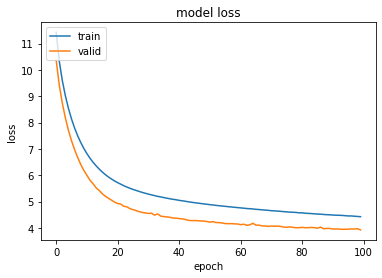

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('plt')

In [44]:
history.history["val_loss"]

[10.370679273414549,
 9.435458637399838,
 8.73997919560484,
 8.177330827715247,
 7.703950827484674,
 7.308812888021719,
 6.970997402390181,
 6.6780425610908924,
 6.40899232297707,
 6.187423591665602,
 5.998133502113547,
 5.813453060324053,
 5.680151649397885,
 5.524806196225012,
 5.422316777278863,
 5.30034486257845,
 5.203795401958306,
 5.127568144841399,
 5.056128001774965,
 4.98058704223538,
 4.928676393524372,
 4.907386500832179,
 4.82241081119293,
 4.802982059854635,
 4.733134907647986,
 4.696227080673531,
 4.659736714172971,
 4.618619791243665,
 4.590508555255588,
 4.569152456209484,
 4.552126187325999,
 4.5596959315908885,
 4.485578749080755,
 4.533983902244655,
 4.45075653601468,
 4.430617034988786,
 4.421659152020623,
 4.404383998758784,
 4.378405855745685,
 4.371317891914172,
 4.356065704531765,
 4.3450423026628915,
 4.325836132082447,
 4.289130977497817,
 4.28002503742314,
 4.280831280942319,
 4.277428041869305,
 4.2668053150177006,
 4.2629757880538985,
 4.243216381420186,
 

In [45]:
model.save('model.h5')

## Submission

In [46]:
for i in range(1914, 1969 +1):
    print(i)
    if i <= 1941:
        if i>= 1920:
            test_long['lag_t7'] = test_long.groupby(['id'])['demand'].transform(lambda x: x.shift(7))    
            test_long['rolling_mean_7_7'] = test_long.groupby(['id'])['demand'].transform(lambda x: x.shift(7).rolling(7).mean())
            test_long['rolling_mean_7_28'] = test_long.groupby(['id'])['demand'].transform(lambda x: x.shift(7).rolling(28).mean())
    
        forecast = make_X(test_long[test_long.d == i])
        pred = model.predict(forecast, batch_size=2 ** 14)

        test_long.loc[test_long.d == i, "demand"] = pred.clip(0) * 1.02
    else:
        test_long.loc[test_long.d == i, "demand"] = 0

1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969


In [47]:
test = test_long[test_long.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission = sample_submission[["id"]].merge(submission, how="left", on="id")
submission.head()

id        F1        F2        F3        F4  \
0  HOBBIES_1_001_CA_1_validation  0.922363  0.810547  0.759277  0.895020   
1  HOBBIES_1_002_CA_1_validation  0.181274  0.166382  0.217651  0.188232   
2  HOBBIES_1_003_CA_1_validation  0.493408  0.490967  0.493896  0.458984   
3  HOBBIES_1_004_CA_1_validation  2.119141  1.777344  1.576172  1.601562   
4  HOBBIES_1_005_CA_1_validation  0.962402  0.897461  0.874512  0.966797   

         F5        F6        F7        F8        F9  ...       F19       F20  \
0  0.936035  1.053711  1.212891  0.944336  0.905273  ...  0.994629  1.220703   
1  0.202881  0.240356  0.284668  0.142212  0.149414  ...  0.199219  0.261719   
2  0.529785  0.557129  0.569336  0.416016  0.409180  ...  0.543457  0.680664   
3  2.166016  2.789062  2.841797  2.173828  1.965820  ...  2.394531  2.935547   
4  1.090820  1.468750  1.792969  1.213867  1.208008  ...  1.319336  1.614258   

        F21       F22       F23       F24       F25       F26       F27  \
0  1.088867  0.913086  0.870117  0.863770  0.924805  0.990234  1.105469   
1  0.305664  0.175293  0.164917  0.175415  0.179810  0.208252  0.280518   
2  0.764648  0.522949  0.512695  0.497314  0.460693  0.499512  0.618164   
3  3.238281  2.242188  2.025391  1.917969  2.013672  2.478516  3.292969   
4  1.688477  1.186523  1.127930  1.093750  1.141602  1.298828  1.681641   

        F28  
0  1.166016  
1  0.301270  
2  0.613770  
3  3.171875  
4  1.850586  

[5 rows x 29 columns]

In [48]:
submission.to_csv("dnn_fake_valid_day_to_day.csv", index=False)